# 0. Import modules

In [17]:
import matplotlib.pyplot as plt
import time 
import os
from pathlib import Path
import pandas as pd
from PIL import Image
from tqdm import tqdm
import numpy as np
import datetime

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.io import read_image
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel

from IPython.display import Markdown, display



# 1. Load data, which is split into train-val sets (2*10^4 and 2 * 10^3 samples)

In [18]:
class ImageDataset(Dataset):
    def __init__(self, img_dir):
        self.img_dir = img_dir
        self.img_files = [item for item in os.listdir(img_dir) if ".tif" in item]
        print(f"Initialised dataset with n={len(self.img_files)} elements.")
    
    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):
        img_path = self.img_dir / self.img_files[idx]
        
        img = Image.open(img_path)
        img = ToTensor()(img)
        #img = read_image(str(img_path))
        label_str = self.img_files[idx].split(" ")[1]+" "+self.img_files[idx].split(" ")[2]
        label_dict = {'M=0 N=0': 0, 'M=0 N=1':1, 'M=0 N=2': 2, 'M=1 N=0': 3, 'M=1 N=1': 4,
                     'M=1 N=2':5, 'M=2 N=0': 6, 'M=2 N=1': 7, 'M=2 N=2': 8}
        label = label_dict[label_str]
        
        return img, label

In [19]:
cwd = Path(os.getcwd())

train_img_dir = cwd / "dataset" / "32by32" / "train"
train_dataset = ImageDataset(train_img_dir)
train_dataloader = DataLoader(train_dataset, batch_size = 10, shuffle = True)

test_img_dir = cwd / "dataset" / "32by32" / "test"
test_dataset = ImageDataset(test_img_dir)
test_dataloader = DataLoader(test_dataset, batch_size = 10, shuffle = True)

Initialised dataset with n=10000 elements.
Initialised dataset with n=2000 elements.


### Check some images 

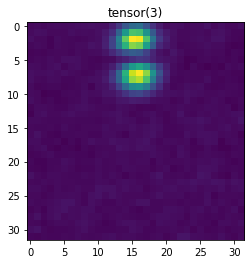

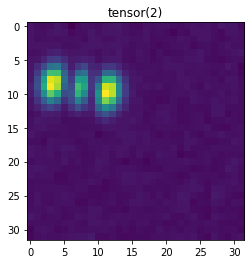

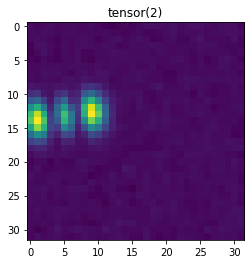

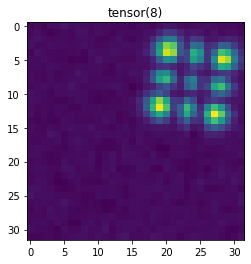

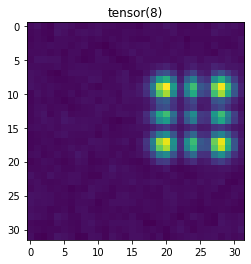

In [13]:
# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images
for i in range(5):#(images.shape[0]):
    plt.figure()
    plt.title(labels[i])
    plt.imshow(images[i][0])
    plt.savefig(f"sample_image_{i}.png")

In [20]:
train_features, train_labels = next(iter(train_dataloader))

In [21]:
train_labels

tensor([8, 6, 7, 1, 7, 5, 8, 3, 0, 8])

# 2. Define a flexible convolutional neural network 

In [14]:
class Net(nn.Module):
    """
    Class for CNN model, based on Le-Net5, with free parameters for tuning by bayesian optimisation.
    
    Free hyperparameters:
        
    """
    
    def __init__(self, name=None, input_format = (32,32), conv_f = 3, 
                 conv1_out_depth = 120, conv2_out_depth=84, fc1_out= 10, fc2_out=16,
                lr = 0.01, momentum = 0.9):
        
        super(Net, self).__init__()
        self.name = name
        self.conv_f = conv_f
        self.conv1_out_depth = conv1_out_depth
        self.conv2_out_depth = conv2_out_depth
        self.fc1_out = fc1_out
        self.fc2_out = fc2_out
        
        self.lr = lr
        self.momentum = momentum
        
        self.conv1 = nn.Conv2d(1, conv1_out_depth, self.conv_f)  #input depth, output depth and filter size (changed f = 5 to f = 3)
        self.conv2 = nn.Conv2d(conv1_out_depth, conv2_out_depth, self.conv_f)  #input depth, output and filter size; o = ((w-f)/s+1)
        self.pool = nn.MaxPool2d(2, 2)  #f and s
        
        #To determine size of FC input layer
        probe = self.pool(self.conv1(torch.zeros((1, *input_format))))
        probe = self.pool(self.conv2(probe))
        fc1_in = probe.shape[0]*probe.shape[1]*probe.shape[2] #0 is depth, 1 and 2 the representation dimensions
        self.fc1_in = fc1_in
        
        self.fc1 = nn.Linear(self.fc1_in, self.fc1_out)
        self.fc2 = nn.Linear(self.fc1_out, self.fc2_out)
        self.fc3 = nn.Linear(fc2_out, 9)
        
        # compute the total number of parameters
        total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(self.name + ': total params:', total_params)

        
    def forward(self, x, show_shape = False):
        x = self.pool(F.relu(self.conv1(x)))
        if show_shape: print(x.shape)
            
        x = self.pool(F.relu(self.conv2(x)))
        if show_shape: print(x.shape)
            
        x = x.view(-1, self.fc1_in)
        if show_shape: print(x.shape)
            
        x = F.relu(self.fc1(x))
        if show_shape: print(x.shape)
            
        x = F.relu(self.fc2(x))
        if show_shape: print(x.shape)
            
        x = self.fc3(x)
        if show_shape: print(x.shape)
            
        return x

# 3. Helper functions - train and test

In [15]:
def train(net, train_dataloader, test_dataloader, no_epochs):

    start = time.time()
    #Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=net.lr, momentum=net.momentum) #momentum to avoid zig zaging 

    for epoch in tqdm(range(no_epochs)):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(train_dataloader, 0): #go over the different batches
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 100 == 0:    # print every 2000 mini-batches
                acc = test(net, test_dataloader)
                print('[%d, %5d] loss: %.3f acc: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000, acc))
                running_loss = 0.0

    print('Finished Training')
    end = time.time()
    print('training time ', end-start)
    
    return net



def test(net, test_dataloader):
    """
    Return accuracy of classification by neural network
    """
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = (100 * correct / total)
    return accuracy


### Test helper functions - train and test

In [16]:
net = Net(name='LetNet5', input_format = (32,32), conv_f = 3, 
                 conv1_out_depth = 10, conv2_out_depth=16, fc1_out= 120, fc2_out=84,
                 lr = 0.01, momentum = 0.9)

net = train(net, train_dataloader, test_dataloader, no_epochs = 2)
acc = test(net, test_dataloader)
print(acc)

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


LetNet5: total params: 81725


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 13.400
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.650
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 13.100
[1,   701] loss: 0.109 acc: 15.150
[1,   801] loss: 0.106 acc: 17.800
[1,   901] loss: 0.099 acc: 30.300


 50%|██████████████████████▌                      | 1/2 [00:32<00:32, 32.06s/it]

[2,     1] loss: 0.001 acc: 20.900
[2,   101] loss: 0.074 acc: 31.300
[2,   201] loss: 0.068 acc: 47.500
[2,   301] loss: 0.061 acc: 40.400
[2,   401] loss: 0.051 acc: 54.200
[2,   501] loss: 0.045 acc: 63.600
[2,   601] loss: 0.044 acc: 43.800
[2,   701] loss: 0.044 acc: 58.950
[2,   801] loss: 0.040 acc: 67.150
[2,   901] loss: 0.036 acc: 77.350


100%|█████████████████████████████████████████████| 2/2 [01:07<00:00, 33.97s/it]


Finished Training
training time  67.97761082649231
72.45


# 4. Bayesian Optimisation of Hyperparameters

First, define helper functions to build the objective function of the optimisation

Parameters to optimise:

* Conv filter width - conv_f
* Output depth of Convolution layer 1 - conv1_out_depth
* Output depth of Convolution layer 2 - conv2_out_depth
* Dimension of output of FC1 - fc1_out
* Dimension of output of FC2 - fc2_out
* Learning rate - lr
* Momentum - p

In [11]:
hparam_ranges = {'conv_f':  ( 1, 9), #convolution layer filter width 
                 'conv1_out_depth': (1,  20), # depth of conv1 output
                 'conv2_out_depth': (1, 20), # depth of conv2 output
                 'fc1_out':  (1, 200), # dimension of FC1 output
                 'fc2_out':   (1, 200), #dimension of FC2 output
                 'lr': (-4,-1), #learning rate
                 'momentum': (-4,-1)} #momentum 

In [12]:
def random_hparam(hparam_ranges):
    """
    Extracts random sample from provided hyperparameter range;
    """
    r = hparam_ranges
    sample = np.array([np.random.choice(np.arange(r["conv_f"][0], r["conv_f"][1])), #conv_f
                      np.random.choice(np.arange(r["conv1_out_depth"][0], r["conv2_out_depth"][1])), #conv1_out_depth
                      np.random.choice(np.arange(r["conv2_out_depth"][0], r["conv2_out_depth"][1])), #conv2_out_depth
                      np.random.choice(np.arange(r["fc1_out"][0], r["fc1_out"][1])), #fc1_out
                      np.random.choice(np.arange(r["fc2_out"][0], r["fc2_out"][1])), #fc2_out
                      10**np.random.uniform(r["lr"][0], r["lr"][1]), #learning rate
                      10**np.random.uniform(r["momentum"][0], r["momentum"][1])]) #momentum
    
    hparam_values = {"conv_f": sample[0],
                "conv1_out_depth": sample[1],
                "conv2_out_depth": sample[2],
                "fc1_out": sample[3],
                "fc2_out": sample[4],
                "lr": sample[5],
                "momentum": sample[6]}
    
    return hparam_values

In [ ]:
random_hparam(hparam_ranges)

### Objective function

In [13]:
def objective(hparam_values, no_epochs = 1):
#    hparams = 
    """
    hparams = [3, #conv_f
           2, #conv1_out_depth
           3, #conv2_out_depth
           4, #fc1_out
           5, #fc2_out
           6, #lr
           7] #momentum
    """
    
    conv_f = round(hparam_values["conv_f"])
    conv1_out_depth = round(hparam_values["conv1_out_depth"])
    conv2_out_depth = round(hparam_values["conv2_out_depth"])
    fc1_out = round(hparam_values["fc1_out"])
    fc2_out = round(hparam_values["fc2_out"])
    lr = 10**hparam_values["lr"]
    momentum = 10**hparam_values["momentum"]
    

    net = Net(name='LetNet5', input_format = (32,32), conv_f = conv_f, 
                     conv1_out_depth = conv1_out_depth, conv2_out_depth = conv2_out_depth,
                     fc1_out= fc1_out, fc2_out=fc2_out,
                     lr = lr, momentum = momentum)
    

    net = train(net, train_dataloader, test_dataloader, no_epochs = no_epochs)
    acc = test(net, test_dataloader)
    
    
    return acc

### Test objective function 

In [ ]:
hparam_values = {"conv_f": 3,
                "conv1_out_depth": 10,
                "conv2_out_depth": 16,
                "fc1_out": 120,
                "fc2_out": 84,
                "lr": -2,
                "momentum": -0.05}

#hparam_values = random_hparam(hparam_ranges)
print(hparam_values)
acc = objective(hparam_values)

## Optimisation routine

In [28]:
def load_previous_opt_results(query_arr, observation_arr):
    """
    Loads results from last optimisation
    """
    stored_results = [item for item in os.listdir("./optimisation_results/")]
    time_stamps = [float("".join(item.split("_")[:2])) for item in stored_results] 
    last_result = stored_results[np.argmax(time_stamps)]
    df = pd.read_pickle("./optimisation_results/"+last_result)

    for index, row in df.iterrows():
        query_i_dict = row.drop("acc").to_dict()
        query_i_arr = list(query_i_dict.values())
        observation_i = df.loc[index, "acc"]
        
        optimizer.register(params = query_i_dict, target = observation_i)
        
        query_arr.append(query_i_arr)
        observation_arr.append(observation_i)
    
    return query_arr, observation_arr

In [ ]:
n_iterations = 5000 #optimiser iterations
xi = 0.01 #exploration-exploitation trade-off
kappa = 0.5
no_epochs = 2
load_prev_values = True #load previous queries into optimiser before starting optimisation


#Instatiate optimiser and kernel
optimizer = BayesianOptimization(f=None, pbounds = hparam_ranges, verbose=2, random_state=2)

kernel = ConstantKernel(constant_value = 1, constant_value_bounds = (1e-5, 1e5)) *\
    RBF(length_scale=1., length_scale_bounds = (1e-5, 1e3))\
    + WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e2))

observation_arr = []
query_arr = []
time_arr = []

hparam_values = {"conv_f": 3,
                "conv1_out_depth": 10,
                "conv2_out_depth": 16,
                "fc1_out": 120,
                "fc2_out": 84,
                "lr": -2,
                "momentum": -0.05} #hparams for the first iteration, to help with search

if load_prev_values: 
    query_arr, observation_arr = load_previous_opt_results(query_arr, observation_arr)

for i in range(n_iterations):
    t1 = time.time()
    
    # ____________________________________________
    # Suggest new query
    if (load_prev_values) or i>=10:
        print("")
        utility = UtilityFunction(kind="ei", kappa=kappa, xi = xi)  #tune exploration vs exploitation
        hparam_values = optimizer.suggest(utility)
    
    elif i < 1:
        print("Debug: First entry")
        pass #takes default hparam_values

    elif i in range(1,10): #in the first iterations, add random queries
        print("Debug: Random trials")
        hparam_values = random_hparam(hparam_ranges)
    
    query_arr.append(list(hparam_values.values()))
    print(f"\nIteration: {i: .0f} \t hparams={hparam_values}")
    
    # ___________________________________
    # Check if suggested query has been tried alread
    

    # ___________________________________
    # Query objective function 
    observation_i = objective(hparam_values, no_epochs=no_epochs)

    # ___________________________________
    # Register observation
    optimizer.register(params = hparam_values, target=observation_i)
    observation_arr.append(observation_i)
    
    # ___________________________________
    # Print query - observation
    t2 = time.time()
    time_arr.append(t2-t1)
    print(f"Iteration: {i: .0f} \t Observation: {observation_i: .6f}")
    
    # ___________________________________
    #Save optimisation result
    if i%10==0:
        df_optimisation = pd.DataFrame(data = query_arr, columns = hparam_values.keys())
        df_optimisation["acc"] = observation_arr

        now = datetime.datetime.now()
        timestamp = str(now.strftime("%Y%m%d_%H%M%S"))
        label = timestamp + "_results"
        df_optimisation.to_pickle("./optimisation_results/"+label)




Iteration:  0 	 hparams={'conv1_out_depth': 17.00611006313222, 'conv2_out_depth': 14.153594907371971, 'conv_f': 7.706244214541135, 'fc1_out': 152.4212254703429, 'fc2_out': 74.72516928192823, 'lr': -1.437299932310082, 'momentum': -1.067427661678788}
LetNet5: total params: 37174


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 15.750
[1,   801] loss: 0.109 acc: 14.350
[1,   901] loss: 0.109 acc: 14.700


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.98s/it]

[2,     1] loss: 0.001 acc: 15.400
[2,   101] loss: 0.105 acc: 18.100
[2,   201] loss: 0.100 acc: 17.000
[2,   301] loss: 0.094 acc: 28.350
[2,   401] loss: 0.090 acc: 24.200
[2,   501] loss: 0.087 acc: 22.200
[2,   601] loss: 0.084 acc: 35.550
[2,   701] loss: 0.078 acc: 24.550
[2,   801] loss: 0.075 acc: 34.200
[2,   901] loss: 0.074 acc: 41.900


100%|█████████████████████████████████████████████| 2/2 [00:56<00:00, 28.18s/it]


Finished Training
training time  56.3590030670166
Iteration:  0 	 Observation:  42.350000


Iteration:  1 	 hparams={'conv1_out_depth': 5.543153970374315, 'conv2_out_depth': 17.17020566906114, 'conv_f': 1.7610679638250355, 'fc1_out': 45.273874439239435, 'fc2_out': 74.4140176225962, 'lr': -1.648277677877533, 'momentum': -3.9490446483731487}
LetNet5: total params: 42064


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.600
[1,   301] loss: 0.110 acc: 11.050
[1,   401] loss: 0.110 acc: 11.350
[1,   501] loss: 0.110 acc: 11.950
[1,   601] loss: 0.110 acc: 13.250
[1,   701] loss: 0.110 acc: 13.200
[1,   801] loss: 0.110 acc: 11.700
[1,   901] loss: 0.110 acc: 11.550


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.70s/it]

[2,     1] loss: 0.001 acc: 10.700
[2,   101] loss: 0.109 acc: 12.450
[2,   201] loss: 0.110 acc: 12.350
[2,   301] loss: 0.109 acc: 15.950
[2,   401] loss: 0.109 acc: 16.950
[2,   501] loss: 0.108 acc: 15.750
[2,   601] loss: 0.107 acc: 21.200
[2,   701] loss: 0.104 acc: 21.950
[2,   801] loss: 0.100 acc: 11.250
[2,   901] loss: 0.094 acc: 28.950


100%|█████████████████████████████████████████████| 2/2 [00:43<00:00, 21.83s/it]


Finished Training
training time  43.65299725532532
Iteration:  1 	 Observation:  32.150000


Iteration:  2 	 hparams={'conv1_out_depth': 12.43260657322799, 'conv2_out_depth': 18.849923022347433, 'conv_f': 5.573303145577844, 'fc1_out': 2.299159407539805, 'fc2_out': 163.24262427184348, 'lr': -1.242554408741893, 'momentum': -2.7596325196096276}
LetNet5: total params: 11246


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.111 acc: 11.500
[1,   201] loss: 0.111 acc: 12.900
[1,   301] loss: 0.107 acc: 15.850
[1,   401] loss: 0.096 acc: 24.800
[1,   501] loss: 0.089 acc: 26.850
[1,   601] loss: 0.085 acc: 32.200
[1,   701] loss: 0.079 acc: 30.800
[1,   801] loss: 0.077 acc: 32.050
[1,   901] loss: 0.073 acc: 49.650


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.21s/it]

[2,     1] loss: 0.001 acc: 31.200
[2,   101] loss: 0.070 acc: 47.300
[2,   201] loss: 0.060 acc: 51.550
[2,   301] loss: 0.071 acc: 39.100
[2,   401] loss: 0.068 acc: 61.300
[2,   501] loss: 0.057 acc: 68.750
[2,   601] loss: 0.051 acc: 52.900
[2,   701] loss: 0.044 acc: 42.600
[2,   801] loss: 0.038 acc: 85.200
[2,   901] loss: 0.026 acc: 95.050


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.08s/it]


Finished Training
training time  50.170844316482544
Iteration:  2 	 Observation:  90.850000


Iteration:  3 	 hparams={'conv1_out_depth': 19.110419892596042, 'conv2_out_depth': 15.27021526044613, 'conv_f': 8.13375034201719, 'fc1_out': 46.742983543641756, 'fc2_out': 93.7741453319296, 'lr': -2.6778612639454273, 'momentum': -3.692921688073272}
LetNet5: total params: 27724


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.110 acc: 11.650
[1,   501] loss: 0.110 acc: 11.650
[1,   601] loss: 0.110 acc: 11.650
[1,   701] loss: 0.110 acc: 11.650
[1,   801] loss: 0.110 acc: 11.650
[1,   901] loss: 0.110 acc: 11.650


 50%|██████████████████████▌                      | 1/2 [00:29<00:29, 29.61s/it]

[2,     1] loss: 0.001 acc: 11.650
[2,   101] loss: 0.110 acc: 11.650
[2,   201] loss: 0.110 acc: 11.650
[2,   301] loss: 0.110 acc: 11.650
[2,   401] loss: 0.110 acc: 11.650
[2,   501] loss: 0.110 acc: 11.650
[2,   601] loss: 0.110 acc: 11.650
[2,   701] loss: 0.110 acc: 11.650
[2,   801] loss: 0.110 acc: 11.650
[2,   901] loss: 0.110 acc: 11.650


100%|█████████████████████████████████████████████| 2/2 [00:58<00:00, 29.28s/it]


Finished Training
training time  58.55764722824097
Iteration:  3 	 Observation:  11.650000


Iteration:  4 	 hparams={'conv1_out_depth': 6.098198574309201, 'conv2_out_depth': 16.79522672679403, 'conv_f': 5.174273317066506, 'fc1_out': 48.09691356612898, 'fc2_out': 77.16486720350869, 'lr': -2.1060914664039325, 'momentum': -3.171989462919732}
LetNet5: total params: 27646


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 10.550
[1,   301] loss: 0.110 acc: 10.550
[1,   401] loss: 0.110 acc: 10.550
[1,   501] loss: 0.110 acc: 10.550
[1,   601] loss: 0.110 acc: 10.550
[1,   701] loss: 0.110 acc: 10.550
[1,   801] loss: 0.110 acc: 10.550
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.53s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.22s/it]


Finished Training
training time  50.44382119178772
Iteration:  4 	 Observation:  11.500000


Iteration:  5 	 hparams={'conv1_out_depth': 7.232122682958829, 'conv2_out_depth': 6.125030482047961, 'conv_f': 3.8429724320862597, 'fc1_out': 65.6544442036407, 'fc2_out': 195.62756092896896, 'lr': -1.0243580525091347, 'momentum': -1.9939936349775702}
LetNet5: total params: 25668


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 10.600
[1,   301] loss: 0.110 acc: 13.000
[1,   401] loss: 0.109 acc: 15.750
[1,   501] loss: 0.105 acc: 18.500
[1,   601] loss: 0.100 acc: 23.550
[1,   701] loss: 0.095 acc: 21.250
[1,   801] loss: 0.091 acc: 26.400
[1,   901] loss: 0.083 acc: 15.350


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.94s/it]

[2,     1] loss: 0.001 acc: 39.450
[2,   101] loss: 0.064 acc: 61.900
[2,   201] loss: 0.058 acc: 73.450
[2,   301] loss: 0.048 acc: 72.800
[2,   401] loss: 0.048 acc: 73.450
[2,   501] loss: 0.037 acc: 59.050
[2,   601] loss: 0.038 acc: 78.200
[2,   701] loss: 0.037 acc: 24.700
[2,   801] loss: 0.043 acc: 77.650
[2,   901] loss: 0.034 acc: 86.100


100%|█████████████████████████████████████████████| 2/2 [00:42<00:00, 21.42s/it]


Finished Training
training time  42.842986822128296
Iteration:  5 	 Observation:  84.450000


Iteration:  6 	 hparams={'conv1_out_depth': 15.665893158391528, 'conv2_out_depth': 3.4905247409163658, 'conv_f': 4.242475673027902, 'fc1_out': 177.02743077626815, 'fc2_out': 15.036547385949486, 'lr': -1.247141376546748, 'momentum': -1.6909107734036346}
LetNet5: total params: 17309


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 11.100
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.109 acc: 13.800
[1,   601] loss: 0.108 acc: 14.200
[1,   701] loss: 0.106 acc: 18.300
[1,   801] loss: 0.103 acc: 23.850
[1,   901] loss: 0.096 acc: 26.450


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.65s/it]

[2,     1] loss: 0.001 acc: 32.050
[2,   101] loss: 0.086 acc: 29.250
[2,   201] loss: 0.083 acc: 30.150
[2,   301] loss: 0.081 acc: 27.100
[2,   401] loss: 0.077 acc: 26.800
[2,   501] loss: 0.092 acc: 34.500
[2,   601] loss: 0.077 acc: 35.500
[2,   701] loss: 0.075 acc: 31.300
[2,   801] loss: 0.076 acc: 39.150
[2,   901] loss: 0.071 acc: 42.250


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.15s/it]


Finished Training
training time  46.30391812324524
Iteration:  6 	 Observation:  45.200000


Iteration:  7 	 hparams={'conv1_out_depth': 7.232845510766654, 'conv2_out_depth': 9.309754345309859, 'conv_f': 4.489420989081471, 'fc1_out': 66.1495514679574, 'fc2_out': 197.53902907982103, 'lr': -1.7012137548292712, 'momentum': -3.411622552573685}
LetNet5: total params: 31109


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.98s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 13.750
[2,   301] loss: 0.110 acc: 12.300
[2,   401] loss: 0.110 acc: 12.300
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.36s/it]


Finished Training
training time  46.73071599006653
Iteration:  7 	 Observation:  10.000000


Iteration:  8 	 hparams={'conv1_out_depth': 19.983979990247423, 'conv2_out_depth': 17.974527731708623, 'conv_f': 6.60331743857983, 'fc1_out': 49.04493456750523, 'fc2_out': 93.90839447817986, 'lr': -1.2582794389851606, 'momentum': -2.287605449862875}
LetNet5: total params: 32200


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 15.650
[1,   501] loss: 0.110 acc: 12.900
[1,   601] loss: 0.110 acc: 14.600
[1,   701] loss: 0.108 acc: 15.050
[1,   801] loss: 0.104 acc: 19.550
[1,   901] loss: 0.100 acc: 20.000


 50%|██████████████████████▌                      | 1/2 [00:29<00:29, 29.37s/it]

[2,     1] loss: 0.001 acc: 36.000
[2,   101] loss: 0.084 acc: 22.750
[2,   201] loss: 0.079 acc: 31.100
[2,   301] loss: 0.077 acc: 44.250
[2,   401] loss: 0.069 acc: 38.950
[2,   501] loss: 0.066 acc: 42.850
[2,   601] loss: 0.062 acc: 53.950
[2,   701] loss: 0.056 acc: 52.250
[2,   801] loss: 0.055 acc: 60.550
[2,   901] loss: 0.049 acc: 62.200


100%|█████████████████████████████████████████████| 2/2 [00:59<00:00, 29.68s/it]


Finished Training
training time  59.35273313522339
Iteration:  8 	 Observation:  62.700000


Iteration:  9 	 hparams={'conv1_out_depth': 15.718758955756883, 'conv2_out_depth': 13.066344977349651, 'conv_f': 7.3399006810851235, 'fc1_out': 187.60276118124077, 'fc2_out': 167.9424006856797, 'lr': -2.7521874558454416, 'momentum': -1.7527752524566385}
LetNet5: total params: 66462


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.650
[1,   101] loss: 0.110 acc: 10.450
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.350
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:29<00:29, 29.43s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:58<00:00, 29.35s/it]


Finished Training
training time  58.691702127456665
Iteration:  9 	 Observation:  11.500000


Iteration:  10 	 hparams={'conv1_out_depth': 4.926400954646381, 'conv2_out_depth': 12.29211164059767, 'conv_f': 6.328229505854814, 'fc1_out': 68.14008215561694, 'fc2_out': 183.44017002585647, 'lr': -1.6205418194385408, 'momentum': -2.1933459905960246}
LetNet5: total params: 29764


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 13.650
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.450
[1,   601] loss: 0.110 acc: 11.350
[1,   701] loss: 0.110 acc: 10.250
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.47s/it]

[2,     1] loss: 0.001 acc: 11.250
[2,   101] loss: 0.109 acc: 12.750
[2,   201] loss: 0.109 acc: 12.550
[2,   301] loss: 0.109 acc: 14.600
[2,   401] loss: 0.108 acc: 13.850
[2,   501] loss: 0.106 acc: 15.600
[2,   601] loss: 0.104 acc: 18.200
[2,   701] loss: 0.101 acc: 21.550
[2,   801] loss: 0.097 acc: 23.000
[2,   901] loss: 0.091 acc: 24.300


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.45s/it]


Finished Training
training time  46.897448778152466
Iteration:  10 	 Observation:  28.300000


Iteration:  11 	 hparams={'conv1_out_depth': 10.02300636059816, 'conv2_out_depth': 19.117867666666406, 'conv_f': 4.59412646145867, 'fc1_out': 150.35236069013894, 'fc2_out': 128.69938596987691, 'lr': -1.6178196519580168, 'momentum': -1.067831119212864}
LetNet5: total params: 97078


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 14.700
[1,   901] loss: 0.110 acc: 10.050


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.19s/it]

[2,     1] loss: 0.001 acc: 11.950
[2,   101] loss: 0.110 acc: 12.050
[2,   201] loss: 0.109 acc: 15.950
[2,   301] loss: 0.109 acc: 13.400
[2,   401] loss: 0.109 acc: 16.450
[2,   501] loss: 0.107 acc: 15.300
[2,   601] loss: 0.105 acc: 18.050
[2,   701] loss: 0.099 acc: 20.900
[2,   801] loss: 0.092 acc: 30.450
[2,   901] loss: 0.087 acc: 31.800


100%|█████████████████████████████████████████████| 2/2 [00:54<00:00, 27.22s/it]


Finished Training
training time  54.450186014175415
Iteration:  11 	 Observation:  38.300000


Iteration:  12 	 hparams={'conv1_out_depth': 14.455581303730797, 'conv2_out_depth': 14.019870744824821, 'conv_f': 3.5677519517994574, 'fc1_out': 178.1897122019711, 'fc2_out': 10.899012109781717, 'lr': -1.9478722214554178, 'momentum': -1.9226682909008863}
LetNet5: total params: 67943


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.111 acc: 10.300
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.82s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 13.400


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.60s/it]


Finished Training
training time  51.19962430000305
Iteration:  12 	 Observation:  11.500000


Iteration:  13 	 hparams={'conv1_out_depth': 14.028582927942521, 'conv2_out_depth': 11.949011343646005, 'conv_f': 7.62722132142014, 'fc1_out': 154.550944266375, 'fc2_out': 76.9177060739169, 'lr': -1.628802211331426, 'momentum': -3.5144183673992}
LetNet5: total params: 31983


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 11.400
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 13.600
[1,   701] loss: 0.109 acc: 10.600
[1,   801] loss: 0.110 acc: 13.400
[1,   901] loss: 0.109 acc: 14.200


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.60s/it]

[2,     1] loss: 0.001 acc: 13.300
[2,   101] loss: 0.108 acc: 13.750
[2,   201] loss: 0.106 acc: 15.000
[2,   301] loss: 0.105 acc: 20.000
[2,   401] loss: 0.101 acc: 19.150
[2,   501] loss: 0.099 acc: 22.050
[2,   601] loss: 0.094 acc: 27.000
[2,   701] loss: 0.091 acc: 33.150
[2,   801] loss: 0.087 acc: 33.300
[2,   901] loss: 0.084 acc: 26.500


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.62s/it]


Finished Training
training time  51.231496810913086
Iteration:  13 	 Observation:  29.950000


Iteration:  14 	 hparams={'conv1_out_depth': 9.813502925499574, 'conv2_out_depth': 18.648243949278033, 'conv_f': 5.808620851898126, 'fc1_out': 152.20720120880054, 'fc2_out': 129.55818781258407, 'lr': -1.4792353263732574, 'momentum': -1.8372133384533766}
LetNet5: total params: 74658


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 12.650
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.450
[1,   601] loss: 0.110 acc: 11.900
[1,   701] loss: 0.110 acc: 12.000
[1,   801] loss: 0.109 acc: 13.400
[1,   901] loss: 0.108 acc: 16.650


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.72s/it]

[2,     1] loss: 0.001 acc: 20.100
[2,   101] loss: 0.097 acc: 25.400
[2,   201] loss: 0.089 acc: 14.150
[2,   301] loss: 0.084 acc: 29.550
[2,   401] loss: 0.079 acc: 39.200
[2,   501] loss: 0.077 acc: 41.450
[2,   601] loss: 0.072 acc: 14.850
[2,   701] loss: 0.071 acc: 41.100
[2,   801] loss: 0.069 acc: 45.200
[2,   901] loss: 0.070 acc: 45.950


100%|█████████████████████████████████████████████| 2/2 [00:57<00:00, 28.66s/it]


Finished Training
training time  57.32460594177246
Iteration:  14 	 Observation:  58.050000


Iteration:  15 	 hparams={'conv1_out_depth': 16.36590161762674, 'conv2_out_depth': 3.814579985154226, 'conv_f': 6.504571849441145, 'fc1_out': 1.1294006132562182, 'fc2_out': 186.70067149196527, 'lr': -1.1867989770962208, 'momentum': -1.609593263001587}
LetNet5: total params: 6043


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.113 acc: 10.550
[1,   201] loss: 0.112 acc: 13.000
[1,   301] loss: 0.109 acc: 18.400
[1,   401] loss: 0.104 acc: 14.900
[1,   501] loss: 0.095 acc: 25.800
[1,   601] loss: 0.098 acc: 25.800
[1,   701] loss: 0.087 acc: 31.100
[1,   801] loss: 0.086 acc: 42.800
[1,   901] loss: 0.079 acc: 35.500


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.39s/it]

[2,     1] loss: 0.001 acc: 36.900
[2,   101] loss: 0.074 acc: 32.800
[2,   201] loss: 0.075 acc: 43.150
[2,   301] loss: 0.074 acc: 39.050
[2,   401] loss: 0.070 acc: 25.950
[2,   501] loss: 0.065 acc: 39.650
[2,   601] loss: 0.065 acc: 46.600
[2,   701] loss: 0.067 acc: 47.100
[2,   801] loss: 0.062 acc: 45.300
[2,   901] loss: 0.057 acc: 51.750


100%|█████████████████████████████████████████████| 2/2 [00:55<00:00, 27.86s/it]


Finished Training
training time  55.72549104690552
Iteration:  15 	 Observation:  47.450000


Iteration:  16 	 hparams={'conv1_out_depth': 16.1158974570003, 'conv2_out_depth': 13.80488948290168, 'conv_f': 8.026918675281276, 'fc1_out': 184.86605038382223, 'fc2_out': 163.3527786771106, 'lr': -2.6424267601163836, 'momentum': -2.4029844908683944}
LetNet5: total params: 57729


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 11.250
[1,   401] loss: 0.110 acc: 11.250
[1,   501] loss: 0.110 acc: 11.250
[1,   601] loss: 0.110 acc: 11.250
[1,   701] loss: 0.110 acc: 11.250
[1,   801] loss: 0.110 acc: 11.300
[1,   901] loss: 0.110 acc: 12.550


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.26s/it]

[2,     1] loss: 0.001 acc: 13.100
[2,   101] loss: 0.110 acc: 13.550
[2,   201] loss: 0.110 acc: 13.700
[2,   301] loss: 0.110 acc: 13.400
[2,   401] loss: 0.110 acc: 15.150
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.600
[2,   801] loss: 0.110 acc: 14.200
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:55<00:00, 28.00s/it]


Finished Training
training time  55.993972301483154
Iteration:  16 	 Observation:  11.500000


Iteration:  17 	 hparams={'conv1_out_depth': 9.419258359283457, 'conv2_out_depth': 18.57495635862036, 'conv_f': 3.665292230122758, 'fc1_out': 151.26458042841057, 'fc2_out': 132.12304317673082, 'lr': -1.1241183461954622, 'momentum': -3.507427133974782}
LetNet5: total params: 96045


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 12.350
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 14.200
[1,   401] loss: 0.109 acc: 13.000
[1,   501] loss: 0.107 acc: 15.100
[1,   601] loss: 0.103 acc: 20.500
[1,   701] loss: 0.098 acc: 18.900
[1,   801] loss: 0.091 acc: 34.700
[1,   901] loss: 0.085 acc: 30.250


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.21s/it]

[2,     1] loss: 0.001 acc: 30.050
[2,   101] loss: 0.077 acc: 40.100
[2,   201] loss: 0.072 acc: 42.300
[2,   301] loss: 0.069 acc: 56.250
[2,   401] loss: 0.062 acc: 59.250
[2,   501] loss: 0.057 acc: 56.250
[2,   601] loss: 0.044 acc: 78.050
[2,   701] loss: 0.041 acc: 77.800
[2,   801] loss: 0.040 acc: 72.400
[2,   901] loss: 0.034 acc: 75.500


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.59s/it]


Finished Training
training time  51.17754769325256
Iteration:  17 	 Observation:  84.500000


Iteration:  18 	 hparams={'conv1_out_depth': 18.555360038546866, 'conv2_out_depth': 5.962992988708264, 'conv_f': 7.546235036969656, 'fc1_out': 156.46881715444562, 'fc2_out': 146.96263300655406, 'lr': -3.19224304032191, 'momentum': -2.397782392468681}
LetNet5: total params: 36848


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 11.450
[1,   601] loss: 0.110 acc: 11.450
[1,   701] loss: 0.110 acc: 11.450
[1,   801] loss: 0.110 acc: 11.450
[1,   901] loss: 0.110 acc: 11.450


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.70s/it]

[2,     1] loss: 0.001 acc: 11.450
[2,   101] loss: 0.110 acc: 11.450
[2,   201] loss: 0.110 acc: 11.450
[2,   301] loss: 0.110 acc: 11.450
[2,   401] loss: 0.110 acc: 11.450
[2,   501] loss: 0.110 acc: 11.450
[2,   601] loss: 0.110 acc: 11.450
[2,   701] loss: 0.110 acc: 11.450
[2,   801] loss: 0.110 acc: 11.450
[2,   901] loss: 0.110 acc: 11.450


100%|█████████████████████████████████████████████| 2/2 [00:56<00:00, 28.13s/it]


Finished Training
training time  56.25519776344299
Iteration:  18 	 Observation:  11.450000


Iteration:  19 	 hparams={'conv1_out_depth': 4.841043164680126, 'conv2_out_depth': 18.942590555166426, 'conv_f': 2.0095672259262676, 'fc1_out': 115.33705873942863, 'fc2_out': 99.20546921172145, 'lr': -1.1206911752500894, 'momentum': -1.7232421917494767}
LetNet5: total params: 119988


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 11.450
[1,   601] loss: 0.110 acc: 11.250
[1,   701] loss: 0.110 acc: 11.350
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.15s/it]

[2,     1] loss: 0.001 acc: 12.850
[2,   101] loss: 0.110 acc: 11.250
[2,   201] loss: 0.109 acc: 12.450
[2,   301] loss: 0.108 acc: 19.650
[2,   401] loss: 0.103 acc: 26.150
[2,   501] loss: 0.098 acc: 23.350
[2,   601] loss: 0.092 acc: 23.650
[2,   701] loss: 0.087 acc: 38.550
[2,   801] loss: 0.083 acc: 39.400
[2,   901] loss: 0.062 acc: 60.050


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.38s/it]


Finished Training
training time  46.768548250198364
Iteration:  19 	 Observation:  68.500000


Iteration:  20 	 hparams={'conv1_out_depth': 18.243918471793478, 'conv2_out_depth': 16.048263752589687, 'conv_f': 7.825691688519218, 'fc1_out': 47.919980461833276, 'fc2_out': 96.92353809372732, 'lr': -3.2207661157944267, 'momentum': -3.362771093335894}
LetNet5: total params: 28373


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.65s/it]

[2,     1] loss: 0.001 acc: 10.000
[2,   101] loss: 0.110 acc: 10.000
[2,   201] loss: 0.110 acc: 10.000
[2,   301] loss: 0.110 acc: 10.000
[2,   401] loss: 0.110 acc: 10.000
[2,   501] loss: 0.110 acc: 10.000
[2,   601] loss: 0.110 acc: 10.000
[2,   701] loss: 0.110 acc: 10.000
[2,   801] loss: 0.110 acc: 10.000
[2,   901] loss: 0.110 acc: 10.000


100%|█████████████████████████████████████████████| 2/2 [00:56<00:00, 28.18s/it]


Finished Training
training time  56.36246991157532
Iteration:  20 	 Observation:  10.000000


Iteration:  21 	 hparams={'conv1_out_depth': 14.606394184460727, 'conv2_out_depth': 13.941978230624589, 'conv_f': 6.5788516704459665, 'fc1_out': 186.77822154954475, 'fc2_out': 162.2426988270696, 'lr': -2.3718165328216836, 'momentum': -2.4045342038338924}
LetNet5: total params: 66726


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:33<00:33, 33.19s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [01:03<00:00, 31.73s/it]


Finished Training
training time  63.461801052093506
Iteration:  21 	 Observation:  11.500000


Iteration:  22 	 hparams={'conv1_out_depth': 5.823929892610993, 'conv2_out_depth': 2.1294289204084134, 'conv_f': 8.82004202838249, 'fc1_out': 56.97357030659032, 'fc2_out': 91.2242717275342, 'lr': -1.1987487852779344, 'momentum': -1.2352741020429567}
LetNet5: total params: 8085


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 15.800
[1,   401] loss: 0.109 acc: 16.250
[1,   501] loss: 0.104 acc: 26.400
[1,   601] loss: 0.095 acc: 26.400
[1,   701] loss: 0.085 acc: 34.350
[1,   801] loss: 0.078 acc: 24.950
[1,   901] loss: 0.074 acc: 41.700


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.03s/it]

[2,     1] loss: 0.001 acc: 37.800
[2,   101] loss: 0.064 acc: 49.750
[2,   201] loss: 0.057 acc: 47.450
[2,   301] loss: 0.057 acc: 56.450
[2,   401] loss: 0.048 acc: 59.600
[2,   501] loss: 0.049 acc: 30.400
[2,   601] loss: 0.062 acc: 41.800
[2,   701] loss: 0.053 acc: 64.350
[2,   801] loss: 0.044 acc: 76.100
[2,   901] loss: 0.039 acc: 86.250


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.19s/it]


Finished Training
training time  46.37541317939758
Iteration:  22 	 Observation:  81.750000


Iteration:  23 	 hparams={'conv1_out_depth': 15.676885806756008, 'conv2_out_depth': 3.7389653763874255, 'conv_f': 2.3649350945411793, 'fc1_out': 176.01787557252038, 'fc2_out': 14.297883812755874, 'lr': -1.4052891297096433, 'momentum': -3.1310813835233864}
LetNet5: total params: 37625


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 12.300
[1,   601] loss: 0.110 acc: 10.050
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 10.550


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.66s/it]

[2,     1] loss: 0.001 acc: 11.650
[2,   101] loss: 0.110 acc: 10.000
[2,   201] loss: 0.110 acc: 10.000
[2,   301] loss: 0.110 acc: 11.250
[2,   401] loss: 0.110 acc: 11.650
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 10.000
[2,   701] loss: 0.110 acc: 12.300
[2,   801] loss: 0.110 acc: 11.700
[2,   901] loss: 0.110 acc: 13.250


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.36s/it]


Finished Training
training time  48.72979187965393
Iteration:  23 	 Observation:  19.250000


Iteration:  24 	 hparams={'conv1_out_depth': 13.535985453903105, 'conv2_out_depth': 11.817300633561192, 'conv_f': 5.200743344987237, 'fc1_out': 186.8564273947028, 'fc2_out': 160.60497846520633, 'lr': -3.045424477100083, 'momentum': -1.182117014278922}
LetNet5: total params: 92589


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:30<00:30, 30.81s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:59<00:00, 29.69s/it]


Finished Training
training time  59.38942003250122
Iteration:  24 	 Observation:  11.500000


Iteration:  25 	 hparams={'conv1_out_depth': 15.646234686084664, 'conv2_out_depth': 12.584897664946583, 'conv_f': 6.5246820287044, 'fc1_out': 185.06736334509614, 'fc2_out': 158.57220041442642, 'lr': -1.3313361378896174, 'momentum': -3.73688021810649}
LetNet5: total params: 63849


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.150
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 12.350
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.109 acc: 16.100
[1,   601] loss: 0.108 acc: 14.200
[1,   701] loss: 0.106 acc: 20.100
[1,   801] loss: 0.102 acc: 22.500
[1,   901] loss: 0.097 acc: 18.800


 50%|██████████████████████▌                      | 1/2 [00:30<00:30, 30.99s/it]

[2,     1] loss: 0.001 acc: 22.150
[2,   101] loss: 0.085 acc: 34.500
[2,   201] loss: 0.082 acc: 26.100
[2,   301] loss: 0.077 acc: 36.050
[2,   401] loss: 0.071 acc: 38.150
[2,   501] loss: 0.069 acc: 40.500
[2,   601] loss: 0.068 acc: 46.950
[2,   701] loss: 0.065 acc: 47.900
[2,   801] loss: 0.061 acc: 54.600
[2,   901] loss: 0.054 acc: 34.400


100%|█████████████████████████████████████████████| 2/2 [00:58<00:00, 29.49s/it]


Finished Training
training time  58.977133989334106
Iteration:  25 	 Observation:  49.700000


Iteration:  26 	 hparams={'conv1_out_depth': 11.891403073317015, 'conv2_out_depth': 17.812378697534506, 'conv_f': 4.6262146860161995, 'fc1_out': 4.203377437711554, 'fc2_out': 161.56687908701787, 'lr': -2.521207201108822, 'momentum': -2.0052502565947607}
LetNet5: total params: 9811


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.650
[1,   601] loss: 0.110 acc: 12.250
[1,   701] loss: 0.110 acc: 11.650
[1,   801] loss: 0.110 acc: 11.700
[1,   901] loss: 0.110 acc: 11.600


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.95s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 10.000
[2,   401] loss: 0.110 acc: 10.050
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.90s/it]


Finished Training
training time  47.80176115036011
Iteration:  26 	 Observation:  12.350000


Iteration:  27 	 hparams={'conv1_out_depth': 13.45127021329413, 'conv2_out_depth': 10.765254289463094, 'conv_f': 6.065975180892612, 'fc1_out': 185.024964042513, 'fc2_out': 165.250118283387, 'lr': -1.8407029806011894, 'momentum': -1.3049993555786084}
LetNet5: total params: 70569


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 11.400
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.450
[1,   601] loss: 0.110 acc: 11.450
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.83s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 15.700
[2,   501] loss: 0.110 acc: 15.350
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.55s/it]


Finished Training
training time  51.10957217216492
Iteration:  27 	 Observation:  10.000000


Iteration:  28 	 hparams={'conv1_out_depth': 6.454080987120322, 'conv2_out_depth': 13.596433328840691, 'conv_f': 6.8511024004559, 'fc1_out': 67.98933535357163, 'fc2_out': 186.36662185865399, 'lr': -1.62583933977549, 'momentum': -3.7831606143499092}
LetNet5: total params: 27583


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.050
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 11.400
[1,   901] loss: 0.110 acc: 12.300


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.25s/it]

[2,     1] loss: 0.001 acc: 12.300
[2,   101] loss: 0.110 acc: 11.400
[2,   201] loss: 0.110 acc: 11.450
[2,   301] loss: 0.110 acc: 10.000
[2,   401] loss: 0.110 acc: 15.200
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.650
[2,   701] loss: 0.110 acc: 9.850
[2,   801] loss: 0.110 acc: 14.050
[2,   901] loss: 0.109 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.97s/it]


Finished Training
training time  49.94217586517334
Iteration:  28 	 Observation:  10.650000


Iteration:  29 	 hparams={'conv1_out_depth': 17.320100233718996, 'conv2_out_depth': 13.431441663938935, 'conv_f': 7.58398456764555, 'fc1_out': 185.49614075548004, 'fc2_out': 166.95208251244185, 'lr': -2.58553111253215, 'momentum': -2.56347644749705}
LetNet5: total params: 57641


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 10.650
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 11.200
[1,   401] loss: 0.110 acc: 11.650
[1,   501] loss: 0.110 acc: 11.450
[1,   601] loss: 0.110 acc: 10.150
[1,   701] loss: 0.110 acc: 10.050
[1,   801] loss: 0.110 acc: 10.150
[1,   901] loss: 0.110 acc: 10.350


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.28s/it]

[2,     1] loss: 0.001 acc: 10.850
[2,   101] loss: 0.110 acc: 11.400
[2,   201] loss: 0.110 acc: 10.000
[2,   301] loss: 0.110 acc: 10.000
[2,   401] loss: 0.110 acc: 10.000
[2,   501] loss: 0.110 acc: 10.000
[2,   601] loss: 0.110 acc: 10.000
[2,   701] loss: 0.110 acc: 10.400
[2,   801] loss: 0.110 acc: 10.150
[2,   901] loss: 0.110 acc: 10.250


100%|█████████████████████████████████████████████| 2/2 [00:55<00:00, 27.72s/it]


Finished Training
training time  55.43833589553833
Iteration:  29 	 Observation:  10.600000


Iteration:  30 	 hparams={'conv1_out_depth': 6.383079480385499, 'conv2_out_depth': 18.928452778538812, 'conv_f': 4.842775426096746, 'fc1_out': 151.48761301720936, 'fc2_out': 127.50304755201203, 'lr': -1.362502152384276, 'momentum': -1.8869057771910303}
LetNet5: total params: 95518


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 12.800
[1,   401] loss: 0.110 acc: 13.500
[1,   501] loss: 0.110 acc: 13.350
[1,   601] loss: 0.109 acc: 17.100
[1,   701] loss: 0.108 acc: 15.650
[1,   801] loss: 0.103 acc: 22.400
[1,   901] loss: 0.093 acc: 28.850


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.52s/it]

[2,     1] loss: 0.001 acc: 33.750
[2,   101] loss: 0.077 acc: 36.300
[2,   201] loss: 0.076 acc: 15.350
[2,   301] loss: 0.071 acc: 31.450
[2,   401] loss: 0.067 acc: 34.200
[2,   501] loss: 0.063 acc: 50.650
[2,   601] loss: 0.067 acc: 48.400
[2,   701] loss: 0.059 acc: 13.350
[2,   801] loss: 0.060 acc: 49.300
[2,   901] loss: 0.054 acc: 50.700


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.29s/it]


Finished Training
training time  46.5721001625061
Iteration:  30 	 Observation:  66.000000


Iteration:  31 	 hparams={'conv1_out_depth': 14.44740001020682, 'conv2_out_depth': 11.142403976203209, 'conv_f': 8.19253952035566, 'fc1_out': 191.7111960783226, 'fc2_out': 114.44329746395032, 'lr': -2.3721433160201073, 'momentum': -2.0886074470901117}
LetNet5: total params: 42454


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 12.300
[1,   401] loss: 0.110 acc: 12.300
[1,   501] loss: 0.110 acc: 12.300
[1,   601] loss: 0.110 acc: 12.300
[1,   701] loss: 0.110 acc: 12.300
[1,   801] loss: 0.110 acc: 12.300
[1,   901] loss: 0.110 acc: 12.300


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.94s/it]

[2,     1] loss: 0.001 acc: 12.300
[2,   101] loss: 0.110 acc: 12.050
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 12.250
[2,   401] loss: 0.110 acc: 11.900
[2,   501] loss: 0.110 acc: 11.550
[2,   601] loss: 0.110 acc: 11.450
[2,   701] loss: 0.110 acc: 12.200
[2,   801] loss: 0.110 acc: 12.200
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.08s/it]


Finished Training
training time  52.15325593948364
Iteration:  31 	 Observation:  11.500000


Iteration:  32 	 hparams={'conv1_out_depth': 17.67016974481392, 'conv2_out_depth': 14.082207703509779, 'conv_f': 5.353194558057522, 'fc1_out': 32.24073288533852, 'fc2_out': 65.15436148885759, 'lr': -1.5111374468114063, 'momentum': -3.5824824848578185}
LetNet5: total params: 20753


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 12.050
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 12.300
[1,   401] loss: 0.110 acc: 12.300
[1,   501] loss: 0.110 acc: 13.800
[1,   601] loss: 0.110 acc: 13.850
[1,   701] loss: 0.110 acc: 14.750
[1,   801] loss: 0.109 acc: 10.250
[1,   901] loss: 0.108 acc: 13.500


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.25s/it]

[2,     1] loss: 0.001 acc: 18.300
[2,   101] loss: 0.103 acc: 23.050
[2,   201] loss: 0.097 acc: 23.550
[2,   301] loss: 0.091 acc: 27.000
[2,   401] loss: 0.083 acc: 31.600
[2,   501] loss: 0.082 acc: 41.100
[2,   601] loss: 0.075 acc: 39.050
[2,   701] loss: 0.072 acc: 45.300
[2,   801] loss: 0.071 acc: 47.300
[2,   901] loss: 0.068 acc: 54.500


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.15s/it]


Finished Training
training time  52.29535794258118
Iteration:  32 	 Observation:  21.000000


Iteration:  33 	 hparams={'conv1_out_depth': 7.445218454559983, 'conv2_out_depth': 18.495516802640868, 'conv_f': 3.624532066142093, 'fc1_out': 152.9539113708522, 'fc2_out': 132.66904391104362, 'lr': -1.43369431850149, 'momentum': -2.086139058401808}
LetNet5: total params: 92844


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 11.950
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.49s/it]

[2,     1] loss: 0.001 acc: 13.000
[2,   101] loss: 0.109 acc: 14.150
[2,   201] loss: 0.108 acc: 14.300
[2,   301] loss: 0.107 acc: 14.200
[2,   401] loss: 0.104 acc: 19.950
[2,   501] loss: 0.100 acc: 22.450
[2,   601] loss: 0.094 acc: 27.150
[2,   701] loss: 0.088 acc: 31.000
[2,   801] loss: 0.085 acc: 34.700
[2,   901] loss: 0.081 acc: 36.850


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.23s/it]


Finished Training
training time  46.45396614074707
Iteration:  33 	 Observation:  28.300000


Iteration:  34 	 hparams={'conv1_out_depth': 11.725101861062605, 'conv2_out_depth': 17.535264397456864, 'conv_f': 4.03238052904347, 'fc1_out': 151.08497522038206, 'fc2_out': 133.43185347847646, 'lr': -2.4025583157704715, 'momentum': -3.9904430038339953}
LetNet5: total params: 93201


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.75s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:54<00:00, 27.15s/it]


Finished Training
training time  54.3074688911438
Iteration:  34 	 Observation:  11.500000


Iteration:  35 	 hparams={'conv1_out_depth': 5.111142723589222, 'conv2_out_depth': 4.149495460185253, 'conv_f': 7.725949213539264, 'fc1_out': 171.44288213926328, 'fc2_out': 139.12004549476748, 'lr': -1.4926124338338997, 'momentum': -2.586603250980132}
LetNet5: total params: 29684


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 12.300
[1,   401] loss: 0.110 acc: 13.100
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.109 acc: 10.900
[1,   701] loss: 0.109 acc: 12.950
[1,   801] loss: 0.107 acc: 15.750
[1,   901] loss: 0.104 acc: 19.200


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.13s/it]

[2,     1] loss: 0.001 acc: 22.000
[2,   101] loss: 0.092 acc: 26.000
[2,   201] loss: 0.088 acc: 32.450
[2,   301] loss: 0.084 acc: 32.200
[2,   401] loss: 0.080 acc: 31.450
[2,   501] loss: 0.076 acc: 31.650
[2,   601] loss: 0.075 acc: 28.800
[2,   701] loss: 0.073 acc: 41.700
[2,   801] loss: 0.070 acc: 45.000
[2,   901] loss: 0.070 acc: 37.400


100%|█████████████████████████████████████████████| 2/2 [00:40<00:00, 20.02s/it]


Finished Training
training time  40.043359994888306
Iteration:  35 	 Observation:  36.000000


Iteration:  36 	 hparams={'conv1_out_depth': 12.795075231466791, 'conv2_out_depth': 9.751161599735417, 'conv_f': 5.751999663185618, 'fc1_out': 184.61999449695574, 'fc2_out': 162.14245820791862, 'lr': -1.420827153613105, 'momentum': -3.7223131106583613}
LetNet5: total params: 66555


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 13.750
[1,   301] loss: 0.110 acc: 14.500
[1,   401] loss: 0.110 acc: 12.450
[1,   501] loss: 0.110 acc: 11.850
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 14.500
[1,   801] loss: 0.109 acc: 15.750
[1,   901] loss: 0.108 acc: 15.600


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.74s/it]

[2,     1] loss: 0.001 acc: 16.750
[2,   101] loss: 0.100 acc: 22.300
[2,   201] loss: 0.094 acc: 22.950
[2,   301] loss: 0.089 acc: 33.850
[2,   401] loss: 0.084 acc: 25.350
[2,   501] loss: 0.080 acc: 49.550
[2,   601] loss: 0.076 acc: 23.050
[2,   701] loss: 0.071 acc: 39.300
[2,   801] loss: 0.071 acc: 56.750
[2,   901] loss: 0.064 acc: 50.000


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.51s/it]


Finished Training
training time  49.023125886917114
Iteration:  36 	 Observation:  59.400000


Iteration:  37 	 hparams={'conv1_out_depth': 6.333633290856862, 'conv2_out_depth': 3.004741935404167, 'conv_f': 8.264216856687792, 'fc1_out': 56.02950718209519, 'fc2_out': 91.04138132209604, 'lr': -1.4732673549763637, 'momentum': -2.432302884476961}
LetNet5: total params: 8288


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 11.600
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 15.450
[1,   701] loss: 0.109 acc: 14.450
[1,   801] loss: 0.109 acc: 14.950
[1,   901] loss: 0.108 acc: 14.000


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.39s/it]

[2,     1] loss: 0.001 acc: 17.800
[2,   101] loss: 0.101 acc: 19.750
[2,   201] loss: 0.096 acc: 20.550
[2,   301] loss: 0.093 acc: 28.250
[2,   401] loss: 0.089 acc: 27.900
[2,   501] loss: 0.086 acc: 18.150
[2,   601] loss: 0.080 acc: 35.550
[2,   701] loss: 0.078 acc: 37.250
[2,   801] loss: 0.076 acc: 41.950
[2,   901] loss: 0.073 acc: 38.500


100%|█████████████████████████████████████████████| 2/2 [00:40<00:00, 20.42s/it]


Finished Training
training time  40.83228802680969
Iteration:  37 	 Observation:  37.500000


Iteration:  38 	 hparams={'conv1_out_depth': 14.765770247934872, 'conv2_out_depth': 8.997860919574887, 'conv_f': 2.3770527865825892, 'fc1_out': 76.12268999542094, 'fc2_out': 47.83670523301307, 'lr': -2.182254944810234, 'momentum': -2.33390597507063}
LetNet5: total params: 38353


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 12.300
[1,   401] loss: 0.110 acc: 12.300
[1,   501] loss: 0.110 acc: 12.300
[1,   601] loss: 0.110 acc: 12.300
[1,   701] loss: 0.110 acc: 12.300
[1,   801] loss: 0.110 acc: 12.300
[1,   901] loss: 0.110 acc: 12.300


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.09s/it]

[2,     1] loss: 0.001 acc: 12.300
[2,   101] loss: 0.110 acc: 13.450
[2,   201] loss: 0.110 acc: 9.350
[2,   301] loss: 0.110 acc: 14.550
[2,   401] loss: 0.110 acc: 14.550
[2,   501] loss: 0.110 acc: 10.500
[2,   601] loss: 0.110 acc: 10.000
[2,   701] loss: 0.110 acc: 11.550
[2,   801] loss: 0.110 acc: 15.900
[2,   901] loss: 0.110 acc: 12.300


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.36s/it]


Finished Training
training time  44.728009939193726
Iteration:  38 	 Observation:  12.300000


Iteration:  39 	 hparams={'conv1_out_depth': 5.690135468033577, 'conv2_out_depth': 6.642677661498395, 'conv_f': 7.596679566892055, 'fc1_out': 171.45055675909197, 'fc2_out': 137.17664421215142, 'lr': -1.9818948146725108, 'momentum': -3.5637399171139315}
LetNet5: total params: 32850


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.900
[1,   101] loss: 0.110 acc: 11.800
[1,   201] loss: 0.110 acc: 11.800
[1,   301] loss: 0.110 acc: 11.550
[1,   401] loss: 0.110 acc: 11.800
[1,   501] loss: 0.110 acc: 10.850
[1,   601] loss: 0.110 acc: 10.550
[1,   701] loss: 0.110 acc: 10.200
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.34s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 14.700
[2,   401] loss: 0.110 acc: 11.800
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.800
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.700


100%|█████████████████████████████████████████████| 2/2 [00:43<00:00, 21.75s/it]


Finished Training
training time  43.494893074035645
Iteration:  39 	 Observation:  11.600000


Iteration:  40 	 hparams={'conv1_out_depth': 6.9874375354504545, 'conv2_out_depth': 16.359742237378413, 'conv_f': 8.837464927847765, 'fc1_out': 165.62876192422837, 'fc2_out': 101.9156225323954, 'lr': -1.5252221510043533, 'momentum': -2.3375593088250457}
LetNet5: total params: 38413


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 15.450
[1,   501] loss: 0.110 acc: 15.450
[1,   601] loss: 0.109 acc: 13.250
[1,   701] loss: 0.108 acc: 12.900
[1,   801] loss: 0.108 acc: 14.050
[1,   901] loss: 0.105 acc: 18.550


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.02s/it]

[2,     1] loss: 0.001 acc: 23.000
[2,   101] loss: 0.095 acc: 26.700
[2,   201] loss: 0.089 acc: 26.600
[2,   301] loss: 0.083 acc: 31.450
[2,   401] loss: 0.079 acc: 28.300
[2,   501] loss: 0.076 acc: 42.750
[2,   601] loss: 0.071 acc: 49.750
[2,   701] loss: 0.068 acc: 50.850
[2,   801] loss: 0.067 acc: 45.400
[2,   901] loss: 0.065 acc: 47.950


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.41s/it]


Finished Training
training time  48.82590198516846
Iteration:  40 	 Observation:  50.050000


Iteration:  41 	 hparams={'conv1_out_depth': 11.699372060592285, 'conv2_out_depth': 18.362209348357975, 'conv_f': 6.447245495507003, 'fc1_out': 151.24437107165286, 'fc2_out': 126.70956637409523, 'lr': -1.7621437125277875, 'momentum': -3.573715828888058}
LetNet5: total params: 72333


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 11.150
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 10.750
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 10.200
[1,   801] loss: 0.110 acc: 9.600
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.77s/it]

[2,     1] loss: 0.001 acc: 12.550
[2,   101] loss: 0.109 acc: 10.000
[2,   201] loss: 0.110 acc: 11.450
[2,   301] loss: 0.109 acc: 11.050
[2,   401] loss: 0.109 acc: 10.150
[2,   501] loss: 0.109 acc: 14.300
[2,   601] loss: 0.108 acc: 11.750
[2,   701] loss: 0.108 acc: 17.350
[2,   801] loss: 0.107 acc: 14.850
[2,   901] loss: 0.105 acc: 14.900


100%|█████████████████████████████████████████████| 2/2 [00:55<00:00, 27.54s/it]


Finished Training
training time  55.08251905441284
Iteration:  41 	 Observation:  18.350000


Iteration:  42 	 hparams={'conv1_out_depth': 14.139159290595977, 'conv2_out_depth': 18.728140331364802, 'conv_f': 3.362102055451971, 'fc1_out': 4.8373548845362135, 'fc2_out': 162.67310618377854, 'lr': -1.371114229693287, 'momentum': -2.9478176216351524}
LetNet5: total params: 8432


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.950
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 11.250
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 11.450
[1,   601] loss: 0.109 acc: 12.800
[1,   701] loss: 0.107 acc: 18.150
[1,   801] loss: 0.102 acc: 22.550
[1,   901] loss: 0.096 acc: 29.150


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.66s/it]

[2,     1] loss: 0.001 acc: 14.800
[2,   101] loss: 0.083 acc: 30.900
[2,   201] loss: 0.079 acc: 47.150
[2,   301] loss: 0.073 acc: 38.500
[2,   401] loss: 0.073 acc: 49.000
[2,   501] loss: 0.072 acc: 40.000
[2,   601] loss: 0.067 acc: 44.650
[2,   701] loss: 0.065 acc: 23.150
[2,   801] loss: 0.065 acc: 52.750
[2,   901] loss: 0.064 acc: 39.000


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.43s/it]


Finished Training
training time  48.86924886703491
Iteration:  42 	 Observation:  47.550000


Iteration:  43 	 hparams={'conv1_out_depth': 5.190889764912551, 'conv2_out_depth': 5.033839395446233, 'conv_f': 6.733971024879217, 'fc1_out': 170.44413148535156, 'fc2_out': 135.41655137920114, 'lr': -2.0904575399834098, 'momentum': -1.9167281617443397}
LetNet5: total params: 33609


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 9.200
[1,   101] loss: 0.110 acc: 9.050
[1,   201] loss: 0.110 acc: 9.550
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.700
[1,   501] loss: 0.110 acc: 11.100
[1,   601] loss: 0.110 acc: 15.050
[1,   701] loss: 0.110 acc: 14.750
[1,   801] loss: 0.109 acc: 11.850
[1,   901] loss: 0.110 acc: 11.950


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.63s/it]

[2,     1] loss: 0.001 acc: 11.800
[2,   101] loss: 0.109 acc: 13.400
[2,   201] loss: 0.109 acc: 13.750
[2,   301] loss: 0.109 acc: 14.200
[2,   401] loss: 0.109 acc: 12.650
[2,   501] loss: 0.109 acc: 12.700
[2,   601] loss: 0.109 acc: 12.100
[2,   701] loss: 0.109 acc: 13.650
[2,   801] loss: 0.108 acc: 13.750
[2,   901] loss: 0.108 acc: 13.900


100%|█████████████████████████████████████████████| 2/2 [00:45<00:00, 22.66s/it]


Finished Training
training time  45.32817792892456
Iteration:  43 	 Observation:  14.700000


Iteration:  44 	 hparams={'conv1_out_depth': 13.855936056102472, 'conv2_out_depth': 8.383869444542547, 'conv_f': 6.037586124505183, 'fc1_out': 153.85939029627906, 'fc2_out': 74.19960594749158, 'lr': -1.8483598654210596, 'momentum': -3.449888616377662}
LetNet5: total params: 36569


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 10.550
[1,   301] loss: 0.110 acc: 10.550
[1,   401] loss: 0.110 acc: 11.900
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 12.850
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.62s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 12.750
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.109 acc: 11.500
[2,   401] loss: 0.109 acc: 11.500
[2,   501] loss: 0.109 acc: 12.300
[2,   601] loss: 0.109 acc: 12.050
[2,   701] loss: 0.109 acc: 12.550
[2,   801] loss: 0.109 acc: 13.900
[2,   901] loss: 0.108 acc: 13.700


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.02s/it]


Finished Training
training time  52.05070209503174
Iteration:  44 	 Observation:  13.950000


Iteration:  45 	 hparams={'conv1_out_depth': 6.217303564145172, 'conv2_out_depth': 12.10032003556237, 'conv_f': 6.904716443939185, 'fc1_out': 68.4553849034685, 'fc2_out': 185.44210103620793, 'lr': -1.0063323274922116, 'momentum': -1.3377347312479966}
LetNet5: total params: 25691


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.110 acc: 10.150
[1,   301] loss: 0.110 acc: 14.400
[1,   401] loss: 0.109 acc: 15.050
[1,   501] loss: 0.104 acc: 19.050
[1,   601] loss: 0.096 acc: 28.750
[1,   701] loss: 0.087 acc: 38.300
[1,   801] loss: 0.081 acc: 33.550
[1,   901] loss: 0.074 acc: 37.000


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.46s/it]

[2,     1] loss: 0.001 acc: 47.800
[2,   101] loss: 0.060 acc: 60.550
[2,   201] loss: 0.052 acc: 70.500
[2,   301] loss: 0.037 acc: 76.950
[2,   401] loss: 0.028 acc: 87.150
[2,   501] loss: 0.038 acc: 70.650
[2,   601] loss: 0.031 acc: 79.650
[2,   701] loss: 0.024 acc: 90.900
[2,   801] loss: 0.018 acc: 90.850
[2,   901] loss: 0.014 acc: 93.100


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.44s/it]


Finished Training
training time  44.878337144851685
Iteration:  45 	 Observation:  96.200000


Iteration:  46 	 hparams={'conv1_out_depth': 15.113763382097808, 'conv2_out_depth': 10.9875724617509, 'conv_f': 4.7266765109019655, 'fc1_out': 187.9587849918552, 'fc2_out': 166.8887144945173, 'lr': -2.1186767148048413, 'momentum': -2.835620249425811}
LetNet5: total params: 89489


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 10.600
[1,   401] loss: 0.110 acc: 10.850
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:31<00:31, 31.33s/it]

[2,     1] loss: 0.001 acc: 11.650
[2,   101] loss: 0.110 acc: 11.700
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.450
[2,   601] loss: 0.110 acc: 11.350
[2,   701] loss: 0.110 acc: 11.000
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:59<00:00, 29.63s/it]


Finished Training
training time  59.2590868473053
Iteration:  46 	 Observation:  11.500000


Iteration:  47 	 hparams={'conv1_out_depth': 17.069644303175412, 'conv2_out_depth': 12.631266373163076, 'conv_f': 7.211719930877129, 'fc1_out': 189.15069098580474, 'fc2_out': 158.77540190878503, 'lr': -2.4916200332925786, 'momentum': -1.3633414662133982}
LetNet5: total params: 65644


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.110 acc: 11.650
[1,   501] loss: 0.110 acc: 11.650
[1,   601] loss: 0.110 acc: 11.650
[1,   701] loss: 0.110 acc: 11.650
[1,   801] loss: 0.110 acc: 11.650
[1,   901] loss: 0.110 acc: 11.650


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.64s/it]

[2,     1] loss: 0.001 acc: 11.750
[2,   101] loss: 0.110 acc: 11.800
[2,   201] loss: 0.110 acc: 11.800
[2,   301] loss: 0.110 acc: 12.000
[2,   401] loss: 0.110 acc: 11.950
[2,   501] loss: 0.110 acc: 12.450
[2,   601] loss: 0.110 acc: 12.150
[2,   701] loss: 0.110 acc: 10.350
[2,   801] loss: 0.110 acc: 10.200
[2,   901] loss: 0.110 acc: 11.350


100%|█████████████████████████████████████████████| 2/2 [00:57<00:00, 28.61s/it]


Finished Training
training time  57.21153998374939
Iteration:  47 	 Observation:  11.700000


Iteration:  48 	 hparams={'conv1_out_depth': 7.812080948286215, 'conv2_out_depth': 19.17749028227673, 'conv_f': 5.315835986339504, 'fc1_out': 153.11949168177836, 'fc2_out': 130.66604723835763, 'lr': -1.2148914628925107, 'momentum': -1.4093036096586133}
LetNet5: total params: 98217


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.109 acc: 14.750
[1,   601] loss: 0.108 acc: 15.450
[1,   701] loss: 0.104 acc: 19.150
[1,   801] loss: 0.096 acc: 27.300
[1,   901] loss: 0.086 acc: 34.950


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.14s/it]

[2,     1] loss: 0.001 acc: 33.000
[2,   101] loss: 0.074 acc: 29.050
[2,   201] loss: 0.074 acc: 46.450
[2,   301] loss: 0.071 acc: 48.600
[2,   401] loss: 0.064 acc: 30.200
[2,   501] loss: 0.060 acc: 27.750
[2,   601] loss: 0.049 acc: 75.300
[2,   701] loss: 0.036 acc: 76.150
[2,   801] loss: 0.039 acc: 82.400
[2,   901] loss: 0.036 acc: 73.950


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.20s/it]


Finished Training
training time  50.411070823669434
Iteration:  48 	 Observation:  85.550000


Iteration:  49 	 hparams={'conv1_out_depth': 13.351387722595716, 'conv2_out_depth': 10.065697941748079, 'conv_f': 2.512220246911031, 'fc1_out': 76.84379517573701, 'fc2_out': 46.06011265114017, 'lr': -1.0783505509958489, 'momentum': -1.2232122896509952}
LetNet5: total params: 33118


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 10.900
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 10.650
[1,   401] loss: 0.109 acc: 13.050
[1,   501] loss: 0.108 acc: 14.300
[1,   601] loss: 0.103 acc: 22.450
[1,   701] loss: 0.093 acc: 20.850
[1,   801] loss: 0.082 acc: 20.050
[1,   901] loss: 0.082 acc: 26.150


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.59s/it]

[2,     1] loss: 0.001 acc: 42.350
[2,   101] loss: 0.072 acc: 50.300
[2,   201] loss: 0.061 acc: 49.650
[2,   301] loss: 0.053 acc: 32.000
[2,   401] loss: 0.050 acc: 59.850
[2,   501] loss: 0.048 acc: 62.500
[2,   601] loss: 0.047 acc: 60.400
[2,   701] loss: 0.044 acc: 62.950
[2,   801] loss: 0.051 acc: 65.350
[2,   901] loss: 0.040 acc: 73.950


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.42s/it]


Finished Training
training time  46.84345316886902
Iteration:  49 	 Observation:  74.050000


Iteration:  50 	 hparams={'conv1_out_depth': 6.718800189746968, 'conv2_out_depth': 17.876518497541028, 'conv_f': 2.6330902347077547, 'fc1_out': 151.84992984716774, 'fc2_out': 130.016732603857, 'lr': -3.442645466336237, 'momentum': -2.6415418361561254}
LetNet5: total params: 120939


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 11.250
[1,   401] loss: 0.110 acc: 11.250
[1,   501] loss: 0.110 acc: 11.250
[1,   601] loss: 0.110 acc: 11.250
[1,   701] loss: 0.110 acc: 11.400
[1,   801] loss: 0.110 acc: 11.250
[1,   901] loss: 0.110 acc: 11.250


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.62s/it]

[2,     1] loss: 0.001 acc: 11.250
[2,   101] loss: 0.110 acc: 11.250
[2,   201] loss: 0.110 acc: 11.350
[2,   301] loss: 0.110 acc: 11.400
[2,   401] loss: 0.110 acc: 11.250
[2,   501] loss: 0.110 acc: 11.350
[2,   601] loss: 0.110 acc: 11.450
[2,   701] loss: 0.110 acc: 11.450
[2,   801] loss: 0.110 acc: 11.450
[2,   901] loss: 0.110 acc: 11.450


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.33s/it]


Finished Training
training time  48.66799998283386
Iteration:  50 	 Observation:  11.400000


Iteration:  51 	 hparams={'conv1_out_depth': 9.885213095482289, 'conv2_out_depth': 10.767887060720584, 'conv_f': 5.516569411625377, 'fc1_out': 67.58569613539171, 'fc2_out': 196.69675246600553, 'lr': -2.834380319678239, 'momentum': -3.2620946857955433}
LetNet5: total params: 31752


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 10.700
[1,   201] loss: 0.110 acc: 10.700
[1,   301] loss: 0.110 acc: 10.700
[1,   401] loss: 0.110 acc: 10.700
[1,   501] loss: 0.110 acc: 11.100
[1,   601] loss: 0.110 acc: 12.350
[1,   701] loss: 0.110 acc: 12.200
[1,   801] loss: 0.110 acc: 11.650
[1,   901] loss: 0.110 acc: 11.650


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.43s/it]

[2,     1] loss: 0.001 acc: 11.800
[2,   101] loss: 0.110 acc: 11.850
[2,   201] loss: 0.110 acc: 11.600
[2,   301] loss: 0.110 acc: 11.600
[2,   401] loss: 0.110 acc: 11.300
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.85s/it]


Finished Training
training time  49.69544720649719
Iteration:  51 	 Observation:  11.500000


Iteration:  52 	 hparams={'conv1_out_depth': 9.51806273137878, 'conv2_out_depth': 18.528131656844067, 'conv_f': 4.761138589122125, 'fc1_out': 152.72879126158247, 'fc2_out': 128.81981262871324, 'lr': -2.0322717101832684, 'momentum': -2.7831191077106503}
LetNet5: total params: 98893


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 8.600
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 11.450
[1,   601] loss: 0.110 acc: 11.450
[1,   701] loss: 0.110 acc: 11.250
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 14.950


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.83s/it]

[2,     1] loss: 0.001 acc: 13.650
[2,   101] loss: 0.110 acc: 12.300
[2,   201] loss: 0.110 acc: 14.050
[2,   301] loss: 0.110 acc: 11.750
[2,   401] loss: 0.110 acc: 10.200
[2,   501] loss: 0.110 acc: 11.250
[2,   601] loss: 0.110 acc: 12.350
[2,   701] loss: 0.110 acc: 14.700
[2,   801] loss: 0.110 acc: 11.450
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.75s/it]


Finished Training
training time  53.50053000450134
Iteration:  52 	 Observation:  11.500000


Iteration:  53 	 hparams={'conv1_out_depth': 6.499229717294298, 'conv2_out_depth': 7.723207455210725, 'conv_f': 6.981191237207594, 'fc1_out': 194.5388141988939, 'fc2_out': 38.500808659073954, 'lr': -2.503669384825476, 'momentum': -2.8529332227846402}
LetNet5: total params: 24899


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 10.800
[1,   301] loss: 0.110 acc: 10.650
[1,   401] loss: 0.110 acc: 10.650
[1,   501] loss: 0.110 acc: 10.950
[1,   601] loss: 0.110 acc: 11.100
[1,   701] loss: 0.110 acc: 11.850
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.99s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.800
[2,   301] loss: 0.110 acc: 11.450
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:43<00:00, 21.99s/it]


Finished Training
training time  43.97165274620056
Iteration:  53 	 Observation:  11.500000


Iteration:  54 	 hparams={'conv1_out_depth': 6.7226483884319865, 'conv2_out_depth': 7.601003445595193, 'conv_f': 4.123770260654265, 'fc1_out': 65.11224237477863, 'fc2_out': 196.06444124325316, 'lr': -1.5365550267023762, 'momentum': -3.127068530276225}
LetNet5: total params: 28797


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 10.600
[1,   401] loss: 0.110 acc: 10.450
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.600
[1,   701] loss: 0.110 acc: 14.350
[1,   801] loss: 0.110 acc: 10.650
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.19s/it]

[2,     1] loss: 0.001 acc: 13.700
[2,   101] loss: 0.110 acc: 15.550
[2,   201] loss: 0.109 acc: 11.550
[2,   301] loss: 0.109 acc: 13.650
[2,   401] loss: 0.108 acc: 13.950
[2,   501] loss: 0.107 acc: 14.050
[2,   601] loss: 0.105 acc: 16.500
[2,   701] loss: 0.104 acc: 22.250
[2,   801] loss: 0.100 acc: 27.800
[2,   901] loss: 0.094 acc: 26.700


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.09s/it]


Finished Training
training time  44.17920994758606
Iteration:  54 	 Observation:  28.950000


Iteration:  55 	 hparams={'conv1_out_depth': 7.344715118125248, 'conv2_out_depth': 17.810947870381007, 'conv_f': 4.312231252626687, 'fc1_out': 152.37256260145935, 'fc2_out': 131.71094567908528, 'lr': -1.4467361246354429, 'momentum': -3.6808722364192348}
LetNet5: total params: 92098


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.150
[1,   101] loss: 0.110 acc: 12.200
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 13.850
[1,   501] loss: 0.110 acc: 14.950
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.109 acc: 12.750
[1,   901] loss: 0.109 acc: 15.350


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.46s/it]

[2,     1] loss: 0.001 acc: 13.200
[2,   101] loss: 0.108 acc: 14.700
[2,   201] loss: 0.107 acc: 13.450
[2,   301] loss: 0.104 acc: 20.400
[2,   401] loss: 0.102 acc: 25.500
[2,   501] loss: 0.096 acc: 24.100
[2,   601] loss: 0.091 acc: 24.700
[2,   701] loss: 0.085 acc: 31.950
[2,   801] loss: 0.083 acc: 33.600
[2,   901] loss: 0.078 acc: 44.100


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.08s/it]


Finished Training
training time  48.15316414833069
Iteration:  55 	 Observation:  43.200000


Iteration:  56 	 hparams={'conv1_out_depth': 4.538290039763201, 'conv2_out_depth': 2.5516457344208514, 'conv_f': 6.524559437352411, 'fc1_out': 57.796699620691456, 'fc2_out': 91.23652877998192, 'lr': -2.933251871048437, 'momentum': -1.9284566884491743}
LetNet5: total params: 8809


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.110 acc: 10.600
[1,   301] loss: 0.110 acc: 10.600
[1,   401] loss: 0.110 acc: 10.850
[1,   501] loss: 0.110 acc: 10.600
[1,   601] loss: 0.110 acc: 10.600
[1,   701] loss: 0.110 acc: 10.600
[1,   801] loss: 0.110 acc: 10.600
[1,   901] loss: 0.110 acc: 12.050


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.88s/it]

[2,     1] loss: 0.001 acc: 11.650
[2,   101] loss: 0.110 acc: 10.600
[2,   201] loss: 0.110 acc: 9.900
[2,   301] loss: 0.110 acc: 9.750
[2,   401] loss: 0.110 acc: 10.000
[2,   501] loss: 0.110 acc: 10.000
[2,   601] loss: 0.110 acc: 10.000
[2,   701] loss: 0.110 acc: 10.000
[2,   801] loss: 0.110 acc: 10.000
[2,   901] loss: 0.110 acc: 10.000


100%|█████████████████████████████████████████████| 2/2 [00:42<00:00, 21.29s/it]


Finished Training
training time  42.58802819252014
Iteration:  56 	 Observation:  10.000000


Iteration:  57 	 hparams={'conv1_out_depth': 6.833263496429713, 'conv2_out_depth': 16.67779443977989, 'conv_f': 7.627984001025127, 'fc1_out': 164.96452195903788, 'fc2_out': 101.05513840107058, 'lr': -1.3224242517495028, 'momentum': -2.201224710086964}
LetNet5: total params: 37157


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.100
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 13.500
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.109 acc: 10.750
[1,   501] loss: 0.108 acc: 13.200
[1,   601] loss: 0.106 acc: 18.350
[1,   701] loss: 0.102 acc: 21.200
[1,   801] loss: 0.096 acc: 22.750
[1,   901] loss: 0.091 acc: 31.350


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.70s/it]

[2,     1] loss: 0.001 acc: 32.900
[2,   101] loss: 0.082 acc: 33.950
[2,   201] loss: 0.078 acc: 38.600
[2,   301] loss: 0.075 acc: 39.050
[2,   401] loss: 0.074 acc: 39.900
[2,   501] loss: 0.071 acc: 47.450
[2,   601] loss: 0.066 acc: 53.900
[2,   701] loss: 0.060 acc: 57.800
[2,   801] loss: 0.052 acc: 68.500
[2,   901] loss: 0.042 acc: 82.200


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.33s/it]


Finished Training
training time  48.66092085838318
Iteration:  57 	 Observation:  81.800000


Iteration:  58 	 hparams={'conv1_out_depth': 8.564996520394326, 'conv2_out_depth': 19.25491056545434, 'conv_f': 2.4107400062968063, 'fc1_out': 150.2631795209523, 'fc2_out': 131.99755166799832, 'lr': -1.0434041498397697, 'momentum': -2.657255334688044}
LetNet5: total params: 161677


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 10.600
[1,   301] loss: 0.110 acc: 12.550
[1,   401] loss: 0.110 acc: 10.550
[1,   501] loss: 0.110 acc: 13.700
[1,   601] loss: 0.109 acc: 13.550
[1,   701] loss: 0.106 acc: 20.250
[1,   801] loss: 0.103 acc: 15.850
[1,   901] loss: 0.097 acc: 26.250


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.13s/it]

[2,     1] loss: 0.001 acc: 33.000
[2,   101] loss: 0.082 acc: 43.950
[2,   201] loss: 0.065 acc: 49.100
[2,   301] loss: 0.053 acc: 60.300
[2,   401] loss: 0.047 acc: 70.150
[2,   501] loss: 0.042 acc: 67.250
[2,   601] loss: 0.037 acc: 78.750
[2,   701] loss: 0.030 acc: 79.250
[2,   801] loss: 0.032 acc: 85.800
[2,   901] loss: 0.020 acc: 90.050


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.40s/it]


Finished Training
training time  48.80108189582825
Iteration:  58 	 Observation:  86.050000


Iteration:  59 	 hparams={'conv1_out_depth': 15.723163386834575, 'conv2_out_depth': 13.766283208371785, 'conv_f': 5.728665913039164, 'fc1_out': 186.39270780649622, 'fc2_out': 159.99057423546589, 'lr': -1.7548917423437183, 'momentum': -1.3105592718198382}
LetNet5: total params: 81889


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.450
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:29<00:29, 29.02s/it]

[2,     1] loss: 0.001 acc: 13.550
[2,   101] loss: 0.110 acc: 10.000
[2,   201] loss: 0.110 acc: 12.350
[2,   301] loss: 0.109 acc: 11.500
[2,   401] loss: 0.110 acc: 11.050
[2,   501] loss: 0.109 acc: 12.900
[2,   601] loss: 0.109 acc: 14.150
[2,   701] loss: 0.109 acc: 14.650
[2,   801] loss: 0.108 acc: 15.550
[2,   901] loss: 0.107 acc: 17.050


100%|█████████████████████████████████████████████| 2/2 [00:57<00:00, 28.98s/it]


Finished Training
training time  57.95330095291138
Iteration:  59 	 Observation:  19.450000


Iteration:  60 	 hparams={'conv1_out_depth': 10.87976525180938, 'conv2_out_depth': 11.954311770023576, 'conv_f': 3.483864524782194, 'fc1_out': 2.4632777012186216, 'fc2_out': 76.51817123135247, 'lr': -1.245425361033984, 'momentum': -1.34202659581431}
LetNet5: total params: 3109


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.111 acc: 10.550
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.500
[1,   401] loss: 0.110 acc: 17.900
[1,   501] loss: 0.107 acc: 20.200
[1,   601] loss: 0.096 acc: 18.900
[1,   701] loss: 0.085 acc: 28.950
[1,   801] loss: 0.082 acc: 23.750
[1,   901] loss: 0.081 acc: 33.600


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.85s/it]

[2,     1] loss: 0.001 acc: 28.950
[2,   101] loss: 0.078 acc: 32.150
[2,   201] loss: 0.074 acc: 36.300
[2,   301] loss: 0.072 acc: 36.750
[2,   401] loss: 0.073 acc: 40.950
[2,   501] loss: 0.075 acc: 36.600
[2,   601] loss: 0.067 acc: 45.000
[2,   701] loss: 0.062 acc: 51.750
[2,   801] loss: 0.055 acc: 56.600
[2,   901] loss: 0.055 acc: 58.200


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.28s/it]


Finished Training
training time  44.56798791885376
Iteration:  60 	 Observation:  55.350000


Iteration:  61 	 hparams={'conv1_out_depth': 8.451370829225574, 'conv2_out_depth': 12.922626460268395, 'conv_f': 4.238492821835121, 'fc1_out': 2.947381969776677, 'fc2_out': 151.9863185310719, 'lr': -1.2082663044327133, 'momentum': -3.489277436975159}
LetNet5: total params: 4776


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 11.650
[1,   601] loss: 0.109 acc: 12.550
[1,   701] loss: 0.106 acc: 14.400
[1,   801] loss: 0.103 acc: 21.600
[1,   901] loss: 0.100 acc: 26.600


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.27s/it]

[2,     1] loss: 0.001 acc: 35.400
[2,   101] loss: 0.085 acc: 32.050
[2,   201] loss: 0.079 acc: 30.750
[2,   301] loss: 0.077 acc: 45.050
[2,   401] loss: 0.076 acc: 42.600
[2,   501] loss: 0.073 acc: 33.800
[2,   601] loss: 0.073 acc: 47.950
[2,   701] loss: 0.067 acc: 47.700
[2,   801] loss: 0.065 acc: 41.450
[2,   901] loss: 0.078 acc: 43.250


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.15s/it]


Finished Training
training time  44.29435896873474
Iteration:  61 	 Observation:  55.400000


Iteration:  62 	 hparams={'conv1_out_depth': 7.5327193565097454, 'conv2_out_depth': 6.697983449609298, 'conv_f': 5.426216653899901, 'fc1_out': 67.12373029736288, 'fc2_out': 193.7600222984672, 'lr': -1.05504550391483, 'momentum': -1.7748714868744488}
LetNet5: total params: 28354


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 12.500
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.109 acc: 17.100
[1,   801] loss: 0.105 acc: 22.450
[1,   901] loss: 0.096 acc: 29.800


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.78s/it]

[2,     1] loss: 0.001 acc: 33.550
[2,   101] loss: 0.078 acc: 39.650
[2,   201] loss: 0.073 acc: 42.100
[2,   301] loss: 0.070 acc: 57.900
[2,   401] loss: 0.051 acc: 70.750
[2,   501] loss: 0.052 acc: 46.450
[2,   601] loss: 0.039 acc: 71.550
[2,   701] loss: 0.032 acc: 75.550
[2,   801] loss: 0.027 acc: 83.650
[2,   901] loss: 0.027 acc: 89.750


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.23s/it]


Finished Training
training time  46.4562201499939
Iteration:  62 	 Observation:  69.750000


Iteration:  63 	 hparams={'conv1_out_depth': 7.678289140518866, 'conv2_out_depth': 15.733198511809853, 'conv_f': 5.759351044654004, 'fc1_out': 164.31242204372526, 'fc2_out': 101.15229049260704, 'lr': -2.2565313785489334, 'momentum': -2.9656582361454285}
LetNet5: total params: 64651


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.900
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 10.250
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.300
[1,   701] loss: 0.110 acc: 11.400
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.77s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.60s/it]


Finished Training
training time  49.19757008552551
Iteration:  63 	 Observation:  11.500000


Iteration:  64 	 hparams={'conv1_out_depth': 8.83136461480567, 'conv2_out_depth': 8.131948493978996, 'conv_f': 7.475178086758996, 'fc1_out': 142.76347319039908, 'fc2_out': 25.12374412066538, 'lr': -2.889440959799379, 'momentum': -1.3962566053486922}
LetNet5: total params: 18259


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.050
[1,   201] loss: 0.110 acc: 10.050
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.76s/it]

[2,     1] loss: 0.001 acc: 10.000
[2,   101] loss: 0.110 acc: 10.000
[2,   201] loss: 0.110 acc: 10.000
[2,   301] loss: 0.110 acc: 10.000
[2,   401] loss: 0.110 acc: 10.000
[2,   501] loss: 0.110 acc: 10.000
[2,   601] loss: 0.110 acc: 10.000
[2,   701] loss: 0.110 acc: 10.000
[2,   801] loss: 0.110 acc: 10.000
[2,   901] loss: 0.110 acc: 10.000


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.24s/it]


Finished Training
training time  48.48675203323364
Iteration:  64 	 Observation:  10.000000


Iteration:  65 	 hparams={'conv1_out_depth': 18.539176638374414, 'conv2_out_depth': 14.544566825339368, 'conv_f': 7.690826324231838, 'fc1_out': 47.69215839596124, 'fc2_out': 94.12299310634604, 'lr': -1.227034466465402, 'momentum': -2.8829713239222188}
LetNet5: total params: 27879


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 13.050
[1,   401] loss: 0.109 acc: 14.150
[1,   501] loss: 0.107 acc: 15.300
[1,   601] loss: 0.103 acc: 23.250
[1,   701] loss: 0.099 acc: 25.400
[1,   801] loss: 0.093 acc: 26.200
[1,   901] loss: 0.112 acc: 11.650


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.58s/it]

[2,     1] loss: 0.001 acc: 20.850
[2,   101] loss: 0.090 acc: 35.900
[2,   201] loss: 0.085 acc: 42.600
[2,   301] loss: 0.079 acc: 24.500
[2,   401] loss: 0.077 acc: 44.700
[2,   501] loss: 0.074 acc: 17.450
[2,   601] loss: 0.071 acc: 22.750
[2,   701] loss: 0.067 acc: 54.100
[2,   801] loss: 0.061 acc: 52.400
[2,   901] loss: 0.057 acc: 47.250


100%|█████████████████████████████████████████████| 2/2 [00:56<00:00, 28.40s/it]


Finished Training
training time  56.79961109161377
Iteration:  65 	 Observation:  44.800000


Iteration:  66 	 hparams={'conv1_out_depth': 14.405681260386725, 'conv2_out_depth': 13.651476153738152, 'conv_f': 7.7895624895537265, 'fc1_out': 187.4032312225866, 'fc2_out': 165.2653603997566, 'lr': -1.8200825562589005, 'momentum': -1.7212709776835706}
LetNet5: total params: 56641


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 14.300
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 13.200
[1,   501] loss: 0.110 acc: 12.950
[1,   601] loss: 0.110 acc: 13.450
[1,   701] loss: 0.110 acc: 13.400
[1,   801] loss: 0.109 acc: 12.750
[1,   901] loss: 0.109 acc: 10.250


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.56s/it]

[2,     1] loss: 0.001 acc: 11.950
[2,   101] loss: 0.108 acc: 13.150
[2,   201] loss: 0.108 acc: 14.650
[2,   301] loss: 0.107 acc: 14.800
[2,   401] loss: 0.106 acc: 17.950
[2,   501] loss: 0.105 acc: 18.350
[2,   601] loss: 0.103 acc: 18.850
[2,   701] loss: 0.101 acc: 21.050
[2,   801] loss: 0.099 acc: 21.900
[2,   901] loss: 0.096 acc: 21.800


100%|█████████████████████████████████████████████| 2/2 [00:55<00:00, 27.76s/it]


Finished Training
training time  55.516331911087036
Iteration:  66 	 Observation:  24.900000


Iteration:  67 	 hparams={'conv1_out_depth': 6.064036633888823, 'conv2_out_depth': 15.560745734959424, 'conv_f': 7.0034315807466, 'fc1_out': 69.64035690381502, 'fc2_out': 184.68970698595888, 'lr': -1.1447409328451537, 'momentum': -2.3566921158434875}
LetNet5: total params: 29979


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.200
[1,   201] loss: 0.110 acc: 10.550
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 12.300
[1,   701] loss: 0.110 acc: 12.250
[1,   801] loss: 0.109 acc: 11.500
[1,   901] loss: 0.108 acc: 15.050


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.34s/it]

[2,     1] loss: 0.001 acc: 15.350
[2,   101] loss: 0.096 acc: 27.750
[2,   201] loss: 0.088 acc: 26.600
[2,   301] loss: 0.082 acc: 10.800
[2,   401] loss: 0.079 acc: 34.200
[2,   501] loss: 0.076 acc: 26.150
[2,   601] loss: 0.071 acc: 35.400
[2,   701] loss: 0.066 acc: 45.850
[2,   801] loss: 0.062 acc: 49.250
[2,   901] loss: 0.056 acc: 38.600


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.92s/it]


Finished Training
training time  47.84749102592468
Iteration:  67 	 Observation:  63.200000


Iteration:  68 	 hparams={'conv1_out_depth': 14.18708776516255, 'conv2_out_depth': 10.199799999985807, 'conv_f': 7.217730844101854, 'fc1_out': 188.9972612077695, 'fc2_out': 116.35005983953853, 'lr': -2.1716586655413206, 'momentum': -1.6990686797377839}
LetNet5: total params: 47862


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 8.150
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.450
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.550
[1,   601] loss: 0.110 acc: 11.750
[1,   701] loss: 0.110 acc: 10.950
[1,   801] loss: 0.110 acc: 10.900
[1,   901] loss: 0.110 acc: 12.000


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.71s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.850
[2,   201] loss: 0.110 acc: 10.950
[2,   301] loss: 0.110 acc: 11.400
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.350
[2,   601] loss: 0.110 acc: 11.950
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.350
[2,   901] loss: 0.110 acc: 11.200


100%|█████████████████████████████████████████████| 2/2 [00:54<00:00, 27.35s/it]


Finished Training
training time  54.704221963882446
Iteration:  68 	 Observation:  11.350000


Iteration:  69 	 hparams={'conv1_out_depth': 6.149265283709047, 'conv2_out_depth': 18.48630567961816, 'conv_f': 1.7537349437860774, 'fc1_out': 115.48108142140771, 'fc2_out': 97.88242278095328, 'lr': -2.622597062217542, 'momentum': -1.8165266412203263}
LetNet5: total params: 114284


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.69s/it]

[2,     1] loss: 0.001 acc: 10.000
[2,   101] loss: 0.110 acc: 10.000
[2,   201] loss: 0.110 acc: 10.000
[2,   301] loss: 0.110 acc: 10.000
[2,   401] loss: 0.110 acc: 10.000
[2,   501] loss: 0.110 acc: 10.000
[2,   601] loss: 0.110 acc: 10.000
[2,   701] loss: 0.110 acc: 10.000
[2,   801] loss: 0.110 acc: 10.000
[2,   901] loss: 0.110 acc: 10.000


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.28s/it]


Finished Training
training time  46.56552982330322
Iteration:  69 	 Observation:  10.000000


Iteration:  70 	 hparams={'conv1_out_depth': 17.8067748665188, 'conv2_out_depth': 10.19428069505949, 'conv_f': 6.893116730870812, 'fc1_out': 61.69902494845594, 'fc2_out': 110.35302963230006, 'lr': -2.8831648542843777, 'momentum': -2.9898005262217473}
LetNet5: total params: 23301


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 9.250
[1,   101] loss: 0.110 acc: 11.050
[1,   201] loss: 0.110 acc: 8.500
[1,   301] loss: 0.110 acc: 8.250
[1,   401] loss: 0.110 acc: 8.800
[1,   501] loss: 0.110 acc: 11.150
[1,   601] loss: 0.110 acc: 10.400
[1,   701] loss: 0.110 acc: 10.350
[1,   801] loss: 0.110 acc: 11.250
[1,   901] loss: 0.110 acc: 10.250


 50%|██████████████████████▌                      | 1/2 [00:30<00:30, 30.30s/it]

[2,     1] loss: 0.001 acc: 8.450
[2,   101] loss: 0.110 acc: 8.800
[2,   201] loss: 0.110 acc: 8.300
[2,   301] loss: 0.110 acc: 8.750
[2,   401] loss: 0.110 acc: 8.800
[2,   501] loss: 0.110 acc: 8.200
[2,   601] loss: 0.110 acc: 9.350
[2,   701] loss: 0.110 acc: 8.150
[2,   801] loss: 0.110 acc: 9.300
[2,   901] loss: 0.110 acc: 9.900


100%|█████████████████████████████████████████████| 2/2 [00:57<00:00, 28.98s/it]


Finished Training
training time  57.95695185661316
Iteration:  70 	 Observation:  8.300000


Iteration:  71 	 hparams={'conv1_out_depth': 16.392834396291143, 'conv2_out_depth': 9.600960039589422, 'conv_f': 4.4672617711955, 'fc1_out': 62.521022507625716, 'fc2_out': 109.92349697371678, 'lr': -1.2213404758832338, 'momentum': -1.6288664856487394}
LetNet5: total params: 26694


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.110 acc: 10.700
[1,   301] loss: 0.110 acc: 14.950
[1,   401] loss: 0.110 acc: 12.550
[1,   501] loss: 0.109 acc: 13.550
[1,   601] loss: 0.109 acc: 14.400
[1,   701] loss: 0.106 acc: 14.950
[1,   801] loss: 0.104 acc: 13.800
[1,   901] loss: 0.097 acc: 26.650


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.71s/it]

[2,     1] loss: 0.001 acc: 25.950
[2,   101] loss: 0.086 acc: 29.800
[2,   201] loss: 0.081 acc: 32.850
[2,   301] loss: 0.077 acc: 14.400
[2,   401] loss: 0.073 acc: 51.800
[2,   501] loss: 0.063 acc: 27.150
[2,   601] loss: 0.056 acc: 63.650
[2,   701] loss: 0.047 acc: 75.900
[2,   801] loss: 0.038 acc: 79.350
[2,   901] loss: 0.039 acc: 63.950


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.94s/it]


Finished Training
training time  51.87517499923706
Iteration:  71 	 Observation:  72.850000


Iteration:  72 	 hparams={'conv1_out_depth': 7.5938584869916435, 'conv2_out_depth': 12.201595312062963, 'conv_f': 6.366691022726671, 'fc1_out': 69.00244691069175, 'fc2_out': 183.53786407706016, 'lr': -1.1760822947790817, 'momentum': -1.0600312537526984}
LetNet5: total params: 31626


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 13.250
[1,   301] loss: 0.110 acc: 14.550
[1,   401] loss: 0.110 acc: 13.150
[1,   501] loss: 0.109 acc: 13.000
[1,   601] loss: 0.105 acc: 18.000
[1,   701] loss: 0.096 acc: 26.650
[1,   801] loss: 0.089 acc: 31.500
[1,   901] loss: 0.080 acc: 32.800


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.93s/it]

[2,     1] loss: 0.001 acc: 33.250
[2,   101] loss: 0.072 acc: 32.550
[2,   201] loss: 0.068 acc: 23.950
[2,   301] loss: 0.066 acc: 44.300
[2,   401] loss: 0.065 acc: 47.200
[2,   501] loss: 0.064 acc: 48.450
[2,   601] loss: 0.053 acc: 48.450
[2,   701] loss: 0.046 acc: 29.300
[2,   801] loss: 0.035 acc: 79.550
[2,   901] loss: 0.046 acc: 27.600


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.84s/it]


Finished Training
training time  47.684553146362305
Iteration:  72 	 Observation:  92.800000


Iteration:  73 	 hparams={'conv1_out_depth': 7.394139586442941, 'conv2_out_depth': 13.314077454730052, 'conv_f': 7.674958164617884, 'fc1_out': 68.94134095646598, 'fc2_out': 183.94477278989692, 'lr': -1.0938777116957246, 'momentum': -3.7829088899229864}
LetNet5: total params: 24494


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.750
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.109 acc: 14.400
[1,   401] loss: 0.105 acc: 20.200
[1,   501] loss: 0.097 acc: 27.350
[1,   601] loss: 0.091 acc: 27.850
[1,   701] loss: 0.084 acc: 29.750
[1,   801] loss: 0.081 acc: 37.850
[1,   901] loss: 0.078 acc: 38.550


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.19s/it]

[2,     1] loss: 0.001 acc: 35.900
[2,   101] loss: 0.073 acc: 37.750
[2,   201] loss: 0.067 acc: 49.650
[2,   301] loss: 0.059 acc: 60.650
[2,   401] loss: 0.048 acc: 70.800
[2,   501] loss: 0.044 acc: 80.550
[2,   601] loss: 0.038 acc: 84.350
[2,   701] loss: 0.030 acc: 88.250
[2,   801] loss: 0.027 acc: 86.700
[2,   901] loss: 0.020 acc: 94.500


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.74s/it]


Finished Training
training time  47.489423990249634
Iteration:  73 	 Observation:  93.000000


Iteration:  74 	 hparams={'conv1_out_depth': 6.872729983271979, 'conv2_out_depth': 13.971423147500012, 'conv_f': 7.136848573819916, 'fc1_out': 71.00094715271199, 'fc2_out': 182.33017080463821, 'lr': -1.3295917926405916, 'momentum': -2.2680597017288315}
LetNet5: total params: 28934


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.500
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 10.550
[1,   301] loss: 0.110 acc: 13.550
[1,   401] loss: 0.110 acc: 10.050
[1,   501] loss: 0.109 acc: 11.500
[1,   601] loss: 0.109 acc: 13.350
[1,   701] loss: 0.107 acc: 15.300
[1,   801] loss: 0.103 acc: 19.300
[1,   901] loss: 0.099 acc: 21.450


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.48s/it]

[2,     1] loss: 0.001 acc: 27.250
[2,   101] loss: 0.084 acc: 38.050
[2,   201] loss: 0.081 acc: 39.400
[2,   301] loss: 0.076 acc: 44.250
[2,   401] loss: 0.074 acc: 48.450
[2,   501] loss: 0.069 acc: 51.250
[2,   601] loss: 0.067 acc: 54.400
[2,   701] loss: 0.060 acc: 57.200
[2,   801] loss: 0.054 acc: 49.550
[2,   901] loss: 0.048 acc: 59.900


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.60s/it]


Finished Training
training time  49.206707239151
Iteration:  74 	 Observation:  55.600000


Iteration:  75 	 hparams={'conv1_out_depth': 5.996060953336498, 'conv2_out_depth': 16.651740756148072, 'conv_f': 5.364842273035528, 'fc1_out': 120.49792612425841, 'fc2_out': 136.3127294475408, 'lr': -1.5525327788224645, 'momentum': -1.3860587791322132}
LetNet5: total params: 71532


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 10.700
[1,   201] loss: 0.110 acc: 11.100
[1,   301] loss: 0.110 acc: 11.600
[1,   401] loss: 0.110 acc: 15.050
[1,   501] loss: 0.110 acc: 13.050
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 13.100
[1,   801] loss: 0.109 acc: 10.400
[1,   901] loss: 0.109 acc: 12.000


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.56s/it]

[2,     1] loss: 0.001 acc: 14.550
[2,   101] loss: 0.108 acc: 15.150
[2,   201] loss: 0.105 acc: 19.050
[2,   301] loss: 0.101 acc: 21.550
[2,   401] loss: 0.095 acc: 29.900
[2,   501] loss: 0.085 acc: 32.950
[2,   601] loss: 0.078 acc: 20.150
[2,   701] loss: 0.074 acc: 26.500
[2,   801] loss: 0.070 acc: 50.300
[2,   901] loss: 0.064 acc: 47.150


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.20s/it]


Finished Training
training time  48.39885902404785
Iteration:  75 	 Observation:  18.500000


Iteration:  76 	 hparams={'conv1_out_depth': 13.60670043669382, 'conv2_out_depth': 13.318020891522073, 'conv_f': 7.398925364637022, 'fc1_out': 155.11437879384738, 'fc2_out': 75.38866430254907, 'lr': -2.625701180986633, 'momentum': -2.4281558710870623}
LetNet5: total params: 40305


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.050
[1,   101] loss: 0.110 acc: 10.250
[1,   201] loss: 0.110 acc: 11.850
[1,   301] loss: 0.110 acc: 12.050
[1,   401] loss: 0.110 acc: 12.050
[1,   501] loss: 0.110 acc: 12.150
[1,   601] loss: 0.110 acc: 12.300
[1,   701] loss: 0.110 acc: 12.300
[1,   801] loss: 0.110 acc: 12.300
[1,   901] loss: 0.110 acc: 12.300


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.59s/it]

[2,     1] loss: 0.001 acc: 12.300
[2,   101] loss: 0.110 acc: 12.550
[2,   201] loss: 0.110 acc: 12.700
[2,   301] loss: 0.110 acc: 13.350
[2,   401] loss: 0.110 acc: 13.300
[2,   501] loss: 0.110 acc: 13.400
[2,   601] loss: 0.110 acc: 13.400
[2,   701] loss: 0.110 acc: 13.700
[2,   801] loss: 0.110 acc: 14.450
[2,   901] loss: 0.110 acc: 14.050


100%|█████████████████████████████████████████████| 2/2 [00:55<00:00, 27.97s/it]


Finished Training
training time  55.938308238983154
Iteration:  76 	 Observation:  14.500000


Iteration:  77 	 hparams={'conv1_out_depth': 15.966581930790268, 'conv2_out_depth': 10.94293972286228, 'conv_f': 5.457130727344709, 'fc1_out': 183.5135488557033, 'fc2_out': 166.340923353391, 'lr': -1.681572341022446, 'momentum': -2.531062592971117}
LetNet5: total params: 87824


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 13.400
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.109 acc: 10.000
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 13.050


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.70s/it]

[2,     1] loss: 0.001 acc: 13.700
[2,   101] loss: 0.109 acc: 10.250
[2,   201] loss: 0.109 acc: 13.350
[2,   301] loss: 0.108 acc: 12.900
[2,   401] loss: 0.107 acc: 15.450
[2,   501] loss: 0.105 acc: 17.100
[2,   601] loss: 0.103 acc: 17.900
[2,   701] loss: 0.098 acc: 26.500
[2,   801] loss: 0.091 acc: 28.500
[2,   901] loss: 0.086 acc: 32.300


100%|█████████████████████████████████████████████| 2/2 [00:56<00:00, 28.37s/it]


Finished Training
training time  56.75103306770325
Iteration:  77 	 Observation:  38.200000


Iteration:  78 	 hparams={'conv1_out_depth': 12.169713200701576, 'conv2_out_depth': 16.843323783285136, 'conv_f': 6.096649334436747, 'fc1_out': 7.630870551530753, 'fc2_out': 162.51646933763823, 'lr': -1.5253889615521468, 'momentum': -3.2164780132019453}
LetNet5: total params: 12932


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 13.450
[1,   501] loss: 0.110 acc: 10.750
[1,   601] loss: 0.110 acc: 11.350
[1,   701] loss: 0.110 acc: 11.450
[1,   801] loss: 0.110 acc: 11.150
[1,   901] loss: 0.109 acc: 15.750


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.04s/it]

[2,     1] loss: 0.001 acc: 14.550
[2,   101] loss: 0.106 acc: 15.500
[2,   201] loss: 0.101 acc: 20.900
[2,   301] loss: 0.095 acc: 28.650
[2,   401] loss: 0.089 acc: 34.250
[2,   501] loss: 0.082 acc: 28.250
[2,   601] loss: 0.077 acc: 37.250
[2,   701] loss: 0.077 acc: 39.050
[2,   801] loss: 0.071 acc: 31.700
[2,   901] loss: 0.071 acc: 44.300


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.63s/it]


Finished Training
training time  51.26034879684448
Iteration:  78 	 Observation:  22.250000


Iteration:  79 	 hparams={'conv1_out_depth': 10.302674082510253, 'conv2_out_depth': 9.264489461983697, 'conv_f': 4.831238086094833, 'fc1_out': 65.75892131341465, 'fc2_out': 195.89220819622955, 'lr': -2.764123830850268, 'momentum': -2.735166802729619}
LetNet5: total params: 32340


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.110 acc: 11.650
[1,   501] loss: 0.110 acc: 11.650
[1,   601] loss: 0.110 acc: 11.650
[1,   701] loss: 0.110 acc: 11.650
[1,   801] loss: 0.110 acc: 11.650
[1,   901] loss: 0.110 acc: 11.650


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.24s/it]

[2,     1] loss: 0.001 acc: 11.650
[2,   101] loss: 0.110 acc: 11.650
[2,   201] loss: 0.110 acc: 11.650
[2,   301] loss: 0.110 acc: 11.650
[2,   401] loss: 0.110 acc: 11.650
[2,   501] loss: 0.110 acc: 11.650
[2,   601] loss: 0.110 acc: 11.650
[2,   701] loss: 0.110 acc: 11.650
[2,   801] loss: 0.110 acc: 11.650
[2,   901] loss: 0.110 acc: 11.650


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.82s/it]


Finished Training
training time  49.63402700424194
Iteration:  79 	 Observation:  11.650000


Iteration:  80 	 hparams={'conv1_out_depth': 14.635043123462781, 'conv2_out_depth': 10.255004035907751, 'conv_f': 5.862223443044518, 'fc1_out': 153.65474402360454, 'fc2_out': 74.31325324006941, 'lr': -1.556808701927546, 'momentum': -3.707175238918686}
LetNet5: total params: 42904


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 14.150
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.109 acc: 11.300
[1,   701] loss: 0.109 acc: 10.250
[1,   801] loss: 0.108 acc: 12.850
[1,   901] loss: 0.108 acc: 15.550


 50%|██████████████████████▌                      | 1/2 [00:29<00:29, 29.45s/it]

[2,     1] loss: 0.001 acc: 18.550
[2,   101] loss: 0.103 acc: 19.350
[2,   201] loss: 0.096 acc: 23.550
[2,   301] loss: 0.091 acc: 24.350
[2,   401] loss: 0.085 acc: 27.000
[2,   501] loss: 0.082 acc: 28.700
[2,   601] loss: 0.081 acc: 33.300
[2,   701] loss: 0.075 acc: 35.950
[2,   801] loss: 0.074 acc: 53.450
[2,   901] loss: 0.071 acc: 52.550


100%|█████████████████████████████████████████████| 2/2 [00:56<00:00, 28.20s/it]


Finished Training
training time  56.399033069610596
Iteration:  80 	 Observation:  10.600000


Iteration:  81 	 hparams={'conv1_out_depth': 4.454514972088315, 'conv2_out_depth': 11.66832455164678, 'conv_f': 7.630478122084658, 'fc1_out': 68.58955770157397, 'fc2_out': 186.15292991390334, 'lr': -2.3126295147617055, 'momentum': -1.319404928902565}
LetNet5: total params: 21428


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 12.300
[1,   401] loss: 0.110 acc: 10.600
[1,   501] loss: 0.110 acc: 10.250
[1,   601] loss: 0.110 acc: 12.300
[1,   701] loss: 0.110 acc: 12.300
[1,   801] loss: 0.110 acc: 12.300
[1,   901] loss: 0.110 acc: 13.300


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.90s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 10.750
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:43<00:00, 21.86s/it]


Finished Training
training time  43.72520184516907
Iteration:  81 	 Observation:  11.500000


Iteration:  82 	 hparams={'conv1_out_depth': 7.397176132845264, 'conv2_out_depth': 6.671100283526592, 'conv_f': 4.502390485682056, 'fc1_out': 66.1566189311584, 'fc2_out': 196.0225213558677, 'lr': -2.8473741166236946, 'momentum': -1.4529784572229607}
LetNet5: total params: 27935


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 11.450
[1,   601] loss: 0.110 acc: 11.450
[1,   701] loss: 0.110 acc: 11.450
[1,   801] loss: 0.110 acc: 11.450
[1,   901] loss: 0.110 acc: 11.450


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.81s/it]

[2,     1] loss: 0.001 acc: 11.450
[2,   101] loss: 0.110 acc: 11.450
[2,   201] loss: 0.110 acc: 11.450
[2,   301] loss: 0.110 acc: 11.450
[2,   401] loss: 0.110 acc: 11.450
[2,   501] loss: 0.110 acc: 11.450
[2,   601] loss: 0.110 acc: 11.450
[2,   701] loss: 0.110 acc: 11.450
[2,   801] loss: 0.110 acc: 11.250
[2,   901] loss: 0.110 acc: 11.650


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.42s/it]


Finished Training
training time  46.83789396286011
Iteration:  82 	 Observation:  11.150000


Iteration:  83 	 hparams={'conv1_out_depth': 8.369034883127632, 'conv2_out_depth': 19.106020569380696, 'conv_f': 3.7321445631141144, 'fc1_out': 151.88878156168414, 'fc2_out': 127.58554305898598, 'lr': -1.3143669400105407, 'momentum': -3.1943917147020953}
LetNet5: total params: 95684


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 13.100
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.650
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 14.550
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.109 acc: 15.400


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.15s/it]

[2,     1] loss: 0.001 acc: 12.400
[2,   101] loss: 0.106 acc: 17.350
[2,   201] loss: 0.102 acc: 23.550
[2,   301] loss: 0.094 acc: 29.200
[2,   401] loss: 0.086 acc: 25.700
[2,   501] loss: 0.081 acc: 36.800
[2,   601] loss: 0.077 acc: 42.000
[2,   701] loss: 0.073 acc: 40.300
[2,   801] loss: 0.070 acc: 40.300
[2,   901] loss: 0.071 acc: 52.000


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.73s/it]


Finished Training
training time  49.45715093612671
Iteration:  83 	 Observation:  54.450000


Iteration:  84 	 hparams={'conv1_out_depth': 14.829397193527225, 'conv2_out_depth': 11.28899678806653, 'conv_f': 7.166501850700105, 'fc1_out': 185.67026379644162, 'fc2_out': 159.40667015817206, 'lr': -1.4608771053619383, 'momentum': -2.5212281807528965}
LetNet5: total params: 58619


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 12.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 12.000
[1,   501] loss: 0.110 acc: 11.450
[1,   601] loss: 0.109 acc: 13.950
[1,   701] loss: 0.109 acc: 15.050
[1,   801] loss: 0.107 acc: 15.600
[1,   901] loss: 0.104 acc: 19.550


 50%|██████████████████████▌                      | 1/2 [00:29<00:29, 29.64s/it]

[2,     1] loss: 0.001 acc: 26.150
[2,   101] loss: 0.095 acc: 27.900
[2,   201] loss: 0.091 acc: 35.950
[2,   301] loss: 0.085 acc: 31.200
[2,   401] loss: 0.081 acc: 44.300
[2,   501] loss: 0.078 acc: 37.500
[2,   601] loss: 0.072 acc: 27.600
[2,   701] loss: 0.070 acc: 49.900
[2,   801] loss: 0.066 acc: 49.300
[2,   901] loss: 0.060 acc: 21.650


100%|█████████████████████████████████████████████| 2/2 [00:57<00:00, 28.99s/it]


Finished Training
training time  57.990790128707886
Iteration:  84 	 Observation:  28.550000


Iteration:  85 	 hparams={'conv1_out_depth': 6.380752482948747, 'conv2_out_depth': 6.43143660634858, 'conv_f': 2.2771744439616795, 'fc1_out': 67.02325424542846, 'fc2_out': 195.20239139357744, 'lr': -1.1176041246338277, 'momentum': -2.937390454040064}
LetNet5: total params: 34969


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 10.700
[1,   301] loss: 0.110 acc: 14.350
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 12.300
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.400
[1,   901] loss: 0.109 acc: 18.600


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.56s/it]

[2,     1] loss: 0.001 acc: 22.350
[2,   101] loss: 0.101 acc: 15.950
[2,   201] loss: 0.098 acc: 23.550
[2,   301] loss: 0.093 acc: 34.000
[2,   401] loss: 0.088 acc: 31.750
[2,   501] loss: 0.075 acc: 51.550
[2,   601] loss: 0.062 acc: 58.400
[2,   701] loss: 0.057 acc: 51.300
[2,   801] loss: 0.055 acc: 63.050
[2,   901] loss: 0.045 acc: 56.650


100%|█████████████████████████████████████████████| 2/2 [00:39<00:00, 19.91s/it]


Finished Training
training time  39.8191921710968
Iteration:  85 	 Observation:  65.350000


Iteration:  86 	 hparams={'conv1_out_depth': 14.50207081208649, 'conv2_out_depth': 11.636734831124498, 'conv_f': 5.236052189917851, 'fc1_out': 190.5113543039963, 'fc2_out': 115.15205189315161, 'lr': -2.121845313052816, 'momentum': -3.3604424954553904}
LetNet5: total params: 85517


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 9.600
[1,   101] loss: 0.110 acc: 9.750
[1,   201] loss: 0.110 acc: 9.850
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 10.650


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.62s/it]

[2,     1] loss: 0.001 acc: 10.450
[2,   101] loss: 0.110 acc: 11.400
[2,   201] loss: 0.110 acc: 10.350
[2,   301] loss: 0.110 acc: 10.000
[2,   401] loss: 0.110 acc: 10.000
[2,   501] loss: 0.110 acc: 13.950
[2,   601] loss: 0.110 acc: 10.850
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:56<00:00, 28.09s/it]


Finished Training
training time  56.17687487602234
Iteration:  86 	 Observation:  11.450000


Iteration:  87 	 hparams={'conv1_out_depth': 18.565259339393414, 'conv2_out_depth': 15.91634062031109, 'conv_f': 3.897869855567799, 'fc1_out': 32.86419940258577, 'fc2_out': 67.19831742543107, 'lr': -2.1120245952315932, 'momentum': -3.133154869957706}
LetNet5: total params: 21326


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.550
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.72s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 13.950
[2,   701] loss: 0.110 acc: 11.550
[2,   801] loss: 0.110 acc: 11.650
[2,   901] loss: 0.110 acc: 11.700


100%|█████████████████████████████████████████████| 2/2 [00:54<00:00, 27.16s/it]


Finished Training
training time  54.319605112075806
Iteration:  87 	 Observation:  10.900000


Iteration:  88 	 hparams={'conv1_out_depth': 14.11458745841236, 'conv2_out_depth': 13.873578182227124, 'conv_f': 5.793698264612093, 'fc1_out': 152.38661222052377, 'fc2_out': 75.81128381486627, 'lr': -1.0215387135918792, 'momentum': -2.1251348849140888}
LetNet5: total params: 54109


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.110 acc: 14.100
[1,   301] loss: 0.109 acc: 13.500
[1,   401] loss: 0.106 acc: 21.050
[1,   501] loss: 0.104 acc: 10.550
[1,   601] loss: 0.111 acc: 10.550
[1,   701] loss: 0.108 acc: 23.000
[1,   801] loss: 0.095 acc: 27.150
[1,   901] loss: 0.089 acc: 10.550


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.92s/it]

[2,     1] loss: 0.001 acc: 27.750
[2,   101] loss: 0.080 acc: 42.000
[2,   201] loss: 0.082 acc: 44.000
[2,   301] loss: 0.074 acc: 47.550
[2,   401] loss: 0.066 acc: 47.650
[2,   501] loss: 0.066 acc: 50.600
[2,   601] loss: 0.061 acc: 61.200
[2,   701] loss: 0.051 acc: 62.650
[2,   801] loss: 0.043 acc: 64.600
[2,   901] loss: 0.039 acc: 62.850


100%|█████████████████████████████████████████████| 2/2 [00:54<00:00, 27.37s/it]


Finished Training
training time  54.73806595802307
Iteration:  88 	 Observation:  78.600000


Iteration:  89 	 hparams={'conv1_out_depth': 11.269429782438493, 'conv2_out_depth': 17.32424806405832, 'conv_f': 5.643216074880735, 'fc1_out': 1.6002626673700089, 'fc2_out': 162.63154282708513, 'lr': -2.3376553883946505, 'momentum': -3.430419265085798}
LetNet5: total params: 9667


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 12.300
[1,   401] loss: 0.110 acc: 12.400
[1,   501] loss: 0.110 acc: 10.550
[1,   601] loss: 0.110 acc: 10.550
[1,   701] loss: 0.110 acc: 11.450
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.92s/it]

[2,     1] loss: 0.001 acc: 11.650
[2,   101] loss: 0.110 acc: 11.100
[2,   201] loss: 0.110 acc: 11.650
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.450
[2,   601] loss: 0.110 acc: 10.000
[2,   701] loss: 0.110 acc: 12.300
[2,   801] loss: 0.110 acc: 15.100
[2,   901] loss: 0.110 acc: 10.000


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.89s/it]


Finished Training
training time  49.789270639419556
Iteration:  89 	 Observation:  10.000000


Iteration:  90 	 hparams={'conv1_out_depth': 15.013290227435325, 'conv2_out_depth': 7.171742185752236, 'conv_f': 4.975557186718157, 'fc1_out': 61.698253494646444, 'fc2_out': 110.73979586700466, 'lr': -1.6013904951351154, 'momentum': -3.2919808048666255}
LetNet5: total params: 21935


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.300
[1,   301] loss: 0.110 acc: 11.550
[1,   401] loss: 0.110 acc: 11.200
[1,   501] loss: 0.110 acc: 13.600
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.07s/it]

[2,     1] loss: 0.001 acc: 11.200
[2,   101] loss: 0.109 acc: 11.700
[2,   201] loss: 0.109 acc: 14.300
[2,   301] loss: 0.108 acc: 13.100
[2,   401] loss: 0.107 acc: 18.900
[2,   501] loss: 0.104 acc: 22.750
[2,   601] loss: 0.101 acc: 23.400
[2,   701] loss: 0.094 acc: 27.500
[2,   801] loss: 0.088 acc: 28.450
[2,   901] loss: 0.083 acc: 35.400


100%|█████████████████████████████████████████████| 2/2 [00:54<00:00, 27.08s/it]


Finished Training
training time  54.160648822784424
Iteration:  90 	 Observation:  38.350000


Iteration:  91 	 hparams={'conv1_out_depth': 6.473496092851326, 'conv2_out_depth': 19.742483999750633, 'conv_f': 6.294470678415161, 'fc1_out': 153.43967730514288, 'fc2_out': 131.23786167654643, 'lr': -1.7035512818486103, 'momentum': -2.3107202911748987}
LetNet5: total params: 75037


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 14.300
[1,   301] loss: 0.110 acc: 12.000
[1,   401] loss: 0.110 acc: 12.250
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.109 acc: 11.800
[1,   901] loss: 0.109 acc: 12.900


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.76s/it]

[2,     1] loss: 0.001 acc: 15.050
[2,   101] loss: 0.108 acc: 15.300
[2,   201] loss: 0.107 acc: 15.150
[2,   301] loss: 0.106 acc: 16.350
[2,   401] loss: 0.105 acc: 19.800
[2,   501] loss: 0.101 acc: 20.750
[2,   601] loss: 0.098 acc: 25.700
[2,   701] loss: 0.092 acc: 30.200
[2,   801] loss: 0.084 acc: 24.200
[2,   901] loss: 0.082 acc: 13.250


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.71s/it]


Finished Training
training time  49.42834281921387
Iteration:  91 	 Observation:  37.250000


Iteration:  92 	 hparams={'conv1_out_depth': 13.151974063202529, 'conv2_out_depth': 7.9008465489241235, 'conv_f': 7.268276234838146, 'fc1_out': 186.03744025543384, 'fc2_out': 162.19583071801338, 'lr': -1.4105363254579872, 'momentum': -3.1891764980896333}
LetNet5: total params: 51093


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.550
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 10.550
[1,   301] loss: 0.110 acc: 10.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.109 acc: 15.350
[1,   601] loss: 0.109 acc: 15.250
[1,   701] loss: 0.107 acc: 14.850
[1,   801] loss: 0.103 acc: 20.800
[1,   901] loss: 0.099 acc: 23.750


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.65s/it]

[2,     1] loss: 0.001 acc: 23.250
[2,   101] loss: 0.091 acc: 26.700
[2,   201] loss: 0.090 acc: 30.750
[2,   301] loss: 0.083 acc: 40.600
[2,   401] loss: 0.078 acc: 36.300
[2,   501] loss: 0.076 acc: 38.450
[2,   601] loss: 0.074 acc: 42.100
[2,   701] loss: 0.071 acc: 49.750
[2,   801] loss: 0.064 acc: 41.500
[2,   901] loss: 0.066 acc: 53.100


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.74s/it]


Finished Training
training time  53.4754319190979
Iteration:  92 	 Observation:  34.600000


Iteration:  93 	 hparams={'conv1_out_depth': 7.251520137862844, 'conv2_out_depth': 5.137077077327492, 'conv_f': 6.027750014606546, 'fc1_out': 21.9112666263796, 'fc2_out': 34.074086572001384, 'lr': -1.7937179890614052, 'momentum': -2.777021763275261}
LetNet5: total params: 4403


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.850
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 10.900
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 10.100
[1,   901] loss: 0.110 acc: 11.250


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.49s/it]

[2,     1] loss: 0.001 acc: 10.550
[2,   101] loss: 0.110 acc: 9.750
[2,   201] loss: 0.110 acc: 9.950
[2,   301] loss: 0.110 acc: 11.400
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 10.600
[2,   801] loss: 0.110 acc: 10.000
[2,   901] loss: 0.110 acc: 11.900


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.04s/it]


Finished Training
training time  44.07919526100159
Iteration:  93 	 Observation:  12.050000


Iteration:  94 	 hparams={'conv1_out_depth': 18.837238366821868, 'conv2_out_depth': 14.212295138435795, 'conv_f': 2.444535192815912, 'fc1_out': 31.53614751377571, 'fc2_out': 69.43021263112595, 'lr': -1.31338240400953, 'momentum': -1.467847520149241}
LetNet5: total params: 26064


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 12.300
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.450
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.65s/it]

[2,     1] loss: 0.001 acc: 16.000
[2,   101] loss: 0.108 acc: 12.400
[2,   201] loss: 0.107 acc: 20.650
[2,   301] loss: 0.101 acc: 17.400
[2,   401] loss: 0.097 acc: 28.050
[2,   501] loss: 0.093 acc: 25.800
[2,   601] loss: 0.089 acc: 16.600
[2,   701] loss: 0.086 acc: 40.600
[2,   801] loss: 0.080 acc: 18.800
[2,   901] loss: 0.068 acc: 61.100


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.25s/it]


Finished Training
training time  48.494020223617554
Iteration:  94 	 Observation:  70.150000


Iteration:  95 	 hparams={'conv1_out_depth': 16.308618174822044, 'conv2_out_depth': 11.79340016447723, 'conv_f': 8.794967050736933, 'fc1_out': 189.8635790186642, 'fc2_out': 164.69617343704357, 'lr': -2.7968911538316, 'momentum': -2.712583478992462}
LetNet5: total params: 59195


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 11.250
[1,   401] loss: 0.110 acc: 11.250
[1,   501] loss: 0.110 acc: 11.250
[1,   601] loss: 0.110 acc: 11.250
[1,   701] loss: 0.110 acc: 11.250
[1,   801] loss: 0.110 acc: 11.250
[1,   901] loss: 0.110 acc: 11.250


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.31s/it]

[2,     1] loss: 0.001 acc: 11.250
[2,   101] loss: 0.110 acc: 11.250
[2,   201] loss: 0.110 acc: 11.250
[2,   301] loss: 0.110 acc: 11.250
[2,   401] loss: 0.110 acc: 11.250
[2,   501] loss: 0.110 acc: 11.250
[2,   601] loss: 0.110 acc: 11.250
[2,   701] loss: 0.110 acc: 11.250
[2,   801] loss: 0.110 acc: 11.250
[2,   901] loss: 0.110 acc: 11.250


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.83s/it]


Finished Training
training time  53.66055488586426
Iteration:  95 	 Observation:  11.250000


Iteration:  96 	 hparams={'conv1_out_depth': 17.703251172286077, 'conv2_out_depth': 2.4511569198066328, 'conv_f': 2.481172955944106, 'fc1_out': 183.85087187557184, 'fc2_out': 179.08697445766896, 'lr': -1.025635214392457, 'momentum': -2.495758656948591}
LetNet5: total params: 53187


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.850
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 10.600
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 14.000
[1,   701] loss: 0.109 acc: 11.300
[1,   801] loss: 0.106 acc: 20.650
[1,   901] loss: 0.100 acc: 29.250


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.07s/it]

[2,     1] loss: 0.001 acc: 34.400
[2,   101] loss: 0.077 acc: 43.750
[2,   201] loss: 0.063 acc: 46.950
[2,   301] loss: 0.059 acc: 55.900
[2,   401] loss: 0.051 acc: 59.200
[2,   501] loss: 0.048 acc: 62.150
[2,   601] loss: 0.044 acc: 67.300
[2,   701] loss: 0.040 acc: 65.850
[2,   801] loss: 0.037 acc: 68.500
[2,   901] loss: 0.039 acc: 70.300


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.39s/it]


Finished Training
training time  46.78833365440369
Iteration:  96 	 Observation:  72.800000


Iteration:  97 	 hparams={'conv1_out_depth': 15.897591080321545, 'conv2_out_depth': 12.039244102902844, 'conv_f': 8.812515860901119, 'fc1_out': 79.88346197748162, 'fc2_out': 80.72550275587834, 'lr': -1.7440245572592956, 'momentum': -2.8721033024102547}
LetNet5: total params: 28095


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 11.900
[1,   201] loss: 0.110 acc: 12.750
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 12.150
[1,   501] loss: 0.110 acc: 11.800
[1,   601] loss: 0.110 acc: 13.100
[1,   701] loss: 0.109 acc: 10.000
[1,   801] loss: 0.109 acc: 10.250
[1,   901] loss: 0.109 acc: 15.250


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.14s/it]

[2,     1] loss: 0.001 acc: 13.400
[2,   101] loss: 0.107 acc: 14.850
[2,   201] loss: 0.106 acc: 15.150
[2,   301] loss: 0.104 acc: 16.650
[2,   401] loss: 0.100 acc: 24.700
[2,   501] loss: 0.096 acc: 23.850
[2,   601] loss: 0.092 acc: 30.800
[2,   701] loss: 0.089 acc: 29.300
[2,   801] loss: 0.085 acc: 39.000
[2,   901] loss: 0.083 acc: 35.450


100%|█████████████████████████████████████████████| 2/2 [00:56<00:00, 28.03s/it]


Finished Training
training time  56.05520796775818
Iteration:  97 	 Observation:  41.850000


Iteration:  98 	 hparams={'conv1_out_depth': 17.200615883883685, 'conv2_out_depth': 11.137816408476636, 'conv_f': 5.23030956254575, 'fc1_out': 187.760878910297, 'fc2_out': 167.6218778592114, 'lr': -1.3505841055618033, 'momentum': -1.6978876150202846}
LetNet5: total params: 90289


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 12.350
[1,   401] loss: 0.110 acc: 14.900
[1,   501] loss: 0.109 acc: 10.350
[1,   601] loss: 0.108 acc: 14.750
[1,   701] loss: 0.106 acc: 27.950
[1,   801] loss: 0.099 acc: 21.100
[1,   901] loss: 0.090 acc: 32.550


 50%|██████████████████████▌                      | 1/2 [00:29<00:29, 29.94s/it]

[2,     1] loss: 0.001 acc: 18.950
[2,   101] loss: 0.080 acc: 43.450
[2,   201] loss: 0.076 acc: 48.450
[2,   301] loss: 0.073 acc: 43.850
[2,   401] loss: 0.068 acc: 16.900
[2,   501] loss: 0.069 acc: 50.350
[2,   601] loss: 0.060 acc: 50.050
[2,   701] loss: 0.061 acc: 35.700
[2,   801] loss: 0.057 acc: 68.550
[2,   901] loss: 0.041 acc: 70.800


100%|█████████████████████████████████████████████| 2/2 [00:58<00:00, 29.15s/it]


Finished Training
training time  58.29731011390686
Iteration:  98 	 Observation:  84.000000


Iteration:  99 	 hparams={'conv1_out_depth': 6.192850562638855, 'conv2_out_depth': 2.371671994045129, 'conv_f': 7.088808767987529, 'fc1_out': 117.00616257672628, 'fc2_out': 117.92593365800576, 'lr': -1.1280549680515408, 'momentum': -3.2408465490847336}
LetNet5: total params: 18108


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.700
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.109 acc: 18.700
[1,   401] loss: 0.105 acc: 21.200
[1,   501] loss: 0.097 acc: 25.800
[1,   601] loss: 0.088 acc: 28.550
[1,   701] loss: 0.081 acc: 19.900
[1,   801] loss: 0.077 acc: 34.300
[1,   901] loss: 0.073 acc: 45.000


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.97s/it]

[2,     1] loss: 0.001 acc: 45.150
[2,   101] loss: 0.061 acc: 61.600
[2,   201] loss: 0.055 acc: 59.000
[2,   301] loss: 0.052 acc: 65.650
[2,   401] loss: 0.040 acc: 57.550
[2,   501] loss: 0.036 acc: 81.850
[2,   601] loss: 0.030 acc: 83.900
[2,   701] loss: 0.027 acc: 83.450
[2,   801] loss: 0.026 acc: 86.650
[2,   901] loss: 0.021 acc: 86.950


100%|█████████████████████████████████████████████| 2/2 [00:43<00:00, 21.69s/it]


Finished Training
training time  43.38132095336914
Iteration:  99 	 Observation:  88.900000


Iteration:  100 	 hparams={'conv1_out_depth': 19.885315530405556, 'conv2_out_depth': 12.284571512150112, 'conv_f': 3.8762911534240443, 'fc1_out': 33.68036456839675, 'fc2_out': 68.98450663743255, 'lr': -1.0478356783218503, 'momentum': -3.2469975916045417}
LetNet5: total params: 17471


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.050
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 10.700
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 13.250
[1,   501] loss: 0.110 acc: 12.350
[1,   601] loss: 0.108 acc: 15.800
[1,   701] loss: 0.106 acc: 18.700
[1,   801] loss: 0.098 acc: 15.550
[1,   901] loss: 0.089 acc: 32.300


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.21s/it]

[2,     1] loss: 0.001 acc: 26.350
[2,   101] loss: 0.076 acc: 45.200
[2,   201] loss: 0.075 acc: 27.250
[2,   301] loss: 0.074 acc: 36.900
[2,   401] loss: 0.069 acc: 31.150
[2,   501] loss: 0.072 acc: 33.200
[2,   601] loss: 0.066 acc: 54.550
[2,   701] loss: 0.060 acc: 61.200
[2,   801] loss: 0.050 acc: 27.000
[2,   901] loss: 0.051 acc: 71.350


100%|█████████████████████████████████████████████| 2/2 [00:54<00:00, 27.28s/it]


Finished Training
training time  54.55397891998291
Iteration:  100 	 Observation:  75.450000


Iteration:  101 	 hparams={'conv1_out_depth': 13.719678451147526, 'conv2_out_depth': 11.900517422029068, 'conv_f': 4.381898225790014, 'fc1_out': 185.83143499108667, 'fc2_out': 162.22087831431838, 'lr': -2.7954698896137327, 'momentum': -2.86830550352854}
LetNet5: total params: 90685


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.110 acc: 10.600
[1,   301] loss: 0.110 acc: 10.600
[1,   401] loss: 0.110 acc: 10.600
[1,   501] loss: 0.110 acc: 10.600
[1,   601] loss: 0.110 acc: 10.600
[1,   701] loss: 0.110 acc: 10.600
[1,   801] loss: 0.110 acc: 10.600
[1,   901] loss: 0.110 acc: 10.600


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.37s/it]

[2,     1] loss: 0.001 acc: 10.600
[2,   101] loss: 0.110 acc: 10.600
[2,   201] loss: 0.110 acc: 10.600
[2,   301] loss: 0.110 acc: 10.600
[2,   401] loss: 0.110 acc: 10.600
[2,   501] loss: 0.110 acc: 10.600
[2,   601] loss: 0.110 acc: 10.600
[2,   701] loss: 0.110 acc: 10.600
[2,   801] loss: 0.110 acc: 9.950
[2,   901] loss: 0.110 acc: 10.250


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.65s/it]


Finished Training
training time  53.30143404006958
Iteration:  101 	 Observation:  10.600000


Iteration:  102 	 hparams={'conv1_out_depth': 8.680006853726884, 'conv2_out_depth': 18.678855477503177, 'conv_f': 2.6637812455354597, 'fc1_out': 153.00176459436838, 'fc2_out': 131.57441040991282, 'lr': -2.069052070726933, 'momentum': -1.7396483197518697}
LetNet5: total params: 127978


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 10.050
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.650
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.250
[1,   801] loss: 0.110 acc: 11.200
[1,   901] loss: 0.110 acc: 11.550


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.18s/it]

[2,     1] loss: 0.001 acc: 11.000
[2,   101] loss: 0.110 acc: 10.500
[2,   201] loss: 0.110 acc: 10.000
[2,   301] loss: 0.110 acc: 11.650
[2,   401] loss: 0.110 acc: 12.050
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.04s/it]


Finished Training
training time  50.08325386047363
Iteration:  102 	 Observation:  10.000000


Iteration:  103 	 hparams={'conv1_out_depth': 5.201724827649048, 'conv2_out_depth': 3.6607824316232347, 'conv_f': 6.548690301232714, 'fc1_out': 116.81610857297588, 'fc2_out': 119.54636225963029, 'lr': -3.6502779720255276, 'momentum': -2.9740045975478857}
LetNet5: total params: 20812


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.110 acc: 11.650
[1,   501] loss: 0.110 acc: 11.650
[1,   601] loss: 0.110 acc: 11.650
[1,   701] loss: 0.110 acc: 11.650
[1,   801] loss: 0.110 acc: 11.650
[1,   901] loss: 0.110 acc: 11.650


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.98s/it]

[2,     1] loss: 0.001 acc: 11.650
[2,   101] loss: 0.110 acc: 11.650
[2,   201] loss: 0.110 acc: 11.650
[2,   301] loss: 0.110 acc: 11.650
[2,   401] loss: 0.110 acc: 11.650
[2,   501] loss: 0.110 acc: 11.650
[2,   601] loss: 0.110 acc: 11.650
[2,   701] loss: 0.110 acc: 11.650
[2,   801] loss: 0.110 acc: 11.650
[2,   901] loss: 0.110 acc: 11.650


100%|█████████████████████████████████████████████| 2/2 [00:43<00:00, 21.94s/it]


Finished Training
training time  43.887975215911865
Iteration:  103 	 Observation:  11.650000


Iteration:  104 	 hparams={'conv1_out_depth': 18.57854404157229, 'conv2_out_depth': 13.082209982966647, 'conv_f': 3.046735620339258, 'fc1_out': 29.902803507155014, 'fc2_out': 69.78713830179747, 'lr': -1.0014700525136004, 'momentum': -2.0338116032540565}
LetNet5: total params: 19305


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.109 acc: 15.100
[1,   501] loss: 0.105 acc: 22.750
[1,   601] loss: 0.097 acc: 30.950
[1,   701] loss: 0.086 acc: 26.100
[1,   801] loss: 0.083 acc: 20.300
[1,   901] loss: 0.079 acc: 32.550


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.81s/it]

[2,     1] loss: 0.001 acc: 32.950
[2,   101] loss: 0.074 acc: 32.600
[2,   201] loss: 0.072 acc: 36.000
[2,   301] loss: 0.069 acc: 41.250
[2,   401] loss: 0.068 acc: 33.550
[2,   501] loss: 0.061 acc: 55.900
[2,   601] loss: 0.052 acc: 62.050
[2,   701] loss: 0.044 acc: 54.800
[2,   801] loss: 0.070 acc: 58.550
[2,   901] loss: 0.041 acc: 68.800


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.01s/it]


Finished Training
training time  52.016387939453125
Iteration:  104 	 Observation:  64.400000


Iteration:  105 	 hparams={'conv1_out_depth': 19.193221895446825, 'conv2_out_depth': 13.401031485685914, 'conv_f': 6.84233765520797, 'fc1_out': 188.8839345250797, 'fc2_out': 166.83450519550502, 'lr': -1.4754816604808512, 'momentum': -3.5093306870289895}
LetNet5: total params: 68610


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 15.250
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.600
[1,   601] loss: 0.109 acc: 10.400
[1,   701] loss: 0.108 acc: 16.050
[1,   801] loss: 0.105 acc: 17.850
[1,   901] loss: 0.103 acc: 21.400


 50%|██████████████████████▌                      | 1/2 [00:30<00:30, 30.53s/it]

[2,     1] loss: 0.001 acc: 26.250
[2,   101] loss: 0.093 acc: 28.600
[2,   201] loss: 0.086 acc: 28.000
[2,   301] loss: 0.081 acc: 37.150
[2,   401] loss: 0.078 acc: 39.600
[2,   501] loss: 0.074 acc: 39.800
[2,   601] loss: 0.072 acc: 39.650
[2,   701] loss: 0.068 acc: 41.800
[2,   801] loss: 0.066 acc: 51.750
[2,   901] loss: 0.068 acc: 47.400


100%|█████████████████████████████████████████████| 2/2 [01:00<00:00, 30.10s/it]


Finished Training
training time  60.19570803642273
Iteration:  105 	 Observation:  59.950000


Iteration:  106 	 hparams={'conv1_out_depth': 12.70591495053896, 'conv2_out_depth': 18.445923635180435, 'conv_f': 5.395447067965103, 'fc1_out': 2.555548629835161, 'fc2_out': 163.01419825623847, 'lr': -1.1863282766085406, 'momentum': -2.437303032787327}
LetNet5: total params: 9687


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.111 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.105 acc: 20.350
[1,   401] loss: 0.098 acc: 10.550
[1,   501] loss: 0.111 acc: 12.300
[1,   601] loss: 0.111 acc: 11.450
[1,   701] loss: 0.110 acc: 11.450
[1,   801] loss: 0.111 acc: 11.450
[1,   901] loss: 0.111 acc: 10.550


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.25s/it]

[2,     1] loss: 0.001 acc: 10.000
[2,   101] loss: 0.110 acc: 11.250
[2,   201] loss: 0.111 acc: 11.650
[2,   301] loss: 0.111 acc: 10.700
[2,   401] loss: 0.111 acc: 11.450
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 10.000
[2,   701] loss: 0.110 acc: 11.650
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.111 acc: 12.300


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.89s/it]


Finished Training
training time  51.78368902206421
Iteration:  106 	 Observation:  11.250000


Iteration:  107 	 hparams={'conv1_out_depth': 14.191867628225388, 'conv2_out_depth': 18.211655234039956, 'conv_f': 5.116814946852235, 'fc1_out': 6.597893794855144, 'fc2_out': 163.93737064963435, 'lr': -2.707828064631018, 'momentum': -2.3228280851916034}
LetNet5: total params: 12636


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.110 acc: 11.650
[1,   501] loss: 0.110 acc: 11.650
[1,   601] loss: 0.110 acc: 11.650
[1,   701] loss: 0.110 acc: 11.650
[1,   801] loss: 0.110 acc: 12.600
[1,   901] loss: 0.110 acc: 11.050


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.72s/it]

[2,     1] loss: 0.001 acc: 13.250
[2,   101] loss: 0.110 acc: 11.650
[2,   201] loss: 0.110 acc: 11.600
[2,   301] loss: 0.110 acc: 11.750
[2,   401] loss: 0.110 acc: 12.050
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 12.300
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.30s/it]


Finished Training
training time  52.59282612800598
Iteration:  107 	 Observation:  11.500000


Iteration:  108 	 hparams={'conv1_out_depth': 14.046819777647372, 'conv2_out_depth': 13.14409205771752, 'conv_f': 5.187390724459455, 'fc1_out': 150.80639560417256, 'fc2_out': 75.02531377592636, 'lr': -1.456511805561195, 'momentum': -2.4048564537033736}
LetNet5: total params: 66237


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.100
[1,   401] loss: 0.110 acc: 11.750
[1,   501] loss: 0.110 acc: 11.650
[1,   601] loss: 0.110 acc: 15.200
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.109 acc: 14.350
[1,   901] loss: 0.109 acc: 14.950


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.28s/it]

[2,     1] loss: 0.001 acc: 14.450
[2,   101] loss: 0.106 acc: 17.100
[2,   201] loss: 0.103 acc: 23.000
[2,   301] loss: 0.097 acc: 28.000
[2,   401] loss: 0.090 acc: 33.150
[2,   501] loss: 0.086 acc: 31.300
[2,   601] loss: 0.083 acc: 43.350
[2,   701] loss: 0.076 acc: 43.450
[2,   801] loss: 0.074 acc: 48.450
[2,   901] loss: 0.074 acc: 45.800


100%|█████████████████████████████████████████████| 2/2 [00:57<00:00, 28.75s/it]


Finished Training
training time  57.49276518821716
Iteration:  108 	 Observation:  50.350000


Iteration:  109 	 hparams={'conv1_out_depth': 10.982320485407593, 'conv2_out_depth': 12.954354235797851, 'conv_f': 4.379195164359216, 'fc1_out': 7.634296665089069, 'fc2_out': 150.78624569975105, 'lr': -1.8756974814444165, 'momentum': -1.06117741283439}
LetNet5: total params: 7823


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 10.750
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 11.750
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 10.550
[1,   601] loss: 0.110 acc: 11.450
[1,   701] loss: 0.110 acc: 10.900
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 13.450


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.23s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 12.050
[2,   201] loss: 0.110 acc: 11.150
[2,   301] loss: 0.110 acc: 10.550
[2,   401] loss: 0.110 acc: 14.700
[2,   501] loss: 0.110 acc: 12.300
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 10.000


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.98s/it]


Finished Training
training time  47.960938930511475
Iteration:  109 	 Observation:  11.450000


Iteration:  110 	 hparams={'conv1_out_depth': 8.744080522554356, 'conv2_out_depth': 10.191204737677989, 'conv_f': 7.915834377885031, 'fc1_out': 144.76231906536663, 'fc2_out': 24.401582762970158, 'lr': -2.4191709568997144, 'momentum': -2.627087684475357}
LetNet5: total params: 16029


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 10.700
[1,   201] loss: 0.110 acc: 10.700
[1,   301] loss: 0.110 acc: 10.700
[1,   401] loss: 0.110 acc: 10.700
[1,   501] loss: 0.110 acc: 10.700
[1,   601] loss: 0.110 acc: 10.700
[1,   701] loss: 0.110 acc: 10.700
[1,   801] loss: 0.110 acc: 10.700
[1,   901] loss: 0.110 acc: 10.700


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.15s/it]

[2,     1] loss: 0.001 acc: 10.700
[2,   101] loss: 0.110 acc: 10.700
[2,   201] loss: 0.110 acc: 10.700
[2,   301] loss: 0.110 acc: 10.700
[2,   401] loss: 0.110 acc: 10.700
[2,   501] loss: 0.110 acc: 10.700
[2,   601] loss: 0.110 acc: 10.700
[2,   701] loss: 0.110 acc: 10.700
[2,   801] loss: 0.110 acc: 11.050
[2,   901] loss: 0.110 acc: 10.000


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.35s/it]


Finished Training
training time  44.703325033187866
Iteration:  110 	 Observation:  10.000000


Iteration:  111 	 hparams={'conv1_out_depth': 12.115577542416439, 'conv2_out_depth': 13.549643468860697, 'conv_f': 2.495027078371036, 'fc1_out': 1.6526628958158267, 'fc2_out': 77.62406100127272, 'lr': -1.2768699293604442, 'momentum': -2.86445087729402}
LetNet5: total params: 3065


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.250
[1,   501] loss: 0.110 acc: 10.600
[1,   601] loss: 0.110 acc: 11.650
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 10.700
[1,   901] loss: 0.110 acc: 11.250


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.04s/it]

[2,     1] loss: 0.001 acc: 12.300
[2,   101] loss: 0.110 acc: 11.450
[2,   201] loss: 0.110 acc: 10.600
[2,   301] loss: 0.110 acc: 10.550
[2,   401] loss: 0.110 acc: 11.650
[2,   501] loss: 0.110 acc: 12.300
[2,   601] loss: 0.110 acc: 12.300
[2,   701] loss: 0.110 acc: 10.000
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [01:05<00:00, 32.55s/it]


Finished Training
training time  65.10338521003723
Iteration:  111 	 Observation:  10.000000


Iteration:  112 	 hparams={'conv1_out_depth': 19.34686455687718, 'conv2_out_depth': 17.883623593375553, 'conv_f': 7.480000537708846, 'fc1_out': 47.66197496469558, 'fc2_out': 95.26278554635844, 'lr': -1.1587366417798837, 'momentum': -3.978158427082748}
LetNet5: total params: 31069


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 9.750
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 12.300
[1,   401] loss: 0.109 acc: 11.450
[1,   501] loss: 0.108 acc: 15.400
[1,   601] loss: 0.102 acc: 22.550
[1,   701] loss: 0.096 acc: 25.150
[1,   801] loss: 0.089 acc: 28.250
[1,   901] loss: 0.082 acc: 36.950


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.11s/it]

[2,     1] loss: 0.001 acc: 39.000
[2,   101] loss: 0.077 acc: 44.300
[2,   201] loss: 0.071 acc: 40.850
[2,   301] loss: 0.070 acc: 41.350
[2,   401] loss: 0.069 acc: 47.850
[2,   501] loss: 0.067 acc: 50.850
[2,   601] loss: 0.063 acc: 12.650
[2,   701] loss: 0.055 acc: 56.750
[2,   801] loss: 0.050 acc: 73.150
[2,   901] loss: 0.043 acc: 80.800


100%|█████████████████████████████████████████████| 2/2 [00:55<00:00, 27.63s/it]


Finished Training
training time  55.26010227203369
Iteration:  112 	 Observation:  87.000000


Iteration:  113 	 hparams={'conv1_out_depth': 16.832964008498553, 'conv2_out_depth': 12.083142338924642, 'conv_f': 2.052880800302333, 'fc1_out': 29.63654641750979, 'fc2_out': 69.50678608638322, 'lr': -1.7284983572110884, 'momentum': -1.7256332497084008}
LetNet5: total params: 21392


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 10.550
[1,   301] loss: 0.110 acc: 10.550
[1,   401] loss: 0.110 acc: 9.850
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.600
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 9.700
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.52s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 13.200
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 14.250
[2,   701] loss: 0.110 acc: 11.450
[2,   801] loss: 0.110 acc: 12.050
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:54<00:00, 27.45s/it]


Finished Training
training time  54.90826988220215
Iteration:  113 	 Observation:  13.800000


Iteration:  114 	 hparams={'conv1_out_depth': 8.134670503447154, 'conv2_out_depth': 12.706405946530317, 'conv_f': 5.193251000044622, 'fc1_out': 3.068916182049237, 'fc2_out': 152.76141359061546, 'lr': -2.286247358768118, 'momentum': -2.6793665237572566}
LetNet5: total params: 5797


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.74s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 10.000
[2,   301] loss: 0.110 acc: 10.000
[2,   401] loss: 0.110 acc: 10.000
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.450
[2,   701] loss: 0.110 acc: 11.450
[2,   801] loss: 0.110 acc: 12.300
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.97s/it]


Finished Training
training time  51.94992995262146
Iteration:  114 	 Observation:  11.500000


Iteration:  115 	 hparams={'conv1_out_depth': 16.971803241583505, 'conv2_out_depth': 14.249903289127298, 'conv_f': 8.831547001634029, 'fc1_out': 185.46729490150153, 'fc2_out': 159.20615459279634, 'lr': -3.0756747857984914, 'momentum': -2.263803937183796}
LetNet5: total params: 62245


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 11.250
[1,   401] loss: 0.110 acc: 11.250
[1,   501] loss: 0.110 acc: 11.250
[1,   601] loss: 0.110 acc: 11.250
[1,   701] loss: 0.110 acc: 11.250
[1,   801] loss: 0.110 acc: 11.250
[1,   901] loss: 0.110 acc: 11.250


 50%|██████████████████████▌                      | 1/2 [00:30<00:30, 30.02s/it]

[2,     1] loss: 0.001 acc: 11.250
[2,   101] loss: 0.110 acc: 11.250
[2,   201] loss: 0.110 acc: 11.250
[2,   301] loss: 0.110 acc: 11.250
[2,   401] loss: 0.110 acc: 11.250
[2,   501] loss: 0.110 acc: 11.250
[2,   601] loss: 0.110 acc: 11.200
[2,   701] loss: 0.110 acc: 11.000
[2,   801] loss: 0.110 acc: 11.000
[2,   901] loss: 0.110 acc: 10.800


100%|█████████████████████████████████████████████| 2/2 [01:19<00:00, 39.83s/it]


Finished Training
training time  79.66255211830139
Iteration:  115 	 Observation:  10.900000


Iteration:  116 	 hparams={'conv1_out_depth': 13.594002882543101, 'conv2_out_depth': 10.852042764214527, 'conv_f': 6.250328470600724, 'fc1_out': 63.6240205738313, 'fc2_out': 107.70819330518955, 'lr': -1.9319774418435878, 'momentum': -1.7552138029692705}
LetNet5: total params: 25402


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 12.600
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.48s/it]

[2,     1] loss: 0.001 acc: 15.600
[2,   101] loss: 0.110 acc: 10.900
[2,   201] loss: 0.110 acc: 10.200
[2,   301] loss: 0.110 acc: 10.650
[2,   401] loss: 0.110 acc: 12.250
[2,   501] loss: 0.110 acc: 13.850
[2,   601] loss: 0.110 acc: 13.650
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 13.100
[2,   901] loss: 0.109 acc: 12.850


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.27s/it]


Finished Training
training time  50.536746978759766
Iteration:  116 	 Observation:  11.550000


Iteration:  117 	 hparams={'conv1_out_depth': 18.422895961890898, 'conv2_out_depth': 13.575011060379518, 'conv_f': 3.0507237432778744, 'fc1_out': 32.59498881886128, 'fc2_out': 69.78693072694608, 'lr': -2.568245768551877, 'momentum': -1.9314854212710069}
LetNet5: total params: 22146


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.850
[1,   101] loss: 0.110 acc: 10.450
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 10.400
[1,   401] loss: 0.110 acc: 12.550
[1,   501] loss: 0.110 acc: 11.650
[1,   601] loss: 0.110 acc: 11.650
[1,   701] loss: 0.110 acc: 11.650
[1,   801] loss: 0.110 acc: 11.650
[1,   901] loss: 0.110 acc: 11.100


 50%|██████████████████████▌                      | 1/2 [00:31<00:31, 31.31s/it]

[2,     1] loss: 0.001 acc: 13.650
[2,   101] loss: 0.110 acc: 11.200
[2,   201] loss: 0.110 acc: 12.400
[2,   301] loss: 0.110 acc: 11.650
[2,   401] loss: 0.110 acc: 11.650
[2,   501] loss: 0.110 acc: 11.650
[2,   601] loss: 0.110 acc: 11.750
[2,   701] loss: 0.110 acc: 11.650
[2,   801] loss: 0.110 acc: 11.650
[2,   901] loss: 0.110 acc: 13.300


100%|█████████████████████████████████████████████| 2/2 [00:55<00:00, 27.94s/it]


Finished Training
training time  55.87786293029785
Iteration:  117 	 Observation:  11.000000


Iteration:  118 	 hparams={'conv1_out_depth': 18.434994332501144, 'conv2_out_depth': 19.388460529138776, 'conv_f': 1.7801927841733276, 'fc1_out': 108.18048987135306, 'fc2_out': 65.55564212736131, 'lr': -2.694578144198627, 'momentum': -2.4335920786593066}
LetNet5: total params: 109930


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 8.950
[1,   201] loss: 0.110 acc: 8.850
[1,   301] loss: 0.110 acc: 9.900
[1,   401] loss: 0.110 acc: 9.450
[1,   501] loss: 0.110 acc: 8.850
[1,   601] loss: 0.110 acc: 8.900
[1,   701] loss: 0.110 acc: 9.250
[1,   801] loss: 0.110 acc: 9.800
[1,   901] loss: 0.110 acc: 9.850


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.77s/it]

[2,     1] loss: 0.001 acc: 9.900
[2,   101] loss: 0.110 acc: 10.000
[2,   201] loss: 0.110 acc: 10.000
[2,   301] loss: 0.110 acc: 10.000
[2,   401] loss: 0.110 acc: 10.000
[2,   501] loss: 0.110 acc: 10.000
[2,   601] loss: 0.110 acc: 10.000
[2,   701] loss: 0.110 acc: 10.000
[2,   801] loss: 0.110 acc: 10.000
[2,   901] loss: 0.110 acc: 10.000


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.75s/it]


Finished Training
training time  51.500646114349365
Iteration:  118 	 Observation:  10.000000


Iteration:  119 	 hparams={'conv1_out_depth': 9.445878399016003, 'conv2_out_depth': 16.71958249790515, 'conv_f': 1.168988386910395, 'fc1_out': 151.10219445912566, 'fc2_out': 132.91469892139048, 'lr': -1.3778737355233606, 'momentum': -2.281660960198784}
LetNet5: total params: 186049


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 11.700
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.150
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 11.450
[1,   601] loss: 0.110 acc: 12.300
[1,   701] loss: 0.110 acc: 14.050
[1,   801] loss: 0.110 acc: 14.450
[1,   901] loss: 0.110 acc: 18.550


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.97s/it]

[2,     1] loss: 0.001 acc: 17.700
[2,   101] loss: 0.109 acc: 19.050
[2,   201] loss: 0.108 acc: 10.550
[2,   301] loss: 0.104 acc: 23.350
[2,   401] loss: 0.096 acc: 28.550
[2,   501] loss: 0.090 acc: 29.550
[2,   601] loss: 0.085 acc: 35.900
[2,   701] loss: 0.084 acc: 37.600
[2,   801] loss: 0.082 acc: 32.900
[2,   901] loss: 0.074 acc: 47.350


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.62s/it]


Finished Training
training time  47.23579406738281
Iteration:  119 	 Observation:  45.350000


Iteration:  120 	 hparams={'conv1_out_depth': 6.823305907645621, 'conv2_out_depth': 6.5891493965571195, 'conv_f': 8.49661456253946, 'fc1_out': 173.55707270664655, 'fc2_out': 138.9064943515862, 'lr': -2.1598815407593692, 'momentum': -2.9872677668358194}
LetNet5: total params: 34229


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.900
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.650
[1,   601] loss: 0.110 acc: 12.900
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.57s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.11s/it]


Finished Training
training time  46.21885895729065
Iteration:  120 	 Observation:  11.500000


Iteration:  121 	 hparams={'conv1_out_depth': 6.546624452616817, 'conv2_out_depth': 16.599455098332335, 'conv_f': 7.211051076549356, 'fc1_out': 163.13985837410596, 'fc2_out': 100.7417348817571, 'lr': -2.976757427163619, 'momentum': -2.049833342963522}
LetNet5: total params: 48782


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 11.250
[1,   401] loss: 0.110 acc: 11.250
[1,   501] loss: 0.110 acc: 11.250
[1,   601] loss: 0.110 acc: 11.250
[1,   701] loss: 0.110 acc: 11.250
[1,   801] loss: 0.110 acc: 11.250
[1,   901] loss: 0.110 acc: 11.250


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.28s/it]

[2,     1] loss: 0.001 acc: 11.250
[2,   101] loss: 0.110 acc: 11.250
[2,   201] loss: 0.110 acc: 11.250
[2,   301] loss: 0.110 acc: 11.250
[2,   401] loss: 0.110 acc: 11.250
[2,   501] loss: 0.110 acc: 11.400
[2,   601] loss: 0.110 acc: 11.300
[2,   701] loss: 0.110 acc: 11.300
[2,   801] loss: 0.110 acc: 11.300
[2,   901] loss: 0.110 acc: 11.300


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.32s/it]


Finished Training
training time  50.64939308166504
Iteration:  121 	 Observation:  11.300000


Iteration:  122 	 hparams={'conv1_out_depth': 15.525096711748278, 'conv2_out_depth': 9.904450150277896, 'conv_f': 6.8740692085932995, 'fc1_out': 187.70695878141825, 'fc2_out': 158.96308195456498, 'lr': -2.1369233808209955, 'momentum': -3.1198563376337503}
LetNet5: total params: 57249


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 12.150
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 12.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.94s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.300
[2,   501] loss: 0.110 acc: 10.000
[2,   601] loss: 0.109 acc: 10.200
[2,   701] loss: 0.110 acc: 9.950
[2,   801] loss: 0.110 acc: 11.350
[2,   901] loss: 0.109 acc: 10.350


100%|█████████████████████████████████████████████| 2/2 [00:57<00:00, 28.52s/it]


Finished Training
training time  57.03146505355835
Iteration:  122 	 Observation:  9.900000


Iteration:  123 	 hparams={'conv1_out_depth': 8.145073220901622, 'conv2_out_depth': 19.146217293805424, 'conv_f': 4.489361489506397, 'fc1_out': 151.7802707305312, 'fc2_out': 132.5493691377909, 'lr': -1.7365802902676637, 'momentum': -1.3529505835363937}
LetNet5: total params: 96494


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 10.800
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 10.900
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.16s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 15.700
[2,   201] loss: 0.110 acc: 11.450
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.850
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 13.700
[2,   701] loss: 0.110 acc: 10.000
[2,   801] loss: 0.110 acc: 10.000
[2,   901] loss: 0.110 acc: 11.050


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.71s/it]


Finished Training
training time  47.4123809337616
Iteration:  123 	 Observation:  11.400000


Iteration:  124 	 hparams={'conv1_out_depth': 15.441189573740129, 'conv2_out_depth': 17.74814245339555, 'conv_f': 3.8938481329714447, 'fc1_out': 3.745466307500204, 'fc2_out': 160.54086524742434, 'lr': -1.402256936690872, 'momentum': -2.6777411271487854}
LetNet5: total params: 8660


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 10.550
[1,   501] loss: 0.110 acc: 10.600
[1,   601] loss: 0.110 acc: 12.300
[1,   701] loss: 0.110 acc: 11.450
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.650


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.20s/it]

[2,     1] loss: 0.001 acc: 11.450
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.109 acc: 15.100
[2,   301] loss: 0.108 acc: 19.150
[2,   401] loss: 0.104 acc: 25.450
[2,   501] loss: 0.102 acc: 19.150
[2,   601] loss: 0.097 acc: 23.800
[2,   701] loss: 0.096 acc: 26.550
[2,   801] loss: 0.094 acc: 15.800
[2,   901] loss: 0.089 acc: 26.550


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.25s/it]


Finished Training
training time  50.49273109436035
Iteration:  124 	 Observation:  25.150000


Iteration:  125 	 hparams={'conv1_out_depth': 4.067262155210646, 'conv2_out_depth': 14.088281619255762, 'conv_f': 6.567979946979008, 'fc1_out': 69.79835963712839, 'fc2_out': 183.0572704619806, 'lr': -2.3707087511577063, 'momentum': -3.864018429130239}
LetNet5: total params: 26497


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 10.100
[1,   401] loss: 0.110 acc: 10.850
[1,   501] loss: 0.110 acc: 12.400
[1,   601] loss: 0.110 acc: 12.400
[1,   701] loss: 0.110 acc: 12.300
[1,   801] loss: 0.110 acc: 12.300
[1,   901] loss: 0.110 acc: 10.450


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.23s/it]

[2,     1] loss: 0.001 acc: 11.050
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.750
[2,   301] loss: 0.110 acc: 11.250
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.550
[2,   601] loss: 0.110 acc: 13.600
[2,   701] loss: 0.110 acc: 11.450
[2,   801] loss: 0.110 acc: 11.100
[2,   901] loss: 0.110 acc: 10.650


100%|█████████████████████████████████████████████| 2/2 [00:42<00:00, 21.34s/it]


Finished Training
training time  42.686344146728516
Iteration:  125 	 Observation:  11.500000


Iteration:  126 	 hparams={'conv1_out_depth': 7.474194053202159, 'conv2_out_depth': 6.8577975916760705, 'conv_f': 6.137753936831905, 'fc1_out': 65.7824799572407, 'fc2_out': 192.59475516913253, 'lr': -1.8449928578535633, 'momentum': -1.4311120225112526}
LetNet5: total params: 24165


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 14.500
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 11.450
[1,   601] loss: 0.110 acc: 11.400
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.15s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 12.450
[2,   601] loss: 0.109 acc: 11.600
[2,   701] loss: 0.109 acc: 11.500
[2,   801] loss: 0.109 acc: 11.250
[2,   901] loss: 0.109 acc: 13.250


100%|█████████████████████████████████████████████| 2/2 [00:43<00:00, 21.93s/it]


Finished Training
training time  43.86112904548645
Iteration:  126 	 Observation:  14.100000


Iteration:  127 	 hparams={'conv1_out_depth': 18.080915088840957, 'conv2_out_depth': 9.30094388356979, 'conv_f': 6.093431424760286, 'fc1_out': 84.83072871362944, 'fc2_out': 168.1722323128294, 'lr': -2.14202377586345, 'momentum': -2.558417982015156}
LetNet5: total params: 34801


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.48s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:55<00:00, 27.88s/it]


Finished Training
training time  55.75140309333801
Iteration:  127 	 Observation:  11.500000


Iteration:  128 	 hparams={'conv1_out_depth': 6.196383533283158, 'conv2_out_depth': 2.259894873391066, 'conv_f': 7.178098633314451, 'fc1_out': 117.40908604350544, 'fc2_out': 118.09169887587878, 'lr': -1.1725675234230224, 'momentum': -3.1913255511179113}
LetNet5: total params: 18108


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 13.900
[1,   301] loss: 0.109 acc: 13.400
[1,   401] loss: 0.108 acc: 17.850
[1,   501] loss: 0.104 acc: 25.000
[1,   601] loss: 0.098 acc: 23.050
[1,   701] loss: 0.094 acc: 25.550
[1,   801] loss: 0.086 acc: 32.150
[1,   901] loss: 0.083 acc: 39.150


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.90s/it]

[2,     1] loss: 0.001 acc: 37.100
[2,   101] loss: 0.069 acc: 41.350
[2,   201] loss: 0.064 acc: 58.200
[2,   301] loss: 0.062 acc: 46.000
[2,   401] loss: 0.058 acc: 57.400
[2,   501] loss: 0.054 acc: 58.450
[2,   601] loss: 0.052 acc: 59.000
[2,   701] loss: 0.048 acc: 69.850
[2,   801] loss: 0.043 acc: 75.450
[2,   901] loss: 0.039 acc: 80.700


100%|█████████████████████████████████████████████| 2/2 [00:42<00:00, 21.15s/it]


Finished Training
training time  42.29427409172058
Iteration:  128 	 Observation:  83.650000


Iteration:  129 	 hparams={'conv1_out_depth': 10.595444223614301, 'conv2_out_depth': 11.858401091196809, 'conv_f': 6.674917002548152, 'fc1_out': 5.111883863828529, 'fc2_out': 151.22490622096967, 'lr': -2.174084118723685, 'momentum': -1.629729254281603}
LetNet5: total params: 9849


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 10.300
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 12.300
[1,   501] loss: 0.110 acc: 12.300
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 12.300
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.44s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.600
[2,   301] loss: 0.110 acc: 11.450
[2,   401] loss: 0.110 acc: 11.650
[2,   501] loss: 0.110 acc: 11.250
[2,   601] loss: 0.110 acc: 10.000
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.37s/it]


Finished Training
training time  48.73148202896118
Iteration:  129 	 Observation:  11.500000


Iteration:  130 	 hparams={'conv1_out_depth': 8.591725940289159, 'conv2_out_depth': 18.812921654293017, 'conv_f': 2.6509986595861825, 'fc1_out': 149.48984067536443, 'fc2_out': 132.83539972104919, 'lr': -1.3625832006160197, 'momentum': -1.868420820545189}
LetNet5: total params: 124869


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 13.350
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 12.300
[1,   401] loss: 0.110 acc: 13.100
[1,   501] loss: 0.110 acc: 15.300
[1,   601] loss: 0.110 acc: 11.300
[1,   701] loss: 0.110 acc: 13.750
[1,   801] loss: 0.109 acc: 12.150
[1,   901] loss: 0.109 acc: 12.400


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.89s/it]

[2,     1] loss: 0.001 acc: 13.250
[2,   101] loss: 0.106 acc: 14.200
[2,   201] loss: 0.102 acc: 15.950
[2,   301] loss: 0.099 acc: 18.700
[2,   401] loss: 0.094 acc: 26.250
[2,   501] loss: 0.089 acc: 31.700
[2,   601] loss: 0.083 acc: 37.300
[2,   701] loss: 0.079 acc: 35.750
[2,   801] loss: 0.077 acc: 42.550
[2,   901] loss: 0.075 acc: 45.700


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.58s/it]


Finished Training
training time  49.15448498725891
Iteration:  130 	 Observation:  47.250000


Iteration:  131 	 hparams={'conv1_out_depth': 6.793600178815922, 'conv2_out_depth': 16.621980132118797, 'conv_f': 7.183145439119097, 'fc1_out': 165.1463088592236, 'fc2_out': 100.92627691665058, 'lr': -1.0205346431485007, 'momentum': -2.091958459267947}
LetNet5: total params: 49292


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.550
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 13.300
[1,   501] loss: 0.109 acc: 14.350
[1,   601] loss: 0.105 acc: 20.750
[1,   701] loss: 0.097 acc: 16.850
[1,   801] loss: 0.091 acc: 31.300
[1,   901] loss: 0.086 acc: 38.550


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.27s/it]

[2,     1] loss: 0.001 acc: 31.500
[2,   101] loss: 0.074 acc: 44.750
[2,   201] loss: 0.067 acc: 43.900
[2,   301] loss: 0.059 acc: 55.750
[2,   401] loss: 0.053 acc: 68.600
[2,   501] loss: 0.045 acc: 59.450
[2,   601] loss: 0.041 acc: 82.050
[2,   701] loss: 0.033 acc: 73.650
[2,   801] loss: 0.037 acc: 86.550
[2,   901] loss: 0.023 acc: 85.450


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.61s/it]


Finished Training
training time  49.22187280654907
Iteration:  131 	 Observation:  93.800000


Iteration:  132 	 hparams={'conv1_out_depth': 5.2435998222163445, 'conv2_out_depth': 18.021361047765318, 'conv_f': 3.50521020405715, 'fc1_out': 121.28981282330618, 'fc2_out': 135.30833071980078, 'lr': -1.5763495256980078, 'momentum': -1.3942971529999082}
LetNet5: total params: 73808


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.250
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.07s/it]

[2,     1] loss: 0.001 acc: 14.550
[2,   101] loss: 0.110 acc: 11.650
[2,   201] loss: 0.110 acc: 10.000
[2,   301] loss: 0.110 acc: 13.750
[2,   401] loss: 0.110 acc: 16.150
[2,   501] loss: 0.110 acc: 14.150
[2,   601] loss: 0.110 acc: 11.450
[2,   701] loss: 0.109 acc: 11.500
[2,   801] loss: 0.109 acc: 14.050
[2,   901] loss: 0.109 acc: 14.250


100%|█████████████████████████████████████████████| 2/2 [00:43<00:00, 21.60s/it]


Finished Training
training time  43.204617977142334
Iteration:  132 	 Observation:  12.450000


Iteration:  133 	 hparams={'conv1_out_depth': 4.840905468562794, 'conv2_out_depth': 6.662524441939296, 'conv_f': 4.068634305130862, 'fc1_out': 63.9912854847619, 'fc2_out': 194.49987651619074, 'lr': -1.931615232198213, 'momentum': -1.2835290186866364}
LetNet5: total params: 26281


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.400
[1,   701] loss: 0.110 acc: 12.300
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 10.650


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.27s/it]

[2,     1] loss: 0.001 acc: 10.000
[2,   101] loss: 0.110 acc: 10.250
[2,   201] loss: 0.110 acc: 12.450
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 10.000
[2,   801] loss: 0.110 acc: 11.650
[2,   901] loss: 0.110 acc: 10.000


100%|█████████████████████████████████████████████| 2/2 [00:39<00:00, 19.91s/it]


Finished Training
training time  39.81257700920105
Iteration:  133 	 Observation:  11.500000


Iteration:  134 	 hparams={'conv1_out_depth': 15.768536067670258, 'conv2_out_depth': 11.324431309615955, 'conv_f': 7.642986807986308, 'fc1_out': 153.80514508451995, 'fc2_out': 75.18676451225028, 'lr': -1.2510212338555613, 'momentum': -2.981415494628577}
LetNet5: total params: 31554


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 14.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.109 acc: 14.750
[1,   601] loss: 0.108 acc: 14.250
[1,   701] loss: 0.105 acc: 16.700
[1,   801] loss: 0.100 acc: 24.400
[1,   901] loss: 0.095 acc: 25.250


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.87s/it]

[2,     1] loss: 0.001 acc: 35.000
[2,   101] loss: 0.082 acc: 12.250
[2,   201] loss: 0.078 acc: 42.300
[2,   301] loss: 0.074 acc: 13.100
[2,   401] loss: 0.072 acc: 36.950
[2,   501] loss: 0.068 acc: 49.000
[2,   601] loss: 0.066 acc: 47.700
[2,   701] loss: 0.059 acc: 41.500
[2,   801] loss: 0.057 acc: 46.350
[2,   901] loss: 0.054 acc: 57.100


100%|█████████████████████████████████████████████| 2/2 [00:54<00:00, 27.05s/it]


Finished Training
training time  54.10420489311218
Iteration:  134 	 Observation:  65.300000


Iteration:  135 	 hparams={'conv1_out_depth': 12.926987875517346, 'conv2_out_depth': 10.310729054913523, 'conv_f': 7.2625443187585885, 'fc1_out': 184.83471757462962, 'fc2_out': 161.6617003325264, 'lr': -1.4890980852819604, 'momentum': -3.720842579307421}
LetNet5: total params: 55464


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.450
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 13.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 15.300
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 14.300
[1,   701] loss: 0.109 acc: 14.200
[1,   801] loss: 0.107 acc: 14.400
[1,   901] loss: 0.105 acc: 14.700


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.87s/it]

[2,     1] loss: 0.001 acc: 20.550
[2,   101] loss: 0.095 acc: 30.400
[2,   201] loss: 0.089 acc: 38.450
[2,   301] loss: 0.082 acc: 35.650
[2,   401] loss: 0.076 acc: 40.900
[2,   501] loss: 0.074 acc: 44.700
[2,   601] loss: 0.067 acc: 47.000
[2,   701] loss: 0.066 acc: 57.350
[2,   801] loss: 0.053 acc: 57.800
[2,   901] loss: 0.047 acc: 77.500


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.44s/it]


Finished Training
training time  52.88445520401001
Iteration:  135 	 Observation:  75.300000


Iteration:  136 	 hparams={'conv1_out_depth': 16.683195152208867, 'conv2_out_depth': 10.045963294738224, 'conv_f': 3.9760431719298506, 'fc1_out': 86.18388677350669, 'fc2_out': 171.5831921789769, 'lr': -1.6671230361414398, 'momentum': -1.1348159928483992}
LetNet5: total params: 41126


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.300
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 12.350
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 12.100
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.47s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 13.100
[2,   201] loss: 0.110 acc: 13.450
[2,   301] loss: 0.110 acc: 13.600
[2,   401] loss: 0.109 acc: 14.100
[2,   501] loss: 0.109 acc: 12.900
[2,   601] loss: 0.109 acc: 14.100
[2,   701] loss: 0.108 acc: 14.300
[2,   801] loss: 0.108 acc: 14.500
[2,   901] loss: 0.106 acc: 14.150


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.79s/it]


Finished Training
training time  51.590728998184204
Iteration:  136 	 Observation:  19.050000


Iteration:  137 	 hparams={'conv1_out_depth': 6.34248881288993, 'conv2_out_depth': 19.003738602289694, 'conv_f': 1.2131735284195235, 'fc1_out': 113.31544796065354, 'fc2_out': 100.6849373902495, 'lr': -1.2818402490082237, 'momentum': -1.7014105331972424}
LetNet5: total params: 150098


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 12.300
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 12.300


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.26s/it]

[2,     1] loss: 0.001 acc: 10.000
[2,   101] loss: 0.110 acc: 10.000
[2,   201] loss: 0.110 acc: 10.550
[2,   301] loss: 0.110 acc: 10.000
[2,   401] loss: 0.110 acc: 12.300
[2,   501] loss: 0.110 acc: 11.650
[2,   601] loss: 0.110 acc: 11.450
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 12.300
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:42<00:00, 21.48s/it]


Finished Training
training time  42.95255398750305
Iteration:  137 	 Observation:  11.500000


Iteration:  138 	 hparams={'conv1_out_depth': 19.669606187351835, 'conv2_out_depth': 11.981694213634938, 'conv_f': 1.8799902074004304, 'fc1_out': 30.411411045516342, 'fc2_out': 67.94665783578029, 'lr': -1.4355289197697418, 'momentum': -1.01238945681544}
LetNet5: total params: 21471


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.110 acc: 11.250
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 16.150
[1,   901] loss: 0.110 acc: 15.100


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.86s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.600
[2,   201] loss: 0.110 acc: 12.500
[2,   301] loss: 0.110 acc: 14.300
[2,   401] loss: 0.109 acc: 13.200
[2,   501] loss: 0.109 acc: 18.950
[2,   601] loss: 0.108 acc: 19.150
[2,   701] loss: 0.104 acc: 23.150
[2,   801] loss: 0.099 acc: 30.450
[2,   901] loss: 0.097 acc: 19.050


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.48s/it]


Finished Training
training time  46.970536947250366
Iteration:  138 	 Observation:  26.350000


Iteration:  139 	 hparams={'conv1_out_depth': 5.770164193935349, 'conv2_out_depth': 16.206139627955245, 'conv_f': 7.060635074427957, 'fc1_out': 69.99696249760856, 'fc2_out': 184.4989102989279, 'lr': -1.1899294460198153, 'momentum': -1.88414747347453}
LetNet5: total params: 29899


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.550
[1,   501] loss: 0.110 acc: 12.750
[1,   601] loss: 0.109 acc: 15.250
[1,   701] loss: 0.105 acc: 23.350
[1,   801] loss: 0.097 acc: 22.950
[1,   901] loss: 0.089 acc: 30.750


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.42s/it]

[2,     1] loss: 0.001 acc: 30.200
[2,   101] loss: 0.078 acc: 27.050
[2,   201] loss: 0.073 acc: 46.200
[2,   301] loss: 0.074 acc: 39.100
[2,   401] loss: 0.065 acc: 28.050
[2,   501] loss: 0.063 acc: 42.800
[2,   601] loss: 0.057 acc: 49.200
[2,   701] loss: 0.050 acc: 56.850
[2,   801] loss: 0.044 acc: 65.350
[2,   901] loss: 0.040 acc: 64.900


100%|█████████████████████████████████████████████| 2/2 [00:45<00:00, 22.79s/it]


Finished Training
training time  45.57490110397339
Iteration:  139 	 Observation:  67.350000


Iteration:  140 	 hparams={'conv1_out_depth': 15.634513333254835, 'conv2_out_depth': 10.974532728875923, 'conv_f': 6.411371893630732, 'fc1_out': 151.95880082340753, 'fc2_out': 74.92274524220619, 'lr': -1.6028652791867044, 'momentum': -2.0432921359459755}
LetNet5: total params: 46002


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 12.600
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 13.050
[1,   601] loss: 0.110 acc: 13.150
[1,   701] loss: 0.110 acc: 12.700
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 11.650


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.87s/it]

[2,     1] loss: 0.001 acc: 11.600
[2,   101] loss: 0.109 acc: 10.450
[2,   201] loss: 0.109 acc: 10.400
[2,   301] loss: 0.108 acc: 13.650
[2,   401] loss: 0.108 acc: 15.400
[2,   501] loss: 0.106 acc: 19.050
[2,   601] loss: 0.103 acc: 20.450
[2,   701] loss: 0.098 acc: 19.800
[2,   801] loss: 0.094 acc: 21.250
[2,   901] loss: 0.090 acc: 27.350


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.61s/it]


Finished Training
training time  53.22664403915405
Iteration:  140 	 Observation:  32.300000


Iteration:  141 	 hparams={'conv1_out_depth': 17.620307807227388, 'conv2_out_depth': 11.085809064493711, 'conv_f': 5.023043030455576, 'fc1_out': 150.7135940428533, 'fc2_out': 73.76762754844603, 'lr': -1.4614000229722768, 'momentum': -2.644029219313502}
LetNet5: total params: 59028


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 12.300
[1,   601] loss: 0.110 acc: 15.250
[1,   701] loss: 0.109 acc: 10.000
[1,   801] loss: 0.109 acc: 15.100
[1,   901] loss: 0.108 acc: 17.950


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.75s/it]

[2,     1] loss: 0.001 acc: 21.200
[2,   101] loss: 0.098 acc: 22.500
[2,   201] loss: 0.091 acc: 13.150
[2,   301] loss: 0.085 acc: 24.950
[2,   401] loss: 0.082 acc: 41.050
[2,   501] loss: 0.078 acc: 49.700
[2,   601] loss: 0.074 acc: 45.100
[2,   701] loss: 0.073 acc: 51.850
[2,   801] loss: 0.066 acc: 54.150
[2,   901] loss: 0.067 acc: 55.350


100%|█████████████████████████████████████████████| 2/2 [00:56<00:00, 28.18s/it]


Finished Training
training time  56.36357402801514
Iteration:  141 	 Observation:  52.350000


Iteration:  142 	 hparams={'conv1_out_depth': 16.539096858401074, 'conv2_out_depth': 14.02131359251369, 'conv_f': 1.5608636889943739, 'fc1_out': 107.63953271451896, 'fc2_out': 73.62132871842532, 'lr': -1.8540614709081757, 'momentum': -1.7502431619993537}
LetNet5: total params: 83988


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.110 acc: 10.300
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.110 acc: 11.650
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 12.350


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.58s/it]

[2,     1] loss: 0.001 acc: 12.600
[2,   101] loss: 0.110 acc: 9.950
[2,   201] loss: 0.110 acc: 10.000
[2,   301] loss: 0.110 acc: 10.000
[2,   401] loss: 0.110 acc: 10.000
[2,   501] loss: 0.110 acc: 12.400
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.46s/it]


Finished Training
training time  48.93068790435791
Iteration:  142 	 Observation:  11.500000


Iteration:  143 	 hparams={'conv1_out_depth': 12.901968388620869, 'conv2_out_depth': 12.421558240600891, 'conv_f': 7.7545109060075585, 'fc1_out': 185.7354223666994, 'fc2_out': 166.00233832763436, 'lr': -1.0920435318644461, 'momentum': -3.337264942076232}
LetNet5: total params: 52500


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 12.100
[1,   301] loss: 0.109 acc: 10.300
[1,   401] loss: 0.106 acc: 18.950
[1,   501] loss: 0.100 acc: 22.050
[1,   601] loss: 0.091 acc: 15.050
[1,   701] loss: 0.088 acc: 35.900
[1,   801] loss: 0.082 acc: 36.050
[1,   901] loss: 0.077 acc: 44.750


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.24s/it]

[2,     1] loss: 0.001 acc: 43.200
[2,   101] loss: 0.060 acc: 57.400
[2,   201] loss: 0.047 acc: 79.050
[2,   301] loss: 0.038 acc: 67.050
[2,   401] loss: 0.040 acc: 75.800
[2,   501] loss: 0.033 acc: 82.150
[2,   601] loss: 0.030 acc: 84.700
[2,   701] loss: 0.026 acc: 84.300
[2,   801] loss: 0.030 acc: 69.400
[2,   901] loss: 0.023 acc: 90.900


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.62s/it]


Finished Training
training time  51.249499797821045
Iteration:  143 	 Observation:  86.650000


Iteration:  144 	 hparams={'conv1_out_depth': 11.519921943396085, 'conv2_out_depth': 12.535598819039045, 'conv_f': 4.551591373511378, 'fc1_out': 2.6732105830061563, 'fc2_out': 78.41432257343939, 'lr': -1.9451065384787602, 'momentum': -2.63154702436538}
LetNet5: total params: 6226


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 12.300
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 14.400
[1,   701] loss: 0.110 acc: 13.900
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.03s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.900
[2,   201] loss: 0.109 acc: 9.700
[2,   301] loss: 0.109 acc: 13.850
[2,   401] loss: 0.109 acc: 15.600
[2,   501] loss: 0.109 acc: 14.650
[2,   601] loss: 0.108 acc: 14.700
[2,   701] loss: 0.107 acc: 17.100
[2,   801] loss: 0.106 acc: 19.450
[2,   901] loss: 0.105 acc: 19.350


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.82s/it]


Finished Training
training time  47.64860916137695
Iteration:  144 	 Observation:  21.850000


Iteration:  145 	 hparams={'conv1_out_depth': 4.175194944651118, 'conv2_out_depth': 8.32360507330765, 'conv_f': 7.366171892257183, 'fc1_out': 172.81425910256385, 'fc2_out': 138.06644126936294, 'lr': -1.4411262513788512, 'momentum': -1.6459363459143717}
LetNet5: total params: 39668


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 12.100
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.850
[1,   701] loss: 0.110 acc: 13.850
[1,   801] loss: 0.109 acc: 13.750
[1,   901] loss: 0.108 acc: 11.950


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.99s/it]

[2,     1] loss: 0.001 acc: 14.800
[2,   101] loss: 0.106 acc: 14.950
[2,   201] loss: 0.103 acc: 18.900
[2,   301] loss: 0.097 acc: 23.450
[2,   401] loss: 0.091 acc: 36.350
[2,   501] loss: 0.088 acc: 30.200
[2,   601] loss: 0.081 acc: 43.500
[2,   701] loss: 0.077 acc: 39.900
[2,   801] loss: 0.076 acc: 42.950
[2,   901] loss: 0.071 acc: 41.250


100%|█████████████████████████████████████████████| 2/2 [00:41<00:00, 20.68s/it]


Finished Training
training time  41.36508822441101
Iteration:  145 	 Observation:  38.950000


Iteration:  146 	 hparams={'conv1_out_depth': 8.104696144021744, 'conv2_out_depth': 16.66006621574509, 'conv_f': 2.008283946258299, 'fc1_out': 151.7399513906249, 'fc2_out': 132.8219262371053, 'lr': -1.3686164984124787, 'momentum': -2.2536810884769287}
LetNet5: total params: 148924


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 10.750
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 11.650


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.72s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.650
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.650
[2,   601] loss: 0.110 acc: 10.550
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 10.300


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.41s/it]


Finished Training
training time  46.81861400604248
Iteration:  146 	 Observation:  11.250000


Iteration:  147 	 hparams={'conv1_out_depth': 18.841271489656478, 'conv2_out_depth': 12.53090438949594, 'conv_f': 4.859471583152672, 'fc1_out': 32.31001126774693, 'fc2_out': 68.88373918744942, 'lr': -1.5855281144679396, 'momentum': -2.700067891899066}
LetNet5: total params: 20021


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 10.250
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 10.700
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.600
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 15.950


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.63s/it]

[2,     1] loss: 0.001 acc: 12.000
[2,   101] loss: 0.109 acc: 15.750
[2,   201] loss: 0.109 acc: 14.500
[2,   301] loss: 0.108 acc: 14.200
[2,   401] loss: 0.107 acc: 18.300
[2,   501] loss: 0.104 acc: 19.000
[2,   601] loss: 0.099 acc: 22.150
[2,   701] loss: 0.092 acc: 28.350
[2,   801] loss: 0.089 acc: 28.100
[2,   901] loss: 0.083 acc: 18.900


100%|█████████████████████████████████████████████| 2/2 [00:55<00:00, 27.88s/it]


Finished Training
training time  55.76818013191223
Iteration:  147 	 Observation:  35.950000


Iteration:  148 	 hparams={'conv1_out_depth': 7.360919880883, 'conv2_out_depth': 1.2193179685458384, 'conv_f': 6.918736175213419, 'fc1_out': 118.39374426054422, 'fc2_out': 118.88975581317881, 'lr': -1.6790991698147466, 'momentum': -3.499961365531099}
LetNet5: total params: 17115


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 12.300
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 12.300
[1,   801] loss: 0.110 acc: 12.300
[1,   901] loss: 0.110 acc: 9.650


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.76s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 10.550
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.850
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 10.600


100%|█████████████████████████████████████████████| 2/2 [00:43<00:00, 21.58s/it]


Finished Training
training time  43.16918992996216
Iteration:  148 	 Observation:  10.000000


Iteration:  149 	 hparams={'conv1_out_depth': 14.86127686749754, 'conv2_out_depth': 12.794853741613178, 'conv_f': 5.212637681856353, 'fc1_out': 186.7154976926279, 'fc2_out': 162.0415226398992, 'lr': -1.729107273920424, 'momentum': -2.969742991382774}
LetNet5: total params: 98163


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 11.600
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 12.600
[1,   601] loss: 0.110 acc: 11.650
[1,   701] loss: 0.110 acc: 9.600
[1,   801] loss: 0.110 acc: 12.850
[1,   901] loss: 0.110 acc: 13.750


 50%|██████████████████████▌                      | 1/2 [00:29<00:29, 29.03s/it]

[2,     1] loss: 0.001 acc: 10.500
[2,   101] loss: 0.109 acc: 10.000
[2,   201] loss: 0.109 acc: 12.750
[2,   301] loss: 0.109 acc: 15.250
[2,   401] loss: 0.108 acc: 15.100
[2,   501] loss: 0.107 acc: 14.750
[2,   601] loss: 0.106 acc: 16.500
[2,   701] loss: 0.105 acc: 18.850
[2,   801] loss: 0.104 acc: 20.250
[2,   901] loss: 0.100 acc: 23.800


100%|█████████████████████████████████████████████| 2/2 [00:56<00:00, 28.09s/it]


Finished Training
training time  56.17754817008972
Iteration:  149 	 Observation:  24.850000


Iteration:  150 	 hparams={'conv1_out_depth': 15.93651954570768, 'conv2_out_depth': 15.115824521230849, 'conv_f': 4.40109266584264, 'fc1_out': 187.1271745076824, 'fc2_out': 164.93847932693282, 'lr': -1.2562077069376993, 'momentum': -1.1114728725670995}
LetNet5: total params: 106953


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 12.750
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 14.200
[1,   801] loss: 0.109 acc: 14.150
[1,   901] loss: 0.108 acc: 11.300


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.12s/it]

[2,     1] loss: 0.001 acc: 16.400
[2,   101] loss: 0.100 acc: 23.850
[2,   201] loss: 0.094 acc: 30.150
[2,   301] loss: 0.089 acc: 31.700
[2,   401] loss: 0.083 acc: 15.350
[2,   501] loss: 0.080 acc: 43.650
[2,   601] loss: 0.075 acc: 29.650
[2,   701] loss: 0.071 acc: 42.000
[2,   801] loss: 0.070 acc: 45.200
[2,   901] loss: 0.066 acc: 48.500


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.65s/it]


Finished Training
training time  53.29729604721069
Iteration:  150 	 Observation:  39.100000


Iteration:  151 	 hparams={'conv1_out_depth': 5.824729246828989, 'conv2_out_depth': 18.95296050394736, 'conv_f': 2.0939236906463936, 'fc1_out': 115.28898225635714, 'fc2_out': 99.84628491802953, 'lr': -1.5206880897155068, 'momentum': -1.2553140731051}
LetNet5: total params: 120194


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 12.300
[1,   401] loss: 0.110 acc: 11.300
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.650
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.54s/it]

[2,     1] loss: 0.001 acc: 14.150
[2,   101] loss: 0.110 acc: 12.300
[2,   201] loss: 0.110 acc: 10.250
[2,   301] loss: 0.110 acc: 11.450
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 10.000
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 17.800


100%|█████████████████████████████████████████████| 2/2 [00:43<00:00, 21.66s/it]


Finished Training
training time  43.32532596588135
Iteration:  151 	 Observation:  11.250000


Iteration:  152 	 hparams={'conv1_out_depth': 19.942123824222495, 'conv2_out_depth': 17.82187409435277, 'conv_f': 3.8221789219754916, 'fc1_out': 111.04959422148661, 'fc2_out': 63.63210356528058, 'lr': -1.141167736895556, 'momentum': -2.3976841833543716}
LetNet5: total params: 63932


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 12.300
[1,   401] loss: 0.110 acc: 12.300
[1,   501] loss: 0.109 acc: 13.100
[1,   601] loss: 0.106 acc: 18.900
[1,   701] loss: 0.101 acc: 24.900
[1,   801] loss: 0.093 acc: 30.650
[1,   901] loss: 0.086 acc: 35.750


 50%|██████████████████████▌                      | 1/2 [00:29<00:29, 29.21s/it]

[2,     1] loss: 0.001 acc: 38.800
[2,   101] loss: 0.078 acc: 35.550
[2,   201] loss: 0.072 acc: 43.150
[2,   301] loss: 0.069 acc: 56.550
[2,   401] loss: 0.054 acc: 67.850
[2,   501] loss: 0.046 acc: 74.300
[2,   601] loss: 0.042 acc: 70.950
[2,   701] loss: 0.038 acc: 52.800
[2,   801] loss: 0.037 acc: 75.000
[2,   901] loss: 0.032 acc: 79.850


100%|█████████████████████████████████████████████| 2/2 [00:56<00:00, 28.11s/it]


Finished Training
training time  56.2226779460907
Iteration:  152 	 Observation:  78.050000


Iteration:  153 	 hparams={'conv1_out_depth': 13.854827657489025, 'conv2_out_depth': 19.071574045152218, 'conv_f': 5.22029912572237, 'fc1_out': 1.6632917954123752, 'fc2_out': 163.28883588480113, 'lr': -2.1243709775323025, 'momentum': -2.0895769242817006}
LetNet5: total params: 9950


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 12.300
[1,   401] loss: 0.110 acc: 10.600
[1,   501] loss: 0.110 acc: 13.450
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.250
[1,   901] loss: 0.110 acc: 11.450


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.31s/it]

[2,     1] loss: 0.001 acc: 12.800
[2,   101] loss: 0.110 acc: 11.350
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 13.100
[2,   501] loss: 0.110 acc: 10.750
[2,   601] loss: 0.110 acc: 11.700
[2,   701] loss: 0.110 acc: 10.000
[2,   801] loss: 0.110 acc: 12.750
[2,   901] loss: 0.110 acc: 14.450


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.05s/it]


Finished Training
training time  52.09129810333252
Iteration:  153 	 Observation:  14.500000


Iteration:  154 	 hparams={'conv1_out_depth': 9.071116767356836, 'conv2_out_depth': 11.633668379907766, 'conv_f': 3.2418325890967523, 'fc1_out': 3.144140134893031, 'fc2_out': 76.27306925456377, 'lr': -3.3454809412306568, 'momentum': -2.05082499154666}
LetNet5: total params: 3370


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.111 acc: 11.450
[1,   201] loss: 0.111 acc: 11.450
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.111 acc: 11.450
[1,   501] loss: 0.111 acc: 11.450
[1,   601] loss: 0.111 acc: 11.450
[1,   701] loss: 0.111 acc: 11.450
[1,   801] loss: 0.110 acc: 11.450
[1,   901] loss: 0.110 acc: 11.450


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.70s/it]

[2,     1] loss: 0.001 acc: 11.450
[2,   101] loss: 0.111 acc: 11.450
[2,   201] loss: 0.111 acc: 11.450
[2,   301] loss: 0.110 acc: 11.450
[2,   401] loss: 0.110 acc: 11.450
[2,   501] loss: 0.110 acc: 11.450
[2,   601] loss: 0.110 acc: 11.450
[2,   701] loss: 0.110 acc: 11.450
[2,   801] loss: 0.110 acc: 11.450
[2,   901] loss: 0.110 acc: 11.450


100%|█████████████████████████████████████████████| 2/2 [00:40<00:00, 20.32s/it]


Finished Training
training time  40.6437029838562
Iteration:  154 	 Observation:  11.450000


Iteration:  155 	 hparams={'conv1_out_depth': 10.759114129825765, 'conv2_out_depth': 18.112871223379273, 'conv_f': 2.1652698590145167, 'fc1_out': 150.12014243744693, 'fc2_out': 131.63036667018218, 'lr': -1.2931166719263292, 'momentum': -3.417401419218419}
LetNet5: total params: 154444


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 12.100
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.109 acc: 10.000
[1,   501] loss: 0.109 acc: 10.750
[1,   601] loss: 0.108 acc: 19.100
[1,   701] loss: 0.106 acc: 15.600
[1,   801] loss: 0.102 acc: 22.550
[1,   901] loss: 0.096 acc: 30.550


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.57s/it]

[2,     1] loss: 0.001 acc: 40.950
[2,   101] loss: 0.078 acc: 42.300
[2,   201] loss: 0.062 acc: 53.300
[2,   301] loss: 0.048 acc: 54.900
[2,   401] loss: 0.038 acc: 79.250
[2,   501] loss: 0.033 acc: 71.400
[2,   601] loss: 0.030 acc: 67.550
[2,   701] loss: 0.025 acc: 83.500
[2,   801] loss: 0.022 acc: 78.300
[2,   901] loss: 0.020 acc: 85.500


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.22s/it]


Finished Training
training time  46.448349952697754
Iteration:  155 	 Observation:  88.950000


Iteration:  156 	 hparams={'conv1_out_depth': 7.584521177232403, 'conv2_out_depth': 13.428057598921027, 'conv_f': 5.959482594454735, 'fc1_out': 71.52450053243226, 'fc2_out': 183.47299912895923, 'lr': -1.4452377028329364, 'momentum': -1.968251975643319}
LetNet5: total params: 34116


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 10.700
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 11.200
[1,   401] loss: 0.110 acc: 11.250
[1,   501] loss: 0.110 acc: 15.100
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 12.100
[1,   901] loss: 0.109 acc: 14.950


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.22s/it]

[2,     1] loss: 0.001 acc: 17.300
[2,   101] loss: 0.108 acc: 15.750
[2,   201] loss: 0.105 acc: 18.400
[2,   301] loss: 0.099 acc: 24.600
[2,   401] loss: 0.091 acc: 26.900
[2,   501] loss: 0.085 acc: 16.650
[2,   601] loss: 0.079 acc: 14.900
[2,   701] loss: 0.076 acc: 41.700
[2,   801] loss: 0.072 acc: 45.450
[2,   901] loss: 0.073 acc: 46.050


100%|█████████████████████████████████████████████| 2/2 [00:45<00:00, 22.82s/it]


Finished Training
training time  45.65103602409363
Iteration:  156 	 Observation:  51.400000


Iteration:  157 	 hparams={'conv1_out_depth': 8.358558133439601, 'conv2_out_depth': 19.6103335376177, 'conv_f': 5.484909258805599, 'fc1_out': 150.07148043882873, 'fc2_out': 125.94326020695858, 'lr': -1.018083761922378, 'momentum': -1.5709215944283201}
LetNet5: total params: 99547


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.110 acc: 10.700
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.109 acc: 13.500
[1,   601] loss: 0.108 acc: 22.300
[1,   701] loss: 0.101 acc: 29.400
[1,   801] loss: 0.090 acc: 19.550
[1,   901] loss: 0.086 acc: 33.250


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.58s/it]

[2,     1] loss: 0.001 acc: 36.150
[2,   101] loss: 0.073 acc: 11.250
[2,   201] loss: 0.069 acc: 28.800
[2,   301] loss: 0.062 acc: 61.650
[2,   401] loss: 0.055 acc: 67.650
[2,   501] loss: 0.044 acc: 76.650
[2,   601] loss: 0.035 acc: 79.800
[2,   701] loss: 0.037 acc: 84.450
[2,   801] loss: 0.025 acc: 89.200
[2,   901] loss: 0.026 acc: 80.900


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.29s/it]


Finished Training
training time  48.57520365715027
Iteration:  157 	 Observation:  75.250000


Iteration:  158 	 hparams={'conv1_out_depth': 6.705902100876854, 'conv2_out_depth': 15.719881806092937, 'conv_f': 6.044737617864404, 'fc1_out': 166.30881456735736, 'fc2_out': 101.39519982362562, 'lr': -1.028804913535498, 'momentum': -2.334533675266206}
LetNet5: total params: 64754


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.109 acc: 14.550
[1,   401] loss: 0.103 acc: 17.600
[1,   501] loss: 0.095 acc: 10.550
[1,   601] loss: 0.089 acc: 12.850
[1,   701] loss: 0.081 acc: 28.100
[1,   801] loss: 0.077 acc: 35.300
[1,   901] loss: 0.075 acc: 35.200


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.50s/it]

[2,     1] loss: 0.000 acc: 45.000
[2,   101] loss: 0.062 acc: 40.850
[2,   201] loss: 0.057 acc: 61.100
[2,   301] loss: 0.047 acc: 60.850
[2,   401] loss: 0.039 acc: 67.500
[2,   501] loss: 0.035 acc: 69.300
[2,   601] loss: 0.033 acc: 67.650
[2,   701] loss: 0.032 acc: 72.250
[2,   801] loss: 0.029 acc: 74.550
[2,   901] loss: 0.028 acc: 77.200


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.19s/it]


Finished Training
training time  46.38437032699585
Iteration:  158 	 Observation:  87.100000


Iteration:  159 	 hparams={'conv1_out_depth': 9.803933807543569, 'conv2_out_depth': 12.10666676754478, 'conv_f': 5.32979388650674, 'fc1_out': 4.299614198862478, 'fc2_out': 151.02714451024985, 'lr': -1.4369329286749255, 'momentum': -2.112283337351375}
LetNet5: total params: 6599


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 10.700
[1,   501] loss: 0.110 acc: 10.450
[1,   601] loss: 0.109 acc: 14.050
[1,   701] loss: 0.108 acc: 18.100
[1,   801] loss: 0.103 acc: 26.450
[1,   901] loss: 0.093 acc: 27.000


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.18s/it]

[2,     1] loss: 0.001 acc: 36.050
[2,   101] loss: 0.081 acc: 35.050
[2,   201] loss: 0.075 acc: 40.400
[2,   301] loss: 0.072 acc: 33.050
[2,   401] loss: 0.066 acc: 38.500
[2,   501] loss: 0.068 acc: 23.550
[2,   601] loss: 0.061 acc: 69.400
[2,   701] loss: 0.050 acc: 70.000
[2,   801] loss: 0.044 acc: 67.950
[2,   901] loss: 0.039 acc: 81.800


100%|█████████████████████████████████████████████| 2/2 [00:45<00:00, 22.76s/it]


Finished Training
training time  45.52859902381897
Iteration:  159 	 Observation:  84.050000


Iteration:  160 	 hparams={'conv1_out_depth': 6.425307872462547, 'conv2_out_depth': 16.297166196940665, 'conv_f': 4.664509547579411, 'fc1_out': 166.43423414445306, 'fc2_out': 99.26900534090633, 'lr': -1.9160036036811157, 'momentum': -3.7547978461007907}
LetNet5: total params: 86571


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 10.550
[1,   301] loss: 0.110 acc: 10.550
[1,   401] loss: 0.110 acc: 10.550
[1,   501] loss: 0.110 acc: 10.550
[1,   601] loss: 0.110 acc: 11.950
[1,   701] loss: 0.110 acc: 16.450
[1,   801] loss: 0.110 acc: 13.600
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.31s/it]

[2,     1] loss: 0.001 acc: 10.000
[2,   101] loss: 0.110 acc: 10.250
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.650
[2,   801] loss: 0.110 acc: 16.550
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.20s/it]


Finished Training
training time  46.41031789779663
Iteration:  160 	 Observation:  10.000000


Iteration:  161 	 hparams={'conv1_out_depth': 16.74784247463029, 'conv2_out_depth': 10.877960705934257, 'conv_f': 2.7245245816746575, 'fc1_out': 61.98413749508498, 'fc2_out': 111.18026882984412, 'lr': -2.7766361444929046, 'momentum': -1.1928432254825663}
LetNet5: total params: 34479


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 10.550
[1,   301] loss: 0.110 acc: 10.550
[1,   401] loss: 0.110 acc: 10.550
[1,   501] loss: 0.110 acc: 10.550
[1,   601] loss: 0.110 acc: 10.550
[1,   701] loss: 0.110 acc: 10.550
[1,   801] loss: 0.110 acc: 10.550
[1,   901] loss: 0.110 acc: 10.550


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.60s/it]

[2,     1] loss: 0.001 acc: 10.550
[2,   101] loss: 0.110 acc: 10.550
[2,   201] loss: 0.110 acc: 10.550
[2,   301] loss: 0.110 acc: 10.550
[2,   401] loss: 0.110 acc: 10.550
[2,   501] loss: 0.110 acc: 10.550
[2,   601] loss: 0.110 acc: 10.550
[2,   701] loss: 0.110 acc: 10.550
[2,   801] loss: 0.110 acc: 10.550
[2,   901] loss: 0.110 acc: 10.550


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.86s/it]


Finished Training
training time  49.720055103302
Iteration:  161 	 Observation:  10.550000


Iteration:  162 	 hparams={'conv1_out_depth': 9.576040770752712, 'conv2_out_depth': 9.039919046184473, 'conv_f': 4.6199499294081665, 'fc1_out': 60.657136516662256, 'fc2_out': 197.04419735322375, 'lr': -2.0824661556614763, 'momentum': -3.3351672666810703}
LetNet5: total params: 30301


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 10.700
[1,   201] loss: 0.110 acc: 10.700
[1,   301] loss: 0.110 acc: 10.700
[1,   401] loss: 0.110 acc: 10.800
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.350
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.44s/it]

[2,     1] loss: 0.001 acc: 10.000
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 9.900
[2,   701] loss: 0.110 acc: 12.900
[2,   801] loss: 0.110 acc: 14.000
[2,   901] loss: 0.110 acc: 12.900


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.52s/it]


Finished Training
training time  49.04620599746704
Iteration:  162 	 Observation:  10.000000


Iteration:  163 	 hparams={'conv1_out_depth': 16.235422215943814, 'conv2_out_depth': 11.084303690500931, 'conv_f': 4.149523380999792, 'fc1_out': 149.70523905851152, 'fc2_out': 73.85628077547096, 'lr': -1.3302037268430276, 'momentum': -1.8218688784404544}
LetNet5: total params: 56348


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 10.700
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 13.350
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.200
[1,   701] loss: 0.109 acc: 11.500
[1,   801] loss: 0.108 acc: 15.550
[1,   901] loss: 0.107 acc: 16.600


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.14s/it]

[2,     1] loss: 0.001 acc: 20.950
[2,   101] loss: 0.098 acc: 27.350
[2,   201] loss: 0.092 acc: 25.500
[2,   301] loss: 0.085 acc: 32.850
[2,   401] loss: 0.081 acc: 35.550
[2,   501] loss: 0.079 acc: 37.450
[2,   601] loss: 0.075 acc: 34.400
[2,   701] loss: 0.072 acc: 31.200
[2,   801] loss: 0.070 acc: 52.600
[2,   901] loss: 0.068 acc: 45.750


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.74s/it]


Finished Training
training time  51.487751960754395
Iteration:  163 	 Observation:  43.050000


Iteration:  164 	 hparams={'conv1_out_depth': 10.674709897682504, 'conv2_out_depth': 10.499611562513229, 'conv_f': 8.04528028666705, 'fc1_out': 20.302473650477705, 'fc2_out': 134.73516187827207, 'lr': -1.008573597232989, 'momentum': -3.5740912373375697}
LetNet5: total params: 12644


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 10.800
[1,   301] loss: 0.108 acc: 20.250
[1,   401] loss: 0.103 acc: 26.300
[1,   501] loss: 0.094 acc: 21.500
[1,   601] loss: 0.089 acc: 30.450
[1,   701] loss: 0.082 acc: 28.950
[1,   801] loss: 0.078 acc: 39.150
[1,   901] loss: 0.075 acc: 45.350


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.16s/it]

[2,     1] loss: 0.000 acc: 55.700
[2,   101] loss: 0.058 acc: 63.300
[2,   201] loss: 0.051 acc: 61.300
[2,   301] loss: 0.045 acc: 66.300
[2,   401] loss: 0.038 acc: 44.450
[2,   501] loss: 0.059 acc: 48.400
[2,   601] loss: 0.037 acc: 80.000
[2,   701] loss: 0.024 acc: 74.650
[2,   801] loss: 0.023 acc: 91.850
[2,   901] loss: 0.022 acc: 90.150


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.93s/it]


Finished Training
training time  47.871023178100586
Iteration:  164 	 Observation:  85.200000


Iteration:  165 	 hparams={'conv1_out_depth': 6.600661814687485, 'conv2_out_depth': 18.056490321279355, 'conv_f': 3.2794127220036797, 'fc1_out': 114.07834898869093, 'fc2_out': 98.92153681786297, 'lr': -1.5103070795059765, 'momentum': -2.1868443215761}
LetNet5: total params: 87493


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 12.700
[1,   201] loss: 0.110 acc: 12.750
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 12.700
[1,   501] loss: 0.110 acc: 13.800
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.109 acc: 14.750


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.47s/it]

[2,     1] loss: 0.001 acc: 14.000
[2,   101] loss: 0.109 acc: 12.800
[2,   201] loss: 0.108 acc: 14.150
[2,   301] loss: 0.106 acc: 15.400
[2,   401] loss: 0.103 acc: 19.800
[2,   501] loss: 0.099 acc: 23.450
[2,   601] loss: 0.092 acc: 25.900
[2,   701] loss: 0.085 acc: 30.350
[2,   801] loss: 0.080 acc: 34.000
[2,   901] loss: 0.078 acc: 38.200


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.13s/it]


Finished Training
training time  44.25678110122681
Iteration:  165 	 Observation:  40.300000


Iteration:  166 	 hparams={'conv1_out_depth': 6.684540022841219, 'conv2_out_depth': 2.4879174659129366, 'conv_f': 8.702045694310648, 'fc1_out': 116.09230133566325, 'fc2_out': 118.06291420864466, 'lr': -3.9161037928078675, 'momentum': -3.1709944443667757}
LetNet5: total params: 17631


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.110 acc: 11.650
[1,   501] loss: 0.110 acc: 11.650
[1,   601] loss: 0.110 acc: 11.650
[1,   701] loss: 0.110 acc: 11.650
[1,   801] loss: 0.110 acc: 11.650
[1,   901] loss: 0.110 acc: 11.650


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.49s/it]

[2,     1] loss: 0.001 acc: 11.650
[2,   101] loss: 0.110 acc: 11.650
[2,   201] loss: 0.110 acc: 11.650
[2,   301] loss: 0.110 acc: 11.650
[2,   401] loss: 0.110 acc: 11.650
[2,   501] loss: 0.110 acc: 11.650
[2,   601] loss: 0.110 acc: 11.650
[2,   701] loss: 0.110 acc: 11.650
[2,   801] loss: 0.110 acc: 11.650
[2,   901] loss: 0.110 acc: 11.650


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.28s/it]


Finished Training
training time  44.552469968795776
Iteration:  166 	 Observation:  11.650000


Iteration:  167 	 hparams={'conv1_out_depth': 13.089507496509684, 'conv2_out_depth': 9.137728970794546, 'conv_f': 8.344066782856363, 'fc1_out': 186.13855032560045, 'fc2_out': 164.9165861404139, 'lr': -2.4159302785911496, 'momentum': -3.7161559242605002}
LetNet5: total params: 47573


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.400
[1,   201] loss: 0.110 acc: 11.850
[1,   301] loss: 0.110 acc: 12.750
[1,   401] loss: 0.110 acc: 11.850
[1,   501] loss: 0.110 acc: 12.950
[1,   601] loss: 0.110 acc: 13.500
[1,   701] loss: 0.110 acc: 11.450
[1,   801] loss: 0.110 acc: 11.100
[1,   901] loss: 0.110 acc: 10.450


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.98s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.400
[2,   801] loss: 0.110 acc: 11.700
[2,   901] loss: 0.110 acc: 11.100


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.02s/it]


Finished Training
training time  52.04603409767151
Iteration:  167 	 Observation:  11.400000


Iteration:  168 	 hparams={'conv1_out_depth': 16.631223932668266, 'conv2_out_depth': 13.488282313669677, 'conv_f': 4.954366831609764, 'fc1_out': 186.040163493369, 'fc2_out': 166.46490778081886, 'lr': -1.025688585930665, 'momentum': -2.1778781301786054}
LetNet5: total params: 99161


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.200
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 14.300
[1,   401] loss: 0.107 acc: 22.200
[1,   501] loss: 0.098 acc: 29.350
[1,   601] loss: 0.087 acc: 31.100
[1,   701] loss: 0.083 acc: 20.900
[1,   801] loss: 0.078 acc: 37.350
[1,   901] loss: 0.072 acc: 31.800


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.84s/it]

[2,     1] loss: 0.000 acc: 65.550
[2,   101] loss: 0.054 acc: 76.100
[2,   201] loss: 0.045 acc: 77.450
[2,   301] loss: 0.038 acc: 56.200
[2,   401] loss: 0.032 acc: 88.850
[2,   501] loss: 0.024 acc: 58.250
[2,   601] loss: 0.029 acc: 75.100
[2,   701] loss: 0.016 acc: 96.100
[2,   801] loss: 0.014 acc: 96.450
[2,   901] loss: 0.007 acc: 97.000


100%|█████████████████████████████████████████████| 2/2 [00:56<00:00, 28.27s/it]


Finished Training
training time  56.538004875183105
Iteration:  168 	 Observation:  96.850000


Iteration:  169 	 hparams={'conv1_out_depth': 18.811722228504188, 'conv2_out_depth': 17.823299046499766, 'conv_f': 2.688087905653343, 'fc1_out': 109.27158723121617, 'fc2_out': 64.93839306330207, 'lr': -1.0262787365241253, 'momentum': -2.186485763410554}
LetNet5: total params: 81771


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 12.450
[1,   401] loss: 0.109 acc: 17.350
[1,   501] loss: 0.107 acc: 19.650
[1,   601] loss: 0.101 acc: 26.800
[1,   701] loss: 0.096 acc: 24.650
[1,   801] loss: 0.089 acc: 17.450
[1,   901] loss: 0.088 acc: 29.850


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.57s/it]

[2,     1] loss: 0.001 acc: 39.800
[2,   101] loss: 0.073 acc: 52.250
[2,   201] loss: 0.066 acc: 43.550
[2,   301] loss: 0.051 acc: 56.700
[2,   401] loss: 0.050 acc: 53.750
[2,   501] loss: 0.047 acc: 58.950
[2,   601] loss: 0.044 acc: 67.900
[2,   701] loss: 0.043 acc: 52.600
[2,   801] loss: 0.041 acc: 46.800
[2,   901] loss: 0.045 acc: 81.050


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.23s/it]


Finished Training
training time  52.45607089996338
Iteration:  169 	 Observation:  82.050000


Iteration:  170 	 hparams={'conv1_out_depth': 7.650611298997251, 'conv2_out_depth': 7.861559530533642, 'conv_f': 2.931528774239342, 'fc1_out': 66.07181362731237, 'fc2_out': 194.90750213586534, 'lr': -1.3244140112415606, 'momentum': -2.0255863312252234}
LetNet5: total params: 34567


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.300
[1,   401] loss: 0.110 acc: 12.300
[1,   501] loss: 0.110 acc: 12.300
[1,   601] loss: 0.110 acc: 11.550
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.650
[1,   901] loss: 0.110 acc: 10.650


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.55s/it]

[2,     1] loss: 0.001 acc: 13.600
[2,   101] loss: 0.109 acc: 14.850
[2,   201] loss: 0.108 acc: 16.000
[2,   301] loss: 0.106 acc: 17.150
[2,   401] loss: 0.103 acc: 21.400
[2,   501] loss: 0.098 acc: 24.000
[2,   601] loss: 0.093 acc: 22.200
[2,   701] loss: 0.088 acc: 32.950
[2,   801] loss: 0.082 acc: 38.550
[2,   901] loss: 0.077 acc: 44.050


100%|█████████████████████████████████████████████| 2/2 [00:40<00:00, 20.19s/it]


Finished Training
training time  40.37694311141968
Iteration:  170 	 Observation:  47.600000


Iteration:  171 	 hparams={'conv1_out_depth': 14.18632168546038, 'conv2_out_depth': 17.072733268732463, 'conv_f': 5.292918059351028, 'fc1_out': 2.207104245225952, 'fc2_out': 162.78765874166334, 'lr': -2.1162662312250147, 'momentum': -2.896108016033982}
LetNet5: total params: 9148


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 10.350
[1,   401] loss: 0.110 acc: 14.450
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 10.150
[1,   801] loss: 0.110 acc: 10.550
[1,   901] loss: 0.110 acc: 14.650


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.42s/it]

[2,     1] loss: 0.001 acc: 11.750
[2,   101] loss: 0.110 acc: 12.650
[2,   201] loss: 0.109 acc: 10.450
[2,   301] loss: 0.109 acc: 15.600
[2,   401] loss: 0.109 acc: 14.450
[2,   501] loss: 0.108 acc: 14.050
[2,   601] loss: 0.107 acc: 15.700
[2,   701] loss: 0.106 acc: 17.250
[2,   801] loss: 0.105 acc: 19.250
[2,   901] loss: 0.104 acc: 16.100


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.76s/it]


Finished Training
training time  51.51572895050049
Iteration:  171 	 Observation:  20.600000


Iteration:  172 	 hparams={'conv1_out_depth': 16.986373641459938, 'conv2_out_depth': 12.91890223327959, 'conv_f': 8.055653216586617, 'fc1_out': 190.95114025474044, 'fc2_out': 114.14441828857218, 'lr': -1.146114358461709, 'momentum': -1.2636614387818215}
LetNet5: total params: 48308


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 12.550
[1,   301] loss: 0.110 acc: 13.750
[1,   401] loss: 0.108 acc: 14.000
[1,   501] loss: 0.104 acc: 19.150
[1,   601] loss: 0.097 acc: 27.800
[1,   701] loss: 0.089 acc: 33.750
[1,   801] loss: 0.083 acc: 35.850
[1,   901] loss: 0.080 acc: 36.550


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.39s/it]

[2,     1] loss: 0.001 acc: 40.650
[2,   101] loss: 0.072 acc: 51.150
[2,   201] loss: 0.064 acc: 50.300
[2,   301] loss: 0.054 acc: 57.200
[2,   401] loss: 0.049 acc: 62.200
[2,   501] loss: 0.040 acc: 65.550
[2,   601] loss: 0.040 acc: 75.150
[2,   701] loss: 0.032 acc: 84.750
[2,   801] loss: 0.025 acc: 70.650
[2,   901] loss: 0.026 acc: 86.450


100%|█████████████████████████████████████████████| 2/2 [00:58<00:00, 29.08s/it]


Finished Training
training time  58.15414595603943
Iteration:  172 	 Observation:  89.650000


Iteration:  173 	 hparams={'conv1_out_depth': 13.511362531394916, 'conv2_out_depth': 12.943674525970792, 'conv_f': 6.9767482511553265, 'fc1_out': 151.48922397546187, 'fc2_out': 75.56568540896137, 'lr': -2.613885895472691, 'momentum': -2.871760314447915}
LetNet5: total params: 39694


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 9.550
[1,   101] loss: 0.110 acc: 11.400
[1,   201] loss: 0.110 acc: 9.650
[1,   301] loss: 0.110 acc: 9.750
[1,   401] loss: 0.110 acc: 10.200
[1,   501] loss: 0.110 acc: 9.850
[1,   601] loss: 0.110 acc: 9.600
[1,   701] loss: 0.110 acc: 8.450
[1,   801] loss: 0.110 acc: 8.800
[1,   901] loss: 0.110 acc: 9.000


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.03s/it]

[2,     1] loss: 0.001 acc: 9.850
[2,   101] loss: 0.110 acc: 11.450
[2,   201] loss: 0.110 acc: 9.200
[2,   301] loss: 0.110 acc: 11.450
[2,   401] loss: 0.110 acc: 11.450
[2,   501] loss: 0.110 acc: 10.900
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:54<00:00, 27.28s/it]


Finished Training
training time  54.569478273391724
Iteration:  173 	 Observation:  11.500000


Iteration:  174 	 hparams={'conv1_out_depth': 18.305205746230673, 'conv2_out_depth': 11.963304811559036, 'conv_f': 7.574136817045644, 'fc1_out': 187.3552440668639, 'fc2_out': 166.72226730801148, 'lr': -2.0766931818235164, 'momentum': -2.994223925735401}
LetNet5: total params: 57077


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.450
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.550
[1,   301] loss: 0.110 acc: 10.600
[1,   401] loss: 0.110 acc: 11.550
[1,   501] loss: 0.110 acc: 13.250
[1,   601] loss: 0.110 acc: 11.700
[1,   701] loss: 0.110 acc: 11.850
[1,   801] loss: 0.110 acc: 13.900
[1,   901] loss: 0.110 acc: 10.100


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.31s/it]

[2,     1] loss: 0.001 acc: 10.000
[2,   101] loss: 0.110 acc: 10.000
[2,   201] loss: 0.110 acc: 10.000
[2,   301] loss: 0.110 acc: 10.000
[2,   401] loss: 0.110 acc: 10.200
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 10.050
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:55<00:00, 27.64s/it]


Finished Training
training time  55.28685903549194
Iteration:  174 	 Observation:  11.500000


Iteration:  175 	 hparams={'conv1_out_depth': 19.888500749297243, 'conv2_out_depth': 18.14268719989038, 'conv_f': 2.4761259154302335, 'fc1_out': 110.97246856563945, 'fc2_out': 63.580638339276284, 'lr': -1.9748521735007447, 'momentum': -3.4745806155037706}
LetNet5: total params: 107324


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 12.150
[1,   501] loss: 0.110 acc: 11.250
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.36s/it]

[2,     1] loss: 0.001 acc: 11.700
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 14.000


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.96s/it]


Finished Training
training time  49.9245879650116
Iteration:  175 	 Observation:  11.500000


Iteration:  176 	 hparams={'conv1_out_depth': 12.329413644928565, 'conv2_out_depth': 10.639697925285219, 'conv_f': 7.260874784387113, 'fc1_out': 186.06752801952553, 'fc2_out': 160.7595996938799, 'lr': -3.367220690754026, 'momentum': -3.1827029786248655}
LetNet5: total params: 57244


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.23s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.79s/it]


Finished Training
training time  51.58805704116821
Iteration:  176 	 Observation:  11.500000


Iteration:  177 	 hparams={'conv1_out_depth': 16.19284940883987, 'conv2_out_depth': 7.981807047310316, 'conv_f': 5.526124589292947, 'fc1_out': 61.958206168836725, 'fc2_out': 109.39332560387847, 'lr': -1.7429860097830954, 'momentum': -1.255258058581556}
LetNet5: total params: 21063


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 12.150
[1,   301] loss: 0.110 acc: 11.250
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 12.550
[1,   801] loss: 0.110 acc: 11.550
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.84s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 15.700
[2,   201] loss: 0.110 acc: 12.600
[2,   301] loss: 0.110 acc: 10.650
[2,   401] loss: 0.110 acc: 11.750
[2,   501] loss: 0.110 acc: 11.600
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.950
[2,   901] loss: 0.109 acc: 11.000


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.22s/it]


Finished Training
training time  48.43761420249939
Iteration:  177 	 Observation:  10.400000


Iteration:  178 	 hparams={'conv1_out_depth': 6.010250593394155, 'conv2_out_depth': 8.100863913875543, 'conv_f': 6.949645050823381, 'fc1_out': 171.9617786689187, 'fc2_out': 138.40877491195093, 'lr': -1.7574249891108678, 'momentum': -3.5804819920893958}
LetNet5: total params: 40341


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 9.750
[1,   201] loss: 0.110 acc: 11.000
[1,   301] loss: 0.110 acc: 11.250
[1,   401] loss: 0.110 acc: 12.950
[1,   501] loss: 0.110 acc: 13.600
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 10.150
[1,   801] loss: 0.110 acc: 11.350
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.33s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 10.900
[2,   301] loss: 0.110 acc: 10.650
[2,   401] loss: 0.110 acc: 10.000
[2,   501] loss: 0.109 acc: 9.950
[2,   601] loss: 0.109 acc: 10.000
[2,   701] loss: 0.109 acc: 15.850
[2,   801] loss: 0.109 acc: 13.800
[2,   901] loss: 0.108 acc: 13.450


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.03s/it]


Finished Training
training time  44.052305936813354
Iteration:  178 	 Observation:  13.250000


Iteration:  179 	 hparams={'conv1_out_depth': 17.730187323110346, 'conv2_out_depth': 17.194039150170568, 'conv_f': 7.455576916579543, 'fc1_out': 76.94978040637868, 'fc2_out': 157.6536107658995, 'lr': -1.0159706865185023, 'momentum': -3.345876095469802}
LetNet5: total params: 41524


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 13.500
[1,   301] loss: 0.110 acc: 12.300
[1,   401] loss: 0.108 acc: 13.950
[1,   501] loss: 0.104 acc: 13.100
[1,   601] loss: 0.097 acc: 28.100
[1,   701] loss: 0.089 acc: 32.300
[1,   801] loss: 0.084 acc: 32.750
[1,   901] loss: 0.077 acc: 21.200


 50%|██████████████████████▌                      | 1/2 [00:30<00:30, 30.90s/it]

[2,     1] loss: 0.001 acc: 25.000
[2,   101] loss: 0.073 acc: 40.950
[2,   201] loss: 0.065 acc: 60.000
[2,   301] loss: 0.058 acc: 64.400
[2,   401] loss: 0.045 acc: 67.950
[2,   501] loss: 0.037 acc: 70.150
[2,   601] loss: 0.039 acc: 48.750
[2,   701] loss: 0.039 acc: 82.200
[2,   801] loss: 0.033 acc: 81.950
[2,   901] loss: 0.015 acc: 86.600


100%|█████████████████████████████████████████████| 2/2 [00:59<00:00, 29.88s/it]


Finished Training
training time  59.7700138092041
Iteration:  179 	 Observation:  93.900000


Iteration:  180 	 hparams={'conv1_out_depth': 11.730974102629506, 'conv2_out_depth': 7.11769860316404, 'conv_f': 6.285377684743574, 'fc1_out': 185.11265442978345, 'fc2_out': 162.60791469554817, 'lr': -1.5201800478599754, 'momentum': -1.851366980170953}
LetNet5: total params: 56174


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 12.300
[1,   501] loss: 0.110 acc: 11.750
[1,   601] loss: 0.109 acc: 14.300
[1,   701] loss: 0.108 acc: 14.500
[1,   801] loss: 0.107 acc: 17.650
[1,   901] loss: 0.103 acc: 19.450


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.26s/it]

[2,     1] loss: 0.001 acc: 22.400
[2,   101] loss: 0.093 acc: 22.500
[2,   201] loss: 0.086 acc: 28.700
[2,   301] loss: 0.082 acc: 37.850
[2,   401] loss: 0.077 acc: 27.100
[2,   501] loss: 0.076 acc: 20.950
[2,   601] loss: 0.073 acc: 45.150
[2,   701] loss: 0.071 acc: 42.400
[2,   801] loss: 0.068 acc: 46.450
[2,   901] loss: 0.065 acc: 51.850


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.75s/it]


Finished Training
training time  49.502508878707886
Iteration:  180 	 Observation:  63.050000


Iteration:  181 	 hparams={'conv1_out_depth': 14.834210179191139, 'conv2_out_depth': 11.81445513523047, 'conv_f': 7.513104557160562, 'fc1_out': 187.44151485415716, 'fc2_out': 161.12031542185355, 'lr': -2.738598717837869, 'momentum': -3.237472148133025}
LetNet5: total params: 53396


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 11.450
[1,   601] loss: 0.110 acc: 11.450
[1,   701] loss: 0.110 acc: 11.600
[1,   801] loss: 0.110 acc: 11.400
[1,   901] loss: 0.110 acc: 11.550


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.19s/it]

[2,     1] loss: 0.001 acc: 11.600
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.400
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.79s/it]


Finished Training
training time  53.57614588737488
Iteration:  181 	 Observation:  11.500000


Iteration:  182 	 hparams={'conv1_out_depth': 12.216265278738888, 'conv2_out_depth': 13.053745489714398, 'conv_f': 6.531943691313326, 'fc1_out': 184.63426177433382, 'fc2_out': 165.07323575653712, 'lr': -1.411455559261824, 'momentum': -2.0184827568346817}
LetNet5: total params: 62271


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 14.600
[1,   401] loss: 0.110 acc: 13.200
[1,   501] loss: 0.110 acc: 11.750
[1,   601] loss: 0.110 acc: 14.250
[1,   701] loss: 0.110 acc: 10.100
[1,   801] loss: 0.109 acc: 14.150
[1,   901] loss: 0.108 acc: 10.450


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.39s/it]

[2,     1] loss: 0.001 acc: 19.400
[2,   101] loss: 0.103 acc: 17.800
[2,   201] loss: 0.100 acc: 26.300
[2,   301] loss: 0.094 acc: 24.850
[2,   401] loss: 0.089 acc: 35.950
[2,   501] loss: 0.085 acc: 38.500
[2,   601] loss: 0.081 acc: 37.150
[2,   701] loss: 0.076 acc: 30.250
[2,   801] loss: 0.074 acc: 44.350
[2,   901] loss: 0.070 acc: 29.400


100%|█████████████████████████████████████████████| 2/2 [00:55<00:00, 27.71s/it]


Finished Training
training time  55.415632009506226
Iteration:  182 	 Observation:  47.800000


Iteration:  183 	 hparams={'conv1_out_depth': 18.108175256077363, 'conv2_out_depth': 13.703125380586203, 'conv_f': 7.003963640340794, 'fc1_out': 190.31647109555712, 'fc2_out': 166.13246856844174, 'lr': -1.7065491267113222, 'momentum': -3.3527313575239335}
LetNet5: total params: 70601


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.350
[1,   101] loss: 0.110 acc: 13.100
[1,   201] loss: 0.110 acc: 13.800
[1,   301] loss: 0.110 acc: 11.750
[1,   401] loss: 0.110 acc: 13.250
[1,   501] loss: 0.110 acc: 15.100
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.109 acc: 11.200
[1,   901] loss: 0.109 acc: 11.200


 50%|██████████████████████▌                      | 1/2 [00:31<00:31, 31.05s/it]

[2,     1] loss: 0.001 acc: 12.000
[2,   101] loss: 0.108 acc: 13.750
[2,   201] loss: 0.108 acc: 13.650
[2,   301] loss: 0.107 acc: 14.650
[2,   401] loss: 0.106 acc: 16.250
[2,   501] loss: 0.103 acc: 16.450
[2,   601] loss: 0.100 acc: 20.900
[2,   701] loss: 0.096 acc: 23.800
[2,   801] loss: 0.092 acc: 29.050
[2,   901] loss: 0.088 acc: 34.200


100%|█████████████████████████████████████████████| 2/2 [01:00<00:00, 30.03s/it]


Finished Training
training time  60.06667184829712
Iteration:  183 	 Observation:  35.050000


Iteration:  184 	 hparams={'conv1_out_depth': 6.162337797056326, 'conv2_out_depth': 7.142159415992243, 'conv_f': 3.9647775271688754, 'fc1_out': 69.21281426442951, 'fc2_out': 195.54482314388443, 'lr': -1.1607763686041581, 'momentum': -3.273276254812138}
LetNet5: total params: 28418


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.250
[1,   401] loss: 0.110 acc: 11.650
[1,   501] loss: 0.110 acc: 15.050
[1,   601] loss: 0.109 acc: 15.300
[1,   701] loss: 0.108 acc: 15.150
[1,   801] loss: 0.105 acc: 22.550
[1,   901] loss: 0.100 acc: 25.150


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.50s/it]

[2,     1] loss: 0.001 acc: 20.900
[2,   101] loss: 0.085 acc: 32.600
[2,   201] loss: 0.079 acc: 41.500
[2,   301] loss: 0.079 acc: 43.150
[2,   401] loss: 0.075 acc: 22.000
[2,   501] loss: 0.073 acc: 48.050
[2,   601] loss: 0.068 acc: 51.200
[2,   701] loss: 0.065 acc: 53.950
[2,   801] loss: 0.058 acc: 47.100
[2,   901] loss: 0.047 acc: 61.850


100%|█████████████████████████████████████████████| 2/2 [00:40<00:00, 20.16s/it]


Finished Training
training time  40.32227110862732
Iteration:  184 	 Observation:  80.700000


Iteration:  185 	 hparams={'conv1_out_depth': 17.882327654951478, 'conv2_out_depth': 11.660881811146037, 'conv_f': 4.937613014352818, 'fc1_out': 189.24901657435277, 'fc2_out': 166.1422723174512, 'lr': -1.6860482202579061, 'momentum': -1.9375089208510055}
LetNet5: total params: 95812


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 14.350
[1,   301] loss: 0.110 acc: 11.900
[1,   401] loss: 0.110 acc: 12.000
[1,   501] loss: 0.110 acc: 12.650
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.550
[1,   901] loss: 0.109 acc: 11.150


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.41s/it]

[2,     1] loss: 0.001 acc: 11.000
[2,   101] loss: 0.109 acc: 14.350
[2,   201] loss: 0.108 acc: 15.400
[2,   301] loss: 0.107 acc: 14.400
[2,   401] loss: 0.104 acc: 16.800
[2,   501] loss: 0.102 acc: 23.150
[2,   601] loss: 0.099 acc: 23.550
[2,   701] loss: 0.095 acc: 27.200
[2,   801] loss: 0.090 acc: 30.100
[2,   901] loss: 0.085 acc: 33.600


100%|█████████████████████████████████████████████| 2/2 [00:55<00:00, 27.95s/it]


Finished Training
training time  55.903347969055176
Iteration:  185 	 Observation:  33.300000


Iteration:  186 	 hparams={'conv1_out_depth': 13.681911445097745, 'conv2_out_depth': 14.336339283234736, 'conv_f': 1.9518126259976256, 'fc1_out': 176.2240730633805, 'fc2_out': 8.292229311421256, 'lr': -2.35343547865256, 'momentum': -3.162297614651555}
LetNet5: total params: 123277


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.111 acc: 11.450
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 11.450
[1,   601] loss: 0.110 acc: 11.450
[1,   701] loss: 0.110 acc: 11.450
[1,   801] loss: 0.110 acc: 11.450
[1,   901] loss: 0.110 acc: 11.450


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.22s/it]

[2,     1] loss: 0.001 acc: 11.450
[2,   101] loss: 0.110 acc: 11.450
[2,   201] loss: 0.110 acc: 11.450
[2,   301] loss: 0.110 acc: 11.450
[2,   401] loss: 0.110 acc: 11.450
[2,   501] loss: 0.110 acc: 11.450
[2,   601] loss: 0.110 acc: 11.450
[2,   701] loss: 0.110 acc: 11.450
[2,   801] loss: 0.110 acc: 11.450
[2,   901] loss: 0.110 acc: 11.450


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.15s/it]


Finished Training
training time  46.29581069946289
Iteration:  186 	 Observation:  11.500000


Iteration:  187 	 hparams={'conv1_out_depth': 13.21942698362766, 'conv2_out_depth': 15.92622567945362, 'conv_f': 5.892507622583816, 'fc1_out': 153.4496741554436, 'fc2_out': 76.5056911569317, 'lr': -1.9720100892870396, 'momentum': -1.6169335302528336}
LetNet5: total params: 59866


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.110 acc: 11.650
[1,   501] loss: 0.110 acc: 12.350
[1,   601] loss: 0.110 acc: 12.600
[1,   701] loss: 0.110 acc: 12.350
[1,   801] loss: 0.110 acc: 12.450
[1,   901] loss: 0.110 acc: 10.050


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.29s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.450
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.600


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.05s/it]


Finished Training
training time  52.09943199157715
Iteration:  187 	 Observation:  11.500000


Iteration:  188 	 hparams={'conv1_out_depth': 15.52823868388745, 'conv2_out_depth': 11.856605553745402, 'conv_f': 8.186864370734902, 'fc1_out': 186.86849776476828, 'fc2_out': 161.37867675682642, 'lr': -1.503219306751392, 'momentum': -3.4295638069236967}
LetNet5: total params: 54229


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.550
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 12.350
[1,   301] loss: 0.110 acc: 13.300
[1,   401] loss: 0.110 acc: 13.750
[1,   501] loss: 0.110 acc: 12.400
[1,   601] loss: 0.109 acc: 13.950
[1,   701] loss: 0.108 acc: 13.750
[1,   801] loss: 0.107 acc: 14.300
[1,   901] loss: 0.105 acc: 15.550


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.44s/it]

[2,     1] loss: 0.001 acc: 21.550
[2,   101] loss: 0.096 acc: 24.200
[2,   201] loss: 0.092 acc: 27.800
[2,   301] loss: 0.085 acc: 31.400
[2,   401] loss: 0.083 acc: 34.050
[2,   501] loss: 0.077 acc: 39.350
[2,   601] loss: 0.078 acc: 37.550
[2,   701] loss: 0.075 acc: 49.600
[2,   801] loss: 0.071 acc: 46.150
[2,   901] loss: 0.070 acc: 43.150


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.77s/it]


Finished Training
training time  53.53521490097046
Iteration:  188 	 Observation:  42.950000


Iteration:  189 	 hparams={'conv1_out_depth': 7.628590628710666, 'conv2_out_depth': 7.41453638829345, 'conv_f': 2.0797135953995225, 'fc1_out': 65.86024197732594, 'fc2_out': 193.88435690699262, 'lr': -1.1269047171408544, 'momentum': -2.21463571534648}
LetNet5: total params: 37728


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 19.200
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 12.300
[1,   901] loss: 0.109 acc: 19.450


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.12s/it]

[2,     1] loss: 0.001 acc: 18.750
[2,   101] loss: 0.104 acc: 22.050
[2,   201] loss: 0.097 acc: 29.200
[2,   301] loss: 0.095 acc: 14.700
[2,   401] loss: 0.085 acc: 29.700
[2,   501] loss: 0.090 acc: 29.800
[2,   601] loss: 0.077 acc: 36.500
[2,   701] loss: 0.078 acc: 42.100
[2,   801] loss: 0.074 acc: 41.800
[2,   901] loss: 0.066 acc: 52.000


100%|█████████████████████████████████████████████| 2/2 [00:39<00:00, 19.58s/it]


Finished Training
training time  39.16040015220642
Iteration:  189 	 Observation:  44.600000


Iteration:  190 	 hparams={'conv1_out_depth': 14.866465890653252, 'conv2_out_depth': 10.797828786573485, 'conv_f': 4.873065644692565, 'fc1_out': 184.06267083539254, 'fc2_out': 166.0193850835589, 'lr': -2.0832477207964732, 'momentum': -3.0355226745888304}
LetNet5: total params: 87523


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.800
[1,   101] loss: 0.110 acc: 11.400
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.500
[1,   401] loss: 0.110 acc: 10.700
[1,   501] loss: 0.110 acc: 10.550
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 9.850


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.51s/it]

[2,     1] loss: 0.001 acc: 11.100
[2,   101] loss: 0.110 acc: 10.450
[2,   201] loss: 0.110 acc: 9.400
[2,   301] loss: 0.110 acc: 10.900
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.109 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:54<00:00, 27.20s/it]


Finished Training
training time  54.40426802635193
Iteration:  190 	 Observation:  10.350000


Iteration:  191 	 hparams={'conv1_out_depth': 4.957568078461337, 'conv2_out_depth': 2.7464215437473496, 'conv_f': 8.111510620817771, 'fc1_out': 55.92817997306427, 'fc2_out': 90.27915926090978, 'lr': -1.0, 'momentum': -1.3963869432148837}
LetNet5: total params: 7965


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.350
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.109 acc: 18.800
[1,   401] loss: 0.104 acc: 25.600
[1,   501] loss: 0.093 acc: 16.600
[1,   601] loss: 0.089 acc: 26.600
[1,   701] loss: 0.084 acc: 30.850
[1,   801] loss: 0.081 acc: 36.450
[1,   901] loss: 0.076 acc: 23.350


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.55s/it]

[2,     1] loss: 0.001 acc: 35.650
[2,   101] loss: 0.069 acc: 44.650
[2,   201] loss: 0.064 acc: 47.750
[2,   301] loss: 0.063 acc: 57.550
[2,   401] loss: 0.057 acc: 59.450
[2,   501] loss: 0.056 acc: 62.800
[2,   601] loss: 0.048 acc: 59.150
[2,   701] loss: 0.049 acc: 64.650
[2,   801] loss: 0.044 acc: 65.650
[2,   901] loss: 0.048 acc: 49.900


100%|█████████████████████████████████████████████| 2/2 [00:40<00:00, 20.12s/it]


Finished Training
training time  40.24146509170532
Iteration:  191 	 Observation:  74.950000


Iteration:  192 	 hparams={'conv1_out_depth': 10.548032065687247, 'conv2_out_depth': 12.452874234523957, 'conv_f': 3.389421585769119, 'fc1_out': 1.7851295324845506, 'fc2_out': 75.27456679404503, 'lr': -2.242048675446229, 'momentum': -2.159148447914387}
LetNet5: total params: 3085


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.82s/it]

[2,     1] loss: 0.001 acc: 11.650
[2,   101] loss: 0.110 acc: 11.450
[2,   201] loss: 0.110 acc: 11.450
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 9.950
[2,   501] loss: 0.110 acc: 10.000
[2,   601] loss: 0.110 acc: 12.300
[2,   701] loss: 0.110 acc: 12.300
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:42<00:00, 21.39s/it]


Finished Training
training time  42.77213788032532
Iteration:  192 	 Observation:  11.250000


Iteration:  193 	 hparams={'conv1_out_depth': 18.161597625950144, 'conv2_out_depth': 15.008120598900314, 'conv_f': 1.3090489907283258, 'fc1_out': 29.76518865042235, 'fc2_out': 68.24129517592065, 'lr': -2.465640835419022, 'momentum': -1.153759978154231}
LetNet5: total params: 31880


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.71s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:45<00:00, 22.55s/it]


Finished Training
training time  45.09538507461548
Iteration:  193 	 Observation:  11.500000


Iteration:  194 	 hparams={'conv1_out_depth': 11.7957561929054, 'conv2_out_depth': 9.992418437861177, 'conv_f': 7.569012480525567, 'fc1_out': 183.813413754296, 'fc2_out': 161.2301118537935, 'lr': -1.0315478901233712, 'momentum': -3.086396994811271}
LetNet5: total params: 47257


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 10.050
[1,   401] loss: 0.107 acc: 19.550
[1,   501] loss: 0.099 acc: 32.900
[1,   601] loss: 0.092 acc: 32.500
[1,   701] loss: 0.087 acc: 24.300
[1,   801] loss: 0.078 acc: 38.700
[1,   901] loss: 0.075 acc: 40.100


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.92s/it]

[2,     1] loss: 0.001 acc: 46.450
[2,   101] loss: 0.056 acc: 49.250
[2,   201] loss: 0.046 acc: 61.700
[2,   301] loss: 0.041 acc: 46.600
[2,   401] loss: 0.037 acc: 78.300
[2,   501] loss: 0.032 acc: 82.850
[2,   601] loss: 0.030 acc: 65.900
[2,   701] loss: 0.027 acc: 79.550
[2,   801] loss: 0.024 acc: 87.300
[2,   901] loss: 0.021 acc: 89.500


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.53s/it]


Finished Training
training time  49.067501068115234
Iteration:  194 	 Observation:  93.650000


Iteration:  195 	 hparams={'conv1_out_depth': 13.98040364003392, 'conv2_out_depth': 15.412518512510982, 'conv_f': 5.598781382710654, 'fc1_out': 5.811753164606195, 'fc2_out': 163.8091401959321, 'lr': -1.0234003179479458, 'momentum': -2.9217025432763406}
LetNet5: total params: 12172


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 11.950
[1,   301] loss: 0.108 acc: 20.750
[1,   401] loss: 0.103 acc: 16.200
[1,   501] loss: 0.092 acc: 24.300
[1,   601] loss: 0.086 acc: 33.250
[1,   701] loss: 0.079 acc: 15.450
[1,   801] loss: 0.073 acc: 57.300
[1,   901] loss: 0.061 acc: 51.050


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.46s/it]

[2,     1] loss: 0.001 acc: 54.250
[2,   101] loss: 0.046 acc: 56.800
[2,   201] loss: 0.037 acc: 35.200
[2,   301] loss: 0.051 acc: 51.200
[2,   401] loss: 0.041 acc: 89.950
[2,   501] loss: 0.036 acc: 92.000
[2,   601] loss: 0.027 acc: 81.800
[2,   701] loss: 0.042 acc: 77.350
[2,   801] loss: 0.027 acc: 34.000
[2,   901] loss: 0.029 acc: 95.200


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.70s/it]


Finished Training
training time  51.40201997756958
Iteration:  195 	 Observation:  71.650000


Iteration:  196 	 hparams={'conv1_out_depth': 9.078393177003452, 'conv2_out_depth': 19.98915697297815, 'conv_f': 6.354441468119761, 'fc1_out': 150.89269422562637, 'fc2_out': 129.8937521742196, 'lr': -2.9138756498834075, 'momentum': -1.3944097996179288}
LetNet5: total params: 76243


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 11.450
[1,   601] loss: 0.110 acc: 11.450
[1,   701] loss: 0.110 acc: 11.450
[1,   801] loss: 0.110 acc: 11.450
[1,   901] loss: 0.110 acc: 11.450


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.83s/it]

[2,     1] loss: 0.001 acc: 11.450
[2,   101] loss: 0.110 acc: 11.450
[2,   201] loss: 0.110 acc: 11.450
[2,   301] loss: 0.110 acc: 11.450
[2,   401] loss: 0.110 acc: 11.450
[2,   501] loss: 0.110 acc: 11.450
[2,   601] loss: 0.110 acc: 11.450
[2,   701] loss: 0.110 acc: 11.450
[2,   801] loss: 0.110 acc: 11.450
[2,   901] loss: 0.110 acc: 11.450


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.68s/it]


Finished Training
training time  49.35322189331055
Iteration:  196 	 Observation:  11.450000


Iteration:  197 	 hparams={'conv1_out_depth': 5.553873228304376, 'conv2_out_depth': 12.332849565385672, 'conv_f': 6.253440502929717, 'fc1_out': 71.18069929397204, 'fc2_out': 184.09646088734578, 'lr': -1.255663116504183, 'momentum': -1.6929192157284296}
LetNet5: total params: 31442


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 12.300
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.250
[1,   601] loss: 0.109 acc: 13.350
[1,   701] loss: 0.108 acc: 16.800
[1,   801] loss: 0.104 acc: 22.050
[1,   901] loss: 0.098 acc: 24.550


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.22s/it]

[2,     1] loss: 0.001 acc: 27.800
[2,   101] loss: 0.086 acc: 24.350
[2,   201] loss: 0.079 acc: 40.000
[2,   301] loss: 0.082 acc: 38.100
[2,   401] loss: 0.073 acc: 40.950
[2,   501] loss: 0.070 acc: 35.550
[2,   601] loss: 0.067 acc: 48.950
[2,   701] loss: 0.064 acc: 37.350
[2,   801] loss: 0.055 acc: 52.950
[2,   901] loss: 0.048 acc: 25.100


100%|█████████████████████████████████████████████| 2/2 [00:43<00:00, 21.80s/it]


Finished Training
training time  43.60564398765564
Iteration:  197 	 Observation:  54.800000


Iteration:  198 	 hparams={'conv1_out_depth': 5.0056301066536175, 'conv2_out_depth': 4.540728154688102, 'conv_f': 6.437734781280469, 'fc1_out': 56.04549743221917, 'fc2_out': 90.67413895876749, 'lr': -1.3567807386195883, 'momentum': -1.0815262740283629}
LetNet5: total params: 11641


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 12.300
[1,   401] loss: 0.110 acc: 12.300
[1,   501] loss: 0.110 acc: 11.450
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.22s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 10.000
[2,   201] loss: 0.110 acc: 11.300
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 10.000
[2,   801] loss: 0.110 acc: 10.000
[2,   901] loss: 0.110 acc: 10.750


100%|█████████████████████████████████████████████| 2/2 [00:39<00:00, 19.85s/it]


Finished Training
training time  39.70642685890198
Iteration:  198 	 Observation:  10.000000


Iteration:  199 	 hparams={'conv1_out_depth': 13.972541662628021, 'conv2_out_depth': 11.418137096742011, 'conv_f': 4.63432257528985, 'fc1_out': 187.88345657565057, 'fc2_out': 161.2059761679867, 'lr': -1.6232209899878436, 'momentum': -3.68754649659539}
LetNet5: total params: 88000


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 12.300
[1,   401] loss: 0.110 acc: 12.300
[1,   501] loss: 0.110 acc: 12.550
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 12.550
[1,   901] loss: 0.110 acc: 16.950


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.18s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.109 acc: 13.000
[2,   201] loss: 0.109 acc: 15.800
[2,   301] loss: 0.108 acc: 15.250
[2,   401] loss: 0.107 acc: 13.650
[2,   501] loss: 0.105 acc: 19.300
[2,   601] loss: 0.102 acc: 24.900
[2,   701] loss: 0.097 acc: 27.050
[2,   801] loss: 0.091 acc: 27.800
[2,   901] loss: 0.085 acc: 23.950


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.65s/it]


Finished Training
training time  53.296793699264526
Iteration:  199 	 Observation:  43.050000


Iteration:  200 	 hparams={'conv1_out_depth': 15.025682130824292, 'conv2_out_depth': 12.805218176569488, 'conv_f': 6.560097337288741, 'fc1_out': 183.83083671437385, 'fc2_out': 166.13811397794086, 'lr': -1.8250188936819782, 'momentum': -3.191674154817047}
LetNet5: total params: 64243


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 13.550
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.650
[1,   601] loss: 0.110 acc: 14.200
[1,   701] loss: 0.110 acc: 15.000
[1,   801] loss: 0.110 acc: 10.600
[1,   901] loss: 0.109 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.52s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.109 acc: 12.450
[2,   201] loss: 0.109 acc: 11.850
[2,   301] loss: 0.109 acc: 15.950
[2,   401] loss: 0.108 acc: 15.900
[2,   501] loss: 0.107 acc: 17.000
[2,   601] loss: 0.105 acc: 15.400
[2,   701] loss: 0.104 acc: 17.650
[2,   801] loss: 0.102 acc: 18.800
[2,   901] loss: 0.100 acc: 22.100


100%|█████████████████████████████████████████████| 2/2 [00:56<00:00, 28.09s/it]


Finished Training
training time  56.184614181518555
Iteration:  200 	 Observation:  26.100000


Iteration:  201 	 hparams={'conv1_out_depth': 15.416824791272619, 'conv2_out_depth': 10.620432595547962, 'conv_f': 6.683030880928126, 'fc1_out': 80.0994637876646, 'fc2_out': 81.87443800995852, 'lr': -1.9971973648222767, 'momentum': -2.4910050597304614}
LetNet5: total params: 24235


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.300
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.400
[1,   901] loss: 0.110 acc: 11.200


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.93s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 10.000
[2,   201] loss: 0.110 acc: 11.650
[2,   301] loss: 0.110 acc: 12.750
[2,   401] loss: 0.110 acc: 12.950
[2,   501] loss: 0.110 acc: 10.000
[2,   601] loss: 0.110 acc: 11.050
[2,   701] loss: 0.110 acc: 11.300
[2,   801] loss: 0.110 acc: 11.400
[2,   901] loss: 0.110 acc: 11.450


100%|█████████████████████████████████████████████| 2/2 [00:54<00:00, 27.18s/it]


Finished Training
training time  54.35632395744324
Iteration:  201 	 Observation:  11.550000


Iteration:  202 	 hparams={'conv1_out_depth': 12.95175559966762, 'conv2_out_depth': 12.399723113948506, 'conv_f': 8.789583427409315, 'fc1_out': 187.24232023144077, 'fc2_out': 160.30158947594555, 'lr': -1.283457459505279, 'momentum': -3.622336988918624}
LetNet5: total params: 54406


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 13.700
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.109 acc: 11.600
[1,   401] loss: 0.108 acc: 16.600
[1,   501] loss: 0.103 acc: 21.400
[1,   601] loss: 0.095 acc: 23.850
[1,   701] loss: 0.087 acc: 39.300
[1,   801] loss: 0.080 acc: 23.900
[1,   901] loss: 0.076 acc: 38.400


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.71s/it]

[2,     1] loss: 0.001 acc: 48.200
[2,   101] loss: 0.070 acc: 37.650
[2,   201] loss: 0.063 acc: 53.250
[2,   301] loss: 0.062 acc: 55.350
[2,   401] loss: 0.053 acc: 65.850
[2,   501] loss: 0.042 acc: 73.700
[2,   601] loss: 0.027 acc: 71.600
[2,   701] loss: 0.016 acc: 93.600
[2,   801] loss: 0.016 acc: 89.400
[2,   901] loss: 0.005 acc: 97.250


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.36s/it]


Finished Training
training time  50.716224908828735
Iteration:  202 	 Observation:  99.150000


Iteration:  203 	 hparams={'conv1_out_depth': 6.433125967859551, 'conv2_out_depth': 12.167854636445295, 'conv_f': 6.838992685430106, 'fc1_out': 68.58609988405404, 'fc2_out': 185.12168082772862, 'lr': -1.0113475819428475, 'momentum': -1.3547483416883594}
LetNet5: total params: 25985


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 16.250
[1,   401] loss: 0.105 acc: 17.700
[1,   501] loss: 0.096 acc: 18.200
[1,   601] loss: 0.088 acc: 33.600
[1,   701] loss: 0.082 acc: 40.450
[1,   801] loss: 0.076 acc: 37.500
[1,   901] loss: 0.069 acc: 38.150


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.44s/it]

[2,     1] loss: 0.000 acc: 65.250
[2,   101] loss: 0.048 acc: 61.300
[2,   201] loss: 0.040 acc: 73.600
[2,   301] loss: 0.031 acc: 85.700
[2,   401] loss: 0.025 acc: 84.350
[2,   501] loss: 0.020 acc: 88.950
[2,   601] loss: 0.012 acc: 67.750
[2,   701] loss: 0.018 acc: 93.550
[2,   801] loss: 0.014 acc: 93.050
[2,   901] loss: 0.010 acc: 89.350


100%|█████████████████████████████████████████████| 2/2 [00:45<00:00, 22.82s/it]


Finished Training
training time  45.63315296173096
Iteration:  203 	 Observation:  95.300000


Iteration:  204 	 hparams={'conv1_out_depth': 16.110716715835174, 'conv2_out_depth': 11.897384817713952, 'conv_f': 8.913326876768942, 'fc1_out': 78.06161291978378, 'fc2_out': 81.10225687177963, 'lr': -1.7523440940542216, 'momentum': -2.8964767969828986}
LetNet5: total params: 27835


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 11.000
[1,   401] loss: 0.110 acc: 10.050
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.400
[1,   701] loss: 0.110 acc: 11.450
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.109 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.26s/it]

[2,     1] loss: 0.001 acc: 11.900
[2,   101] loss: 0.109 acc: 10.850
[2,   201] loss: 0.108 acc: 12.600
[2,   301] loss: 0.107 acc: 14.600
[2,   401] loss: 0.106 acc: 15.400
[2,   501] loss: 0.104 acc: 20.600
[2,   601] loss: 0.101 acc: 21.650
[2,   701] loss: 0.096 acc: 22.050
[2,   801] loss: 0.092 acc: 25.950
[2,   901] loss: 0.088 acc: 30.800


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.65s/it]


Finished Training
training time  51.29630517959595
Iteration:  204 	 Observation:  26.850000


Iteration:  205 	 hparams={'conv1_out_depth': 8.619921891474956, 'conv2_out_depth': 10.67125104561482, 'conv_f': 5.638599721082412, 'fc1_out': 70.83414265643904, 'fc2_out': 183.0052776535364, 'lr': -2.011602012249515, 'momentum': -1.1117613492766019}
LetNet5: total params: 31307


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.500
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 10.200
[1,   301] loss: 0.110 acc: 11.250
[1,   401] loss: 0.110 acc: 12.300
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.450
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.600


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.36s/it]

[2,     1] loss: 0.001 acc: 12.400
[2,   101] loss: 0.110 acc: 12.550
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 13.650
[2,   501] loss: 0.110 acc: 15.700
[2,   601] loss: 0.110 acc: 15.350
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.350


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.80s/it]


Finished Training
training time  47.60031700134277
Iteration:  205 	 Observation:  11.600000


Iteration:  206 	 hparams={'conv1_out_depth': 19.688053255743277, 'conv2_out_depth': 4.567303354209977, 'conv_f': 7.493258690314638, 'fc1_out': 185.20478816016757, 'fc2_out': 83.31643365533077, 'lr': -1.4752773466498637, 'momentum': -1.1471976856893424}
LetNet5: total params: 30609


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 9.750
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 14.700
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.109 acc: 11.500
[1,   901] loss: 0.108 acc: 12.200


 50%|██████████████████████▌                      | 1/2 [00:29<00:29, 29.31s/it]

[2,     1] loss: 0.001 acc: 15.050
[2,   101] loss: 0.104 acc: 23.250
[2,   201] loss: 0.098 acc: 17.850
[2,   301] loss: 0.094 acc: 24.950
[2,   401] loss: 0.086 acc: 19.000
[2,   501] loss: 0.080 acc: 27.950
[2,   601] loss: 0.076 acc: 42.100
[2,   701] loss: 0.075 acc: 45.550
[2,   801] loss: 0.074 acc: 46.900
[2,   901] loss: 0.069 acc: 19.550


100%|█████████████████████████████████████████████| 2/2 [00:57<00:00, 28.79s/it]


Finished Training
training time  57.58032584190369
Iteration:  206 	 Observation:  62.650000


Iteration:  207 	 hparams={'conv1_out_depth': 7.380601517380092, 'conv2_out_depth': 12.056633006472525, 'conv_f': 6.532840440386112, 'fc1_out': 70.42367634350191, 'fc2_out': 183.78115805134286, 'lr': -1.84233812819825, 'momentum': -1.9089900146434666}
LetNet5: total params: 26837


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 11.100
[1,   501] loss: 0.110 acc: 10.050
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 12.000
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.62s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.450
[2,   301] loss: 0.110 acc: 12.550
[2,   401] loss: 0.110 acc: 14.450
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 10.650
[2,   701] loss: 0.109 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.109 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.19s/it]


Finished Training
training time  46.383726835250854
Iteration:  207 	 Observation:  13.800000


Iteration:  208 	 hparams={'conv1_out_depth': 15.074744755264032, 'conv2_out_depth': 9.444457505483454, 'conv_f': 7.012749379173536, 'fc1_out': 186.0234301694256, 'fc2_out': 163.93590823805738, 'lr': -2.605276060668478, 'momentum': -2.5736917504756045}
LetNet5: total params: 54779


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.700
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 11.300
[1,   601] loss: 0.110 acc: 10.900
[1,   701] loss: 0.110 acc: 11.650
[1,   801] loss: 0.110 acc: 11.450
[1,   901] loss: 0.110 acc: 11.450


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.07s/it]

[2,     1] loss: 0.001 acc: 11.450
[2,   101] loss: 0.110 acc: 11.450
[2,   201] loss: 0.110 acc: 11.450
[2,   301] loss: 0.110 acc: 11.450
[2,   401] loss: 0.110 acc: 11.450
[2,   501] loss: 0.110 acc: 11.450
[2,   601] loss: 0.110 acc: 11.450
[2,   701] loss: 0.110 acc: 11.450
[2,   801] loss: 0.110 acc: 11.450
[2,   901] loss: 0.110 acc: 11.450


100%|█████████████████████████████████████████████| 2/2 [00:54<00:00, 27.42s/it]


Finished Training
training time  54.84832191467285
Iteration:  208 	 Observation:  12.500000


Iteration:  209 	 hparams={'conv1_out_depth': 19.317084751375013, 'conv2_out_depth': 16.797329565638446, 'conv_f': 1.9053509656978118, 'fc1_out': 108.61712554494287, 'fc2_out': 63.02091926386069, 'lr': -1.7024954963903944, 'momentum': -2.728170015028438}
LetNet5: total params: 99816


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 12.350
[1,   401] loss: 0.110 acc: 12.150
[1,   501] loss: 0.110 acc: 11.550
[1,   601] loss: 0.110 acc: 12.650
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 14.000


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.05s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.350
[2,   201] loss: 0.110 acc: 16.100
[2,   301] loss: 0.110 acc: 10.300
[2,   401] loss: 0.110 acc: 13.200
[2,   501] loss: 0.110 acc: 14.400
[2,   601] loss: 0.109 acc: 15.350
[2,   701] loss: 0.109 acc: 12.550
[2,   801] loss: 0.109 acc: 14.400
[2,   901] loss: 0.109 acc: 11.750


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.81s/it]


Finished Training
training time  49.61603903770447
Iteration:  209 	 Observation:  18.150000


Iteration:  210 	 hparams={'conv1_out_depth': 7.331964703663642, 'conv2_out_depth': 6.817940965343207, 'conv_f': 5.683438746509475, 'fc1_out': 66.29731503762436, 'fc2_out': 194.90420433444703, 'lr': -1.3141604969586131, 'momentum': -3.1796617137080365}
LetNet5: total params: 24317


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.350
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 12.300
[1,   501] loss: 0.109 acc: 14.850
[1,   601] loss: 0.109 acc: 14.550
[1,   701] loss: 0.107 acc: 17.800
[1,   801] loss: 0.102 acc: 22.450
[1,   901] loss: 0.094 acc: 29.650


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.39s/it]

[2,     1] loss: 0.001 acc: 31.100
[2,   101] loss: 0.081 acc: 40.150
[2,   201] loss: 0.075 acc: 44.850
[2,   301] loss: 0.074 acc: 33.200
[2,   401] loss: 0.070 acc: 48.700
[2,   501] loss: 0.066 acc: 34.600
[2,   601] loss: 0.063 acc: 52.250
[2,   701] loss: 0.059 acc: 47.600
[2,   801] loss: 0.058 acc: 49.400
[2,   901] loss: 0.058 acc: 52.000


100%|█████████████████████████████████████████████| 2/2 [00:43<00:00, 21.91s/it]


Finished Training
training time  43.827126026153564
Iteration:  210 	 Observation:  51.250000


Iteration:  211 	 hparams={'conv1_out_depth': 7.03965992319564, 'conv2_out_depth': 18.02618208558377, 'conv_f': 6.814599765504347, 'fc1_out': 151.99828982460585, 'fc2_out': 127.57210536210201, 'lr': -1.5534577145015218, 'momentum': -2.4692165614653914}
LetNet5: total params: 52063


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 12.300
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.950


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.92s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 14.100
[2,   201] loss: 0.110 acc: 11.450
[2,   301] loss: 0.110 acc: 13.000
[2,   401] loss: 0.109 acc: 15.050
[2,   501] loss: 0.109 acc: 14.200
[2,   601] loss: 0.108 acc: 15.100
[2,   701] loss: 0.106 acc: 19.050
[2,   801] loss: 0.103 acc: 22.500
[2,   901] loss: 0.097 acc: 23.700


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.26s/it]


Finished Training
training time  48.51154613494873
Iteration:  211 	 Observation:  24.500000


Iteration:  212 	 hparams={'conv1_out_depth': 18.323390693055877, 'conv2_out_depth': 17.342436896392197, 'conv_f': 6.161003840557333, 'fc1_out': 77.45094824574346, 'fc2_out': 157.59262874117687, 'lr': -1.997803607039213, 'momentum': -2.6688134699445727}
LetNet5: total params: 46475


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 10.050
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 11.900
[1,   901] loss: 0.110 acc: 14.400


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.48s/it]

[2,     1] loss: 0.001 acc: 11.800
[2,   101] loss: 0.110 acc: 14.250
[2,   201] loss: 0.110 acc: 12.050
[2,   301] loss: 0.110 acc: 14.850
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.600
[2,   701] loss: 0.109 acc: 10.850
[2,   801] loss: 0.109 acc: 11.600
[2,   901] loss: 0.109 acc: 13.000


100%|█████████████████████████████████████████████| 2/2 [00:56<00:00, 28.08s/it]


Finished Training
training time  56.161702156066895
Iteration:  212 	 Observation:  13.400000


Iteration:  213 	 hparams={'conv1_out_depth': 18.279619406845793, 'conv2_out_depth': 12.610032249040676, 'conv_f': 2.9002969222146415, 'fc1_out': 29.400546392138207, 'fc2_out': 71.1393522158917, 'lr': -1.1332531442879397, 'momentum': -2.2166023842800917}
LetNet5: total params: 18678


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 15.900
[1,   401] loss: 0.110 acc: 11.950
[1,   501] loss: 0.108 acc: 15.450
[1,   601] loss: 0.103 acc: 18.900
[1,   701] loss: 0.095 acc: 21.950
[1,   801] loss: 0.089 acc: 26.800
[1,   901] loss: 0.083 acc: 37.850


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.25s/it]

[2,     1] loss: 0.001 acc: 34.800
[2,   101] loss: 0.078 acc: 42.750
[2,   201] loss: 0.076 acc: 40.100
[2,   301] loss: 0.071 acc: 48.550
[2,   401] loss: 0.066 acc: 40.650
[2,   501] loss: 0.057 acc: 57.100
[2,   601] loss: 0.050 acc: 56.450
[2,   701] loss: 0.049 acc: 64.350
[2,   801] loss: 0.046 acc: 65.450
[2,   901] loss: 0.041 acc: 62.150


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.83s/it]


Finished Training
training time  49.66111207008362
Iteration:  213 	 Observation:  62.700000


Iteration:  214 	 hparams={'conv1_out_depth': 14.59374057719207, 'conv2_out_depth': 11.225661151994272, 'conv_f': 1.330702152792668, 'fc1_out': 78.15331907866957, 'fc2_out': 45.54596404967434, 'lr': -1.8290978294004336, 'momentum': -1.6099444726003718}
LetNet5: total params: 59253


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 12.600
[1,   401] loss: 0.110 acc: 11.650
[1,   501] loss: 0.110 acc: 11.650
[1,   601] loss: 0.110 acc: 11.650
[1,   701] loss: 0.110 acc: 11.650
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.48s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 14.300
[2,   201] loss: 0.110 acc: 15.700
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 10.800
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 10.000
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 10.400
[2,   901] loss: 0.110 acc: 11.300


100%|█████████████████████████████████████████████| 2/2 [00:43<00:00, 21.51s/it]


Finished Training
training time  43.02657175064087
Iteration:  214 	 Observation:  11.500000


Iteration:  215 	 hparams={'conv1_out_depth': 13.330384608872016, 'conv2_out_depth': 11.47695385710616, 'conv_f': 7.120184146102477, 'fc1_out': 79.39628758403897, 'fc2_out': 79.64638031036985, 'lr': -1.836910228302755, 'momentum': -3.1405998712786567}
LetNet5: total params: 22697


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 10.150
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.25s/it]

[2,     1] loss: 0.001 acc: 11.950
[2,   101] loss: 0.110 acc: 11.750
[2,   201] loss: 0.110 acc: 10.000
[2,   301] loss: 0.110 acc: 11.350
[2,   401] loss: 0.110 acc: 14.150
[2,   501] loss: 0.110 acc: 15.150
[2,   601] loss: 0.110 acc: 10.000
[2,   701] loss: 0.110 acc: 10.100
[2,   801] loss: 0.110 acc: 12.000
[2,   901] loss: 0.110 acc: 13.000


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.26s/it]


Finished Training
training time  50.530844926834106
Iteration:  215 	 Observation:  11.500000


Iteration:  216 	 hparams={'conv1_out_depth': 11.324514555169388, 'conv2_out_depth': 14.188014533050556, 'conv_f': 3.205280354717617, 'fc1_out': 1.35538087462938, 'fc2_out': 77.87297691731769, 'lr': -3.0494597972140816, 'momentum': -1.3135778019899598}
LetNet5: total params: 2882


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.111 acc: 11.700
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.111 acc: 12.300
[1,   401] loss: 0.110 acc: 12.300
[1,   501] loss: 0.110 acc: 12.300
[1,   601] loss: 0.110 acc: 12.300
[1,   701] loss: 0.110 acc: 12.300
[1,   801] loss: 0.110 acc: 12.300
[1,   901] loss: 0.110 acc: 12.300


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.39s/it]

[2,     1] loss: 0.001 acc: 10.800
[2,   101] loss: 0.110 acc: 12.700
[2,   201] loss: 0.110 acc: 9.950
[2,   301] loss: 0.110 acc: 12.300
[2,   401] loss: 0.110 acc: 12.300
[2,   501] loss: 0.110 acc: 12.300
[2,   601] loss: 0.110 acc: 9.900
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 10.750
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:42<00:00, 21.32s/it]


Finished Training
training time  42.646445751190186
Iteration:  216 	 Observation:  11.500000


Iteration:  217 	 hparams={'conv1_out_depth': 6.083677928929077, 'conv2_out_depth': 4.661495573769496, 'conv_f': 5.969798726675369, 'fc1_out': 171.20241585814577, 'fc2_out': 136.40649687850447, 'lr': -1.1103581058766063, 'momentum': -3.939673592868578}
LetNet5: total params: 39783


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.800
[1,   601] loss: 0.109 acc: 14.200
[1,   701] loss: 0.105 acc: 21.850
[1,   801] loss: 0.100 acc: 24.600
[1,   901] loss: 0.089 acc: 28.000


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.96s/it]

[2,     1] loss: 0.001 acc: 33.400
[2,   101] loss: 0.079 acc: 33.000
[2,   201] loss: 0.076 acc: 22.400
[2,   301] loss: 0.075 acc: 37.050
[2,   401] loss: 0.070 acc: 36.750
[2,   501] loss: 0.067 acc: 44.250
[2,   601] loss: 0.065 acc: 48.450
[2,   701] loss: 0.057 acc: 28.750
[2,   801] loss: 0.050 acc: 42.550
[2,   901] loss: 0.044 acc: 59.700


100%|█████████████████████████████████████████████| 2/2 [00:41<00:00, 20.89s/it]


Finished Training
training time  41.78886890411377
Iteration:  217 	 Observation:  63.350000


Iteration:  218 	 hparams={'conv1_out_depth': 17.8919241143589, 'conv2_out_depth': 12.855245443295034, 'conv_f': 3.409870176359804, 'fc1_out': 30.735163500940963, 'fc2_out': 69.06253038766019, 'lr': -1.814458878162203, 'momentum': -1.2685633775050897}
LetNet5: total params: 19676


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.650
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 12.300


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.84s/it]

[2,     1] loss: 0.001 acc: 13.100
[2,   101] loss: 0.110 acc: 12.300
[2,   201] loss: 0.110 acc: 12.300
[2,   301] loss: 0.110 acc: 11.650
[2,   401] loss: 0.110 acc: 12.050
[2,   501] loss: 0.110 acc: 11.650
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 10.000
[2,   901] loss: 0.110 acc: 13.500


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.13s/it]


Finished Training
training time  50.26349186897278
Iteration:  218 	 Observation:  10.100000


Iteration:  219 	 hparams={'conv1_out_depth': 15.306093971875924, 'conv2_out_depth': 13.834988113719405, 'conv_f': 8.755847866272461, 'fc1_out': 153.2883920368711, 'fc2_out': 75.66139857605773, 'lr': -1.2402547249789135, 'momentum': -2.3952237314905664}
LetNet5: total params: 39372


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 9.950
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 15.400
[1,   601] loss: 0.108 acc: 16.100
[1,   701] loss: 0.103 acc: 25.200
[1,   801] loss: 0.100 acc: 31.100
[1,   901] loss: 0.091 acc: 10.650


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.93s/it]

[2,     1] loss: 0.001 acc: 24.950
[2,   101] loss: 0.083 acc: 54.600
[2,   201] loss: 0.072 acc: 53.050
[2,   301] loss: 0.062 acc: 21.200
[2,   401] loss: 0.050 acc: 84.300
[2,   501] loss: 0.041 acc: 68.600
[2,   601] loss: 0.035 acc: 92.750
[2,   701] loss: 0.023 acc: 97.800
[2,   801] loss: 0.021 acc: 95.450
[2,   901] loss: 0.026 acc: 95.800


100%|█████████████████████████████████████████████| 2/2 [00:54<00:00, 27.41s/it]


Finished Training
training time  54.831071853637695
Iteration:  219 	 Observation:  82.300000


Iteration:  220 	 hparams={'conv1_out_depth': 5.962848765506844, 'conv2_out_depth': 13.99232463313647, 'conv_f': 8.628438594925939, 'fc1_out': 71.36208867703945, 'fc2_out': 182.2102303399645, 'lr': -3.576722664172797, 'momentum': -2.7727465061220613}
LetNet5: total params: 26108


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 11.450
[1,   601] loss: 0.110 acc: 11.450
[1,   701] loss: 0.110 acc: 11.450
[1,   801] loss: 0.110 acc: 11.450
[1,   901] loss: 0.110 acc: 11.450


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.54s/it]

[2,     1] loss: 0.001 acc: 11.450
[2,   101] loss: 0.110 acc: 11.450
[2,   201] loss: 0.110 acc: 11.450
[2,   301] loss: 0.110 acc: 11.450
[2,   401] loss: 0.110 acc: 11.450
[2,   501] loss: 0.110 acc: 11.450
[2,   601] loss: 0.110 acc: 11.450
[2,   701] loss: 0.110 acc: 11.450
[2,   801] loss: 0.110 acc: 11.450
[2,   901] loss: 0.110 acc: 11.450


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.08s/it]


Finished Training
training time  44.160444021224976
Iteration:  220 	 Observation:  11.450000


Iteration:  221 	 hparams={'conv1_out_depth': 19.025823122470996, 'conv2_out_depth': 17.561181538233136, 'conv_f': 4.478390037131835, 'fc1_out': 150.23772077295544, 'fc2_out': 150.3555025397622, 'lr': -1.4705232561728239, 'momentum': -1.7869196558484899}
LetNet5: total params: 97472


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 12.850
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 12.350
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.109 acc: 10.000
[1,   601] loss: 0.110 acc: 11.100
[1,   701] loss: 0.109 acc: 13.350
[1,   801] loss: 0.109 acc: 14.200
[1,   901] loss: 0.108 acc: 15.250


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.86s/it]

[2,     1] loss: 0.001 acc: 15.000
[2,   101] loss: 0.105 acc: 19.250
[2,   201] loss: 0.103 acc: 20.000
[2,   301] loss: 0.098 acc: 28.050
[2,   401] loss: 0.093 acc: 30.550
[2,   501] loss: 0.088 acc: 30.800
[2,   601] loss: 0.084 acc: 34.600
[2,   701] loss: 0.080 acc: 35.400
[2,   801] loss: 0.078 acc: 37.200
[2,   901] loss: 0.073 acc: 37.600


100%|█████████████████████████████████████████████| 2/2 [00:57<00:00, 28.51s/it]


Finished Training
training time  57.01519203186035
Iteration:  221 	 Observation:  43.200000


Iteration:  222 	 hparams={'conv1_out_depth': 7.02649898930958, 'conv2_out_depth': 15.475925322237044, 'conv_f': 3.6109309274129533, 'fc1_out': 48.33555980586267, 'fc2_out': 74.87335045609706, 'lr': -1.4227628904112852, 'momentum': -2.500639440402026}
LetNet5: total params: 24221


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 10.900
[1,   201] loss: 0.110 acc: 11.350
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 10.200
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 14.200
[1,   901] loss: 0.110 acc: 12.500


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.13s/it]

[2,     1] loss: 0.001 acc: 13.600
[2,   101] loss: 0.109 acc: 13.700
[2,   201] loss: 0.109 acc: 16.000
[2,   301] loss: 0.109 acc: 14.650
[2,   401] loss: 0.108 acc: 14.900
[2,   501] loss: 0.107 acc: 16.300
[2,   601] loss: 0.104 acc: 19.400
[2,   701] loss: 0.100 acc: 18.700
[2,   801] loss: 0.095 acc: 18.550
[2,   901] loss: 0.092 acc: 26.500


100%|█████████████████████████████████████████████| 2/2 [00:43<00:00, 21.63s/it]


Finished Training
training time  43.25843405723572
Iteration:  222 	 Observation:  12.950000


Iteration:  223 	 hparams={'conv1_out_depth': 4.7877576004594244, 'conv2_out_depth': 19.598867717657114, 'conv_f': 4.673651096649474, 'fc1_out': 153.13881409868318, 'fc2_out': 130.331450212458, 'lr': -2.078873153292023, 'momentum': -2.4883729145554163}
LetNet5: total params: 100502


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 10.700
[1,   201] loss: 0.110 acc: 10.700
[1,   301] loss: 0.110 acc: 10.700
[1,   401] loss: 0.110 acc: 10.700
[1,   501] loss: 0.110 acc: 10.800
[1,   601] loss: 0.110 acc: 10.700
[1,   701] loss: 0.110 acc: 10.700
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.99s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 10.550
[2,   401] loss: 0.110 acc: 10.000
[2,   501] loss: 0.110 acc: 13.250
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:45<00:00, 22.74s/it]


Finished Training
training time  45.47553586959839
Iteration:  223 	 Observation:  11.500000


Iteration:  224 	 hparams={'conv1_out_depth': 18.699299814270507, 'conv2_out_depth': 17.72053465640353, 'conv_f': 7.027847873274691, 'fc1_out': 48.54680299964043, 'fc2_out': 95.33110510920189, 'lr': -1.8305813601128058, 'momentum': -2.960954223994576}
LetNet5: total params: 31327


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.100
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 10.650
[1,   301] loss: 0.110 acc: 10.650
[1,   401] loss: 0.110 acc: 14.150
[1,   501] loss: 0.110 acc: 11.450
[1,   601] loss: 0.110 acc: 15.250
[1,   701] loss: 0.110 acc: 13.150
[1,   801] loss: 0.110 acc: 13.350
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:29<00:29, 29.71s/it]

[2,     1] loss: 0.001 acc: 11.600
[2,   101] loss: 0.110 acc: 11.450
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.109 acc: 9.950
[2,   401] loss: 0.109 acc: 13.250
[2,   501] loss: 0.109 acc: 12.200
[2,   601] loss: 0.109 acc: 14.300
[2,   701] loss: 0.108 acc: 14.500
[2,   801] loss: 0.107 acc: 14.150
[2,   901] loss: 0.106 acc: 15.800


100%|█████████████████████████████████████████████| 2/2 [00:59<00:00, 29.93s/it]


Finished Training
training time  59.856388092041016
Iteration:  224 	 Observation:  14.900000


Iteration:  225 	 hparams={'conv1_out_depth': 7.45225539989826, 'conv2_out_depth': 12.128958866460449, 'conv_f': 5.402993241375818, 'fc1_out': 71.30358226451526, 'fc2_out': 182.64582810442639, 'lr': -1.165488979495537, 'momentum': -2.6783439810126715}
LetNet5: total params: 38497


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 13.650
[1,   301] loss: 0.110 acc: 10.600
[1,   401] loss: 0.110 acc: 14.100
[1,   501] loss: 0.108 acc: 12.450
[1,   601] loss: 0.104 acc: 16.700
[1,   701] loss: 0.098 acc: 25.250
[1,   801] loss: 0.090 acc: 32.800
[1,   901] loss: 0.083 acc: 36.100


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.94s/it]

[2,     1] loss: 0.001 acc: 26.750
[2,   101] loss: 0.071 acc: 45.100
[2,   201] loss: 0.063 acc: 60.900
[2,   301] loss: 0.048 acc: 70.350
[2,   401] loss: 0.048 acc: 75.300
[2,   501] loss: 0.050 acc: 52.650
[2,   601] loss: 0.042 acc: 85.900
[2,   701] loss: 0.032 acc: 89.300
[2,   801] loss: 0.037 acc: 86.200
[2,   901] loss: 0.043 acc: 76.850


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.46s/it]


Finished Training
training time  44.913846015930176
Iteration:  225 	 Observation:  93.950000


Iteration:  226 	 hparams={'conv1_out_depth': 10.100522580577861, 'conv2_out_depth': 18.203878537041106, 'conv_f': 4.695570638579625, 'fc1_out': 151.85876370183735, 'fc2_out': 127.75780446196697, 'lr': -1.168958790545266, 'momentum': -1.0064972769378286}
LetNet5: total params: 94075


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 12.450
[1,   501] loss: 0.108 acc: 14.950
[1,   601] loss: 0.103 acc: 28.400
[1,   701] loss: 0.095 acc: 12.150
[1,   801] loss: 0.087 acc: 27.800
[1,   901] loss: 0.079 acc: 29.950


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.84s/it]

[2,     1] loss: 0.001 acc: 43.850
[2,   101] loss: 0.071 acc: 41.050
[2,   201] loss: 0.062 acc: 32.550
[2,   301] loss: 0.046 acc: 62.050
[2,   401] loss: 0.042 acc: 69.600
[2,   501] loss: 0.037 acc: 28.750
[2,   601] loss: 0.045 acc: 85.600
[2,   701] loss: 0.027 acc: 77.700
[2,   801] loss: 0.022 acc: 91.200
[2,   901] loss: 0.016 acc: 97.250


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.38s/it]


Finished Training
training time  50.76366686820984
Iteration:  226 	 Observation:  92.750000


Iteration:  227 	 hparams={'conv1_out_depth': 16.386173291930604, 'conv2_out_depth': 10.924479272658612, 'conv_f': 3.5976172333458125, 'fc1_out': 151.98018204058639, 'fc2_out': 73.15770525941805, 'lr': -1.7780463498077181, 'momentum': -1.453935252533788}
LetNet5: total params: 56886


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 14.250
[1,   101] loss: 0.110 acc: 12.100
[1,   201] loss: 0.110 acc: 12.550
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.350
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.550


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.94s/it]

[2,     1] loss: 0.001 acc: 10.000
[2,   101] loss: 0.110 acc: 11.250
[2,   201] loss: 0.110 acc: 10.250
[2,   301] loss: 0.110 acc: 11.350
[2,   401] loss: 0.110 acc: 10.000
[2,   501] loss: 0.110 acc: 10.000
[2,   601] loss: 0.110 acc: 11.100
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.200
[2,   901] loss: 0.109 acc: 13.850


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.63s/it]


Finished Training
training time  51.25854992866516
Iteration:  227 	 Observation:  13.200000


Iteration:  228 	 hparams={'conv1_out_depth': 8.866141961816528, 'conv2_out_depth': 7.085920850113242, 'conv_f': 3.648371732531282, 'fc1_out': 63.44018676579831, 'fc2_out': 195.85381290690424, 'lr': -2.686748585784883, 'momentum': -1.0739055960188244}
LetNet5: total params: 26573


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 10.450
[1,   201] loss: 0.110 acc: 10.800
[1,   301] loss: 0.110 acc: 10.500
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 11.550
[1,   901] loss: 0.110 acc: 11.000


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.44s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.550
[2,   401] loss: 0.110 acc: 11.400
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.550
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.05s/it]


Finished Training
training time  44.10444211959839
Iteration:  228 	 Observation:  11.500000


Iteration:  229 	 hparams={'conv1_out_depth': 14.390505492317114, 'conv2_out_depth': 15.078420739925228, 'conv_f': 7.633580308467555, 'fc1_out': 155.32324464216708, 'fc2_out': 76.32995280632488, 'lr': -2.2651732619647267, 'momentum': -3.241505153059916}
LetNet5: total params: 36369


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 11.450
[1,   601] loss: 0.110 acc: 11.450
[1,   701] loss: 0.110 acc: 11.450
[1,   801] loss: 0.110 acc: 11.250
[1,   901] loss: 0.110 acc: 12.300


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.94s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.400
[2,   301] loss: 0.110 acc: 13.100
[2,   401] loss: 0.110 acc: 13.900
[2,   501] loss: 0.110 acc: 13.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.53s/it]


Finished Training
training time  53.062321186065674
Iteration:  229 	 Observation:  11.500000


Iteration:  230 	 hparams={'conv1_out_depth': 17.719418394307297, 'conv2_out_depth': 10.583015145934663, 'conv_f': 6.16948425750342, 'fc1_out': 184.12050297939498, 'fc2_out': 166.82067219812512, 'lr': -1.0314672215913383, 'momentum': -1.757505319795607}
LetNet5: total params: 72780


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 11.150
[1,   301] loss: 0.110 acc: 12.900
[1,   401] loss: 0.107 acc: 15.100
[1,   501] loss: 0.100 acc: 18.100
[1,   601] loss: 0.094 acc: 28.800
[1,   701] loss: 0.086 acc: 29.650
[1,   801] loss: 0.083 acc: 39.850
[1,   901] loss: 0.073 acc: 31.750


 50%|██████████████████████▌                      | 1/2 [00:29<00:29, 29.01s/it]

[2,     1] loss: 0.000 acc: 40.300
[2,   101] loss: 0.064 acc: 62.400
[2,   201] loss: 0.054 acc: 63.150
[2,   301] loss: 0.051 acc: 55.000
[2,   401] loss: 0.076 acc: 14.300
[2,   501] loss: 0.067 acc: 55.050
[2,   601] loss: 0.044 acc: 73.550
[2,   701] loss: 0.069 acc: 65.050
[2,   801] loss: 0.038 acc: 75.400
[2,   901] loss: 0.031 acc: 85.200


100%|█████████████████████████████████████████████| 2/2 [00:56<00:00, 28.38s/it]


Finished Training
training time  56.76559090614319
Iteration:  230 	 Observation:  89.950000


Iteration:  231 	 hparams={'conv1_out_depth': 5.250284698292744, 'conv2_out_depth': 18.714369268542647, 'conv_f': 1.8131572303997032, 'fc1_out': 114.29627755491417, 'fc2_out': 98.69867906362899, 'lr': -1.0, 'momentum': -2.0086960631533373}
LetNet5: total params: 118957


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 10.700
[1,   501] loss: 0.110 acc: 12.300
[1,   601] loss: 0.110 acc: 12.300
[1,   701] loss: 0.109 acc: 17.550
[1,   801] loss: 0.107 acc: 19.450
[1,   901] loss: 0.100 acc: 23.450


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.87s/it]

[2,     1] loss: 0.001 acc: 25.900
[2,   101] loss: 0.094 acc: 34.500
[2,   201] loss: 0.080 acc: 48.000
[2,   301] loss: 0.064 acc: 58.450
[2,   401] loss: 0.058 acc: 62.100
[2,   501] loss: 0.052 acc: 55.400
[2,   601] loss: 0.033 acc: 67.750
[2,   701] loss: 0.033 acc: 81.750
[2,   801] loss: 0.037 acc: 85.100
[2,   901] loss: 0.028 acc: 78.750


100%|█████████████████████████████████████████████| 2/2 [00:42<00:00, 21.07s/it]


Finished Training
training time  42.134706258773804
Iteration:  231 	 Observation:  82.400000


Iteration:  232 	 hparams={'conv1_out_depth': 18.349277229596012, 'conv2_out_depth': 11.263054894090956, 'conv_f': 3.3062936049036864, 'fc1_out': 33.681412103218484, 'fc2_out': 69.65841480096641, 'lr': -2.3277133992409578, 'momentum': -2.7920419996270254}
LetNet5: total params: 18560


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 10.450
[1,   201] loss: 0.110 acc: 12.550
[1,   301] loss: 0.110 acc: 12.400
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 11.450
[1,   601] loss: 0.110 acc: 12.050
[1,   701] loss: 0.110 acc: 11.850
[1,   801] loss: 0.110 acc: 12.050
[1,   901] loss: 0.110 acc: 11.650


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.38s/it]

[2,     1] loss: 0.001 acc: 12.250
[2,   101] loss: 0.110 acc: 11.650
[2,   201] loss: 0.110 acc: 12.400
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.450
[2,   501] loss: 0.110 acc: 11.050
[2,   601] loss: 0.110 acc: 11.450
[2,   701] loss: 0.110 acc: 11.450
[2,   801] loss: 0.110 acc: 11.450
[2,   901] loss: 0.110 acc: 11.200


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.93s/it]


Finished Training
training time  49.867887020111084
Iteration:  232 	 Observation:  11.300000


Iteration:  233 	 hparams={'conv1_out_depth': 9.45526618810163, 'conv2_out_depth': 5.8416338439293165, 'conv_f': 3.885323751920285, 'fc1_out': 67.4919274793777, 'fc2_out': 195.5109117461143, 'lr': -1.2233554938810514, 'momentum': -3.3189611804307546}
LetNet5: total params: 26241


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.550
[1,   601] loss: 0.110 acc: 15.300
[1,   701] loss: 0.110 acc: 14.200
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.109 acc: 13.350


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.25s/it]

[2,     1] loss: 0.001 acc: 12.300
[2,   101] loss: 0.105 acc: 19.800
[2,   201] loss: 0.099 acc: 26.200
[2,   301] loss: 0.091 acc: 27.200
[2,   401] loss: 0.086 acc: 31.700
[2,   501] loss: 0.079 acc: 34.500
[2,   601] loss: 0.078 acc: 28.950
[2,   701] loss: 0.073 acc: 42.700
[2,   801] loss: 0.072 acc: 35.950
[2,   901] loss: 0.071 acc: 35.750


100%|█████████████████████████████████████████████| 2/2 [00:43<00:00, 21.87s/it]


Finished Training
training time  43.744614124298096
Iteration:  233 	 Observation:  42.950000


Iteration:  234 	 hparams={'conv1_out_depth': 13.26459161405393, 'conv2_out_depth': 12.704608625443385, 'conv_f': 6.0735372182201175, 'fc1_out': 150.48065338815167, 'fc2_out': 75.17649439543686, 'lr': -1.5382935995895313, 'momentum': -1.0546878062616671}
LetNet5: total params: 49937


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 9.700
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.110 acc: 12.500
[1,   301] loss: 0.110 acc: 10.400
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 12.950
[1,   701] loss: 0.110 acc: 13.950
[1,   801] loss: 0.110 acc: 10.150
[1,   901] loss: 0.109 acc: 12.100


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.73s/it]

[2,     1] loss: 0.001 acc: 13.350
[2,   101] loss: 0.108 acc: 11.900
[2,   201] loss: 0.107 acc: 14.900
[2,   301] loss: 0.105 acc: 18.550
[2,   401] loss: 0.101 acc: 21.800
[2,   501] loss: 0.096 acc: 24.000
[2,   601] loss: 0.091 acc: 29.300
[2,   701] loss: 0.084 acc: 35.300
[2,   801] loss: 0.080 acc: 34.550
[2,   901] loss: 0.079 acc: 35.300


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.38s/it]


Finished Training
training time  50.75145602226257
Iteration:  234 	 Observation:  50.900000


Iteration:  235 	 hparams={'conv1_out_depth': 6.641045279875067, 'conv2_out_depth': 12.380567775936772, 'conv_f': 8.524397918483977, 'fc1_out': 67.70116095567535, 'fc2_out': 183.7598170014692, 'lr': -2.555529471714451, 'momentum': -3.1775623918286913}
LetNet5: total params: 25083


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 12.300
[1,   401] loss: 0.110 acc: 12.300
[1,   501] loss: 0.110 acc: 12.300
[1,   601] loss: 0.110 acc: 12.400
[1,   701] loss: 0.110 acc: 11.600
[1,   801] loss: 0.110 acc: 11.650
[1,   901] loss: 0.110 acc: 11.900


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.11s/it]

[2,     1] loss: 0.001 acc: 11.900
[2,   101] loss: 0.110 acc: 12.300
[2,   201] loss: 0.110 acc: 12.300
[2,   301] loss: 0.110 acc: 12.050
[2,   401] loss: 0.110 acc: 11.300
[2,   501] loss: 0.110 acc: 11.250
[2,   601] loss: 0.110 acc: 12.300
[2,   701] loss: 0.110 acc: 12.300
[2,   801] loss: 0.110 acc: 11.900
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.48s/it]


Finished Training
training time  48.96016502380371
Iteration:  235 	 Observation:  10.300000


Iteration:  236 	 hparams={'conv1_out_depth': 15.146311596135424, 'conv2_out_depth': 8.432976754822857, 'conv_f': 6.651862007039931, 'fc1_out': 151.46340579800648, 'fc2_out': 74.337139415293, 'lr': -2.6867420355225247, 'momentum': -3.9583092402690516}
LetNet5: total params: 29584


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 11.250
[1,   401] loss: 0.110 acc: 11.250
[1,   501] loss: 0.110 acc: 11.250
[1,   601] loss: 0.110 acc: 11.250
[1,   701] loss: 0.110 acc: 11.250
[1,   801] loss: 0.110 acc: 11.250
[1,   901] loss: 0.110 acc: 11.250


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.00s/it]

[2,     1] loss: 0.001 acc: 11.250
[2,   101] loss: 0.110 acc: 11.250
[2,   201] loss: 0.110 acc: 12.150
[2,   301] loss: 0.110 acc: 12.250
[2,   401] loss: 0.110 acc: 12.450
[2,   501] loss: 0.110 acc: 12.100
[2,   601] loss: 0.110 acc: 12.700
[2,   701] loss: 0.110 acc: 11.650
[2,   801] loss: 0.110 acc: 12.350
[2,   901] loss: 0.110 acc: 12.650


100%|█████████████████████████████████████████████| 2/2 [00:54<00:00, 27.21s/it]


Finished Training
training time  54.42754793167114
Iteration:  236 	 Observation:  11.250000


Iteration:  237 	 hparams={'conv1_out_depth': 14.627956081138528, 'conv2_out_depth': 12.002284862055108, 'conv_f': 5.595107653362179, 'fc1_out': 186.7246400451942, 'fc2_out': 164.04031469028178, 'lr': -1.2680385664962328, 'momentum': -2.7198617647798295}
LetNet5: total params: 75455


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.300
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.109 acc: 15.000
[1,   501] loss: 0.108 acc: 17.800
[1,   601] loss: 0.104 acc: 21.800
[1,   701] loss: 0.096 acc: 27.850
[1,   801] loss: 0.089 acc: 27.100
[1,   901] loss: 0.085 acc: 35.400


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.18s/it]

[2,     1] loss: 0.001 acc: 35.350
[2,   101] loss: 0.076 acc: 34.500
[2,   201] loss: 0.074 acc: 45.400
[2,   301] loss: 0.069 acc: 26.950
[2,   401] loss: 0.068 acc: 45.700
[2,   501] loss: 0.063 acc: 56.200
[2,   601] loss: 0.058 acc: 60.000
[2,   701] loss: 0.050 acc: 63.550
[2,   801] loss: 0.043 acc: 62.550
[2,   901] loss: 0.042 acc: 66.400


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.65s/it]


Finished Training
training time  53.29907298088074
Iteration:  237 	 Observation:  67.850000


Iteration:  238 	 hparams={'conv1_out_depth': 6.655414028652842, 'conv2_out_depth': 5.87417469547512, 'conv_f': 8.858501231657414, 'fc1_out': 171.79929106572547, 'fc2_out': 138.50296380822653, 'lr': -1.0330480551825758, 'momentum': -1.7921871799634896}
LetNet5: total params: 33589


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 10.900
[1,   301] loss: 0.106 acc: 20.500
[1,   401] loss: 0.103 acc: 24.450
[1,   501] loss: 0.093 acc: 31.250
[1,   601] loss: 0.090 acc: 32.400
[1,   701] loss: 0.075 acc: 42.050
[1,   801] loss: 0.061 acc: 54.450
[1,   901] loss: 0.048 acc: 40.800


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.14s/it]

[2,     1] loss: 0.000 acc: 91.250
[2,   101] loss: 0.034 acc: 82.550
[2,   201] loss: 0.019 acc: 85.100
[2,   301] loss: 0.015 acc: 83.450
[2,   401] loss: 0.019 acc: 98.150
[2,   501] loss: 0.012 acc: 98.350
[2,   601] loss: 0.006 acc: 94.600
[2,   701] loss: 0.031 acc: 98.050
[2,   801] loss: 0.006 acc: 97.750
[2,   901] loss: 0.006 acc: 97.300


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.02s/it]


Finished Training
training time  44.043060302734375
Iteration:  238 	 Observation:  96.900000


Iteration:  239 	 hparams={'conv1_out_depth': 18.78207129799824, 'conv2_out_depth': 10.207113218477748, 'conv_f': 6.11601616836661, 'fc1_out': 84.16760962874208, 'fc2_out': 170.37798287417323, 'lr': -1.9877180093377431, 'momentum': -3.2451606990664414}
LetNet5: total params: 37066


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.350
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 10.550
[1,   301] loss: 0.110 acc: 10.550
[1,   401] loss: 0.110 acc: 12.300
[1,   501] loss: 0.110 acc: 12.300
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 10.450
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 28.00s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.800
[2,   401] loss: 0.110 acc: 12.200
[2,   501] loss: 0.109 acc: 14.750
[2,   601] loss: 0.109 acc: 12.300
[2,   701] loss: 0.109 acc: 11.550
[2,   801] loss: 0.109 acc: 13.550
[2,   901] loss: 0.109 acc: 14.300


100%|█████████████████████████████████████████████| 2/2 [00:55<00:00, 27.59s/it]


Finished Training
training time  55.17483615875244
Iteration:  239 	 Observation:  14.800000


Iteration:  240 	 hparams={'conv1_out_depth': 19.07854768748677, 'conv2_out_depth': 17.92558793216417, 'conv_f': 6.083469806047304, 'fc1_out': 48.57307738613924, 'fc2_out': 93.84754435846786, 'lr': -2.153553291739996, 'momentum': -2.513422547523119}
LetNet5: total params: 32749


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 9.950
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 14.050
[1,   601] loss: 0.110 acc: 11.300
[1,   701] loss: 0.110 acc: 14.200
[1,   801] loss: 0.110 acc: 11.650
[1,   901] loss: 0.110 acc: 11.250


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.88s/it]

[2,     1] loss: 0.001 acc: 10.100
[2,   101] loss: 0.110 acc: 11.550
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.550
[2,   901] loss: 0.110 acc: 11.050


100%|█████████████████████████████████████████████| 2/2 [00:57<00:00, 28.53s/it]


Finished Training
training time  57.070833921432495
Iteration:  240 	 Observation:  10.050000


Iteration:  241 	 hparams={'conv1_out_depth': 18.132723390261468, 'conv2_out_depth': 2.830675318714973, 'conv_f': 6.783177286266483, 'fc1_out': 111.67307074861918, 'fc2_out': 162.72237049636166, 'lr': -1.0, 'momentum': -2.90137426307038}
LetNet5: total params: 26580


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 13.850
[1,   101] loss: 0.110 acc: 14.550
[1,   201] loss: 0.109 acc: 15.450
[1,   301] loss: 0.104 acc: 26.350
[1,   401] loss: 0.097 acc: 19.100
[1,   501] loss: 0.086 acc: 26.600
[1,   601] loss: 0.081 acc: 36.750
[1,   701] loss: 0.076 acc: 38.450
[1,   801] loss: 0.073 acc: 33.350
[1,   901] loss: 0.063 acc: 47.400


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.66s/it]

[2,     1] loss: 0.000 acc: 47.600
[2,   101] loss: 0.051 acc: 16.150
[2,   201] loss: 0.044 acc: 69.050
[2,   301] loss: 0.039 acc: 67.400
[2,   401] loss: 0.043 acc: 80.900
[2,   501] loss: 0.032 acc: 83.400
[2,   601] loss: 0.027 acc: 89.550
[2,   701] loss: 0.023 acc: 87.150
[2,   801] loss: 0.019 acc: 84.150
[2,   901] loss: 0.012 acc: 93.900


100%|█████████████████████████████████████████████| 2/2 [00:55<00:00, 27.69s/it]


Finished Training
training time  55.38651895523071
Iteration:  241 	 Observation:  95.300000


Iteration:  242 	 hparams={'conv1_out_depth': 6.465331292862319, 'conv2_out_depth': 12.03316727089253, 'conv_f': 4.9872810796956415, 'fc1_out': 70.88005401246079, 'fc2_out': 183.48021576732907, 'lr': -1.8683955115859474, 'momentum': -2.8447615931809818}
LetNet5: total params: 38171


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.400
[1,   101] loss: 0.110 acc: 9.650
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.550
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 13.350
[1,   701] loss: 0.110 acc: 15.150
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 9.950


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.98s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.109 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 10.500
[2,   601] loss: 0.109 acc: 10.200
[2,   701] loss: 0.109 acc: 11.150
[2,   801] loss: 0.109 acc: 10.450
[2,   901] loss: 0.109 acc: 14.900


100%|█████████████████████████████████████████████| 2/2 [00:43<00:00, 21.62s/it]


Finished Training
training time  43.247138023376465
Iteration:  242 	 Observation:  18.350000


Iteration:  243 	 hparams={'conv1_out_depth': 8.717462204557357, 'conv2_out_depth': 8.68311522745721, 'conv_f': 6.074573284420261, 'fc1_out': 143.8270813268295, 'fc2_out': 24.82109233040168, 'lr': -1.0, 'momentum': -2.9520322515256745}
LetNet5: total params: 27997


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 13.350
[1,   301] loss: 0.109 acc: 14.350
[1,   401] loss: 0.105 acc: 26.000
[1,   501] loss: 0.096 acc: 21.650
[1,   601] loss: 0.090 acc: 17.150
[1,   701] loss: 0.087 acc: 21.600
[1,   801] loss: 0.078 acc: 37.450
[1,   901] loss: 0.074 acc: 44.250


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.17s/it]

[2,     1] loss: 0.001 acc: 43.400
[2,   101] loss: 0.067 acc: 55.600
[2,   201] loss: 0.065 acc: 34.950
[2,   301] loss: 0.059 acc: 53.700
[2,   401] loss: 0.058 acc: 52.750
[2,   501] loss: 0.048 acc: 53.100
[2,   601] loss: 0.046 acc: 69.500
[2,   701] loss: 0.037 acc: 61.250
[2,   801] loss: 0.034 acc: 74.300
[2,   901] loss: 0.028 acc: 64.500


100%|█████████████████████████████████████████████| 2/2 [00:45<00:00, 22.68s/it]


Finished Training
training time  45.36966896057129
Iteration:  243 	 Observation:  77.450000


Iteration:  244 	 hparams={'conv1_out_depth': 16.887865023585412, 'conv2_out_depth': 11.941406014763665, 'conv_f': 8.965771189845851, 'fc1_out': 80.32706407729478, 'fc2_out': 81.16424060018417, 'lr': -3.1092110584772126, 'momentum': -1.2675197268516283}
LetNet5: total params: 29149


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 11.250
[1,   401] loss: 0.110 acc: 11.250
[1,   501] loss: 0.110 acc: 11.250
[1,   601] loss: 0.110 acc: 11.250
[1,   701] loss: 0.110 acc: 11.250
[1,   801] loss: 0.110 acc: 11.250
[1,   901] loss: 0.110 acc: 11.250


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.58s/it]

[2,     1] loss: 0.001 acc: 11.250
[2,   101] loss: 0.110 acc: 11.250
[2,   201] loss: 0.110 acc: 11.250
[2,   301] loss: 0.110 acc: 11.250
[2,   401] loss: 0.110 acc: 11.250
[2,   501] loss: 0.110 acc: 11.250
[2,   601] loss: 0.110 acc: 11.250
[2,   701] loss: 0.110 acc: 11.250
[2,   801] loss: 0.110 acc: 11.250
[2,   901] loss: 0.110 acc: 11.250


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.38s/it]


Finished Training
training time  52.76132583618164
Iteration:  244 	 Observation:  11.250000


Iteration:  245 	 hparams={'conv1_out_depth': 7.178743646062333, 'conv2_out_depth': 12.757178987776328, 'conv_f': 5.725508326887797, 'fc1_out': 70.17533157102625, 'fc2_out': 180.44330337208567, 'lr': -1.7567430737120824, 'momentum': -2.356178037458706}
LetNet5: total params: 32587


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.900
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 11.550
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 15.000
[1,   801] loss: 0.110 acc: 13.400
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.31s/it]

[2,     1] loss: 0.001 acc: 11.650
[2,   101] loss: 0.110 acc: 11.650
[2,   201] loss: 0.110 acc: 12.300
[2,   301] loss: 0.110 acc: 12.400
[2,   401] loss: 0.109 acc: 12.450
[2,   501] loss: 0.109 acc: 14.550
[2,   601] loss: 0.109 acc: 15.300
[2,   701] loss: 0.108 acc: 15.050
[2,   801] loss: 0.107 acc: 16.800
[2,   901] loss: 0.106 acc: 17.500


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.46s/it]


Finished Training
training time  48.91126203536987
Iteration:  245 	 Observation:  20.350000


Iteration:  246 	 hparams={'conv1_out_depth': 16.31173196779485, 'conv2_out_depth': 9.092783692455928, 'conv_f': 8.768828663478946, 'fc1_out': 189.1506017858822, 'fc2_out': 114.19975481671486, 'lr': -1.1133740630230426, 'momentum': -1.4095368137917879}
LetNet5: total params: 42673


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.110 acc: 13.650
[1,   301] loss: 0.108 acc: 17.200
[1,   401] loss: 0.101 acc: 22.550
[1,   501] loss: 0.098 acc: 31.050
[1,   601] loss: 0.088 acc: 37.050
[1,   701] loss: 0.081 acc: 50.200
[1,   801] loss: 0.075 acc: 45.050
[1,   901] loss: 0.070 acc: 57.350


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.39s/it]

[2,     1] loss: 0.001 acc: 48.350
[2,   101] loss: 0.060 acc: 62.050
[2,   201] loss: 0.044 acc: 77.850
[2,   301] loss: 0.039 acc: 94.600
[2,   401] loss: 0.032 acc: 64.750
[2,   501] loss: 0.039 acc: 89.250
[2,   601] loss: 0.026 acc: 65.350
[2,   701] loss: 0.010 acc: 98.400
[2,   801] loss: 0.014 acc: 44.400
[2,   901] loss: 0.010 acc: 98.750


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.93s/it]


Finished Training
training time  51.85200023651123
Iteration:  246 	 Observation:  89.400000


Iteration:  247 	 hparams={'conv1_out_depth': 18.528118622317585, 'conv2_out_depth': 4.507313336493979, 'conv_f': 5.440722979942973, 'fc1_out': 157.7194250442121, 'fc2_out': 149.66310156630692, 'lr': -1.462084795547086, 'momentum': -1.1301875418518503}
LetNet5: total params: 47991


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.400
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 11.900
[1,   501] loss: 0.110 acc: 11.750
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.450
[1,   801] loss: 0.109 acc: 15.100
[1,   901] loss: 0.109 acc: 14.050


 50%|██████████████████████▌                      | 1/2 [00:34<00:34, 34.34s/it]

[2,     1] loss: 0.001 acc: 15.950
[2,   101] loss: 0.105 acc: 20.150
[2,   201] loss: 0.099 acc: 25.600
[2,   301] loss: 0.091 acc: 29.050
[2,   401] loss: 0.085 acc: 34.650
[2,   501] loss: 0.080 acc: 39.250
[2,   601] loss: 0.078 acc: 42.950
[2,   701] loss: 0.077 acc: 46.700
[2,   801] loss: 0.074 acc: 45.350
[2,   901] loss: 0.070 acc: 39.650


100%|█████████████████████████████████████████████| 2/2 [01:04<00:00, 32.27s/it]


Finished Training
training time  64.54226183891296
Iteration:  247 	 Observation:  44.850000


Iteration:  248 	 hparams={'conv1_out_depth': 7.751012338088586, 'conv2_out_depth': 19.714806809600738, 'conv_f': 4.722225973291379, 'fc1_out': 153.77689190013137, 'fc2_out': 131.62779033018094, 'lr': -2.7628950423142213, 'momentum': -1.545537939664972}
LetNet5: total params: 103039


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 11.250
[1,   401] loss: 0.110 acc: 11.250
[1,   501] loss: 0.110 acc: 11.250
[1,   601] loss: 0.110 acc: 11.250
[1,   701] loss: 0.110 acc: 11.250
[1,   801] loss: 0.110 acc: 11.250
[1,   901] loss: 0.110 acc: 11.250


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.80s/it]

[2,     1] loss: 0.001 acc: 11.250
[2,   101] loss: 0.110 acc: 11.250
[2,   201] loss: 0.110 acc: 11.250
[2,   301] loss: 0.110 acc: 11.250
[2,   401] loss: 0.110 acc: 10.150
[2,   501] loss: 0.110 acc: 11.300
[2,   601] loss: 0.110 acc: 11.300
[2,   701] loss: 0.110 acc: 11.250
[2,   801] loss: 0.110 acc: 11.250
[2,   901] loss: 0.110 acc: 11.250


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.89s/it]


Finished Training
training time  47.7906448841095
Iteration:  248 	 Observation:  11.250000


Iteration:  249 	 hparams={'conv1_out_depth': 11.38225929956885, 'conv2_out_depth': 12.79467448538038, 'conv_f': 5.43880897406808, 'fc1_out': 4.700532536493082, 'fc2_out': 149.86681648510933, 'lr': -2.006324872927989, 'momentum': -3.6828668653596885}
LetNet5: total params: 7763


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 9.950
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.58s/it]

[2,     1] loss: 0.001 acc: 13.500
[2,   101] loss: 0.110 acc: 10.000
[2,   201] loss: 0.110 acc: 11.100
[2,   301] loss: 0.110 acc: 10.500
[2,   401] loss: 0.110 acc: 10.000
[2,   501] loss: 0.110 acc: 11.650
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 10.550
[2,   901] loss: 0.110 acc: 13.950


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.54s/it]


Finished Training
training time  47.0890109539032
Iteration:  249 	 Observation:  14.850000


Iteration:  250 	 hparams={'conv1_out_depth': 8.61807800785168, 'conv2_out_depth': 12.07767366567624, 'conv_f': 7.0038651124993425, 'fc1_out': 68.15554277590253, 'fc2_out': 185.79216642451942, 'lr': -1.3279521100417737, 'momentum': -2.3386415403472554}
LetNet5: total params: 27683


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 13.200
[1,   401] loss: 0.110 acc: 13.250
[1,   501] loss: 0.109 acc: 13.000
[1,   601] loss: 0.108 acc: 15.650
[1,   701] loss: 0.107 acc: 19.900
[1,   801] loss: 0.101 acc: 22.550
[1,   901] loss: 0.092 acc: 26.500


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.21s/it]

[2,     1] loss: 0.001 acc: 34.450
[2,   101] loss: 0.084 acc: 29.350
[2,   201] loss: 0.077 acc: 42.000
[2,   301] loss: 0.075 acc: 29.550
[2,   401] loss: 0.074 acc: 35.100
[2,   501] loss: 0.069 acc: 31.250
[2,   601] loss: 0.069 acc: 46.250
[2,   701] loss: 0.065 acc: 47.150
[2,   801] loss: 0.063 acc: 53.600
[2,   901] loss: 0.059 acc: 49.050


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.21s/it]


Finished Training
training time  46.429616928100586
Iteration:  250 	 Observation:  47.400000


Iteration:  251 	 hparams={'conv1_out_depth': 12.241741812597155, 'conv2_out_depth': 7.151835478790913, 'conv_f': 6.273820549685879, 'fc1_out': 186.16819915443455, 'fc2_out': 163.28149283195398, 'lr': -3.5697508883507276, 'momentum': -2.7750753135807646}
LetNet5: total params: 56450


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.450
[1,   101] loss: 0.110 acc: 10.700
[1,   201] loss: 0.110 acc: 10.650
[1,   301] loss: 0.110 acc: 10.700
[1,   401] loss: 0.110 acc: 10.400
[1,   501] loss: 0.110 acc: 10.350
[1,   601] loss: 0.110 acc: 10.600
[1,   701] loss: 0.110 acc: 10.700
[1,   801] loss: 0.110 acc: 10.800
[1,   901] loss: 0.110 acc: 10.950


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.66s/it]

[2,     1] loss: 0.001 acc: 11.200
[2,   101] loss: 0.110 acc: 11.000
[2,   201] loss: 0.110 acc: 11.200
[2,   301] loss: 0.110 acc: 11.150
[2,   401] loss: 0.110 acc: 11.150
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.600
[2,   701] loss: 0.110 acc: 11.200
[2,   801] loss: 0.110 acc: 10.900
[2,   901] loss: 0.110 acc: 10.700


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.37s/it]


Finished Training
training time  48.73158288002014
Iteration:  251 	 Observation:  11.100000


Iteration:  252 	 hparams={'conv1_out_depth': 14.976452432017913, 'conv2_out_depth': 11.760791089270699, 'conv_f': 5.991471876615651, 'fc1_out': 184.29507954752094, 'fc2_out': 164.51688672413124, 'lr': -1.6042718570949637, 'momentum': -2.079099324674652}
LetNet5: total params: 74578


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 14.100
[1,   801] loss: 0.109 acc: 13.350
[1,   901] loss: 0.109 acc: 12.800


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.80s/it]

[2,     1] loss: 0.001 acc: 13.900
[2,   101] loss: 0.107 acc: 15.450
[2,   201] loss: 0.106 acc: 16.800
[2,   301] loss: 0.104 acc: 18.300
[2,   401] loss: 0.100 acc: 20.050
[2,   501] loss: 0.098 acc: 23.450
[2,   601] loss: 0.092 acc: 27.850
[2,   701] loss: 0.085 acc: 26.250
[2,   801] loss: 0.083 acc: 27.450
[2,   901] loss: 0.082 acc: 41.350


100%|█████████████████████████████████████████████| 2/2 [00:54<00:00, 27.02s/it]


Finished Training
training time  54.03651690483093
Iteration:  252 	 Observation:  10.650000


Iteration:  253 	 hparams={'conv1_out_depth': 15.314551569795345, 'conv2_out_depth': 11.741668576896174, 'conv_f': 5.859163213839428, 'fc1_out': 187.28534650245632, 'fc2_out': 165.10445275577314, 'lr': -1.872254649631384, 'momentum': -3.2931419388431333}
LetNet5: total params: 75652


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 12.300
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 12.300
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 10.400
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.43s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 9.900
[2,   401] loss: 0.110 acc: 10.000
[2,   501] loss: 0.110 acc: 12.150
[2,   601] loss: 0.110 acc: 13.750
[2,   701] loss: 0.109 acc: 11.000
[2,   801] loss: 0.110 acc: 10.950
[2,   901] loss: 0.109 acc: 11.700


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.30s/it]


Finished Training
training time  52.59382891654968
Iteration:  253 	 Observation:  14.600000


Iteration:  254 	 hparams={'conv1_out_depth': 13.219762870632794, 'conv2_out_depth': 11.458283836388013, 'conv_f': 5.152522338290325, 'fc1_out': 185.35548122491235, 'fc2_out': 164.63418631564298, 'lr': -1.5467003287782584, 'momentum': -2.5849735801758404}
LetNet5: total params: 87168


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 14.650
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 11.700
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 13.700
[1,   701] loss: 0.110 acc: 13.300
[1,   801] loss: 0.110 acc: 13.900
[1,   901] loss: 0.109 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.36s/it]

[2,     1] loss: 0.001 acc: 11.700
[2,   101] loss: 0.109 acc: 15.600
[2,   201] loss: 0.108 acc: 19.750
[2,   301] loss: 0.106 acc: 18.300
[2,   401] loss: 0.102 acc: 22.450
[2,   501] loss: 0.096 acc: 28.300
[2,   601] loss: 0.087 acc: 30.300
[2,   701] loss: 0.081 acc: 24.850
[2,   801] loss: 0.076 acc: 33.600
[2,   901] loss: 0.073 acc: 49.300


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.62s/it]


Finished Training
training time  53.23990821838379
Iteration:  254 	 Observation:  50.300000


Iteration:  255 	 hparams={'conv1_out_depth': 5.696569271112132, 'conv2_out_depth': 16.94118814423622, 'conv_f': 4.80669245861866, 'fc1_out': 48.21170256927739, 'fc2_out': 75.9947497146605, 'lr': -2.107040563484774, 'momentum': -1.1735468046335686}
LetNet5: total params: 27588


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 11.250
[1,   401] loss: 0.110 acc: 11.250
[1,   501] loss: 0.110 acc: 11.250
[1,   601] loss: 0.110 acc: 10.300
[1,   701] loss: 0.110 acc: 9.900
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 11.050


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.15s/it]

[2,     1] loss: 0.001 acc: 11.600
[2,   101] loss: 0.110 acc: 9.950
[2,   201] loss: 0.110 acc: 11.050
[2,   301] loss: 0.110 acc: 10.000
[2,   401] loss: 0.110 acc: 11.550
[2,   501] loss: 0.110 acc: 13.050
[2,   601] loss: 0.110 acc: 13.850
[2,   701] loss: 0.110 acc: 11.450
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:45<00:00, 22.96s/it]


Finished Training
training time  45.914902210235596
Iteration:  255 	 Observation:  11.500000


Iteration:  256 	 hparams={'conv1_out_depth': 9.404322393898484, 'conv2_out_depth': 17.550547719200928, 'conv_f': 1.6129245469011426, 'fc1_out': 149.5788832141129, 'fc2_out': 133.6259126993896, 'lr': -2.8263562617042357, 'momentum': -1.884373807911416}
LetNet5: total params: 154610


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.350
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.300
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.250
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.650
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.650


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.78s/it]

[2,     1] loss: 0.001 acc: 11.600
[2,   101] loss: 0.110 acc: 11.650
[2,   201] loss: 0.110 acc: 11.550
[2,   301] loss: 0.110 acc: 11.650
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:45<00:00, 22.65s/it]


Finished Training
training time  45.30811595916748
Iteration:  256 	 Observation:  11.500000


Iteration:  257 	 hparams={'conv1_out_depth': 7.878424407602165, 'conv2_out_depth': 19.337640645075687, 'conv_f': 3.3268856412829217, 'fc1_out': 152.11557235107065, 'fc2_out': 127.06000876554631, 'lr': -1.7420074561907546, 'momentum': -1.814838463997937}
LetNet5: total params: 126170


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 12.300
[1,   501] loss: 0.110 acc: 12.300
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.450
[1,   901] loss: 0.110 acc: 10.050


 50%|██████████████████████▌                      | 1/2 [00:35<00:35, 35.39s/it]

[2,     1] loss: 0.001 acc: 10.350
[2,   101] loss: 0.110 acc: 10.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.109 acc: 10.650
[2,   401] loss: 0.109 acc: 11.500
[2,   501] loss: 0.109 acc: 11.500
[2,   601] loss: 0.109 acc: 14.150
[2,   701] loss: 0.108 acc: 15.600
[2,   801] loss: 0.108 acc: 14.600
[2,   901] loss: 0.107 acc: 11.400


100%|█████████████████████████████████████████████| 2/2 [01:02<00:00, 31.03s/it]


Finished Training
training time  62.07070732116699
Iteration:  257 	 Observation:  15.550000


Iteration:  258 	 hparams={'conv1_out_depth': 14.255410377829719, 'conv2_out_depth': 14.551005170772285, 'conv_f': 5.091943049251844, 'fc1_out': 152.55066681179446, 'fc2_out': 75.84257868438513, 'lr': -2.547848156611463, 'momentum': -1.955029925772171}
LetNet5: total params: 75554


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.64s/it]

[2,     1] loss: 0.001 acc: 10.000
[2,   101] loss: 0.110 acc: 10.000
[2,   201] loss: 0.110 acc: 10.000
[2,   301] loss: 0.110 acc: 10.000
[2,   401] loss: 0.110 acc: 10.000
[2,   501] loss: 0.110 acc: 10.000
[2,   601] loss: 0.110 acc: 10.000
[2,   701] loss: 0.110 acc: 10.000
[2,   801] loss: 0.110 acc: 10.000
[2,   901] loss: 0.110 acc: 10.000


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.71s/it]


Finished Training
training time  53.41725277900696
Iteration:  258 	 Observation:  10.000000


Iteration:  259 	 hparams={'conv1_out_depth': 7.023592082642154, 'conv2_out_depth': 12.47607496437746, 'conv_f': 3.8477710049713574, 'fc1_out': 71.51524139452171, 'fc2_out': 181.57969644134093, 'lr': -1.0126342178416001, 'momentum': -3.088858561178485}
LetNet5: total params: 38080


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 12.700
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.100
[1,   501] loss: 0.109 acc: 11.350
[1,   601] loss: 0.108 acc: 16.250
[1,   701] loss: 0.105 acc: 19.850
[1,   801] loss: 0.099 acc: 24.800
[1,   901] loss: 0.091 acc: 12.650


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.81s/it]

[2,     1] loss: 0.001 acc: 29.200
[2,   101] loss: 0.080 acc: 37.900
[2,   201] loss: 0.078 acc: 10.550
[2,   301] loss: 0.085 acc: 43.700
[2,   401] loss: 0.067 acc: 46.200
[2,   501] loss: 0.061 acc: 37.900
[2,   601] loss: 0.058 acc: 59.250
[2,   701] loss: 0.052 acc: 58.550
[2,   801] loss: 0.050 acc: 70.500
[2,   901] loss: 0.046 acc: 62.000


100%|█████████████████████████████████████████████| 2/2 [00:41<00:00, 20.93s/it]


Finished Training
training time  41.85895395278931
Iteration:  259 	 Observation:  69.000000


Iteration:  260 	 hparams={'conv1_out_depth': 17.404468758991854, 'conv2_out_depth': 6.035184217288455, 'conv_f': 2.6827012975650835, 'fc1_out': 178.47532376422677, 'fc2_out': 13.819933821955026, 'lr': -1.0664514220707333, 'momentum': -2.0693420821141344}
LetNet5: total params: 42361


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 14.450
[1,   601] loss: 0.108 acc: 14.950
[1,   701] loss: 0.099 acc: 25.250
[1,   801] loss: 0.089 acc: 29.650
[1,   901] loss: 0.079 acc: 30.500


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.42s/it]

[2,     1] loss: 0.001 acc: 34.550
[2,   101] loss: 0.074 acc: 25.950
[2,   201] loss: 0.072 acc: 42.350
[2,   301] loss: 0.069 acc: 30.800
[2,   401] loss: 0.067 acc: 38.400
[2,   501] loss: 0.063 acc: 35.400
[2,   601] loss: 0.059 acc: 52.950
[2,   701] loss: 0.057 acc: 50.200
[2,   801] loss: 0.054 acc: 53.750
[2,   901] loss: 0.050 acc: 52.750


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.42s/it]


Finished Training
training time  46.83385920524597
Iteration:  260 	 Observation:  60.400000


Iteration:  261 	 hparams={'conv1_out_depth': 7.225061502579896, 'conv2_out_depth': 6.3759696317804, 'conv_f': 6.134366353295235, 'fc1_out': 62.538485186139674, 'fc2_out': 194.72268376624694, 'lr': -1.1202859450914158, 'momentum': -1.0640889230047215}
LetNet5: total params: 22132


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 11.700
[1,   201] loss: 0.110 acc: 14.200
[1,   301] loss: 0.110 acc: 12.600
[1,   401] loss: 0.107 acc: 12.250
[1,   501] loss: 0.099 acc: 25.150
[1,   601] loss: 0.091 acc: 30.850
[1,   701] loss: 0.081 acc: 31.600
[1,   801] loss: 0.077 acc: 30.800
[1,   901] loss: 0.077 acc: 42.200


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.77s/it]

[2,     1] loss: 0.001 acc: 46.000
[2,   101] loss: 0.065 acc: 27.650
[2,   201] loss: 0.063 acc: 48.300
[2,   301] loss: 0.060 acc: 48.650
[2,   401] loss: 0.051 acc: 50.250
[2,   501] loss: 0.044 acc: 73.450
[2,   601] loss: 0.035 acc: 75.550
[2,   701] loss: 0.030 acc: 76.500
[2,   801] loss: 0.027 acc: 76.800
[2,   901] loss: 0.025 acc: 86.800


100%|█████████████████████████████████████████████| 2/2 [00:42<00:00, 21.36s/it]


Finished Training
training time  42.72137999534607
Iteration:  261 	 Observation:  22.350000


Iteration:  262 	 hparams={'conv1_out_depth': 5.923554481269096, 'conv2_out_depth': 19.573907300052124, 'conv_f': 8.308969210861722, 'fc1_out': 189.39108272802693, 'fc2_out': 29.73852239152354, 'lr': -1.7685990277799863, 'momentum': -1.277039430797025}
LetNet5: total params: 29378


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.350
[1,   201] loss: 0.110 acc: 9.900
[1,   301] loss: 0.110 acc: 11.600
[1,   401] loss: 0.110 acc: 9.850
[1,   501] loss: 0.110 acc: 10.850
[1,   601] loss: 0.110 acc: 11.900
[1,   701] loss: 0.110 acc: 10.950
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.93s/it]

[2,     1] loss: 0.001 acc: 12.400
[2,   101] loss: 0.110 acc: 10.200
[2,   201] loss: 0.110 acc: 11.600
[2,   301] loss: 0.110 acc: 14.350
[2,   401] loss: 0.110 acc: 13.950
[2,   501] loss: 0.110 acc: 13.600
[2,   601] loss: 0.109 acc: 13.700
[2,   701] loss: 0.109 acc: 12.900
[2,   801] loss: 0.109 acc: 13.900
[2,   901] loss: 0.108 acc: 14.050


100%|█████████████████████████████████████████████| 2/2 [00:43<00:00, 21.87s/it]


Finished Training
training time  43.74011182785034
Iteration:  262 	 Observation:  13.550000


Iteration:  263 	 hparams={'conv1_out_depth': 17.538314210979088, 'conv2_out_depth': 2.810714205368423, 'conv_f': 6.178371517117077, 'fc1_out': 111.62797965061921, 'fc2_out': 163.54201751653605, 'lr': -3.05336900936139, 'momentum': -3.181618649648159}
LetNet5: total params: 28118


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.43s/it]

[2,     1] loss: 0.001 acc: 10.000
[2,   101] loss: 0.110 acc: 10.000
[2,   201] loss: 0.110 acc: 10.000
[2,   301] loss: 0.110 acc: 10.000
[2,   401] loss: 0.110 acc: 10.000
[2,   501] loss: 0.110 acc: 9.950
[2,   601] loss: 0.110 acc: 10.000
[2,   701] loss: 0.110 acc: 10.000
[2,   801] loss: 0.110 acc: 9.950
[2,   901] loss: 0.110 acc: 10.000


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.48s/it]


Finished Training
training time  50.96428918838501
Iteration:  263 	 Observation:  10.000000


Iteration:  264 	 hparams={'conv1_out_depth': 17.775309079294157, 'conv2_out_depth': 8.620376100479909, 'conv_f': 7.522019112963429, 'fc1_out': 188.77391808192542, 'fc2_out': 113.1760007910462, 'lr': -2.1347416234963505, 'momentum': -3.152994711716892}
LetNet5: total params: 41036


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 10.550
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.81s/it]

[2,     1] loss: 0.001 acc: 11.350
[2,   101] loss: 0.110 acc: 10.950
[2,   201] loss: 0.110 acc: 11.050
[2,   301] loss: 0.110 acc: 11.850
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 10.950
[2,   901] loss: 0.110 acc: 10.200


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.49s/it]


Finished Training
training time  48.977598905563354
Iteration:  264 	 Observation:  10.400000


Iteration:  265 	 hparams={'conv1_out_depth': 6.917073003861631, 'conv2_out_depth': 6.886012668202024, 'conv_f': 4.6028663103294, 'fc1_out': 69.53911687088674, 'fc2_out': 194.16383861846316, 'lr': -1.6142714464123622, 'momentum': -3.5120405645975996}
LetNet5: total params: 29263


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 12.450
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.300
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 12.300
[1,   701] loss: 0.110 acc: 12.500
[1,   801] loss: 0.110 acc: 12.800
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.10s/it]

[2,     1] loss: 0.001 acc: 14.700
[2,   101] loss: 0.109 acc: 11.500
[2,   201] loss: 0.109 acc: 14.050
[2,   301] loss: 0.108 acc: 15.150
[2,   401] loss: 0.106 acc: 16.950
[2,   501] loss: 0.101 acc: 22.450
[2,   601] loss: 0.097 acc: 24.300
[2,   701] loss: 0.092 acc: 15.800
[2,   801] loss: 0.090 acc: 24.100
[2,   901] loss: 0.085 acc: 31.500


100%|█████████████████████████████████████████████| 2/2 [00:43<00:00, 21.57s/it]


Finished Training
training time  43.131606101989746
Iteration:  265 	 Observation:  19.850000


Iteration:  266 	 hparams={'conv1_out_depth': 7.505296075778238, 'conv2_out_depth': 8.037434282577964, 'conv_f': 6.272529249502156, 'fc1_out': 66.60413659693107, 'fc2_out': 195.0575480199276, 'lr': -2.6274251125706054, 'momentum': -3.819477418830294}
LetNet5: total params: 26275


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 10.550
[1,   301] loss: 0.110 acc: 10.550
[1,   401] loss: 0.110 acc: 10.550
[1,   501] loss: 0.110 acc: 10.550
[1,   601] loss: 0.110 acc: 10.550
[1,   701] loss: 0.110 acc: 10.400
[1,   801] loss: 0.110 acc: 10.850
[1,   901] loss: 0.110 acc: 10.650


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.45s/it]

[2,     1] loss: 0.001 acc: 10.550
[2,   101] loss: 0.110 acc: 12.550
[2,   201] loss: 0.110 acc: 12.500
[2,   301] loss: 0.110 acc: 12.600
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.600
[2,   601] loss: 0.110 acc: 12.900
[2,   701] loss: 0.110 acc: 12.200
[2,   801] loss: 0.110 acc: 11.250
[2,   901] loss: 0.110 acc: 11.800


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.18s/it]


Finished Training
training time  44.3519389629364
Iteration:  266 	 Observation:  13.450000


Iteration:  267 	 hparams={'conv1_out_depth': 16.5892457738068, 'conv2_out_depth': 10.938471657792906, 'conv_f': 6.591846583211816, 'fc1_out': 185.67285547138317, 'fc2_out': 161.10570016781745, 'lr': -1.6198194473269654, 'momentum': -1.7686346440051306}
LetNet5: total params: 60189


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 9.700
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 12.550
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 10.550
[1,   601] loss: 0.110 acc: 10.150
[1,   701] loss: 0.110 acc: 12.000
[1,   801] loss: 0.109 acc: 10.900
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.29s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.108 acc: 12.850
[2,   201] loss: 0.108 acc: 15.150
[2,   301] loss: 0.107 acc: 17.600
[2,   401] loss: 0.103 acc: 19.250
[2,   501] loss: 0.100 acc: 19.750
[2,   601] loss: 0.096 acc: 25.500
[2,   701] loss: 0.091 acc: 21.400
[2,   801] loss: 0.088 acc: 33.450
[2,   901] loss: 0.082 acc: 42.950


100%|█████████████████████████████████████████████| 2/2 [00:56<00:00, 28.29s/it]


Finished Training
training time  56.58939719200134
Iteration:  267 	 Observation:  31.950000


Iteration:  268 	 hparams={'conv1_out_depth': 15.424120935349412, 'conv2_out_depth': 10.059632812039816, 'conv_f': 6.280210877766776, 'fc1_out': 187.03299255131427, 'fc2_out': 165.0338945619766, 'lr': -1.5463954092421752, 'momentum': -1.6576198049091793}
LetNet5: total params: 68586


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 9.950
[1,   101] loss: 0.110 acc: 11.100
[1,   201] loss: 0.110 acc: 10.100
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 12.400
[1,   501] loss: 0.109 acc: 11.500
[1,   601] loss: 0.109 acc: 12.000
[1,   701] loss: 0.108 acc: 15.800
[1,   801] loss: 0.106 acc: 15.650
[1,   901] loss: 0.105 acc: 20.850


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.00s/it]

[2,     1] loss: 0.001 acc: 25.300
[2,   101] loss: 0.094 acc: 27.300
[2,   201] loss: 0.086 acc: 10.550
[2,   301] loss: 0.083 acc: 38.250
[2,   401] loss: 0.076 acc: 12.800
[2,   501] loss: 0.075 acc: 38.700
[2,   601] loss: 0.071 acc: 39.000
[2,   701] loss: 0.069 acc: 23.450
[2,   801] loss: 0.065 acc: 37.200
[2,   901] loss: 0.061 acc: 45.150


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.06s/it]


Finished Training
training time  52.116276025772095
Iteration:  268 	 Observation:  43.150000


Iteration:  269 	 hparams={'conv1_out_depth': 13.65132180216685, 'conv2_out_depth': 10.219375447902658, 'conv_f': 6.598124906301648, 'fc1_out': 183.32876640979265, 'fc2_out': 162.77069294237438, 'lr': -1.5389511378860874, 'momentum': -2.8447251687051147}
LetNet5: total params: 55691


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.050
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 13.700
[1,   301] loss: 0.110 acc: 15.200
[1,   401] loss: 0.110 acc: 14.000
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.109 acc: 12.350
[1,   701] loss: 0.109 acc: 11.500
[1,   801] loss: 0.108 acc: 14.350
[1,   901] loss: 0.107 acc: 15.600


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.17s/it]

[2,     1] loss: 0.001 acc: 16.850
[2,   101] loss: 0.101 acc: 22.800
[2,   201] loss: 0.097 acc: 23.400
[2,   301] loss: 0.092 acc: 31.600
[2,   401] loss: 0.087 acc: 22.750
[2,   501] loss: 0.084 acc: 27.300
[2,   601] loss: 0.080 acc: 37.300
[2,   701] loss: 0.077 acc: 42.150
[2,   801] loss: 0.073 acc: 42.300
[2,   901] loss: 0.074 acc: 43.450


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.11s/it]


Finished Training
training time  52.226887941360474
Iteration:  269 	 Observation:  30.650000


Iteration:  270 	 hparams={'conv1_out_depth': 13.593431426028419, 'conv2_out_depth': 19.51174892484338, 'conv_f': 4.712612979062175, 'fc1_out': 2.2708247869688627, 'fc2_out': 162.29570309267422, 'lr': -2.020748200519866, 'momentum': -3.0070124977494195}
LetNet5: total params: 10339


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 12.300
[1,   901] loss: 0.110 acc: 10.550


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.54s/it]

[2,     1] loss: 0.001 acc: 11.250
[2,   101] loss: 0.110 acc: 11.250
[2,   201] loss: 0.110 acc: 12.300
[2,   301] loss: 0.110 acc: 10.050
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.250
[2,   901] loss: 0.110 acc: 10.000


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.46s/it]


Finished Training
training time  50.9243438243866
Iteration:  270 	 Observation:  11.450000


Iteration:  271 	 hparams={'conv1_out_depth': 9.780151506791114, 'conv2_out_depth': 9.572046513878743, 'conv_f': 7.617621984348743, 'fc1_out': 21.378205568397856, 'fc2_out': 134.2614799833932, 'lr': -1.9649035999487534, 'momentum': -2.093377183666177}
LetNet5: total params: 12084


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.650
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.86s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 13.050
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.109 acc: 11.150
[2,   701] loss: 0.110 acc: 10.450
[2,   801] loss: 0.109 acc: 13.550
[2,   901] loss: 0.109 acc: 14.150


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.27s/it]


Finished Training
training time  44.53552317619324
Iteration:  271 	 Observation:  14.450000


Iteration:  272 	 hparams={'conv1_out_depth': 15.22976168987715, 'conv2_out_depth': 11.946045733271042, 'conv_f': 5.538000493495448, 'fc1_out': 190.53756769835553, 'fc2_out': 113.21243174669192, 'lr': -3.168233998413296, 'momentum': -1.3828867713447561}
LetNet5: total params: 66632


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 11.250
[1,   401] loss: 0.110 acc: 11.250
[1,   501] loss: 0.110 acc: 11.250
[1,   601] loss: 0.110 acc: 11.250
[1,   701] loss: 0.110 acc: 11.250
[1,   801] loss: 0.110 acc: 11.250
[1,   901] loss: 0.110 acc: 11.250


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.49s/it]

[2,     1] loss: 0.001 acc: 11.250
[2,   101] loss: 0.110 acc: 11.250
[2,   201] loss: 0.110 acc: 11.250
[2,   301] loss: 0.110 acc: 11.250
[2,   401] loss: 0.110 acc: 11.250
[2,   501] loss: 0.110 acc: 11.250
[2,   601] loss: 0.110 acc: 11.250
[2,   701] loss: 0.110 acc: 11.250
[2,   801] loss: 0.110 acc: 11.250
[2,   901] loss: 0.110 acc: 11.250


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.34s/it]


Finished Training
training time  52.68866205215454
Iteration:  272 	 Observation:  11.250000


Iteration:  273 	 hparams={'conv1_out_depth': 13.491521340388543, 'conv2_out_depth': 12.166838115343786, 'conv_f': 4.562608944109622, 'fc1_out': 186.5791983030961, 'fc2_out': 165.47653330586502, 'lr': -2.4127160150686624, 'momentum': -3.4186258617656273}
LetNet5: total params: 93051


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 11.250
[1,   401] loss: 0.110 acc: 11.250
[1,   501] loss: 0.110 acc: 11.250
[1,   601] loss: 0.110 acc: 11.250
[1,   701] loss: 0.110 acc: 12.200
[1,   801] loss: 0.110 acc: 12.250
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.42s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.48s/it]


Finished Training
training time  50.963236808776855
Iteration:  273 	 Observation:  11.500000


Iteration:  274 	 hparams={'conv1_out_depth': 9.372670616233094, 'conv2_out_depth': 19.687669918241838, 'conv_f': 3.558585525320715, 'fc1_out': 150.71526940052544, 'fc2_out': 126.2216052476702, 'lr': -1.6370645239847654, 'momentum': -3.1437160369427737}
LetNet5: total params: 98999


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 12.350
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.400
[1,   701] loss: 0.110 acc: 12.600
[1,   801] loss: 0.110 acc: 12.250
[1,   901] loss: 0.110 acc: 13.500


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.50s/it]

[2,     1] loss: 0.001 acc: 10.000
[2,   101] loss: 0.109 acc: 13.700
[2,   201] loss: 0.109 acc: 13.050
[2,   301] loss: 0.109 acc: 13.550
[2,   401] loss: 0.107 acc: 14.100
[2,   501] loss: 0.106 acc: 14.800
[2,   601] loss: 0.105 acc: 15.300
[2,   701] loss: 0.103 acc: 23.000
[2,   801] loss: 0.099 acc: 20.600
[2,   901] loss: 0.094 acc: 24.700


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.50s/it]


Finished Training
training time  47.00639510154724
Iteration:  274 	 Observation:  23.550000


Iteration:  275 	 hparams={'conv1_out_depth': 3.2587303131896963, 'conv2_out_depth': 1.6255285590905892, 'conv_f': 7.645501730012697, 'fc1_out': 55.27279138271952, 'fc2_out': 90.4373324869416, 'lr': -1.6051235984052696, 'momentum': -1.2620260819150948}
LetNet5: total params: 6935


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.750
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 13.900
[1,   901] loss: 0.110 acc: 15.150


 50%|██████████████████████▌                      | 1/2 [00:19<00:19, 19.41s/it]

[2,     1] loss: 0.001 acc: 13.150
[2,   101] loss: 0.109 acc: 14.400
[2,   201] loss: 0.108 acc: 14.800
[2,   301] loss: 0.106 acc: 18.550
[2,   401] loss: 0.104 acc: 18.300
[2,   501] loss: 0.100 acc: 22.600
[2,   601] loss: 0.095 acc: 24.150
[2,   701] loss: 0.091 acc: 30.300
[2,   801] loss: 0.084 acc: 32.300
[2,   901] loss: 0.080 acc: 31.050


100%|█████████████████████████████████████████████| 2/2 [00:38<00:00, 19.10s/it]


Finished Training
training time  38.19587683677673
Iteration:  275 	 Observation:  37.150000


Iteration:  276 	 hparams={'conv1_out_depth': 19.925885739771072, 'conv2_out_depth': 9.387760502030568, 'conv_f': 2.348733423950545, 'fc1_out': 65.14644971059745, 'fc2_out': 149.5938491040522, 'lr': -2.145732307217816, 'momentum': -3.817202957409713}
LetNet5: total params: 40818


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.110 acc: 10.500
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 12.300


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.19s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 10.000
[2,   201] loss: 0.110 acc: 12.450
[2,   301] loss: 0.110 acc: 11.650
[2,   401] loss: 0.110 acc: 10.000
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.800
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.02s/it]


Finished Training
training time  50.03195095062256
Iteration:  276 	 Observation:  11.500000


Iteration:  277 	 hparams={'conv1_out_depth': 16.953913527137267, 'conv2_out_depth': 9.163380432343594, 'conv_f': 4.044307018183324, 'fc1_out': 63.14619305090947, 'fc2_out': 110.02306657794617, 'lr': -1.9921750882965634, 'momentum': -2.5768949327259603}
LetNet5: total params: 25023


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.550
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 11.100
[1,   401] loss: 0.110 acc: 11.650
[1,   501] loss: 0.110 acc: 11.650
[1,   601] loss: 0.110 acc: 11.650
[1,   701] loss: 0.110 acc: 11.350
[1,   801] loss: 0.110 acc: 12.700
[1,   901] loss: 0.110 acc: 11.900


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.58s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 10.350
[2,   201] loss: 0.110 acc: 10.350
[2,   301] loss: 0.110 acc: 10.450
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.600
[2,   601] loss: 0.110 acc: 11.600
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 10.450


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.56s/it]


Finished Training
training time  49.124916076660156
Iteration:  277 	 Observation:  11.650000


Iteration:  278 	 hparams={'conv1_out_depth': 14.668212923563761, 'conv2_out_depth': 12.807030879102497, 'conv_f': 6.620145524046558, 'fc1_out': 188.6560875207363, 'fc2_out': 115.10947746274708, 'lr': -1.1055519148299027, 'momentum': -1.6834303591492126}
LetNet5: total params: 55514


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 10.150
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.109 acc: 11.550
[1,   401] loss: 0.106 acc: 17.650
[1,   501] loss: 0.100 acc: 28.900
[1,   601] loss: 0.090 acc: 29.400
[1,   701] loss: 0.091 acc: 32.650
[1,   801] loss: 0.081 acc: 14.500
[1,   901] loss: 0.077 acc: 43.500


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.27s/it]

[2,     1] loss: 0.001 acc: 42.600
[2,   101] loss: 0.070 acc: 40.000
[2,   201] loss: 0.067 acc: 49.450
[2,   301] loss: 0.061 acc: 45.700
[2,   401] loss: 0.051 acc: 52.350
[2,   501] loss: 0.044 acc: 67.450
[2,   601] loss: 0.038 acc: 81.650
[2,   701] loss: 0.032 acc: 85.150
[2,   801] loss: 0.027 acc: 87.300
[2,   901] loss: 0.014 acc: 90.150


100%|█████████████████████████████████████████████| 2/2 [00:54<00:00, 27.22s/it]


Finished Training
training time  54.44923496246338
Iteration:  278 	 Observation:  87.650000


Iteration:  279 	 hparams={'conv1_out_depth': 12.311962929673731, 'conv2_out_depth': 16.387682186052857, 'conv_f': 6.663968095644144, 'fc1_out': 3.5001549215099015, 'fc2_out': 163.561254808559, 'lr': -1.3632507047274895, 'momentum': -2.3514187233595454}
LetNet5: total params: 12909


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 12.650
[1,   601] loss: 0.107 acc: 18.450
[1,   701] loss: 0.104 acc: 16.700
[1,   801] loss: 0.097 acc: 27.600
[1,   901] loss: 0.090 acc: 24.550


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.32s/it]

[2,     1] loss: 0.001 acc: 30.100
[2,   101] loss: 0.080 acc: 36.850
[2,   201] loss: 0.076 acc: 32.750
[2,   301] loss: 0.074 acc: 26.950
[2,   401] loss: 0.067 acc: 53.650
[2,   501] loss: 0.064 acc: 50.100
[2,   601] loss: 0.054 acc: 62.000
[2,   701] loss: 0.047 acc: 71.250
[2,   801] loss: 0.042 acc: 76.900
[2,   901] loss: 0.032 acc: 81.250


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.26s/it]


Finished Training
training time  48.519038915634155
Iteration:  279 	 Observation:  67.850000


Iteration:  280 	 hparams={'conv1_out_depth': 14.487653846339938, 'conv2_out_depth': 11.103181678858762, 'conv_f': 4.284194987902516, 'fc1_out': 189.0732429836125, 'fc2_out': 161.45172542401247, 'lr': -1.5536998127612938, 'momentum': -3.480901904214645}
LetNet5: total params: 86925


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.950
[1,   501] loss: 0.110 acc: 10.550
[1,   601] loss: 0.110 acc: 10.600
[1,   701] loss: 0.110 acc: 9.750
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.109 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.83s/it]

[2,     1] loss: 0.001 acc: 12.250
[2,   101] loss: 0.108 acc: 14.600
[2,   201] loss: 0.107 acc: 16.800
[2,   301] loss: 0.105 acc: 16.400
[2,   401] loss: 0.102 acc: 18.400
[2,   501] loss: 0.099 acc: 26.000
[2,   601] loss: 0.094 acc: 28.100
[2,   701] loss: 0.091 acc: 28.300
[2,   801] loss: 0.086 acc: 27.900
[2,   901] loss: 0.084 acc: 30.750


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.74s/it]


Finished Training
training time  49.48796892166138
Iteration:  280 	 Observation:  29.250000


Iteration:  281 	 hparams={'conv1_out_depth': 10.540991608175862, 'conv2_out_depth': 3.492739192423123, 'conv_f': 6.535385447407638, 'fc1_out': 86.23056707644098, 'fc2_out': 110.1281793868919, 'lr': -1.8764612257028634, 'momentum': -2.3251075399754324}
LetNet5: total params: 15147


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 12.400
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 13.450
[1,   801] loss: 0.110 acc: 13.600
[1,   901] loss: 0.110 acc: 11.400


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.10s/it]

[2,     1] loss: 0.001 acc: 15.000
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.109 acc: 10.500
[2,   301] loss: 0.109 acc: 13.950
[2,   401] loss: 0.109 acc: 11.550
[2,   501] loss: 0.109 acc: 13.950
[2,   601] loss: 0.108 acc: 12.650
[2,   701] loss: 0.108 acc: 12.850
[2,   801] loss: 0.107 acc: 16.350
[2,   901] loss: 0.107 acc: 13.800


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.78s/it]


Finished Training
training time  47.556243896484375
Iteration:  281 	 Observation:  15.600000


Iteration:  282 	 hparams={'conv1_out_depth': 19.7218418571594, 'conv2_out_depth': 18.084529760976938, 'conv_f': 8.420378748208979, 'fc1_out': 50.163991224558785, 'fc2_out': 94.44487319649235, 'lr': -1.3880814630364897, 'momentum': -2.0727650283279857}
LetNet5: total params: 33657


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 12.200
[1,   301] loss: 0.110 acc: 14.000
[1,   401] loss: 0.110 acc: 15.150
[1,   501] loss: 0.110 acc: 15.050
[1,   601] loss: 0.109 acc: 15.350
[1,   701] loss: 0.109 acc: 16.250
[1,   801] loss: 0.106 acc: 16.200
[1,   901] loss: 0.101 acc: 23.900


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.17s/it]

[2,     1] loss: 0.001 acc: 27.650
[2,   101] loss: 0.091 acc: 30.500
[2,   201] loss: 0.088 acc: 25.750
[2,   301] loss: 0.082 acc: 27.450
[2,   401] loss: 0.080 acc: 35.400
[2,   501] loss: 0.075 acc: 36.450
[2,   601] loss: 0.072 acc: 23.850
[2,   701] loss: 0.072 acc: 37.900
[2,   801] loss: 0.070 acc: 42.100
[2,   901] loss: 0.066 acc: 50.800


100%|█████████████████████████████████████████████| 2/2 [00:56<00:00, 28.09s/it]


Finished Training
training time  56.17284822463989
Iteration:  282 	 Observation:  58.400000


Iteration:  283 	 hparams={'conv1_out_depth': 7.193544079918798, 'conv2_out_depth': 17.637412345114296, 'conv_f': 8.397585638334174, 'fc1_out': 31.56111127914435, 'fc2_out': 88.8647985227219, 'lr': -2.1287700019609037, 'momentum': -3.228251442764101}
LetNet5: total params: 14620


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 11.200


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.51s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.550
[2,   801] loss: 0.110 acc: 11.200
[2,   901] loss: 0.110 acc: 10.050


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.47s/it]


Finished Training
training time  44.93269491195679
Iteration:  283 	 Observation:  11.750000


Iteration:  284 	 hparams={'conv1_out_depth': 7.330097701759733, 'conv2_out_depth': 4.828118597198958, 'conv_f': 2.234504780775338, 'fc1_out': 65.48115424662929, 'fc2_out': 195.96302572152038, 'lr': -2.4189083877093864, 'momentum': -1.556087586856222}
LetNet5: total params: 30879


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.300
[1,   301] loss: 0.110 acc: 9.750
[1,   401] loss: 0.110 acc: 12.650
[1,   501] loss: 0.110 acc: 10.100
[1,   601] loss: 0.110 acc: 12.250
[1,   701] loss: 0.110 acc: 11.250
[1,   801] loss: 0.110 acc: 11.000
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:18<00:18, 18.34s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.550
[2,   201] loss: 0.110 acc: 12.950
[2,   301] loss: 0.110 acc: 11.600
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:36<00:00, 18.34s/it]


Finished Training
training time  36.690552949905396
Iteration:  284 	 Observation:  11.500000


Iteration:  285 	 hparams={'conv1_out_depth': 9.160318251108583, 'conv2_out_depth': 19.58071506133568, 'conv_f': 3.1239526646112044, 'fc1_out': 152.76995579374403, 'fc2_out': 128.98018580800743, 'lr': -1.4460498221044285, 'momentum': -1.6163028103123303}
LetNet5: total params: 133079


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 13.300
[1,   501] loss: 0.110 acc: 11.800
[1,   601] loss: 0.110 acc: 12.300
[1,   701] loss: 0.110 acc: 14.900
[1,   801] loss: 0.110 acc: 12.100
[1,   901] loss: 0.110 acc: 13.350


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.26s/it]

[2,     1] loss: 0.001 acc: 11.250
[2,   101] loss: 0.110 acc: 11.550
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 15.800
[2,   401] loss: 0.109 acc: 9.900
[2,   501] loss: 0.109 acc: 16.350
[2,   601] loss: 0.106 acc: 19.450
[2,   701] loss: 0.103 acc: 19.500
[2,   801] loss: 0.095 acc: 28.650
[2,   901] loss: 0.089 acc: 30.750


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.35s/it]


Finished Training
training time  46.69666314125061
Iteration:  285 	 Observation:  40.550000


Iteration:  286 	 hparams={'conv1_out_depth': 16.779279660410165, 'conv2_out_depth': 18.100716303134654, 'conv_f': 8.647133406280282, 'fc1_out': 78.82947757589598, 'fc2_out': 155.46635854052627, 'lr': -2.6177080980124274, 'momentum': -3.9054371124295737}
LetNet5: total params: 45769


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.17s/it]

[2,     1] loss: 0.001 acc: 10.000
[2,   101] loss: 0.110 acc: 10.000
[2,   201] loss: 0.110 acc: 10.000
[2,   301] loss: 0.110 acc: 10.000
[2,   401] loss: 0.110 acc: 10.000
[2,   501] loss: 0.110 acc: 9.800
[2,   601] loss: 0.110 acc: 10.000
[2,   701] loss: 0.110 acc: 10.000
[2,   801] loss: 0.110 acc: 9.850
[2,   901] loss: 0.110 acc: 9.950


100%|█████████████████████████████████████████████| 2/2 [00:54<00:00, 27.12s/it]


Finished Training
training time  54.2504460811615
Iteration:  286 	 Observation:  9.950000


Iteration:  287 	 hparams={'conv1_out_depth': 17.256121953438903, 'conv2_out_depth': 3.2744841967200764, 'conv_f': 1.732366197861464, 'fc1_out': 183.89404815765025, 'fc2_out': 178.09691255621914, 'lr': -2.469799618400619, 'momentum': -3.5670801110107284}
LetNet5: total params: 62065


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.550
[1,   101] loss: 0.110 acc: 12.250
[1,   201] loss: 0.110 acc: 11.350
[1,   301] loss: 0.110 acc: 12.000
[1,   401] loss: 0.110 acc: 12.750
[1,   501] loss: 0.110 acc: 12.300
[1,   601] loss: 0.110 acc: 10.200
[1,   701] loss: 0.110 acc: 9.700
[1,   801] loss: 0.110 acc: 10.150
[1,   901] loss: 0.110 acc: 10.400


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.16s/it]

[2,     1] loss: 0.001 acc: 11.550
[2,   101] loss: 0.110 acc: 11.150
[2,   201] loss: 0.110 acc: 11.100
[2,   301] loss: 0.110 acc: 11.850
[2,   401] loss: 0.110 acc: 11.200
[2,   501] loss: 0.110 acc: 11.700
[2,   601] loss: 0.110 acc: 11.200
[2,   701] loss: 0.110 acc: 10.150
[2,   801] loss: 0.110 acc: 11.050
[2,   901] loss: 0.110 acc: 10.300


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.96s/it]


Finished Training
training time  47.92638397216797
Iteration:  287 	 Observation:  10.600000


Iteration:  288 	 hparams={'conv1_out_depth': 13.650468869416459, 'conv2_out_depth': 13.342711460238604, 'conv_f': 5.215038634473826, 'fc1_out': 149.66128777992893, 'fc2_out': 75.83013316184507, 'lr': -1.6521296689617397, 'momentum': -1.3723980683225605}
LetNet5: total params: 65996


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.200
[1,   101] loss: 0.110 acc: 11.750
[1,   201] loss: 0.110 acc: 10.600
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 17.000
[1,   801] loss: 0.110 acc: 13.450
[1,   901] loss: 0.110 acc: 12.250


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.34s/it]

[2,     1] loss: 0.001 acc: 13.900
[2,   101] loss: 0.109 acc: 10.000
[2,   201] loss: 0.110 acc: 10.000
[2,   301] loss: 0.109 acc: 10.000
[2,   401] loss: 0.109 acc: 14.300
[2,   501] loss: 0.109 acc: 13.950
[2,   601] loss: 0.108 acc: 13.250
[2,   701] loss: 0.107 acc: 14.500
[2,   801] loss: 0.106 acc: 17.600
[2,   901] loss: 0.104 acc: 22.800


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.11s/it]


Finished Training
training time  52.21744179725647
Iteration:  288 	 Observation:  22.600000


Iteration:  289 	 hparams={'conv1_out_depth': 9.762334019745037, 'conv2_out_depth': 5.861264759304972, 'conv_f': 1.0702949466792135, 'fc1_out': 81.76078513551185, 'fc2_out': 32.2502040894457, 'lr': -1.0, 'momentum': -1.0}
LetNet5: total params: 34609


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 10.550
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 11.250
[1,   601] loss: 0.110 acc: 10.600
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 12.300
[1,   901] loss: 0.110 acc: 11.650


 50%|██████████████████████▌                      | 1/2 [00:18<00:18, 18.24s/it]

[2,     1] loss: 0.001 acc: 9.950
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 12.300
[2,   301] loss: 0.110 acc: 10.550
[2,   401] loss: 0.110 acc: 11.450
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 10.000
[2,   701] loss: 0.110 acc: 11.250
[2,   801] loss: 0.110 acc: 10.550
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:36<00:00, 18.21s/it]


Finished Training
training time  36.414384841918945
Iteration:  289 	 Observation:  11.250000


Iteration:  290 	 hparams={'conv1_out_depth': 19.267632729781802, 'conv2_out_depth': 18.37084760188465, 'conv_f': 1.3694115581663056, 'fc1_out': 110.64442821565649, 'fc2_out': 64.18644647917259, 'lr': -2.8805129169829446, 'momentum': -1.5052371147046748}
LetNet5: total params: 136134


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.110 acc: 10.600
[1,   301] loss: 0.110 acc: 10.600
[1,   401] loss: 0.110 acc: 10.600
[1,   501] loss: 0.110 acc: 10.600
[1,   601] loss: 0.110 acc: 10.600
[1,   701] loss: 0.110 acc: 10.600
[1,   801] loss: 0.110 acc: 10.600
[1,   901] loss: 0.110 acc: 10.500


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.86s/it]

[2,     1] loss: 0.001 acc: 10.600
[2,   101] loss: 0.110 acc: 9.400
[2,   201] loss: 0.110 acc: 9.650
[2,   301] loss: 0.110 acc: 12.100
[2,   401] loss: 0.110 acc: 12.950
[2,   501] loss: 0.110 acc: 12.050
[2,   601] loss: 0.110 acc: 13.250
[2,   701] loss: 0.110 acc: 12.450
[2,   801] loss: 0.110 acc: 9.850
[2,   901] loss: 0.110 acc: 10.900


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.07s/it]


Finished Training
training time  48.147751331329346
Iteration:  290 	 Observation:  11.650000


Iteration:  291 	 hparams={'conv1_out_depth': 7.389606568339514, 'conv2_out_depth': 19.80326493892439, 'conv_f': 4.038406373157052, 'fc1_out': 151.04549621409095, 'fc2_out': 128.8395369376479, 'lr': -1.028282305032071, 'momentum': -2.684881034735918}
LetNet5: total params: 98808


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 15.000
[1,   601] loss: 0.110 acc: 13.000
[1,   701] loss: 0.110 acc: 17.300
[1,   801] loss: 0.107 acc: 18.100
[1,   901] loss: 0.098 acc: 24.100


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.16s/it]

[2,     1] loss: 0.001 acc: 26.450
[2,   101] loss: 0.081 acc: 27.900
[2,   201] loss: 0.079 acc: 30.900
[2,   301] loss: 0.075 acc: 33.450
[2,   401] loss: 0.072 acc: 36.000
[2,   501] loss: 0.070 acc: 34.550
[2,   601] loss: 0.069 acc: 40.200
[2,   701] loss: 0.063 acc: 42.250
[2,   801] loss: 0.060 acc: 45.600
[2,   901] loss: 0.056 acc: 58.300


100%|█████████████████████████████████████████████| 2/2 [00:45<00:00, 22.72s/it]


Finished Training
training time  45.432960987091064
Iteration:  291 	 Observation:  65.550000


Iteration:  292 	 hparams={'conv1_out_depth': 19.350566646422052, 'conv2_out_depth': 18.196081913635638, 'conv_f': 1.394112429842349, 'fc1_out': 110.439980202473, 'fc2_out': 65.17509549667635, 'lr': -1.42353863246336, 'momentum': -3.703196629399435}
LetNet5: total params: 135037


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.150
[1,   101] loss: 0.110 acc: 12.100
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 12.300
[1,   801] loss: 0.110 acc: 10.550
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.87s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.250
[2,   201] loss: 0.110 acc: 12.300
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.650
[2,   601] loss: 0.110 acc: 10.000
[2,   701] loss: 0.110 acc: 10.000
[2,   801] loss: 0.110 acc: 10.000
[2,   901] loss: 0.110 acc: 12.300


100%|█████████████████████████████████████████████| 2/2 [00:45<00:00, 22.83s/it]


Finished Training
training time  45.65217089653015
Iteration:  292 	 Observation:  12.300000


Iteration:  293 	 hparams={'conv1_out_depth': 19.701656615318168, 'conv2_out_depth': 18.113441348585457, 'conv_f': 3.546007549812969, 'fc1_out': 149.50770792895807, 'fc2_out': 149.13875201110721, 'lr': -2.3017812570247376, 'momentum': -1.7229638600025599}
LetNet5: total params: 97617


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 11.550
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.550
[1,   701] loss: 0.110 acc: 10.550
[1,   801] loss: 0.110 acc: 12.200
[1,   901] loss: 0.110 acc: 12.050


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.59s/it]

[2,     1] loss: 0.001 acc: 10.000
[2,   101] loss: 0.110 acc: 10.000
[2,   201] loss: 0.110 acc: 10.000
[2,   301] loss: 0.110 acc: 10.000
[2,   401] loss: 0.110 acc: 10.000
[2,   501] loss: 0.110 acc: 10.000
[2,   601] loss: 0.110 acc: 10.000
[2,   701] loss: 0.110 acc: 10.000
[2,   801] loss: 0.110 acc: 11.200
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:55<00:00, 27.81s/it]


Finished Training
training time  55.62720274925232
Iteration:  293 	 Observation:  11.500000


Iteration:  294 	 hparams={'conv1_out_depth': 6.385021866201418, 'conv2_out_depth': 19.249448702680784, 'conv_f': 6.43477958485343, 'fc1_out': 149.83633693849455, 'fc2_out': 124.34384077886662, 'lr': -2.2791454944460687, 'momentum': -3.5989354881156066}
LetNet5: total params: 69944


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 10.550
[1,   301] loss: 0.110 acc: 10.550
[1,   401] loss: 0.110 acc: 10.550
[1,   501] loss: 0.110 acc: 10.550
[1,   601] loss: 0.110 acc: 10.550
[1,   701] loss: 0.110 acc: 11.950
[1,   801] loss: 0.110 acc: 10.550
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.74s/it]

[2,     1] loss: 0.001 acc: 12.950
[2,   101] loss: 0.110 acc: 13.150
[2,   201] loss: 0.110 acc: 9.750
[2,   301] loss: 0.110 acc: 10.000
[2,   401] loss: 0.110 acc: 10.000
[2,   501] loss: 0.110 acc: 10.000
[2,   601] loss: 0.110 acc: 10.850
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.750
[2,   901] loss: 0.110 acc: 11.050


100%|█████████████████████████████████████████████| 2/2 [00:45<00:00, 22.72s/it]


Finished Training
training time  45.44583010673523
Iteration:  294 	 Observation:  11.500000


Iteration:  295 	 hparams={'conv1_out_depth': 17.687321598754956, 'conv2_out_depth': 11.03651289921451, 'conv_f': 4.935523524487878, 'fc1_out': 185.4282092889541, 'fc2_out': 166.48599529287645, 'lr': -3.0894518312683994, 'momentum': -2.565753931455405}
LetNet5: total params: 88868


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.650
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 10.850
[1,   301] loss: 0.110 acc: 11.600
[1,   401] loss: 0.110 acc: 11.100
[1,   501] loss: 0.110 acc: 11.200
[1,   601] loss: 0.110 acc: 11.000
[1,   701] loss: 0.110 acc: 10.950
[1,   801] loss: 0.110 acc: 11.000
[1,   901] loss: 0.110 acc: 11.000


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.41s/it]

[2,     1] loss: 0.001 acc: 11.050
[2,   101] loss: 0.110 acc: 11.050
[2,   201] loss: 0.110 acc: 11.450
[2,   301] loss: 0.110 acc: 10.800
[2,   401] loss: 0.110 acc: 10.650
[2,   501] loss: 0.110 acc: 11.200
[2,   601] loss: 0.110 acc: 11.050
[2,   701] loss: 0.110 acc: 11.200
[2,   801] loss: 0.110 acc: 11.450
[2,   901] loss: 0.110 acc: 11.450


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.46s/it]


Finished Training
training time  50.925575971603394
Iteration:  295 	 Observation:  11.450000


Iteration:  296 	 hparams={'conv1_out_depth': 15.838398615929476, 'conv2_out_depth': 12.794859211132879, 'conv_f': 6.3347171060237875, 'fc1_out': 190.46579810470755, 'fc2_out': 115.94178014293612, 'lr': -1.0857071547481727, 'momentum': -1.1391677495626142}
LetNet5: total params: 71012


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 15.100
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.109 acc: 11.800
[1,   301] loss: 0.107 acc: 19.950
[1,   401] loss: 0.101 acc: 10.550
[1,   501] loss: 0.106 acc: 25.000
[1,   601] loss: 0.090 acc: 30.650
[1,   701] loss: 0.084 acc: 31.350
[1,   801] loss: 0.079 acc: 24.950
[1,   901] loss: 0.072 acc: 42.500


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.67s/it]

[2,     1] loss: 0.001 acc: 47.650
[2,   101] loss: 0.062 acc: 61.150
[2,   201] loss: 0.054 acc: 69.050
[2,   301] loss: 0.047 acc: 61.250
[2,   401] loss: 0.037 acc: 73.300
[2,   501] loss: 0.032 acc: 71.300
[2,   601] loss: 0.030 acc: 86.200
[2,   701] loss: 0.026 acc: 78.550
[2,   801] loss: 0.020 acc: 82.350
[2,   901] loss: 0.021 acc: 83.600


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.10s/it]


Finished Training
training time  52.207594871520996
Iteration:  296 	 Observation:  89.700000


Iteration:  297 	 hparams={'conv1_out_depth': 5.369130755207489, 'conv2_out_depth': 7.914497699927353, 'conv_f': 1.6512818540140515, 'fc1_out': 67.67311678605407, 'fc2_out': 197.05429039026671, 'lr': -1.057561366165607, 'momentum': -2.1030716772731766}
LetNet5: total params: 42292


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.550
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 12.300
[1,   601] loss: 0.110 acc: 11.250
[1,   701] loss: 0.110 acc: 10.700
[1,   801] loss: 0.110 acc: 10.550
[1,   901] loss: 0.110 acc: 11.450


 50%|██████████████████████▌                      | 1/2 [00:17<00:17, 17.30s/it]

[2,     1] loss: 0.001 acc: 10.600
[2,   101] loss: 0.110 acc: 10.000
[2,   201] loss: 0.110 acc: 11.450
[2,   301] loss: 0.110 acc: 10.550
[2,   401] loss: 0.110 acc: 10.550
[2,   501] loss: 0.110 acc: 10.000
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.650


100%|█████████████████████████████████████████████| 2/2 [00:35<00:00, 17.59s/it]


Finished Training
training time  35.185150384902954
Iteration:  297 	 Observation:  11.650000


Iteration:  298 	 hparams={'conv1_out_depth': 19.145005493306453, 'conv2_out_depth': 18.744585501537674, 'conv_f': 2.740540777329471, 'fc1_out': 111.67317434682586, 'fc2_out': 63.12066321529453, 'lr': -1.0835210386949141, 'momentum': -1.5542388704240704}
LetNet5: total params: 87873


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.110 acc: 15.850
[1,   501] loss: 0.109 acc: 12.600
[1,   601] loss: 0.106 acc: 17.950
[1,   701] loss: 0.100 acc: 28.950
[1,   801] loss: 0.094 acc: 14.400
[1,   901] loss: 0.088 acc: 36.150


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.53s/it]

[2,     1] loss: 0.001 acc: 42.400
[2,   101] loss: 0.078 acc: 41.150
[2,   201] loss: 0.061 acc: 52.500
[2,   301] loss: 0.054 acc: 48.100
[2,   401] loss: 0.049 acc: 54.750
[2,   501] loss: 0.050 acc: 55.000
[2,   601] loss: 0.046 acc: 61.500
[2,   701] loss: 0.045 acc: 65.850
[2,   801] loss: 0.041 acc: 63.000
[2,   901] loss: 0.042 acc: 73.750


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.69s/it]


Finished Training
training time  53.38380694389343
Iteration:  298 	 Observation:  64.000000


Iteration:  299 	 hparams={'conv1_out_depth': 11.232190609422013, 'conv2_out_depth': 19.38641365657823, 'conv_f': 3.7766622829561145, 'fc1_out': 151.4547960254905, 'fc2_out': 128.4029382898202, 'lr': -1.7255506056580998, 'momentum': -1.5905058035255735}
LetNet5: total params: 96043


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 10.800
[1,   201] loss: 0.110 acc: 12.950
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.78s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.450
[2,   201] loss: 0.110 acc: 11.450
[2,   301] loss: 0.110 acc: 11.850
[2,   401] loss: 0.110 acc: 13.850
[2,   501] loss: 0.110 acc: 14.350
[2,   601] loss: 0.109 acc: 14.800
[2,   701] loss: 0.109 acc: 14.750
[2,   801] loss: 0.109 acc: 12.400
[2,   901] loss: 0.109 acc: 15.850


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.97s/it]


Finished Training
training time  49.93240928649902
Iteration:  299 	 Observation:  14.550000


Iteration:  300 	 hparams={'conv1_out_depth': 18.209513290923805, 'conv2_out_depth': 19.011029472056244, 'conv_f': 1.8682391401757332, 'fc1_out': 108.69709177793862, 'fc2_out': 63.167384010985, 'lr': -1.163534897321715, 'momentum': -1.2435644146897915}
LetNet5: total params: 110571


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 10.700
[1,   301] loss: 0.110 acc: 10.700
[1,   401] loss: 0.110 acc: 12.300
[1,   501] loss: 0.110 acc: 11.250
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 14.300
[1,   801] loss: 0.110 acc: 17.250
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.47s/it]

[2,     1] loss: 0.001 acc: 10.000
[2,   101] loss: 0.107 acc: 17.600
[2,   201] loss: 0.105 acc: 16.600
[2,   301] loss: 0.101 acc: 19.000
[2,   401] loss: 0.098 acc: 28.900
[2,   501] loss: 0.091 acc: 28.700
[2,   601] loss: 0.081 acc: 42.050
[2,   701] loss: 0.068 acc: 58.900
[2,   801] loss: 0.051 acc: 62.800
[2,   901] loss: 0.042 acc: 64.450


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.37s/it]


Finished Training
training time  48.74621295928955
Iteration:  300 	 Observation:  78.050000


Iteration:  301 	 hparams={'conv1_out_depth': 15.654849750110342, 'conv2_out_depth': 4.898450143812669, 'conv_f': 3.5065656452704417, 'fc1_out': 179.59502298174598, 'fc2_out': 12.786481596035426, 'lr': -1.831162068524267, 'momentum': -1.964679204844264}
LetNet5: total params: 26716


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 10.700
[1,   201] loss: 0.110 acc: 10.700
[1,   301] loss: 0.110 acc: 10.700
[1,   401] loss: 0.110 acc: 10.700
[1,   501] loss: 0.110 acc: 10.550
[1,   601] loss: 0.110 acc: 10.550
[1,   701] loss: 0.110 acc: 11.050
[1,   801] loss: 0.110 acc: 11.450
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.85s/it]

[2,     1] loss: 0.001 acc: 11.450
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.450
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.250
[2,   601] loss: 0.110 acc: 10.850
[2,   701] loss: 0.110 acc: 11.450
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 10.750


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.69s/it]


Finished Training
training time  47.37496018409729
Iteration:  301 	 Observation:  13.000000


Iteration:  302 	 hparams={'conv1_out_depth': 13.338673666284691, 'conv2_out_depth': 11.872269844478653, 'conv_f': 7.436957106730475, 'fc1_out': 186.01678708560465, 'fc2_out': 163.6452628958918, 'lr': -1.1934975246006312, 'momentum': -2.3764706265232673}
LetNet5: total params: 60733


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 10.600
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.108 acc: 16.300
[1,   701] loss: 0.105 acc: 24.750
[1,   801] loss: 0.097 acc: 23.050
[1,   901] loss: 0.090 acc: 30.500


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.90s/it]

[2,     1] loss: 0.001 acc: 33.350
[2,   101] loss: 0.079 acc: 41.650
[2,   201] loss: 0.075 acc: 41.450
[2,   301] loss: 0.072 acc: 49.300
[2,   401] loss: 0.068 acc: 55.150
[2,   501] loss: 0.056 acc: 32.650
[2,   601] loss: 0.052 acc: 66.400
[2,   701] loss: 0.048 acc: 60.450
[2,   801] loss: 0.043 acc: 69.900
[2,   901] loss: 0.038 acc: 71.300


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.91s/it]


Finished Training
training time  51.82278394699097
Iteration:  302 	 Observation:  71.350000


Iteration:  303 	 hparams={'conv1_out_depth': 18.099727979985648, 'conv2_out_depth': 11.297769340402118, 'conv_f': 3.59230594585427, 'fc1_out': 149.54292060117754, 'fc2_out': 74.22243383221445, 'lr': -2.3853349046853323, 'momentum': -2.3618900298508536}
LetNet5: total params: 56734


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.550
[1,   101] loss: 0.110 acc: 10.650
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 11.600
[1,   401] loss: 0.110 acc: 11.650
[1,   501] loss: 0.110 acc: 11.650
[1,   601] loss: 0.110 acc: 11.650
[1,   701] loss: 0.110 acc: 11.650
[1,   801] loss: 0.110 acc: 11.650
[1,   901] loss: 0.110 acc: 11.650


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.15s/it]

[2,     1] loss: 0.001 acc: 11.650
[2,   101] loss: 0.110 acc: 11.650
[2,   201] loss: 0.110 acc: 11.650
[2,   301] loss: 0.110 acc: 11.650
[2,   401] loss: 0.110 acc: 11.650
[2,   501] loss: 0.110 acc: 11.650
[2,   601] loss: 0.110 acc: 11.650
[2,   701] loss: 0.110 acc: 11.650
[2,   801] loss: 0.110 acc: 11.750
[2,   901] loss: 0.110 acc: 11.900


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.05s/it]


Finished Training
training time  48.10850787162781
Iteration:  303 	 Observation:  13.150000


Iteration:  304 	 hparams={'conv1_out_depth': 13.227415466221938, 'conv2_out_depth': 12.55023910531566, 'conv_f': 8.385618786207308, 'fc1_out': 188.3594645110493, 'fc2_out': 161.68896137259026, 'lr': -2.0595044912360954, 'momentum': -3.0304925073524487}
LetNet5: total params: 53723


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 12.200
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 12.100
[1,   401] loss: 0.110 acc: 13.200
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 11.750
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 11.850
[1,   901] loss: 0.110 acc: 12.900


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.55s/it]

[2,     1] loss: 0.001 acc: 11.400
[2,   101] loss: 0.110 acc: 11.650
[2,   201] loss: 0.110 acc: 11.450
[2,   301] loss: 0.110 acc: 12.600
[2,   401] loss: 0.110 acc: 10.300
[2,   501] loss: 0.110 acc: 10.700
[2,   601] loss: 0.110 acc: 11.450
[2,   701] loss: 0.110 acc: 10.450
[2,   801] loss: 0.110 acc: 10.200
[2,   901] loss: 0.110 acc: 10.500


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.59s/it]


Finished Training
training time  51.17714309692383
Iteration:  304 	 Observation:  10.300000


Iteration:  305 	 hparams={'conv1_out_depth': 12.948586726222644, 'conv2_out_depth': 15.951986341097177, 'conv_f': 5.211342997237659, 'fc1_out': 6.896690111107466, 'fc2_out': 163.750473389967, 'lr': -1.4827897202037228, 'momentum': -3.2996555731876054}
LetNet5: total params: 11158


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 13.300
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.109 acc: 11.500
[1,   801] loss: 0.108 acc: 16.500
[1,   901] loss: 0.105 acc: 16.750


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.83s/it]

[2,     1] loss: 0.001 acc: 24.200
[2,   101] loss: 0.091 acc: 24.900
[2,   201] loss: 0.084 acc: 32.750
[2,   301] loss: 0.076 acc: 41.500
[2,   401] loss: 0.073 acc: 25.950
[2,   501] loss: 0.072 acc: 49.900
[2,   601] loss: 0.067 acc: 28.050
[2,   701] loss: 0.065 acc: 49.250
[2,   801] loss: 0.064 acc: 35.700
[2,   901] loss: 0.063 acc: 58.650


100%|█████████████████████████████████████████████| 2/2 [00:43<00:00, 21.88s/it]


Finished Training
training time  43.759933948516846
Iteration:  305 	 Observation:  58.300000


Iteration:  306 	 hparams={'conv1_out_depth': 7.3604762780393145, 'conv2_out_depth': 6.648398852129819, 'conv_f': 3.0824039192702957, 'fc1_out': 70.3577481237602, 'fc2_out': 196.36225769652293, 'lr': -2.956760085486069, 'momentum': -3.9037321325930865}
LetNet5: total params: 33917


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 10.700
[1,   201] loss: 0.110 acc: 10.700
[1,   301] loss: 0.110 acc: 10.700
[1,   401] loss: 0.110 acc: 10.700
[1,   501] loss: 0.110 acc: 10.850
[1,   601] loss: 0.110 acc: 11.600
[1,   701] loss: 0.110 acc: 10.900
[1,   801] loss: 0.110 acc: 11.400
[1,   901] loss: 0.110 acc: 10.350


 50%|██████████████████████▌                      | 1/2 [00:19<00:19, 19.23s/it]

[2,     1] loss: 0.001 acc: 10.600
[2,   101] loss: 0.110 acc: 11.800
[2,   201] loss: 0.110 acc: 10.200
[2,   301] loss: 0.110 acc: 9.950
[2,   401] loss: 0.110 acc: 10.650
[2,   501] loss: 0.110 acc: 10.450
[2,   601] loss: 0.110 acc: 11.850
[2,   701] loss: 0.110 acc: 12.800
[2,   801] loss: 0.110 acc: 13.350
[2,   901] loss: 0.110 acc: 13.600


100%|█████████████████████████████████████████████| 2/2 [00:40<00:00, 20.23s/it]


Finished Training
training time  40.46090602874756
Iteration:  306 	 Observation:  13.450000


Iteration:  307 	 hparams={'conv1_out_depth': 5.52125202256954, 'conv2_out_depth': 11.502334456094362, 'conv_f': 6.396602002318564, 'fc1_out': 68.59142040829583, 'fc2_out': 184.76187655005435, 'lr': -2.6744035136335924, 'momentum': -2.0401215653487794}
LetNet5: total params: 30767


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 11.300
[1,   401] loss: 0.110 acc: 12.000
[1,   501] loss: 0.110 acc: 11.650
[1,   601] loss: 0.110 acc: 11.950
[1,   701] loss: 0.110 acc: 11.650
[1,   801] loss: 0.110 acc: 12.750
[1,   901] loss: 0.110 acc: 13.350


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.54s/it]

[2,     1] loss: 0.001 acc: 13.300
[2,   101] loss: 0.110 acc: 13.050
[2,   201] loss: 0.110 acc: 11.800
[2,   301] loss: 0.110 acc: 12.000
[2,   401] loss: 0.110 acc: 11.650
[2,   501] loss: 0.110 acc: 11.650
[2,   601] loss: 0.110 acc: 10.150
[2,   701] loss: 0.110 acc: 10.450
[2,   801] loss: 0.110 acc: 10.350
[2,   901] loss: 0.110 acc: 10.000


100%|█████████████████████████████████████████████| 2/2 [00:43<00:00, 21.50s/it]


Finished Training
training time  43.002614974975586
Iteration:  307 	 Observation:  10.000000


Iteration:  308 	 hparams={'conv1_out_depth': 5.435128983917594, 'conv2_out_depth': 17.023407550186064, 'conv_f': 3.916773338500267, 'fc1_out': 152.3342828871543, 'fc2_out': 127.8381061064056, 'lr': -1.2800070475089376, 'momentum': -2.65203404971646}
LetNet5: total params: 86959


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 14.150
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 14.700
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.109 acc: 12.950
[1,   901] loss: 0.109 acc: 15.550


 50%|██████████████████████▌                      | 1/2 [00:19<00:19, 19.21s/it]

[2,     1] loss: 0.001 acc: 14.200
[2,   101] loss: 0.106 acc: 16.000
[2,   201] loss: 0.103 acc: 24.000
[2,   301] loss: 0.098 acc: 24.400
[2,   401] loss: 0.091 acc: 30.700
[2,   501] loss: 0.088 acc: 25.900
[2,   601] loss: 0.083 acc: 32.550
[2,   701] loss: 0.080 acc: 38.400
[2,   801] loss: 0.075 acc: 38.200
[2,   901] loss: 0.074 acc: 42.200


100%|█████████████████████████████████████████████| 2/2 [00:42<00:00, 21.18s/it]


Finished Training
training time  42.36821103096008
Iteration:  308 	 Observation:  51.750000


Iteration:  309 	 hparams={'conv1_out_depth': 13.384124806726266, 'conv2_out_depth': 13.085912554929743, 'conv_f': 5.383095090685973, 'fc1_out': 188.2248523171369, 'fc2_out': 163.33440311488812, 'lr': -1.427567783515629, 'momentum': -2.440166699977668}
LetNet5: total params: 98147


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 16.150
[1,   501] loss: 0.110 acc: 15.650
[1,   601] loss: 0.109 acc: 15.300
[1,   701] loss: 0.107 acc: 15.350
[1,   801] loss: 0.105 acc: 24.150
[1,   901] loss: 0.099 acc: 20.150


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.99s/it]

[2,     1] loss: 0.001 acc: 31.450
[2,   101] loss: 0.083 acc: 44.750
[2,   201] loss: 0.078 acc: 48.850
[2,   301] loss: 0.073 acc: 47.600
[2,   401] loss: 0.071 acc: 46.000
[2,   501] loss: 0.067 acc: 44.650
[2,   601] loss: 0.062 acc: 43.750
[2,   701] loss: 0.047 acc: 77.800
[2,   801] loss: 0.040 acc: 69.250
[2,   901] loss: 0.037 acc: 90.200


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.29s/it]


Finished Training
training time  50.5841920375824
Iteration:  309 	 Observation:  88.550000


Iteration:  310 	 hparams={'conv1_out_depth': 12.639708627502143, 'conv2_out_depth': 14.377229253552727, 'conv_f': 5.916906338338323, 'fc1_out': 5.356229249818966, 'fc2_out': 162.68089040778537, 'lr': -1.3077232466938895, 'momentum': -3.7539644971338504}
LetNet5: total params: 10626


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.200
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 10.600
[1,   401] loss: 0.108 acc: 15.800
[1,   501] loss: 0.103 acc: 18.450
[1,   601] loss: 0.097 acc: 27.800
[1,   701] loss: 0.086 acc: 39.800
[1,   801] loss: 0.082 acc: 41.550
[1,   901] loss: 0.077 acc: 49.550


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.13s/it]

[2,     1] loss: 0.001 acc: 42.950
[2,   101] loss: 0.070 acc: 45.350
[2,   201] loss: 0.066 acc: 50.750
[2,   301] loss: 0.067 acc: 45.950
[2,   401] loss: 0.054 acc: 68.800
[2,   501] loss: 0.047 acc: 58.500
[2,   601] loss: 0.036 acc: 84.500
[2,   701] loss: 0.043 acc: 73.850
[2,   801] loss: 0.030 acc: 95.100
[2,   901] loss: 0.033 acc: 94.100


100%|█████████████████████████████████████████████| 2/2 [00:43<00:00, 21.91s/it]


Finished Training
training time  43.8268039226532
Iteration:  310 	 Observation:  92.300000


Iteration:  311 	 hparams={'conv1_out_depth': 6.43368351535055, 'conv2_out_depth': 15.656683092825912, 'conv_f': 6.917886657442637, 'fc1_out': 69.90138974153807, 'fc2_out': 184.1350096956801, 'lr': -2.157941114952874, 'momentum': -1.5453508179852022}
LetNet5: total params: 29899


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.68s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:45<00:00, 22.51s/it]


Finished Training
training time  45.02824306488037
Iteration:  311 	 Observation:  11.500000


Iteration:  312 	 hparams={'conv1_out_depth': 16.803844513946053, 'conv2_out_depth': 18.730964820614926, 'conv_f': 3.700622357006524, 'fc1_out': 110.32167450465948, 'fc2_out': 62.92269441636991, 'lr': -2.1804820511982146, 'momentum': -2.1970660912973874}
LetNet5: total params: 65405


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 9.350
[1,   101] loss: 0.110 acc: 10.500
[1,   201] loss: 0.110 acc: 10.600
[1,   301] loss: 0.110 acc: 12.050
[1,   401] loss: 0.110 acc: 11.550
[1,   501] loss: 0.110 acc: 11.450
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.400
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.68s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.450
[2,   501] loss: 0.110 acc: 11.600
[2,   601] loss: 0.110 acc: 11.100
[2,   701] loss: 0.110 acc: 11.450
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.55s/it]


Finished Training
training time  53.09374117851257
Iteration:  312 	 Observation:  11.500000


Iteration:  313 	 hparams={'conv1_out_depth': 19.884040215481576, 'conv2_out_depth': 13.384782639355162, 'conv_f': 8.191175956862429, 'fc1_out': 190.0725330281789, 'fc2_out': 114.92396235849651, 'lr': -2.055832606473375, 'momentum': -1.3225779381352076}
LetNet5: total params: 51032


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 12.300
[1,   401] loss: 0.110 acc: 13.050
[1,   501] loss: 0.110 acc: 12.300
[1,   601] loss: 0.110 acc: 12.300
[1,   701] loss: 0.110 acc: 14.400
[1,   801] loss: 0.110 acc: 12.550
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.15s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 13.200
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.600
[2,   801] loss: 0.110 acc: 11.950
[2,   901] loss: 0.110 acc: 11.850


100%|█████████████████████████████████████████████| 2/2 [00:56<00:00, 28.29s/it]


Finished Training
training time  56.5772590637207
Iteration:  313 	 Observation:  13.450000


Iteration:  314 	 hparams={'conv1_out_depth': 7.8309717967840164, 'conv2_out_depth': 2.8290691175448233, 'conv_f': 7.671106139079751, 'fc1_out': 119.01145890203414, 'fc2_out': 117.21284650682625, 'lr': -1.9575272466088065, 'momentum': -2.511563738222455}
LetNet5: total params: 18708


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.20s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.109 acc: 13.050
[2,   501] loss: 0.110 acc: 12.300
[2,   601] loss: 0.109 acc: 13.450
[2,   701] loss: 0.109 acc: 14.200
[2,   801] loss: 0.109 acc: 14.800
[2,   901] loss: 0.108 acc: 13.400


100%|█████████████████████████████████████████████| 2/2 [00:42<00:00, 21.02s/it]


Finished Training
training time  42.04709982872009
Iteration:  314 	 Observation:  13.600000


Iteration:  315 	 hparams={'conv1_out_depth': 19.40907942359988, 'conv2_out_depth': 18.898574024981027, 'conv_f': 7.6930200299944405, 'fc1_out': 50.01044447774789, 'fc2_out': 94.12137199860285, 'lr': -1.9828767723435887, 'momentum': -2.4666938364310984}
LetNet5: total params: 33857


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.350


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.63s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.400
[2,   201] loss: 0.110 acc: 9.900
[2,   301] loss: 0.110 acc: 10.650
[2,   401] loss: 0.109 acc: 11.500
[2,   501] loss: 0.109 acc: 11.500
[2,   601] loss: 0.109 acc: 11.500
[2,   701] loss: 0.109 acc: 12.350
[2,   801] loss: 0.109 acc: 11.200
[2,   901] loss: 0.108 acc: 12.150


100%|█████████████████████████████████████████████| 2/2 [00:57<00:00, 28.77s/it]


Finished Training
training time  57.53457808494568
Iteration:  315 	 Observation:  12.700000


Iteration:  316 	 hparams={'conv1_out_depth': 7.075730218201874, 'conv2_out_depth': 17.557810043581224, 'conv_f': 5.213924654269563, 'fc1_out': 45.150378652996864, 'fc2_out': 77.42600219682956, 'lr': -1.2655203747993902, 'momentum': -1.6897045692499546}
LetNet5: total params: 27889


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.850
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 11.700
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 14.950
[1,   601] loss: 0.110 acc: 13.000
[1,   701] loss: 0.110 acc: 14.650
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.109 acc: 12.250


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.77s/it]

[2,     1] loss: 0.001 acc: 14.250
[2,   101] loss: 0.104 acc: 23.950
[2,   201] loss: 0.096 acc: 32.200
[2,   301] loss: 0.087 acc: 33.450
[2,   401] loss: 0.080 acc: 11.200
[2,   501] loss: 0.079 acc: 34.900
[2,   601] loss: 0.072 acc: 57.750
[2,   701] loss: 0.065 acc: 11.050
[2,   801] loss: 0.060 acc: 71.000
[2,   901] loss: 0.050 acc: 71.500


100%|█████████████████████████████████████████████| 2/2 [00:43<00:00, 21.86s/it]


Finished Training
training time  43.730467796325684
Iteration:  316 	 Observation:  74.400000


Iteration:  317 	 hparams={'conv1_out_depth': 12.802702774903018, 'conv2_out_depth': 13.296819439128829, 'conv_f': 5.66192796229188, 'fc1_out': 188.07168597749737, 'fc2_out': 162.07648825198845, 'lr': -2.165402750674174, 'momentum': -2.649847999147221}
LetNet5: total params: 77955


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.750
[1,   101] loss: 0.110 acc: 11.600
[1,   201] loss: 0.110 acc: 11.000
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 11.750
[1,   501] loss: 0.110 acc: 10.550
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.30s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.69s/it]


Finished Training
training time  47.38706827163696
Iteration:  317 	 Observation:  11.500000


Iteration:  318 	 hparams={'conv1_out_depth': 18.572059245466004, 'conv2_out_depth': 18.53174362371732, 'conv_f': 2.854119316425928, 'fc1_out': 111.92093399444428, 'fc2_out': 63.51104898612149, 'lr': -2.552269054906933, 'momentum': -2.0691032242273755}
LetNet5: total params: 87995


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.600
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.110 acc: 11.900
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.650
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.800
[1,   901] loss: 0.110 acc: 11.750


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.60s/it]

[2,     1] loss: 0.001 acc: 12.100
[2,   101] loss: 0.110 acc: 12.550
[2,   201] loss: 0.110 acc: 12.200
[2,   301] loss: 0.110 acc: 11.650
[2,   401] loss: 0.110 acc: 12.300
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.400
[2,   701] loss: 0.110 acc: 11.350
[2,   801] loss: 0.110 acc: 12.200
[2,   901] loss: 0.110 acc: 9.700


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.78s/it]


Finished Training
training time  47.55747699737549
Iteration:  318 	 Observation:  9.900000


Iteration:  319 	 hparams={'conv1_out_depth': 18.18525281070768, 'conv2_out_depth': 12.524659020763245, 'conv_f': 6.908030068334762, 'fc1_out': 188.78559408091374, 'fc2_out': 167.51165004257865, 'lr': -1.7594634942269525, 'momentum': -3.247451433284371}
LetNet5: total params: 68122


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.650
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.109 acc: 13.250
[1,   901] loss: 0.109 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:29<00:29, 29.10s/it]

[2,     1] loss: 0.001 acc: 11.650
[2,   101] loss: 0.108 acc: 12.100
[2,   201] loss: 0.108 acc: 14.400
[2,   301] loss: 0.106 acc: 13.850
[2,   401] loss: 0.106 acc: 17.150
[2,   501] loss: 0.103 acc: 19.300
[2,   601] loss: 0.101 acc: 20.950
[2,   701] loss: 0.099 acc: 24.100
[2,   801] loss: 0.096 acc: 25.750
[2,   901] loss: 0.093 acc: 23.700


100%|█████████████████████████████████████████████| 2/2 [00:57<00:00, 28.91s/it]


Finished Training
training time  57.82877016067505
Iteration:  319 	 Observation:  30.950000


Iteration:  320 	 hparams={'conv1_out_depth': 6.31770795898592, 'conv2_out_depth': 17.245938753217477, 'conv_f': 4.152781223515942, 'fc1_out': 46.526504578330304, 'fc2_out': 76.85242945791867, 'lr': -1.0, 'momentum': -2.3142431624157846}
LetNet5: total params: 26171


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 10.700
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.109 acc: 12.450
[1,   601] loss: 0.107 acc: 13.500
[1,   701] loss: 0.104 acc: 23.550
[1,   801] loss: 0.094 acc: 29.450
[1,   901] loss: 0.087 acc: 30.900


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.68s/it]

[2,     1] loss: 0.001 acc: 32.350
[2,   101] loss: 0.080 acc: 38.550
[2,   201] loss: 0.076 acc: 41.400
[2,   301] loss: 0.074 acc: 37.100
[2,   401] loss: 0.068 acc: 53.950
[2,   501] loss: 0.059 acc: 53.300
[2,   601] loss: 0.054 acc: 61.650
[2,   701] loss: 0.050 acc: 75.000
[2,   801] loss: 0.040 acc: 72.250
[2,   901] loss: 0.039 acc: 69.700


100%|█████████████████████████████████████████████| 2/2 [00:41<00:00, 20.50s/it]


Finished Training
training time  41.0019268989563
Iteration:  320 	 Observation:  79.800000


Iteration:  321 	 hparams={'conv1_out_depth': 16.986884210648284, 'conv2_out_depth': 12.79234039788012, 'conv_f': 8.011036925716098, 'fc1_out': 183.4779895894413, 'fc2_out': 158.10439636256652, 'lr': -1.3073939507474792, 'momentum': -2.225362577097961}
LetNet5: total params: 55464


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.109 acc: 11.250
[1,   601] loss: 0.107 acc: 15.300
[1,   701] loss: 0.102 acc: 16.150
[1,   801] loss: 0.097 acc: 28.650
[1,   901] loss: 0.090 acc: 32.550


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.19s/it]

[2,     1] loss: 0.001 acc: 33.850
[2,   101] loss: 0.079 acc: 39.750
[2,   201] loss: 0.079 acc: 42.100
[2,   301] loss: 0.074 acc: 42.000
[2,   401] loss: 0.071 acc: 29.500
[2,   501] loss: 0.068 acc: 43.400
[2,   601] loss: 0.069 acc: 34.600
[2,   701] loss: 0.063 acc: 64.150
[2,   801] loss: 0.063 acc: 53.600
[2,   901] loss: 0.053 acc: 64.600


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.42s/it]


Finished Training
training time  52.83206105232239
Iteration:  321 	 Observation:  76.850000


Iteration:  322 	 hparams={'conv1_out_depth': 9.841110832749266, 'conv2_out_depth': 11.470664774585822, 'conv_f': 4.459958140438511, 'fc1_out': 6.16451393581704, 'fc2_out': 150.61208036684937, 'lr': -2.140550420921147, 'momentum': -3.3398149508681927}
LetNet5: total params: 6022


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 10.850
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.110 acc: 12.300
[1,   501] loss: 0.110 acc: 12.250
[1,   601] loss: 0.110 acc: 11.750
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.71s/it]

[2,     1] loss: 0.001 acc: 10.000
[2,   101] loss: 0.110 acc: 10.000
[2,   201] loss: 0.110 acc: 10.000
[2,   301] loss: 0.110 acc: 10.000
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.450
[2,   601] loss: 0.110 acc: 11.250
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:41<00:00, 20.59s/it]


Finished Training
training time  41.185205936431885
Iteration:  322 	 Observation:  11.500000


Iteration:  323 	 hparams={'conv1_out_depth': 6.842794551890741, 'conv2_out_depth': 19.574111082572564, 'conv_f': 7.1730357480710225, 'fc1_out': 150.79306136074675, 'fc2_out': 125.69987776252212, 'lr': -1.384327893572448, 'momentum': -1.7267164791181995}
LetNet5: total params: 54856


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.400
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 10.600
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.109 acc: 14.600
[1,   601] loss: 0.108 acc: 14.500
[1,   701] loss: 0.106 acc: 16.200
[1,   801] loss: 0.103 acc: 20.550
[1,   901] loss: 0.097 acc: 25.100


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.38s/it]

[2,     1] loss: 0.001 acc: 27.100
[2,   101] loss: 0.085 acc: 29.400
[2,   201] loss: 0.080 acc: 35.750
[2,   301] loss: 0.075 acc: 37.600
[2,   401] loss: 0.073 acc: 44.000
[2,   501] loss: 0.073 acc: 42.100
[2,   601] loss: 0.069 acc: 29.550
[2,   701] loss: 0.066 acc: 54.950
[2,   801] loss: 0.065 acc: 56.650
[2,   901] loss: 0.056 acc: 49.300


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.79s/it]


Finished Training
training time  47.573405265808105
Iteration:  323 	 Observation:  47.750000


Iteration:  324 	 hparams={'conv1_out_depth': 6.292951113105643, 'conv2_out_depth': 16.64409959903079, 'conv_f': 4.60646758279389, 'fc1_out': 151.40197426490937, 'fc2_out': 126.79092597272027, 'lr': -1.5280464214093028, 'momentum': -1.26580977304662}
LetNet5: total params: 87505


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 12.150
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 10.100
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 14.200
[1,   701] loss: 0.110 acc: 11.450
[1,   801] loss: 0.110 acc: 12.050
[1,   901] loss: 0.110 acc: 15.450


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.47s/it]

[2,     1] loss: 0.001 acc: 14.400
[2,   101] loss: 0.110 acc: 15.350
[2,   201] loss: 0.109 acc: 10.250
[2,   301] loss: 0.109 acc: 15.700
[2,   401] loss: 0.108 acc: 18.700
[2,   501] loss: 0.107 acc: 17.700
[2,   601] loss: 0.105 acc: 21.950
[2,   701] loss: 0.097 acc: 24.800
[2,   801] loss: 0.087 acc: 28.700
[2,   901] loss: 0.078 acc: 33.250


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.49s/it]


Finished Training
training time  44.97653603553772
Iteration:  324 	 Observation:  30.450000


Iteration:  325 	 hparams={'conv1_out_depth': 14.095407914728455, 'conv2_out_depth': 12.686519734051055, 'conv_f': 7.341352410790104, 'fc1_out': 184.55331733178684, 'fc2_out': 165.19470093412258, 'lr': -2.303523996988962, 'momentum': -2.239260909504183}
LetNet5: total params: 63645


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 9.700
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 9.900
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.23s/it]

[2,     1] loss: 0.001 acc: 9.900
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.750
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.600
[2,   601] loss: 0.110 acc: 11.350
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.700


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.64s/it]


Finished Training
training time  49.282721757888794
Iteration:  325 	 Observation:  11.500000


Iteration:  326 	 hparams={'conv1_out_depth': 19.10447301307039, 'conv2_out_depth': 13.25295394952274, 'conv_f': 3.4784900123713207, 'fc1_out': 30.08122268496558, 'fc2_out': 69.06100671750836, 'lr': -1.6304910858808368, 'momentum': -1.7480145096119086}
LetNet5: total params: 19265


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 11.950
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 10.850


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.06s/it]

[2,     1] loss: 0.001 acc: 11.250
[2,   101] loss: 0.110 acc: 11.250
[2,   201] loss: 0.110 acc: 12.300
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.650
[2,   601] loss: 0.110 acc: 11.650
[2,   701] loss: 0.110 acc: 15.700
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.88s/it]


Finished Training
training time  51.77073621749878
Iteration:  326 	 Observation:  11.450000


Iteration:  327 	 hparams={'conv1_out_depth': 11.138845855144101, 'conv2_out_depth': 14.711117171110715, 'conv_f': 3.4603057565356083, 'fc1_out': 4.017779767810747, 'fc2_out': 149.63157348586313, 'lr': -1.6742592658563256, 'momentum': -2.3492759727811614}
LetNet5: total params: 5883


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.950
[1,   801] loss: 0.110 acc: 12.450
[1,   901] loss: 0.110 acc: 10.550


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.11s/it]

[2,     1] loss: 0.001 acc: 11.250
[2,   101] loss: 0.110 acc: 10.000
[2,   201] loss: 0.110 acc: 12.300
[2,   301] loss: 0.110 acc: 12.300
[2,   401] loss: 0.110 acc: 11.750
[2,   501] loss: 0.110 acc: 11.450
[2,   601] loss: 0.110 acc: 15.600
[2,   701] loss: 0.110 acc: 13.500
[2,   801] loss: 0.110 acc: 16.400
[2,   901] loss: 0.109 acc: 13.350


100%|█████████████████████████████████████████████| 2/2 [00:43<00:00, 21.76s/it]


Finished Training
training time  43.51786708831787
Iteration:  327 	 Observation:  17.550000


Iteration:  328 	 hparams={'conv1_out_depth': 9.67411233051654, 'conv2_out_depth': 17.48637379497399, 'conv_f': 2.977000813159341, 'fc1_out': 152.15539575580408, 'fc2_out': 126.72660365847615, 'lr': -2.4723163148171086, 'momentum': -2.5569896637527516}
LetNet5: total params: 115406


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.62s/it]

[2,     1] loss: 0.001 acc: 10.000
[2,   101] loss: 0.110 acc: 10.000
[2,   201] loss: 0.110 acc: 10.000
[2,   301] loss: 0.110 acc: 10.000
[2,   401] loss: 0.110 acc: 10.000
[2,   501] loss: 0.110 acc: 10.000
[2,   601] loss: 0.110 acc: 10.000
[2,   701] loss: 0.110 acc: 10.000
[2,   801] loss: 0.110 acc: 10.050
[2,   901] loss: 0.110 acc: 10.050


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.49s/it]


Finished Training
training time  46.98389410972595
Iteration:  328 	 Observation:  10.400000


Iteration:  329 	 hparams={'conv1_out_depth': 17.941120693742903, 'conv2_out_depth': 10.566267861854966, 'conv_f': 3.1351571690369413, 'fc1_out': 188.15456022374903, 'fc2_out': 167.73031358738788, 'lr': -1.40002682947387, 'momentum': -2.3492518096350943}
LetNet5: total params: 109882


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 13.200
[1,   501] loss: 0.110 acc: 12.400
[1,   601] loss: 0.110 acc: 10.850
[1,   701] loss: 0.110 acc: 13.550
[1,   801] loss: 0.110 acc: 10.050
[1,   901] loss: 0.109 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.11s/it]

[2,     1] loss: 0.001 acc: 12.750
[2,   101] loss: 0.108 acc: 13.650
[2,   201] loss: 0.106 acc: 14.050
[2,   301] loss: 0.102 acc: 19.700
[2,   401] loss: 0.095 acc: 22.150
[2,   501] loss: 0.088 acc: 27.450
[2,   601] loss: 0.083 acc: 30.250
[2,   701] loss: 0.080 acc: 39.550
[2,   801] loss: 0.074 acc: 35.950
[2,   901] loss: 0.073 acc: 35.350


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.45s/it]


Finished Training
training time  48.89746379852295
Iteration:  329 	 Observation:  44.300000


Iteration:  330 	 hparams={'conv1_out_depth': 7.173824648378028, 'conv2_out_depth': 12.270685072327439, 'conv_f': 8.304353935490836, 'fc1_out': 70.72218442862743, 'fc2_out': 183.31471530494647, 'lr': -2.680066005996598, 'momentum': -3.5941098018186666}
LetNet5: total params: 24154


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 10.650
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 11.550
[1,   501] loss: 0.110 acc: 11.450
[1,   601] loss: 0.110 acc: 11.450
[1,   701] loss: 0.110 acc: 11.450
[1,   801] loss: 0.110 acc: 11.450
[1,   901] loss: 0.110 acc: 11.450


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.22s/it]

[2,     1] loss: 0.001 acc: 11.700
[2,   101] loss: 0.110 acc: 11.750
[2,   201] loss: 0.110 acc: 12.000
[2,   301] loss: 0.110 acc: 13.000
[2,   401] loss: 0.110 acc: 12.950
[2,   501] loss: 0.110 acc: 13.000
[2,   601] loss: 0.110 acc: 14.450
[2,   701] loss: 0.110 acc: 13.750
[2,   801] loss: 0.110 acc: 12.200
[2,   901] loss: 0.110 acc: 10.350


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.22s/it]


Finished Training
training time  46.43430304527283
Iteration:  330 	 Observation:  13.000000


Iteration:  331 	 hparams={'conv1_out_depth': 17.098797632378535, 'conv2_out_depth': 15.69634486639426, 'conv_f': 8.767170439545342, 'fc1_out': 48.18245385461195, 'fc2_out': 93.547295245935, 'lr': -2.8168865663449805, 'momentum': -2.816324358621714}
LetNet5: total params: 32023


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 11.250
[1,   401] loss: 0.110 acc: 11.250
[1,   501] loss: 0.110 acc: 11.250
[1,   601] loss: 0.110 acc: 11.250
[1,   701] loss: 0.110 acc: 11.250
[1,   801] loss: 0.110 acc: 11.250
[1,   901] loss: 0.110 acc: 11.250


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.32s/it]

[2,     1] loss: 0.001 acc: 11.250
[2,   101] loss: 0.110 acc: 11.250
[2,   201] loss: 0.110 acc: 11.250
[2,   301] loss: 0.110 acc: 11.250
[2,   401] loss: 0.110 acc: 11.250
[2,   501] loss: 0.110 acc: 11.250
[2,   601] loss: 0.110 acc: 11.300
[2,   701] loss: 0.110 acc: 11.350
[2,   801] loss: 0.110 acc: 11.350
[2,   901] loss: 0.110 acc: 11.300


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.25s/it]


Finished Training
training time  52.50456213951111
Iteration:  331 	 Observation:  11.850000


Iteration:  332 	 hparams={'conv1_out_depth': 18.297276602098588, 'conv2_out_depth': 15.186004423736213, 'conv_f': 4.5817456531829714, 'fc1_out': 33.9908220445481, 'fc2_out': 70.46178883817943, 'lr': -1.1111948159758613, 'momentum': -1.2233675378836533}
LetNet5: total params: 23106


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.108 acc: 18.450
[1,   401] loss: 0.101 acc: 31.900
[1,   501] loss: 0.093 acc: 36.800
[1,   601] loss: 0.101 acc: 24.400
[1,   701] loss: 0.085 acc: 32.100
[1,   801] loss: 0.078 acc: 47.200
[1,   901] loss: 0.071 acc: 38.250


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.58s/it]

[2,     1] loss: 0.001 acc: 33.000
[2,   101] loss: 0.055 acc: 62.300
[2,   201] loss: 0.048 acc: 79.900
[2,   301] loss: 0.033 acc: 45.400
[2,   401] loss: 0.038 acc: 75.750
[2,   501] loss: 0.027 acc: 89.050
[2,   601] loss: 0.021 acc: 91.400
[2,   701] loss: 0.033 acc: 68.500
[2,   801] loss: 0.024 acc: 88.300
[2,   901] loss: 0.050 acc: 78.650


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.55s/it]


Finished Training
training time  49.09646391868591
Iteration:  332 	 Observation:  95.150000


Iteration:  333 	 hparams={'conv1_out_depth': 17.648290168895866, 'conv2_out_depth': 14.452143532374862, 'conv_f': 5.978849516401939, 'fc1_out': 33.94268160063443, 'fc2_out': 65.66197712157896, 'lr': -1.6237132673013388, 'momentum': -3.1632351612815754}
LetNet5: total params: 20315


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 12.350
[1,   301] loss: 0.110 acc: 13.050
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.109 acc: 11.000
[1,   801] loss: 0.109 acc: 10.450
[1,   901] loss: 0.109 acc: 12.400


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.14s/it]

[2,     1] loss: 0.001 acc: 15.800
[2,   101] loss: 0.105 acc: 17.200
[2,   201] loss: 0.101 acc: 26.250
[2,   301] loss: 0.097 acc: 26.950
[2,   401] loss: 0.091 acc: 12.550
[2,   501] loss: 0.085 acc: 32.250
[2,   601] loss: 0.080 acc: 38.150
[2,   701] loss: 0.078 acc: 39.950
[2,   801] loss: 0.076 acc: 45.450
[2,   901] loss: 0.076 acc: 24.350


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.01s/it]


Finished Training
training time  48.011584997177124
Iteration:  333 	 Observation:  48.250000


Iteration:  334 	 hparams={'conv1_out_depth': 7.433438837326113, 'conv2_out_depth': 13.233128816019653, 'conv_f': 4.395370181472873, 'fc1_out': 72.83073748746769, 'fc2_out': 182.08821237995284, 'lr': -1.0572315329781832, 'momentum': -2.2206629914060807}
LetNet5: total params: 40501


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.109 acc: 14.950
[1,   501] loss: 0.105 acc: 20.000
[1,   601] loss: 0.097 acc: 16.950
[1,   701] loss: 0.099 acc: 24.350
[1,   801] loss: 0.088 acc: 31.750
[1,   901] loss: 0.084 acc: 19.850


 50%|██████████████████████▌                      | 1/2 [00:19<00:19, 19.37s/it]

[2,     1] loss: 0.001 acc: 34.950
[2,   101] loss: 0.072 acc: 54.300
[2,   201] loss: 0.060 acc: 32.950
[2,   301] loss: 0.060 acc: 54.700
[2,   401] loss: 0.052 acc: 57.800
[2,   501] loss: 0.048 acc: 72.400
[2,   601] loss: 0.041 acc: 78.550
[2,   701] loss: 0.039 acc: 73.650
[2,   801] loss: 0.042 acc: 75.800
[2,   901] loss: 0.030 acc: 88.100


100%|█████████████████████████████████████████████| 2/2 [00:39<00:00, 19.86s/it]


Finished Training
training time  39.72639203071594
Iteration:  334 	 Observation:  35.450000


Iteration:  335 	 hparams={'conv1_out_depth': 10.988309219518513, 'conv2_out_depth': 15.844233006486368, 'conv_f': 2.5671940309785075, 'fc1_out': 5.788090516981567, 'fc2_out': 161.95603894930537, 'lr': -1.8282537924790563, 'momentum': -3.8353163196157327}
LetNet5: total params: 7773


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 13.300
[1,   201] loss: 0.110 acc: 12.350
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 12.050
[1,   601] loss: 0.110 acc: 15.250
[1,   701] loss: 0.110 acc: 15.250
[1,   801] loss: 0.109 acc: 12.950
[1,   901] loss: 0.109 acc: 10.350


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.34s/it]

[2,     1] loss: 0.001 acc: 14.050
[2,   101] loss: 0.108 acc: 15.150
[2,   201] loss: 0.107 acc: 14.150
[2,   301] loss: 0.105 acc: 18.350
[2,   401] loss: 0.102 acc: 20.000
[2,   501] loss: 0.100 acc: 22.950
[2,   601] loss: 0.097 acc: 20.900
[2,   701] loss: 0.093 acc: 25.150
[2,   801] loss: 0.089 acc: 21.350
[2,   901] loss: 0.085 acc: 31.050


100%|█████████████████████████████████████████████| 2/2 [00:42<00:00, 21.17s/it]


Finished Training
training time  42.34565567970276
Iteration:  335 	 Observation:  11.450000


Iteration:  336 	 hparams={'conv1_out_depth': 7.4438966379355085, 'conv2_out_depth': 12.324062759270907, 'conv_f': 5.153772528405236, 'fc1_out': 71.40398605888099, 'fc2_out': 182.36617797992326, 'lr': -1.0237858262257866, 'momentum': -2.729906209326214}
LetNet5: total params: 38416


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.110 acc: 12.750
[1,   501] loss: 0.107 acc: 18.400
[1,   601] loss: 0.099 acc: 23.550
[1,   701] loss: 0.090 acc: 34.200
[1,   801] loss: 0.080 acc: 34.800
[1,   901] loss: 0.075 acc: 15.250


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.98s/it]

[2,     1] loss: 0.001 acc: 34.900
[2,   101] loss: 0.061 acc: 60.500
[2,   201] loss: 0.047 acc: 63.700
[2,   301] loss: 0.039 acc: 82.250
[2,   401] loss: 0.038 acc: 74.850
[2,   501] loss: 0.027 acc: 90.350
[2,   601] loss: 0.065 acc: 42.000
[2,   701] loss: 0.043 acc: 85.350
[2,   801] loss: 0.024 acc: 91.850
[2,   901] loss: 0.014 acc: 90.650


100%|█████████████████████████████████████████████| 2/2 [00:41<00:00, 20.66s/it]


Finished Training
training time  41.31297779083252
Iteration:  336 	 Observation:  93.350000


Iteration:  337 	 hparams={'conv1_out_depth': 5.837526981842119, 'conv2_out_depth': 12.92489124120613, 'conv_f': 6.587092532285724, 'fc1_out': 69.50045370144943, 'fc2_out': 183.13578687867312, 'lr': -2.491281740135595, 'momentum': -2.63471925216518}
LetNet5: total params: 27044


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 11.950
[1,   301] loss: 0.110 acc: 12.100
[1,   401] loss: 0.110 acc: 12.300
[1,   501] loss: 0.110 acc: 12.300
[1,   601] loss: 0.110 acc: 12.300
[1,   701] loss: 0.110 acc: 12.300
[1,   801] loss: 0.110 acc: 12.300
[1,   901] loss: 0.110 acc: 12.300


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.77s/it]

[2,     1] loss: 0.001 acc: 12.300
[2,   101] loss: 0.110 acc: 12.300
[2,   201] loss: 0.110 acc: 12.300
[2,   301] loss: 0.110 acc: 11.950
[2,   401] loss: 0.110 acc: 11.350
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 10.000
[2,   701] loss: 0.110 acc: 10.150
[2,   801] loss: 0.110 acc: 11.250
[2,   901] loss: 0.110 acc: 11.400


100%|█████████████████████████████████████████████| 2/2 [00:43<00:00, 21.92s/it]


Finished Training
training time  43.847591161727905
Iteration:  337 	 Observation:  11.450000


Iteration:  338 	 hparams={'conv1_out_depth': 7.895552266967127, 'conv2_out_depth': 19.47105443885788, 'conv_f': 4.669578261563063, 'fc1_out': 151.2506157544111, 'fc2_out': 130.7136333168858, 'lr': -2.477958643765943, 'momentum': -3.6380488030665896}
LetNet5: total params: 97003


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 12.000
[1,   201] loss: 0.110 acc: 11.950
[1,   301] loss: 0.110 acc: 11.850
[1,   401] loss: 0.110 acc: 12.400
[1,   501] loss: 0.110 acc: 12.950
[1,   601] loss: 0.110 acc: 12.300
[1,   701] loss: 0.110 acc: 12.100
[1,   801] loss: 0.110 acc: 12.950
[1,   901] loss: 0.110 acc: 12.400


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.93s/it]

[2,     1] loss: 0.001 acc: 11.600
[2,   101] loss: 0.110 acc: 11.600
[2,   201] loss: 0.110 acc: 12.100
[2,   301] loss: 0.110 acc: 12.300
[2,   401] loss: 0.110 acc: 12.300
[2,   501] loss: 0.110 acc: 12.300
[2,   601] loss: 0.110 acc: 12.300
[2,   701] loss: 0.110 acc: 12.100
[2,   801] loss: 0.110 acc: 12.300
[2,   901] loss: 0.110 acc: 12.750


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.08s/it]


Finished Training
training time  48.15546178817749
Iteration:  338 	 Observation:  11.550000


Iteration:  339 	 hparams={'conv1_out_depth': 7.598563560130273, 'conv2_out_depth': 6.509725166296731, 'conv_f': 4.910161802281043, 'fc1_out': 67.8433543866391, 'fc2_out': 195.33912084917648, 'lr': -2.0054499993127983, 'momentum': -2.0229904576893345}
LetNet5: total params: 28802


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 12.300
[1,   401] loss: 0.110 acc: 12.300
[1,   501] loss: 0.110 acc: 12.300
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.20s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 10.500
[2,   601] loss: 0.110 acc: 10.000
[2,   701] loss: 0.110 acc: 10.500
[2,   801] loss: 0.110 acc: 10.000
[2,   901] loss: 0.110 acc: 10.350


100%|█████████████████████████████████████████████| 2/2 [00:42<00:00, 21.49s/it]


Finished Training
training time  42.98402285575867
Iteration:  339 	 Observation:  10.850000


Iteration:  340 	 hparams={'conv1_out_depth': 7.541366107586293, 'conv2_out_depth': 8.068836640639077, 'conv_f': 5.31826275038158, 'fc1_out': 60.31289756374354, 'fc2_out': 196.94923101709125, 'lr': -1.7000352109238577, 'momentum': -1.1498449234154426}
LetNet5: total params: 27675


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.400
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.950
[1,   701] loss: 0.110 acc: 10.700
[1,   801] loss: 0.110 acc: 12.300
[1,   901] loss: 0.110 acc: 13.150


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.69s/it]

[2,     1] loss: 0.001 acc: 11.600
[2,   101] loss: 0.110 acc: 13.800
[2,   201] loss: 0.110 acc: 12.200
[2,   301] loss: 0.109 acc: 11.500
[2,   401] loss: 0.109 acc: 11.650
[2,   501] loss: 0.109 acc: 12.750
[2,   601] loss: 0.108 acc: 14.900
[2,   701] loss: 0.107 acc: 15.950
[2,   801] loss: 0.105 acc: 19.050
[2,   901] loss: 0.102 acc: 20.750


100%|█████████████████████████████████████████████| 2/2 [00:42<00:00, 21.41s/it]


Finished Training
training time  42.81946682929993
Iteration:  340 	 Observation:  23.900000


Iteration:  341 	 hparams={'conv1_out_depth': 16.944139332493364, 'conv2_out_depth': 11.383357085920654, 'conv_f': 5.070343395698521, 'fc1_out': 187.76345811915962, 'fc2_out': 167.26622649201474, 'lr': -2.802091810712963, 'momentum': -1.4176549208054277}
LetNet5: total params: 90091


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.250
[1,   101] loss: 0.110 acc: 12.200
[1,   201] loss: 0.110 acc: 12.100
[1,   301] loss: 0.110 acc: 12.100
[1,   401] loss: 0.110 acc: 11.950
[1,   501] loss: 0.110 acc: 10.950
[1,   601] loss: 0.110 acc: 10.900
[1,   701] loss: 0.110 acc: 11.150
[1,   801] loss: 0.110 acc: 11.050
[1,   901] loss: 0.110 acc: 12.100


 50%|██████████████████████▌                      | 1/2 [00:29<00:29, 29.79s/it]

[2,     1] loss: 0.001 acc: 11.150
[2,   101] loss: 0.110 acc: 11.400
[2,   201] loss: 0.110 acc: 11.400
[2,   301] loss: 0.110 acc: 11.550
[2,   401] loss: 0.110 acc: 11.650
[2,   501] loss: 0.110 acc: 11.800
[2,   601] loss: 0.110 acc: 11.600
[2,   701] loss: 0.110 acc: 11.600
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:57<00:00, 28.70s/it]


Finished Training
training time  57.404356956481934
Iteration:  341 	 Observation:  11.550000


Iteration:  342 	 hparams={'conv1_out_depth': 15.677036442477135, 'conv2_out_depth': 16.169087502689006, 'conv_f': 4.171702043754194, 'fc1_out': 186.90169506086085, 'fc2_out': 165.18944374509294, 'lr': -2.3947322855554454, 'momentum': -2.856020434525372}
LetNet5: total params: 111885


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.900
[1,   101] loss: 0.110 acc: 11.350
[1,   201] loss: 0.110 acc: 10.100
[1,   301] loss: 0.110 acc: 11.750
[1,   401] loss: 0.110 acc: 11.900
[1,   501] loss: 0.110 acc: 11.650
[1,   601] loss: 0.110 acc: 12.150
[1,   701] loss: 0.110 acc: 11.100
[1,   801] loss: 0.110 acc: 10.350
[1,   901] loss: 0.110 acc: 11.000


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.76s/it]

[2,     1] loss: 0.001 acc: 10.800
[2,   101] loss: 0.110 acc: 10.750
[2,   201] loss: 0.110 acc: 10.350
[2,   301] loss: 0.110 acc: 10.450
[2,   401] loss: 0.110 acc: 11.200
[2,   501] loss: 0.110 acc: 11.550
[2,   601] loss: 0.110 acc: 11.150
[2,   701] loss: 0.110 acc: 9.850
[2,   801] loss: 0.110 acc: 10.700
[2,   901] loss: 0.110 acc: 11.650


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.51s/it]


Finished Training
training time  53.021782636642456
Iteration:  342 	 Observation:  11.550000


Iteration:  343 	 hparams={'conv1_out_depth': 9.558188743681391, 'conv2_out_depth': 11.017508938943665, 'conv_f': 7.788875087040559, 'fc1_out': 67.87970717525813, 'fc2_out': 185.4184884222805, 'lr': -1.2210521368007137, 'momentum': -2.065746753289796}
LetNet5: total params: 25200


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 15.200
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 12.400
[1,   401] loss: 0.109 acc: 13.450
[1,   501] loss: 0.108 acc: 13.400
[1,   601] loss: 0.104 acc: 23.500
[1,   701] loss: 0.098 acc: 24.800
[1,   801] loss: 0.090 acc: 19.050
[1,   901] loss: 0.087 acc: 35.100


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.06s/it]

[2,     1] loss: 0.001 acc: 36.100
[2,   101] loss: 0.080 acc: 38.050
[2,   201] loss: 0.077 acc: 37.350
[2,   301] loss: 0.074 acc: 46.250
[2,   401] loss: 0.069 acc: 54.850
[2,   501] loss: 0.067 acc: 66.200
[2,   601] loss: 0.060 acc: 27.600
[2,   701] loss: 0.048 acc: 70.500
[2,   801] loss: 0.043 acc: 79.850
[2,   901] loss: 0.033 acc: 89.850


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.87s/it]


Finished Training
training time  47.73264217376709
Iteration:  343 	 Observation:  88.000000


Iteration:  344 	 hparams={'conv1_out_depth': 19.886515619352902, 'conv2_out_depth': 16.855363832121167, 'conv_f': 6.2464729708152325, 'fc1_out': 150.44153086520973, 'fc2_out': 150.3701655335315, 'lr': -1.8640602936909612, 'momentum': -2.0617261008631806}
LetNet5: total params: 77956


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 11.600
[1,   301] loss: 0.110 acc: 13.000
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.81s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 16.150
[2,   201] loss: 0.110 acc: 16.100
[2,   301] loss: 0.110 acc: 16.250
[2,   401] loss: 0.109 acc: 15.100
[2,   501] loss: 0.109 acc: 12.100
[2,   601] loss: 0.109 acc: 12.350
[2,   701] loss: 0.109 acc: 13.500
[2,   801] loss: 0.108 acc: 15.250
[2,   901] loss: 0.107 acc: 15.800


100%|█████████████████████████████████████████████| 2/2 [00:54<00:00, 27.05s/it]


Finished Training
training time  54.09213209152222
Iteration:  344 	 Observation:  16.150000


Iteration:  345 	 hparams={'conv1_out_depth': 12.026468668635117, 'conv2_out_depth': 13.56843587579017, 'conv_f': 8.86757619796433, 'fc1_out': 188.6110920733187, 'fc2_out': 159.70867735681475, 'lr': -2.2684224435255977, 'momentum': -2.7142585389258285}
LetNet5: total params: 57228


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.110 acc: 10.600
[1,   501] loss: 0.110 acc: 10.550
[1,   601] loss: 0.110 acc: 10.550
[1,   701] loss: 0.110 acc: 11.050
[1,   801] loss: 0.110 acc: 11.650
[1,   901] loss: 0.110 acc: 11.650


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.62s/it]

[2,     1] loss: 0.001 acc: 12.100
[2,   101] loss: 0.110 acc: 12.750
[2,   201] loss: 0.110 acc: 12.000
[2,   301] loss: 0.110 acc: 12.750
[2,   401] loss: 0.110 acc: 12.900
[2,   501] loss: 0.110 acc: 11.150
[2,   601] loss: 0.110 acc: 10.000
[2,   701] loss: 0.110 acc: 10.200
[2,   801] loss: 0.110 acc: 10.100
[2,   901] loss: 0.110 acc: 10.150


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.42s/it]


Finished Training
training time  50.83495569229126
Iteration:  345 	 Observation:  10.050000


Iteration:  346 	 hparams={'conv1_out_depth': 19.825357242011673, 'conv2_out_depth': 16.467529098528914, 'conv_f': 5.7687703758282645, 'fc1_out': 111.10665553397995, 'fc2_out': 64.9748150207225, 'lr': -1.0047590551977192, 'momentum': -1.9485324797899057}
LetNet5: total params: 48677


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.109 acc: 15.000
[1,   401] loss: 0.104 acc: 22.450
[1,   501] loss: 0.098 acc: 18.850
[1,   601] loss: 0.087 acc: 35.200
[1,   701] loss: 0.082 acc: 32.550
[1,   801] loss: 0.077 acc: 44.050
[1,   901] loss: 0.075 acc: 32.800


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.42s/it]

[2,     1] loss: 0.001 acc: 41.900
[2,   101] loss: 0.066 acc: 45.750
[2,   201] loss: 0.063 acc: 37.950
[2,   301] loss: 0.055 acc: 59.350
[2,   401] loss: 0.050 acc: 64.150
[2,   501] loss: 0.044 acc: 63.700
[2,   601] loss: 0.039 acc: 71.450
[2,   701] loss: 0.048 acc: 69.550
[2,   801] loss: 0.024 acc: 88.700
[2,   901] loss: 0.030 acc: 84.100


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.93s/it]


Finished Training
training time  53.85627818107605
Iteration:  346 	 Observation:  86.050000


Iteration:  347 	 hparams={'conv1_out_depth': 11.435468633249792, 'conv2_out_depth': 12.626018449920482, 'conv_f': 6.124979484906816, 'fc1_out': 185.9612025438568, 'fc2_out': 165.70723183030836, 'lr': -2.723242106047593, 'momentum': -3.5582110596502763}
LetNet5: total params: 76987


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.150
[1,   101] loss: 0.110 acc: 12.500
[1,   201] loss: 0.110 acc: 12.450
[1,   301] loss: 0.110 acc: 12.550
[1,   401] loss: 0.110 acc: 12.600
[1,   501] loss: 0.110 acc: 12.300
[1,   601] loss: 0.110 acc: 12.350
[1,   701] loss: 0.110 acc: 12.400
[1,   801] loss: 0.110 acc: 12.450
[1,   901] loss: 0.110 acc: 12.050


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.71s/it]

[2,     1] loss: 0.001 acc: 12.350
[2,   101] loss: 0.110 acc: 12.550
[2,   201] loss: 0.110 acc: 12.000
[2,   301] loss: 0.110 acc: 12.650
[2,   401] loss: 0.110 acc: 12.350
[2,   501] loss: 0.110 acc: 10.050
[2,   601] loss: 0.110 acc: 10.000
[2,   701] loss: 0.110 acc: 10.000
[2,   801] loss: 0.110 acc: 10.000
[2,   901] loss: 0.110 acc: 10.050


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.90s/it]


Finished Training
training time  51.8011200428009
Iteration:  347 	 Observation:  10.000000


Iteration:  348 	 hparams={'conv1_out_depth': 15.061281631865603, 'conv2_out_depth': 12.223528507914617, 'conv_f': 8.018935928643618, 'fc1_out': 184.46367472187612, 'fc2_out': 165.67848990589, 'lr': -1.2977369454379986, 'momentum': -2.3676111324980136}
LetNet5: total params: 53736


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 10.750
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.109 acc: 10.400
[1,   401] loss: 0.108 acc: 15.800
[1,   501] loss: 0.105 acc: 21.750
[1,   601] loss: 0.100 acc: 25.500
[1,   701] loss: 0.093 acc: 29.500
[1,   801] loss: 0.087 acc: 27.100
[1,   901] loss: 0.082 acc: 29.650


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.33s/it]

[2,     1] loss: 0.001 acc: 36.850
[2,   101] loss: 0.077 acc: 31.500
[2,   201] loss: 0.073 acc: 42.500
[2,   301] loss: 0.064 acc: 52.800
[2,   401] loss: 0.057 acc: 60.250
[2,   501] loss: 0.048 acc: 48.900
[2,   601] loss: 0.041 acc: 79.850
[2,   701] loss: 0.045 acc: 69.950
[2,   801] loss: 0.029 acc: 87.800
[2,   901] loss: 0.025 acc: 92.500


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.49s/it]


Finished Training
training time  48.98337197303772
Iteration:  348 	 Observation:  92.100000


Iteration:  349 	 hparams={'conv1_out_depth': 3.6320567941083115, 'conv2_out_depth': 17.23670696668173, 'conv_f': 3.522869960047294, 'fc1_out': 46.39725124104053, 'fc2_out': 76.47288847601924, 'lr': -1.6473317711280062, 'momentum': -2.0557778640660507}
LetNet5: total params: 25034


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.400
[1,   401] loss: 0.110 acc: 10.550
[1,   501] loss: 0.110 acc: 13.350
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 12.800
[1,   801] loss: 0.110 acc: 11.700
[1,   901] loss: 0.110 acc: 13.950


 50%|██████████████████████▌                      | 1/2 [00:19<00:19, 19.71s/it]

[2,     1] loss: 0.001 acc: 13.050
[2,   101] loss: 0.110 acc: 15.650
[2,   201] loss: 0.110 acc: 14.900
[2,   301] loss: 0.109 acc: 12.000
[2,   401] loss: 0.109 acc: 11.500
[2,   501] loss: 0.109 acc: 12.500
[2,   601] loss: 0.109 acc: 13.550
[2,   701] loss: 0.108 acc: 13.900
[2,   801] loss: 0.108 acc: 14.700
[2,   901] loss: 0.107 acc: 14.600


100%|█████████████████████████████████████████████| 2/2 [00:38<00:00, 19.33s/it]


Finished Training
training time  38.658145904541016
Iteration:  349 	 Observation:  16.550000


Iteration:  350 	 hparams={'conv1_out_depth': 4.130857108601067, 'conv2_out_depth': 1.8689963506604594, 'conv_f': 7.902107996314661, 'fc1_out': 117.98170406275301, 'fc2_out': 118.3635121139326, 'lr': -2.1511849397312526, 'momentum': -2.1835545480723377}
LetNet5: total params: 16949


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.110 acc: 10.600
[1,   301] loss: 0.110 acc: 10.600
[1,   401] loss: 0.110 acc: 10.800
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.750
[1,   701] loss: 0.110 acc: 11.300
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:19<00:19, 19.90s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 10.250
[2,   501] loss: 0.110 acc: 9.750
[2,   601] loss: 0.110 acc: 11.650
[2,   701] loss: 0.110 acc: 12.650
[2,   801] loss: 0.110 acc: 12.400
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:39<00:00, 19.51s/it]


Finished Training
training time  39.02316093444824
Iteration:  350 	 Observation:  11.500000


Iteration:  351 	 hparams={'conv1_out_depth': 15.534157402074664, 'conv2_out_depth': 3.0260806163357, 'conv_f': 3.7661435553531435, 'fc1_out': 177.4586409302891, 'fc2_out': 14.090854685428312, 'lr': -2.120509015189921, 'momentum': -2.778579505974113}
LetNet5: total params: 17122


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.700
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 11.700
[1,   801] loss: 0.110 acc: 12.950
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.38s/it]

[2,     1] loss: 0.001 acc: 12.350
[2,   101] loss: 0.110 acc: 11.750
[2,   201] loss: 0.110 acc: 11.650
[2,   301] loss: 0.110 acc: 11.700
[2,   401] loss: 0.110 acc: 11.650
[2,   501] loss: 0.110 acc: 11.650
[2,   601] loss: 0.110 acc: 11.650
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.300
[2,   901] loss: 0.110 acc: 10.000


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.88s/it]


Finished Training
training time  49.75314497947693
Iteration:  351 	 Observation:  10.000000


Iteration:  352 	 hparams={'conv1_out_depth': 6.222816756511834, 'conv2_out_depth': 7.499384649268107, 'conv_f': 8.51844572003263, 'fc1_out': 170.31812516587655, 'fc2_out': 139.70250823788209, 'lr': -2.9188554769687842, 'momentum': -2.6300193424744407}
LetNet5: total params: 34040


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.89s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:43<00:00, 21.62s/it]


Finished Training
training time  43.23687195777893
Iteration:  352 	 Observation:  11.500000


Iteration:  353 	 hparams={'conv1_out_depth': 19.468160878127126, 'conv2_out_depth': 15.138379810107095, 'conv_f': 5.695655292150231, 'fc1_out': 189.35705350917024, 'fc2_out': 165.42144678696468, 'lr': -1.0491241202787998, 'momentum': -3.348145739819116}
LetNet5: total params: 89371


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.109 acc: 15.600
[1,   501] loss: 0.105 acc: 27.300
[1,   601] loss: 0.100 acc: 26.400
[1,   701] loss: 0.090 acc: 19.200
[1,   801] loss: 0.082 acc: 39.200
[1,   901] loss: 0.082 acc: 37.700


 50%|██████████████████████▌                      | 1/2 [00:29<00:29, 29.73s/it]

[2,     1] loss: 0.001 acc: 49.250
[2,   101] loss: 0.071 acc: 34.700
[2,   201] loss: 0.062 acc: 44.000
[2,   301] loss: 0.058 acc: 63.050
[2,   401] loss: 0.051 acc: 73.450
[2,   501] loss: 0.051 acc: 76.850
[2,   601] loss: 0.038 acc: 44.450
[2,   701] loss: 0.032 acc: 68.200
[2,   801] loss: 0.032 acc: 91.250
[2,   901] loss: 0.020 acc: 94.450


100%|█████████████████████████████████████████████| 2/2 [00:58<00:00, 29.41s/it]


Finished Training
training time  58.81212091445923
Iteration:  353 	 Observation:  97.650000


Iteration:  354 	 hparams={'conv1_out_depth': 18.0478927776551, 'conv2_out_depth': 18.201592748150375, 'conv_f': 1.4133189179367163, 'fc1_out': 110.97817804644336, 'fc2_out': 62.85111558589897, 'lr': -1.0171398319045073, 'momentum': -3.669359722838636}
LetNet5: total params: 135993


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 12.300
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 14.850
[1,   601] loss: 0.110 acc: 11.350
[1,   701] loss: 0.110 acc: 10.600
[1,   801] loss: 0.109 acc: 10.000
[1,   901] loss: 0.108 acc: 18.950


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.76s/it]

[2,     1] loss: 0.001 acc: 21.950
[2,   101] loss: 0.101 acc: 22.100
[2,   201] loss: 0.095 acc: 13.050
[2,   301] loss: 0.111 acc: 16.300
[2,   401] loss: 0.101 acc: 26.050
[2,   501] loss: 0.090 acc: 34.650
[2,   601] loss: 0.082 acc: 42.450
[2,   701] loss: 0.067 acc: 49.650
[2,   801] loss: 0.056 acc: 58.200
[2,   901] loss: 0.051 acc: 62.200


100%|█████████████████████████████████████████████| 2/2 [00:42<00:00, 21.09s/it]


Finished Training
training time  42.189950942993164
Iteration:  354 	 Observation:  64.400000


Iteration:  355 	 hparams={'conv1_out_depth': 14.781687973887426, 'conv2_out_depth': 12.655682880967339, 'conv_f': 7.550891366313468, 'fc1_out': 191.05660493339607, 'fc2_out': 116.89102317333541, 'lr': -1.0008569791020285, 'momentum': -3.1638419439339076}
LetNet5: total params: 47117


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.850
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 14.000
[1,   501] loss: 0.107 acc: 14.800
[1,   601] loss: 0.103 acc: 19.800
[1,   701] loss: 0.096 acc: 29.800
[1,   801] loss: 0.090 acc: 32.300
[1,   901] loss: 0.083 acc: 28.150


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.39s/it]

[2,     1] loss: 0.001 acc: 29.650
[2,   101] loss: 0.072 acc: 36.950
[2,   201] loss: 0.065 acc: 61.350
[2,   301] loss: 0.057 acc: 55.600
[2,   401] loss: 0.053 acc: 60.700
[2,   501] loss: 0.053 acc: 65.650
[2,   601] loss: 0.050 acc: 54.300
[2,   701] loss: 0.046 acc: 60.650
[2,   801] loss: 0.039 acc: 68.650
[2,   901] loss: 0.037 acc: 83.850


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.93s/it]


Finished Training
training time  51.863709926605225
Iteration:  355 	 Observation:  84.000000


Iteration:  356 	 hparams={'conv1_out_depth': 18.054763657791106, 'conv2_out_depth': 11.584892930641708, 'conv_f': 5.592773130326732, 'fc1_out': 187.99139318164063, 'fc2_out': 165.37514812515838, 'lr': -1.3249163056970499, 'momentum': -2.9955975477025794}
LetNet5: total params: 77417


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 12.550
[1,   301] loss: 0.110 acc: 13.750
[1,   401] loss: 0.109 acc: 14.250
[1,   501] loss: 0.107 acc: 18.450
[1,   601] loss: 0.102 acc: 21.300
[1,   701] loss: 0.096 acc: 10.800
[1,   801] loss: 0.089 acc: 29.050
[1,   901] loss: 0.083 acc: 42.250


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.63s/it]

[2,     1] loss: 0.001 acc: 49.950
[2,   101] loss: 0.077 acc: 39.000
[2,   201] loss: 0.071 acc: 39.800
[2,   301] loss: 0.070 acc: 41.300
[2,   401] loss: 0.066 acc: 43.050
[2,   501] loss: 0.061 acc: 50.850
[2,   601] loss: 0.059 acc: 57.700
[2,   701] loss: 0.056 acc: 55.450
[2,   801] loss: 0.050 acc: 64.150
[2,   901] loss: 0.039 acc: 71.300


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.23s/it]


Finished Training
training time  50.46593379974365
Iteration:  356 	 Observation:  85.000000


Iteration:  357 	 hparams={'conv1_out_depth': 14.293432353325944, 'conv2_out_depth': 12.50975448330323, 'conv_f': 8.174682424366267, 'fc1_out': 186.5570348583442, 'fc2_out': 160.56365336522754, 'lr': -1.0, 'momentum': -3.2202177595303407}
LetNet5: total params: 54208


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.700
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 13.250
[1,   301] loss: 0.109 acc: 13.750
[1,   401] loss: 0.104 acc: 12.400
[1,   501] loss: 0.098 acc: 25.300
[1,   601] loss: 0.091 acc: 30.050
[1,   701] loss: 0.085 acc: 30.800
[1,   801] loss: 0.077 acc: 33.200
[1,   901] loss: 0.075 acc: 47.350


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.99s/it]

[2,     1] loss: 0.001 acc: 66.050
[2,   101] loss: 0.054 acc: 63.850
[2,   201] loss: 0.045 acc: 61.300
[2,   301] loss: 0.038 acc: 72.150
[2,   401] loss: 0.034 acc: 87.700
[2,   501] loss: 0.025 acc: 87.900
[2,   601] loss: 0.017 acc: 91.400
[2,   701] loss: 0.035 acc: 32.900
[2,   801] loss: 0.047 acc: 83.350
[2,   901] loss: 0.030 acc: 85.950


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.85s/it]


Finished Training
training time  47.69267416000366
Iteration:  357 	 Observation:  91.250000


Iteration:  358 	 hparams={'conv1_out_depth': 8.554996692603616, 'conv2_out_depth': 13.835755942785378, 'conv_f': 5.112547198168274, 'fc1_out': 3.398482820717777, 'fc2_out': 151.16841741578256, 'lr': -1.3275342954032046, 'momentum': -3.5507678321426495}
LetNet5: total params: 6423


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 12.600
[1,   601] loss: 0.105 acc: 19.500
[1,   701] loss: 0.095 acc: 33.000
[1,   801] loss: 0.085 acc: 38.300
[1,   901] loss: 0.078 acc: 39.950


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.35s/it]

[2,     1] loss: 0.001 acc: 37.600
[2,   101] loss: 0.072 acc: 28.850
[2,   201] loss: 0.066 acc: 37.950
[2,   301] loss: 0.067 acc: 27.000
[2,   401] loss: 0.064 acc: 41.350
[2,   501] loss: 0.059 acc: 61.050
[2,   601] loss: 0.054 acc: 57.900
[2,   701] loss: 0.056 acc: 59.200
[2,   801] loss: 0.047 acc: 73.250
[2,   901] loss: 0.045 acc: 69.850


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.22s/it]


Finished Training
training time  44.44519400596619
Iteration:  358 	 Observation:  55.450000


Iteration:  359 	 hparams={'conv1_out_depth': 13.555668199003149, 'conv2_out_depth': 10.569500127803714, 'conv_f': 2.2208708912099846, 'fc1_out': 75.04089540327018, 'fc2_out': 46.25956155358502, 'lr': -1.34243712635012, 'momentum': -2.9213068902135224}
LetNet5: total params: 45116


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 12.350
[1,   301] loss: 0.110 acc: 10.050
[1,   401] loss: 0.110 acc: 10.900
[1,   501] loss: 0.110 acc: 11.450
[1,   601] loss: 0.110 acc: 16.300
[1,   701] loss: 0.110 acc: 15.150
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 11.650


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.92s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.300
[2,   301] loss: 0.109 acc: 10.050
[2,   401] loss: 0.109 acc: 13.950
[2,   501] loss: 0.108 acc: 18.000
[2,   601] loss: 0.105 acc: 20.000
[2,   701] loss: 0.100 acc: 16.750
[2,   801] loss: 0.096 acc: 21.900
[2,   901] loss: 0.092 acc: 29.850


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.30s/it]


Finished Training
training time  44.59508419036865
Iteration:  359 	 Observation:  11.200000


Iteration:  360 	 hparams={'conv1_out_depth': 9.157543895759305, 'conv2_out_depth': 19.561086862045784, 'conv_f': 4.588591818504163, 'fc1_out': 149.00883715441753, 'fc2_out': 129.43610624297165, 'lr': -1.4815135786327027, 'momentum': -1.7392131186419917}
LetNet5: total params: 99923


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 10.600
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 14.100
[1,   601] loss: 0.110 acc: 14.800
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 15.300


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.68s/it]

[2,     1] loss: 0.001 acc: 14.450
[2,   101] loss: 0.110 acc: 11.600
[2,   201] loss: 0.109 acc: 11.600
[2,   301] loss: 0.109 acc: 16.000
[2,   401] loss: 0.107 acc: 19.750
[2,   501] loss: 0.102 acc: 21.200
[2,   601] loss: 0.094 acc: 23.250
[2,   701] loss: 0.085 acc: 33.650
[2,   801] loss: 0.082 acc: 34.900
[2,   901] loss: 0.078 acc: 35.400


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.35s/it]


Finished Training
training time  46.697664976119995
Iteration:  360 	 Observation:  33.650000


Iteration:  361 	 hparams={'conv1_out_depth': 6.43834206488075, 'conv2_out_depth': 17.728415513059975, 'conv_f': 4.018028344026592, 'fc1_out': 47.17536958256003, 'fc2_out': 76.51394149147619, 'lr': -2.2218857006489032, 'momentum': -2.5933354875313825}
LetNet5: total params: 27443


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 11.150
[1,   401] loss: 0.110 acc: 11.350
[1,   501] loss: 0.110 acc: 13.600
[1,   601] loss: 0.110 acc: 11.350
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.85s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.150
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:42<00:00, 21.11s/it]


Finished Training
training time  42.22445106506348
Iteration:  361 	 Observation:  11.500000


Iteration:  362 	 hparams={'conv1_out_depth': 17.860535148854716, 'conv2_out_depth': 8.741113891592182, 'conv_f': 5.230304601176585, 'fc1_out': 183.73315642575486, 'fc2_out': 165.62210040227254, 'lr': -1.6489350350811276, 'momentum': -1.9569015450453744}
LetNet5: total params: 78324


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 14.700
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.850
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 17.050
[1,   801] loss: 0.110 acc: 14.350
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:30<00:30, 30.96s/it]

[2,     1] loss: 0.001 acc: 10.900
[2,   101] loss: 0.109 acc: 12.700
[2,   201] loss: 0.109 acc: 10.250
[2,   301] loss: 0.109 acc: 10.700
[2,   401] loss: 0.108 acc: 13.500
[2,   501] loss: 0.108 acc: 14.350
[2,   601] loss: 0.106 acc: 16.800
[2,   701] loss: 0.104 acc: 22.100
[2,   801] loss: 0.100 acc: 22.400
[2,   901] loss: 0.093 acc: 25.500


100%|█████████████████████████████████████████████| 2/2 [00:58<00:00, 29.17s/it]


Finished Training
training time  58.34897017478943
Iteration:  362 	 Observation:  30.300000


Iteration:  363 	 hparams={'conv1_out_depth': 13.092885074826912, 'conv2_out_depth': 14.16157439441932, 'conv_f': 7.892996144665219, 'fc1_out': 185.04866251427748, 'fc2_out': 164.95572279867406, 'lr': -1.1948885041596076, 'momentum': -3.883337120925045}
LetNet5: total params: 55236


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 11.800
[1,   401] loss: 0.109 acc: 13.200
[1,   501] loss: 0.108 acc: 15.850
[1,   601] loss: 0.103 acc: 20.500
[1,   701] loss: 0.097 acc: 27.900
[1,   801] loss: 0.090 acc: 34.600
[1,   901] loss: 0.084 acc: 34.500


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.78s/it]

[2,     1] loss: 0.001 acc: 38.950
[2,   101] loss: 0.076 acc: 23.500
[2,   201] loss: 0.075 acc: 43.300
[2,   301] loss: 0.072 acc: 29.600
[2,   401] loss: 0.067 acc: 54.100
[2,   501] loss: 0.061 acc: 50.550
[2,   601] loss: 0.057 acc: 40.850
[2,   701] loss: 0.049 acc: 62.450
[2,   801] loss: 0.039 acc: 81.600
[2,   901] loss: 0.033 acc: 85.600


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.81s/it]


Finished Training
training time  53.626543045043945
Iteration:  363 	 Observation:  79.450000


Iteration:  364 	 hparams={'conv1_out_depth': 15.71498581518862, 'conv2_out_depth': 14.311636469286325, 'conv_f': 7.619845557509017, 'fc1_out': 182.75656168570268, 'fc2_out': 165.87653351169462, 'lr': -1.0692238530144058, 'momentum': -3.4853315902187125}
LetNet5: total params: 57868


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 12.550
[1,   301] loss: 0.110 acc: 11.700
[1,   401] loss: 0.109 acc: 13.850
[1,   501] loss: 0.106 acc: 19.100
[1,   601] loss: 0.099 acc: 20.900
[1,   701] loss: 0.091 acc: 24.350
[1,   801] loss: 0.086 acc: 35.650
[1,   901] loss: 0.080 acc: 27.000


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.49s/it]

[2,     1] loss: 0.001 acc: 34.950
[2,   101] loss: 0.076 acc: 29.400
[2,   201] loss: 0.071 acc: 47.350
[2,   301] loss: 0.065 acc: 36.550
[2,   401] loss: 0.058 acc: 54.450
[2,   501] loss: 0.053 acc: 76.800
[2,   601] loss: 0.037 acc: 78.750
[2,   701] loss: 0.033 acc: 81.100
[2,   801] loss: 0.021 acc: 81.450
[2,   901] loss: 0.024 acc: 82.750


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.80s/it]


Finished Training
training time  49.594138860702515
Iteration:  364 	 Observation:  92.150000


Iteration:  365 	 hparams={'conv1_out_depth': 16.9293432614571, 'conv2_out_depth': 10.048587299438427, 'conv_f': 5.3571920705205285, 'fc1_out': 187.01655012861252, 'fc2_out': 161.19457034183748, 'lr': -1.4189702237096533, 'momentum': -1.4119916431769202}
LetNet5: total params: 83365


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.550
[1,   501] loss: 0.110 acc: 10.300
[1,   601] loss: 0.110 acc: 10.750
[1,   701] loss: 0.109 acc: 15.400
[1,   801] loss: 0.107 acc: 16.000
[1,   901] loss: 0.103 acc: 22.350


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.66s/it]

[2,     1] loss: 0.001 acc: 31.500
[2,   101] loss: 0.090 acc: 36.200
[2,   201] loss: 0.085 acc: 35.700
[2,   301] loss: 0.080 acc: 41.500
[2,   401] loss: 0.081 acc: 31.650
[2,   501] loss: 0.075 acc: 44.100
[2,   601] loss: 0.074 acc: 57.350
[2,   701] loss: 0.070 acc: 35.950
[2,   801] loss: 0.065 acc: 67.650
[2,   901] loss: 0.064 acc: 52.950


100%|█████████████████████████████████████████████| 2/2 [00:54<00:00, 27.28s/it]


Finished Training
training time  54.57014989852905
Iteration:  365 	 Observation:  52.450000


Iteration:  366 	 hparams={'conv1_out_depth': 9.65300229732407, 'conv2_out_depth': 9.422135382722892, 'conv_f': 6.2270235458108765, 'fc1_out': 67.52696266003936, 'fc2_out': 184.51170563375416, 'lr': -1.5567414126678778, 'momentum': -1.3679442523131184}
LetNet5: total params: 27918


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 9.600
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 13.700
[1,   501] loss: 0.110 acc: 13.100
[1,   601] loss: 0.110 acc: 12.150
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 10.900
[1,   901] loss: 0.110 acc: 11.450


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.25s/it]

[2,     1] loss: 0.001 acc: 12.050
[2,   101] loss: 0.109 acc: 12.550
[2,   201] loss: 0.108 acc: 14.800
[2,   301] loss: 0.107 acc: 16.400
[2,   401] loss: 0.106 acc: 17.550
[2,   501] loss: 0.102 acc: 18.350
[2,   601] loss: 0.097 acc: 23.500
[2,   701] loss: 0.092 acc: 27.050
[2,   801] loss: 0.086 acc: 39.300
[2,   901] loss: 0.083 acc: 35.950


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.25s/it]


Finished Training
training time  46.4953830242157
Iteration:  366 	 Observation:  36.400000


Iteration:  367 	 hparams={'conv1_out_depth': 14.06522489800959, 'conv2_out_depth': 12.505508336102432, 'conv_f': 7.683475436229369, 'fc1_out': 153.6741323869341, 'fc2_out': 75.6020618790682, 'lr': -1.0, 'momentum': -3.749804116282108}
LetNet5: total params: 33206


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.300
[1,   101] loss: 0.110 acc: 11.550
[1,   201] loss: 0.109 acc: 13.700
[1,   301] loss: 0.106 acc: 19.800
[1,   401] loss: 0.100 acc: 23.050
[1,   501] loss: 0.093 acc: 29.600
[1,   601] loss: 0.085 acc: 38.450
[1,   701] loss: 0.084 acc: 23.400
[1,   801] loss: 0.077 acc: 40.150
[1,   901] loss: 0.076 acc: 47.500


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.04s/it]

[2,     1] loss: 0.001 acc: 39.150
[2,   101] loss: 0.069 acc: 52.450
[2,   201] loss: 0.055 acc: 61.100
[2,   301] loss: 0.048 acc: 65.100
[2,   401] loss: 0.043 acc: 66.500
[2,   501] loss: 0.033 acc: 87.400
[2,   601] loss: 0.042 acc: 34.750
[2,   701] loss: 0.034 acc: 84.750
[2,   801] loss: 0.032 acc: 85.300
[2,   901] loss: 0.036 acc: 22.000


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.66s/it]


Finished Training
training time  49.311975955963135
Iteration:  367 	 Observation:  83.750000


Iteration:  368 	 hparams={'conv1_out_depth': 19.78655904230272, 'conv2_out_depth': 12.97168707791286, 'conv_f': 4.2934094449871765, 'fc1_out': 33.468645954734576, 'fc2_out': 68.40112137934453, 'lr': -1.0, 'momentum': -3.3891564523379847}
LetNet5: total params: 18204


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.110 acc: 12.850
[1,   301] loss: 0.109 acc: 17.250
[1,   401] loss: 0.106 acc: 17.750
[1,   501] loss: 0.098 acc: 25.250
[1,   601] loss: 0.092 acc: 15.950
[1,   701] loss: 0.085 acc: 36.200
[1,   801] loss: 0.080 acc: 31.550
[1,   901] loss: 0.076 acc: 37.000


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.20s/it]

[2,     1] loss: 0.001 acc: 45.500
[2,   101] loss: 0.057 acc: 53.900
[2,   201] loss: 0.050 acc: 66.150
[2,   301] loss: 0.047 acc: 17.850
[2,   401] loss: 0.052 acc: 64.200
[2,   501] loss: 0.040 acc: 79.950
[2,   601] loss: 0.040 acc: 75.850
[2,   701] loss: 0.036 acc: 70.000
[2,   801] loss: 0.034 acc: 87.300
[2,   901] loss: 0.034 acc: 90.000


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.88s/it]


Finished Training
training time  51.75606298446655
Iteration:  368 	 Observation:  81.750000


Iteration:  369 	 hparams={'conv1_out_depth': 18.10775770253307, 'conv2_out_depth': 4.826617126341347, 'conv_f': 8.028283117297642, 'fc1_out': 185.94636276856366, 'fc2_out': 82.33832515789416, 'lr': -2.0258327230821873, 'momentum': -2.8161040974483056}
LetNet5: total params: 26922


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 10.650
[1,   801] loss: 0.110 acc: 10.100
[1,   901] loss: 0.110 acc: 11.750


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.29s/it]

[2,     1] loss: 0.001 acc: 11.450
[2,   101] loss: 0.109 acc: 10.350
[2,   201] loss: 0.109 acc: 12.650
[2,   301] loss: 0.109 acc: 12.600
[2,   401] loss: 0.109 acc: 11.250
[2,   501] loss: 0.109 acc: 12.450
[2,   601] loss: 0.109 acc: 13.950
[2,   701] loss: 0.108 acc: 14.250
[2,   801] loss: 0.108 acc: 15.150
[2,   901] loss: 0.108 acc: 15.000


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.28s/it]


Finished Training
training time  52.56799817085266
Iteration:  369 	 Observation:  14.750000


Iteration:  370 	 hparams={'conv1_out_depth': 19.594199258690818, 'conv2_out_depth': 10.856009773033088, 'conv_f': 4.016734167715804, 'fc1_out': 33.331165411330524, 'fc2_out': 69.49494284349987, 'lr': -1.1443307325897765, 'momentum': -2.6311416897451725}
LetNet5: total params: 15955


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.850
[1,   401] loss: 0.110 acc: 15.500
[1,   501] loss: 0.110 acc: 14.750
[1,   601] loss: 0.109 acc: 15.600
[1,   701] loss: 0.108 acc: 14.850
[1,   801] loss: 0.104 acc: 15.300
[1,   901] loss: 0.098 acc: 22.400


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.47s/it]

[2,     1] loss: 0.001 acc: 33.850
[2,   101] loss: 0.085 acc: 35.900
[2,   201] loss: 0.079 acc: 12.550
[2,   301] loss: 0.080 acc: 22.050
[2,   401] loss: 0.074 acc: 47.150
[2,   501] loss: 0.072 acc: 32.250
[2,   601] loss: 0.070 acc: 40.400
[2,   701] loss: 0.068 acc: 49.350
[2,   801] loss: 0.063 acc: 50.550
[2,   901] loss: 0.060 acc: 66.100


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.88s/it]


Finished Training
training time  49.75937485694885
Iteration:  370 	 Observation:  67.400000


Iteration:  371 	 hparams={'conv1_out_depth': 15.125231188788433, 'conv2_out_depth': 15.891042485228315, 'conv_f': 4.93922551835143, 'fc1_out': 7.76787932981246, 'fc2_out': 162.68782950645365, 'lr': -1.9204804174024188, 'momentum': -1.7170899925322534}
LetNet5: total params: 12557


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 12.300
[1,   401] loss: 0.110 acc: 12.300
[1,   501] loss: 0.110 acc: 10.550
[1,   601] loss: 0.110 acc: 10.350
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 9.950
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.30s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 12.300
[2,   201] loss: 0.109 acc: 10.000
[2,   301] loss: 0.109 acc: 10.550
[2,   401] loss: 0.109 acc: 15.500
[2,   501] loss: 0.109 acc: 16.700
[2,   601] loss: 0.108 acc: 15.200
[2,   701] loss: 0.107 acc: 16.800
[2,   801] loss: 0.106 acc: 17.150
[2,   901] loss: 0.104 acc: 18.750


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.72s/it]


Finished Training
training time  51.441645860672
Iteration:  371 	 Observation:  21.500000


Iteration:  372 	 hparams={'conv1_out_depth': 6.385802592786903, 'conv2_out_depth': 14.021196557507617, 'conv_f': 7.299188837287116, 'fc1_out': 72.80264218254226, 'fc2_out': 184.61289090380276, 'lr': -1.597066997947581, 'momentum': -2.6743499611096206}
LetNet5: total params: 29065


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 12.300
[1,   401] loss: 0.110 acc: 11.650
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.450
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 13.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.25s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 10.150
[2,   201] loss: 0.110 acc: 14.200
[2,   301] loss: 0.109 acc: 12.200
[2,   401] loss: 0.109 acc: 14.500
[2,   501] loss: 0.108 acc: 13.050
[2,   601] loss: 0.108 acc: 16.100
[2,   701] loss: 0.107 acc: 16.250
[2,   801] loss: 0.104 acc: 18.450
[2,   901] loss: 0.101 acc: 19.700


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.17s/it]


Finished Training
training time  46.34055185317993
Iteration:  372 	 Observation:  24.050000


Iteration:  373 	 hparams={'conv1_out_depth': 17.943846229335115, 'conv2_out_depth': 13.796795728761845, 'conv_f': 6.706057410908273, 'fc1_out': 152.85942431840957, 'fc2_out': 73.93263779351787, 'lr': -1.8619031443536431, 'momentum': -2.015033609880284}
LetNet5: total params: 44764


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.300
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.350
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.400
[1,   701] loss: 0.110 acc: 9.850
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.47s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 12.000
[2,   701] loss: 0.110 acc: 13.000
[2,   801] loss: 0.109 acc: 13.200
[2,   901] loss: 0.109 acc: 12.950


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.43s/it]


Finished Training
training time  50.85762882232666
Iteration:  373 	 Observation:  13.500000


Iteration:  374 	 hparams={'conv1_out_depth': 5.202610857863849, 'conv2_out_depth': 17.04864504430593, 'conv_f': 6.556177344430938, 'fc1_out': 165.39771157273603, 'fc2_out': 102.50614556867792, 'lr': -3.0088245913801392, 'momentum': -1.0706845402091476}
LetNet5: total params: 47876


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 10.550
[1,   301] loss: 0.110 acc: 10.550
[1,   401] loss: 0.110 acc: 10.550
[1,   501] loss: 0.110 acc: 10.550
[1,   601] loss: 0.110 acc: 10.550
[1,   701] loss: 0.110 acc: 10.550
[1,   801] loss: 0.110 acc: 10.550
[1,   901] loss: 0.110 acc: 10.550


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.15s/it]

[2,     1] loss: 0.001 acc: 10.550
[2,   101] loss: 0.110 acc: 10.550
[2,   201] loss: 0.110 acc: 10.550
[2,   301] loss: 0.110 acc: 10.550
[2,   401] loss: 0.110 acc: 10.550
[2,   501] loss: 0.110 acc: 10.550
[2,   601] loss: 0.110 acc: 10.550
[2,   701] loss: 0.110 acc: 10.550
[2,   801] loss: 0.110 acc: 10.550
[2,   901] loss: 0.110 acc: 10.550


100%|█████████████████████████████████████████████| 2/2 [00:40<00:00, 20.29s/it]


Finished Training
training time  40.58641982078552
Iteration:  374 	 Observation:  10.550000


Iteration:  375 	 hparams={'conv1_out_depth': 14.843384739928368, 'conv2_out_depth': 11.414123980780767, 'conv_f': 7.609501768405298, 'fc1_out': 191.33788212163063, 'fc2_out': 162.53256366630546, 'lr': -1.2139160249779986, 'momentum': -1.042208138772426}
LetNet5: total params: 52913


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 15.050
[1,   401] loss: 0.109 acc: 16.950
[1,   501] loss: 0.106 acc: 19.700
[1,   601] loss: 0.098 acc: 21.400
[1,   701] loss: 0.092 acc: 29.150
[1,   801] loss: 0.085 acc: 21.600
[1,   901] loss: 0.081 acc: 28.300


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.58s/it]

[2,     1] loss: 0.001 acc: 36.550
[2,   101] loss: 0.072 acc: 46.650
[2,   201] loss: 0.068 acc: 51.550
[2,   301] loss: 0.059 acc: 61.000
[2,   401] loss: 0.052 acc: 56.050
[2,   501] loss: 0.041 acc: 72.300
[2,   601] loss: 0.041 acc: 70.700
[2,   701] loss: 0.028 acc: 75.350
[2,   801] loss: 0.025 acc: 88.350
[2,   901] loss: 0.025 acc: 87.800


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.14s/it]


Finished Training
training time  52.28453803062439
Iteration:  375 	 Observation:  92.300000


Iteration:  376 	 hparams={'conv1_out_depth': 15.154885765164819, 'conv2_out_depth': 9.742774693116685, 'conv_f': 4.832866026046803, 'fc1_out': 61.50231604634808, 'fc2_out': 109.80541187222815, 'lr': -1.9638284228116722, 'momentum': -3.6067000116546013}
LetNet5: total params: 27641


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.450
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 11.700
[1,   301] loss: 0.110 acc: 12.300
[1,   401] loss: 0.110 acc: 12.300
[1,   501] loss: 0.110 acc: 12.300
[1,   601] loss: 0.110 acc: 12.300
[1,   701] loss: 0.110 acc: 12.300
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 11.200


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.10s/it]

[2,     1] loss: 0.001 acc: 10.000
[2,   101] loss: 0.110 acc: 11.050
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 10.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.400
[2,   601] loss: 0.110 acc: 11.900
[2,   701] loss: 0.110 acc: 11.700
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.73s/it]


Finished Training
training time  51.46620178222656
Iteration:  376 	 Observation:  10.000000


Iteration:  377 	 hparams={'conv1_out_depth': 5.070367452575372, 'conv2_out_depth': 6.03988539871418, 'conv_f': 3.8835010187812227, 'fc1_out': 65.7100821888499, 'fc2_out': 194.7480341759818, 'lr': -1.092368264017475, 'momentum': -2.7057229598047137}
LetNet5: total params: 25366


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 10.900
[1,   301] loss: 0.110 acc: 10.650
[1,   401] loss: 0.110 acc: 11.650
[1,   501] loss: 0.109 acc: 11.500
[1,   601] loss: 0.108 acc: 16.950
[1,   701] loss: 0.106 acc: 20.150
[1,   801] loss: 0.099 acc: 17.950
[1,   901] loss: 0.092 acc: 36.250


 50%|██████████████████████▌                      | 1/2 [00:19<00:19, 19.90s/it]

[2,     1] loss: 0.001 acc: 31.250
[2,   101] loss: 0.083 acc: 37.950
[2,   201] loss: 0.081 acc: 28.800
[2,   301] loss: 0.079 acc: 33.300
[2,   401] loss: 0.078 acc: 41.400
[2,   501] loss: 0.075 acc: 45.800
[2,   601] loss: 0.066 acc: 46.400
[2,   701] loss: 0.063 acc: 59.500
[2,   801] loss: 0.056 acc: 56.050
[2,   901] loss: 0.051 acc: 57.100


100%|█████████████████████████████████████████████| 2/2 [00:38<00:00, 19.42s/it]


Finished Training
training time  38.83495306968689
Iteration:  377 	 Observation:  55.200000


Iteration:  378 	 hparams={'conv1_out_depth': 15.246693009070103, 'conv2_out_depth': 12.007278944308577, 'conv_f': 6.066711571257235, 'fc1_out': 189.85984531380274, 'fc2_out': 114.81709351688042, 'lr': -1.02267314948974, 'momentum': -1.405751590772334}
LetNet5: total params: 66726


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.400
[1,   101] loss: 0.110 acc: 14.800
[1,   201] loss: 0.110 acc: 15.000
[1,   301] loss: 0.110 acc: 14.200
[1,   401] loss: 0.108 acc: 14.000
[1,   501] loss: 0.102 acc: 22.000
[1,   601] loss: 0.092 acc: 30.700
[1,   701] loss: 0.085 acc: 20.250
[1,   801] loss: 0.079 acc: 31.400
[1,   901] loss: 0.075 acc: 43.200


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.85s/it]

[2,     1] loss: 0.001 acc: 39.400
[2,   101] loss: 0.065 acc: 43.450
[2,   201] loss: 0.056 acc: 63.500
[2,   301] loss: 0.046 acc: 67.200
[2,   401] loss: 0.042 acc: 64.100
[2,   501] loss: 0.040 acc: 70.300
[2,   601] loss: 0.031 acc: 79.150
[2,   701] loss: 0.028 acc: 89.800
[2,   801] loss: 0.019 acc: 60.650
[2,   901] loss: 0.015 acc: 89.250


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.13s/it]


Finished Training
training time  48.25934100151062
Iteration:  378 	 Observation:  85.450000


Iteration:  379 	 hparams={'conv1_out_depth': 10.184956299988375, 'conv2_out_depth': 12.488427573909343, 'conv_f': 5.006684067042809, 'fc1_out': 4.591453297654246, 'fc2_out': 151.0202936372566, 'lr': -1.253694637656512, 'momentum': -2.004861578811266}
LetNet5: total params: 7051


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.650
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.109 acc: 11.450
[1,   401] loss: 0.106 acc: 22.100
[1,   501] loss: 0.097 acc: 24.650
[1,   601] loss: 0.088 acc: 30.750
[1,   701] loss: 0.078 acc: 20.750
[1,   801] loss: 0.076 acc: 43.950
[1,   901] loss: 0.072 acc: 56.250


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.62s/it]

[2,     1] loss: 0.001 acc: 47.700
[2,   101] loss: 0.060 acc: 66.800
[2,   201] loss: 0.049 acc: 58.350
[2,   301] loss: 0.048 acc: 71.650
[2,   401] loss: 0.042 acc: 75.400
[2,   501] loss: 0.033 acc: 91.000
[2,   601] loss: 0.027 acc: 76.950
[2,   701] loss: 0.021 acc: 78.100
[2,   801] loss: 0.024 acc: 94.150
[2,   901] loss: 0.013 acc: 96.400


100%|█████████████████████████████████████████████| 2/2 [00:42<00:00, 21.26s/it]


Finished Training
training time  42.529345750808716
Iteration:  379 	 Observation:  96.200000


Iteration:  380 	 hparams={'conv1_out_depth': 18.0006859478395, 'conv2_out_depth': 12.844484369545142, 'conv_f': 6.675157018684481, 'fc1_out': 182.84970391747382, 'fc2_out': 159.51954247926545, 'lr': -1.330845090454508, 'momentum': -3.265194938360782}
LetNet5: total params: 64862


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.750
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 12.450
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.109 acc: 14.000
[1,   501] loss: 0.109 acc: 13.850
[1,   601] loss: 0.106 acc: 18.750
[1,   701] loss: 0.101 acc: 23.550
[1,   801] loss: 0.095 acc: 25.650
[1,   901] loss: 0.091 acc: 29.400


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.01s/it]

[2,     1] loss: 0.001 acc: 31.150
[2,   101] loss: 0.082 acc: 26.650
[2,   201] loss: 0.075 acc: 30.600
[2,   301] loss: 0.072 acc: 40.450
[2,   401] loss: 0.073 acc: 46.100
[2,   501] loss: 0.066 acc: 43.400
[2,   601] loss: 0.064 acc: 50.300
[2,   701] loss: 0.052 acc: 62.800
[2,   801] loss: 0.043 acc: 65.350
[2,   901] loss: 0.046 acc: 80.350


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.40s/it]


Finished Training
training time  52.807071924209595
Iteration:  380 	 Observation:  62.450000


Iteration:  381 	 hparams={'conv1_out_depth': 19.009804939021627, 'conv2_out_depth': 15.29264953897428, 'conv_f': 7.251201415234414, 'fc1_out': 189.49700624385426, 'fc2_out': 166.22169775026686, 'lr': -1.761754672264476, 'momentum': -2.88083398676937}
LetNet5: total params: 73677


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 12.250
[1,   201] loss: 0.110 acc: 12.350
[1,   301] loss: 0.110 acc: 13.850
[1,   401] loss: 0.110 acc: 14.150
[1,   501] loss: 0.110 acc: 11.650
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.850
[1,   901] loss: 0.109 acc: 12.600


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.93s/it]

[2,     1] loss: 0.001 acc: 12.200
[2,   101] loss: 0.109 acc: 14.600
[2,   201] loss: 0.108 acc: 15.150
[2,   301] loss: 0.107 acc: 16.100
[2,   401] loss: 0.105 acc: 16.550
[2,   501] loss: 0.105 acc: 17.550
[2,   601] loss: 0.103 acc: 20.150
[2,   701] loss: 0.099 acc: 21.000
[2,   801] loss: 0.095 acc: 25.800
[2,   901] loss: 0.091 acc: 30.050


100%|█████████████████████████████████████████████| 2/2 [00:56<00:00, 28.17s/it]


Finished Training
training time  56.339158058166504
Iteration:  381 	 Observation:  32.700000


Iteration:  382 	 hparams={'conv1_out_depth': 17.236409638660437, 'conv2_out_depth': 13.264324454394304, 'conv_f': 4.353375099705915, 'fc1_out': 183.34164173240487, 'fc2_out': 166.8813340643343, 'lr': -1.3490279392813744, 'momentum': -3.1921398793868594}
LetNet5: total params: 95736


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.200
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 10.300
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 10.550
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.700
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.109 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.17s/it]

[2,     1] loss: 0.001 acc: 11.550
[2,   101] loss: 0.108 acc: 11.950
[2,   201] loss: 0.107 acc: 15.400
[2,   301] loss: 0.103 acc: 19.300
[2,   401] loss: 0.098 acc: 22.600
[2,   501] loss: 0.093 acc: 28.550
[2,   601] loss: 0.092 acc: 29.550
[2,   701] loss: 0.087 acc: 28.850
[2,   801] loss: 0.085 acc: 34.150
[2,   901] loss: 0.079 acc: 35.250


100%|█████████████████████████████████████████████| 2/2 [00:56<00:00, 28.23s/it]


Finished Training
training time  56.452269077301025
Iteration:  382 	 Observation:  34.500000


Iteration:  383 	 hparams={'conv1_out_depth': 17.488467774557073, 'conv2_out_depth': 14.242386603265029, 'conv_f': 4.977899231057379, 'fc1_out': 188.08509561636907, 'fc2_out': 166.62719785332467, 'lr': -1.1289440596552915, 'momentum': -3.630554089660442}
LetNet5: total params: 105469


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.100
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 13.500
[1,   401] loss: 0.108 acc: 10.850
[1,   501] loss: 0.104 acc: 21.150
[1,   601] loss: 0.093 acc: 10.550
[1,   701] loss: 0.086 acc: 37.700
[1,   801] loss: 0.080 acc: 39.850
[1,   901] loss: 0.075 acc: 37.150


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.71s/it]

[2,     1] loss: 0.001 acc: 41.800
[2,   101] loss: 0.064 acc: 49.250
[2,   201] loss: 0.058 acc: 40.750
[2,   301] loss: 0.059 acc: 55.800
[2,   401] loss: 0.045 acc: 72.450
[2,   501] loss: 0.041 acc: 83.350
[2,   601] loss: 0.039 acc: 82.900
[2,   701] loss: 0.029 acc: 96.750
[2,   801] loss: 0.026 acc: 80.850
[2,   901] loss: 0.015 acc: 96.150


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.82s/it]


Finished Training
training time  53.643723011016846
Iteration:  383 	 Observation:  92.150000


Iteration:  384 	 hparams={'conv1_out_depth': 7.7957484108242845, 'conv2_out_depth': 9.052837281383102, 'conv_f': 5.263077401131343, 'fc1_out': 66.2536135483775, 'fc2_out': 196.86592386510887, 'lr': -1.5550349263474015, 'momentum': -3.823603442404162}
LetNet5: total params: 31914


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.400
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 12.150
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.750
[1,   701] loss: 0.110 acc: 13.450
[1,   801] loss: 0.110 acc: 11.450
[1,   901] loss: 0.110 acc: 9.800


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.58s/it]

[2,     1] loss: 0.001 acc: 14.300
[2,   101] loss: 0.109 acc: 11.450
[2,   201] loss: 0.109 acc: 12.150
[2,   301] loss: 0.108 acc: 10.800
[2,   401] loss: 0.108 acc: 15.100
[2,   501] loss: 0.105 acc: 19.600
[2,   601] loss: 0.101 acc: 21.850
[2,   701] loss: 0.095 acc: 25.150
[2,   801] loss: 0.087 acc: 35.400
[2,   901] loss: 0.080 acc: 23.250


100%|█████████████████████████████████████████████| 2/2 [00:43<00:00, 21.65s/it]


Finished Training
training time  43.30893015861511
Iteration:  384 	 Observation:  26.800000


Iteration:  385 	 hparams={'conv1_out_depth': 6.066394415199771, 'conv2_out_depth': 6.977129246189126, 'conv_f': 3.5683899884852757, 'fc1_out': 68.61597326583168, 'fc2_out': 195.5346678021933, 'lr': -1.0, 'momentum': -3.2080705618265277}
LetNet5: total params: 28418


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.450
[1,   101] loss: 0.110 acc: 12.950
[1,   201] loss: 0.110 acc: 11.050
[1,   301] loss: 0.110 acc: 13.650
[1,   401] loss: 0.109 acc: 12.400
[1,   501] loss: 0.106 acc: 10.550
[1,   601] loss: 0.099 acc: 16.150
[1,   701] loss: 0.089 acc: 33.050
[1,   801] loss: 0.081 acc: 30.050
[1,   901] loss: 0.077 acc: 32.150


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.18s/it]

[2,     1] loss: 0.001 acc: 16.150
[2,   101] loss: 0.073 acc: 35.650
[2,   201] loss: 0.069 acc: 41.800
[2,   301] loss: 0.068 acc: 45.450
[2,   401] loss: 0.066 acc: 46.350
[2,   501] loss: 0.060 acc: 48.350
[2,   601] loss: 0.063 acc: 55.600
[2,   701] loss: 0.052 acc: 63.200
[2,   801] loss: 0.049 acc: 55.450
[2,   901] loss: 0.046 acc: 63.250


100%|█████████████████████████████████████████████| 2/2 [00:39<00:00, 19.92s/it]


Finished Training
training time  39.83130598068237
Iteration:  385 	 Observation:  65.100000


Iteration:  386 	 hparams={'conv1_out_depth': 14.464032547803722, 'conv2_out_depth': 11.546211103285982, 'conv_f': 4.909448331194239, 'fc1_out': 188.26279977402368, 'fc2_out': 162.9643915814133, 'lr': -2.0815389242775777, 'momentum': -2.147637848864435}
LetNet5: total params: 93447


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.750
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.250
[1,   601] loss: 0.110 acc: 11.450
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.74s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.450
[2,   201] loss: 0.110 acc: 11.550
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 10.400
[2,   501] loss: 0.110 acc: 11.350
[2,   601] loss: 0.110 acc: 11.900
[2,   701] loss: 0.110 acc: 11.950
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.000


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.20s/it]


Finished Training
training time  50.40522217750549
Iteration:  386 	 Observation:  11.500000


Iteration:  387 	 hparams={'conv1_out_depth': 15.926236813665655, 'conv2_out_depth': 9.649108109780975, 'conv_f': 5.096334650770084, 'fc1_out': 62.19884123501583, 'fc2_out': 109.69167842735185, 'lr': -1.0, 'momentum': -2.1208244655645028}
LetNet5: total params: 27917


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 12.050
[1,   301] loss: 0.110 acc: 11.800
[1,   401] loss: 0.108 acc: 16.300
[1,   501] loss: 0.101 acc: 29.650
[1,   601] loss: 0.088 acc: 26.550
[1,   701] loss: 0.080 acc: 33.300
[1,   801] loss: 0.076 acc: 42.700
[1,   901] loss: 0.074 acc: 39.350


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.11s/it]

[2,     1] loss: 0.001 acc: 35.200
[2,   101] loss: 0.068 acc: 50.850
[2,   201] loss: 0.065 acc: 35.500
[2,   301] loss: 0.057 acc: 55.150
[2,   401] loss: 0.057 acc: 71.200
[2,   501] loss: 0.049 acc: 59.900
[2,   601] loss: 0.043 acc: 74.900
[2,   701] loss: 0.031 acc: 82.450
[2,   801] loss: 0.033 acc: 79.800
[2,   901] loss: 0.021 acc: 83.850


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.52s/it]


Finished Training
training time  49.032519817352295
Iteration:  387 	 Observation:  80.500000


Iteration:  388 	 hparams={'conv1_out_depth': 8.466450028980255, 'conv2_out_depth': 12.705152479346452, 'conv_f': 3.3407328778769854, 'fc1_out': 71.14710387128187, 'fc2_out': 180.01235768641467, 'lr': -1.0953982510869622, 'momentum': -1.90467937441064}
LetNet5: total params: 48917


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 12.250
[1,   401] loss: 0.108 acc: 16.600
[1,   501] loss: 0.104 acc: 22.350
[1,   601] loss: 0.099 acc: 25.450
[1,   701] loss: 0.090 acc: 35.000
[1,   801] loss: 0.083 acc: 32.750
[1,   901] loss: 0.077 acc: 35.750


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.43s/it]

[2,     1] loss: 0.001 acc: 41.250
[2,   101] loss: 0.060 acc: 51.850
[2,   201] loss: 0.057 acc: 57.450
[2,   301] loss: 0.050 acc: 60.450
[2,   401] loss: 0.050 acc: 56.950
[2,   501] loss: 0.042 acc: 64.400
[2,   601] loss: 0.038 acc: 62.550
[2,   701] loss: 0.041 acc: 71.350
[2,   801] loss: 0.036 acc: 81.900
[2,   901] loss: 0.029 acc: 77.450


100%|█████████████████████████████████████████████| 2/2 [00:39<00:00, 19.92s/it]


Finished Training
training time  39.835325956344604
Iteration:  388 	 Observation:  54.950000


Iteration:  389 	 hparams={'conv1_out_depth': 8.367809282978168, 'conv2_out_depth': 19.190556967876248, 'conv_f': 2.7957225268731873, 'fc1_out': 150.0454957572043, 'fc2_out': 128.84078972734483, 'lr': -2.3687866710042074, 'momentum': -1.3652156785871767}
LetNet5: total params: 124866


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 10.550
[1,   301] loss: 0.110 acc: 10.550
[1,   401] loss: 0.110 acc: 10.550
[1,   501] loss: 0.110 acc: 10.550
[1,   601] loss: 0.110 acc: 10.550
[1,   701] loss: 0.110 acc: 10.550
[1,   801] loss: 0.110 acc: 11.300
[1,   901] loss: 0.110 acc: 13.450


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.96s/it]

[2,     1] loss: 0.001 acc: 13.000
[2,   101] loss: 0.110 acc: 11.650
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.550
[2,   801] loss: 0.110 acc: 11.450
[2,   901] loss: 0.110 acc: 11.350


100%|█████████████████████████████████████████████| 2/2 [00:45<00:00, 22.86s/it]


Finished Training
training time  45.720555782318115
Iteration:  389 	 Observation:  10.550000


Iteration:  390 	 hparams={'conv1_out_depth': 15.943805241905988, 'conv2_out_depth': 13.134606232516651, 'conv_f': 3.6186450038095685, 'fc1_out': 189.9879518713017, 'fc2_out': 165.54798596573625, 'lr': -1.0467488421298325, 'momentum': -1.783031032187382}
LetNet5: total params: 98762


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.550
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 13.950
[1,   501] loss: 0.109 acc: 14.300
[1,   601] loss: 0.107 acc: 14.300
[1,   701] loss: 0.101 acc: 15.000
[1,   801] loss: 0.108 acc: 20.350
[1,   901] loss: 0.096 acc: 10.550


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.13s/it]

[2,     1] loss: 0.001 acc: 25.800
[2,   101] loss: 0.088 acc: 31.250
[2,   201] loss: 0.082 acc: 32.050
[2,   301] loss: 0.087 acc: 32.300
[2,   401] loss: 0.076 acc: 44.450
[2,   501] loss: 0.063 acc: 48.300
[2,   601] loss: 0.054 acc: 55.200
[2,   701] loss: 0.051 acc: 69.400
[2,   801] loss: 0.050 acc: 70.100
[2,   901] loss: 0.038 acc: 70.500


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.56s/it]


Finished Training
training time  49.129140853881836
Iteration:  390 	 Observation:  79.900000


Iteration:  391 	 hparams={'conv1_out_depth': 16.815639296830277, 'conv2_out_depth': 15.775503398922046, 'conv_f': 7.084577856346299, 'fc1_out': 75.22889860938785, 'fc2_out': 158.68388030123447, 'lr': -2.207426263857532, 'momentum': -3.3760536531974417}
LetNet5: total params: 38593


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 12.350
[1,   601] loss: 0.110 acc: 11.900
[1,   701] loss: 0.110 acc: 11.750
[1,   801] loss: 0.110 acc: 10.050
[1,   901] loss: 0.110 acc: 11.000


 50%|██████████████████████▌                      | 1/2 [00:29<00:29, 29.04s/it]

[2,     1] loss: 0.001 acc: 10.800
[2,   101] loss: 0.110 acc: 10.150
[2,   201] loss: 0.110 acc: 9.600
[2,   301] loss: 0.110 acc: 10.000
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.200
[2,   801] loss: 0.110 acc: 10.550
[2,   901] loss: 0.110 acc: 9.500


100%|█████████████████████████████████████████████| 2/2 [00:56<00:00, 28.49s/it]


Finished Training
training time  56.983612298965454
Iteration:  391 	 Observation:  10.450000


Iteration:  392 	 hparams={'conv1_out_depth': 13.826348241194077, 'conv2_out_depth': 11.55336146338127, 'conv_f': 8.993226253953498, 'fc1_out': 186.61634677618022, 'fc2_out': 159.407267360206, 'lr': -1.8297246472946282, 'momentum': -3.797743684608453}
LetNet5: total params: 55263


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 9.050
[1,   201] loss: 0.110 acc: 10.700
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 15.400
[1,   601] loss: 0.110 acc: 10.400
[1,   701] loss: 0.110 acc: 10.050
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 11.450


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.99s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 10.350
[2,   201] loss: 0.109 acc: 11.550
[2,   301] loss: 0.109 acc: 15.550
[2,   401] loss: 0.109 acc: 12.350
[2,   501] loss: 0.108 acc: 13.650
[2,   601] loss: 0.108 acc: 13.900
[2,   701] loss: 0.107 acc: 14.750
[2,   801] loss: 0.106 acc: 17.650
[2,   901] loss: 0.103 acc: 19.150


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.11s/it]


Finished Training
training time  50.21544289588928
Iteration:  392 	 Observation:  20.850000


Iteration:  393 	 hparams={'conv1_out_depth': 11.676860216453388, 'conv2_out_depth': 9.33153062592965, 'conv_f': 8.597007742778953, 'fc1_out': 19.197044986845444, 'fc2_out': 135.7165871317067, 'lr': -1.052220772904088, 'momentum': -3.11099826294945}
LetNet5: total params: 14397


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.109 acc: 13.500
[1,   501] loss: 0.103 acc: 22.500
[1,   601] loss: 0.093 acc: 22.900
[1,   701] loss: 0.085 acc: 30.050
[1,   801] loss: 0.078 acc: 39.700
[1,   901] loss: 0.075 acc: 41.200


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.04s/it]

[2,     1] loss: 0.001 acc: 44.100
[2,   101] loss: 0.061 acc: 73.200
[2,   201] loss: 0.048 acc: 32.000
[2,   301] loss: 0.045 acc: 82.650
[2,   401] loss: 0.033 acc: 96.600
[2,   501] loss: 0.041 acc: 55.700
[2,   601] loss: 0.026 acc: 95.250
[2,   701] loss: 0.036 acc: 81.900
[2,   801] loss: 0.031 acc: 63.650
[2,   901] loss: 0.017 acc: 90.250


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.03s/it]


Finished Training
training time  50.05736994743347
Iteration:  393 	 Observation:  96.950000


Iteration:  394 	 hparams={'conv1_out_depth': 14.360059753151678, 'conv2_out_depth': 16.287179695225458, 'conv_f': 8.30650781114895, 'fc1_out': 182.7383071379079, 'fc2_out': 167.19518821563247, 'lr': -1.1556560409010315, 'momentum': -3.4844652046283753}
LetNet5: total params: 59397


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 10.700
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 12.600
[1,   401] loss: 0.110 acc: 13.000
[1,   501] loss: 0.108 acc: 15.150
[1,   601] loss: 0.103 acc: 18.950
[1,   701] loss: 0.097 acc: 10.950
[1,   801] loss: 0.089 acc: 26.750
[1,   901] loss: 0.084 acc: 23.050


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.23s/it]

[2,     1] loss: 0.001 acc: 29.950
[2,   101] loss: 0.081 acc: 38.600
[2,   201] loss: 0.073 acc: 39.200
[2,   301] loss: 0.072 acc: 45.050
[2,   401] loss: 0.065 acc: 59.200
[2,   501] loss: 0.061 acc: 71.900
[2,   601] loss: 0.049 acc: 73.250
[2,   701] loss: 0.045 acc: 72.600
[2,   801] loss: 0.033 acc: 88.400
[2,   901] loss: 0.030 acc: 65.350


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.41s/it]


Finished Training
training time  48.82307004928589
Iteration:  394 	 Observation:  80.250000


Iteration:  395 	 hparams={'conv1_out_depth': 6.338663053369242, 'conv2_out_depth': 19.387648565934054, 'conv_f': 5.669313897617904, 'fc1_out': 152.9429766672972, 'fc2_out': 126.63979695114459, 'lr': -1.0035714392866328, 'momentum': -2.251202771612822}
LetNet5: total params: 71720


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 9.650
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.109 acc: 13.600
[1,   501] loss: 0.107 acc: 19.800
[1,   601] loss: 0.100 acc: 25.150
[1,   701] loss: 0.091 acc: 36.000
[1,   801] loss: 0.084 acc: 17.500
[1,   901] loss: 0.077 acc: 32.000


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.98s/it]

[2,     1] loss: 0.001 acc: 40.400
[2,   101] loss: 0.070 acc: 44.050
[2,   201] loss: 0.066 acc: 51.500
[2,   301] loss: 0.058 acc: 63.700
[2,   401] loss: 0.048 acc: 59.050
[2,   501] loss: 0.046 acc: 68.800
[2,   601] loss: 0.035 acc: 69.650
[2,   701] loss: 0.027 acc: 83.700
[2,   801] loss: 0.025 acc: 70.350
[2,   901] loss: 0.033 acc: 79.200


100%|█████████████████████████████████████████████| 2/2 [00:43<00:00, 21.60s/it]


Finished Training
training time  43.20256209373474
Iteration:  395 	 Observation:  90.900000


Iteration:  396 	 hparams={'conv1_out_depth': 17.784378295081783, 'conv2_out_depth': 17.72266602931935, 'conv_f': 1.7170350545894797, 'fc1_out': 110.38721956470567, 'fc2_out': 63.28629506923948, 'lr': -2.8245531067892253, 'momentum': -3.959988562513014}
LetNet5: total params: 106103


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 11.450
[1,   601] loss: 0.110 acc: 11.450
[1,   701] loss: 0.110 acc: 11.450
[1,   801] loss: 0.110 acc: 11.450
[1,   901] loss: 0.110 acc: 11.450


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.87s/it]

[2,     1] loss: 0.001 acc: 11.450
[2,   101] loss: 0.110 acc: 11.450
[2,   201] loss: 0.110 acc: 11.450
[2,   301] loss: 0.110 acc: 11.450
[2,   401] loss: 0.110 acc: 11.450
[2,   501] loss: 0.110 acc: 11.450
[2,   601] loss: 0.110 acc: 11.450
[2,   701] loss: 0.110 acc: 10.850
[2,   801] loss: 0.110 acc: 11.200
[2,   901] loss: 0.110 acc: 11.350


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.38s/it]


Finished Training
training time  44.768932819366455
Iteration:  396 	 Observation:  10.700000


Iteration:  397 	 hparams={'conv1_out_depth': 12.726229719573798, 'conv2_out_depth': 12.898256160000052, 'conv_f': 4.814623570239773, 'fc1_out': 187.0165481744812, 'fc2_out': 162.78862185781017, 'lr': -1.735066797963249, 'momentum': -2.960423709925089}
LetNet5: total params: 97658


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 12.450
[1,   801] loss: 0.110 acc: 15.650
[1,   901] loss: 0.110 acc: 13.300


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.90s/it]

[2,     1] loss: 0.001 acc: 13.700
[2,   101] loss: 0.109 acc: 13.350
[2,   201] loss: 0.109 acc: 15.450
[2,   301] loss: 0.109 acc: 14.250
[2,   401] loss: 0.108 acc: 15.450
[2,   501] loss: 0.107 acc: 14.750
[2,   601] loss: 0.105 acc: 18.550
[2,   701] loss: 0.104 acc: 18.350
[2,   801] loss: 0.101 acc: 24.250
[2,   901] loss: 0.097 acc: 23.700


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.42s/it]


Finished Training
training time  50.8489248752594
Iteration:  397 	 Observation:  24.300000


Iteration:  398 	 hparams={'conv1_out_depth': 6.608696182367916, 'conv2_out_depth': 17.375723179440133, 'conv_f': 5.366088997511304, 'fc1_out': 152.3805427192424, 'fc2_out': 128.22551139179959, 'lr': -2.0944189071646133, 'momentum': -2.6060975704704843}
LetNet5: total params: 88671


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 10.450
[1,   301] loss: 0.110 acc: 11.400
[1,   401] loss: 0.110 acc: 12.850
[1,   501] loss: 0.110 acc: 12.900
[1,   601] loss: 0.110 acc: 13.750
[1,   701] loss: 0.110 acc: 10.550
[1,   801] loss: 0.110 acc: 10.550
[1,   901] loss: 0.110 acc: 10.550


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.19s/it]

[2,     1] loss: 0.001 acc: 16.050
[2,   101] loss: 0.110 acc: 12.800
[2,   201] loss: 0.110 acc: 14.250
[2,   301] loss: 0.110 acc: 14.400
[2,   401] loss: 0.110 acc: 14.150
[2,   501] loss: 0.110 acc: 11.550
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 12.450
[2,   801] loss: 0.110 acc: 11.550
[2,   901] loss: 0.110 acc: 11.700


100%|█████████████████████████████████████████████| 2/2 [00:42<00:00, 21.47s/it]


Finished Training
training time  42.93162178993225
Iteration:  398 	 Observation:  11.500000


Iteration:  399 	 hparams={'conv1_out_depth': 9.309791182079614, 'conv2_out_depth': 12.609053531993794, 'conv_f': 5.806940926651176, 'fc1_out': 4.02406328638692, 'fc2_out': 149.88693795631798, 'lr': -1.7750912704361101, 'momentum': -2.1820170969505326}
LetNet5: total params: 7503


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 10.700
[1,   201] loss: 0.110 acc: 10.700
[1,   301] loss: 0.110 acc: 11.950
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 12.900
[1,   801] loss: 0.110 acc: 11.450
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.96s/it]

[2,     1] loss: 0.001 acc: 10.900
[2,   101] loss: 0.110 acc: 12.300
[2,   201] loss: 0.110 acc: 10.550
[2,   301] loss: 0.110 acc: 16.050
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.109 acc: 17.500
[2,   601] loss: 0.109 acc: 14.650
[2,   701] loss: 0.108 acc: 16.000
[2,   801] loss: 0.107 acc: 17.200
[2,   901] loss: 0.105 acc: 17.000


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.65s/it]


Finished Training
training time  47.299400091171265
Iteration:  399 	 Observation:  27.000000


Iteration:  400 	 hparams={'conv1_out_depth': 4.391139801332702, 'conv2_out_depth': 17.858823237915725, 'conv_f': 2.5079188200233684, 'fc1_out': 45.9869094982764, 'fc2_out': 79.46855737331629, 'lr': -1.6885730899010385, 'momentum': -2.4737860619508396}
LetNet5: total params: 34993


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.200
[1,   301] loss: 0.110 acc: 11.600
[1,   401] loss: 0.110 acc: 12.700
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 10.250
[1,   901] loss: 0.110 acc: 11.550


 50%|██████████████████████▌                      | 1/2 [00:19<00:19, 19.01s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 15.300
[2,   501] loss: 0.109 acc: 15.850
[2,   601] loss: 0.109 acc: 14.650
[2,   701] loss: 0.109 acc: 15.700
[2,   801] loss: 0.109 acc: 14.650
[2,   901] loss: 0.108 acc: 16.000


100%|█████████████████████████████████████████████| 2/2 [00:36<00:00, 18.26s/it]


Finished Training
training time  36.530571937561035
Iteration:  400 	 Observation:  17.900000


Iteration:  401 	 hparams={'conv1_out_depth': 10.368950240576702, 'conv2_out_depth': 10.478255202087134, 'conv_f': 6.3592051308283475, 'fc1_out': 67.35888236493622, 'fc2_out': 186.31685076781147, 'lr': -1.4589135168828844, 'momentum': -2.8207357106739246}
LetNet5: total params: 29098


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.800
[1,   901] loss: 0.109 acc: 13.550


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.23s/it]

[2,     1] loss: 0.001 acc: 13.400
[2,   101] loss: 0.109 acc: 10.250
[2,   201] loss: 0.109 acc: 13.900
[2,   301] loss: 0.107 acc: 14.700
[2,   401] loss: 0.104 acc: 19.250
[2,   501] loss: 0.098 acc: 22.550
[2,   601] loss: 0.091 acc: 24.600
[2,   701] loss: 0.086 acc: 26.150
[2,   801] loss: 0.081 acc: 10.550
[2,   901] loss: 0.078 acc: 44.000


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.86s/it]


Finished Training
training time  47.72500491142273
Iteration:  401 	 Observation:  43.900000


Iteration:  402 	 hparams={'conv1_out_depth': 6.637376870273049, 'conv2_out_depth': 7.212050306296428, 'conv_f': 1.5869014930163514, 'fc1_out': 66.47991704354975, 'fc2_out': 195.64765257271793, 'lr': -3.3382813628111894, 'momentum': -3.162996153083741}
LetNet5: total params: 37847


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 11.450
[1,   601] loss: 0.110 acc: 11.450
[1,   701] loss: 0.110 acc: 11.450
[1,   801] loss: 0.110 acc: 11.450
[1,   901] loss: 0.110 acc: 11.450


 50%|██████████████████████▌                      | 1/2 [00:18<00:18, 18.71s/it]

[2,     1] loss: 0.001 acc: 11.450
[2,   101] loss: 0.110 acc: 11.450
[2,   201] loss: 0.110 acc: 11.450
[2,   301] loss: 0.110 acc: 11.450
[2,   401] loss: 0.110 acc: 11.450
[2,   501] loss: 0.110 acc: 11.450
[2,   601] loss: 0.110 acc: 11.450
[2,   701] loss: 0.110 acc: 11.450
[2,   801] loss: 0.110 acc: 11.450
[2,   901] loss: 0.110 acc: 11.450


100%|█████████████████████████████████████████████| 2/2 [00:36<00:00, 18.31s/it]


Finished Training
training time  36.6302809715271
Iteration:  402 	 Observation:  11.450000


Iteration:  403 	 hparams={'conv1_out_depth': 11.558947571677207, 'conv2_out_depth': 19.761311880721163, 'conv_f': 1.6036295911367962, 'fc1_out': 150.33473938477394, 'fc2_out': 131.56847328036142, 'lr': -1.0287591768685544, 'momentum': -2.8535669763014333}
LetNet5: total params: 169319


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 12.400
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.109 acc: 10.750
[1,   601] loss: 0.106 acc: 11.400
[1,   701] loss: 0.103 acc: 16.900
[1,   801] loss: 0.098 acc: 20.900
[1,   901] loss: 0.090 acc: 21.300


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.99s/it]

[2,     1] loss: 0.001 acc: 45.950
[2,   101] loss: 0.061 acc: 48.600
[2,   201] loss: 0.052 acc: 47.550
[2,   301] loss: 0.044 acc: 69.500
[2,   401] loss: 0.039 acc: 83.950
[2,   501] loss: 0.030 acc: 61.000
[2,   601] loss: 0.027 acc: 86.550
[2,   701] loss: 0.028 acc: 80.700
[2,   801] loss: 0.024 acc: 87.450
[2,   901] loss: 0.020 acc: 82.050


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.49s/it]


Finished Training
training time  46.97570991516113
Iteration:  403 	 Observation:  90.700000


Iteration:  404 	 hparams={'conv1_out_depth': 17.10019448246872, 'conv2_out_depth': 18.999586390025044, 'conv_f': 8.095299944563006, 'fc1_out': 76.3579532370653, 'fc2_out': 158.17860944244177, 'lr': -1.7610359110296745, 'momentum': -2.850656027422135}
LetNet5: total params: 41245


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 12.350
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 14.400
[1,   601] loss: 0.110 acc: 13.500
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.109 acc: 10.000
[1,   901] loss: 0.109 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.19s/it]

[2,     1] loss: 0.001 acc: 10.200
[2,   101] loss: 0.109 acc: 12.850
[2,   201] loss: 0.108 acc: 13.100
[2,   301] loss: 0.107 acc: 16.550
[2,   401] loss: 0.106 acc: 16.450
[2,   501] loss: 0.104 acc: 18.650
[2,   601] loss: 0.102 acc: 23.900
[2,   701] loss: 0.098 acc: 22.850
[2,   801] loss: 0.096 acc: 21.300
[2,   901] loss: 0.093 acc: 24.700


100%|█████████████████████████████████████████████| 2/2 [00:56<00:00, 28.36s/it]


Finished Training
training time  56.72171115875244
Iteration:  404 	 Observation:  29.850000


Iteration:  405 	 hparams={'conv1_out_depth': 19.34664572419859, 'conv2_out_depth': 6.251324323817947, 'conv_f': 7.549165731195955, 'fc1_out': 185.29125620755664, 'fc2_out': 81.76925655321493, 'lr': -1.206700813281825, 'momentum': -3.248894232010385}
LetNet5: total params: 29161


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.850
[1,   301] loss: 0.109 acc: 14.450
[1,   401] loss: 0.108 acc: 16.600
[1,   501] loss: 0.104 acc: 18.050
[1,   601] loss: 0.099 acc: 24.800
[1,   701] loss: 0.095 acc: 27.200
[1,   801] loss: 0.091 acc: 17.700
[1,   901] loss: 0.084 acc: 36.200


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.36s/it]

[2,     1] loss: 0.001 acc: 30.200
[2,   101] loss: 0.076 acc: 28.950
[2,   201] loss: 0.072 acc: 51.000
[2,   301] loss: 0.067 acc: 39.900
[2,   401] loss: 0.061 acc: 61.950
[2,   501] loss: 0.057 acc: 59.000
[2,   601] loss: 0.045 acc: 72.050
[2,   701] loss: 0.046 acc: 65.450
[2,   801] loss: 0.042 acc: 58.350
[2,   901] loss: 0.036 acc: 62.500


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.72s/it]


Finished Training
training time  49.438406229019165
Iteration:  405 	 Observation:  86.650000


Iteration:  406 	 hparams={'conv1_out_depth': 17.265355747264053, 'conv2_out_depth': 14.705980101227752, 'conv_f': 3.30090448418843, 'fc1_out': 189.39252937177855, 'fc2_out': 164.92234191864634, 'lr': -1.2627599954141022, 'momentum': -2.2987924407001366}
LetNet5: total params: 137573


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 11.050
[1,   401] loss: 0.110 acc: 11.650
[1,   501] loss: 0.109 acc: 12.150
[1,   601] loss: 0.109 acc: 14.900
[1,   701] loss: 0.106 acc: 14.000
[1,   801] loss: 0.102 acc: 14.250
[1,   901] loss: 0.098 acc: 30.700


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.34s/it]

[2,     1] loss: 0.001 acc: 31.250
[2,   101] loss: 0.084 acc: 33.650
[2,   201] loss: 0.080 acc: 34.200
[2,   301] loss: 0.077 acc: 34.250
[2,   401] loss: 0.072 acc: 32.850
[2,   501] loss: 0.070 acc: 37.050
[2,   601] loss: 0.065 acc: 41.450
[2,   701] loss: 0.057 acc: 63.750
[2,   801] loss: 0.048 acc: 57.100
[2,   901] loss: 0.046 acc: 65.200


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.61s/it]


Finished Training
training time  51.23086500167847
Iteration:  406 	 Observation:  70.000000


Iteration:  407 	 hparams={'conv1_out_depth': 13.763307721524622, 'conv2_out_depth': 9.32847453147454, 'conv_f': 7.657910900649902, 'fc1_out': 184.51582254246213, 'fc2_out': 161.05078283762148, 'lr': -1.5067266715670073, 'momentum': -2.535042840180113}
LetNet5: total params: 47232


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 13.050
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.700
[1,   701] loss: 0.110 acc: 14.750
[1,   801] loss: 0.109 acc: 13.750
[1,   901] loss: 0.109 acc: 15.350


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.61s/it]

[2,     1] loss: 0.001 acc: 13.600
[2,   101] loss: 0.106 acc: 15.600
[2,   201] loss: 0.103 acc: 16.600
[2,   301] loss: 0.098 acc: 24.000
[2,   401] loss: 0.094 acc: 27.850
[2,   501] loss: 0.090 acc: 31.750
[2,   601] loss: 0.088 acc: 29.150
[2,   701] loss: 0.081 acc: 40.300
[2,   801] loss: 0.079 acc: 27.000
[2,   901] loss: 0.076 acc: 34.050


100%|█████████████████████████████████████████████| 2/2 [00:45<00:00, 22.75s/it]


Finished Training
training time  45.4933180809021
Iteration:  407 	 Observation:  48.900000


Iteration:  408 	 hparams={'conv1_out_depth': 15.253772416274407, 'conv2_out_depth': 13.358948746603172, 'conv_f': 3.863153094319518, 'fc1_out': 34.55915881552316, 'fc2_out': 66.34446006637741, 'lr': -1.51674780708219, 'momentum': -3.479774732705013}
LetNet5: total params: 17777


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 9.250
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 10.600
[1,   401] loss: 0.110 acc: 9.900
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.400
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.01s/it]

[2,     1] loss: 0.001 acc: 10.000
[2,   101] loss: 0.110 acc: 12.050
[2,   201] loss: 0.110 acc: 14.000
[2,   301] loss: 0.109 acc: 14.150
[2,   401] loss: 0.109 acc: 16.100
[2,   501] loss: 0.108 acc: 15.050
[2,   601] loss: 0.107 acc: 17.150
[2,   701] loss: 0.104 acc: 18.050
[2,   801] loss: 0.100 acc: 21.450
[2,   901] loss: 0.094 acc: 24.300


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.09s/it]


Finished Training
training time  44.18425393104553
Iteration:  408 	 Observation:  32.450000


Iteration:  409 	 hparams={'conv1_out_depth': 14.285747314473369, 'conv2_out_depth': 14.969661058139204, 'conv_f': 6.988699502007693, 'fc1_out': 151.08947164897947, 'fc2_out': 74.02213151608875, 'lr': -2.158061193214682, 'momentum': -1.693956458332051}
LetNet5: total params: 43464


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.050
[1,   501] loss: 0.110 acc: 10.250
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.04s/it]

[2,     1] loss: 0.001 acc: 11.350
[2,   101] loss: 0.110 acc: 10.700
[2,   201] loss: 0.110 acc: 10.650
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.350
[2,   701] loss: 0.110 acc: 11.200
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.250


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.93s/it]


Finished Training
training time  53.85901689529419
Iteration:  409 	 Observation:  11.050000


Iteration:  410 	 hparams={'conv1_out_depth': 19.535740413118344, 'conv2_out_depth': 6.671240915497526, 'conv_f': 8.134415444993, 'fc1_out': 185.8964724876848, 'fc2_out': 79.65875757794947, 'lr': -2.109560704586485, 'momentum': -3.633043613833211}
LetNet5: total params: 31350


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.110 acc: 11.850
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 10.900
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 10.550


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.92s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.600
[2,   501] loss: 0.110 acc: 9.950
[2,   601] loss: 0.110 acc: 11.150
[2,   701] loss: 0.110 acc: 10.850
[2,   801] loss: 0.109 acc: 9.850
[2,   901] loss: 0.109 acc: 9.950


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.89s/it]


Finished Training
training time  49.78592014312744
Iteration:  410 	 Observation:  9.900000


Iteration:  411 	 hparams={'conv1_out_depth': 17.750126935342212, 'conv2_out_depth': 14.418530007316624, 'conv_f': 6.15420511728045, 'fc1_out': 181.92670939655437, 'fc2_out': 157.3444755940526, 'lr': -1.806810164549939, 'momentum': -2.6525112769135193}
LetNet5: total params: 80855


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 14.600
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 12.750
[1,   401] loss: 0.110 acc: 13.100
[1,   501] loss: 0.110 acc: 12.550
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.600
[1,   801] loss: 0.110 acc: 11.400
[1,   901] loss: 0.109 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.93s/it]

[2,     1] loss: 0.001 acc: 12.100
[2,   101] loss: 0.109 acc: 15.200
[2,   201] loss: 0.109 acc: 12.100
[2,   301] loss: 0.108 acc: 13.300
[2,   401] loss: 0.108 acc: 15.400
[2,   501] loss: 0.107 acc: 16.000
[2,   601] loss: 0.107 acc: 15.550
[2,   701] loss: 0.106 acc: 18.600
[2,   801] loss: 0.104 acc: 18.950
[2,   901] loss: 0.101 acc: 20.500


100%|█████████████████████████████████████████████| 2/2 [00:54<00:00, 27.38s/it]


Finished Training
training time  54.76495814323425
Iteration:  411 	 Observation:  21.900000


Iteration:  412 	 hparams={'conv1_out_depth': 18.08313703462149, 'conv2_out_depth': 14.032725246182364, 'conv_f': 7.2311051044173835, 'fc1_out': 32.86926565998755, 'fc2_out': 66.59097323244545, 'lr': -1.4286409231900823, 'momentum': -3.967211625632731}
LetNet5: total params: 20343


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 13.300
[1,   201] loss: 0.110 acc: 15.150
[1,   301] loss: 0.110 acc: 16.150
[1,   401] loss: 0.110 acc: 14.950
[1,   501] loss: 0.110 acc: 11.700
[1,   601] loss: 0.109 acc: 13.600
[1,   701] loss: 0.108 acc: 13.850
[1,   801] loss: 0.107 acc: 16.250
[1,   901] loss: 0.103 acc: 21.000


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.73s/it]

[2,     1] loss: 0.001 acc: 23.500
[2,   101] loss: 0.093 acc: 25.700
[2,   201] loss: 0.089 acc: 30.250
[2,   301] loss: 0.085 acc: 36.300
[2,   401] loss: 0.079 acc: 37.550
[2,   501] loss: 0.076 acc: 42.900
[2,   601] loss: 0.074 acc: 29.400
[2,   701] loss: 0.073 acc: 49.150
[2,   801] loss: 0.070 acc: 47.300
[2,   901] loss: 0.067 acc: 48.000


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.96s/it]


Finished Training
training time  49.911900997161865
Iteration:  412 	 Observation:  53.550000


Iteration:  413 	 hparams={'conv1_out_depth': 14.456235450354805, 'conv2_out_depth': 14.032090374888993, 'conv_f': 6.562223302918556, 'fc1_out': 151.98339902794268, 'fc2_out': 75.30579537426722, 'lr': -1.1481362605413885, 'momentum': -1.7349586605483127}
LetNet5: total params: 41781


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 14.800
[1,   301] loss: 0.110 acc: 12.200
[1,   401] loss: 0.109 acc: 15.650
[1,   501] loss: 0.105 acc: 18.400
[1,   601] loss: 0.099 acc: 24.400
[1,   701] loss: 0.090 acc: 24.650
[1,   801] loss: 0.087 acc: 17.150
[1,   901] loss: 0.082 acc: 30.800


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.25s/it]

[2,     1] loss: 0.001 acc: 23.500
[2,   101] loss: 0.071 acc: 33.650
[2,   201] loss: 0.067 acc: 56.050
[2,   301] loss: 0.060 acc: 58.550
[2,   401] loss: 0.051 acc: 69.600
[2,   501] loss: 0.038 acc: 53.400
[2,   601] loss: 0.030 acc: 83.300
[2,   701] loss: 0.024 acc: 85.850
[2,   801] loss: 0.025 acc: 90.750
[2,   901] loss: 0.019 acc: 94.400


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.18s/it]


Finished Training
training time  48.370160818099976
Iteration:  413 	 Observation:  77.550000


Iteration:  414 	 hparams={'conv1_out_depth': 17.245148660324055, 'conv2_out_depth': 16.32376742447174, 'conv_f': 5.1351712585323455, 'fc1_out': 32.79737431658833, 'fc2_out': 69.56628206674424, 'lr': -1.935466551464506, 'momentum': -1.2098319601237089}
LetNet5: total params: 23510


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 11.400
[1,   201] loss: 0.110 acc: 10.550
[1,   301] loss: 0.110 acc: 10.550
[1,   401] loss: 0.110 acc: 10.550
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 10.700
[1,   801] loss: 0.110 acc: 10.100
[1,   901] loss: 0.110 acc: 13.100


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.20s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 10.000
[2,   301] loss: 0.110 acc: 10.000
[2,   401] loss: 0.110 acc: 10.000
[2,   501] loss: 0.110 acc: 10.000
[2,   601] loss: 0.110 acc: 10.000
[2,   701] loss: 0.110 acc: 11.550
[2,   801] loss: 0.110 acc: 14.200
[2,   901] loss: 0.109 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:54<00:00, 27.21s/it]


Finished Training
training time  54.41364908218384
Iteration:  414 	 Observation:  11.650000


Iteration:  415 	 hparams={'conv1_out_depth': 4.913876372597734, 'conv2_out_depth': 19.224220279814386, 'conv_f': 3.621577407447229, 'fc1_out': 152.07340661217313, 'fc2_out': 128.77163890532353, 'lr': -1.9018329346750402, 'momentum': -2.072861224551769}
LetNet5: total params: 94883


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 13.000
[1,   101] loss: 0.110 acc: 11.000
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 11.250
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.24s/it]

[2,     1] loss: 0.001 acc: 14.750
[2,   101] loss: 0.110 acc: 11.550
[2,   201] loss: 0.110 acc: 10.950
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.550
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 10.000


100%|█████████████████████████████████████████████| 2/2 [00:41<00:00, 20.85s/it]


Finished Training
training time  41.70765686035156
Iteration:  415 	 Observation:  11.500000


Iteration:  416 	 hparams={'conv1_out_depth': 14.229034543842046, 'conv2_out_depth': 15.071719323181691, 'conv_f': 8.94664891637904, 'fc1_out': 183.15867270586645, 'fc2_out': 168.42946368166693, 'lr': -3.3040279687844523, 'momentum': -3.0851448378728223}
LetNet5: total params: 61769


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.71s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.63s/it]


Finished Training
training time  49.25462079048157
Iteration:  416 	 Observation:  11.500000


Iteration:  417 	 hparams={'conv1_out_depth': 8.912490226416068, 'conv2_out_depth': 8.828437664842433, 'conv_f': 6.185345657657605, 'fc1_out': 143.88874515951574, 'fc2_out': 25.479112977264922, 'lr': -1.0011253051658806, 'momentum': -3.3421371856508455}
LetNet5: total params: 27997


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.750
[1,   401] loss: 0.108 acc: 18.050
[1,   501] loss: 0.102 acc: 23.800
[1,   601] loss: 0.107 acc: 10.550
[1,   701] loss: 0.111 acc: 12.300
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.35s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 10.600
[2,   201] loss: 0.110 acc: 10.000
[2,   301] loss: 0.110 acc: 11.450
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.109 acc: 15.850
[2,   601] loss: 0.094 acc: 19.500
[2,   701] loss: 0.084 acc: 32.800
[2,   801] loss: 0.079 acc: 31.000
[2,   901] loss: 0.076 acc: 14.100


100%|█████████████████████████████████████████████| 2/2 [00:42<00:00, 21.33s/it]


Finished Training
training time  42.66951894760132
Iteration:  417 	 Observation:  33.000000


Iteration:  418 	 hparams={'conv1_out_depth': 12.221935073533663, 'conv2_out_depth': 11.712719908902367, 'conv_f': 2.9716256408539135, 'fc1_out': 3.8004973195653315, 'fc2_out': 151.36470209499348, 'lr': -2.6347940917272856, 'momentum': -1.4577671322423043}
LetNet5: total params: 5283


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 11.450
[1,   601] loss: 0.110 acc: 11.450
[1,   701] loss: 0.110 acc: 11.450
[1,   801] loss: 0.110 acc: 11.000
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.50s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.300
[2,   201] loss: 0.110 acc: 12.300
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.800
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 13.000
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:41<00:00, 20.75s/it]


Finished Training
training time  41.5019097328186
Iteration:  418 	 Observation:  11.500000


Iteration:  419 	 hparams={'conv1_out_depth': 18.504990578277194, 'conv2_out_depth': 12.528296372417364, 'conv_f': 5.244003555519934, 'fc1_out': 186.77054618744398, 'fc2_out': 167.42731935980615, 'lr': -2.212492008502018, 'momentum': -1.056381942166209}
LetNet5: total params: 100552


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 10.350
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.49s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.300
[2,   201] loss: 0.110 acc: 11.300
[2,   301] loss: 0.110 acc: 10.950
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 10.900
[2,   701] loss: 0.110 acc: 10.750
[2,   801] loss: 0.110 acc: 11.450
[2,   901] loss: 0.110 acc: 11.350


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.70s/it]


Finished Training
training time  51.399924993515015
Iteration:  419 	 Observation:  11.500000


Iteration:  420 	 hparams={'conv1_out_depth': 14.672908154399245, 'conv2_out_depth': 8.68092566423687, 'conv_f': 5.473043677557128, 'fc1_out': 190.99137341402349, 'fc2_out': 114.92378352997498, 'lr': -1.1242371773967839, 'momentum': -1.8737611271148498}
LetNet5: total params: 70064


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 14.150
[1,   501] loss: 0.110 acc: 13.900
[1,   601] loss: 0.109 acc: 17.200
[1,   701] loss: 0.105 acc: 21.050
[1,   801] loss: 0.095 acc: 24.050
[1,   901] loss: 0.087 acc: 10.550


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.29s/it]

[2,     1] loss: 0.001 acc: 33.200
[2,   101] loss: 0.075 acc: 33.450
[2,   201] loss: 0.068 acc: 12.300
[2,   301] loss: 0.060 acc: 46.800
[2,   401] loss: 0.049 acc: 50.300
[2,   501] loss: 0.041 acc: 64.950
[2,   601] loss: 0.037 acc: 78.850
[2,   701] loss: 0.034 acc: 80.450
[2,   801] loss: 0.028 acc: 43.750
[2,   901] loss: 0.027 acc: 91.700


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.43s/it]


Finished Training
training time  48.86795902252197
Iteration:  420 	 Observation:  93.300000


Iteration:  421 	 hparams={'conv1_out_depth': 8.387486278446547, 'conv2_out_depth': 8.882491084105997, 'conv_f': 5.184445696101374, 'fc1_out': 64.22848106979393, 'fc2_out': 195.94549951733904, 'lr': -1.0, 'momentum': -1.1750679271773699}
LetNet5: total params: 30994


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.300
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 12.700
[1,   301] loss: 0.110 acc: 12.300
[1,   401] loss: 0.109 acc: 18.600
[1,   501] loss: 0.102 acc: 25.600
[1,   601] loss: 0.109 acc: 13.700
[1,   701] loss: 0.110 acc: 12.300
[1,   801] loss: 0.092 acc: 32.000
[1,   901] loss: 0.081 acc: 27.350


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.09s/it]

[2,     1] loss: 0.001 acc: 19.550
[2,   101] loss: 0.074 acc: 34.200
[2,   201] loss: 0.069 acc: 39.700
[2,   301] loss: 0.065 acc: 25.150
[2,   401] loss: 0.060 acc: 42.600
[2,   501] loss: 0.058 acc: 55.050
[2,   601] loss: 0.054 acc: 56.550
[2,   701] loss: 0.048 acc: 53.150
[2,   801] loss: 0.047 acc: 59.400
[2,   901] loss: 0.040 acc: 64.350


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.07s/it]


Finished Training
training time  44.13722491264343
Iteration:  421 	 Observation:  92.300000


Iteration:  422 	 hparams={'conv1_out_depth': 16.87215312453548, 'conv2_out_depth': 11.1538762859138, 'conv_f': 2.4741767488203363, 'fc1_out': 190.10178187326866, 'fc2_out': 165.47588626875554, 'lr': -1.427274709950554, 'momentum': -2.373828044033277}
LetNet5: total params: 136453


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 11.600
[1,   301] loss: 0.110 acc: 12.500
[1,   401] loss: 0.110 acc: 16.750
[1,   501] loss: 0.110 acc: 12.050
[1,   601] loss: 0.110 acc: 17.900
[1,   701] loss: 0.109 acc: 15.850
[1,   801] loss: 0.108 acc: 13.650
[1,   901] loss: 0.107 acc: 15.750


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.86s/it]

[2,     1] loss: 0.001 acc: 22.850
[2,   101] loss: 0.098 acc: 25.250
[2,   201] loss: 0.094 acc: 35.150
[2,   301] loss: 0.087 acc: 42.750
[2,   401] loss: 0.081 acc: 29.800
[2,   501] loss: 0.061 acc: 47.750
[2,   601] loss: 0.051 acc: 65.850
[2,   701] loss: 0.041 acc: 69.450
[2,   801] loss: 0.039 acc: 77.100
[2,   901] loss: 0.029 acc: 79.000


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.03s/it]


Finished Training
training time  44.05713391304016
Iteration:  422 	 Observation:  82.400000


Iteration:  423 	 hparams={'conv1_out_depth': 17.031799462925125, 'conv2_out_depth': 4.401762514147334, 'conv_f': 7.853634404674394, 'fc1_out': 155.57325188011183, 'fc2_out': 146.0658355004149, 'lr': -1.742266355635664, 'momentum': -1.6829163698719496}
LetNet5: total params: 32358


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.400
[1,   101] loss: 0.110 acc: 10.800
[1,   201] loss: 0.110 acc: 13.350
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 10.150
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.109 acc: 10.850
[1,   701] loss: 0.109 acc: 10.900
[1,   801] loss: 0.109 acc: 13.900
[1,   901] loss: 0.108 acc: 13.350


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.32s/it]

[2,     1] loss: 0.001 acc: 14.400
[2,   101] loss: 0.105 acc: 17.750
[2,   201] loss: 0.103 acc: 20.550
[2,   301] loss: 0.099 acc: 23.100
[2,   401] loss: 0.095 acc: 22.050
[2,   501] loss: 0.091 acc: 25.100
[2,   601] loss: 0.088 acc: 29.050
[2,   701] loss: 0.084 acc: 30.800
[2,   801] loss: 0.081 acc: 32.300
[2,   901] loss: 0.078 acc: 38.600


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.40s/it]


Finished Training
training time  46.8053719997406
Iteration:  423 	 Observation:  30.950000


Iteration:  424 	 hparams={'conv1_out_depth': 5.610795776733737, 'conv2_out_depth': 10.808099598348326, 'conv_f': 3.9759902372844333, 'fc1_out': 71.31384437940217, 'fc2_out': 182.03666100037157, 'lr': -1.3892523697591335, 'momentum': -3.9074495935491793}
LetNet5: total params: 35516


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.650
[1,   101] loss: 0.110 acc: 11.400
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 11.950
[1,   501] loss: 0.110 acc: 12.300
[1,   601] loss: 0.110 acc: 11.250
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.109 acc: 10.000
[1,   901] loss: 0.109 acc: 12.800


 50%|██████████████████████▌                      | 1/2 [00:19<00:19, 19.68s/it]

[2,     1] loss: 0.001 acc: 13.650
[2,   101] loss: 0.108 acc: 12.500
[2,   201] loss: 0.106 acc: 16.450
[2,   301] loss: 0.104 acc: 18.850
[2,   401] loss: 0.100 acc: 24.600
[2,   501] loss: 0.095 acc: 25.850
[2,   601] loss: 0.090 acc: 26.800
[2,   701] loss: 0.085 acc: 24.550
[2,   801] loss: 0.084 acc: 17.350
[2,   901] loss: 0.078 acc: 40.200


100%|█████████████████████████████████████████████| 2/2 [00:39<00:00, 19.95s/it]


Finished Training
training time  39.8938570022583
Iteration:  424 	 Observation:  43.250000


Iteration:  425 	 hparams={'conv1_out_depth': 18.39242526384238, 'conv2_out_depth': 9.813546786619396, 'conv_f': 4.560577518870021, 'fc1_out': 189.06251625375546, 'fc2_out': 165.09626890212837, 'lr': -2.3539268817156813, 'momentum': -2.3173963599675584}
LetNet5: total params: 85261


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 10.700
[1,   201] loss: 0.110 acc: 9.900
[1,   301] loss: 0.110 acc: 12.750
[1,   401] loss: 0.110 acc: 11.200
[1,   501] loss: 0.110 acc: 11.300
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.67s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:55<00:00, 27.52s/it]


Finished Training
training time  55.03518009185791
Iteration:  425 	 Observation:  11.500000


Iteration:  426 	 hparams={'conv1_out_depth': 18.83127847675013, 'conv2_out_depth': 3.5973091516599407, 'conv_f': 8.23922103926872, 'fc1_out': 184.64848826846807, 'fc2_out': 83.73632574676658, 'lr': -2.1126788867230473, 'momentum': -2.3384366134490753}
LetNet5: total params: 25637


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.69s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 13.350
[2,   201] loss: 0.109 acc: 12.150
[2,   301] loss: 0.109 acc: 10.200
[2,   401] loss: 0.109 acc: 10.150
[2,   501] loss: 0.109 acc: 11.350
[2,   601] loss: 0.109 acc: 11.250
[2,   701] loss: 0.109 acc: 13.600
[2,   801] loss: 0.108 acc: 13.200
[2,   901] loss: 0.108 acc: 13.750


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.48s/it]


Finished Training
training time  50.957902908325195
Iteration:  426 	 Observation:  14.400000


Iteration:  427 	 hparams={'conv1_out_depth': 19.61635272646003, 'conv2_out_depth': 15.385445552754659, 'conv_f': 5.280472895054319, 'fc1_out': 187.81349304516914, 'fc2_out': 165.68330820501606, 'lr': -1.20780900283913, 'momentum': -3.609711361282814}
LetNet5: total params: 111600


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 10.700
[1,   201] loss: 0.110 acc: 11.750
[1,   301] loss: 0.109 acc: 12.450
[1,   401] loss: 0.106 acc: 18.100
[1,   501] loss: 0.099 acc: 26.850
[1,   601] loss: 0.093 acc: 38.950
[1,   701] loss: 0.086 acc: 31.600
[1,   801] loss: 0.080 acc: 49.300
[1,   901] loss: 0.074 acc: 43.650


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.52s/it]

[2,     1] loss: 0.001 acc: 48.750
[2,   101] loss: 0.059 acc: 69.050
[2,   201] loss: 0.051 acc: 61.100
[2,   301] loss: 0.045 acc: 80.200
[2,   401] loss: 0.038 acc: 72.450
[2,   501] loss: 0.035 acc: 93.750
[2,   601] loss: 0.071 acc: 56.600
[2,   701] loss: 0.040 acc: 93.100
[2,   801] loss: 0.030 acc: 76.100
[2,   901] loss: 0.026 acc: 90.750


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.39s/it]


Finished Training
training time  52.78133296966553
Iteration:  427 	 Observation:  91.100000


Iteration:  428 	 hparams={'conv1_out_depth': 17.488068034954445, 'conv2_out_depth': 18.545493254464077, 'conv_f': 2.097042787672618, 'fc1_out': 111.7566143207767, 'fc2_out': 61.23001681788658, 'lr': -1.2580211877304044, 'momentum': -2.1900506962409443}
LetNet5: total params: 113231


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.600
[1,   201] loss: 0.110 acc: 9.850
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.950
[1,   601] loss: 0.109 acc: 15.150
[1,   701] loss: 0.109 acc: 14.150
[1,   801] loss: 0.108 acc: 17.400
[1,   901] loss: 0.104 acc: 25.450


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.10s/it]

[2,     1] loss: 0.001 acc: 29.550
[2,   101] loss: 0.097 acc: 15.200
[2,   201] loss: 0.091 acc: 30.450
[2,   301] loss: 0.084 acc: 41.850
[2,   401] loss: 0.069 acc: 42.700
[2,   501] loss: 0.053 acc: 59.550
[2,   601] loss: 0.048 acc: 61.150
[2,   701] loss: 0.039 acc: 72.650
[2,   801] loss: 0.030 acc: 78.600
[2,   901] loss: 0.028 acc: 81.450


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.05s/it]


Finished Training
training time  44.10392880439758
Iteration:  428 	 Observation:  85.000000


Iteration:  429 	 hparams={'conv1_out_depth': 19.002557589541606, 'conv2_out_depth': 14.183654892226638, 'conv_f': 5.1467859076404805, 'fc1_out': 188.55728410459196, 'fc2_out': 164.8689245163303, 'lr': -2.783334539426753, 'momentum': -3.081223698924675}
LetNet5: total params: 106341


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.94s/it]

[2,     1] loss: 0.001 acc: 10.000
[2,   101] loss: 0.110 acc: 10.000
[2,   201] loss: 0.110 acc: 10.000
[2,   301] loss: 0.110 acc: 10.000
[2,   401] loss: 0.110 acc: 10.000
[2,   501] loss: 0.110 acc: 10.000
[2,   601] loss: 0.110 acc: 10.000
[2,   701] loss: 0.110 acc: 10.000
[2,   801] loss: 0.110 acc: 10.000
[2,   901] loss: 0.110 acc: 10.000


100%|█████████████████████████████████████████████| 2/2 [00:54<00:00, 27.43s/it]


Finished Training
training time  54.8581178188324
Iteration:  429 	 Observation:  10.000000


Iteration:  430 	 hparams={'conv1_out_depth': 19.85892973567574, 'conv2_out_depth': 16.11644802366839, 'conv_f': 5.146264468360417, 'fc1_out': 112.07763621509406, 'fc2_out': 62.367390324059166, 'lr': -1.395593369108889, 'momentum': -2.5310244506962856}
LetNet5: total params: 61021


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 12.300
[1,   401] loss: 0.110 acc: 12.800
[1,   501] loss: 0.110 acc: 14.650
[1,   601] loss: 0.110 acc: 11.450
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.109 acc: 11.550
[1,   901] loss: 0.107 acc: 11.400


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.85s/it]

[2,     1] loss: 0.001 acc: 19.900
[2,   101] loss: 0.101 acc: 18.000
[2,   201] loss: 0.092 acc: 14.150
[2,   301] loss: 0.088 acc: 31.700
[2,   401] loss: 0.081 acc: 29.450
[2,   501] loss: 0.078 acc: 45.700
[2,   601] loss: 0.073 acc: 53.250
[2,   701] loss: 0.071 acc: 53.600
[2,   801] loss: 0.067 acc: 30.900
[2,   901] loss: 0.063 acc: 48.650


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.66s/it]


Finished Training
training time  51.327308893203735
Iteration:  430 	 Observation:  62.650000


Iteration:  431 	 hparams={'conv1_out_depth': 16.21998062475408, 'conv2_out_depth': 13.22719148339017, 'conv_f': 8.929579391874103, 'fc1_out': 189.52183520160534, 'fc2_out': 160.537613262017, 'lr': -1.435460539887905, 'momentum': -1.4903904277121}
LetNet5: total params: 60452


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 14.100
[1,   401] loss: 0.110 acc: 12.800
[1,   501] loss: 0.109 acc: 11.150
[1,   601] loss: 0.107 acc: 13.350
[1,   701] loss: 0.105 acc: 18.800
[1,   801] loss: 0.099 acc: 22.750
[1,   901] loss: 0.102 acc: 20.350


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.71s/it]

[2,     1] loss: 0.001 acc: 31.300
[2,   101] loss: 0.087 acc: 28.950
[2,   201] loss: 0.085 acc: 11.450
[2,   301] loss: 0.077 acc: 45.250
[2,   401] loss: 0.074 acc: 29.950
[2,   501] loss: 0.070 acc: 48.450
[2,   601] loss: 0.064 acc: 54.350
[2,   701] loss: 0.055 acc: 62.050
[2,   801] loss: 0.043 acc: 82.000
[2,   901] loss: 0.035 acc: 87.250


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.99s/it]


Finished Training
training time  51.97903299331665
Iteration:  431 	 Observation:  91.100000


Iteration:  432 	 hparams={'conv1_out_depth': 17.040918428667162, 'conv2_out_depth': 10.855702210974524, 'conv_f': 5.492089552981604, 'fc1_out': 149.49254079537755, 'fc2_out': 73.51126185571862, 'lr': -2.6171184454804863, 'momentum': -2.3739440581924214}
LetNet5: total params: 58027


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 11.450
[1,   601] loss: 0.110 acc: 11.450
[1,   701] loss: 0.110 acc: 11.450
[1,   801] loss: 0.110 acc: 11.450
[1,   901] loss: 0.110 acc: 11.450


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.48s/it]

[2,     1] loss: 0.001 acc: 11.450
[2,   101] loss: 0.110 acc: 11.450
[2,   201] loss: 0.110 acc: 11.450
[2,   301] loss: 0.110 acc: 11.450
[2,   401] loss: 0.110 acc: 11.450
[2,   501] loss: 0.110 acc: 11.450
[2,   601] loss: 0.110 acc: 11.450
[2,   701] loss: 0.110 acc: 11.450
[2,   801] loss: 0.110 acc: 11.450
[2,   901] loss: 0.110 acc: 11.450


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.60s/it]


Finished Training
training time  49.19560503959656
Iteration:  432 	 Observation:  11.400000


Iteration:  433 	 hparams={'conv1_out_depth': 19.879444170929563, 'conv2_out_depth': 18.584786567963008, 'conv_f': 4.513142685972137, 'fc1_out': 112.53873256937959, 'fc2_out': 60.784360292517526, 'lr': -1.5036564672298836, 'momentum': -3.65995890582768}
LetNet5: total params: 71339


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 13.950
[1,   201] loss: 0.110 acc: 9.950
[1,   301] loss: 0.110 acc: 14.850
[1,   401] loss: 0.110 acc: 14.950
[1,   501] loss: 0.110 acc: 13.800
[1,   601] loss: 0.110 acc: 12.850
[1,   701] loss: 0.109 acc: 11.350
[1,   801] loss: 0.109 acc: 13.850
[1,   901] loss: 0.108 acc: 16.550


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.59s/it]

[2,     1] loss: 0.001 acc: 18.000
[2,   101] loss: 0.103 acc: 21.350
[2,   201] loss: 0.097 acc: 22.600
[2,   301] loss: 0.092 acc: 14.950
[2,   401] loss: 0.087 acc: 18.650
[2,   501] loss: 0.083 acc: 21.300
[2,   601] loss: 0.080 acc: 38.550
[2,   701] loss: 0.077 acc: 20.550
[2,   801] loss: 0.073 acc: 14.500
[2,   901] loss: 0.071 acc: 49.400


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.29s/it]


Finished Training
training time  52.57880091667175
Iteration:  433 	 Observation:  29.200000


Iteration:  434 	 hparams={'conv1_out_depth': 12.624902869892233, 'conv2_out_depth': 10.787182506442175, 'conv_f': 7.9277223292658245, 'fc1_out': 185.3161164088031, 'fc2_out': 165.9088291929888, 'lr': -2.2248821677297554, 'momentum': -3.662037127805084}
LetNet5: total params: 50712


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 11.250
[1,   401] loss: 0.110 acc: 11.650
[1,   501] loss: 0.110 acc: 13.550
[1,   601] loss: 0.110 acc: 13.100
[1,   701] loss: 0.110 acc: 14.700
[1,   801] loss: 0.110 acc: 13.950
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.43s/it]

[2,     1] loss: 0.001 acc: 14.250
[2,   101] loss: 0.110 acc: 11.200
[2,   201] loss: 0.110 acc: 14.350
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 15.500
[2,   601] loss: 0.110 acc: 14.800
[2,   701] loss: 0.110 acc: 15.000
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.52s/it]


Finished Training
training time  47.04071283340454
Iteration:  434 	 Observation:  11.500000


Iteration:  435 	 hparams={'conv1_out_depth': 16.235776174726958, 'conv2_out_depth': 11.607849148633017, 'conv_f': 3.9828018329606483, 'fc1_out': 191.02329463765128, 'fc2_out': 163.50755472268875, 'lr': -1.024481976017357, 'momentum': -2.739047710600695}
LetNet5: total params: 93820


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 12.200
[1,   301] loss: 0.110 acc: 13.850
[1,   401] loss: 0.109 acc: 16.400
[1,   501] loss: 0.107 acc: 19.700
[1,   601] loss: 0.102 acc: 23.350
[1,   701] loss: 0.096 acc: 10.550
[1,   801] loss: 0.095 acc: 11.650
[1,   901] loss: 0.093 acc: 35.250


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.37s/it]

[2,     1] loss: 0.001 acc: 39.700
[2,   101] loss: 0.072 acc: 55.250
[2,   201] loss: 0.058 acc: 48.400
[2,   301] loss: 0.049 acc: 64.550
[2,   401] loss: 0.045 acc: 78.250
[2,   501] loss: 0.042 acc: 55.700
[2,   601] loss: 0.037 acc: 70.100
[2,   701] loss: 0.038 acc: 83.200
[2,   801] loss: 0.037 acc: 79.650
[2,   901] loss: 0.029 acc: 87.100


100%|█████████████████████████████████████████████| 2/2 [00:54<00:00, 27.41s/it]


Finished Training
training time  54.81483697891235
Iteration:  435 	 Observation:  82.000000


Iteration:  436 	 hparams={'conv1_out_depth': 19.459379361475758, 'conv2_out_depth': 17.892107890222274, 'conv_f': 4.406032257578974, 'fc1_out': 108.3478441713779, 'fc2_out': 62.37911889060197, 'lr': -1.7977244261887249, 'momentum': -1.0155854021281012}
LetNet5: total params: 61846


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.81s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 12.000
[2,   301] loss: 0.110 acc: 12.850
[2,   401] loss: 0.110 acc: 15.900
[2,   501] loss: 0.110 acc: 12.950
[2,   601] loss: 0.109 acc: 13.400
[2,   701] loss: 0.109 acc: 12.700
[2,   801] loss: 0.109 acc: 14.400
[2,   901] loss: 0.109 acc: 15.150


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.95s/it]


Finished Training
training time  47.90748405456543
Iteration:  436 	 Observation:  14.000000


Iteration:  437 	 hparams={'conv1_out_depth': 13.103279919514362, 'conv2_out_depth': 12.318086086022008, 'conv_f': 7.02219578035811, 'fc1_out': 186.4204364202278, 'fc2_out': 165.84947979741852, 'lr': -1.4166017716621333, 'momentum': -1.5244885641203014}
LetNet5: total params: 61125


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 13.200
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 11.800
[1,   401] loss: 0.110 acc: 14.650
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.109 acc: 11.850
[1,   701] loss: 0.109 acc: 16.250
[1,   801] loss: 0.107 acc: 17.200
[1,   901] loss: 0.104 acc: 15.150


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.17s/it]

[2,     1] loss: 0.001 acc: 22.650
[2,   101] loss: 0.093 acc: 24.500
[2,   201] loss: 0.088 acc: 26.850
[2,   301] loss: 0.084 acc: 39.400
[2,   401] loss: 0.077 acc: 37.000
[2,   501] loss: 0.075 acc: 35.950
[2,   601] loss: 0.073 acc: 46.900
[2,   701] loss: 0.068 acc: 50.700
[2,   801] loss: 0.066 acc: 54.200
[2,   901] loss: 0.064 acc: 44.700


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.49s/it]


Finished Training
training time  46.99025011062622
Iteration:  437 	 Observation:  46.350000


Iteration:  438 	 hparams={'conv1_out_depth': 6.54817115603041, 'conv2_out_depth': 16.606877785614444, 'conv_f': 7.525897006827036, 'fc1_out': 166.0675812605417, 'fc2_out': 101.17359043588631, 'lr': -2.553248655069263, 'momentum': -1.2008536142522201}
LetNet5: total params: 37327


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.750
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 11.450
[1,   601] loss: 0.110 acc: 11.450
[1,   701] loss: 0.110 acc: 11.450
[1,   801] loss: 0.110 acc: 11.350
[1,   901] loss: 0.110 acc: 11.450


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.35s/it]

[2,     1] loss: 0.001 acc: 12.100
[2,   101] loss: 0.110 acc: 11.150
[2,   201] loss: 0.110 acc: 11.050
[2,   301] loss: 0.110 acc: 11.000
[2,   401] loss: 0.110 acc: 12.050
[2,   501] loss: 0.110 acc: 11.300
[2,   601] loss: 0.110 acc: 11.000
[2,   701] loss: 0.110 acc: 11.100
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:45<00:00, 22.75s/it]


Finished Training
training time  45.501059770584106
Iteration:  438 	 Observation:  11.350000


Iteration:  439 	 hparams={'conv1_out_depth': 5.835811307601182, 'conv2_out_depth': 7.497974819292187, 'conv_f': 5.51540225336563, 'fc1_out': 69.74907071626248, 'fc2_out': 196.39716580572485, 'lr': -2.95273728689509, 'momentum': -3.3953792263021847}
LetNet5: total params: 25340


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.050
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 11.250
[1,   401] loss: 0.110 acc: 11.250
[1,   501] loss: 0.110 acc: 11.250
[1,   601] loss: 0.110 acc: 11.400
[1,   701] loss: 0.110 acc: 11.250
[1,   801] loss: 0.110 acc: 11.250
[1,   901] loss: 0.110 acc: 11.800


 50%|██████████████████████▌                      | 1/2 [00:18<00:18, 18.49s/it]

[2,     1] loss: 0.001 acc: 12.150
[2,   101] loss: 0.110 acc: 12.100
[2,   201] loss: 0.110 acc: 12.350
[2,   301] loss: 0.110 acc: 12.600
[2,   401] loss: 0.110 acc: 12.500
[2,   501] loss: 0.110 acc: 12.750
[2,   601] loss: 0.110 acc: 12.050
[2,   701] loss: 0.110 acc: 11.700
[2,   801] loss: 0.110 acc: 10.850
[2,   901] loss: 0.110 acc: 10.250


100%|█████████████████████████████████████████████| 2/2 [00:38<00:00, 19.33s/it]


Finished Training
training time  38.65660500526428
Iteration:  439 	 Observation:  10.200000


Iteration:  440 	 hparams={'conv1_out_depth': 16.674909388338587, 'conv2_out_depth': 11.75652685188792, 'conv_f': 2.254894661528092, 'fc1_out': 188.24712749811974, 'fc2_out': 165.96553812941855, 'lr': -3.3964551284951585, 'momentum': -2.2803140951579994}
LetNet5: total params: 144522


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.350
[1,   101] loss: 0.110 acc: 10.300
[1,   201] loss: 0.110 acc: 10.600
[1,   301] loss: 0.110 acc: 10.850
[1,   401] loss: 0.110 acc: 10.750
[1,   501] loss: 0.110 acc: 10.900
[1,   601] loss: 0.110 acc: 10.350
[1,   701] loss: 0.110 acc: 10.500
[1,   801] loss: 0.110 acc: 10.350
[1,   901] loss: 0.110 acc: 10.300


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.38s/it]

[2,     1] loss: 0.001 acc: 10.300
[2,   101] loss: 0.110 acc: 10.500
[2,   201] loss: 0.110 acc: 10.650
[2,   301] loss: 0.110 acc: 10.650
[2,   401] loss: 0.110 acc: 10.550
[2,   501] loss: 0.110 acc: 10.250
[2,   601] loss: 0.110 acc: 10.350
[2,   701] loss: 0.110 acc: 10.400
[2,   801] loss: 0.110 acc: 10.250
[2,   901] loss: 0.110 acc: 10.550


100%|█████████████████████████████████████████████| 2/2 [00:42<00:00, 21.50s/it]


Finished Training
training time  43.00096011161804
Iteration:  440 	 Observation:  10.600000


Iteration:  441 	 hparams={'conv1_out_depth': 16.95276456708809, 'conv2_out_depth': 12.44557261549096, 'conv_f': 1.6128092586280438, 'fc1_out': 189.06508495281977, 'fc2_out': 164.98736107073464, 'lr': -1.675643876084005, 'momentum': -2.8124494967688385}
LetNet5: total params: 145078


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.200
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.950
[1,   301] loss: 0.110 acc: 14.950
[1,   401] loss: 0.110 acc: 13.250
[1,   501] loss: 0.110 acc: 11.850
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 13.700
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.54s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.109 acc: 11.500
[2,   401] loss: 0.109 acc: 14.200
[2,   501] loss: 0.109 acc: 12.650
[2,   601] loss: 0.109 acc: 15.650
[2,   701] loss: 0.109 acc: 16.500
[2,   801] loss: 0.108 acc: 18.700
[2,   901] loss: 0.107 acc: 18.500


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.35s/it]


Finished Training
training time  48.69464087486267
Iteration:  441 	 Observation:  16.900000


Iteration:  442 	 hparams={'conv1_out_depth': 16.189181185567854, 'conv2_out_depth': 15.25002588656051, 'conv_f': 6.733151864426121, 'fc1_out': 187.78825767832151, 'fc2_out': 167.00786642302717, 'lr': -1.8136899471369494, 'momentum': -2.6336592946562893}
LetNet5: total params: 71218


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.400
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.110 acc: 9.550
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 13.600
[1,   501] loss: 0.110 acc: 14.350
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 10.550


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.97s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.109 acc: 11.500
[2,   201] loss: 0.109 acc: 11.500
[2,   301] loss: 0.109 acc: 11.500
[2,   401] loss: 0.109 acc: 12.150
[2,   501] loss: 0.108 acc: 10.750
[2,   601] loss: 0.107 acc: 13.150
[2,   701] loss: 0.106 acc: 16.000
[2,   801] loss: 0.104 acc: 16.800
[2,   901] loss: 0.103 acc: 20.250


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.90s/it]


Finished Training
training time  49.80456876754761
Iteration:  442 	 Observation:  21.400000


Iteration:  443 	 hparams={'conv1_out_depth': 8.573650736978028, 'conv2_out_depth': 11.96897740747779, 'conv_f': 5.5911684040455745, 'fc1_out': 67.62397161744298, 'fc2_out': 182.54285437141888, 'lr': -1.6448639004551482, 'momentum': -2.270441622404635}
LetNet5: total params: 31640


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 14.450
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.57s/it]

[2,     1] loss: 0.001 acc: 11.250
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.109 acc: 16.750
[2,   401] loss: 0.109 acc: 14.950
[2,   501] loss: 0.109 acc: 13.950
[2,   601] loss: 0.109 acc: 17.450
[2,   701] loss: 0.108 acc: 17.300
[2,   801] loss: 0.105 acc: 15.000
[2,   901] loss: 0.104 acc: 19.150


100%|█████████████████████████████████████████████| 2/2 [00:42<00:00, 21.20s/it]


Finished Training
training time  42.39756894111633
Iteration:  443 	 Observation:  21.950000


Iteration:  444 	 hparams={'conv1_out_depth': 5.857540654371858, 'conv2_out_depth': 14.849323285293316, 'conv_f': 8.880411232003834, 'fc1_out': 71.35784249190719, 'fc2_out': 183.5209691805551, 'lr': -1.250893943790262, 'momentum': -3.836604771820632}
LetNet5: total params: 27041


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 11.650
[1,   501] loss: 0.110 acc: 12.000
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 12.500
[1,   801] loss: 0.110 acc: 12.300
[1,   901] loss: 0.109 acc: 15.400


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.54s/it]

[2,     1] loss: 0.001 acc: 14.800
[2,   101] loss: 0.104 acc: 21.400
[2,   201] loss: 0.096 acc: 27.350
[2,   301] loss: 0.091 acc: 33.100
[2,   401] loss: 0.083 acc: 31.900
[2,   501] loss: 0.080 acc: 33.550
[2,   601] loss: 0.076 acc: 32.350
[2,   701] loss: 0.073 acc: 41.700
[2,   801] loss: 0.068 acc: 36.650
[2,   901] loss: 0.064 acc: 24.200


100%|█████████████████████████████████████████████| 2/2 [00:43<00:00, 21.63s/it]


Finished Training
training time  43.27001690864563
Iteration:  444 	 Observation:  50.150000


Iteration:  445 	 hparams={'conv1_out_depth': 6.6434446849653455, 'conv2_out_depth': 16.21326368236661, 'conv_f': 6.40880092022877, 'fc1_out': 45.15526757264783, 'fc2_out': 78.87289664230235, 'lr': -1.9321340524114365, 'momentum': -1.9426580998125473}
LetNet5: total params: 20226


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.550
[1,   101] loss: 0.110 acc: 13.450
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 12.250
[1,   401] loss: 0.110 acc: 12.100
[1,   501] loss: 0.110 acc: 12.550
[1,   601] loss: 0.110 acc: 13.100
[1,   701] loss: 0.110 acc: 14.850
[1,   801] loss: 0.110 acc: 11.550
[1,   901] loss: 0.110 acc: 11.600


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.74s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.550
[2,   501] loss: 0.110 acc: 14.950
[2,   601] loss: 0.110 acc: 11.450
[2,   701] loss: 0.110 acc: 13.700
[2,   801] loss: 0.109 acc: 10.800
[2,   901] loss: 0.109 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:42<00:00, 21.50s/it]


Finished Training
training time  42.99244427680969
Iteration:  445 	 Observation:  10.650000


Iteration:  446 	 hparams={'conv1_out_depth': 6.60630413382208, 'conv2_out_depth': 9.44058761367386, 'conv_f': 2.7284326037942472, 'fc1_out': 64.26178084639085, 'fc2_out': 194.44467538729856, 'lr': -1.158457214169728, 'momentum': -2.0582010747054187}
LetNet5: total params: 35811


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 11.000
[1,   201] loss: 0.110 acc: 10.550
[1,   301] loss: 0.110 acc: 11.250
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 12.300
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 14.350
[1,   901] loss: 0.110 acc: 10.750


 50%|██████████████████████▌                      | 1/2 [00:19<00:19, 19.75s/it]

[2,     1] loss: 0.001 acc: 11.650
[2,   101] loss: 0.110 acc: 12.750
[2,   201] loss: 0.109 acc: 16.400
[2,   301] loss: 0.108 acc: 20.250
[2,   401] loss: 0.102 acc: 11.800
[2,   501] loss: 0.099 acc: 14.750
[2,   601] loss: 0.092 acc: 17.700
[2,   701] loss: 0.083 acc: 34.850
[2,   801] loss: 0.080 acc: 25.650
[2,   901] loss: 0.077 acc: 43.900


100%|█████████████████████████████████████████████| 2/2 [00:41<00:00, 20.82s/it]


Finished Training
training time  41.639461040496826
Iteration:  446 	 Observation:  37.150000


Iteration:  447 	 hparams={'conv1_out_depth': 4.354725995295529, 'conv2_out_depth': 11.274101588262724, 'conv_f': 7.949589463446242, 'fc1_out': 71.64336546056705, 'fc2_out': 184.86521362387626, 'lr': -1.2022248582010215, 'momentum': -2.1697446494098447}
LetNet5: total params: 21506


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.950
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 13.100
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 14.600
[1,   501] loss: 0.110 acc: 13.950
[1,   601] loss: 0.109 acc: 13.450
[1,   701] loss: 0.107 acc: 17.400
[1,   801] loss: 0.103 acc: 25.700
[1,   901] loss: 0.096 acc: 22.750


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.66s/it]

[2,     1] loss: 0.001 acc: 22.200
[2,   101] loss: 0.085 acc: 26.450
[2,   201] loss: 0.082 acc: 32.000
[2,   301] loss: 0.079 acc: 37.700
[2,   401] loss: 0.076 acc: 29.150
[2,   501] loss: 0.072 acc: 50.600
[2,   601] loss: 0.068 acc: 51.650
[2,   701] loss: 0.061 acc: 62.550
[2,   801] loss: 0.048 acc: 70.850
[2,   901] loss: 0.042 acc: 71.350


100%|█████████████████████████████████████████████| 2/2 [00:45<00:00, 22.64s/it]


Finished Training
training time  45.27587676048279
Iteration:  447 	 Observation:  83.250000


Iteration:  448 	 hparams={'conv1_out_depth': 16.761169351459692, 'conv2_out_depth': 6.131130046747126, 'conv_f': 2.993595785662639, 'fc1_out': 178.91023521098083, 'fc2_out': 15.248868598670393, 'lr': -2.3649959563461094, 'momentum': -1.9966273020144936}
LetNet5: total params: 42781


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.111 acc: 10.700
[1,   201] loss: 0.110 acc: 10.700
[1,   301] loss: 0.110 acc: 10.700
[1,   401] loss: 0.110 acc: 10.700
[1,   501] loss: 0.110 acc: 10.700
[1,   601] loss: 0.111 acc: 10.700
[1,   701] loss: 0.110 acc: 10.700
[1,   801] loss: 0.110 acc: 10.650
[1,   901] loss: 0.110 acc: 12.150


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.49s/it]

[2,     1] loss: 0.001 acc: 12.450
[2,   101] loss: 0.110 acc: 12.000
[2,   201] loss: 0.110 acc: 12.800
[2,   301] loss: 0.110 acc: 12.200
[2,   401] loss: 0.110 acc: 12.700
[2,   501] loss: 0.110 acc: 12.650
[2,   601] loss: 0.110 acc: 12.700
[2,   701] loss: 0.110 acc: 12.700
[2,   801] loss: 0.110 acc: 12.300
[2,   901] loss: 0.110 acc: 12.300


100%|█████████████████████████████████████████████| 2/2 [00:43<00:00, 21.82s/it]


Finished Training
training time  43.648536920547485
Iteration:  448 	 Observation:  12.300000


Iteration:  449 	 hparams={'conv1_out_depth': 14.38019810657182, 'conv2_out_depth': 11.775233162975892, 'conv_f': 7.519637247129874, 'fc1_out': 192.42620778182072, 'fc2_out': 162.38931045687278, 'lr': -1.625976332549529, 'momentum': -2.9529323944658152}
LetNet5: total params: 53815


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 14.550
[1,   601] loss: 0.109 acc: 10.100
[1,   701] loss: 0.109 acc: 12.250
[1,   801] loss: 0.108 acc: 11.050
[1,   901] loss: 0.107 acc: 13.450


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.16s/it]

[2,     1] loss: 0.001 acc: 16.600
[2,   101] loss: 0.105 acc: 17.000
[2,   201] loss: 0.103 acc: 23.850
[2,   301] loss: 0.099 acc: 25.050
[2,   401] loss: 0.094 acc: 24.400
[2,   501] loss: 0.090 acc: 26.400
[2,   601] loss: 0.085 acc: 29.550
[2,   701] loss: 0.083 acc: 35.350
[2,   801] loss: 0.076 acc: 41.450
[2,   901] loss: 0.077 acc: 49.050


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.05s/it]


Finished Training
training time  48.09985899925232
Iteration:  449 	 Observation:  37.850000


Iteration:  450 	 hparams={'conv1_out_depth': 7.189908903354348, 'conv2_out_depth': 16.95653417003977, 'conv_f': 7.404467187200475, 'fc1_out': 30.142230078244918, 'fc2_out': 90.48906464351535, 'lr': -1.0, 'momentum': -4.0}
LetNet5: total params: 14427


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 11.750
[1,   401] loss: 0.109 acc: 15.750
[1,   501] loss: 0.105 acc: 20.150
[1,   601] loss: 0.097 acc: 27.900
[1,   701] loss: 0.089 acc: 20.400
[1,   801] loss: 0.082 acc: 15.400
[1,   901] loss: 0.077 acc: 43.150


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.67s/it]

[2,     1] loss: 0.001 acc: 29.600
[2,   101] loss: 0.069 acc: 38.750
[2,   201] loss: 0.057 acc: 47.450
[2,   301] loss: 0.054 acc: 61.050
[2,   401] loss: 0.049 acc: 67.350
[2,   501] loss: 0.044 acc: 72.150
[2,   601] loss: 0.039 acc: 81.700
[2,   701] loss: 0.031 acc: 86.250
[2,   801] loss: 0.030 acc: 92.100
[2,   901] loss: 0.015 acc: 54.150


100%|█████████████████████████████████████████████| 2/2 [00:42<00:00, 21.48s/it]


Finished Training
training time  42.959810733795166
Iteration:  450 	 Observation:  70.400000


Iteration:  451 	 hparams={'conv1_out_depth': 16.49600679176617, 'conv2_out_depth': 7.844226214774567, 'conv_f': 8.936559354930964, 'fc1_out': 189.95295672990034, 'fc2_out': 113.3720876433104, 'lr': -2.2754175763664186, 'momentum': -2.093951623485177}
LetNet5: total params: 40567


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 13.000
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.350
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 10.050
[1,   901] loss: 0.110 acc: 10.200


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.57s/it]

[2,     1] loss: 0.001 acc: 10.400
[2,   101] loss: 0.110 acc: 10.450
[2,   201] loss: 0.110 acc: 10.050
[2,   301] loss: 0.110 acc: 10.200
[2,   401] loss: 0.110 acc: 9.950
[2,   501] loss: 0.110 acc: 10.450
[2,   601] loss: 0.110 acc: 11.000
[2,   701] loss: 0.110 acc: 10.650
[2,   801] loss: 0.110 acc: 11.050
[2,   901] loss: 0.110 acc: 10.250


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.14s/it]


Finished Training
training time  48.27197194099426
Iteration:  451 	 Observation:  10.200000


Iteration:  452 	 hparams={'conv1_out_depth': 18.43014878339709, 'conv2_out_depth': 13.922542872966117, 'conv_f': 5.790106203150507, 'fc1_out': 34.01609549997179, 'fc2_out': 65.62062701560599, 'lr': -1.3610713468892635, 'momentum': -2.138622347480373}
LetNet5: total params: 20315


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 12.250
[1,   301] loss: 0.110 acc: 14.500
[1,   401] loss: 0.110 acc: 10.100
[1,   501] loss: 0.110 acc: 11.550
[1,   601] loss: 0.109 acc: 15.700
[1,   701] loss: 0.108 acc: 13.850
[1,   801] loss: 0.105 acc: 20.450
[1,   901] loss: 0.100 acc: 19.350


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.77s/it]

[2,     1] loss: 0.001 acc: 11.650
[2,   101] loss: 0.087 acc: 40.250
[2,   201] loss: 0.086 acc: 31.600
[2,   301] loss: 0.078 acc: 34.850
[2,   401] loss: 0.076 acc: 11.350
[2,   501] loss: 0.074 acc: 40.650
[2,   601] loss: 0.066 acc: 54.750
[2,   701] loss: 0.053 acc: 26.800
[2,   801] loss: 0.049 acc: 69.350
[2,   901] loss: 0.049 acc: 71.850


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.72s/it]


Finished Training
training time  47.43396592140198
Iteration:  452 	 Observation:  75.400000


Iteration:  453 	 hparams={'conv1_out_depth': 15.254651516359798, 'conv2_out_depth': 12.403457295603848, 'conv_f': 3.1351994989324083, 'fc1_out': 190.5827143583135, 'fc2_out': 165.11330035073368, 'lr': -1.1694189056382314, 'momentum': -1.9578885564784723}
LetNet5: total params: 117659


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 14.850
[1,   501] loss: 0.110 acc: 13.150
[1,   601] loss: 0.109 acc: 14.500
[1,   701] loss: 0.108 acc: 15.200
[1,   801] loss: 0.104 acc: 15.900
[1,   901] loss: 0.096 acc: 17.900


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.86s/it]

[2,     1] loss: 0.001 acc: 33.500
[2,   101] loss: 0.084 acc: 32.200
[2,   201] loss: 0.078 acc: 37.850
[2,   301] loss: 0.074 acc: 34.400
[2,   401] loss: 0.070 acc: 11.250
[2,   501] loss: 0.072 acc: 49.750
[2,   601] loss: 0.059 acc: 55.900
[2,   701] loss: 0.053 acc: 51.650
[2,   801] loss: 0.048 acc: 56.000
[2,   901] loss: 0.045 acc: 67.700


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.00s/it]


Finished Training
training time  48.00697302818298
Iteration:  453 	 Observation:  66.200000


Iteration:  454 	 hparams={'conv1_out_depth': 7.2730251445057235, 'conv2_out_depth': 16.424101635768054, 'conv_f': 5.325374604551729, 'fc1_out': 167.52296803069692, 'fc2_out': 101.11903093912105, 'lr': -2.188808687434446, 'momentum': -2.0818733145480337}
LetNet5: total params: 88353


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.350
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 11.650
[1,   701] loss: 0.110 acc: 11.700
[1,   801] loss: 0.110 acc: 10.850
[1,   901] loss: 0.110 acc: 11.400


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.83s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:45<00:00, 22.54s/it]


Finished Training
training time  45.08179187774658
Iteration:  454 	 Observation:  11.500000


Iteration:  455 	 hparams={'conv1_out_depth': 14.398994290155752, 'conv2_out_depth': 13.665991967947257, 'conv_f': 8.687743028544283, 'fc1_out': 190.95022108583717, 'fc2_out': 116.91310154504973, 'lr': -1.2920188669995611, 'momentum': -1.079094348152295}
LetNet5: total params: 51451


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 14.950
[1,   401] loss: 0.108 acc: 16.800
[1,   501] loss: 0.104 acc: 20.700
[1,   601] loss: 0.098 acc: 25.300
[1,   701] loss: 0.091 acc: 27.600
[1,   801] loss: 0.083 acc: 42.000
[1,   901] loss: 0.077 acc: 23.650


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.45s/it]

[2,     1] loss: 0.001 acc: 27.050
[2,   101] loss: 0.072 acc: 43.950
[2,   201] loss: 0.063 acc: 56.400
[2,   301] loss: 0.058 acc: 69.250
[2,   401] loss: 0.042 acc: 72.300
[2,   501] loss: 0.029 acc: 94.400
[2,   601] loss: 0.023 acc: 59.400
[2,   701] loss: 0.014 acc: 98.550
[2,   801] loss: 0.007 acc: 97.650
[2,   901] loss: 0.027 acc: 95.200


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.41s/it]


Finished Training
training time  46.81505012512207
Iteration:  455 	 Observation:  98.550000


Iteration:  456 	 hparams={'conv1_out_depth': 19.043679230356677, 'conv2_out_depth': 17.957103571151617, 'conv_f': 4.985230425332702, 'fc1_out': 187.0735365612459, 'fc2_out': 166.73650176110155, 'lr': -1.3194586261186223, 'momentum': -3.648855039108261}
LetNet5: total params: 126307


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.300
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.400
[1,   301] loss: 0.110 acc: 11.150
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.109 acc: 13.900
[1,   601] loss: 0.108 acc: 16.350
[1,   701] loss: 0.105 acc: 19.850
[1,   801] loss: 0.097 acc: 26.550
[1,   901] loss: 0.090 acc: 20.950


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.63s/it]

[2,     1] loss: 0.001 acc: 40.400
[2,   101] loss: 0.076 acc: 29.150
[2,   201] loss: 0.073 acc: 10.700
[2,   301] loss: 0.070 acc: 30.450
[2,   401] loss: 0.066 acc: 27.200
[2,   501] loss: 0.061 acc: 69.650
[2,   601] loss: 0.045 acc: 22.300
[2,   701] loss: 0.039 acc: 83.750
[2,   801] loss: 0.035 acc: 51.200
[2,   901] loss: 0.026 acc: 76.300


100%|█████████████████████████████████████████████| 2/2 [00:57<00:00, 28.76s/it]


Finished Training
training time  57.51563763618469
Iteration:  456 	 Observation:  95.250000


Iteration:  457 	 hparams={'conv1_out_depth': 16.179143195305592, 'conv2_out_depth': 14.129663696588867, 'conv_f': 4.179074808852723, 'fc1_out': 188.62251868237735, 'fc2_out': 165.3738442816263, 'lr': -2.1016187935576145, 'momentum': -2.1337852516411537}
LetNet5: total params: 103053


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 10.850
[1,   301] loss: 0.110 acc: 11.050
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 9.950
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.84s/it]

[2,     1] loss: 0.001 acc: 12.750
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.700
[2,   301] loss: 0.110 acc: 11.150
[2,   401] loss: 0.110 acc: 10.800
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.31s/it]


Finished Training
training time  52.62128782272339
Iteration:  457 	 Observation:  11.500000


Iteration:  458 	 hparams={'conv1_out_depth': 16.347844803798004, 'conv2_out_depth': 12.563035450005353, 'conv_f': 4.930352422352964, 'fc1_out': 185.7794572893282, 'fc2_out': 166.40523729242395, 'lr': -2.7516539272718807, 'momentum': -1.3273681003207805}
LetNet5: total params: 98810


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 10.400
[1,   201] loss: 0.110 acc: 9.700
[1,   301] loss: 0.110 acc: 9.350
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.47s/it]

[2,     1] loss: 0.001 acc: 9.650
[2,   101] loss: 0.110 acc: 10.000
[2,   201] loss: 0.110 acc: 10.000
[2,   301] loss: 0.110 acc: 10.000
[2,   401] loss: 0.110 acc: 10.000
[2,   501] loss: 0.110 acc: 10.000
[2,   601] loss: 0.110 acc: 10.000
[2,   701] loss: 0.110 acc: 10.100
[2,   801] loss: 0.110 acc: 10.000
[2,   901] loss: 0.110 acc: 10.000


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.58s/it]


Finished Training
training time  49.15692901611328
Iteration:  458 	 Observation:  10.000000


Iteration:  459 	 hparams={'conv1_out_depth': 18.360667609383764, 'conv2_out_depth': 11.479286258306669, 'conv_f': 4.028957760823547, 'fc1_out': 184.12680137404564, 'fc2_out': 167.9350857988586, 'lr': -1.4198234577906867, 'momentum': -2.0085811070544195}
LetNet5: total params: 86870


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 14.050
[1,   601] loss: 0.109 acc: 15.250
[1,   701] loss: 0.108 acc: 13.050
[1,   801] loss: 0.107 acc: 14.150
[1,   901] loss: 0.106 acc: 19.350


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.60s/it]

[2,     1] loss: 0.001 acc: 16.250
[2,   101] loss: 0.100 acc: 25.050
[2,   201] loss: 0.093 acc: 28.000
[2,   301] loss: 0.088 acc: 29.050
[2,   401] loss: 0.088 acc: 10.850
[2,   501] loss: 0.081 acc: 35.550
[2,   601] loss: 0.079 acc: 32.150
[2,   701] loss: 0.077 acc: 39.850
[2,   801] loss: 0.074 acc: 36.800
[2,   901] loss: 0.073 acc: 44.900


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.78s/it]


Finished Training
training time  47.565959215164185
Iteration:  459 	 Observation:  44.200000


Iteration:  460 	 hparams={'conv1_out_depth': 17.396288316998703, 'conv2_out_depth': 13.782464730612773, 'conv_f': 8.127959915413122, 'fc1_out': 183.01608032209083, 'fc2_out': 166.07178541647576, 'lr': -2.52679461406349, 'momentum': -2.383302941679631}
LetNet5: total params: 58829


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 10.550
[1,   301] loss: 0.110 acc: 10.550
[1,   401] loss: 0.110 acc: 10.550
[1,   501] loss: 0.110 acc: 10.550
[1,   601] loss: 0.110 acc: 10.550
[1,   701] loss: 0.110 acc: 10.550
[1,   801] loss: 0.110 acc: 10.550
[1,   901] loss: 0.110 acc: 10.550


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.75s/it]

[2,     1] loss: 0.001 acc: 10.550
[2,   101] loss: 0.110 acc: 10.550
[2,   201] loss: 0.110 acc: 10.550
[2,   301] loss: 0.110 acc: 10.550
[2,   401] loss: 0.110 acc: 10.550
[2,   501] loss: 0.110 acc: 10.550
[2,   601] loss: 0.110 acc: 10.550
[2,   701] loss: 0.110 acc: 10.550
[2,   801] loss: 0.110 acc: 10.550
[2,   901] loss: 0.110 acc: 10.900


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.85s/it]


Finished Training
training time  51.71088528633118
Iteration:  460 	 Observation:  11.500000


Iteration:  461 	 hparams={'conv1_out_depth': 19.693766086371728, 'conv2_out_depth': 19.86745417343319, 'conv_f': 1.8024908901906027, 'fc1_out': 110.8547880138269, 'fc2_out': 61.21107638484875, 'lr': -2.325479212267694, 'momentum': -1.26072266794508}
LetNet5: total params: 118001


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.550
[1,   301] loss: 0.110 acc: 11.250
[1,   401] loss: 0.110 acc: 12.300
[1,   501] loss: 0.110 acc: 12.300
[1,   601] loss: 0.110 acc: 12.300
[1,   701] loss: 0.110 acc: 12.600
[1,   801] loss: 0.110 acc: 12.000
[1,   901] loss: 0.110 acc: 14.100


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.82s/it]

[2,     1] loss: 0.001 acc: 12.600
[2,   101] loss: 0.110 acc: 11.700
[2,   201] loss: 0.110 acc: 13.150
[2,   301] loss: 0.110 acc: 12.300
[2,   401] loss: 0.110 acc: 13.150
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.47s/it]


Finished Training
training time  46.94146203994751
Iteration:  461 	 Observation:  11.500000


Iteration:  462 	 hparams={'conv1_out_depth': 12.68395830819794, 'conv2_out_depth': 12.872408347408948, 'conv_f': 7.867919974400543, 'fc1_out': 190.71121131206226, 'fc2_out': 116.30975346098151, 'lr': -1.7165717334127892, 'momentum': -3.7597338246099974}
LetNet5: total params: 45122


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.050
[1,   701] loss: 0.109 acc: 13.300
[1,   801] loss: 0.109 acc: 13.500
[1,   901] loss: 0.108 acc: 13.100


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.32s/it]

[2,     1] loss: 0.001 acc: 14.950
[2,   101] loss: 0.107 acc: 14.100
[2,   201] loss: 0.106 acc: 14.450
[2,   301] loss: 0.105 acc: 15.750
[2,   401] loss: 0.103 acc: 21.400
[2,   501] loss: 0.100 acc: 24.300
[2,   601] loss: 0.096 acc: 24.550
[2,   701] loss: 0.092 acc: 21.600
[2,   801] loss: 0.087 acc: 27.650
[2,   901] loss: 0.084 acc: 34.400


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.39s/it]


Finished Training
training time  46.77537417411804
Iteration:  462 	 Observation:  35.050000


Iteration:  463 	 hparams={'conv1_out_depth': 9.425817937248391, 'conv2_out_depth': 19.492530277004043, 'conv_f': 4.327129148829376, 'fc1_out': 152.8993698365713, 'fc2_out': 131.3953395110735, 'lr': -1.3242183414626125, 'momentum': -3.5629914258446234}
LetNet5: total params: 97098


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 9.900
[1,   101] loss: 0.110 acc: 11.950
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 13.350
[1,   401] loss: 0.110 acc: 15.150
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 17.300
[1,   801] loss: 0.109 acc: 11.550
[1,   901] loss: 0.108 acc: 13.500


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.09s/it]

[2,     1] loss: 0.001 acc: 13.900
[2,   101] loss: 0.102 acc: 24.900
[2,   201] loss: 0.095 acc: 18.550
[2,   301] loss: 0.091 acc: 28.400
[2,   401] loss: 0.088 acc: 19.000
[2,   501] loss: 0.087 acc: 32.900
[2,   601] loss: 0.081 acc: 35.150
[2,   701] loss: 0.079 acc: 43.400
[2,   801] loss: 0.074 acc: 42.650
[2,   901] loss: 0.071 acc: 40.600


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.41s/it]


Finished Training
training time  46.8309600353241
Iteration:  463 	 Observation:  59.150000


Iteration:  464 	 hparams={'conv1_out_depth': 18.013540683781308, 'conv2_out_depth': 13.50914498379804, 'conv_f': 4.182427443187836, 'fc1_out': 189.3379721511425, 'fc2_out': 167.20984204262786, 'lr': -2.520743123968743, 'momentum': -3.498590374298767}
LetNet5: total params: 103933


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 12.600
[1,   401] loss: 0.110 acc: 12.950
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 10.300
[1,   901] loss: 0.110 acc: 11.700


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.34s/it]

[2,     1] loss: 0.001 acc: 10.800
[2,   101] loss: 0.110 acc: 9.700
[2,   201] loss: 0.110 acc: 10.100
[2,   301] loss: 0.110 acc: 11.300
[2,   401] loss: 0.110 acc: 11.550
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.650
[2,   701] loss: 0.110 acc: 11.600
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.56s/it]


Finished Training
training time  51.12538695335388
Iteration:  464 	 Observation:  11.650000


Iteration:  465 	 hparams={'conv1_out_depth': 17.966549677855422, 'conv2_out_depth': 7.0432718193903785, 'conv_f': 4.452695221589218, 'fc1_out': 156.88945387540127, 'fc2_out': 148.8552147834323, 'lr': -1.6014646254242932, 'momentum': -2.2167228440600573}
LetNet5: total params: 54853


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.200
[1,   101] loss: 0.110 acc: 9.600
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 10.150
[1,   401] loss: 0.110 acc: 12.300
[1,   501] loss: 0.110 acc: 12.300
[1,   601] loss: 0.110 acc: 11.450
[1,   701] loss: 0.110 acc: 11.050
[1,   801] loss: 0.110 acc: 9.850
[1,   901] loss: 0.110 acc: 15.550


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.83s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.950
[2,   201] loss: 0.109 acc: 11.500
[2,   301] loss: 0.109 acc: 13.050
[2,   401] loss: 0.109 acc: 13.050
[2,   501] loss: 0.108 acc: 15.200
[2,   601] loss: 0.107 acc: 14.600
[2,   701] loss: 0.106 acc: 17.250
[2,   801] loss: 0.104 acc: 15.050
[2,   901] loss: 0.101 acc: 22.150


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.08s/it]


Finished Training
training time  50.169666051864624
Iteration:  465 	 Observation:  23.350000


Iteration:  466 	 hparams={'conv1_out_depth': 11.311192458522028, 'conv2_out_depth': 10.79431245149737, 'conv_f': 8.940015296544658, 'fc1_out': 68.32895224824466, 'fc2_out': 185.09975417064427, 'lr': -2.1484085919272937, 'momentum': -2.3853701920480606}
LetNet5: total params: 28213


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 10.700
[1,   901] loss: 0.110 acc: 12.950


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.73s/it]

[2,     1] loss: 0.001 acc: 11.650
[2,   101] loss: 0.110 acc: 10.000
[2,   201] loss: 0.110 acc: 10.000
[2,   301] loss: 0.110 acc: 10.400
[2,   401] loss: 0.110 acc: 10.050
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.700
[2,   701] loss: 0.110 acc: 10.150
[2,   801] loss: 0.110 acc: 15.300
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:45<00:00, 22.95s/it]


Finished Training
training time  45.90943789482117
Iteration:  466 	 Observation:  11.500000


Iteration:  467 	 hparams={'conv1_out_depth': 15.668518809367491, 'conv2_out_depth': 10.230219696173208, 'conv_f': 3.0201013439915894, 'fc1_out': 190.8376344679266, 'fc2_out': 167.59675846664618, 'lr': -1.9003583125112162, 'momentum': -1.3593883203442454}
LetNet5: total params: 104338


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.350
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 11.000
[1,   401] loss: 0.110 acc: 13.150
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 12.750
[1,   701] loss: 0.110 acc: 15.800
[1,   801] loss: 0.110 acc: 14.350
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.61s/it]

[2,     1] loss: 0.001 acc: 10.800
[2,   101] loss: 0.110 acc: 11.950
[2,   201] loss: 0.110 acc: 10.950
[2,   301] loss: 0.110 acc: 11.850
[2,   401] loss: 0.110 acc: 10.800
[2,   501] loss: 0.110 acc: 14.300
[2,   601] loss: 0.109 acc: 11.650
[2,   701] loss: 0.109 acc: 10.900
[2,   801] loss: 0.109 acc: 11.050
[2,   901] loss: 0.109 acc: 11.350


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.14s/it]


Finished Training
training time  48.288893938064575
Iteration:  467 	 Observation:  10.900000


Iteration:  468 	 hparams={'conv1_out_depth': 19.635754243986455, 'conv2_out_depth': 15.785930224337356, 'conv_f': 5.43019569366615, 'fc1_out': 109.60754567400515, 'fc2_out': 64.90462235942255, 'lr': -2.9932099394472553, 'momentum': -1.6804736230401112}
LetNet5: total params: 60455


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:30<00:30, 30.42s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:58<00:00, 29.44s/it]


Finished Training
training time  58.87248706817627
Iteration:  468 	 Observation:  11.500000


Iteration:  469 	 hparams={'conv1_out_depth': 15.124834073791822, 'conv2_out_depth': 8.632283785106928, 'conv_f': 6.154904003855857, 'fc1_out': 192.67545835913836, 'fc2_out': 117.10153244353721, 'lr': -1.2540816835672315, 'momentum': -1.4458296828575197}
LetNet5: total params: 57169


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 12.300
[1,   401] loss: 0.110 acc: 10.650
[1,   501] loss: 0.109 acc: 11.450
[1,   601] loss: 0.108 acc: 15.450
[1,   701] loss: 0.104 acc: 20.450
[1,   801] loss: 0.099 acc: 22.800
[1,   901] loss: 0.091 acc: 26.400


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.56s/it]

[2,     1] loss: 0.001 acc: 10.550
[2,   101] loss: 0.087 acc: 39.250
[2,   201] loss: 0.079 acc: 41.250
[2,   301] loss: 0.074 acc: 45.000
[2,   401] loss: 0.073 acc: 29.100
[2,   501] loss: 0.068 acc: 37.650
[2,   601] loss: 0.063 acc: 52.400
[2,   701] loss: 0.059 acc: 49.250
[2,   801] loss: 0.051 acc: 48.200
[2,   901] loss: 0.042 acc: 70.700


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.43s/it]


Finished Training
training time  46.856364011764526
Iteration:  469 	 Observation:  75.800000


Iteration:  470 	 hparams={'conv1_out_depth': 18.273611465251854, 'conv2_out_depth': 4.149286286106786, 'conv_f': 7.833904453106979, 'fc1_out': 110.91794687855747, 'fc2_out': 160.3081679242871, 'lr': -1.4062360767799125, 'momentum': -1.6592696082638798}
LetNet5: total params: 27038


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 12.850
[1,   201] loss: 0.110 acc: 14.500
[1,   301] loss: 0.110 acc: 13.350
[1,   401] loss: 0.108 acc: 12.550
[1,   501] loss: 0.108 acc: 16.850
[1,   601] loss: 0.104 acc: 20.550
[1,   701] loss: 0.099 acc: 22.650
[1,   801] loss: 0.096 acc: 22.050
[1,   901] loss: 0.090 acc: 32.750


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.45s/it]

[2,     1] loss: 0.001 acc: 12.850
[2,   101] loss: 0.081 acc: 35.850
[2,   201] loss: 0.080 acc: 26.200
[2,   301] loss: 0.076 acc: 13.550
[2,   401] loss: 0.074 acc: 41.650
[2,   501] loss: 0.071 acc: 44.350
[2,   601] loss: 0.069 acc: 32.000
[2,   701] loss: 0.067 acc: 33.400
[2,   801] loss: 0.068 acc: 35.000
[2,   901] loss: 0.063 acc: 53.650


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.89s/it]


Finished Training
training time  49.776559829711914
Iteration:  470 	 Observation:  58.550000


Iteration:  471 	 hparams={'conv1_out_depth': 18.98457380566304, 'conv2_out_depth': 16.608886416047113, 'conv_f': 8.333211320386209, 'fc1_out': 47.62874993846722, 'fc2_out': 95.20210638045307, 'lr': -1.1297515621183634, 'momentum': -3.6685612309803353}
LetNet5: total params: 30755


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 12.300
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.109 acc: 12.550
[1,   601] loss: 0.106 acc: 11.300
[1,   701] loss: 0.101 acc: 26.800
[1,   801] loss: 0.094 acc: 26.250
[1,   901] loss: 0.087 acc: 29.750


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.41s/it]

[2,     1] loss: 0.001 acc: 39.800
[2,   101] loss: 0.077 acc: 23.150
[2,   201] loss: 0.077 acc: 30.250
[2,   301] loss: 0.073 acc: 42.700
[2,   401] loss: 0.068 acc: 46.950
[2,   501] loss: 0.068 acc: 46.900
[2,   601] loss: 0.057 acc: 49.500
[2,   701] loss: 0.050 acc: 69.250
[2,   801] loss: 0.035 acc: 81.500
[2,   901] loss: 0.032 acc: 85.950


100%|█████████████████████████████████████████████| 2/2 [00:56<00:00, 28.04s/it]


Finished Training
training time  56.0856728553772
Iteration:  471 	 Observation:  82.150000


Iteration:  472 	 hparams={'conv1_out_depth': 7.739767278678441, 'conv2_out_depth': 19.31371071652058, 'conv_f': 1.6507676913815867, 'fc1_out': 150.0606904928562, 'fc2_out': 131.9044104759948, 'lr': -2.4365869111657292, 'momentum': -2.361492052039015}
LetNet5: total params: 161596


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.500
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 11.100
[1,   501] loss: 0.110 acc: 12.350
[1,   601] loss: 0.110 acc: 12.100
[1,   701] loss: 0.110 acc: 11.650
[1,   801] loss: 0.110 acc: 13.300
[1,   901] loss: 0.110 acc: 11.400


 50%|██████████████████████▌                      | 1/2 [00:19<00:19, 19.74s/it]

[2,     1] loss: 0.001 acc: 11.600
[2,   101] loss: 0.110 acc: 11.700
[2,   201] loss: 0.110 acc: 11.750
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:41<00:00, 20.92s/it]


Finished Training
training time  41.831186294555664
Iteration:  472 	 Observation:  11.500000


Iteration:  473 	 hparams={'conv1_out_depth': 18.340697925417558, 'conv2_out_depth': 10.522027430915756, 'conv_f': 5.041799630697947, 'fc1_out': 187.5594476792351, 'fc2_out': 166.78368815668887, 'lr': -1.4876457018626104, 'momentum': -3.8031878415324805}
LetNet5: total params: 90392


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.450
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.110 acc: 10.500
[1,   501] loss: 0.110 acc: 10.650
[1,   601] loss: 0.110 acc: 15.100
[1,   701] loss: 0.109 acc: 10.100
[1,   801] loss: 0.109 acc: 11.250
[1,   901] loss: 0.107 acc: 15.500


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.33s/it]

[2,     1] loss: 0.001 acc: 17.900
[2,   101] loss: 0.098 acc: 23.700
[2,   201] loss: 0.090 acc: 18.150
[2,   301] loss: 0.082 acc: 18.500
[2,   401] loss: 0.077 acc: 39.100
[2,   501] loss: 0.074 acc: 37.750
[2,   601] loss: 0.072 acc: 57.850
[2,   701] loss: 0.065 acc: 32.100
[2,   801] loss: 0.066 acc: 60.500
[2,   901] loss: 0.064 acc: 58.800


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.28s/it]


Finished Training
training time  50.567912101745605
Iteration:  473 	 Observation:  45.250000


Iteration:  474 	 hparams={'conv1_out_depth': 16.511042655547897, 'conv2_out_depth': 11.991930080313258, 'conv_f': 5.2895412163012825, 'fc1_out': 191.16122296506234, 'fc2_out': 162.17088689035484, 'lr': -2.1837851128268952, 'momentum': -1.873277975640811}
LetNet5: total params: 95616


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 11.000
[1,   201] loss: 0.110 acc: 10.600
[1,   301] loss: 0.110 acc: 11.850
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 11.550
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.81s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 12.250
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.74s/it]


Finished Training
training time  49.479806900024414
Iteration:  474 	 Observation:  11.500000


Iteration:  475 	 hparams={'conv1_out_depth': 11.725487001984984, 'conv2_out_depth': 7.141051911798208, 'conv_f': 5.846145280921381, 'fc1_out': 184.16187012160327, 'fc2_out': 160.4549588070535, 'lr': -1.7245270079423527, 'momentum': -1.5557670307860842}
LetNet5: total params: 55316


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 10.300
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 12.250
[1,   601] loss: 0.110 acc: 11.450
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 14.750
[1,   901] loss: 0.110 acc: 11.850


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.65s/it]

[2,     1] loss: 0.001 acc: 14.600
[2,   101] loss: 0.110 acc: 11.550
[2,   201] loss: 0.109 acc: 12.600
[2,   301] loss: 0.109 acc: 13.450
[2,   401] loss: 0.109 acc: 13.550
[2,   501] loss: 0.109 acc: 15.350
[2,   601] loss: 0.108 acc: 14.800
[2,   701] loss: 0.106 acc: 15.550
[2,   801] loss: 0.105 acc: 19.450
[2,   901] loss: 0.102 acc: 19.900


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.00s/it]


Finished Training
training time  44.00710606575012
Iteration:  475 	 Observation:  23.600000


Iteration:  476 	 hparams={'conv1_out_depth': 17.97272586180532, 'conv2_out_depth': 12.27013765994898, 'conv_f': 3.573712673295951, 'fc1_out': 187.84965302063983, 'fc2_out': 168.89038199736245, 'lr': -1.621169266925509, 'momentum': -1.9790931114113937}
LetNet5: total params: 93833


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.200
[1,   201] loss: 0.110 acc: 11.550
[1,   301] loss: 0.110 acc: 14.200
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 12.150
[1,   601] loss: 0.110 acc: 11.650
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 14.650
[1,   901] loss: 0.110 acc: 14.150


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.62s/it]

[2,     1] loss: 0.001 acc: 11.800
[2,   101] loss: 0.109 acc: 13.450
[2,   201] loss: 0.108 acc: 12.750
[2,   301] loss: 0.108 acc: 14.000
[2,   401] loss: 0.106 acc: 15.300
[2,   501] loss: 0.105 acc: 16.400
[2,   601] loss: 0.103 acc: 20.250
[2,   701] loss: 0.099 acc: 22.700
[2,   801] loss: 0.096 acc: 19.050
[2,   901] loss: 0.093 acc: 25.700


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.87s/it]


Finished Training
training time  49.74369406700134
Iteration:  476 	 Observation:  25.200000


Iteration:  477 	 hparams={'conv1_out_depth': 8.01024484436052, 'conv2_out_depth': 12.325274210559813, 'conv_f': 5.6211667700709524, 'fc1_out': 73.46573636511837, 'fc2_out': 182.76089827616983, 'lr': -1.645501261371451, 'momentum': -1.0479516961567055}
LetNet5: total params: 33051


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.150
[1,   401] loss: 0.110 acc: 11.650
[1,   501] loss: 0.110 acc: 12.350
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 11.400
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 9.800


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.47s/it]

[2,     1] loss: 0.001 acc: 11.850
[2,   101] loss: 0.110 acc: 14.300
[2,   201] loss: 0.110 acc: 14.950
[2,   301] loss: 0.109 acc: 12.650
[2,   401] loss: 0.109 acc: 11.500
[2,   501] loss: 0.109 acc: 12.250
[2,   601] loss: 0.108 acc: 14.300
[2,   701] loss: 0.107 acc: 13.750
[2,   801] loss: 0.106 acc: 16.150
[2,   901] loss: 0.103 acc: 19.000


100%|█████████████████████████████████████████████| 2/2 [00:42<00:00, 21.05s/it]


Finished Training
training time  42.108436822891235
Iteration:  477 	 Observation:  22.750000


Iteration:  478 	 hparams={'conv1_out_depth': 13.035469911794037, 'conv2_out_depth': 9.487786393861713, 'conv_f': 7.146226433545813, 'fc1_out': 190.63877702593132, 'fc2_out': 161.61211615271165, 'lr': -1.6334258859260578, 'momentum': -2.3901249267231877}
LetNet5: total params: 54625


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 11.750
[1,   201] loss: 0.110 acc: 12.100
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 13.150


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.88s/it]

[2,     1] loss: 0.001 acc: 13.350
[2,   101] loss: 0.109 acc: 13.050
[2,   201] loss: 0.109 acc: 13.950
[2,   301] loss: 0.109 acc: 15.050
[2,   401] loss: 0.108 acc: 15.000
[2,   501] loss: 0.106 acc: 15.800
[2,   601] loss: 0.105 acc: 15.750
[2,   701] loss: 0.103 acc: 20.800
[2,   801] loss: 0.100 acc: 23.100
[2,   901] loss: 0.097 acc: 23.250


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.79s/it]


Finished Training
training time  53.58932304382324
Iteration:  478 	 Observation:  26.200000


Iteration:  479 	 hparams={'conv1_out_depth': 11.14168825835507, 'conv2_out_depth': 16.847598905714584, 'conv_f': 4.523619509861113, 'fc1_out': 151.8797374385007, 'fc2_out': 130.53199753503523, 'lr': -2.121443187888196, 'momentum': -1.496826377283397}
LetNet5: total params: 90961


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.900
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 12.800
[1,   301] loss: 0.110 acc: 13.950
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 13.150
[1,   701] loss: 0.110 acc: 13.600
[1,   801] loss: 0.110 acc: 12.000
[1,   901] loss: 0.110 acc: 13.750


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.02s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.450
[2,   201] loss: 0.110 acc: 13.100
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 12.800
[2,   601] loss: 0.110 acc: 12.050
[2,   701] loss: 0.110 acc: 12.600
[2,   801] loss: 0.110 acc: 11.600
[2,   901] loss: 0.110 acc: 11.550


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.97s/it]


Finished Training
training time  47.938912868499756
Iteration:  479 	 Observation:  11.500000


Iteration:  480 	 hparams={'conv1_out_depth': 15.34333041304027, 'conv2_out_depth': 16.033592191026408, 'conv_f': 8.529612731972641, 'fc1_out': 184.47894824799607, 'fc2_out': 164.92098975192374, 'lr': -1.2324657507973624, 'momentum': -2.716221008546256}
LetNet5: total params: 64665


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.109 acc: 12.400
[1,   401] loss: 0.106 acc: 21.950
[1,   501] loss: 0.101 acc: 21.700
[1,   601] loss: 0.096 acc: 25.100
[1,   701] loss: 0.090 acc: 23.850
[1,   801] loss: 0.084 acc: 37.150
[1,   901] loss: 0.079 acc: 35.200


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.17s/it]

[2,     1] loss: 0.001 acc: 31.550
[2,   101] loss: 0.070 acc: 35.400
[2,   201] loss: 0.064 acc: 48.000
[2,   301] loss: 0.055 acc: 74.250
[2,   401] loss: 0.047 acc: 81.950
[2,   501] loss: 0.041 acc: 79.550
[2,   601] loss: 0.033 acc: 89.250
[2,   701] loss: 0.019 acc: 97.400
[2,   801] loss: 0.025 acc: 84.150
[2,   901] loss: 0.022 acc: 97.250


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.15s/it]


Finished Training
training time  48.29565501213074
Iteration:  480 	 Observation:  98.800000


Iteration:  481 	 hparams={'conv1_out_depth': 5.254447871213807, 'conv2_out_depth': 18.42865617865008, 'conv_f': 5.66098776595844, 'fc1_out': 44.88494783960273, 'fc2_out': 77.44743029079453, 'lr': -3.090883494435965, 'momentum': -2.3642245908852297}
LetNet5: total params: 20692


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.110 acc: 11.650
[1,   501] loss: 0.110 acc: 11.650
[1,   601] loss: 0.110 acc: 11.650
[1,   701] loss: 0.110 acc: 11.650
[1,   801] loss: 0.110 acc: 11.650
[1,   901] loss: 0.110 acc: 11.650


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.64s/it]

[2,     1] loss: 0.001 acc: 11.650
[2,   101] loss: 0.110 acc: 11.650
[2,   201] loss: 0.110 acc: 11.650
[2,   301] loss: 0.110 acc: 11.650
[2,   401] loss: 0.110 acc: 11.650
[2,   501] loss: 0.110 acc: 11.650
[2,   601] loss: 0.110 acc: 11.650
[2,   701] loss: 0.110 acc: 11.650
[2,   801] loss: 0.110 acc: 11.650
[2,   901] loss: 0.110 acc: 11.650


100%|█████████████████████████████████████████████| 2/2 [00:41<00:00, 20.69s/it]


Finished Training
training time  41.374232053756714
Iteration:  481 	 Observation:  11.650000


Iteration:  482 	 hparams={'conv1_out_depth': 17.95199904439235, 'conv2_out_depth': 17.648884501903815, 'conv_f': 3.0422177601801605, 'fc1_out': 112.2377683568819, 'fc2_out': 61.7313868166816, 'lr': -1.690634128893854, 'momentum': -1.784024332561446}
LetNet5: total params: 83375


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 10.550
[1,   301] loss: 0.110 acc: 14.250
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 13.300
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 13.050
[1,   801] loss: 0.110 acc: 12.850
[1,   901] loss: 0.110 acc: 15.250


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.52s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.650
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.800
[2,   601] loss: 0.110 acc: 12.800
[2,   701] loss: 0.110 acc: 14.100
[2,   801] loss: 0.109 acc: 15.450
[2,   901] loss: 0.109 acc: 14.850


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.34s/it]


Finished Training
training time  48.68080687522888
Iteration:  482 	 Observation:  15.300000


Iteration:  483 	 hparams={'conv1_out_depth': 7.722205783852103, 'conv2_out_depth': 18.645287926368987, 'conv_f': 5.477681079903958, 'fc1_out': 154.76694062347548, 'fc2_out': 129.4538107087255, 'lr': -1.8721492760641434, 'momentum': -2.5344262201464827}
LetNet5: total params: 99101


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.350
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.97s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.250
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.550
[2,   701] loss: 0.110 acc: 11.300
[2,   801] loss: 0.109 acc: 13.400
[2,   901] loss: 0.109 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.54s/it]


Finished Training
training time  47.07566213607788
Iteration:  483 	 Observation:  11.850000


Iteration:  484 	 hparams={'conv1_out_depth': 14.72274770639695, 'conv2_out_depth': 9.039723662451337, 'conv_f': 5.794314833039873, 'fc1_out': 191.05090045297803, 'fc2_out': 115.06329488313219, 'lr': -1.1085279046921375, 'momentum': -1.7440809333321878}
LetNet5: total params: 56243


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 12.050
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 13.200
[1,   401] loss: 0.109 acc: 14.000
[1,   501] loss: 0.108 acc: 17.900
[1,   601] loss: 0.103 acc: 23.850
[1,   701] loss: 0.094 acc: 25.400
[1,   801] loss: 0.086 acc: 21.350
[1,   901] loss: 0.082 acc: 39.300


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.36s/it]

[2,     1] loss: 0.001 acc: 36.400
[2,   101] loss: 0.074 acc: 36.250
[2,   201] loss: 0.065 acc: 30.750
[2,   301] loss: 0.065 acc: 46.250
[2,   401] loss: 0.056 acc: 41.600
[2,   501] loss: 0.053 acc: 66.000
[2,   601] loss: 0.045 acc: 71.350
[2,   701] loss: 0.038 acc: 78.850
[2,   801] loss: 0.033 acc: 79.750
[2,   901] loss: 0.033 acc: 78.850


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.13s/it]


Finished Training
training time  50.25494313240051
Iteration:  484 	 Observation:  86.600000


Iteration:  485 	 hparams={'conv1_out_depth': 13.73490638879931, 'conv2_out_depth': 10.943653134054744, 'conv_f': 7.467042974258206, 'fc1_out': 190.0944551638966, 'fc2_out': 117.18790279856049, 'lr': -1.9712722309754516, 'momentum': -3.8685839522704852}
LetNet5: total params: 50666


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 11.750
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.450
[1,   601] loss: 0.110 acc: 10.450
[1,   701] loss: 0.110 acc: 11.450
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.61s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 10.000
[2,   201] loss: 0.110 acc: 10.000
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 10.000
[2,   901] loss: 0.110 acc: 12.750


100%|█████████████████████████████████████████████| 2/2 [00:55<00:00, 27.67s/it]


Finished Training
training time  55.34870791435242
Iteration:  485 	 Observation:  11.500000


Iteration:  486 	 hparams={'conv1_out_depth': 15.67165828961483, 'conv2_out_depth': 11.641169695786182, 'conv_f': 5.2722011579603985, 'fc1_out': 151.05827510383125, 'fc2_out': 76.3760978931423, 'lr': -1.0633478304654882, 'momentum': -3.211333270830151}
LetNet5: total params: 62924


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 12.050
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.110 acc: 17.100
[1,   501] loss: 0.108 acc: 19.400
[1,   601] loss: 0.099 acc: 23.750
[1,   701] loss: 0.089 acc: 43.200
[1,   801] loss: 0.081 acc: 33.250
[1,   901] loss: 0.077 acc: 35.450


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.39s/it]

[2,     1] loss: 0.001 acc: 44.100
[2,   101] loss: 0.070 acc: 38.350
[2,   201] loss: 0.067 acc: 47.250
[2,   301] loss: 0.059 acc: 60.350
[2,   401] loss: 0.048 acc: 82.300
[2,   501] loss: 0.051 acc: 71.900
[2,   601] loss: 0.034 acc: 78.750
[2,   701] loss: 0.050 acc: 71.850
[2,   801] loss: 0.030 acc: 57.400
[2,   901] loss: 0.020 acc: 90.550


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.18s/it]


Finished Training
training time  48.353224992752075
Iteration:  486 	 Observation:  91.100000


Iteration:  487 	 hparams={'conv1_out_depth': 9.527834153510902, 'conv2_out_depth': 11.566553454798084, 'conv_f': 8.097613794482255, 'fc1_out': 67.99292241662822, 'fc2_out': 186.74799233086566, 'lr': -2.2428163467693625, 'momentum': -1.5718789275601996}
LetNet5: total params: 26269


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.110 acc: 10.550
[1,   301] loss: 0.110 acc: 11.700
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 11.450
[1,   601] loss: 0.110 acc: 11.850
[1,   701] loss: 0.110 acc: 11.300
[1,   801] loss: 0.110 acc: 11.800
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.36s/it]

[2,     1] loss: 0.001 acc: 11.300
[2,   101] loss: 0.110 acc: 10.850
[2,   201] loss: 0.110 acc: 10.000
[2,   301] loss: 0.110 acc: 10.800
[2,   401] loss: 0.110 acc: 11.550
[2,   501] loss: 0.110 acc: 11.600
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.750
[2,   801] loss: 0.110 acc: 11.550
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:43<00:00, 21.69s/it]


Finished Training
training time  43.37524604797363
Iteration:  487 	 Observation:  11.500000


Iteration:  488 	 hparams={'conv1_out_depth': 11.18824320240439, 'conv2_out_depth': 10.725301914877585, 'conv_f': 6.327708402071223, 'fc1_out': 3.622821843141562, 'fc2_out': 150.63152060489708, 'lr': -1.2662695608436723, 'momentum': -1.615949221291351}
LetNet5: total params: 7605


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 11.250
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.108 acc: 15.100
[1,   601] loss: 0.104 acc: 22.500
[1,   701] loss: 0.095 acc: 17.350
[1,   801] loss: 0.089 acc: 36.000
[1,   901] loss: 0.082 acc: 25.750


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.05s/it]

[2,     1] loss: 0.001 acc: 37.100
[2,   101] loss: 0.076 acc: 34.000
[2,   201] loss: 0.074 acc: 23.250
[2,   301] loss: 0.066 acc: 48.300
[2,   401] loss: 0.065 acc: 58.600
[2,   501] loss: 0.056 acc: 69.700
[2,   601] loss: 0.054 acc: 73.600
[2,   701] loss: 0.041 acc: 74.100
[2,   801] loss: 0.038 acc: 79.450
[2,   901] loss: 0.034 acc: 79.200


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.95s/it]


Finished Training
training time  49.91111612319946
Iteration:  488 	 Observation:  83.150000


Iteration:  489 	 hparams={'conv1_out_depth': 19.841928535688268, 'conv2_out_depth': 17.06281354766993, 'conv_f': 4.18434789105882, 'fc1_out': 110.14125144588013, 'fc2_out': 64.5611873832957, 'lr': -1.6084692962113802, 'momentum': -1.0510060813729667}
LetNet5: total params: 60466


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.350
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.110 acc: 11.150
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 15.200
[1,   601] loss: 0.110 acc: 12.300
[1,   701] loss: 0.110 acc: 15.450
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.109 acc: 11.450


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.22s/it]

[2,     1] loss: 0.001 acc: 10.950
[2,   101] loss: 0.109 acc: 13.350
[2,   201] loss: 0.108 acc: 15.350
[2,   301] loss: 0.107 acc: 14.850
[2,   401] loss: 0.107 acc: 15.650
[2,   501] loss: 0.105 acc: 15.150
[2,   601] loss: 0.103 acc: 21.150
[2,   701] loss: 0.101 acc: 21.500
[2,   801] loss: 0.095 acc: 26.600
[2,   901] loss: 0.089 acc: 29.850


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.78s/it]


Finished Training
training time  49.55218005180359
Iteration:  489 	 Observation:  31.450000


Iteration:  490 	 hparams={'conv1_out_depth': 18.56031029190641, 'conv2_out_depth': 15.07922168527279, 'conv_f': 4.37064306360105, 'fc1_out': 33.89592525934425, 'fc2_out': 70.2322228811303, 'lr': -1.0, 'momentum': -1.3416223137693872}
LetNet5: total params: 20771


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 14.600
[1,   401] loss: 0.110 acc: 11.050
[1,   501] loss: 0.110 acc: 14.350
[1,   601] loss: 0.108 acc: 16.350
[1,   701] loss: 0.102 acc: 19.100
[1,   801] loss: 0.094 acc: 26.300
[1,   901] loss: 0.085 acc: 37.000


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.49s/it]

[2,     1] loss: 0.001 acc: 46.800
[2,   101] loss: 0.077 acc: 37.850
[2,   201] loss: 0.071 acc: 47.750
[2,   301] loss: 0.071 acc: 48.900
[2,   401] loss: 0.064 acc: 32.650
[2,   501] loss: 0.050 acc: 63.350
[2,   601] loss: 0.050 acc: 56.800
[2,   701] loss: 0.042 acc: 75.700
[2,   801] loss: 0.042 acc: 73.050
[2,   901] loss: 0.033 acc: 79.900


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.37s/it]


Finished Training
training time  46.75115990638733
Iteration:  490 	 Observation:  54.350000


Iteration:  491 	 hparams={'conv1_out_depth': 17.246546461801156, 'conv2_out_depth': 10.197806798387361, 'conv_f': 4.031763689709476, 'fc1_out': 187.72598478122023, 'fc2_out': 164.67550641443447, 'lr': -1.1560767472079174, 'momentum': -2.576523995289287}
LetNet5: total params: 82886


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 15.600
[1,   501] loss: 0.110 acc: 15.000
[1,   601] loss: 0.109 acc: 12.550
[1,   701] loss: 0.107 acc: 18.000
[1,   801] loss: 0.102 acc: 22.950
[1,   901] loss: 0.101 acc: 25.500


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.24s/it]

[2,     1] loss: 0.001 acc: 28.100
[2,   101] loss: 0.084 acc: 22.250
[2,   201] loss: 0.080 acc: 34.850
[2,   301] loss: 0.078 acc: 43.600
[2,   401] loss: 0.071 acc: 48.200
[2,   501] loss: 0.058 acc: 53.350
[2,   601] loss: 0.050 acc: 58.400
[2,   701] loss: 0.046 acc: 55.950
[2,   801] loss: 0.047 acc: 78.800
[2,   901] loss: 0.042 acc: 77.950


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.94s/it]


Finished Training
training time  49.874537229537964
Iteration:  491 	 Observation:  77.650000


Iteration:  492 	 hparams={'conv1_out_depth': 3.956804453146419, 'conv2_out_depth': 2.4044329531160034, 'conv_f': 8.164678306004667, 'fc1_out': 54.916287386313705, 'fc2_out': 89.57276295599134, 'lr': -1.7992852641578674, 'momentum': -2.3727440559474253}
LetNet5: total params: 7128


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.110 acc: 10.550
[1,   501] loss: 0.110 acc: 10.550
[1,   601] loss: 0.110 acc: 13.100
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 10.400
[1,   901] loss: 0.110 acc: 11.750


 50%|██████████████████████▌                      | 1/2 [00:19<00:19, 19.16s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 13.100
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 10.600
[2,   801] loss: 0.110 acc: 10.000
[2,   901] loss: 0.110 acc: 10.000


100%|█████████████████████████████████████████████| 2/2 [00:38<00:00, 19.23s/it]


Finished Training
training time  38.45600199699402
Iteration:  492 	 Observation:  13.400000


Iteration:  493 	 hparams={'conv1_out_depth': 13.18967342426143, 'conv2_out_depth': 11.594633140022282, 'conv_f': 7.912602136501331, 'fc1_out': 183.55616265543378, 'fc2_out': 164.59754049350857, 'lr': -1.0713102833740793, 'momentum': -3.598502825946416}
LetNet5: total params: 51876


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 10.700
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.109 acc: 14.100
[1,   401] loss: 0.107 acc: 20.350
[1,   501] loss: 0.100 acc: 24.450
[1,   601] loss: 0.091 acc: 30.350
[1,   701] loss: 0.085 acc: 32.200
[1,   801] loss: 0.084 acc: 21.900
[1,   901] loss: 0.077 acc: 40.650


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.79s/it]

[2,     1] loss: 0.001 acc: 27.550
[2,   101] loss: 0.072 acc: 24.950
[2,   201] loss: 0.066 acc: 52.600
[2,   301] loss: 0.057 acc: 64.700
[2,   401] loss: 0.050 acc: 62.150
[2,   501] loss: 0.040 acc: 71.550
[2,   601] loss: 0.034 acc: 64.400
[2,   701] loss: 0.042 acc: 80.850
[2,   801] loss: 0.030 acc: 84.200
[2,   901] loss: 0.030 acc: 81.000


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.83s/it]


Finished Training
training time  47.668673038482666
Iteration:  493 	 Observation:  89.150000


Iteration:  494 	 hparams={'conv1_out_depth': 5.532028170259938, 'conv2_out_depth': 7.262104281163516, 'conv_f': 3.960852629590076, 'fc1_out': 68.37914875676486, 'fc2_out': 193.82022694457754, 'lr': -1.79203467132991, 'momentum': -1.5036252519085558}
LetNet5: total params: 27890


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.850
[1,   601] loss: 0.110 acc: 13.200
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.200
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:18<00:18, 18.64s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 12.300
[2,   601] loss: 0.110 acc: 13.500
[2,   701] loss: 0.110 acc: 10.000
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:37<00:00, 18.74s/it]


Finished Training
training time  37.47961211204529
Iteration:  494 	 Observation:  11.500000


Iteration:  495 	 hparams={'conv1_out_depth': 12.405837228813656, 'conv2_out_depth': 11.58599737900512, 'conv_f': 7.466547580371317, 'fc1_out': 3.384815378788325, 'fc2_out': 149.7749777974792, 'lr': -2.0344415928421613, 'momentum': -1.2476847980024979}
LetNet5: total params: 9954


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 13.100
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 11.450
[1,   601] loss: 0.110 acc: 13.450
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.01s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.300
[2,   301] loss: 0.110 acc: 14.200
[2,   401] loss: 0.110 acc: 11.550
[2,   501] loss: 0.110 acc: 14.400
[2,   601] loss: 0.110 acc: 14.050
[2,   701] loss: 0.110 acc: 13.250
[2,   801] loss: 0.109 acc: 14.700
[2,   901] loss: 0.109 acc: 13.100


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.20s/it]


Finished Training
training time  44.39797902107239
Iteration:  495 	 Observation:  15.300000


Iteration:  496 	 hparams={'conv1_out_depth': 15.570203298123646, 'conv2_out_depth': 13.362053397992653, 'conv_f': 6.564932996529479, 'fc1_out': 152.09665330671447, 'fc2_out': 78.348107189729, 'lr': -1.127897515834412, 'momentum': -2.6987435533203743}
LetNet5: total params: 41586


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 14.150
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 14.200
[1,   501] loss: 0.110 acc: 12.850
[1,   601] loss: 0.108 acc: 17.150
[1,   701] loss: 0.104 acc: 20.750
[1,   801] loss: 0.097 acc: 23.350
[1,   901] loss: 0.089 acc: 32.300


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.89s/it]

[2,     1] loss: 0.001 acc: 37.500
[2,   101] loss: 0.080 acc: 34.300
[2,   201] loss: 0.076 acc: 36.700
[2,   301] loss: 0.072 acc: 38.350
[2,   401] loss: 0.065 acc: 55.600
[2,   501] loss: 0.061 acc: 52.300
[2,   601] loss: 0.049 acc: 48.750
[2,   701] loss: 0.045 acc: 78.950
[2,   801] loss: 0.033 acc: 44.200
[2,   901] loss: 0.030 acc: 88.800


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.04s/it]


Finished Training
training time  52.090360164642334
Iteration:  496 	 Observation:  91.800000


Iteration:  497 	 hparams={'conv1_out_depth': 10.166240303494863, 'conv2_out_depth': 12.382930327849502, 'conv_f': 7.640035663865559, 'fc1_out': 184.45245882601117, 'fc2_out': 161.68548110481865, 'lr': -1.9079792369645867, 'momentum': -1.5655810802996095}
LetNet5: total params: 48795


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.300
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 10.700
[1,   801] loss: 0.110 acc: 10.950
[1,   901] loss: 0.110 acc: 10.900


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.44s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 10.050
[2,   201] loss: 0.110 acc: 10.000
[2,   301] loss: 0.110 acc: 9.950
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 13.950
[2,   801] loss: 0.110 acc: 14.050
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.63s/it]


Finished Training
training time  47.26393103599548
Iteration:  497 	 Observation:  11.500000


Iteration:  498 	 hparams={'conv1_out_depth': 9.0918433151592, 'conv2_out_depth': 12.07547403762206, 'conv_f': 7.434789374169283, 'fc1_out': 68.26049871313877, 'fc2_out': 185.02076619792695, 'lr': -1.9026728289094326, 'momentum': -1.4139068316215329}
LetNet5: total params: 27605


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 10.950
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 10.950


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.96s/it]

[2,     1] loss: 0.001 acc: 10.000
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 10.000


100%|█████████████████████████████████████████████| 2/2 [00:45<00:00, 22.69s/it]


Finished Training
training time  45.385607957839966
Iteration:  498 	 Observation:  10.000000


Iteration:  499 	 hparams={'conv1_out_depth': 8.564792583683088, 'conv2_out_depth': 6.8538076482702825, 'conv_f': 3.518605262975215, 'fc1_out': 66.1171752852686, 'fc2_out': 195.50368612044707, 'lr': -1.8060324540703991, 'momentum': -1.7613021394903745}
LetNet5: total params: 27689


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.350
[1,   101] loss: 0.110 acc: 11.000
[1,   201] loss: 0.110 acc: 10.950
[1,   301] loss: 0.110 acc: 10.100
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 10.750
[1,   801] loss: 0.110 acc: 12.100
[1,   901] loss: 0.110 acc: 10.900


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.29s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 12.350
[2,   401] loss: 0.110 acc: 12.450
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.400
[2,   801] loss: 0.110 acc: 11.550
[2,   901] loss: 0.110 acc: 10.150


100%|█████████████████████████████████████████████| 2/2 [00:41<00:00, 20.85s/it]


Finished Training
training time  41.70376181602478
Iteration:  499 	 Observation:  11.150000


Iteration:  500 	 hparams={'conv1_out_depth': 13.462025901011675, 'conv2_out_depth': 11.873170766813047, 'conv_f': 8.928080711510365, 'fc1_out': 18.70251176480239, 'fc2_out': 135.5995763606243, 'lr': -2.028503884612287, 'momentum': -2.4269345225655146}
LetNet5: total params: 18598


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 10.550
[1,   301] loss: 0.110 acc: 10.550
[1,   401] loss: 0.110 acc: 11.800
[1,   501] loss: 0.110 acc: 11.450
[1,   601] loss: 0.110 acc: 11.450
[1,   701] loss: 0.110 acc: 12.400
[1,   801] loss: 0.110 acc: 12.950
[1,   901] loss: 0.110 acc: 10.150


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.07s/it]

[2,     1] loss: 0.001 acc: 11.650
[2,   101] loss: 0.110 acc: 12.300
[2,   201] loss: 0.110 acc: 9.850
[2,   301] loss: 0.110 acc: 9.850
[2,   401] loss: 0.110 acc: 10.800
[2,   501] loss: 0.110 acc: 11.000
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 10.000
[2,   901] loss: 0.110 acc: 15.550


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.15s/it]


Finished Training
training time  52.3086040019989
Iteration:  500 	 Observation:  11.500000


Iteration:  501 	 hparams={'conv1_out_depth': 16.73282669189272, 'conv2_out_depth': 15.226112853439846, 'conv_f': 5.47619730024483, 'fc1_out': 35.12935476170647, 'fc2_out': 69.71177678494608, 'lr': -1.2330141189834918, 'momentum': -1.6173099848127537}
LetNet5: total params: 23151


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 10.600
[1,   301] loss: 0.110 acc: 10.550
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 11.250
[1,   701] loss: 0.110 acc: 16.100
[1,   801] loss: 0.109 acc: 11.500
[1,   901] loss: 0.107 acc: 20.650


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.62s/it]

[2,     1] loss: 0.001 acc: 26.450
[2,   101] loss: 0.092 acc: 11.750
[2,   201] loss: 0.081 acc: 39.950
[2,   301] loss: 0.077 acc: 37.800
[2,   401] loss: 0.073 acc: 45.250
[2,   501] loss: 0.071 acc: 26.650
[2,   601] loss: 0.070 acc: 42.050
[2,   701] loss: 0.063 acc: 53.500
[2,   801] loss: 0.053 acc: 67.800
[2,   901] loss: 0.040 acc: 73.250


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.27s/it]


Finished Training
training time  48.536906003952026
Iteration:  501 	 Observation:  51.200000


Iteration:  502 	 hparams={'conv1_out_depth': 17.635687018758837, 'conv2_out_depth': 19.22871127399485, 'conv_f': 2.4015384560111483, 'fc1_out': 107.85968010824156, 'fc2_out': 62.650313599000384, 'lr': -1.40050301782503, 'momentum': -1.222940502015764}
LetNet5: total params: 109576


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 10.550
[1,   301] loss: 0.110 acc: 10.450
[1,   401] loss: 0.110 acc: 12.300
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.05s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 12.300
[2,   201] loss: 0.110 acc: 12.300
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 12.300
[2,   501] loss: 0.110 acc: 11.450
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 14.200
[2,   801] loss: 0.109 acc: 13.500
[2,   901] loss: 0.109 acc: 13.900


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.04s/it]


Finished Training
training time  44.088825702667236
Iteration:  502 	 Observation:  18.800000


Iteration:  503 	 hparams={'conv1_out_depth': 15.890293278035951, 'conv2_out_depth': 10.902949477142656, 'conv_f': 6.635296968849538, 'fc1_out': 187.78931589532522, 'fc2_out': 168.41408680703708, 'lr': -1.1733704989957752, 'momentum': -1.8206338810810987}
LetNet5: total params: 61508


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 10.150
[1,   201] loss: 0.110 acc: 11.700
[1,   301] loss: 0.109 acc: 11.500
[1,   401] loss: 0.108 acc: 16.700
[1,   501] loss: 0.103 acc: 23.000
[1,   601] loss: 0.097 acc: 25.650
[1,   701] loss: 0.089 acc: 31.550
[1,   801] loss: 0.093 acc: 30.850
[1,   901] loss: 0.079 acc: 34.700


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.04s/it]

[2,     1] loss: 0.001 acc: 39.850
[2,   101] loss: 0.071 acc: 45.300
[2,   201] loss: 0.068 acc: 37.750
[2,   301] loss: 0.064 acc: 53.950
[2,   401] loss: 0.057 acc: 55.350
[2,   501] loss: 0.045 acc: 57.600
[2,   601] loss: 0.041 acc: 67.800
[2,   701] loss: 0.035 acc: 37.900
[2,   801] loss: 0.030 acc: 72.200
[2,   901] loss: 0.027 acc: 82.250


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.91s/it]


Finished Training
training time  51.81765007972717
Iteration:  503 	 Observation:  90.900000


Iteration:  504 	 hparams={'conv1_out_depth': 18.501909093687335, 'conv2_out_depth': 17.601016457454147, 'conv_f': 5.932621548955647, 'fc1_out': 186.19844138501665, 'fc2_out': 167.73547236593544, 'lr': -1.2911827116048977, 'momentum': -2.8377100377953344}
LetNet5: total params: 99724


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.750
[1,   301] loss: 0.109 acc: 11.500
[1,   401] loss: 0.110 acc: 12.300
[1,   501] loss: 0.109 acc: 14.850
[1,   601] loss: 0.106 acc: 20.050
[1,   701] loss: 0.101 acc: 24.600
[1,   801] loss: 0.094 acc: 28.400
[1,   901] loss: 0.086 acc: 40.300


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 27.00s/it]

[2,     1] loss: 0.001 acc: 33.200
[2,   101] loss: 0.078 acc: 37.600
[2,   201] loss: 0.075 acc: 46.400
[2,   301] loss: 0.071 acc: 43.000
[2,   401] loss: 0.065 acc: 53.150
[2,   501] loss: 0.067 acc: 33.950
[2,   601] loss: 0.058 acc: 37.350
[2,   701] loss: 0.050 acc: 53.850
[2,   801] loss: 0.042 acc: 75.000
[2,   901] loss: 0.034 acc: 80.800


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.88s/it]


Finished Training
training time  53.760201930999756
Iteration:  504 	 Observation:  71.050000


Iteration:  505 	 hparams={'conv1_out_depth': 14.069000231702436, 'conv2_out_depth': 9.944713572717047, 'conv_f': 4.3156294959076, 'fc1_out': 190.40476504003922, 'fc2_out': 165.51012410013797, 'lr': -1.4440062876828899, 'momentum': -1.2644118476433666}
LetNet5: total params: 83387


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 12.100
[1,   701] loss: 0.110 acc: 10.200
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 13.750


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.11s/it]

[2,     1] loss: 0.001 acc: 13.550
[2,   101] loss: 0.110 acc: 14.100
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.109 acc: 15.400
[2,   401] loss: 0.109 acc: 13.400
[2,   501] loss: 0.107 acc: 12.200
[2,   601] loss: 0.106 acc: 16.600
[2,   701] loss: 0.103 acc: 21.550
[2,   801] loss: 0.097 acc: 19.050
[2,   901] loss: 0.094 acc: 27.900


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.33s/it]


Finished Training
training time  44.6521520614624
Iteration:  505 	 Observation:  29.750000


Iteration:  506 	 hparams={'conv1_out_depth': 10.670715295204722, 'conv2_out_depth': 10.948248759535415, 'conv_f': 5.941234022887463, 'fc1_out': 3.523792755508816, 'fc2_out': 149.35052616087748, 'lr': -2.4191126688629985, 'momentum': -1.8376392411417166}
LetNet5: total params: 7577


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 10.700
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 12.300
[1,   401] loss: 0.110 acc: 12.300
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.29s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 12.300
[2,   201] loss: 0.110 acc: 12.300
[2,   301] loss: 0.110 acc: 9.850
[2,   401] loss: 0.110 acc: 10.000
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.650
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 12.300
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.03s/it]


Finished Training
training time  44.067431926727295
Iteration:  506 	 Observation:  11.500000


Iteration:  507 	 hparams={'conv1_out_depth': 6.705911212967385, 'conv2_out_depth': 16.642055508219133, 'conv_f': 3.7801248926980673, 'fc1_out': 121.64727224897561, 'fc2_out': 137.79243198997457, 'lr': -1.709532037296011, 'momentum': -2.4026505852890825}
LetNet5: total params: 72237


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.550
[1,   401] loss: 0.110 acc: 11.900
[1,   501] loss: 0.110 acc: 11.350
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 14.350
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 13.450


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.03s/it]

[2,     1] loss: 0.001 acc: 11.650
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 13.600
[2,   401] loss: 0.110 acc: 14.450
[2,   501] loss: 0.109 acc: 11.450
[2,   601] loss: 0.109 acc: 14.000
[2,   701] loss: 0.109 acc: 14.650
[2,   801] loss: 0.109 acc: 12.650
[2,   901] loss: 0.109 acc: 15.350


100%|█████████████████████████████████████████████| 2/2 [00:43<00:00, 21.64s/it]


Finished Training
training time  43.28983807563782
Iteration:  507 	 Observation:  14.200000


Iteration:  508 	 hparams={'conv1_out_depth': 16.34102060896998, 'conv2_out_depth': 13.101504349375642, 'conv_f': 6.417781402007681, 'fc1_out': 187.7286858162136, 'fc2_out': 168.34785519281087, 'lr': -1.2319031528270816, 'momentum': -1.4031111870497854}
LetNet5: total params: 80658


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 10.300
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 13.250
[1,   401] loss: 0.109 acc: 15.500
[1,   501] loss: 0.106 acc: 17.600
[1,   601] loss: 0.099 acc: 18.400
[1,   701] loss: 0.091 acc: 24.600
[1,   801] loss: 0.085 acc: 46.250
[1,   901] loss: 0.079 acc: 38.300


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.10s/it]

[2,     1] loss: 0.001 acc: 50.750
[2,   101] loss: 0.080 acc: 25.500
[2,   201] loss: 0.071 acc: 44.700
[2,   301] loss: 0.065 acc: 46.500
[2,   401] loss: 0.057 acc: 61.900
[2,   501] loss: 0.049 acc: 55.300
[2,   601] loss: 0.049 acc: 56.950
[2,   701] loss: 0.041 acc: 36.150
[2,   801] loss: 0.032 acc: 53.550
[2,   901] loss: 0.028 acc: 64.000


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.01s/it]


Finished Training
training time  52.02693581581116
Iteration:  508 	 Observation:  93.250000


Iteration:  509 	 hparams={'conv1_out_depth': 16.43262350108069, 'conv2_out_depth': 11.748881705874785, 'conv_f': 4.222042799116445, 'fc1_out': 191.00810713797034, 'fc2_out': 165.35986678354303, 'lr': -1.1720140922913074, 'momentum': -3.8288014623624136}
LetNet5: total params: 94021


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 10.050
[1,   301] loss: 0.110 acc: 15.600
[1,   401] loss: 0.110 acc: 12.500
[1,   501] loss: 0.109 acc: 14.550
[1,   601] loss: 0.108 acc: 17.500
[1,   701] loss: 0.103 acc: 24.600
[1,   801] loss: 0.094 acc: 27.650
[1,   901] loss: 0.088 acc: 30.350


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.26s/it]

[2,     1] loss: 0.001 acc: 36.700
[2,   101] loss: 0.079 acc: 37.750
[2,   201] loss: 0.075 acc: 38.700
[2,   301] loss: 0.072 acc: 35.100
[2,   401] loss: 0.073 acc: 51.200
[2,   501] loss: 0.069 acc: 50.950
[2,   601] loss: 0.065 acc: 49.850
[2,   701] loss: 0.066 acc: 55.850
[2,   801] loss: 0.059 acc: 57.750
[2,   901] loss: 0.044 acc: 55.550


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.15s/it]


Finished Training
training time  46.311002016067505
Iteration:  509 	 Observation:  66.150000


Iteration:  510 	 hparams={'conv1_out_depth': 8.412397303888945, 'conv2_out_depth': 9.273168724753427, 'conv_f': 5.325684808670761, 'fc1_out': 64.02053564297918, 'fc2_out': 196.11444994253787, 'lr': -1.0, 'momentum': -1.1233974404200733}
LetNet5: total params: 30994


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.550
[1,   301] loss: 0.110 acc: 18.250
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.108 acc: 15.500
[1,   601] loss: 0.098 acc: 30.650
[1,   701] loss: 0.087 acc: 37.600
[1,   801] loss: 0.079 acc: 38.150
[1,   901] loss: 0.075 acc: 43.800


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.79s/it]

[2,     1] loss: 0.001 acc: 64.500
[2,   101] loss: 0.052 acc: 58.000
[2,   201] loss: 0.047 acc: 68.950
[2,   301] loss: 0.040 acc: 74.700
[2,   401] loss: 0.037 acc: 64.250
[2,   501] loss: 0.045 acc: 70.800
[2,   601] loss: 0.031 acc: 73.400
[2,   701] loss: 0.032 acc: 57.450
[2,   801] loss: 0.038 acc: 51.200
[2,   901] loss: 0.033 acc: 72.950


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.82s/it]


Finished Training
training time  47.64592623710632
Iteration:  510 	 Observation:  81.150000


Iteration:  511 	 hparams={'conv1_out_depth': 11.446460785397397, 'conv2_out_depth': 7.49302066419376, 'conv_f': 5.332083224370971, 'fc1_out': 184.51936666920085, 'fc2_out': 162.29087377821293, 'lr': -1.5751779285344418, 'momentum': -1.3549028819203324}
LetNet5: total params: 66377


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 16.100
[1,   601] loss: 0.110 acc: 11.550
[1,   701] loss: 0.110 acc: 17.000
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.900


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.76s/it]

[2,     1] loss: 0.001 acc: 10.500
[2,   101] loss: 0.109 acc: 14.150
[2,   201] loss: 0.109 acc: 14.600
[2,   301] loss: 0.109 acc: 14.600
[2,   401] loss: 0.107 acc: 15.950
[2,   501] loss: 0.106 acc: 21.050
[2,   601] loss: 0.102 acc: 22.850
[2,   701] loss: 0.096 acc: 26.000
[2,   801] loss: 0.087 acc: 30.950
[2,   901] loss: 0.079 acc: 39.100


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.49s/it]


Finished Training
training time  48.986286878585815
Iteration:  511 	 Observation:  41.450000


Iteration:  512 	 hparams={'conv1_out_depth': 17.046801709876895, 'conv2_out_depth': 13.379052731038133, 'conv_f': 1.5126631038306755, 'fc1_out': 106.29219558989085, 'fc2_out': 76.33027178621127, 'lr': -1.9627355139347271, 'momentum': -1.3923742206605039}
LetNet5: total params: 77435


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.800
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.700
[1,   401] loss: 0.110 acc: 12.650
[1,   501] loss: 0.110 acc: 11.800
[1,   601] loss: 0.110 acc: 10.250
[1,   701] loss: 0.110 acc: 10.200
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.35s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 14.150
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 13.950
[2,   401] loss: 0.110 acc: 11.900
[2,   501] loss: 0.110 acc: 15.800
[2,   601] loss: 0.110 acc: 12.750
[2,   701] loss: 0.110 acc: 13.500
[2,   801] loss: 0.110 acc: 13.200
[2,   901] loss: 0.110 acc: 11.300


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.33s/it]


Finished Training
training time  44.66146111488342
Iteration:  512 	 Observation:  11.350000


Iteration:  513 	 hparams={'conv1_out_depth': 16.699807222941917, 'conv2_out_depth': 11.513592986957415, 'conv_f': 8.470858233365366, 'fc1_out': 191.67442465864198, 'fc2_out': 114.54730268210668, 'lr': -2.2469939712179388, 'momentum': -2.404136245410869}
LetNet5: total params: 46820


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.110 acc: 11.650
[1,   501] loss: 0.110 acc: 11.650
[1,   601] loss: 0.110 acc: 11.650
[1,   701] loss: 0.110 acc: 11.650
[1,   801] loss: 0.110 acc: 13.800
[1,   901] loss: 0.110 acc: 12.850


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.26s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 13.700
[2,   201] loss: 0.110 acc: 13.200
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.44s/it]


Finished Training
training time  48.88046479225159
Iteration:  513 	 Observation:  11.500000


Iteration:  514 	 hparams={'conv1_out_depth': 7.973339832601103, 'conv2_out_depth': 6.004968723908354, 'conv_f': 2.6185826269377896, 'fc1_out': 65.78271819900262, 'fc2_out': 193.43315061401663, 'lr': -2.1668988747133118, 'momentum': -2.8514561738487902}
LetNet5: total params: 29517


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.650
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.050
[1,   301] loss: 0.110 acc: 11.550
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.250
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 14.350
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.81s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:41<00:00, 20.93s/it]


Finished Training
training time  41.85310697555542
Iteration:  514 	 Observation:  11.500000


Iteration:  515 	 hparams={'conv1_out_depth': 15.212348470473216, 'conv2_out_depth': 14.858526660303314, 'conv_f': 8.236455633781095, 'fc1_out': 191.75161869184757, 'fc2_out': 116.55139800759922, 'lr': -1.5460460290996192, 'momentum': -3.7452871141136503}
LetNet5: total params: 50745


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 14.200
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 13.650
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.109 acc: 11.500
[1,   601] loss: 0.110 acc: 13.750
[1,   701] loss: 0.109 acc: 12.500
[1,   801] loss: 0.108 acc: 14.950
[1,   901] loss: 0.107 acc: 14.100


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.56s/it]

[2,     1] loss: 0.001 acc: 15.650
[2,   101] loss: 0.104 acc: 20.550
[2,   201] loss: 0.100 acc: 22.650
[2,   301] loss: 0.094 acc: 22.400
[2,   401] loss: 0.090 acc: 24.000
[2,   501] loss: 0.084 acc: 26.500
[2,   601] loss: 0.084 acc: 34.750
[2,   701] loss: 0.079 acc: 30.850
[2,   801] loss: 0.077 acc: 46.750
[2,   901] loss: 0.071 acc: 42.500


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.26s/it]


Finished Training
training time  52.51264810562134
Iteration:  515 	 Observation:  42.050000


Iteration:  516 	 hparams={'conv1_out_depth': 5.607531891413915, 'conv2_out_depth': 17.371072303544405, 'conv_f': 3.9276503319633926, 'fc1_out': 44.5587223417737, 'fc2_out': 76.09513837041362, 'lr': -1.299164621273147, 'momentum': -1.3751977931983985}
LetNet5: total params: 25110


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.350
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 11.300
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.550
[1,   701] loss: 0.110 acc: 11.950
[1,   801] loss: 0.110 acc: 14.550
[1,   901] loss: 0.109 acc: 15.050


 50%|██████████████████████▌                      | 1/2 [00:19<00:19, 19.57s/it]

[2,     1] loss: 0.001 acc: 13.800
[2,   101] loss: 0.107 acc: 17.250
[2,   201] loss: 0.105 acc: 17.100
[2,   301] loss: 0.100 acc: 26.700
[2,   401] loss: 0.091 acc: 28.050
[2,   501] loss: 0.084 acc: 29.850
[2,   601] loss: 0.081 acc: 35.500
[2,   701] loss: 0.082 acc: 30.600
[2,   801] loss: 0.072 acc: 24.450
[2,   901] loss: 0.071 acc: 31.000


100%|█████████████████████████████████████████████| 2/2 [00:39<00:00, 19.98s/it]


Finished Training
training time  39.96079635620117
Iteration:  516 	 Observation:  43.350000


Iteration:  517 	 hparams={'conv1_out_depth': 18.602985329611517, 'conv2_out_depth': 3.026474177905135, 'conv_f': 6.744005996731571, 'fc1_out': 110.47054076065135, 'fc2_out': 158.70170706857203, 'lr': -1.1213026312846752, 'momentum': -2.721799148738139}
LetNet5: total params: 25915


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.109 acc: 13.950
[1,   301] loss: 0.106 acc: 19.200
[1,   401] loss: 0.101 acc: 25.550
[1,   501] loss: 0.095 acc: 28.700
[1,   601] loss: 0.088 acc: 37.900
[1,   701] loss: 0.092 acc: 12.300
[1,   801] loss: 0.091 acc: 31.350
[1,   901] loss: 0.078 acc: 39.850


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.83s/it]

[2,     1] loss: 0.001 acc: 38.200
[2,   101] loss: 0.062 acc: 57.750
[2,   201] loss: 0.056 acc: 60.100
[2,   301] loss: 0.051 acc: 63.250
[2,   401] loss: 0.042 acc: 72.350
[2,   501] loss: 0.040 acc: 76.650
[2,   601] loss: 0.035 acc: 65.600
[2,   701] loss: 0.033 acc: 81.150
[2,   801] loss: 0.022 acc: 78.000
[2,   901] loss: 0.034 acc: 82.150


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.81s/it]


Finished Training
training time  49.62725567817688
Iteration:  517 	 Observation:  81.200000


Iteration:  518 	 hparams={'conv1_out_depth': 18.082535900537742, 'conv2_out_depth': 15.256534600462649, 'conv_f': 4.752969788996342, 'fc1_out': 34.09673956875337, 'fc2_out': 70.64273684720972, 'lr': -1.1883931066156606, 'momentum': -1.1358645033236583}
LetNet5: total params: 23150


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.109 acc: 12.050
[1,   501] loss: 0.109 acc: 13.900
[1,   601] loss: 0.106 acc: 20.900
[1,   701] loss: 0.097 acc: 23.600
[1,   801] loss: 0.090 acc: 32.750
[1,   901] loss: 0.084 acc: 37.250


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.37s/it]

[2,     1] loss: 0.001 acc: 42.850
[2,   101] loss: 0.073 acc: 42.850
[2,   201] loss: 0.068 acc: 44.000
[2,   301] loss: 0.066 acc: 55.600
[2,   401] loss: 0.060 acc: 72.450
[2,   501] loss: 0.047 acc: 70.150
[2,   601] loss: 0.037 acc: 76.750
[2,   701] loss: 0.035 acc: 71.050
[2,   801] loss: 0.036 acc: 40.950
[2,   901] loss: 0.026 acc: 91.950


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.48s/it]


Finished Training
training time  50.96599102020264
Iteration:  518 	 Observation:  96.150000


Iteration:  519 	 hparams={'conv1_out_depth': 11.478356568696093, 'conv2_out_depth': 9.510194587203186, 'conv_f': 5.584367601899461, 'fc1_out': 185.41030928842386, 'fc2_out': 161.8482850756084, 'lr': -1.293248980961304, 'momentum': -3.043185942097859}
LetNet5: total params: 65761


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 12.300
[1,   501] loss: 0.110 acc: 13.500
[1,   601] loss: 0.109 acc: 14.850
[1,   701] loss: 0.107 acc: 13.200
[1,   801] loss: 0.103 acc: 20.400
[1,   901] loss: 0.096 acc: 21.800


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.22s/it]

[2,     1] loss: 0.001 acc: 37.250
[2,   101] loss: 0.089 acc: 35.300
[2,   201] loss: 0.081 acc: 16.850
[2,   301] loss: 0.076 acc: 40.300
[2,   401] loss: 0.074 acc: 42.150
[2,   501] loss: 0.071 acc: 23.350
[2,   601] loss: 0.066 acc: 51.250
[2,   701] loss: 0.065 acc: 32.700
[2,   801] loss: 0.064 acc: 37.950
[2,   901] loss: 0.059 acc: 32.350


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.15s/it]


Finished Training
training time  44.30411434173584
Iteration:  519 	 Observation:  55.400000


Iteration:  520 	 hparams={'conv1_out_depth': 17.18182212937918, 'conv2_out_depth': 18.96771249936597, 'conv_f': 3.4423997732562386, 'fc1_out': 110.4659348338159, 'fc2_out': 60.967500002018895, 'lr': -1.148583481754903, 'momentum': -1.0366597683955128}
LetNet5: total params: 85775


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.400
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 12.400
[1,   401] loss: 0.110 acc: 14.050
[1,   501] loss: 0.109 acc: 14.850
[1,   601] loss: 0.106 acc: 18.100
[1,   701] loss: 0.099 acc: 24.650
[1,   801] loss: 0.092 acc: 19.900
[1,   901] loss: 0.082 acc: 43.100


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.65s/it]

[2,     1] loss: 0.001 acc: 35.700
[2,   101] loss: 0.074 acc: 45.000
[2,   201] loss: 0.073 acc: 42.450
[2,   301] loss: 0.068 acc: 50.650
[2,   401] loss: 0.064 acc: 55.100
[2,   501] loss: 0.054 acc: 60.900
[2,   601] loss: 0.050 acc: 71.200
[2,   701] loss: 0.038 acc: 59.000
[2,   801] loss: 0.042 acc: 77.550
[2,   901] loss: 0.030 acc: 50.900


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.86s/it]


Finished Training
training time  51.729215145111084
Iteration:  520 	 Observation:  79.650000


Iteration:  521 	 hparams={'conv1_out_depth': 16.467991990276854, 'conv2_out_depth': 11.67737898115059, 'conv_f': 3.1433726465448593, 'fc1_out': 190.35770903748613, 'fc2_out': 165.17101860715883, 'lr': -1.2155889986802937, 'momentum': -2.426797712790355}
LetNet5: total params: 117179


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.600
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 15.250
[1,   601] loss: 0.109 acc: 12.900
[1,   701] loss: 0.108 acc: 17.400
[1,   801] loss: 0.105 acc: 16.400
[1,   901] loss: 0.099 acc: 20.300


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.84s/it]

[2,     1] loss: 0.001 acc: 27.550
[2,   101] loss: 0.088 acc: 45.300
[2,   201] loss: 0.076 acc: 57.300
[2,   301] loss: 0.064 acc: 49.550
[2,   401] loss: 0.057 acc: 68.450
[2,   501] loss: 0.047 acc: 71.450
[2,   601] loss: 0.038 acc: 74.300
[2,   701] loss: 0.032 acc: 75.200
[2,   801] loss: 0.035 acc: 79.550
[2,   901] loss: 0.029 acc: 82.100


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.86s/it]


Finished Training
training time  53.712876081466675
Iteration:  521 	 Observation:  82.600000


Iteration:  522 	 hparams={'conv1_out_depth': 7.044283205461197, 'conv2_out_depth': 1.569649503820861, 'conv_f': 7.492432316495883, 'fc1_out': 116.30222463674167, 'fc2_out': 116.54017064238981, 'lr': -1.2966477660222653, 'momentum': -1.7712195165672147}
LetNet5: total params: 17993


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 13.200
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.110 acc: 10.600
[1,   501] loss: 0.108 acc: 12.950
[1,   601] loss: 0.107 acc: 17.450
[1,   701] loss: 0.101 acc: 24.300
[1,   801] loss: 0.095 acc: 23.800
[1,   901] loss: 0.089 acc: 26.000


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.58s/it]

[2,     1] loss: 0.001 acc: 19.150
[2,   101] loss: 0.076 acc: 27.800
[2,   201] loss: 0.076 acc: 35.200
[2,   301] loss: 0.072 acc: 39.750
[2,   401] loss: 0.066 acc: 43.500
[2,   501] loss: 0.063 acc: 56.900
[2,   601] loss: 0.057 acc: 54.150
[2,   701] loss: 0.051 acc: 64.350
[2,   801] loss: 0.044 acc: 67.000
[2,   901] loss: 0.040 acc: 71.400


100%|█████████████████████████████████████████████| 2/2 [00:42<00:00, 21.01s/it]


Finished Training
training time  42.029484033584595
Iteration:  522 	 Observation:  79.350000


Iteration:  523 	 hparams={'conv1_out_depth': 18.240700803697905, 'conv2_out_depth': 5.080371019714628, 'conv_f': 6.666954607072464, 'fc1_out': 158.17654662655144, 'fc2_out': 150.88914852474892, 'lr': -1.26614327893056, 'momentum': -2.081800773601976}
LetNet5: total params: 37960


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 14.850
[1,   401] loss: 0.109 acc: 13.900
[1,   501] loss: 0.107 acc: 19.000
[1,   601] loss: 0.102 acc: 23.300
[1,   701] loss: 0.097 acc: 24.000
[1,   801] loss: 0.090 acc: 30.150
[1,   901] loss: 0.085 acc: 34.100


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.04s/it]

[2,     1] loss: 0.001 acc: 24.700
[2,   101] loss: 0.077 acc: 44.200
[2,   201] loss: 0.071 acc: 36.850
[2,   301] loss: 0.068 acc: 54.400
[2,   401] loss: 0.059 acc: 54.350
[2,   501] loss: 0.052 acc: 67.450
[2,   601] loss: 0.046 acc: 68.900
[2,   701] loss: 0.041 acc: 81.100
[2,   801] loss: 0.031 acc: 62.400
[2,   901] loss: 0.032 acc: 85.600


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.14s/it]


Finished Training
training time  48.27224922180176
Iteration:  523 	 Observation:  87.150000


Iteration:  524 	 hparams={'conv1_out_depth': 15.505102104798771, 'conv2_out_depth': 11.12358301599656, 'conv_f': 6.205148513889469, 'fc1_out': 149.85658648093738, 'fc2_out': 73.70153297000485, 'lr': -1.0743707048444433, 'momentum': -2.9748784615857327}
LetNet5: total params: 45338


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 13.050
[1,   401] loss: 0.109 acc: 12.550
[1,   501] loss: 0.106 acc: 15.200
[1,   601] loss: 0.101 acc: 24.600
[1,   701] loss: 0.095 acc: 38.550
[1,   801] loss: 0.087 acc: 34.250
[1,   901] loss: 0.083 acc: 33.500


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.20s/it]

[2,     1] loss: 0.001 acc: 45.900
[2,   101] loss: 0.072 acc: 43.350
[2,   201] loss: 0.070 acc: 41.400
[2,   301] loss: 0.067 acc: 39.650
[2,   401] loss: 0.060 acc: 50.500
[2,   501] loss: 0.053 acc: 27.900
[2,   601] loss: 0.051 acc: 57.600
[2,   701] loss: 0.039 acc: 82.250
[2,   801] loss: 0.031 acc: 83.300
[2,   901] loss: 0.021 acc: 96.050


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.20s/it]


Finished Training
training time  52.41020202636719
Iteration:  524 	 Observation:  89.550000


Iteration:  525 	 hparams={'conv1_out_depth': 11.277413890519831, 'conv2_out_depth': 16.540607380215548, 'conv_f': 6.745948706396356, 'fc1_out': 4.475115025227104, 'fc2_out': 165.35355433975502, 'lr': -1.0995946976874316, 'momentum': -1.058679651303159}
LetNet5: total params: 12665


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 14.500
[1,   401] loss: 0.106 acc: 20.650
[1,   501] loss: 0.104 acc: 28.050
[1,   601] loss: 0.096 acc: 31.100
[1,   701] loss: 0.084 acc: 31.450
[1,   801] loss: 0.081 acc: 32.500
[1,   901] loss: 0.076 acc: 26.600


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.37s/it]

[2,     1] loss: 0.001 acc: 34.500
[2,   101] loss: 0.069 acc: 44.550
[2,   201] loss: 0.066 acc: 43.750
[2,   301] loss: 0.063 acc: 40.450
[2,   401] loss: 0.052 acc: 61.850
[2,   501] loss: 0.049 acc: 73.900
[2,   601] loss: 0.048 acc: 75.200
[2,   701] loss: 0.036 acc: 82.850
[2,   801] loss: 0.039 acc: 85.150
[2,   901] loss: 0.033 acc: 83.750


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.55s/it]


Finished Training
training time  49.09513974189758
Iteration:  525 	 Observation:  94.150000


Iteration:  526 	 hparams={'conv1_out_depth': 7.430313370167803, 'conv2_out_depth': 8.864533467687355, 'conv_f': 6.0112075746360025, 'fc1_out': 143.75513801477553, 'fc2_out': 23.916149390588238, 'lr': -1.2264514420757373, 'momentum': -3.8647992069513437}
LetNet5: total params: 27121


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 11.200
[1,   201] loss: 0.110 acc: 11.800
[1,   301] loss: 0.110 acc: 14.200
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 10.500
[1,   601] loss: 0.109 acc: 14.150
[1,   701] loss: 0.107 acc: 20.300
[1,   801] loss: 0.102 acc: 24.400
[1,   901] loss: 0.094 acc: 27.700


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.18s/it]

[2,     1] loss: 0.001 acc: 24.400
[2,   101] loss: 0.080 acc: 17.450
[2,   201] loss: 0.077 acc: 45.500
[2,   301] loss: 0.073 acc: 41.750
[2,   401] loss: 0.070 acc: 51.900
[2,   501] loss: 0.069 acc: 50.100
[2,   601] loss: 0.066 acc: 40.250
[2,   701] loss: 0.064 acc: 10.550
[2,   801] loss: 0.058 acc: 58.800
[2,   901] loss: 0.058 acc: 54.500


100%|█████████████████████████████████████████████| 2/2 [00:40<00:00, 20.21s/it]


Finished Training
training time  40.426722049713135
Iteration:  526 	 Observation:  42.500000


Iteration:  527 	 hparams={'conv1_out_depth': 16.300704001547, 'conv2_out_depth': 10.981610948908129, 'conv_f': 7.17573842751869, 'fc1_out': 149.4097449352647, 'fc2_out': 72.01424784474077, 'lr': -1.1007275523061066, 'momentum': -2.785732133059351}
LetNet5: total params: 35792


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.650
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.110 acc: 13.450
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.109 acc: 14.300
[1,   501] loss: 0.108 acc: 11.900
[1,   601] loss: 0.104 acc: 22.800
[1,   701] loss: 0.096 acc: 20.250
[1,   801] loss: 0.091 acc: 30.800
[1,   901] loss: 0.082 acc: 36.250


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.72s/it]

[2,     1] loss: 0.001 acc: 43.550
[2,   101] loss: 0.074 acc: 46.450
[2,   201] loss: 0.071 acc: 41.250
[2,   301] loss: 0.066 acc: 54.600
[2,   401] loss: 0.060 acc: 63.100
[2,   501] loss: 0.054 acc: 47.450
[2,   601] loss: 0.045 acc: 69.750
[2,   701] loss: 0.042 acc: 71.600
[2,   801] loss: 0.032 acc: 73.950
[2,   901] loss: 0.029 acc: 80.800


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.67s/it]


Finished Training
training time  49.33424925804138
Iteration:  527 	 Observation:  81.500000


Iteration:  528 	 hparams={'conv1_out_depth': 13.676646249454427, 'conv2_out_depth': 11.140783859073835, 'conv_f': 6.428076728627593, 'fc1_out': 184.80537487720622, 'fc2_out': 165.31604784933407, 'lr': -1.248824222088957, 'momentum': -2.945140999663952}
LetNet5: total params: 71002


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 14.150
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.450
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.109 acc: 10.800
[1,   801] loss: 0.107 acc: 17.400
[1,   901] loss: 0.102 acc: 25.700


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.01s/it]

[2,     1] loss: 0.001 acc: 30.050
[2,   101] loss: 0.084 acc: 32.050
[2,   201] loss: 0.079 acc: 28.750
[2,   301] loss: 0.077 acc: 32.000
[2,   401] loss: 0.071 acc: 31.200
[2,   501] loss: 0.066 acc: 56.550
[2,   601] loss: 0.057 acc: 62.350
[2,   701] loss: 0.050 acc: 72.800
[2,   801] loss: 0.049 acc: 71.850
[2,   901] loss: 0.038 acc: 56.500


100%|█████████████████████████████████████████████| 2/2 [00:45<00:00, 22.92s/it]


Finished Training
training time  45.848138093948364
Iteration:  528 	 Observation:  70.000000


Iteration:  529 	 hparams={'conv1_out_depth': 7.667118171251149, 'conv2_out_depth': 18.60023276856498, 'conv_f': 4.289831477550522, 'fc1_out': 149.38145857372493, 'fc2_out': 127.49135950469747, 'lr': -1.0235270999159058, 'momentum': -1.6497055767943563}
LetNet5: total params: 93713


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 9.950
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 13.700
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 15.050
[1,   501] loss: 0.109 acc: 13.900
[1,   601] loss: 0.107 acc: 17.650
[1,   701] loss: 0.104 acc: 24.200
[1,   801] loss: 0.095 acc: 37.150
[1,   901] loss: 0.088 acc: 34.950


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.10s/it]

[2,     1] loss: 0.001 acc: 19.150
[2,   101] loss: 0.078 acc: 36.650
[2,   201] loss: 0.075 acc: 38.000
[2,   301] loss: 0.074 acc: 25.950
[2,   401] loss: 0.068 acc: 45.000
[2,   501] loss: 0.064 acc: 51.750
[2,   601] loss: 0.056 acc: 59.050
[2,   701] loss: 0.044 acc: 52.750
[2,   801] loss: 0.047 acc: 66.700
[2,   901] loss: 0.040 acc: 69.250


100%|█████████████████████████████████████████████| 2/2 [00:45<00:00, 22.98s/it]


Finished Training
training time  45.95585107803345
Iteration:  529 	 Observation:  47.050000


Iteration:  530 	 hparams={'conv1_out_depth': 6.944350462069431, 'conv2_out_depth': 7.093567484057563, 'conv_f': 3.786489757677394, 'fc1_out': 68.54772650972654, 'fc2_out': 195.5871744491216, 'lr': -2.469862554862336, 'momentum': -3.4378712539986953}
LetNet5: total params: 28547


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 10.550
[1,   301] loss: 0.110 acc: 10.550
[1,   401] loss: 0.110 acc: 10.550
[1,   501] loss: 0.110 acc: 10.550
[1,   601] loss: 0.110 acc: 10.550
[1,   701] loss: 0.110 acc: 10.550
[1,   801] loss: 0.110 acc: 10.550
[1,   901] loss: 0.110 acc: 11.550


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.35s/it]

[2,     1] loss: 0.001 acc: 12.000
[2,   101] loss: 0.110 acc: 12.600
[2,   201] loss: 0.110 acc: 12.200
[2,   301] loss: 0.110 acc: 11.700
[2,   401] loss: 0.110 acc: 12.150
[2,   501] loss: 0.110 acc: 14.350
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:41<00:00, 20.52s/it]


Finished Training
training time  41.04967188835144
Iteration:  530 	 Observation:  11.500000


Iteration:  531 	 hparams={'conv1_out_depth': 15.996795476709714, 'conv2_out_depth': 8.979682280968017, 'conv_f': 6.473956401403681, 'fc1_out': 193.14301259306603, 'fc2_out': 118.02322488474722, 'lr': -1.3523178409660797, 'momentum': -1.9947120038237225}
LetNet5: total params: 57733


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 11.150
[1,   201] loss: 0.110 acc: 10.700
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 12.850
[1,   501] loss: 0.110 acc: 11.400
[1,   601] loss: 0.109 acc: 10.000
[1,   701] loss: 0.109 acc: 11.500
[1,   801] loss: 0.108 acc: 14.150
[1,   901] loss: 0.107 acc: 19.250


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.45s/it]

[2,     1] loss: 0.001 acc: 23.850
[2,   101] loss: 0.098 acc: 23.300
[2,   201] loss: 0.091 acc: 32.350
[2,   301] loss: 0.086 acc: 37.400
[2,   401] loss: 0.095 acc: 10.550
[2,   501] loss: 0.112 acc: 15.400
[2,   601] loss: 0.092 acc: 36.700
[2,   701] loss: 0.076 acc: 33.750
[2,   801] loss: 0.079 acc: 46.050
[2,   901] loss: 0.066 acc: 47.900


100%|█████████████████████████████████████████████| 2/2 [00:54<00:00, 27.13s/it]


Finished Training
training time  54.251556158065796
Iteration:  531 	 Observation:  58.750000


Iteration:  532 	 hparams={'conv1_out_depth': 7.928729371379093, 'conv2_out_depth': 9.452250446898331, 'conv_f': 6.391443035265121, 'fc1_out': 66.92862705952987, 'fc2_out': 194.15149698189884, 'lr': -1.0164477189762424, 'momentum': -1.210432742616793}
LetNet5: total params: 27559


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.750
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 11.850
[1,   301] loss: 0.110 acc: 13.000
[1,   401] loss: 0.109 acc: 18.800
[1,   501] loss: 0.101 acc: 23.400
[1,   601] loss: 0.100 acc: 10.700
[1,   701] loss: 0.110 acc: 13.700
[1,   801] loss: 0.100 acc: 23.950
[1,   901] loss: 0.104 acc: 13.250


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.38s/it]

[2,     1] loss: 0.001 acc: 23.800
[2,   101] loss: 0.077 acc: 35.600
[2,   201] loss: 0.073 acc: 37.800
[2,   301] loss: 0.067 acc: 56.050
[2,   401] loss: 0.061 acc: 49.150
[2,   501] loss: 0.058 acc: 59.400
[2,   601] loss: 0.048 acc: 74.400
[2,   701] loss: 0.035 acc: 45.100
[2,   801] loss: 0.051 acc: 71.000
[2,   901] loss: 0.031 acc: 68.900


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.15s/it]


Finished Training
training time  44.30192160606384
Iteration:  532 	 Observation:  79.250000


Iteration:  533 	 hparams={'conv1_out_depth': 18.916339482603057, 'conv2_out_depth': 18.562073172061638, 'conv_f': 4.678575320408968, 'fc1_out': 187.23235305097205, 'fc2_out': 165.42726265049333, 'lr': -1.5068981140200992, 'momentum': -1.0328936125771815}
LetNet5: total params: 131064


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.100
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 13.500
[1,   801] loss: 0.109 acc: 11.450
[1,   901] loss: 0.109 acc: 14.150


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.60s/it]

[2,     1] loss: 0.001 acc: 12.650
[2,   101] loss: 0.108 acc: 14.750
[2,   201] loss: 0.105 acc: 19.600
[2,   301] loss: 0.100 acc: 22.850
[2,   401] loss: 0.092 acc: 27.500
[2,   501] loss: 0.085 acc: 33.050
[2,   601] loss: 0.080 acc: 43.500
[2,   701] loss: 0.075 acc: 46.950
[2,   801] loss: 0.075 acc: 34.600
[2,   901] loss: 0.068 acc: 53.800


100%|█████████████████████████████████████████████| 2/2 [00:55<00:00, 27.65s/it]


Finished Training
training time  55.30138874053955
Iteration:  533 	 Observation:  63.600000


Iteration:  534 	 hparams={'conv1_out_depth': 15.942699538117761, 'conv2_out_depth': 9.445430823678562, 'conv_f': 7.122990844601163, 'fc1_out': 192.257512539273, 'fc2_out': 117.5360116800544, 'lr': -2.005231252969326, 'momentum': -2.2095146028918795}
LetNet5: total params: 47454


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 10.700
[1,   201] loss: 0.110 acc: 11.600
[1,   301] loss: 0.110 acc: 10.550
[1,   401] loss: 0.110 acc: 10.550
[1,   501] loss: 0.110 acc: 12.050
[1,   601] loss: 0.110 acc: 11.100
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.06s/it]

[2,     1] loss: 0.001 acc: 11.300
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 12.150
[2,   501] loss: 0.110 acc: 12.200
[2,   601] loss: 0.110 acc: 11.650
[2,   701] loss: 0.109 acc: 9.800
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 10.200


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.44s/it]


Finished Training
training time  50.88743209838867
Iteration:  534 	 Observation:  11.500000


Iteration:  535 	 hparams={'conv1_out_depth': 19.595875896700512, 'conv2_out_depth': 17.625591154469017, 'conv_f': 4.800175686890303, 'fc1_out': 111.80695049956032, 'fc2_out': 64.47349104908483, 'lr': -2.7374234863921174, 'momentum': -2.694116800960166}
LetNet5: total params: 67867


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 10.400
[1,   801] loss: 0.110 acc: 10.100
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.87s/it]

[2,     1] loss: 0.001 acc: 10.000
[2,   101] loss: 0.110 acc: 10.000
[2,   201] loss: 0.110 acc: 10.000
[2,   301] loss: 0.110 acc: 10.000
[2,   401] loss: 0.110 acc: 10.000
[2,   501] loss: 0.110 acc: 10.000
[2,   601] loss: 0.110 acc: 10.000
[2,   701] loss: 0.110 acc: 10.100
[2,   801] loss: 0.110 acc: 10.100
[2,   901] loss: 0.110 acc: 10.000


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.94s/it]


Finished Training
training time  53.88082671165466
Iteration:  535 	 Observation:  10.000000


Iteration:  536 	 hparams={'conv1_out_depth': 15.719513328490244, 'conv2_out_depth': 10.086403873400569, 'conv_f': 5.621614804628632, 'fc1_out': 63.26984018512217, 'fc2_out': 108.88365766839621, 'lr': -1.5414579687732992, 'momentum': -2.153129897534666}
LetNet5: total params: 24471


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 11.100
[1,   201] loss: 0.110 acc: 10.550
[1,   301] loss: 0.110 acc: 10.600
[1,   401] loss: 0.110 acc: 15.950
[1,   501] loss: 0.110 acc: 11.150
[1,   601] loss: 0.110 acc: 15.150
[1,   701] loss: 0.109 acc: 10.550
[1,   801] loss: 0.109 acc: 15.650
[1,   901] loss: 0.109 acc: 14.150


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.43s/it]

[2,     1] loss: 0.001 acc: 15.250
[2,   101] loss: 0.105 acc: 18.450
[2,   201] loss: 0.101 acc: 23.450
[2,   301] loss: 0.096 acc: 25.150
[2,   401] loss: 0.088 acc: 13.750
[2,   501] loss: 0.085 acc: 34.400
[2,   601] loss: 0.079 acc: 35.400
[2,   701] loss: 0.075 acc: 24.650
[2,   801] loss: 0.073 acc: 46.200
[2,   901] loss: 0.069 acc: 10.750


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.91s/it]


Finished Training
training time  47.82730293273926
Iteration:  536 	 Observation:  53.600000


Iteration:  537 	 hparams={'conv1_out_depth': 11.99022828666542, 'conv2_out_depth': 18.86206398951573, 'conv_f': 2.897108280020851, 'fc1_out': 150.9355337478809, 'fc2_out': 130.76639147259087, 'lr': -1.726254752147621, 'momentum': -1.7820122577767004}
LetNet5: total params: 126726


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 10.200
[1,   301] loss: 0.110 acc: 10.350
[1,   401] loss: 0.110 acc: 9.150
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.85s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 13.000
[2,   301] loss: 0.110 acc: 14.150
[2,   401] loss: 0.110 acc: 11.750
[2,   501] loss: 0.110 acc: 15.800
[2,   601] loss: 0.110 acc: 13.150
[2,   701] loss: 0.110 acc: 14.150
[2,   801] loss: 0.109 acc: 14.750
[2,   901] loss: 0.109 acc: 13.850


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.85s/it]


Finished Training
training time  51.69237685203552
Iteration:  537 	 Observation:  14.850000


Iteration:  538 	 hparams={'conv1_out_depth': 7.242528421649941, 'conv2_out_depth': 15.924374723410516, 'conv_f': 5.152602074399106, 'fc1_out': 47.03063568553517, 'fc2_out': 76.5747889353309, 'lr': -1.2799623882814277, 'momentum': -2.784685789689538}
LetNet5: total params: 26243


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.600
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 10.150
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 10.800
[1,   701] loss: 0.109 acc: 15.150
[1,   801] loss: 0.109 acc: 17.750
[1,   901] loss: 0.105 acc: 19.950


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.26s/it]

[2,     1] loss: 0.001 acc: 22.200
[2,   101] loss: 0.092 acc: 29.650
[2,   201] loss: 0.085 acc: 28.750
[2,   301] loss: 0.079 acc: 40.050
[2,   401] loss: 0.076 acc: 35.000
[2,   501] loss: 0.073 acc: 39.900
[2,   601] loss: 0.067 acc: 61.200
[2,   701] loss: 0.064 acc: 50.700
[2,   801] loss: 0.059 acc: 55.300
[2,   901] loss: 0.056 acc: 35.300


100%|█████████████████████████████████████████████| 2/2 [00:45<00:00, 22.90s/it]


Finished Training
training time  45.7998628616333
Iteration:  538 	 Observation:  56.300000


Iteration:  539 	 hparams={'conv1_out_depth': 18.65138619643269, 'conv2_out_depth': 17.911773148543176, 'conv_f': 1.6008089416820601, 'fc1_out': 111.70345967147745, 'fc2_out': 59.69129466331731, 'lr': -1.3161821155553457, 'momentum': -2.8579395509644887}
LetNet5: total params: 107706


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 12.400
[1,   601] loss: 0.110 acc: 15.200
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.109 acc: 10.000
[1,   901] loss: 0.109 acc: 10.300


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.94s/it]

[2,     1] loss: 0.001 acc: 13.200
[2,   101] loss: 0.103 acc: 22.800
[2,   201] loss: 0.099 acc: 27.250
[2,   301] loss: 0.096 acc: 30.150
[2,   401] loss: 0.090 acc: 30.650
[2,   501] loss: 0.085 acc: 34.900
[2,   601] loss: 0.081 acc: 36.600
[2,   701] loss: 0.072 acc: 57.450
[2,   801] loss: 0.058 acc: 44.500
[2,   901] loss: 0.048 acc: 72.400


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.95s/it]


Finished Training
training time  47.90442609786987
Iteration:  539 	 Observation:  77.150000


Iteration:  540 	 hparams={'conv1_out_depth': 15.762045476046598, 'conv2_out_depth': 8.232096322032868, 'conv_f': 5.936859266942209, 'fc1_out': 190.74136434664962, 'fc2_out': 114.98746377934062, 'lr': -1.3031869362607216, 'momentum': -2.665193825221772}
LetNet5: total params: 52971


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.050
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 13.800
[1,   401] loss: 0.110 acc: 10.150
[1,   501] loss: 0.109 acc: 14.350
[1,   601] loss: 0.108 acc: 15.800
[1,   701] loss: 0.104 acc: 25.200
[1,   801] loss: 0.098 acc: 25.100
[1,   901] loss: 0.090 acc: 32.500


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.67s/it]

[2,     1] loss: 0.001 acc: 35.200
[2,   101] loss: 0.080 acc: 41.200
[2,   201] loss: 0.077 acc: 36.300
[2,   301] loss: 0.075 acc: 30.100
[2,   401] loss: 0.070 acc: 39.750
[2,   501] loss: 0.067 acc: 55.200
[2,   601] loss: 0.067 acc: 49.600
[2,   701] loss: 0.059 acc: 57.150
[2,   801] loss: 0.060 acc: 38.050
[2,   901] loss: 0.055 acc: 63.100


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.37s/it]


Finished Training
training time  50.73796510696411
Iteration:  540 	 Observation:  62.000000


Iteration:  541 	 hparams={'conv1_out_depth': 18.253353555984173, 'conv2_out_depth': 15.316874287723955, 'conv_f': 4.642003804366572, 'fc1_out': 33.84687527338769, 'fc2_out': 70.66921454483531, 'lr': -1.219702772138102, 'momentum': -1.0908908524283432}
LetNet5: total params: 23150


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.700
[1,   201] loss: 0.110 acc: 11.150
[1,   301] loss: 0.110 acc: 15.100
[1,   401] loss: 0.109 acc: 13.600
[1,   501] loss: 0.108 acc: 16.000
[1,   601] loss: 0.102 acc: 18.650
[1,   701] loss: 0.091 acc: 30.500
[1,   801] loss: 0.085 acc: 30.650
[1,   901] loss: 0.078 acc: 23.200


 50%|██████████████████████▌                      | 1/2 [00:29<00:29, 29.04s/it]

[2,     1] loss: 0.001 acc: 19.250
[2,   101] loss: 0.070 acc: 10.550
[2,   201] loss: 0.067 acc: 41.400
[2,   301] loss: 0.065 acc: 29.600
[2,   401] loss: 0.061 acc: 62.500
[2,   501] loss: 0.057 acc: 65.100
[2,   601] loss: 0.051 acc: 43.200
[2,   701] loss: 0.044 acc: 75.500
[2,   801] loss: 0.037 acc: 76.250
[2,   901] loss: 0.024 acc: 85.400


100%|█████████████████████████████████████████████| 2/2 [01:00<00:00, 30.36s/it]


Finished Training
training time  60.7237868309021
Iteration:  541 	 Observation:  86.200000


Iteration:  542 	 hparams={'conv1_out_depth': 18.470695281254134, 'conv2_out_depth': 12.09506695162353, 'conv_f': 5.83095637172331, 'fc1_out': 182.82657040087832, 'fc2_out': 156.47218983543792, 'lr': -1.99124556545702, 'momentum': -2.7849528077986467}
LetNet5: total params: 73890


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 9.550
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 9.950
[1,   501] loss: 0.110 acc: 10.050
[1,   601] loss: 0.110 acc: 10.150
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.61s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 10.000
[2,   201] loss: 0.110 acc: 13.150
[2,   301] loss: 0.110 acc: 11.550
[2,   401] loss: 0.110 acc: 14.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 10.100
[2,   701] loss: 0.110 acc: 9.900
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.550


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.62s/it]


Finished Training
training time  53.24125695228577
Iteration:  542 	 Observation:  11.500000


Iteration:  543 	 hparams={'conv1_out_depth': 18.673699321073407, 'conv2_out_depth': 15.946304315128279, 'conv_f': 4.0344455956164955, 'fc1_out': 110.72585177739643, 'fc2_out': 65.0654983170105, 'lr': -1.0340061788921364, 'momentum': -1.8966095522793696}
LetNet5: total params: 57588


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 10.500
[1,   401] loss: 0.109 acc: 15.850
[1,   501] loss: 0.107 acc: 21.100
[1,   601] loss: 0.101 acc: 24.500
[1,   701] loss: 0.096 acc: 25.500
[1,   801] loss: 0.089 acc: 39.000
[1,   901] loss: 0.080 acc: 31.100


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.63s/it]

[2,     1] loss: 0.001 acc: 31.450
[2,   101] loss: 0.076 acc: 44.000
[2,   201] loss: 0.072 acc: 29.850
[2,   301] loss: 0.070 acc: 46.000
[2,   401] loss: 0.065 acc: 26.450
[2,   501] loss: 0.057 acc: 51.100
[2,   601] loss: 0.048 acc: 58.450
[2,   701] loss: 0.039 acc: 62.200
[2,   801] loss: 0.041 acc: 73.100
[2,   901] loss: 0.032 acc: 82.550


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.43s/it]


Finished Training
training time  50.86231231689453
Iteration:  543 	 Observation:  82.350000


Iteration:  544 	 hparams={'conv1_out_depth': 16.064016905720248, 'conv2_out_depth': 1.4299030953846765, 'conv_f': 2.227766640391579, 'fc1_out': 184.6070847618358, 'fc2_out': 179.9715277331318, 'lr': -1.1573249817525264, 'momentum': -2.6764869652025984}
LetNet5: total params: 44504


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.200
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 10.400
[1,   601] loss: 0.109 acc: 19.150
[1,   701] loss: 0.107 acc: 17.700
[1,   801] loss: 0.102 acc: 32.550
[1,   901] loss: 0.093 acc: 29.600


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.24s/it]

[2,     1] loss: 0.001 acc: 36.050
[2,   101] loss: 0.065 acc: 53.300
[2,   201] loss: 0.057 acc: 42.650
[2,   301] loss: 0.053 acc: 63.300
[2,   401] loss: 0.047 acc: 58.800
[2,   501] loss: 0.045 acc: 59.500
[2,   601] loss: 0.042 acc: 64.950
[2,   701] loss: 0.038 acc: 66.900
[2,   801] loss: 0.036 acc: 66.750
[2,   901] loss: 0.034 acc: 68.000


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.12s/it]


Finished Training
training time  44.23642015457153
Iteration:  544 	 Observation:  67.600000


Iteration:  545 	 hparams={'conv1_out_depth': 16.879184044532884, 'conv2_out_depth': 11.708976029523669, 'conv_f': 7.881827892029599, 'fc1_out': 183.4147105290009, 'fc2_out': 158.92370128057672, 'lr': -2.365603390524775, 'momentum': -3.3587090066892515}
LetNet5: total params: 53836


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.85s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.39s/it]


Finished Training
training time  52.7860631942749
Iteration:  545 	 Observation:  11.500000


Iteration:  546 	 hparams={'conv1_out_depth': 19.387064648469536, 'conv2_out_depth': 7.320969901922651, 'conv_f': 7.133722743040111, 'fc1_out': 186.408528854192, 'fc2_out': 83.23003649625963, 'lr': -1.3007185783024862, 'momentum': -2.640308298238289}
LetNet5: total params: 35655


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.900
[1,   101] loss: 0.110 acc: 10.700
[1,   201] loss: 0.110 acc: 14.150
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 12.300
[1,   501] loss: 0.110 acc: 14.300
[1,   601] loss: 0.110 acc: 12.200
[1,   701] loss: 0.109 acc: 14.250
[1,   801] loss: 0.107 acc: 14.350
[1,   901] loss: 0.103 acc: 22.450


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.54s/it]

[2,     1] loss: 0.001 acc: 15.050
[2,   101] loss: 0.094 acc: 22.450
[2,   201] loss: 0.092 acc: 33.150
[2,   301] loss: 0.083 acc: 39.750
[2,   401] loss: 0.080 acc: 40.400
[2,   501] loss: 0.072 acc: 29.800
[2,   601] loss: 0.067 acc: 49.900
[2,   701] loss: 0.066 acc: 41.400
[2,   801] loss: 0.056 acc: 72.000
[2,   901] loss: 0.047 acc: 65.050


100%|█████████████████████████████████████████████| 2/2 [00:56<00:00, 28.37s/it]


Finished Training
training time  56.74189019203186
Iteration:  546 	 Observation:  81.600000


Iteration:  547 	 hparams={'conv1_out_depth': 4.610443542309603, 'conv2_out_depth': 12.490008124940989, 'conv_f': 8.19157491500831, 'fc1_out': 69.96982129188993, 'fc2_out': 184.54733598042898, 'lr': -1.0685042012382873, 'momentum': -3.864656759225927}
LetNet5: total params: 22416


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.050
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 13.750
[1,   401] loss: 0.110 acc: 15.250
[1,   501] loss: 0.108 acc: 15.450
[1,   601] loss: 0.104 acc: 24.250
[1,   701] loss: 0.095 acc: 26.400
[1,   801] loss: 0.088 acc: 32.050
[1,   901] loss: 0.083 acc: 38.750


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.51s/it]

[2,     1] loss: 0.001 acc: 31.250
[2,   101] loss: 0.076 acc: 43.300
[2,   201] loss: 0.074 acc: 16.900
[2,   301] loss: 0.068 acc: 48.400
[2,   401] loss: 0.062 acc: 25.450
[2,   501] loss: 0.058 acc: 67.000
[2,   601] loss: 0.047 acc: 74.350
[2,   701] loss: 0.038 acc: 75.800
[2,   801] loss: 0.033 acc: 70.400
[2,   901] loss: 0.030 acc: 86.250


100%|█████████████████████████████████████████████| 2/2 [00:42<00:00, 21.12s/it]


Finished Training
training time  42.24853205680847
Iteration:  547 	 Observation:  57.900000


Iteration:  548 	 hparams={'conv1_out_depth': 14.190011733631312, 'conv2_out_depth': 15.834493241991133, 'conv_f': 5.257255336778755, 'fc1_out': 7.267483341139506, 'fc2_out': 163.41301867125514, 'lr': -1.8594318650573607, 'momentum': -3.946528951375395}
LetNet5: total params: 11567


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 10.700
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 12.300
[1,   601] loss: 0.110 acc: 11.650
[1,   701] loss: 0.110 acc: 10.550
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.33s/it]

[2,     1] loss: 0.001 acc: 10.250
[2,   101] loss: 0.110 acc: 11.650
[2,   201] loss: 0.110 acc: 15.100
[2,   301] loss: 0.110 acc: 13.100
[2,   401] loss: 0.110 acc: 11.800
[2,   501] loss: 0.110 acc: 12.950
[2,   601] loss: 0.109 acc: 15.550
[2,   701] loss: 0.109 acc: 11.800
[2,   801] loss: 0.108 acc: 15.550
[2,   901] loss: 0.108 acc: 15.050


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.74s/it]


Finished Training
training time  49.48457407951355
Iteration:  548 	 Observation:  15.000000


Iteration:  549 	 hparams={'conv1_out_depth': 16.147117839145963, 'conv2_out_depth': 12.137011506746452, 'conv_f': 8.95455937336792, 'fc1_out': 149.8514923801237, 'fc2_out': 71.31026854163856, 'lr': -3.6305457698418064, 'momentum': -2.659175924574708}
LetNet5: total params: 35595


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.94s/it]

[2,     1] loss: 0.001 acc: 10.000
[2,   101] loss: 0.110 acc: 10.000
[2,   201] loss: 0.110 acc: 10.000
[2,   301] loss: 0.110 acc: 10.000
[2,   401] loss: 0.110 acc: 10.000
[2,   501] loss: 0.110 acc: 10.000
[2,   601] loss: 0.110 acc: 10.000
[2,   701] loss: 0.110 acc: 10.000
[2,   801] loss: 0.110 acc: 10.000
[2,   901] loss: 0.110 acc: 10.000


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.09s/it]


Finished Training
training time  50.17461609840393
Iteration:  549 	 Observation:  10.000000


Iteration:  550 	 hparams={'conv1_out_depth': 18.883407650075547, 'conv2_out_depth': 11.045832804936197, 'conv_f': 5.801747964631368, 'fc1_out': 189.28111099829619, 'fc2_out': 166.4494647435987, 'lr': -2.4892809878772737, 'momentum': -3.4460282860485734}
LetNet5: total params: 74734


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 11.450
[1,   601] loss: 0.110 acc: 11.450
[1,   701] loss: 0.110 acc: 11.450
[1,   801] loss: 0.110 acc: 11.450
[1,   901] loss: 0.110 acc: 11.450


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.17s/it]

[2,     1] loss: 0.001 acc: 11.450
[2,   101] loss: 0.110 acc: 11.450
[2,   201] loss: 0.110 acc: 11.450
[2,   301] loss: 0.110 acc: 11.600
[2,   401] loss: 0.110 acc: 11.550
[2,   501] loss: 0.110 acc: 11.450
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 10.900


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.92s/it]


Finished Training
training time  53.846004009246826
Iteration:  550 	 Observation:  11.500000


Iteration:  551 	 hparams={'conv1_out_depth': 18.219557810353457, 'conv2_out_depth': 15.703776219100934, 'conv_f': 4.2387456277092985, 'fc1_out': 189.07819946876276, 'fc2_out': 167.06441225482388, 'lr': -2.151886501204522, 'momentum': -2.7382603086101867}
LetNet5: total params: 113961


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.110 acc: 11.650
[1,   501] loss: 0.110 acc: 12.350
[1,   601] loss: 0.110 acc: 12.300
[1,   701] loss: 0.110 acc: 12.300
[1,   801] loss: 0.110 acc: 13.600
[1,   901] loss: 0.110 acc: 12.100


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.73s/it]

[2,     1] loss: 0.001 acc: 11.900
[2,   101] loss: 0.110 acc: 13.150
[2,   201] loss: 0.110 acc: 11.300
[2,   301] loss: 0.110 acc: 11.200
[2,   401] loss: 0.110 acc: 12.150
[2,   501] loss: 0.110 acc: 14.500
[2,   601] loss: 0.110 acc: 12.300
[2,   701] loss: 0.110 acc: 13.950
[2,   801] loss: 0.110 acc: 13.300
[2,   901] loss: 0.110 acc: 14.250


100%|█████████████████████████████████████████████| 2/2 [00:59<00:00, 29.88s/it]


Finished Training
training time  59.75150990486145
Iteration:  551 	 Observation:  11.500000


Iteration:  552 	 hparams={'conv1_out_depth': 18.922217697008954, 'conv2_out_depth': 17.81324033763125, 'conv_f': 1.4868941744141262, 'fc1_out': 113.12924874651009, 'fc2_out': 59.73994384515471, 'lr': -1.4484157477020223, 'momentum': -1.9630763487196412}
LetNet5: total params: 138076


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 11.950
[1,   301] loss: 0.110 acc: 10.750
[1,   401] loss: 0.110 acc: 14.950
[1,   501] loss: 0.110 acc: 11.450
[1,   601] loss: 0.110 acc: 10.950
[1,   701] loss: 0.110 acc: 11.050
[1,   801] loss: 0.109 acc: 11.500
[1,   901] loss: 0.109 acc: 20.400


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.35s/it]

[2,     1] loss: 0.001 acc: 11.700
[2,   101] loss: 0.106 acc: 13.300
[2,   201] loss: 0.101 acc: 11.200
[2,   301] loss: 0.091 acc: 10.000
[2,   401] loss: 0.091 acc: 12.650
[2,   501] loss: 0.088 acc: 34.050
[2,   601] loss: 0.085 acc: 19.300
[2,   701] loss: 0.084 acc: 31.050
[2,   801] loss: 0.076 acc: 33.150
[2,   901] loss: 0.077 acc: 38.400


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.66s/it]


Finished Training
training time  47.32143688201904
Iteration:  552 	 Observation:  43.500000


Iteration:  553 	 hparams={'conv1_out_depth': 13.759523838740828, 'conv2_out_depth': 7.961941436681087, 'conv_f': 6.663977413432722, 'fc1_out': 193.172595677343, 'fc2_out': 113.87524926199222, 'lr': -1.7283069618739266, 'momentum': -1.5414271828757005}
LetNet5: total params: 43436


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 13.050
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.07s/it]

[2,     1] loss: 0.001 acc: 14.450
[2,   101] loss: 0.109 acc: 10.550
[2,   201] loss: 0.109 acc: 10.200
[2,   301] loss: 0.109 acc: 13.350
[2,   401] loss: 0.108 acc: 12.850
[2,   501] loss: 0.107 acc: 12.350
[2,   601] loss: 0.107 acc: 14.500
[2,   701] loss: 0.105 acc: 17.000
[2,   801] loss: 0.103 acc: 21.250
[2,   901] loss: 0.100 acc: 22.000


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.18s/it]


Finished Training
training time  48.357231855392456
Iteration:  553 	 Observation:  23.850000


Iteration:  554 	 hparams={'conv1_out_depth': 17.959984533116046, 'conv2_out_depth': 17.26516226636202, 'conv_f': 5.348046285293622, 'fc1_out': 186.2859815235651, 'fc2_out': 166.51510424715065, 'lr': -2.0238480079503827, 'momentum': -2.1205204680757044}
LetNet5: total params: 120112


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.600
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 13.100
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.100
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.35s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.550
[2,   301] loss: 0.110 acc: 11.900
[2,   401] loss: 0.110 acc: 11.950
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 14.450
[2,   901] loss: 0.110 acc: 14.800


100%|█████████████████████████████████████████████| 2/2 [00:56<00:00, 28.18s/it]


Finished Training
training time  56.36352777481079
Iteration:  554 	 Observation:  11.700000


Iteration:  555 	 hparams={'conv1_out_depth': 18.00779354498463, 'conv2_out_depth': 13.804343725439718, 'conv_f': 6.466377390444233, 'fc1_out': 188.22565729688267, 'fc2_out': 169.23070726893465, 'lr': -1.8895991026620695, 'momentum': -2.7161191010105377}
LetNet5: total params: 85523


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 13.850
[1,   301] loss: 0.110 acc: 11.350
[1,   401] loss: 0.110 acc: 11.350
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 10.950
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.95s/it]

[2,     1] loss: 0.001 acc: 10.950
[2,   101] loss: 0.110 acc: 10.000
[2,   201] loss: 0.109 acc: 12.350
[2,   301] loss: 0.109 acc: 11.450
[2,   401] loss: 0.109 acc: 11.100
[2,   501] loss: 0.109 acc: 14.350
[2,   601] loss: 0.108 acc: 12.750
[2,   701] loss: 0.107 acc: 13.750
[2,   801] loss: 0.107 acc: 13.950
[2,   901] loss: 0.106 acc: 17.000


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.65s/it]


Finished Training
training time  53.30986714363098
Iteration:  555 	 Observation:  18.900000


Iteration:  556 	 hparams={'conv1_out_depth': 14.424191389007875, 'conv2_out_depth': 12.07602761978545, 'conv_f': 3.3773299444295946, 'fc1_out': 189.02064717261567, 'fc2_out': 115.67466671525288, 'lr': -1.486091092025672, 'momentum': -2.1623908350158665}
LetNet5: total params: 106594


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 11.800
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.450
[1,   901] loss: 0.109 acc: 13.900


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.99s/it]

[2,     1] loss: 0.001 acc: 14.250
[2,   101] loss: 0.108 acc: 13.450
[2,   201] loss: 0.107 acc: 15.100
[2,   301] loss: 0.106 acc: 20.150
[2,   401] loss: 0.102 acc: 13.000
[2,   501] loss: 0.098 acc: 28.150
[2,   601] loss: 0.093 acc: 31.200
[2,   701] loss: 0.090 acc: 33.600
[2,   801] loss: 0.085 acc: 32.600
[2,   901] loss: 0.082 acc: 32.400


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.11s/it]


Finished Training
training time  48.213446855545044
Iteration:  556 	 Observation:  35.050000


Iteration:  557 	 hparams={'conv1_out_depth': 17.256052261681127, 'conv2_out_depth': 10.288405412840842, 'conv_f': 3.021937712576971, 'fc1_out': 191.19205842432666, 'fc2_out': 165.1134490167379, 'lr': -1.9025411990033088, 'momentum': -1.3266410535162194}
LetNet5: total params: 103835


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 10.700
[1,   201] loss: 0.110 acc: 10.550
[1,   301] loss: 0.110 acc: 10.650
[1,   401] loss: 0.110 acc: 9.100
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.750
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.99s/it]

[2,     1] loss: 0.001 acc: 10.000
[2,   101] loss: 0.110 acc: 10.000
[2,   201] loss: 0.110 acc: 10.550
[2,   301] loss: 0.110 acc: 10.000
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 10.000
[2,   601] loss: 0.110 acc: 13.350
[2,   701] loss: 0.110 acc: 11.250
[2,   801] loss: 0.110 acc: 10.950
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.97s/it]


Finished Training
training time  49.94680881500244
Iteration:  557 	 Observation:  11.600000


Iteration:  558 	 hparams={'conv1_out_depth': 17.295857141265532, 'conv2_out_depth': 17.22717297705474, 'conv_f': 6.665457339436615, 'fc1_out': 187.3066566520424, 'fc2_out': 169.0070526367936, 'lr': -2.223024537437135, 'momentum': -1.9061097777620541}
LetNet5: total params: 77128


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 11.850
[1,   201] loss: 0.110 acc: 11.100
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 13.250
[1,   501] loss: 0.110 acc: 12.200
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.66s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.950
[2,   301] loss: 0.110 acc: 11.700
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 10.500
[2,   601] loss: 0.110 acc: 10.550
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:57<00:00, 28.72s/it]


Finished Training
training time  57.43800616264343
Iteration:  558 	 Observation:  11.500000


Iteration:  559 	 hparams={'conv1_out_depth': 14.79971323492818, 'conv2_out_depth': 14.46351718851232, 'conv_f': 8.367013775516977, 'fc1_out': 184.81501679088277, 'fc2_out': 165.89499444078257, 'lr': -1.7257693526701363, 'momentum': -1.3424090321548139}
LetNet5: total params: 57353


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.100
[1,   101] loss: 0.110 acc: 12.250
[1,   201] loss: 0.110 acc: 11.000
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 14.850
[1,   501] loss: 0.110 acc: 12.750
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 11.300
[1,   801] loss: 0.109 acc: 10.450
[1,   901] loss: 0.109 acc: 13.050


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.01s/it]

[2,     1] loss: 0.001 acc: 14.650
[2,   101] loss: 0.107 acc: 13.750
[2,   201] loss: 0.107 acc: 13.650
[2,   301] loss: 0.105 acc: 14.800
[2,   401] loss: 0.102 acc: 19.650
[2,   501] loss: 0.099 acc: 23.650
[2,   601] loss: 0.094 acc: 20.550
[2,   701] loss: 0.089 acc: 25.700
[2,   801] loss: 0.088 acc: 27.800
[2,   901] loss: 0.085 acc: 27.350


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.87s/it]


Finished Training
training time  53.75057888031006
Iteration:  559 	 Observation:  38.650000


Iteration:  560 	 hparams={'conv1_out_depth': 14.700927225786073, 'conv2_out_depth': 13.754541876642087, 'conv_f': 6.287144670539748, 'fc1_out': 186.3953895888062, 'fc2_out': 165.1612475219711, 'lr': -1.8239658834892474, 'momentum': -3.869412117686992}
LetNet5: total params: 82328


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 11.300
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 11.250
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 13.600
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.650
[1,   801] loss: 0.110 acc: 10.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.50s/it]

[2,     1] loss: 0.001 acc: 11.400
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 12.700
[2,   401] loss: 0.109 acc: 13.400
[2,   501] loss: 0.109 acc: 13.750
[2,   601] loss: 0.109 acc: 10.700
[2,   701] loss: 0.109 acc: 12.900
[2,   801] loss: 0.108 acc: 14.000
[2,   901] loss: 0.108 acc: 14.150


100%|█████████████████████████████████████████████| 2/2 [00:55<00:00, 27.84s/it]


Finished Training
training time  55.68725299835205
Iteration:  560 	 Observation:  15.750000


Iteration:  561 	 hparams={'conv1_out_depth': 19.71355919620589, 'conv2_out_depth': 4.35442173299825, 'conv_f': 4.797749524867735, 'fc1_out': 157.88154006038118, 'fc2_out': 149.33283747656625, 'lr': -1.873215948912661, 'momentum': -3.2389230349496656}
LetNet5: total params: 43523


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 12.100
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 9.950
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 10.950
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 12.050
[1,   801] loss: 0.110 acc: 12.300
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:31<00:31, 31.04s/it]

[2,     1] loss: 0.001 acc: 12.850
[2,   101] loss: 0.109 acc: 11.500
[2,   201] loss: 0.109 acc: 12.300
[2,   301] loss: 0.109 acc: 12.200
[2,   401] loss: 0.109 acc: 12.200
[2,   501] loss: 0.109 acc: 13.100
[2,   601] loss: 0.108 acc: 12.550
[2,   701] loss: 0.108 acc: 15.700
[2,   801] loss: 0.107 acc: 17.200
[2,   901] loss: 0.106 acc: 17.600


100%|█████████████████████████████████████████████| 2/2 [01:00<00:00, 30.00s/it]


Finished Training
training time  60.010276079177856
Iteration:  561 	 Observation:  21.050000


Iteration:  562 	 hparams={'conv1_out_depth': 16.04588829338111, 'conv2_out_depth': 14.199993082657745, 'conv_f': 5.406389890826295, 'fc1_out': 189.49049266839623, 'fc2_out': 168.91200909331087, 'lr': -2.435627358198176, 'momentum': -1.3999226510657339}
LetNet5: total params: 106009


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 12.300
[1,   401] loss: 0.110 acc: 12.300
[1,   501] loss: 0.110 acc: 12.300
[1,   601] loss: 0.110 acc: 12.300
[1,   701] loss: 0.110 acc: 12.300
[1,   801] loss: 0.110 acc: 12.300
[1,   901] loss: 0.110 acc: 12.300


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.30s/it]

[2,     1] loss: 0.001 acc: 12.850
[2,   101] loss: 0.110 acc: 13.250
[2,   201] loss: 0.110 acc: 12.900
[2,   301] loss: 0.110 acc: 12.650
[2,   401] loss: 0.110 acc: 12.550
[2,   501] loss: 0.110 acc: 12.900
[2,   601] loss: 0.110 acc: 14.900
[2,   701] loss: 0.110 acc: 14.000
[2,   801] loss: 0.110 acc: 12.800
[2,   901] loss: 0.110 acc: 13.050


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.28s/it]


Finished Training
training time  52.56124997138977
Iteration:  562 	 Observation:  10.750000


Iteration:  563 	 hparams={'conv1_out_depth': 11.295660185372753, 'conv2_out_depth': 3.724392867010763, 'conv_f': 5.500830491849401, 'fc1_out': 86.13639530694785, 'fc2_out': 108.54501045862067, 'lr': -1.1525067346057631, 'momentum': -2.1404516996881435}
LetNet5: total params: 18058


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 9.850
[1,   401] loss: 0.110 acc: 11.650
[1,   501] loss: 0.110 acc: 13.550
[1,   601] loss: 0.108 acc: 16.400
[1,   701] loss: 0.102 acc: 23.150
[1,   801] loss: 0.098 acc: 21.900
[1,   901] loss: 0.091 acc: 28.500


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.06s/it]

[2,     1] loss: 0.001 acc: 28.950
[2,   101] loss: 0.083 acc: 31.400
[2,   201] loss: 0.078 acc: 29.850
[2,   301] loss: 0.078 acc: 36.600
[2,   401] loss: 0.072 acc: 19.800
[2,   501] loss: 0.066 acc: 47.450
[2,   601] loss: 0.059 acc: 45.000
[2,   701] loss: 0.055 acc: 59.700
[2,   801] loss: 0.048 acc: 68.900
[2,   901] loss: 0.044 acc: 65.850


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.28s/it]


Finished Training
training time  46.56266903877258
Iteration:  563 	 Observation:  58.600000


Iteration:  564 	 hparams={'conv1_out_depth': 19.35996984721377, 'conv2_out_depth': 19.204265409688336, 'conv_f': 1.3194819885531253, 'fc1_out': 110.0248495455506, 'fc2_out': 58.31232865573662, 'lr': -2.0276613980038554, 'momentum': -3.5174665187453167}
LetNet5: total params: 141257


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 11.450
[1,   601] loss: 0.110 acc: 11.450
[1,   701] loss: 0.110 acc: 11.450
[1,   801] loss: 0.110 acc: 12.300
[1,   901] loss: 0.110 acc: 12.300


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.64s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 12.300
[2,   401] loss: 0.110 acc: 12.750
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.23s/it]


Finished Training
training time  46.4568829536438
Iteration:  564 	 Observation:  11.500000


Iteration:  565 	 hparams={'conv1_out_depth': 10.978400744761677, 'conv2_out_depth': 16.67383521163756, 'conv_f': 1.1239368526891598, 'fc1_out': 151.00450414923148, 'fc2_out': 130.34378112530712, 'lr': -2.4598148395295536, 'momentum': -2.589106850865556}
LetNet5: total params: 185604


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.850
[1,   301] loss: 0.110 acc: 11.250
[1,   401] loss: 0.110 acc: 11.250
[1,   501] loss: 0.110 acc: 13.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 12.950
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.31s/it]

[2,     1] loss: 0.001 acc: 11.100
[2,   101] loss: 0.110 acc: 15.300
[2,   201] loss: 0.110 acc: 15.750
[2,   301] loss: 0.110 acc: 11.550
[2,   401] loss: 0.110 acc: 11.600
[2,   501] loss: 0.110 acc: 12.650
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.550
[2,   901] loss: 0.110 acc: 11.550


100%|█████████████████████████████████████████████| 2/2 [00:42<00:00, 21.19s/it]


Finished Training
training time  42.37664580345154
Iteration:  565 	 Observation:  11.550000


Iteration:  566 	 hparams={'conv1_out_depth': 18.895392571801807, 'conv2_out_depth': 6.229584929638128, 'conv_f': 5.980295913795535, 'fc1_out': 156.37599113607908, 'fc2_out': 149.42924948358763, 'lr': -1.3361268594800926, 'momentum': -2.3932909010995282}
LetNet5: total params: 44688


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 12.500
[1,   301] loss: 0.110 acc: 15.200
[1,   401] loss: 0.109 acc: 14.250
[1,   501] loss: 0.109 acc: 14.900
[1,   601] loss: 0.106 acc: 18.400
[1,   701] loss: 0.100 acc: 24.500
[1,   801] loss: 0.093 acc: 27.450
[1,   901] loss: 0.088 acc: 38.850


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.66s/it]

[2,     1] loss: 0.001 acc: 35.300
[2,   101] loss: 0.078 acc: 41.350
[2,   201] loss: 0.077 acc: 21.900
[2,   301] loss: 0.074 acc: 36.200
[2,   401] loss: 0.068 acc: 50.150
[2,   501] loss: 0.064 acc: 32.350
[2,   601] loss: 0.057 acc: 58.550
[2,   701] loss: 0.051 acc: 41.800
[2,   801] loss: 0.046 acc: 73.100
[2,   901] loss: 0.040 acc: 33.900


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.58s/it]


Finished Training
training time  51.16945672035217
Iteration:  566 	 Observation:  61.900000


Iteration:  567 	 hparams={'conv1_out_depth': 11.04093994528516, 'conv2_out_depth': 19.49736611137983, 'conv_f': 4.583455622889993, 'fc1_out': 152.65300268786208, 'fc2_out': 132.78404219609618, 'lr': -1.9878193131243056, 'momentum': -3.859035343367109}
LetNet5: total params: 100046


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 10.750
[1,   201] loss: 0.110 acc: 10.650
[1,   301] loss: 0.110 acc: 11.000
[1,   401] loss: 0.110 acc: 11.000
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.87s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 14.300
[2,   201] loss: 0.110 acc: 10.000
[2,   301] loss: 0.110 acc: 10.000
[2,   401] loss: 0.110 acc: 11.200
[2,   501] loss: 0.110 acc: 11.650
[2,   601] loss: 0.110 acc: 11.600
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 12.500
[2,   901] loss: 0.110 acc: 10.950


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.37s/it]


Finished Training
training time  50.74227690696716
Iteration:  567 	 Observation:  11.650000


Iteration:  568 	 hparams={'conv1_out_depth': 9.052517916068314, 'conv2_out_depth': 19.105220891358066, 'conv_f': 6.053338131995022, 'fc1_out': 152.76509092107864, 'fc2_out': 130.40129120236975, 'lr': -2.0711873635755476, 'momentum': -1.67185366994502}
LetNet5: total params: 74372


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.300
[1,   201] loss: 0.110 acc: 11.300
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 10.250


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.76s/it]

[2,     1] loss: 0.001 acc: 9.600
[2,   101] loss: 0.110 acc: 10.000
[2,   201] loss: 0.110 acc: 10.050
[2,   301] loss: 0.110 acc: 10.050
[2,   401] loss: 0.110 acc: 10.000
[2,   501] loss: 0.110 acc: 10.000
[2,   601] loss: 0.110 acc: 9.950
[2,   701] loss: 0.110 acc: 12.200
[2,   801] loss: 0.110 acc: 11.600
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.64s/it]


Finished Training
training time  51.272496700286865
Iteration:  568 	 Observation:  11.500000


Iteration:  569 	 hparams={'conv1_out_depth': 19.577279857233194, 'conv2_out_depth': 19.341391858934855, 'conv_f': 1.8591998869145403, 'fc1_out': 109.4838389669669, 'fc2_out': 64.80563395180275, 'lr': -1.5658891023783217, 'momentum': -2.019077607332951}
LetNet5: total params: 110971


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 12.000
[1,   501] loss: 0.110 acc: 11.900
[1,   601] loss: 0.110 acc: 17.400
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 13.500


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.29s/it]

[2,     1] loss: 0.001 acc: 11.450
[2,   101] loss: 0.109 acc: 11.700
[2,   201] loss: 0.109 acc: 14.500
[2,   301] loss: 0.109 acc: 12.150
[2,   401] loss: 0.108 acc: 17.050
[2,   501] loss: 0.107 acc: 18.900
[2,   601] loss: 0.103 acc: 14.000
[2,   701] loss: 0.096 acc: 30.650
[2,   801] loss: 0.092 acc: 32.250
[2,   901] loss: 0.091 acc: 21.050


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.33s/it]


Finished Training
training time  48.66699504852295
Iteration:  569 	 Observation:  13.400000


Iteration:  570 	 hparams={'conv1_out_depth': 16.113543072089378, 'conv2_out_depth': 13.788304522609137, 'conv_f': 5.233565600123355, 'fc1_out': 33.94321937925837, 'fc2_out': 70.33022734690596, 'lr': -1.3380862498049417, 'momentum': -1.5256848128499363}
LetNet5: total params: 21053


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.800
[1,   201] loss: 0.110 acc: 11.550
[1,   301] loss: 0.110 acc: 12.900
[1,   401] loss: 0.110 acc: 12.250
[1,   501] loss: 0.110 acc: 12.300
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 14.750
[1,   801] loss: 0.109 acc: 14.950
[1,   901] loss: 0.107 acc: 14.900


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.59s/it]

[2,     1] loss: 0.001 acc: 15.800
[2,   101] loss: 0.099 acc: 16.450
[2,   201] loss: 0.093 acc: 32.850
[2,   301] loss: 0.088 acc: 10.550
[2,   401] loss: 0.082 acc: 34.350
[2,   501] loss: 0.080 acc: 45.350
[2,   601] loss: 0.075 acc: 41.950
[2,   701] loss: 0.069 acc: 51.750
[2,   801] loss: 0.068 acc: 54.800
[2,   901] loss: 0.064 acc: 53.450


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.27s/it]


Finished Training
training time  50.550386905670166
Iteration:  570 	 Observation:  17.100000


Iteration:  571 	 hparams={'conv1_out_depth': 10.64963950343617, 'conv2_out_depth': 15.984444543838869, 'conv_f': 7.243423432363111, 'fc1_out': 4.142824742988268, 'fc2_out': 164.29557838205037, 'lr': -3.256268336617354, 'momentum': -1.280852865312042}
LetNet5: total params: 12075


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 11.550
[1,   301] loss: 0.110 acc: 11.600
[1,   401] loss: 0.110 acc: 10.150
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 11.000
[1,   701] loss: 0.110 acc: 10.050
[1,   801] loss: 0.110 acc: 10.950
[1,   901] loss: 0.110 acc: 11.450


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.43s/it]

[2,     1] loss: 0.001 acc: 10.000
[2,   101] loss: 0.110 acc: 10.000
[2,   201] loss: 0.110 acc: 10.000
[2,   301] loss: 0.110 acc: 10.000
[2,   401] loss: 0.110 acc: 10.000
[2,   501] loss: 0.110 acc: 10.000
[2,   601] loss: 0.110 acc: 10.000
[2,   701] loss: 0.110 acc: 10.000
[2,   801] loss: 0.110 acc: 10.000
[2,   901] loss: 0.110 acc: 10.000


100%|█████████████████████████████████████████████| 2/2 [00:54<00:00, 27.11s/it]


Finished Training
training time  54.21579694747925
Iteration:  571 	 Observation:  10.000000


Iteration:  572 	 hparams={'conv1_out_depth': 9.554740338160894, 'conv2_out_depth': 9.629230821864404, 'conv_f': 7.176693375708926, 'fc1_out': 19.886892791321525, 'fc2_out': 135.86641944655534, 'lr': -1.7277197537209723, 'momentum': -3.2804427436722525}
LetNet5: total params: 11319


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 9.900
[1,   201] loss: 0.110 acc: 9.900
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 13.900
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 10.100
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 13.100


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.20s/it]

[2,     1] loss: 0.001 acc: 15.400
[2,   101] loss: 0.110 acc: 15.550
[2,   201] loss: 0.110 acc: 15.350
[2,   301] loss: 0.109 acc: 11.400
[2,   401] loss: 0.109 acc: 13.750
[2,   501] loss: 0.109 acc: 14.650
[2,   601] loss: 0.107 acc: 14.650
[2,   701] loss: 0.106 acc: 14.850
[2,   801] loss: 0.106 acc: 18.550
[2,   901] loss: 0.103 acc: 15.550


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.21s/it]


Finished Training
training time  48.41825795173645
Iteration:  572 	 Observation:  20.700000


Iteration:  573 	 hparams={'conv1_out_depth': 10.314494398822331, 'conv2_out_depth': 12.161474358435822, 'conv_f': 5.102678425031462, 'fc1_out': 4.449782790137436, 'fc2_out': 151.15118237846275, 'lr': -1.1099474163801517, 'momentum': -2.0074927270790086}
LetNet5: total params: 6599


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.111 acc: 10.000
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.111 acc: 11.250
[1,   601] loss: 0.110 acc: 10.550
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 12.300


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.13s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 12.300
[2,   201] loss: 0.110 acc: 10.000
[2,   301] loss: 0.110 acc: 10.600
[2,   401] loss: 0.110 acc: 10.550
[2,   501] loss: 0.110 acc: 10.600
[2,   601] loss: 0.110 acc: 12.300
[2,   701] loss: 0.110 acc: 11.250
[2,   801] loss: 0.110 acc: 11.450
[2,   901] loss: 0.110 acc: 10.550


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.05s/it]


Finished Training
training time  46.09245800971985
Iteration:  573 	 Observation:  11.650000


Iteration:  574 	 hparams={'conv1_out_depth': 18.756138745528315, 'conv2_out_depth': 14.088845772640662, 'conv_f': 3.7562762746189344, 'fc1_out': 188.3298470284096, 'fc2_out': 165.23999082634245, 'lr': -1.2716405568919331, 'momentum': -2.957244893960855}
LetNet5: total params: 103260


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 9.800
[1,   101] loss: 0.110 acc: 11.700
[1,   201] loss: 0.110 acc: 13.900
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.400
[1,   601] loss: 0.109 acc: 10.000
[1,   701] loss: 0.108 acc: 14.350
[1,   801] loss: 0.105 acc: 18.950
[1,   901] loss: 0.098 acc: 26.650


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.55s/it]

[2,     1] loss: 0.001 acc: 25.300
[2,   101] loss: 0.087 acc: 34.800
[2,   201] loss: 0.081 acc: 36.200
[2,   301] loss: 0.078 acc: 35.950
[2,   401] loss: 0.076 acc: 31.850
[2,   501] loss: 0.071 acc: 44.000
[2,   601] loss: 0.071 acc: 31.000
[2,   701] loss: 0.068 acc: 36.700
[2,   801] loss: 0.064 acc: 18.000
[2,   901] loss: 0.064 acc: 56.000


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.45s/it]


Finished Training
training time  52.891966819763184
Iteration:  574 	 Observation:  42.500000


Iteration:  575 	 hparams={'conv1_out_depth': 11.555431214960413, 'conv2_out_depth': 19.2590344583373, 'conv_f': 1.5278421280989232, 'fc1_out': 151.41205103806664, 'fc2_out': 133.2298425881795, 'lr': -2.095965590438581, 'momentum': -3.008020697328398}
LetNet5: total params: 163145


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.350
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 10.750
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.96s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 10.000
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:45<00:00, 22.95s/it]


Finished Training
training time  45.89387583732605
Iteration:  575 	 Observation:  11.500000


Iteration:  576 	 hparams={'conv1_out_depth': 16.898720625396543, 'conv2_out_depth': 18.646715331779887, 'conv_f': 2.99956559484363, 'fc1_out': 199.08879762464625, 'fc2_out': 126.10096003543408, 'lr': -1.0390725017692322, 'momentum': -1.0}
LetNet5: total params: 165754


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.110 acc: 10.550
[1,   501] loss: 0.110 acc: 15.950
[1,   601] loss: 0.109 acc: 14.900
[1,   701] loss: 0.106 acc: 17.700
[1,   801] loss: 0.098 acc: 21.700
[1,   901] loss: 0.088 acc: 29.550


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.04s/it]

[2,     1] loss: 0.001 acc: 15.100
[2,   101] loss: 0.078 acc: 35.450
[2,   201] loss: 0.075 acc: 46.450
[2,   301] loss: 0.071 acc: 32.900
[2,   401] loss: 0.066 acc: 60.150
[2,   501] loss: 0.052 acc: 64.450
[2,   601] loss: 0.044 acc: 58.850
[2,   701] loss: 0.034 acc: 74.750
[2,   801] loss: 0.034 acc: 78.200
[2,   901] loss: 0.028 acc: 81.650


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.68s/it]


Finished Training
training time  53.36631417274475
Iteration:  576 	 Observation:  76.550000


Iteration:  577 	 hparams={'conv1_out_depth': 19.36134384177351, 'conv2_out_depth': 19.560778840479355, 'conv_f': 6.805186512845291, 'fc1_out': 185.4092535365044, 'fc2_out': 165.69937889818783, 'lr': -2.092917524932662, 'momentum': -2.757850244564633}
LetNet5: total params: 85454


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.800
[1,   101] loss: 0.110 acc: 11.700
[1,   201] loss: 0.110 acc: 12.350
[1,   301] loss: 0.110 acc: 12.800
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 11.450
[1,   601] loss: 0.110 acc: 11.450
[1,   701] loss: 0.110 acc: 11.450
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 14.400


 50%|██████████████████████▌                      | 1/2 [00:29<00:29, 29.64s/it]

[2,     1] loss: 0.001 acc: 15.200
[2,   101] loss: 0.109 acc: 12.500
[2,   201] loss: 0.109 acc: 12.250
[2,   301] loss: 0.109 acc: 11.500
[2,   401] loss: 0.109 acc: 11.500
[2,   501] loss: 0.109 acc: 12.150
[2,   601] loss: 0.109 acc: 13.650
[2,   701] loss: 0.109 acc: 14.250
[2,   801] loss: 0.109 acc: 14.550
[2,   901] loss: 0.109 acc: 12.500


100%|█████████████████████████████████████████████| 2/2 [00:58<00:00, 29.41s/it]


Finished Training
training time  58.82644605636597
Iteration:  577 	 Observation:  16.200000


Iteration:  578 	 hparams={'conv1_out_depth': 6.063836981612808, 'conv2_out_depth': 2.2208995868326884, 'conv_f': 7.08423024241702, 'fc1_out': 116.74062730198783, 'fc2_out': 115.95825937193919, 'lr': -3.0461011153592987, 'momentum': -3.104110613675186}
LetNet5: total params: 17854


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 9.900
[1,   101] loss: 0.110 acc: 9.800
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.050
[1,   401] loss: 0.110 acc: 9.700
[1,   501] loss: 0.110 acc: 9.850
[1,   601] loss: 0.110 acc: 9.950
[1,   701] loss: 0.110 acc: 9.600
[1,   801] loss: 0.110 acc: 9.900
[1,   901] loss: 0.110 acc: 9.900


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.77s/it]

[2,     1] loss: 0.001 acc: 9.950
[2,   101] loss: 0.110 acc: 9.800
[2,   201] loss: 0.110 acc: 10.100
[2,   301] loss: 0.110 acc: 9.950
[2,   401] loss: 0.110 acc: 10.150
[2,   501] loss: 0.110 acc: 9.950
[2,   601] loss: 0.110 acc: 9.750
[2,   701] loss: 0.110 acc: 9.300
[2,   801] loss: 0.110 acc: 9.300
[2,   901] loss: 0.110 acc: 11.700


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.20s/it]


Finished Training
training time  44.40093994140625
Iteration:  578 	 Observation:  11.850000


Iteration:  579 	 hparams={'conv1_out_depth': 17.19939276422461, 'conv2_out_depth': 9.779416306310122, 'conv_f': 5.48982153649145, 'fc1_out': 183.73186586834234, 'fc2_out': 166.8066756196806, 'lr': -2.246212644045521, 'momentum': -3.515894435836165}
LetNet5: total params: 83293


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.650
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.000
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.10s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 10.650
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.450
[2,   501] loss: 0.110 acc: 11.450
[2,   601] loss: 0.110 acc: 11.650
[2,   701] loss: 0.110 acc: 11.650
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:54<00:00, 27.14s/it]


Finished Training
training time  54.288769006729126
Iteration:  579 	 Observation:  11.500000


Iteration:  580 	 hparams={'conv1_out_depth': 7.13736068510769, 'conv2_out_depth': 13.545328444978379, 'conv_f': 6.824681429516306, 'fc1_out': 72.29096340862033, 'fc2_out': 182.30439082653433, 'lr': -2.658201997144956, 'momentum': -2.6505609699759973}
LetNet5: total params: 29243


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 10.550
[1,   301] loss: 0.110 acc: 10.550
[1,   401] loss: 0.110 acc: 10.550
[1,   501] loss: 0.110 acc: 10.550
[1,   601] loss: 0.110 acc: 10.550
[1,   701] loss: 0.110 acc: 10.550
[1,   801] loss: 0.110 acc: 10.550
[1,   901] loss: 0.110 acc: 10.550


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.37s/it]

[2,     1] loss: 0.001 acc: 10.550
[2,   101] loss: 0.110 acc: 10.550
[2,   201] loss: 0.110 acc: 10.550
[2,   301] loss: 0.110 acc: 10.550
[2,   401] loss: 0.110 acc: 10.550
[2,   501] loss: 0.110 acc: 10.950
[2,   601] loss: 0.110 acc: 11.100
[2,   701] loss: 0.110 acc: 13.900
[2,   801] loss: 0.110 acc: 14.450
[2,   901] loss: 0.110 acc: 11.100


100%|█████████████████████████████████████████████| 2/2 [00:45<00:00, 22.64s/it]


Finished Training
training time  45.28992795944214
Iteration:  580 	 Observation:  11.300000


Iteration:  581 	 hparams={'conv1_out_depth': 13.63605703296025, 'conv2_out_depth': 9.801434522847797, 'conv_f': 7.2919475742984865, 'fc1_out': 191.71528160321893, 'fc2_out': 162.67160321381138, 'lr': -1.0969302893695696, 'momentum': -1.2915527451239193}
LetNet5: total params: 57977


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 10.950
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.109 acc: 15.100
[1,   501] loss: 0.106 acc: 16.000
[1,   601] loss: 0.100 acc: 17.250
[1,   701] loss: 0.090 acc: 30.800
[1,   801] loss: 0.083 acc: 22.800
[1,   901] loss: 0.077 acc: 34.700


 50%|██████████████████████▌                      | 1/2 [00:31<00:31, 31.81s/it]

[2,     1] loss: 0.001 acc: 37.450
[2,   101] loss: 0.072 acc: 47.150
[2,   201] loss: 0.067 acc: 10.650
[2,   301] loss: 0.065 acc: 44.700
[2,   401] loss: 0.057 acc: 57.900
[2,   501] loss: 0.048 acc: 58.500
[2,   601] loss: 0.042 acc: 71.800
[2,   701] loss: 0.037 acc: 71.500
[2,   801] loss: 0.034 acc: 64.950
[2,   901] loss: 0.031 acc: 76.050


100%|█████████████████████████████████████████████| 2/2 [00:59<00:00, 29.70s/it]


Finished Training
training time  59.39655089378357
Iteration:  581 	 Observation:  83.050000


Iteration:  582 	 hparams={'conv1_out_depth': 19.769693079879552, 'conv2_out_depth': 14.255758468114923, 'conv_f': 1.9310557678536409, 'fc1_out': 30.927360948578993, 'fc2_out': 69.1067308595608, 'lr': -1.2699823415034057, 'momentum': -1.886471341137527}
LetNet5: total params: 25369


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 12.150
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 12.050
[1,   501] loss: 0.110 acc: 12.800
[1,   601] loss: 0.110 acc: 12.300
[1,   701] loss: 0.109 acc: 17.800
[1,   801] loss: 0.108 acc: 13.850
[1,   901] loss: 0.105 acc: 25.000


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.68s/it]

[2,     1] loss: 0.001 acc: 11.900
[2,   101] loss: 0.097 acc: 27.750
[2,   201] loss: 0.092 acc: 16.050
[2,   301] loss: 0.087 acc: 27.250
[2,   401] loss: 0.078 acc: 43.750
[2,   501] loss: 0.066 acc: 59.950
[2,   601] loss: 0.055 acc: 63.400
[2,   701] loss: 0.046 acc: 66.650
[2,   801] loss: 0.039 acc: 69.300
[2,   901] loss: 0.032 acc: 77.450


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.02s/it]


Finished Training
training time  48.04791307449341
Iteration:  582 	 Observation:  79.100000


Iteration:  583 	 hparams={'conv1_out_depth': 14.590316891003127, 'conv2_out_depth': 12.69367722379735, 'conv_f': 6.050710872813344, 'fc1_out': 150.65674351727216, 'fc2_out': 77.48446987651639, 'lr': -1.6807898620071189, 'momentum': -1.453016010135475}
LetNet5: total params: 51553


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.750
[1,   401] loss: 0.110 acc: 10.450
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 15.150
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.28s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.450
[2,   401] loss: 0.110 acc: 12.200
[2,   501] loss: 0.109 acc: 14.550
[2,   601] loss: 0.109 acc: 15.100
[2,   701] loss: 0.109 acc: 16.700
[2,   801] loss: 0.109 acc: 17.200
[2,   901] loss: 0.108 acc: 16.250


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.45s/it]


Finished Training
training time  50.90461087226868
Iteration:  583 	 Observation:  17.150000


Iteration:  584 	 hparams={'conv1_out_depth': 11.180692243853356, 'conv2_out_depth': 8.890936069823141, 'conv_f': 6.898763767154563, 'fc1_out': 184.62622916866474, 'fc2_out': 161.09981186448815, 'lr': -2.7580000439543486, 'momentum': -3.487849153594891}
LetNet5: total params: 51984


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.550
[1,   101] loss: 0.110 acc: 11.700
[1,   201] loss: 0.110 acc: 11.700
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.110 acc: 11.950
[1,   501] loss: 0.110 acc: 11.850
[1,   601] loss: 0.110 acc: 11.650
[1,   701] loss: 0.110 acc: 11.650
[1,   801] loss: 0.110 acc: 11.650
[1,   901] loss: 0.110 acc: 11.650


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.97s/it]

[2,     1] loss: 0.001 acc: 11.650
[2,   101] loss: 0.110 acc: 11.650
[2,   201] loss: 0.110 acc: 11.650
[2,   301] loss: 0.110 acc: 11.650
[2,   401] loss: 0.110 acc: 11.650
[2,   501] loss: 0.110 acc: 11.650
[2,   601] loss: 0.110 acc: 11.650
[2,   701] loss: 0.110 acc: 11.900
[2,   801] loss: 0.110 acc: 12.150
[2,   901] loss: 0.110 acc: 10.400


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.16s/it]


Finished Training
training time  52.32084512710571
Iteration:  584 	 Observation:  10.900000


Iteration:  585 	 hparams={'conv1_out_depth': 7.726345613729921, 'conv2_out_depth': 19.32317890206789, 'conv_f': 7.81248616550977, 'fc1_out': 152.68947948360895, 'fc2_out': 125.40723044240072, 'lr': -1.6089564729645232, 'momentum': -2.2371873533588347}
LetNet5: total params: 42432


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.109 acc: 11.500
[1,   701] loss: 0.109 acc: 12.000
[1,   801] loss: 0.108 acc: 12.700
[1,   901] loss: 0.107 acc: 13.450


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.75s/it]

[2,     1] loss: 0.001 acc: 16.000
[2,   101] loss: 0.103 acc: 19.400
[2,   201] loss: 0.098 acc: 17.450
[2,   301] loss: 0.095 acc: 26.850
[2,   401] loss: 0.090 acc: 30.200
[2,   501] loss: 0.088 acc: 28.600
[2,   601] loss: 0.084 acc: 35.800
[2,   701] loss: 0.080 acc: 26.100
[2,   801] loss: 0.079 acc: 33.700
[2,   901] loss: 0.076 acc: 43.750


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.33s/it]


Finished Training
training time  50.66152620315552
Iteration:  585 	 Observation:  31.700000


Iteration:  586 	 hparams={'conv1_out_depth': 15.512485544822443, 'conv2_out_depth': 10.341992541210047, 'conv_f': 7.050774585957966, 'fc1_out': 151.29200523597814, 'fc2_out': 71.75535113083686, 'lr': -2.2221681641664572, 'momentum': -2.5608580681739728}
LetNet5: total params: 33992


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 10.700
[1,   201] loss: 0.110 acc: 10.700
[1,   301] loss: 0.110 acc: 10.700
[1,   401] loss: 0.110 acc: 11.050
[1,   501] loss: 0.110 acc: 11.100
[1,   601] loss: 0.110 acc: 11.450
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.57s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.18s/it]


Finished Training
training time  52.367161989212036
Iteration:  586 	 Observation:  11.500000


Iteration:  587 	 hparams={'conv1_out_depth': 12.666798893209863, 'conv2_out_depth': 10.979509225317345, 'conv_f': 5.967061400168007, 'fc1_out': 191.39687319135433, 'fc2_out': 162.13852640562774, 'lr': -2.10253465335717, 'momentum': -1.7656609830602799}
LetNet5: total params: 72018


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.110 acc: 10.600
[1,   301] loss: 0.110 acc: 10.600
[1,   401] loss: 0.110 acc: 10.600
[1,   501] loss: 0.110 acc: 10.600
[1,   601] loss: 0.110 acc: 10.750
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.56s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 14.850
[2,   501] loss: 0.110 acc: 10.350
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.300
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.02s/it]


Finished Training
training time  52.039011001586914
Iteration:  587 	 Observation:  11.500000


Iteration:  588 	 hparams={'conv1_out_depth': 16.125589515674434, 'conv2_out_depth': 14.476034179101326, 'conv_f': 5.6213556726846265, 'fc1_out': 153.09486467875556, 'fc2_out': 75.390011009061, 'lr': -1.7559841795705067, 'momentum': -3.371927060644621}
LetNet5: total params: 55329


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 9.450
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 11.450
[1,   801] loss: 0.110 acc: 10.550
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.30s/it]

[2,     1] loss: 0.001 acc: 14.750
[2,   101] loss: 0.110 acc: 10.900
[2,   201] loss: 0.110 acc: 10.850
[2,   301] loss: 0.109 acc: 11.700
[2,   401] loss: 0.109 acc: 12.400
[2,   501] loss: 0.109 acc: 13.900
[2,   601] loss: 0.108 acc: 13.600
[2,   701] loss: 0.108 acc: 13.650
[2,   801] loss: 0.107 acc: 15.800
[2,   901] loss: 0.105 acc: 17.550


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.29s/it]


Finished Training
training time  50.58261680603027
Iteration:  588 	 Observation:  19.850000


Iteration:  589 	 hparams={'conv1_out_depth': 6.999555162420117, 'conv2_out_depth': 11.885325304449328, 'conv_f': 6.567909805614053, 'fc1_out': 68.22818146275324, 'fc2_out': 182.94656789564684, 'lr': -1.4190755768178187, 'momentum': -1.0852591995113308}
LetNet5: total params: 26173


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.850
[1,   501] loss: 0.109 acc: 11.500
[1,   601] loss: 0.109 acc: 11.800
[1,   701] loss: 0.106 acc: 17.800
[1,   801] loss: 0.102 acc: 22.450
[1,   901] loss: 0.096 acc: 18.100


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.45s/it]

[2,     1] loss: 0.001 acc: 24.650
[2,   101] loss: 0.083 acc: 28.450
[2,   201] loss: 0.078 acc: 43.050
[2,   301] loss: 0.077 acc: 26.000
[2,   401] loss: 0.072 acc: 46.200
[2,   501] loss: 0.071 acc: 47.350
[2,   601] loss: 0.067 acc: 51.400
[2,   701] loss: 0.066 acc: 49.000
[2,   801] loss: 0.063 acc: 49.400
[2,   901] loss: 0.059 acc: 50.200


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.48s/it]


Finished Training
training time  46.956645011901855
Iteration:  589 	 Observation:  57.500000


Iteration:  590 	 hparams={'conv1_out_depth': 16.043359499494485, 'conv2_out_depth': 10.26622232173079, 'conv_f': 7.52136546194658, 'fc1_out': 190.90099980265072, 'fc2_out': 166.01238845500913, 'lr': -1.1129531417807303, 'momentum': -1.7226062820666304}
LetNet5: total params: 52496


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.900
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 12.950
[1,   301] loss: 0.107 acc: 17.700
[1,   401] loss: 0.102 acc: 23.650
[1,   501] loss: 0.095 acc: 31.500
[1,   601] loss: 0.087 acc: 32.950
[1,   701] loss: 0.082 acc: 38.000
[1,   801] loss: 0.080 acc: 36.750
[1,   901] loss: 0.073 acc: 40.900


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.31s/it]

[2,     1] loss: 0.001 acc: 59.950
[2,   101] loss: 0.063 acc: 43.500
[2,   201] loss: 0.058 acc: 69.750
[2,   301] loss: 0.042 acc: 66.000
[2,   401] loss: 0.040 acc: 82.400
[2,   501] loss: 0.030 acc: 85.000
[2,   601] loss: 0.036 acc: 88.650
[2,   701] loss: 0.020 acc: 83.250
[2,   801] loss: 0.025 acc: 74.700
[2,   901] loss: 0.021 acc: 91.050


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.76s/it]


Finished Training
training time  51.52157711982727
Iteration:  590 	 Observation:  90.150000


Iteration:  591 	 hparams={'conv1_out_depth': 8.822728579193026, 'conv2_out_depth': 17.106231358010675, 'conv_f': 5.807664425811653, 'fc1_out': 151.9512350038661, 'fc2_out': 129.58099251595672, 'lr': -1.2209445959764733, 'momentum': -1.0313888390649115}
LetNet5: total params: 68423


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.750
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 13.700
[1,   301] loss: 0.110 acc: 12.400
[1,   401] loss: 0.110 acc: 12.000
[1,   501] loss: 0.110 acc: 14.500
[1,   601] loss: 0.109 acc: 12.700
[1,   701] loss: 0.107 acc: 15.950
[1,   801] loss: 0.102 acc: 24.750
[1,   901] loss: 0.092 acc: 24.200


 50%|██████████████████████▌                      | 1/2 [00:29<00:29, 29.53s/it]

[2,     1] loss: 0.001 acc: 18.150
[2,   101] loss: 0.078 acc: 38.400
[2,   201] loss: 0.076 acc: 33.200
[2,   301] loss: 0.070 acc: 36.550
[2,   401] loss: 0.066 acc: 49.200
[2,   501] loss: 0.060 acc: 62.900
[2,   601] loss: 0.059 acc: 44.650
[2,   701] loss: 0.053 acc: 51.300
[2,   801] loss: 0.046 acc: 62.300
[2,   901] loss: 0.034 acc: 81.150


100%|█████████████████████████████████████████████| 2/2 [00:54<00:00, 27.36s/it]


Finished Training
training time  54.71322703361511
Iteration:  591 	 Observation:  91.450000


Iteration:  592 	 hparams={'conv1_out_depth': 15.34915810463439, 'conv2_out_depth': 12.460827076005884, 'conv_f': 6.727520998308845, 'fc1_out': 185.22850312284746, 'fc2_out': 157.03223841436764, 'lr': -1.207601960465717, 'momentum': -2.111130267895967}
LetNet5: total params: 60371


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 14.900
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 13.950
[1,   501] loss: 0.109 acc: 13.400
[1,   601] loss: 0.107 acc: 17.250
[1,   701] loss: 0.102 acc: 23.550
[1,   801] loss: 0.097 acc: 29.250
[1,   901] loss: 0.088 acc: 27.300


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.73s/it]

[2,     1] loss: 0.001 acc: 34.200
[2,   101] loss: 0.080 acc: 39.600
[2,   201] loss: 0.076 acc: 40.350
[2,   301] loss: 0.073 acc: 43.500
[2,   401] loss: 0.069 acc: 38.050
[2,   501] loss: 0.065 acc: 51.150
[2,   601] loss: 0.059 acc: 21.750
[2,   701] loss: 0.056 acc: 58.450
[2,   801] loss: 0.045 acc: 66.950
[2,   901] loss: 0.039 acc: 62.450


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.35s/it]


Finished Training
training time  50.71002411842346
Iteration:  592 	 Observation:  86.150000


Iteration:  593 	 hparams={'conv1_out_depth': 14.812263572044351, 'conv2_out_depth': 11.622824532386392, 'conv_f': 8.003160555868124, 'fc1_out': 182.86253638368115, 'fc2_out': 165.96450700971357, 'lr': -2.276876009667032, 'momentum': -2.2394023728872834}
LetNet5: total params: 53521


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.200
[1,   101] loss: 0.110 acc: 10.450
[1,   201] loss: 0.110 acc: 10.750
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.300
[1,   501] loss: 0.110 acc: 10.200
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.15s/it]

[2,     1] loss: 0.001 acc: 10.000
[2,   101] loss: 0.110 acc: 10.500
[2,   201] loss: 0.110 acc: 10.000
[2,   301] loss: 0.110 acc: 10.000
[2,   401] loss: 0.110 acc: 10.000
[2,   501] loss: 0.110 acc: 10.000
[2,   601] loss: 0.110 acc: 10.000
[2,   701] loss: 0.110 acc: 10.000
[2,   801] loss: 0.110 acc: 11.100
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.80s/it]


Finished Training
training time  49.591795921325684
Iteration:  593 	 Observation:  11.600000


Iteration:  594 	 hparams={'conv1_out_depth': 17.59215401229711, 'conv2_out_depth': 13.130641808329841, 'conv_f': 7.230763679117812, 'fc1_out': 183.12855428820248, 'fc2_out': 160.39753749182165, 'lr': -1.0399471012978845, 'momentum': -3.6337065515388027}
LetNet5: total params: 64862


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 14.800
[1,   401] loss: 0.108 acc: 15.900
[1,   501] loss: 0.102 acc: 21.650
[1,   601] loss: 0.104 acc: 16.300
[1,   701] loss: 0.091 acc: 21.500
[1,   801] loss: 0.083 acc: 39.050
[1,   901] loss: 0.078 acc: 35.950


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.85s/it]

[2,     1] loss: 0.001 acc: 42.350
[2,   101] loss: 0.071 acc: 53.000
[2,   201] loss: 0.056 acc: 59.400
[2,   301] loss: 0.045 acc: 65.900
[2,   401] loss: 0.037 acc: 73.750
[2,   501] loss: 0.032 acc: 70.950
[2,   601] loss: 0.032 acc: 79.750
[2,   701] loss: 0.028 acc: 85.600
[2,   801] loss: 0.017 acc: 84.200
[2,   901] loss: 0.020 acc: 90.000


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.32s/it]


Finished Training
training time  52.64112305641174
Iteration:  594 	 Observation:  83.750000


Iteration:  595 	 hparams={'conv1_out_depth': 5.691078804002566, 'conv2_out_depth': 3.172245418406042, 'conv_f': 5.880471634885409, 'fc1_out': 116.08482855002387, 'fc2_out': 118.65290281687643, 'lr': -1.0560745019161573, 'momentum': -3.3434457174698453}
LetNet5: total params: 21560


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.700
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 14.950
[1,   401] loss: 0.108 acc: 15.900
[1,   501] loss: 0.105 acc: 14.250
[1,   601] loss: 0.096 acc: 25.700
[1,   701] loss: 0.089 acc: 30.550
[1,   801] loss: 0.082 acc: 31.100
[1,   901] loss: 0.077 acc: 48.450


 50%|██████████████████████▌                      | 1/2 [00:19<00:19, 19.89s/it]

[2,     1] loss: 0.001 acc: 41.600
[2,   101] loss: 0.067 acc: 37.650
[2,   201] loss: 0.063 acc: 40.300
[2,   301] loss: 0.058 acc: 56.100
[2,   401] loss: 0.053 acc: 59.900
[2,   501] loss: 0.046 acc: 68.600
[2,   601] loss: 0.066 acc: 47.500
[2,   701] loss: 0.048 acc: 64.000
[2,   801] loss: 0.039 acc: 66.450
[2,   901] loss: 0.035 acc: 71.000


100%|█████████████████████████████████████████████| 2/2 [00:38<00:00, 19.35s/it]


Finished Training
training time  38.698031187057495
Iteration:  595 	 Observation:  81.250000


Iteration:  596 	 hparams={'conv1_out_depth': 16.01245312849204, 'conv2_out_depth': 2.613500504820321, 'conv_f': 2.2039807606389106, 'fc1_out': 184.6836247775401, 'fc2_out': 180.80727099691836, 'lr': -1.9662926133956025, 'momentum': -3.01750974480455}
LetNet5: total params: 62959


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 12.300
[1,   601] loss: 0.110 acc: 11.100
[1,   701] loss: 0.110 acc: 11.450
[1,   801] loss: 0.110 acc: 11.450
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.07s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 9.950
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.450
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:41<00:00, 20.99s/it]


Finished Training
training time  41.989508867263794
Iteration:  596 	 Observation:  10.500000


Iteration:  597 	 hparams={'conv1_out_depth': 19.44533658688224, 'conv2_out_depth': 8.740867470507542, 'conv_f': 4.08431170500631, 'fc1_out': 32.41181805319255, 'fc2_out': 70.09201624471677, 'lr': -1.12147921817779, 'momentum': -2.4575446222968225}
LetNet5: total params: 13249


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.400
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 15.350
[1,   401] loss: 0.110 acc: 11.750
[1,   501] loss: 0.110 acc: 15.650
[1,   601] loss: 0.109 acc: 17.500
[1,   701] loss: 0.106 acc: 19.100
[1,   801] loss: 0.101 acc: 28.150
[1,   901] loss: 0.093 acc: 27.500


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.48s/it]

[2,     1] loss: 0.001 acc: 34.500
[2,   101] loss: 0.083 acc: 38.500
[2,   201] loss: 0.080 acc: 32.450
[2,   301] loss: 0.078 acc: 23.200
[2,   401] loss: 0.075 acc: 47.600
[2,   501] loss: 0.072 acc: 44.300
[2,   601] loss: 0.067 acc: 49.350
[2,   701] loss: 0.058 acc: 64.150
[2,   801] loss: 0.054 acc: 66.350
[2,   901] loss: 0.047 acc: 71.950


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.63s/it]


Finished Training
training time  51.26786923408508
Iteration:  597 	 Observation:  66.900000


Iteration:  598 	 hparams={'conv1_out_depth': 15.588906665276014, 'conv2_out_depth': 13.615231766608533, 'conv_f': 7.69043516831875, 'fc1_out': 191.74181563189927, 'fc2_out': 117.63514156356693, 'lr': -1.436879571638177, 'momentum': -2.3019991189483613}
LetNet5: total params: 50179


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.350
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 13.250
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.109 acc: 14.250
[1,   701] loss: 0.108 acc: 13.700
[1,   801] loss: 0.107 acc: 15.800
[1,   901] loss: 0.104 acc: 19.650


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.19s/it]

[2,     1] loss: 0.001 acc: 23.200
[2,   101] loss: 0.095 acc: 20.850
[2,   201] loss: 0.089 acc: 20.550
[2,   301] loss: 0.088 acc: 31.400
[2,   401] loss: 0.083 acc: 37.150
[2,   501] loss: 0.077 acc: 36.250
[2,   601] loss: 0.076 acc: 15.350
[2,   701] loss: 0.071 acc: 25.200
[2,   801] loss: 0.070 acc: 46.800
[2,   901] loss: 0.063 acc: 22.900


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.41s/it]


Finished Training
training time  50.81321406364441
Iteration:  598 	 Observation:  52.400000


Iteration:  599 	 hparams={'conv1_out_depth': 17.858141282446763, 'conv2_out_depth': 12.752554216330104, 'conv_f': 2.644027295387283, 'fc1_out': 183.6485685839858, 'fc2_out': 168.00093156508618, 'lr': -1.9424426363045577, 'momentum': -2.6414344899140842}
LetNet5: total params: 121196


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 11.350
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 13.950
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.19s/it]

[2,     1] loss: 0.001 acc: 11.950
[2,   101] loss: 0.110 acc: 10.000
[2,   201] loss: 0.110 acc: 10.100
[2,   301] loss: 0.110 acc: 10.000
[2,   401] loss: 0.110 acc: 9.950
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 9.400
[2,   701] loss: 0.110 acc: 11.950
[2,   801] loss: 0.110 acc: 11.900
[2,   901] loss: 0.110 acc: 9.650


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.66s/it]


Finished Training
training time  49.32377099990845
Iteration:  599 	 Observation:  11.500000


Iteration:  600 	 hparams={'conv1_out_depth': 10.005603024058866, 'conv2_out_depth': 18.839104052468493, 'conv_f': 3.840048520095668, 'fc1_out': 149.2939565247555, 'fc2_out': 132.01923908788132, 'lr': -1.7179399968115519, 'momentum': -3.3808044903565078}
LetNet5: total params: 95150


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 11.600
[1,   301] loss: 0.110 acc: 12.200
[1,   401] loss: 0.110 acc: 15.350
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 13.800
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.31s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.050
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.650
[2,   401] loss: 0.109 acc: 12.900
[2,   501] loss: 0.109 acc: 13.750
[2,   601] loss: 0.109 acc: 13.450
[2,   701] loss: 0.109 acc: 11.600
[2,   801] loss: 0.109 acc: 15.100
[2,   901] loss: 0.109 acc: 15.400


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.84s/it]


Finished Training
training time  47.68616986274719
Iteration:  600 	 Observation:  15.350000


Iteration:  601 	 hparams={'conv1_out_depth': 10.746870882117495, 'conv2_out_depth': 10.294064611858419, 'conv_f': 7.662870397318291, 'fc1_out': 67.20150443516923, 'fc2_out': 183.73941691069777, 'lr': -1.5943003923959784, 'momentum': -1.6071551665025594}
LetNet5: total params: 24689


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.200
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 14.850


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.64s/it]

[2,     1] loss: 0.001 acc: 14.350
[2,   101] loss: 0.110 acc: 12.800
[2,   201] loss: 0.109 acc: 13.400
[2,   301] loss: 0.109 acc: 14.850
[2,   401] loss: 0.107 acc: 15.750
[2,   501] loss: 0.106 acc: 17.600
[2,   601] loss: 0.103 acc: 18.850
[2,   701] loss: 0.099 acc: 21.400
[2,   801] loss: 0.093 acc: 22.950
[2,   901] loss: 0.089 acc: 28.250


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.76s/it]


Finished Training
training time  53.52458381652832
Iteration:  601 	 Observation:  36.000000


Iteration:  602 	 hparams={'conv1_out_depth': 19.975019771009382, 'conv2_out_depth': 15.742736388803857, 'conv_f': 6.862374658425823, 'fc1_out': 111.43839287170518, 'fc2_out': 61.607341932617224, 'lr': -1.7660153805062486, 'momentum': -1.1456726224348048}
LetNet5: total params: 40302


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 10.550
[1,   301] loss: 0.110 acc: 10.700
[1,   401] loss: 0.110 acc: 12.300
[1,   501] loss: 0.110 acc: 13.600
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 13.700
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:30<00:30, 30.63s/it]

[2,     1] loss: 0.001 acc: 12.950
[2,   101] loss: 0.110 acc: 12.700
[2,   201] loss: 0.110 acc: 14.100
[2,   301] loss: 0.110 acc: 13.850
[2,   401] loss: 0.110 acc: 10.300
[2,   501] loss: 0.110 acc: 10.750
[2,   601] loss: 0.110 acc: 10.850
[2,   701] loss: 0.109 acc: 12.400
[2,   801] loss: 0.109 acc: 11.750
[2,   901] loss: 0.109 acc: 12.250


100%|█████████████████████████████████████████████| 2/2 [01:00<00:00, 30.02s/it]


Finished Training
training time  60.03777003288269
Iteration:  602 	 Observation:  14.050000


Iteration:  603 	 hparams={'conv1_out_depth': 7.507375912741576, 'conv2_out_depth': 17.174848904853633, 'conv_f': 4.399966509689993, 'fc1_out': 47.99873273103223, 'fc2_out': 77.86031026504733, 'lr': -1.4752126882757501, 'momentum': -1.5989464117472139}
LetNet5: total params: 27310


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 12.650
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 14.250
[1,   801] loss: 0.110 acc: 11.450
[1,   901] loss: 0.110 acc: 12.100


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.95s/it]

[2,     1] loss: 0.001 acc: 13.300
[2,   101] loss: 0.109 acc: 15.400
[2,   201] loss: 0.109 acc: 15.900
[2,   301] loss: 0.108 acc: 15.100
[2,   401] loss: 0.106 acc: 17.300
[2,   501] loss: 0.104 acc: 18.400
[2,   601] loss: 0.100 acc: 19.950
[2,   701] loss: 0.095 acc: 24.350
[2,   801] loss: 0.090 acc: 27.050
[2,   901] loss: 0.087 acc: 13.700


100%|█████████████████████████████████████████████| 2/2 [00:42<00:00, 21.32s/it]


Finished Training
training time  42.64954400062561
Iteration:  603 	 Observation:  31.050000


Iteration:  604 	 hparams={'conv1_out_depth': 16.799504010968782, 'conv2_out_depth': 12.288700391901383, 'conv_f': 6.181735754988753, 'fc1_out': 186.71272350321192, 'fc2_out': 156.8205872458269, 'lr': -1.1991901537153904, 'momentum': -1.6930759190034617}
LetNet5: total params: 75014


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.109 acc: 13.400
[1,   501] loss: 0.107 acc: 18.000
[1,   601] loss: 0.102 acc: 16.800
[1,   701] loss: 0.097 acc: 25.800
[1,   801] loss: 0.091 acc: 37.800
[1,   901] loss: 0.086 acc: 35.250


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.46s/it]

[2,     1] loss: 0.001 acc: 31.450
[2,   101] loss: 0.076 acc: 34.250
[2,   201] loss: 0.073 acc: 37.800
[2,   301] loss: 0.065 acc: 50.400
[2,   401] loss: 0.058 acc: 60.250
[2,   501] loss: 0.048 acc: 22.750
[2,   601] loss: 0.046 acc: 67.700
[2,   701] loss: 0.040 acc: 35.000
[2,   801] loss: 0.040 acc: 72.700
[2,   901] loss: 0.024 acc: 90.950


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.60s/it]


Finished Training
training time  51.19181990623474
Iteration:  604 	 Observation:  91.000000


Iteration:  605 	 hparams={'conv1_out_depth': 9.529139971423447, 'conv2_out_depth': 9.2217646660936, 'conv_f': 3.7813394449124598, 'fc1_out': 64.81295587589584, 'fc2_out': 193.9987264943194, 'lr': -1.4342804249160643, 'momentum': -2.3878162830684}
LetNet5: total params: 30868


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.500
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.250
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.109 acc: 12.650
[1,   801] loss: 0.109 acc: 12.900
[1,   901] loss: 0.108 acc: 13.650


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.56s/it]

[2,     1] loss: 0.001 acc: 13.100
[2,   101] loss: 0.106 acc: 14.500
[2,   201] loss: 0.103 acc: 19.100
[2,   301] loss: 0.099 acc: 21.800
[2,   401] loss: 0.095 acc: 21.350
[2,   501] loss: 0.090 acc: 21.400
[2,   601] loss: 0.085 acc: 30.250
[2,   701] loss: 0.082 acc: 35.900
[2,   801] loss: 0.079 acc: 38.450
[2,   901] loss: 0.076 acc: 43.400


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.47s/it]


Finished Training
training time  44.931623220443726
Iteration:  605 	 Observation:  43.850000


Iteration:  606 	 hparams={'conv1_out_depth': 5.1760606061443095, 'conv2_out_depth': 8.578117109062505, 'conv_f': 4.924147047886629, 'fc1_out': 68.88370403844957, 'fc2_out': 195.04964766120418, 'lr': -1.9888514167965523, 'momentum': -3.001877655863364}
LetNet5: total params: 32272


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 10.700
[1,   201] loss: 0.110 acc: 10.700
[1,   301] loss: 0.110 acc: 10.700
[1,   401] loss: 0.110 acc: 12.050
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.450
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.48s/it]

[2,     1] loss: 0.001 acc: 11.450
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 10.350
[2,   601] loss: 0.110 acc: 10.000
[2,   701] loss: 0.110 acc: 10.000
[2,   801] loss: 0.110 acc: 10.600
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:42<00:00, 21.45s/it]


Finished Training
training time  42.91106104850769
Iteration:  606 	 Observation:  11.500000


Iteration:  607 	 hparams={'conv1_out_depth': 13.916698326375288, 'conv2_out_depth': 12.044003966818593, 'conv_f': 7.92613584368739, 'fc1_out': 193.19236836615846, 'fc2_out': 117.17101079497962, 'lr': -1.0182306038018218, 'momentum': -3.622525774303856}
LetNet5: total params: 44891


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.109 acc: 14.350
[1,   401] loss: 0.105 acc: 19.150
[1,   501] loss: 0.096 acc: 31.650
[1,   601] loss: 0.087 acc: 24.700
[1,   701] loss: 0.081 acc: 31.850
[1,   801] loss: 0.077 acc: 37.450
[1,   901] loss: 0.072 acc: 35.550


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.92s/it]

[2,     1] loss: 0.001 acc: 57.950
[2,   101] loss: 0.057 acc: 55.700
[2,   201] loss: 0.051 acc: 62.100
[2,   301] loss: 0.056 acc: 62.050
[2,   401] loss: 0.044 acc: 43.000
[2,   501] loss: 0.040 acc: 43.350
[2,   601] loss: 0.035 acc: 43.600
[2,   701] loss: 0.040 acc: 73.800
[2,   801] loss: 0.029 acc: 84.650
[2,   901] loss: 0.026 acc: 83.100


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.41s/it]


Finished Training
training time  48.82999396324158
Iteration:  607 	 Observation:  71.250000


Iteration:  608 	 hparams={'conv1_out_depth': 3.357059586501122, 'conv2_out_depth': 12.76559294717124, 'conv_f': 8.9253436600318, 'fc1_out': 70.2145797304294, 'fc2_out': 186.3002082618441, 'lr': -2.355846341690327, 'momentum': -3.8149968948809274}
LetNet5: total params: 22017


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.110 acc: 11.650
[1,   501] loss: 0.110 acc: 11.650
[1,   601] loss: 0.110 acc: 11.650
[1,   701] loss: 0.110 acc: 11.650
[1,   801] loss: 0.110 acc: 11.650
[1,   901] loss: 0.110 acc: 11.650


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.37s/it]

[2,     1] loss: 0.001 acc: 11.650
[2,   101] loss: 0.110 acc: 11.250
[2,   201] loss: 0.110 acc: 10.650
[2,   301] loss: 0.110 acc: 12.300
[2,   401] loss: 0.110 acc: 13.350
[2,   501] loss: 0.110 acc: 10.000
[2,   601] loss: 0.110 acc: 10.000
[2,   701] loss: 0.110 acc: 10.000
[2,   801] loss: 0.110 acc: 10.000
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:40<00:00, 20.19s/it]


Finished Training
training time  40.37474203109741
Iteration:  608 	 Observation:  11.600000


Iteration:  609 	 hparams={'conv1_out_depth': 11.771336600032239, 'conv2_out_depth': 2.587836305305029, 'conv_f': 4.277650228463657, 'fc1_out': 86.14235384226372, 'fc2_out': 108.59797085835658, 'lr': -1.1081940243464605, 'momentum': -3.4745873622425885}
LetNet5: total params: 17792


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 12.350
[1,   301] loss: 0.110 acc: 11.550
[1,   401] loss: 0.109 acc: 10.000
[1,   501] loss: 0.109 acc: 16.300
[1,   601] loss: 0.107 acc: 18.250
[1,   701] loss: 0.103 acc: 16.450
[1,   801] loss: 0.096 acc: 13.400
[1,   901] loss: 0.091 acc: 23.750


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.52s/it]

[2,     1] loss: 0.001 acc: 35.400
[2,   101] loss: 0.079 acc: 42.100
[2,   201] loss: 0.076 acc: 38.500
[2,   301] loss: 0.073 acc: 48.400
[2,   401] loss: 0.064 acc: 41.700
[2,   501] loss: 0.058 acc: 78.600
[2,   601] loss: 0.046 acc: 54.500
[2,   701] loss: 0.040 acc: 70.800
[2,   801] loss: 0.038 acc: 73.100
[2,   901] loss: 0.038 acc: 83.350


100%|█████████████████████████████████████████████| 2/2 [00:42<00:00, 21.24s/it]


Finished Training
training time  42.47976589202881
Iteration:  609 	 Observation:  82.650000


Iteration:  610 	 hparams={'conv1_out_depth': 11.333121961113244, 'conv2_out_depth': 10.924858847504327, 'conv_f': 5.765716256219944, 'fc1_out': 1.9817730139683891, 'fc2_out': 151.40914021454407, 'lr': -1.8828367613410713, 'momentum': -1.5712282184299444}
LetNet5: total params: 6949


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 10.550
[1,   401] loss: 0.110 acc: 12.300
[1,   501] loss: 0.110 acc: 12.300
[1,   601] loss: 0.110 acc: 11.450
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.72s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 10.600
[2,   201] loss: 0.110 acc: 12.300
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 10.000
[2,   501] loss: 0.110 acc: 11.650
[2,   601] loss: 0.110 acc: 9.850
[2,   701] loss: 0.110 acc: 11.450
[2,   801] loss: 0.110 acc: 12.300
[2,   901] loss: 0.110 acc: 11.150


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.14s/it]


Finished Training
training time  46.277634143829346
Iteration:  610 	 Observation:  10.000000


Iteration:  611 	 hparams={'conv1_out_depth': 17.14597101784347, 'conv2_out_depth': 9.48277899721809, 'conv_f': 7.616743323244185, 'fc1_out': 190.7646529370253, 'fc2_out': 167.77844453339057, 'lr': -2.9738058092535975, 'momentum': -2.3795082057409633}
LetNet5: total params: 51750


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 10.550
[1,   301] loss: 0.110 acc: 10.550
[1,   401] loss: 0.110 acc: 10.550
[1,   501] loss: 0.110 acc: 10.550
[1,   601] loss: 0.110 acc: 10.550
[1,   701] loss: 0.110 acc: 10.550
[1,   801] loss: 0.110 acc: 10.550
[1,   901] loss: 0.110 acc: 10.550


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.24s/it]

[2,     1] loss: 0.001 acc: 10.550
[2,   101] loss: 0.110 acc: 10.550
[2,   201] loss: 0.110 acc: 10.550
[2,   301] loss: 0.110 acc: 10.550
[2,   401] loss: 0.110 acc: 10.550
[2,   501] loss: 0.110 acc: 10.550
[2,   601] loss: 0.110 acc: 10.550
[2,   701] loss: 0.110 acc: 11.250
[2,   801] loss: 0.110 acc: 10.650
[2,   901] loss: 0.110 acc: 12.200


100%|█████████████████████████████████████████████| 2/2 [00:55<00:00, 27.58s/it]


Finished Training
training time  55.15628385543823
Iteration:  611 	 Observation:  13.400000


Iteration:  612 	 hparams={'conv1_out_depth': 16.673000805604964, 'conv2_out_depth': 11.795074260958227, 'conv_f': 5.642915228693766, 'fc1_out': 154.81621803618467, 'fc2_out': 76.93720424355878, 'lr': -1.6612502929856996, 'momentum': -1.9485056568667574}
LetNet5: total params: 50614


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.500
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 13.350
[1,   401] loss: 0.110 acc: 13.500
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.100
[1,   701] loss: 0.110 acc: 11.550
[1,   801] loss: 0.110 acc: 15.750
[1,   901] loss: 0.109 acc: 11.900


 50%|██████████████████████▌                      | 1/2 [00:29<00:29, 29.41s/it]

[2,     1] loss: 0.001 acc: 10.700
[2,   101] loss: 0.108 acc: 16.300
[2,   201] loss: 0.107 acc: 16.650
[2,   301] loss: 0.106 acc: 17.950
[2,   401] loss: 0.103 acc: 20.750
[2,   501] loss: 0.100 acc: 24.250
[2,   601] loss: 0.095 acc: 23.900
[2,   701] loss: 0.091 acc: 24.500
[2,   801] loss: 0.086 acc: 23.550
[2,   901] loss: 0.082 acc: 36.450


100%|█████████████████████████████████████████████| 2/2 [00:56<00:00, 28.32s/it]


Finished Training
training time  56.635737895965576
Iteration:  612 	 Observation:  43.250000


Iteration:  613 	 hparams={'conv1_out_depth': 7.506795352597837, 'conv2_out_depth': 18.62594539903167, 'conv_f': 6.417099276859457, 'fc1_out': 152.80391143433405, 'fc2_out': 129.86107657136773, 'lr': -1.0171801777402534, 'momentum': -1.4118350890322806}
LetNet5: total params: 73651


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.109 acc: 13.850
[1,   501] loss: 0.103 acc: 21.950
[1,   601] loss: 0.093 acc: 32.600
[1,   701] loss: 0.084 acc: 37.300
[1,   801] loss: 0.081 acc: 44.450
[1,   901] loss: 0.076 acc: 40.400


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.67s/it]

[2,     1] loss: 0.001 acc: 48.200
[2,   101] loss: 0.072 acc: 44.700
[2,   201] loss: 0.065 acc: 50.050
[2,   301] loss: 0.062 acc: 58.300
[2,   401] loss: 0.059 acc: 52.950
[2,   501] loss: 0.050 acc: 45.800
[2,   601] loss: 0.038 acc: 63.500
[2,   701] loss: 0.036 acc: 75.100
[2,   801] loss: 0.033 acc: 81.850
[2,   901] loss: 0.028 acc: 81.200


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.58s/it]


Finished Training
training time  53.15292692184448
Iteration:  613 	 Observation:  86.000000


Iteration:  614 	 hparams={'conv1_out_depth': 13.293016412539634, 'conv2_out_depth': 12.745230900737445, 'conv_f': 4.450810866141899, 'fc1_out': 187.82070674191897, 'fc2_out': 164.1291364055804, 'lr': -2.512775123873752, 'momentum': -1.026015731282854}
LetNet5: total params: 96707


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 12.300
[1,   401] loss: 0.110 acc: 12.300
[1,   501] loss: 0.110 acc: 12.300
[1,   601] loss: 0.110 acc: 12.300
[1,   701] loss: 0.110 acc: 12.300
[1,   801] loss: 0.110 acc: 12.300
[1,   901] loss: 0.110 acc: 12.300


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.77s/it]

[2,     1] loss: 0.001 acc: 12.300
[2,   101] loss: 0.110 acc: 12.300
[2,   201] loss: 0.110 acc: 12.300
[2,   301] loss: 0.110 acc: 12.300
[2,   401] loss: 0.110 acc: 13.900
[2,   501] loss: 0.110 acc: 12.350
[2,   601] loss: 0.110 acc: 13.900
[2,   701] loss: 0.110 acc: 13.400
[2,   801] loss: 0.110 acc: 12.300
[2,   901] loss: 0.110 acc: 12.350


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.06s/it]


Finished Training
training time  46.11948013305664
Iteration:  614 	 Observation:  12.300000


Iteration:  615 	 hparams={'conv1_out_depth': 18.63372435806292, 'conv2_out_depth': 17.68176556327278, 'conv_f': 7.688835652323276, 'fc1_out': 74.54296634186495, 'fc2_out': 157.07287362607863, 'lr': -1.010759417181097, 'momentum': -3.97844471130976}
LetNet5: total params: 41970


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 12.800
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.109 acc: 17.250
[1,   401] loss: 0.104 acc: 22.850
[1,   501] loss: 0.096 acc: 29.600
[1,   601] loss: 0.089 acc: 20.600
[1,   701] loss: 0.082 acc: 32.100
[1,   801] loss: 0.078 acc: 33.750
[1,   901] loss: 0.075 acc: 41.650


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.01s/it]

[2,     1] loss: 0.001 acc: 49.650
[2,   101] loss: 0.060 acc: 50.750
[2,   201] loss: 0.052 acc: 57.800
[2,   301] loss: 0.046 acc: 61.750
[2,   401] loss: 0.042 acc: 62.050
[2,   501] loss: 0.038 acc: 66.050
[2,   601] loss: 0.041 acc: 64.100
[2,   701] loss: 0.036 acc: 66.400
[2,   801] loss: 0.030 acc: 70.200
[2,   901] loss: 0.026 acc: 84.050


100%|█████████████████████████████████████████████| 2/2 [00:55<00:00, 27.81s/it]


Finished Training
training time  55.62852501869202
Iteration:  615 	 Observation:  82.200000


Iteration:  616 	 hparams={'conv1_out_depth': 16.4810777087294, 'conv2_out_depth': 14.850954243710643, 'conv_f': 5.073912500840157, 'fc1_out': 185.15936809652501, 'fc2_out': 166.0478770751266, 'lr': -1.7121276579888658, 'momentum': -3.160423833331494}
LetNet5: total params: 108370


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 11.550
[1,   301] loss: 0.110 acc: 13.450
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.11s/it]

[2,     1] loss: 0.001 acc: 10.100
[2,   101] loss: 0.110 acc: 15.100
[2,   201] loss: 0.109 acc: 10.000
[2,   301] loss: 0.110 acc: 12.350
[2,   401] loss: 0.109 acc: 11.500
[2,   501] loss: 0.109 acc: 15.150
[2,   601] loss: 0.109 acc: 13.100
[2,   701] loss: 0.108 acc: 13.800
[2,   801] loss: 0.108 acc: 15.050
[2,   901] loss: 0.106 acc: 16.500


100%|█████████████████████████████████████████████| 2/2 [00:54<00:00, 27.40s/it]


Finished Training
training time  54.800710916519165
Iteration:  616 	 Observation:  18.000000


Iteration:  617 	 hparams={'conv1_out_depth': 18.52468475266254, 'conv2_out_depth': 13.840051136878534, 'conv_f': 2.4076293148823895, 'fc1_out': 190.14333455058505, 'fc2_out': 165.10067768048873, 'lr': -1.4010052624245923, 'momentum': -3.226617954017365}
LetNet5: total params: 164712


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 15.400
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 11.800
[1,   601] loss: 0.110 acc: 11.800
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 12.450
[1,   901] loss: 0.110 acc: 15.300


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.67s/it]

[2,     1] loss: 0.001 acc: 19.050
[2,   101] loss: 0.109 acc: 18.050
[2,   201] loss: 0.108 acc: 19.950
[2,   301] loss: 0.105 acc: 23.900
[2,   401] loss: 0.099 acc: 19.250
[2,   501] loss: 0.097 acc: 25.850
[2,   601] loss: 0.092 acc: 22.150
[2,   701] loss: 0.090 acc: 34.200
[2,   801] loss: 0.084 acc: 18.350
[2,   901] loss: 0.081 acc: 43.600


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.89s/it]


Finished Training
training time  49.77922296524048
Iteration:  617 	 Observation:  38.400000


Iteration:  618 	 hparams={'conv1_out_depth': 19.065335118021352, 'conv2_out_depth': 12.132932383177138, 'conv_f': 3.0493677322689496, 'fc1_out': 32.15346499827268, 'fc2_out': 70.54197337522287, 'lr': -1.3180245389955418, 'momentum': -2.962755310914571}
LetNet5: total params: 19101


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 10.550
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 12.300
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.48s/it]

[2,     1] loss: 0.001 acc: 14.650
[2,   101] loss: 0.110 acc: 11.450
[2,   201] loss: 0.110 acc: 12.950
[2,   301] loss: 0.109 acc: 14.050
[2,   401] loss: 0.109 acc: 11.150
[2,   501] loss: 0.107 acc: 16.350
[2,   601] loss: 0.103 acc: 20.950
[2,   701] loss: 0.094 acc: 26.150
[2,   801] loss: 0.085 acc: 31.900
[2,   901] loss: 0.082 acc: 29.300


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.09s/it]


Finished Training
training time  46.183406829833984
Iteration:  618 	 Observation:  36.750000


Iteration:  619 	 hparams={'conv1_out_depth': 15.4946056729848, 'conv2_out_depth': 14.009010063111159, 'conv_f': 5.408224289080126, 'fc1_out': 186.55591352675034, 'fc2_out': 166.32284077301108, 'lr': -1.9167968290267519, 'momentum': -1.234879147221485}
LetNet5: total params: 104002


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.950
[1,   101] loss: 0.110 acc: 13.300
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 10.200
[1,   401] loss: 0.110 acc: 11.200
[1,   501] loss: 0.110 acc: 13.100
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 10.200


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.45s/it]

[2,     1] loss: 0.001 acc: 10.800
[2,   101] loss: 0.109 acc: 10.000
[2,   201] loss: 0.109 acc: 10.000
[2,   301] loss: 0.110 acc: 12.150
[2,   401] loss: 0.109 acc: 11.600
[2,   501] loss: 0.109 acc: 11.550
[2,   601] loss: 0.109 acc: 13.400
[2,   701] loss: 0.108 acc: 14.400
[2,   801] loss: 0.108 acc: 13.600
[2,   901] loss: 0.107 acc: 13.700


100%|█████████████████████████████████████████████| 2/2 [00:55<00:00, 27.83s/it]


Finished Training
training time  55.65744996070862
Iteration:  619 	 Observation:  16.200000


Iteration:  620 	 hparams={'conv1_out_depth': 10.050594516847907, 'conv2_out_depth': 12.761409138347029, 'conv_f': 8.367677716692729, 'fc1_out': 186.09878137074168, 'fc2_out': 160.29270860817292, 'lr': -1.246111207818224, 'momentum': -3.9873765513319865}
LetNet5: total params: 50210


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 12.600
[1,   401] loss: 0.109 acc: 12.600
[1,   501] loss: 0.107 acc: 16.750
[1,   601] loss: 0.104 acc: 20.350
[1,   701] loss: 0.098 acc: 25.150
[1,   801] loss: 0.089 acc: 32.050
[1,   901] loss: 0.087 acc: 33.650


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.61s/it]

[2,     1] loss: 0.001 acc: 33.350
[2,   101] loss: 0.079 acc: 36.600
[2,   201] loss: 0.077 acc: 40.400
[2,   301] loss: 0.073 acc: 38.800
[2,   401] loss: 0.073 acc: 38.900
[2,   501] loss: 0.068 acc: 43.900
[2,   601] loss: 0.068 acc: 49.850
[2,   701] loss: 0.056 acc: 55.100
[2,   801] loss: 0.050 acc: 64.350
[2,   901] loss: 0.043 acc: 81.500


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.07s/it]


Finished Training
training time  50.14353585243225
Iteration:  620 	 Observation:  69.300000


Iteration:  621 	 hparams={'conv1_out_depth': 10.69054742374298, 'conv2_out_depth': 7.967717076865192, 'conv_f': 8.346256233026809, 'fc1_out': 18.282337445791445, 'fc2_out': 136.61987771811766, 'lr': -1.5482076773941986, 'momentum': -2.834946847364576}
LetNet5: total params: 10794


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 10.550
[1,   301] loss: 0.110 acc: 10.150
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 14.450
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.98s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 12.300
[2,   201] loss: 0.110 acc: 13.650
[2,   301] loss: 0.110 acc: 10.000
[2,   401] loss: 0.110 acc: 16.100
[2,   501] loss: 0.110 acc: 15.800
[2,   601] loss: 0.109 acc: 15.700
[2,   701] loss: 0.108 acc: 16.700
[2,   801] loss: 0.107 acc: 14.550
[2,   901] loss: 0.105 acc: 16.450


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.96s/it]


Finished Training
training time  53.925616979599
Iteration:  621 	 Observation:  23.300000


Iteration:  622 	 hparams={'conv1_out_depth': 15.907482835754404, 'conv2_out_depth': 10.671178176903906, 'conv_f': 5.683498721400574, 'fc1_out': 62.98011246822808, 'fc2_out': 108.7375035916955, 'lr': -3.201753791496425, 'momentum': -3.40126029397427}
LetNet5: total params: 26056


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.83s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.66s/it]


Finished Training
training time  49.318456172943115
Iteration:  622 	 Observation:  11.500000


Iteration:  623 	 hparams={'conv1_out_depth': 11.245983068867675, 'conv2_out_depth': 11.084755903432063, 'conv_f': 6.704023915623559, 'fc1_out': 3.3655972064760507, 'fc2_out': 150.21356548103984, 'lr': -1.6505299447698856, 'momentum': -2.928582936944127}
LetNet5: total params: 8749


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 10.550
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 10.550
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.250
[1,   801] loss: 0.110 acc: 11.900
[1,   901] loss: 0.110 acc: 11.750


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.09s/it]

[2,     1] loss: 0.001 acc: 13.900
[2,   101] loss: 0.107 acc: 15.600
[2,   201] loss: 0.105 acc: 15.400
[2,   301] loss: 0.104 acc: 20.700
[2,   401] loss: 0.099 acc: 24.750
[2,   501] loss: 0.094 acc: 28.100
[2,   601] loss: 0.090 acc: 31.550
[2,   701] loss: 0.085 acc: 28.250
[2,   801] loss: 0.082 acc: 30.250
[2,   901] loss: 0.079 acc: 33.650


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.42s/it]


Finished Training
training time  48.8476459980011
Iteration:  623 	 Observation:  33.400000


Iteration:  624 	 hparams={'conv1_out_depth': 19.023539863762654, 'conv2_out_depth': 15.80385624235237, 'conv_f': 6.756777355215282, 'fc1_out': 49.143325100856885, 'fc2_out': 94.04085470072522, 'lr': -1.7269611242767304, 'momentum': -3.521103693916111}
LetNet5: total params: 28522


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.300
[1,   301] loss: 0.110 acc: 11.350
[1,   401] loss: 0.110 acc: 11.300
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 10.950
[1,   701] loss: 0.110 acc: 10.750
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:29<00:29, 29.52s/it]

[2,     1] loss: 0.001 acc: 12.350
[2,   101] loss: 0.109 acc: 11.500
[2,   201] loss: 0.109 acc: 14.300
[2,   301] loss: 0.109 acc: 14.900
[2,   401] loss: 0.109 acc: 13.350
[2,   501] loss: 0.108 acc: 14.950
[2,   601] loss: 0.107 acc: 16.950
[2,   701] loss: 0.106 acc: 17.350
[2,   801] loss: 0.104 acc: 17.700
[2,   901] loss: 0.102 acc: 18.850


100%|█████████████████████████████████████████████| 2/2 [00:58<00:00, 29.15s/it]


Finished Training
training time  58.29608607292175
Iteration:  624 	 Observation:  21.500000


Iteration:  625 	 hparams={'conv1_out_depth': 16.850263057126064, 'conv2_out_depth': 17.31368970784839, 'conv_f': 1.6069559625448049, 'fc1_out': 108.91886787573858, 'fc2_out': 63.285808376736384, 'lr': -1.8283818984566254, 'momentum': -3.4788448412554476}
LetNet5: total params: 99670


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.300
[1,   301] loss: 0.110 acc: 12.150
[1,   401] loss: 0.110 acc: 11.350
[1,   501] loss: 0.110 acc: 11.950
[1,   601] loss: 0.110 acc: 13.250
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.27s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.950
[2,   201] loss: 0.110 acc: 11.650
[2,   301] loss: 0.110 acc: 11.550
[2,   401] loss: 0.110 acc: 10.000
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:42<00:00, 21.42s/it]


Finished Training
training time  42.840157985687256
Iteration:  625 	 Observation:  11.650000


Iteration:  626 	 hparams={'conv1_out_depth': 10.658821251562816, 'conv2_out_depth': 13.492344993472937, 'conv_f': 3.5861986570572233, 'fc1_out': 1.2391889069389839, 'fc2_out': 77.36129005008219, 'lr': -1.246794408708264, 'momentum': -1.5775534637874924}
LetNet5: total params: 3670


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.111 acc: 10.000
[1,   201] loss: 0.111 acc: 11.650
[1,   301] loss: 0.111 acc: 11.250
[1,   401] loss: 0.110 acc: 14.100
[1,   501] loss: 0.110 acc: 12.600
[1,   601] loss: 0.108 acc: 11.600
[1,   701] loss: 0.104 acc: 17.500
[1,   801] loss: 0.098 acc: 26.350
[1,   901] loss: 0.091 acc: 23.400


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.49s/it]

[2,     1] loss: 0.001 acc: 25.900
[2,   101] loss: 0.084 acc: 26.600
[2,   201] loss: 0.081 acc: 23.750
[2,   301] loss: 0.082 acc: 32.900
[2,   401] loss: 0.081 acc: 32.300
[2,   501] loss: 0.079 acc: 46.000
[2,   601] loss: 0.076 acc: 29.250
[2,   701] loss: 0.075 acc: 30.050
[2,   801] loss: 0.072 acc: 28.800
[2,   901] loss: 0.074 acc: 38.950


100%|█████████████████████████████████████████████| 2/2 [00:43<00:00, 21.81s/it]


Finished Training
training time  43.61904001235962
Iteration:  626 	 Observation:  44.600000


Iteration:  627 	 hparams={'conv1_out_depth': 7.529425443922523, 'conv2_out_depth': 19.462105671467516, 'conv_f': 4.529163030295775, 'fc1_out': 150.7745690761486, 'fc2_out': 129.8964614752904, 'lr': -2.202614853894721, 'momentum': -1.0579200234729775}
LetNet5: total params: 96842


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 13.600
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.110 acc: 11.650
[1,   501] loss: 0.110 acc: 12.300
[1,   601] loss: 0.110 acc: 12.800
[1,   701] loss: 0.110 acc: 14.250
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.05s/it]

[2,     1] loss: 0.001 acc: 11.450
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 12.000
[2,   601] loss: 0.110 acc: 11.400
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.77s/it]


Finished Training
training time  47.53712296485901
Iteration:  627 	 Observation:  11.500000


Iteration:  628 	 hparams={'conv1_out_depth': 7.032119049480598, 'conv2_out_depth': 4.563454746282002, 'conv_f': 3.7504876207100057, 'fc1_out': 64.5372664097742, 'fc2_out': 195.52493656335108, 'lr': -1.520498538513897, 'momentum': -3.387341031298635}
LetNet5: total params: 23583


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.450
[1,   101] loss: 0.110 acc: 12.600
[1,   201] loss: 0.110 acc: 12.700
[1,   301] loss: 0.110 acc: 10.700
[1,   401] loss: 0.110 acc: 10.350
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 15.200
[1,   801] loss: 0.110 acc: 13.350
[1,   901] loss: 0.109 acc: 14.250


 50%|██████████████████████▌                      | 1/2 [00:19<00:19, 19.92s/it]

[2,     1] loss: 0.001 acc: 13.900
[2,   101] loss: 0.108 acc: 16.250
[2,   201] loss: 0.106 acc: 17.250
[2,   301] loss: 0.105 acc: 19.850
[2,   401] loss: 0.101 acc: 20.400
[2,   501] loss: 0.097 acc: 24.500
[2,   601] loss: 0.094 acc: 27.450
[2,   701] loss: 0.092 acc: 26.400
[2,   801] loss: 0.091 acc: 28.900
[2,   901] loss: 0.088 acc: 30.850


100%|█████████████████████████████████████████████| 2/2 [00:40<00:00, 20.05s/it]


Finished Training
training time  40.109716176986694
Iteration:  628 	 Observation:  30.500000


Iteration:  629 	 hparams={'conv1_out_depth': 15.740803481143697, 'conv2_out_depth': 11.101315789042749, 'conv_f': 6.477977732621191, 'fc1_out': 149.73418048021188, 'fc2_out': 73.2190292555495, 'lr': -1.0301901069180235, 'momentum': -2.9343501093466444}
LetNet5: total params: 45178


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.450
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 14.250
[1,   301] loss: 0.110 acc: 11.300
[1,   401] loss: 0.110 acc: 14.700
[1,   501] loss: 0.106 acc: 19.050
[1,   601] loss: 0.101 acc: 23.550
[1,   701] loss: 0.093 acc: 10.550
[1,   801] loss: 0.085 acc: 28.750
[1,   901] loss: 0.081 acc: 32.750


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.23s/it]

[2,     1] loss: 0.001 acc: 42.450
[2,   101] loss: 0.074 acc: 29.950
[2,   201] loss: 0.067 acc: 32.100
[2,   301] loss: 0.062 acc: 52.050
[2,   401] loss: 0.057 acc: 48.800
[2,   501] loss: 0.051 acc: 60.200
[2,   601] loss: 0.046 acc: 61.300
[2,   701] loss: 0.037 acc: 71.400
[2,   801] loss: 0.036 acc: 69.100
[2,   901] loss: 0.029 acc: 78.650


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.01s/it]


Finished Training
training time  50.02963185310364
Iteration:  629 	 Observation:  81.300000


Iteration:  630 	 hparams={'conv1_out_depth': 14.485294995461643, 'conv2_out_depth': 10.896074532129054, 'conv_f': 3.4788208301833787, 'fc1_out': 76.85516451222249, 'fc2_out': 44.76396194394691, 'lr': -2.0741355443025524, 'momentum': -1.1581477283334922}
LetNet5: total params: 36030


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 11.250
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 11.250
[1,   601] loss: 0.110 acc: 11.950
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 10.300
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.89s/it]

[2,     1] loss: 0.001 acc: 12.100
[2,   101] loss: 0.110 acc: 11.000
[2,   201] loss: 0.110 acc: 10.100
[2,   301] loss: 0.110 acc: 10.750
[2,   401] loss: 0.110 acc: 10.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 12.750
[2,   701] loss: 0.110 acc: 10.500
[2,   801] loss: 0.110 acc: 10.700
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:45<00:00, 22.58s/it]


Finished Training
training time  45.15984058380127
Iteration:  630 	 Observation:  11.000000


Iteration:  631 	 hparams={'conv1_out_depth': 19.16403288536724, 'conv2_out_depth': 12.135045547620848, 'conv_f': 6.9411331793990305, 'fc1_out': 183.46264794103814, 'fc2_out': 160.365544410556, 'lr': -1.332822929426348, 'momentum': -3.1282442140772257}
LetNet5: total params: 62970


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 9.200
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 15.400
[1,   301] loss: 0.110 acc: 13.000
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.109 acc: 15.850
[1,   701] loss: 0.107 acc: 15.450
[1,   801] loss: 0.104 acc: 22.300
[1,   901] loss: 0.098 acc: 20.600


 50%|██████████████████████▌                      | 1/2 [00:29<00:29, 29.07s/it]

[2,     1] loss: 0.001 acc: 26.250
[2,   101] loss: 0.086 acc: 32.200
[2,   201] loss: 0.080 acc: 28.000
[2,   301] loss: 0.075 acc: 44.500
[2,   401] loss: 0.075 acc: 33.000
[2,   501] loss: 0.067 acc: 58.050
[2,   601] loss: 0.063 acc: 56.350
[2,   701] loss: 0.060 acc: 61.250
[2,   801] loss: 0.050 acc: 58.950
[2,   901] loss: 0.044 acc: 72.300


100%|█████████████████████████████████████████████| 2/2 [01:01<00:00, 30.78s/it]


Finished Training
training time  61.55662822723389
Iteration:  631 	 Observation:  75.450000


Iteration:  632 	 hparams={'conv1_out_depth': 17.06554801738208, 'conv2_out_depth': 10.063365038156885, 'conv_f': 5.3340862887732925, 'fc1_out': 60.89190973186345, 'fc2_out': 110.39760816624583, 'lr': -1.1935860456081295, 'momentum': -1.5960853669067223}
LetNet5: total params: 27832


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 14.600
[1,   701] loss: 0.109 acc: 10.000
[1,   801] loss: 0.108 acc: 14.050
[1,   901] loss: 0.105 acc: 19.800


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.09s/it]

[2,     1] loss: 0.001 acc: 16.950
[2,   101] loss: 0.089 acc: 21.650
[2,   201] loss: 0.083 acc: 13.650
[2,   301] loss: 0.077 acc: 24.300
[2,   401] loss: 0.074 acc: 43.100
[2,   501] loss: 0.071 acc: 44.300
[2,   601] loss: 0.066 acc: 47.550
[2,   701] loss: 0.057 acc: 33.350
[2,   801] loss: 0.056 acc: 63.700
[2,   901] loss: 0.050 acc: 66.100


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.57s/it]


Finished Training
training time  51.14834403991699
Iteration:  632 	 Observation:  75.650000


Iteration:  633 	 hparams={'conv1_out_depth': 12.91535976151904, 'conv2_out_depth': 3.5031585111818035, 'conv_f': 5.773255659251515, 'fc1_out': 87.8594237808771, 'fc2_out': 107.67773741626866, 'lr': -1.7743383982677985, 'momentum': -2.6583455879923568}
LetNet5: total params: 18670


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.110 acc: 12.450
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 12.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.98s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.450
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.000
[2,   501] loss: 0.110 acc: 14.050
[2,   601] loss: 0.110 acc: 11.350
[2,   701] loss: 0.110 acc: 13.950
[2,   801] loss: 0.110 acc: 14.800
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.71s/it]


Finished Training
training time  47.42597484588623
Iteration:  633 	 Observation:  11.500000


Iteration:  634 	 hparams={'conv1_out_depth': 19.255348679543236, 'conv2_out_depth': 5.986089022431348, 'conv_f': 7.185872729126551, 'fc1_out': 158.68320994204836, 'fc2_out': 150.26725688952803, 'lr': -1.7677424224773874, 'momentum': -2.256473000974862}
LetNet5: total params: 40646


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.600
[1,   901] loss: 0.109 acc: 13.950


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.18s/it]

[2,     1] loss: 0.001 acc: 10.750
[2,   101] loss: 0.109 acc: 13.000
[2,   201] loss: 0.109 acc: 15.850
[2,   301] loss: 0.108 acc: 16.050
[2,   401] loss: 0.107 acc: 14.150
[2,   501] loss: 0.105 acc: 15.900
[2,   601] loss: 0.103 acc: 22.900
[2,   701] loss: 0.100 acc: 22.800
[2,   801] loss: 0.096 acc: 25.850
[2,   901] loss: 0.093 acc: 25.600


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.55s/it]


Finished Training
training time  51.09704399108887
Iteration:  634 	 Observation:  30.150000


Iteration:  635 	 hparams={'conv1_out_depth': 5.6277195316915405, 'conv2_out_depth': 9.936497087380351, 'conv_f': 8.65427806152966, 'fc1_out': 71.28979926570504, 'fc2_out': 185.23619266410554, 'lr': -1.0217180749242694, 'momentum': -3.306070462230092}
LetNet5: total params: 23267


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.109 acc: 12.100
[1,   501] loss: 0.106 acc: 14.350
[1,   601] loss: 0.098 acc: 30.500
[1,   701] loss: 0.088 acc: 22.950
[1,   801] loss: 0.081 acc: 37.500
[1,   901] loss: 0.076 acc: 51.400


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.38s/it]

[2,     1] loss: 0.001 acc: 52.050
[2,   101] loss: 0.056 acc: 44.050
[2,   201] loss: 0.048 acc: 69.550
[2,   301] loss: 0.049 acc: 53.250
[2,   401] loss: 0.031 acc: 80.200
[2,   501] loss: 0.031 acc: 74.850
[2,   601] loss: 0.026 acc: 27.650
[2,   701] loss: 0.019 acc: 88.400
[2,   801] loss: 0.015 acc: 98.500
[2,   901] loss: 0.034 acc: 90.400


100%|█████████████████████████████████████████████| 2/2 [00:41<00:00, 20.77s/it]


Finished Training
training time  41.53826403617859
Iteration:  635 	 Observation:  88.450000


Iteration:  636 	 hparams={'conv1_out_depth': 18.28745541270801, 'conv2_out_depth': 3.4160986883106883, 'conv_f': 7.827784197304559, 'fc1_out': 110.04729069097733, 'fc2_out': 160.1099851156965, 'lr': -1.9458918497440147, 'momentum': -1.0049137805303268}
LetNet5: total params: 25268


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.900
[1,   301] loss: 0.110 acc: 14.300
[1,   401] loss: 0.110 acc: 11.650
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 10.450
[1,   701] loss: 0.110 acc: 12.350
[1,   801] loss: 0.110 acc: 11.300
[1,   901] loss: 0.110 acc: 12.500


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.77s/it]

[2,     1] loss: 0.001 acc: 10.850
[2,   101] loss: 0.110 acc: 13.300
[2,   201] loss: 0.110 acc: 14.050
[2,   301] loss: 0.109 acc: 12.300
[2,   401] loss: 0.109 acc: 13.400
[2,   501] loss: 0.109 acc: 11.700
[2,   601] loss: 0.108 acc: 13.400
[2,   701] loss: 0.107 acc: 14.400
[2,   801] loss: 0.107 acc: 14.050
[2,   901] loss: 0.106 acc: 15.950


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.48s/it]


Finished Training
training time  50.95375609397888
Iteration:  636 	 Observation:  16.300000


Iteration:  637 	 hparams={'conv1_out_depth': 15.590539092739347, 'conv2_out_depth': 14.225359878956235, 'conv_f': 6.518992014239612, 'fc1_out': 181.78348915150966, 'fc2_out': 164.60379202845448, 'lr': -1.5675442461089162, 'momentum': -3.408652394328403}
LetNet5: total params: 66593


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.800
[1,   501] loss: 0.110 acc: 10.950
[1,   601] loss: 0.109 acc: 11.500
[1,   701] loss: 0.109 acc: 12.650
[1,   801] loss: 0.108 acc: 15.600
[1,   901] loss: 0.106 acc: 16.950


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.94s/it]

[2,     1] loss: 0.001 acc: 16.050
[2,   101] loss: 0.101 acc: 19.550
[2,   201] loss: 0.098 acc: 29.750
[2,   301] loss: 0.094 acc: 14.150
[2,   401] loss: 0.088 acc: 23.750
[2,   501] loss: 0.086 acc: 33.400
[2,   601] loss: 0.083 acc: 36.700
[2,   701] loss: 0.082 acc: 35.750
[2,   801] loss: 0.074 acc: 35.100
[2,   901] loss: 0.075 acc: 35.200


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.66s/it]


Finished Training
training time  51.32276391983032
Iteration:  637 	 Observation:  39.200000


Iteration:  638 	 hparams={'conv1_out_depth': 17.152353534850334, 'conv2_out_depth': 8.810916657050889, 'conv_f': 3.0497969414148054, 'fc1_out': 189.3043314276605, 'fc2_out': 168.0671251390015, 'lr': -1.1009428531996508, 'momentum': -2.4921845597283885}
LetNet5: total params: 96422


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.300
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 11.600
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.109 acc: 11.500
[1,   701] loss: 0.108 acc: 17.000
[1,   801] loss: 0.105 acc: 17.150
[1,   901] loss: 0.102 acc: 25.450


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.23s/it]

[2,     1] loss: 0.001 acc: 28.450
[2,   101] loss: 0.081 acc: 29.900
[2,   201] loss: 0.078 acc: 34.450
[2,   301] loss: 0.076 acc: 14.850
[2,   401] loss: 0.072 acc: 47.250
[2,   501] loss: 0.065 acc: 47.350
[2,   601] loss: 0.058 acc: 48.900
[2,   701] loss: 0.047 acc: 52.900
[2,   801] loss: 0.048 acc: 48.200
[2,   901] loss: 0.050 acc: 70.300


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.31s/it]


Finished Training
training time  48.627108097076416
Iteration:  638 	 Observation:  70.150000


Iteration:  639 	 hparams={'conv1_out_depth': 14.67845789494934, 'conv2_out_depth': 14.239128995879767, 'conv_f': 7.765996430971624, 'fc1_out': 153.28183368541207, 'fc2_out': 77.39044984407742, 'lr': -1.5111670565921589, 'momentum': -3.71856749141085}
LetNet5: total params: 35710


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 10.250
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.600
[1,   901] loss: 0.110 acc: 14.600


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.56s/it]

[2,     1] loss: 0.001 acc: 15.600
[2,   101] loss: 0.109 acc: 14.700
[2,   201] loss: 0.107 acc: 14.700
[2,   301] loss: 0.104 acc: 18.400
[2,   401] loss: 0.101 acc: 25.600
[2,   501] loss: 0.094 acc: 21.700
[2,   601] loss: 0.089 acc: 27.650
[2,   701] loss: 0.083 acc: 35.550
[2,   801] loss: 0.080 acc: 31.100
[2,   901] loss: 0.088 acc: 39.500


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.14s/it]


Finished Training
training time  52.273000955581665
Iteration:  639 	 Observation:  26.950000


Iteration:  640 	 hparams={'conv1_out_depth': 16.41861895756911, 'conv2_out_depth': 8.944818467594645, 'conv_f': 7.7829187638966655, 'fc1_out': 191.7915646089072, 'fc2_out': 114.64148390434961, 'lr': -1.3463143263879989, 'momentum': -1.3243374360799667}
LetNet5: total params: 40608


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 10.850
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 10.600
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 16.100
[1,   601] loss: 0.108 acc: 13.050
[1,   701] loss: 0.107 acc: 14.450
[1,   801] loss: 0.102 acc: 21.750
[1,   901] loss: 0.095 acc: 24.800


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.44s/it]

[2,     1] loss: 0.001 acc: 27.700
[2,   101] loss: 0.084 acc: 29.100
[2,   201] loss: 0.078 acc: 32.300
[2,   301] loss: 0.077 acc: 34.900
[2,   401] loss: 0.074 acc: 38.850
[2,   501] loss: 0.068 acc: 32.350
[2,   601] loss: 0.067 acc: 54.650
[2,   701] loss: 0.060 acc: 45.600
[2,   801] loss: 0.055 acc: 64.700
[2,   901] loss: 0.053 acc: 67.600


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.17s/it]


Finished Training
training time  48.34679102897644
Iteration:  640 	 Observation:  76.050000


Iteration:  641 	 hparams={'conv1_out_depth': 19.90878402812268, 'conv2_out_depth': 13.818348774499452, 'conv_f': 5.624178770901663, 'fc1_out': 182.781293273343, 'fc2_out': 161.10154479303202, 'lr': -1.8121058403054913, 'momentum': -3.7699285450190505}
LetNet5: total params: 83091


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.400
[1,   301] loss: 0.110 acc: 10.650
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 10.350
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.700
[1,   801] loss: 0.110 acc: 11.750
[1,   901] loss: 0.110 acc: 11.700


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.30s/it]

[2,     1] loss: 0.001 acc: 10.400
[2,   101] loss: 0.110 acc: 10.350
[2,   201] loss: 0.110 acc: 14.300
[2,   301] loss: 0.109 acc: 12.050
[2,   401] loss: 0.109 acc: 12.850
[2,   501] loss: 0.109 acc: 14.350
[2,   601] loss: 0.108 acc: 13.300
[2,   701] loss: 0.108 acc: 15.600
[2,   801] loss: 0.107 acc: 15.850
[2,   901] loss: 0.106 acc: 15.550


100%|█████████████████████████████████████████████| 2/2 [00:58<00:00, 29.35s/it]


Finished Training
training time  58.69386005401611
Iteration:  641 	 Observation:  17.850000


Iteration:  642 	 hparams={'conv1_out_depth': 15.08766898478858, 'conv2_out_depth': 11.78807416699643, 'conv_f': 5.835347592807165, 'fc1_out': 185.75339259475808, 'fc2_out': 162.83817867711915, 'lr': -2.589495241631403, 'momentum': -3.388241173691328}
LetNet5: total params: 74902


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.300
[1,   101] loss: 0.110 acc: 11.550
[1,   201] loss: 0.110 acc: 11.300
[1,   301] loss: 0.110 acc: 10.600
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.18s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:55<00:00, 27.57s/it]


Finished Training
training time  55.13613700866699
Iteration:  642 	 Observation:  11.500000


Iteration:  643 	 hparams={'conv1_out_depth': 14.654808586952663, 'conv2_out_depth': 12.948419840661925, 'conv_f': 8.15038218249125, 'fc1_out': 151.41487346672878, 'fc2_out': 76.74741964739516, 'lr': -1.7934310278203145, 'momentum': -3.034762977791833}
LetNet5: total params: 33877


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 13.750
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.36s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 9.100
[2,   401] loss: 0.110 acc: 10.250
[2,   501] loss: 0.110 acc: 10.000
[2,   601] loss: 0.110 acc: 12.800
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.03s/it]


Finished Training
training time  52.061530113220215
Iteration:  643 	 Observation:  12.850000


Iteration:  644 	 hparams={'conv1_out_depth': 16.887449630114723, 'conv2_out_depth': 16.598107494376517, 'conv_f': 3.058921540686491, 'fc1_out': 110.05920053293731, 'fc2_out': 63.65011344000234, 'lr': -1.5375523843322805, 'momentum': -1.3536781560926778}
LetNet5: total params: 77907


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 12.000
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 10.050
[1,   501] loss: 0.110 acc: 11.850
[1,   601] loss: 0.110 acc: 12.300
[1,   701] loss: 0.110 acc: 15.050
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.450


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.20s/it]

[2,     1] loss: 0.001 acc: 15.050
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 14.950
[2,   401] loss: 0.110 acc: 15.400
[2,   501] loss: 0.110 acc: 15.200
[2,   601] loss: 0.110 acc: 10.100
[2,   701] loss: 0.109 acc: 11.550
[2,   801] loss: 0.109 acc: 10.150
[2,   901] loss: 0.108 acc: 13.750


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.13s/it]


Finished Training
training time  48.26031994819641
Iteration:  644 	 Observation:  13.750000


Iteration:  645 	 hparams={'conv1_out_depth': 10.007266653223628, 'conv2_out_depth': 18.900551742620408, 'conv_f': 1.5631083009852835, 'fc1_out': 149.42310180149022, 'fc2_out': 131.08195135748082, 'lr': -1.1988674234785974, 'momentum': -1.3644554438822714}
LetNet5: total params: 160535


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 10.950
[1,   301] loss: 0.110 acc: 12.300
[1,   401] loss: 0.110 acc: 12.900
[1,   501] loss: 0.110 acc: 10.550
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.650
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.52s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 10.000
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.109 acc: 11.500
[2,   401] loss: 0.108 acc: 17.450
[2,   501] loss: 0.106 acc: 20.050
[2,   601] loss: 0.100 acc: 22.200
[2,   701] loss: 0.098 acc: 30.700
[2,   801] loss: 0.092 acc: 29.050
[2,   901] loss: 0.086 acc: 33.800


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.10s/it]


Finished Training
training time  46.208794832229614
Iteration:  645 	 Observation:  47.550000


Iteration:  646 	 hparams={'conv1_out_depth': 7.954150938901081, 'conv2_out_depth': 18.267898266816864, 'conv_f': 3.840521202498987, 'fc1_out': 152.91161829629593, 'fc2_out': 129.78179679138637, 'lr': -1.346049049880774, 'momentum': -3.5065953021761436}
LetNet5: total params: 92660


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.600
[1,   501] loss: 0.110 acc: 10.600
[1,   601] loss: 0.109 acc: 14.150
[1,   701] loss: 0.108 acc: 15.050
[1,   801] loss: 0.107 acc: 16.000
[1,   901] loss: 0.106 acc: 20.150


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.02s/it]

[2,     1] loss: 0.001 acc: 22.150
[2,   101] loss: 0.093 acc: 27.200
[2,   201] loss: 0.090 acc: 24.000
[2,   301] loss: 0.086 acc: 26.750
[2,   401] loss: 0.082 acc: 33.550
[2,   501] loss: 0.076 acc: 30.600
[2,   601] loss: 0.075 acc: 24.600
[2,   701] loss: 0.073 acc: 30.050
[2,   801] loss: 0.070 acc: 42.750
[2,   901] loss: 0.070 acc: 32.600


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.06s/it]


Finished Training
training time  46.12373995780945
Iteration:  646 	 Observation:  43.000000


Iteration:  647 	 hparams={'conv1_out_depth': 19.33141680178318, 'conv2_out_depth': 18.866244892823374, 'conv_f': 3.4563331218770594, 'fc1_out': 186.24776208259175, 'fc2_out': 166.0639228368999, 'lr': -1.198829831414085, 'momentum': -1.8107931537295046}
LetNet5: total params: 163413


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 11.700
[1,   201] loss: 0.110 acc: 12.200
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 12.500
[1,   501] loss: 0.110 acc: 11.750
[1,   601] loss: 0.110 acc: 13.700
[1,   701] loss: 0.109 acc: 15.850
[1,   801] loss: 0.108 acc: 15.850
[1,   901] loss: 0.105 acc: 19.500


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.04s/it]

[2,     1] loss: 0.001 acc: 29.900
[2,   101] loss: 0.089 acc: 28.700
[2,   201] loss: 0.082 acc: 28.850
[2,   301] loss: 0.078 acc: 34.800
[2,   401] loss: 0.077 acc: 20.250
[2,   501] loss: 0.073 acc: 35.750
[2,   601] loss: 0.070 acc: 49.800
[2,   701] loss: 0.067 acc: 52.250
[2,   801] loss: 0.069 acc: 57.250
[2,   901] loss: 0.058 acc: 59.650


100%|█████████████████████████████████████████████| 2/2 [00:56<00:00, 28.36s/it]


Finished Training
training time  56.72370481491089
Iteration:  647 	 Observation:  51.900000


Iteration:  648 	 hparams={'conv1_out_depth': 15.55905991416289, 'conv2_out_depth': 11.757020348395281, 'conv_f': 4.510357581454792, 'fc1_out': 189.3553298688872, 'fc2_out': 165.18442319637865, 'lr': -2.377782377258641, 'momentum': -2.690804663823656}
LetNet5: total params: 94961


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 11.450
[1,   601] loss: 0.110 acc: 11.450
[1,   701] loss: 0.110 acc: 11.450
[1,   801] loss: 0.110 acc: 11.450
[1,   901] loss: 0.110 acc: 11.450


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.91s/it]

[2,     1] loss: 0.001 acc: 11.450
[2,   101] loss: 0.110 acc: 11.450
[2,   201] loss: 0.110 acc: 11.450
[2,   301] loss: 0.110 acc: 11.450
[2,   401] loss: 0.110 acc: 11.450
[2,   501] loss: 0.110 acc: 11.250
[2,   601] loss: 0.110 acc: 10.900
[2,   701] loss: 0.110 acc: 11.050
[2,   801] loss: 0.110 acc: 11.450
[2,   901] loss: 0.110 acc: 11.550


100%|█████████████████████████████████████████████| 2/2 [00:54<00:00, 27.30s/it]


Finished Training
training time  54.59726309776306
Iteration:  648 	 Observation:  11.650000


Iteration:  649 	 hparams={'conv1_out_depth': 15.307364480792947, 'conv2_out_depth': 11.123487593641656, 'conv_f': 7.197654980444848, 'fc1_out': 187.18197681479248, 'fc2_out': 162.7314692089012, 'lr': -1.0339588394107073, 'momentum': -1.718653236968081}
LetNet5: total params: 59666


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.109 acc: 13.050
[1,   401] loss: 0.107 acc: 20.550
[1,   501] loss: 0.102 acc: 25.700
[1,   601] loss: 0.090 acc: 27.550
[1,   701] loss: 0.085 acc: 31.250
[1,   801] loss: 0.077 acc: 34.050
[1,   901] loss: 0.068 acc: 41.650


 50%|██████████████████████▌                      | 1/2 [00:29<00:29, 29.01s/it]

[2,     1] loss: 0.001 acc: 47.400
[2,   101] loss: 0.050 acc: 72.150
[2,   201] loss: 0.047 acc: 68.650
[2,   301] loss: 0.034 acc: 79.200
[2,   401] loss: 0.036 acc: 82.900
[2,   501] loss: 0.025 acc: 23.750
[2,   601] loss: 0.030 acc: 86.250
[2,   701] loss: 0.019 acc: 93.150
[2,   801] loss: 0.024 acc: 93.600
[2,   901] loss: 0.015 acc: 93.350


100%|█████████████████████████████████████████████| 2/2 [00:57<00:00, 28.78s/it]


Finished Training
training time  57.555777072906494
Iteration:  649 	 Observation:  93.200000


Iteration:  650 	 hparams={'conv1_out_depth': 15.322242644773445, 'conv2_out_depth': 12.529028594648496, 'conv_f': 4.584649419467867, 'fc1_out': 189.84301419022532, 'fc2_out': 163.5440942626371, 'lr': -1.1418219962772675, 'momentum': -2.1561906975970886}
LetNet5: total params: 100027


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 13.200
[1,   301] loss: 0.110 acc: 13.450
[1,   401] loss: 0.109 acc: 13.800
[1,   501] loss: 0.106 acc: 18.100
[1,   601] loss: 0.098 acc: 27.150
[1,   701] loss: 0.087 acc: 42.200
[1,   801] loss: 0.080 acc: 32.050
[1,   901] loss: 0.080 acc: 30.550


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.08s/it]

[2,     1] loss: 0.001 acc: 41.450
[2,   101] loss: 0.070 acc: 12.650
[2,   201] loss: 0.065 acc: 61.900
[2,   301] loss: 0.057 acc: 60.050
[2,   401] loss: 0.047 acc: 52.700
[2,   501] loss: 0.036 acc: 89.850
[2,   601] loss: 0.027 acc: 76.600
[2,   701] loss: 0.032 acc: 84.750
[2,   801] loss: 0.022 acc: 76.550
[2,   901] loss: 0.030 acc: 49.050


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.83s/it]


Finished Training
training time  51.664714336395264
Iteration:  650 	 Observation:  92.250000


Iteration:  651 	 hparams={'conv1_out_depth': 16.56620636734099, 'conv2_out_depth': 12.611223454801362, 'conv_f': 4.64439640435542, 'fc1_out': 188.3314065992837, 'fc2_out': 167.49738394281025, 'lr': -1.030126853387351, 'momentum': -1.8463475102325915}
LetNet5: total params: 100343


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.300
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.109 acc: 11.650
[1,   401] loss: 0.108 acc: 15.300
[1,   501] loss: 0.103 acc: 24.950
[1,   601] loss: 0.093 acc: 20.250
[1,   701] loss: 0.085 acc: 21.750
[1,   801] loss: 0.084 acc: 31.100
[1,   901] loss: 0.076 acc: 39.550


 50%|██████████████████████▌                      | 1/2 [00:32<00:32, 32.10s/it]

[2,     1] loss: 0.001 acc: 42.200
[2,   101] loss: 0.062 acc: 45.900
[2,   201] loss: 0.055 acc: 58.600
[2,   301] loss: 0.049 acc: 75.150
[2,   401] loss: 0.044 acc: 69.700
[2,   501] loss: 0.037 acc: 68.800
[2,   601] loss: 0.026 acc: 83.400
[2,   701] loss: 0.022 acc: 94.700
[2,   801] loss: 0.017 acc: 93.400
[2,   901] loss: 0.011 acc: 93.050


100%|█████████████████████████████████████████████| 2/2 [01:03<00:00, 31.86s/it]


Finished Training
training time  63.73016905784607
Iteration:  651 	 Observation:  97.150000


Iteration:  652 	 hparams={'conv1_out_depth': 15.566997222466032, 'conv2_out_depth': 10.970261470318215, 'conv_f': 4.6912490265538445, 'fc1_out': 150.43179261339225, 'fc2_out': 73.32319132109156, 'lr': -1.0946840656519425, 'momentum': -2.4107630699223823}
LetNet5: total params: 57916


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 13.900
[1,   301] loss: 0.110 acc: 10.300
[1,   401] loss: 0.109 acc: 14.250
[1,   501] loss: 0.106 acc: 16.000
[1,   601] loss: 0.097 acc: 10.550
[1,   701] loss: 0.088 acc: 30.950
[1,   801] loss: 0.080 acc: 37.650
[1,   901] loss: 0.076 acc: 34.550


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.48s/it]

[2,     1] loss: 0.001 acc: 38.400
[2,   101] loss: 0.069 acc: 47.950
[2,   201] loss: 0.066 acc: 52.200
[2,   301] loss: 0.056 acc: 67.050
[2,   401] loss: 0.042 acc: 82.550
[2,   501] loss: 0.034 acc: 82.150
[2,   601] loss: 0.027 acc: 83.500
[2,   701] loss: 0.030 acc: 91.650
[2,   801] loss: 0.031 acc: 87.400
[2,   901] loss: 0.020 acc: 77.400


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.14s/it]


Finished Training
training time  52.27447700500488
Iteration:  652 	 Observation:  97.200000


Iteration:  653 	 hparams={'conv1_out_depth': 18.97278415678002, 'conv2_out_depth': 17.86570566921929, 'conv_f': 5.232154870473831, 'fc1_out': 186.87662461515927, 'fc2_out': 167.02209503228738, 'lr': -1.2503166515822977, 'momentum': -3.4865232803779227}
LetNet5: total params: 126307


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.650
[1,   101] loss: 0.110 acc: 10.700
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.200
[1,   601] loss: 0.108 acc: 10.950
[1,   701] loss: 0.106 acc: 19.800
[1,   801] loss: 0.100 acc: 10.650
[1,   901] loss: 0.091 acc: 33.100


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.96s/it]

[2,     1] loss: 0.001 acc: 22.350
[2,   101] loss: 0.083 acc: 33.850
[2,   201] loss: 0.076 acc: 41.650
[2,   301] loss: 0.072 acc: 49.450
[2,   401] loss: 0.071 acc: 50.900
[2,   501] loss: 0.064 acc: 23.600
[2,   601] loss: 0.057 acc: 63.450
[2,   701] loss: 0.046 acc: 82.400
[2,   801] loss: 0.038 acc: 57.600
[2,   901] loss: 0.034 acc: 58.150


100%|█████████████████████████████████████████████| 2/2 [00:57<00:00, 28.96s/it]


Finished Training
training time  57.92596101760864
Iteration:  653 	 Observation:  94.250000


Iteration:  654 	 hparams={'conv1_out_depth': 13.880597350789198, 'conv2_out_depth': 13.107751989000523, 'conv_f': 6.6662484127123225, 'fc1_out': 184.1358132122674, 'fc2_out': 157.54888474774467, 'lr': -1.663242597470048, 'momentum': -1.7178860026977318}
LetNet5: total params: 62004


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 14.500
[1,   401] loss: 0.110 acc: 11.650
[1,   501] loss: 0.110 acc: 11.800
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.450
[1,   801] loss: 0.109 acc: 14.100
[1,   901] loss: 0.109 acc: 13.650


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.94s/it]

[2,     1] loss: 0.001 acc: 13.350
[2,   101] loss: 0.107 acc: 14.050
[2,   201] loss: 0.106 acc: 15.500
[2,   301] loss: 0.105 acc: 16.700
[2,   401] loss: 0.103 acc: 17.900
[2,   501] loss: 0.099 acc: 23.550
[2,   601] loss: 0.095 acc: 25.800
[2,   701] loss: 0.091 acc: 31.700
[2,   801] loss: 0.088 acc: 33.850
[2,   901] loss: 0.082 acc: 10.550


100%|█████████████████████████████████████████████| 2/2 [00:55<00:00, 27.58s/it]


Finished Training
training time  55.16835284233093
Iteration:  654 	 Observation:  33.950000


Iteration:  655 	 hparams={'conv1_out_depth': 4.289110683229453, 'conv2_out_depth': 8.99809775231324, 'conv_f': 8.412459761085906, 'fc1_out': 71.65528140865312, 'fc2_out': 183.46143491668784, 'lr': -1.3392505036021607, 'momentum': -1.9353024314003235}
LetNet5: total params: 20252


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 15.400
[1,   501] loss: 0.110 acc: 14.850
[1,   601] loss: 0.109 acc: 10.650
[1,   701] loss: 0.108 acc: 15.650
[1,   801] loss: 0.105 acc: 18.800
[1,   901] loss: 0.100 acc: 24.350


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.34s/it]

[2,     1] loss: 0.001 acc: 29.000
[2,   101] loss: 0.090 acc: 32.750
[2,   201] loss: 0.084 acc: 33.000
[2,   301] loss: 0.080 acc: 36.000
[2,   401] loss: 0.077 acc: 36.350
[2,   501] loss: 0.073 acc: 23.000
[2,   601] loss: 0.073 acc: 39.800
[2,   701] loss: 0.069 acc: 27.650
[2,   801] loss: 0.068 acc: 32.250
[2,   901] loss: 0.063 acc: 27.550


100%|█████████████████████████████████████████████| 2/2 [00:41<00:00, 20.71s/it]


Finished Training
training time  41.42326211929321
Iteration:  655 	 Observation:  54.700000


Iteration:  656 	 hparams={'conv1_out_depth': 18.206667377816366, 'conv2_out_depth': 14.996371866908941, 'conv_f': 3.9774416710562024, 'fc1_out': 33.35786128378171, 'fc2_out': 71.35261703271527, 'lr': -1.4445915069109643, 'momentum': -1.1273480993886955}
LetNet5: total params: 20111


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.200
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 11.150
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 10.800
[1,   601] loss: 0.110 acc: 11.650
[1,   701] loss: 0.110 acc: 14.100
[1,   801] loss: 0.109 acc: 13.500
[1,   901] loss: 0.109 acc: 10.450


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.93s/it]

[2,     1] loss: 0.001 acc: 13.250
[2,   101] loss: 0.106 acc: 15.300
[2,   201] loss: 0.104 acc: 16.000
[2,   301] loss: 0.098 acc: 17.700
[2,   401] loss: 0.093 acc: 30.250
[2,   501] loss: 0.088 acc: 10.800
[2,   601] loss: 0.084 acc: 28.850
[2,   701] loss: 0.082 acc: 22.200
[2,   801] loss: 0.079 acc: 40.750
[2,   901] loss: 0.074 acc: 45.300


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.05s/it]


Finished Training
training time  52.109726905822754
Iteration:  656 	 Observation:  34.150000


Iteration:  657 	 hparams={'conv1_out_depth': 14.526943860462387, 'conv2_out_depth': 13.53202619576139, 'conv_f': 8.465649665457596, 'fc1_out': 190.96898427703061, 'fc2_out': 116.8819204872509, 'lr': -1.258426842983498, 'momentum': -1.3282145935473646}
LetNet5: total params: 48842


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 13.650
[1,   401] loss: 0.109 acc: 10.000
[1,   501] loss: 0.108 acc: 14.500
[1,   601] loss: 0.105 acc: 18.350
[1,   701] loss: 0.099 acc: 22.850
[1,   801] loss: 0.091 acc: 30.850
[1,   901] loss: 0.086 acc: 30.850


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.88s/it]

[2,     1] loss: 0.001 acc: 43.950
[2,   101] loss: 0.077 acc: 37.550
[2,   201] loss: 0.072 acc: 44.700
[2,   301] loss: 0.069 acc: 42.000
[2,   401] loss: 0.064 acc: 21.600
[2,   501] loss: 0.060 acc: 54.100
[2,   601] loss: 0.051 acc: 43.400
[2,   701] loss: 0.048 acc: 63.250
[2,   801] loss: 0.041 acc: 65.100
[2,   901] loss: 0.035 acc: 78.550


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.78s/it]


Finished Training
training time  53.551721811294556
Iteration:  657 	 Observation:  75.500000


Iteration:  658 	 hparams={'conv1_out_depth': 17.07709183651545, 'conv2_out_depth': 3.465796242029965, 'conv_f': 7.502529104317839, 'fc1_out': 111.30239120366332, 'fc2_out': 162.6563470666308, 'lr': -1.6327108765373106, 'momentum': -2.9714380962868034}
LetNet5: total params: 25547


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.700
[1,   601] loss: 0.110 acc: 11.550
[1,   701] loss: 0.110 acc: 13.700
[1,   801] loss: 0.110 acc: 14.600
[1,   901] loss: 0.109 acc: 14.800


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.62s/it]

[2,     1] loss: 0.001 acc: 12.650
[2,   101] loss: 0.107 acc: 15.350
[2,   201] loss: 0.106 acc: 15.300
[2,   301] loss: 0.104 acc: 16.150
[2,   401] loss: 0.100 acc: 22.650
[2,   501] loss: 0.096 acc: 23.100
[2,   601] loss: 0.092 acc: 26.700
[2,   701] loss: 0.088 acc: 32.800
[2,   801] loss: 0.083 acc: 32.100
[2,   901] loss: 0.081 acc: 29.600


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.88s/it]


Finished Training
training time  51.76619005203247
Iteration:  658 	 Observation:  35.250000


Iteration:  659 	 hparams={'conv1_out_depth': 15.51806058004399, 'conv2_out_depth': 16.667739223242677, 'conv_f': 8.450314957639907, 'fc1_out': 184.7167458119679, 'fc2_out': 164.27411379282742, 'lr': -1.3005035473975952, 'momentum': -2.953756624355276}
LetNet5: total params: 63219


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 10.900
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 13.350
[1,   601] loss: 0.110 acc: 11.700
[1,   701] loss: 0.110 acc: 14.400
[1,   801] loss: 0.109 acc: 13.300
[1,   901] loss: 0.108 acc: 13.450


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.34s/it]

[2,     1] loss: 0.001 acc: 16.700
[2,   101] loss: 0.100 acc: 23.950
[2,   201] loss: 0.095 acc: 26.750
[2,   301] loss: 0.087 acc: 38.700
[2,   401] loss: 0.080 acc: 35.000
[2,   501] loss: 0.072 acc: 54.950
[2,   601] loss: 0.056 acc: 41.600
[2,   701] loss: 0.052 acc: 66.100
[2,   801] loss: 0.051 acc: 77.600
[2,   901] loss: 0.041 acc: 79.950


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.60s/it]


Finished Training
training time  53.202131032943726
Iteration:  659 	 Observation:  72.250000


Iteration:  660 	 hparams={'conv1_out_depth': 14.982291392486191, 'conv2_out_depth': 14.237959287703687, 'conv_f': 7.603695088194197, 'fc1_out': 152.69896191394784, 'fc2_out': 74.58542331427574, 'lr': -1.1307137417753292, 'momentum': -2.9954103868498265}
LetNet5: total params: 35384


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 15.900
[1,   301] loss: 0.108 acc: 12.150
[1,   401] loss: 0.105 acc: 17.050
[1,   501] loss: 0.098 acc: 16.700
[1,   601] loss: 0.092 acc: 32.500
[1,   701] loss: 0.086 acc: 34.750
[1,   801] loss: 0.082 acc: 33.350
[1,   901] loss: 0.076 acc: 34.950


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.74s/it]

[2,     1] loss: 0.001 acc: 41.000
[2,   101] loss: 0.071 acc: 47.550
[2,   201] loss: 0.063 acc: 54.550
[2,   301] loss: 0.059 acc: 36.950
[2,   401] loss: 0.052 acc: 64.550
[2,   501] loss: 0.038 acc: 37.150
[2,   601] loss: 0.041 acc: 86.150
[2,   701] loss: 0.028 acc: 86.000
[2,   801] loss: 0.023 acc: 84.050
[2,   901] loss: 0.019 acc: 88.700


100%|█████████████████████████████████████████████| 2/2 [00:56<00:00, 28.04s/it]


Finished Training
training time  56.08495736122131
Iteration:  660 	 Observation:  63.200000


Iteration:  661 	 hparams={'conv1_out_depth': 16.292666747042944, 'conv2_out_depth': 11.181376156726065, 'conv_f': 5.0765402830440305, 'fc1_out': 60.27555234600764, 'fc2_out': 111.51305988979743, 'lr': -1.8719594915927633, 'momentum': -2.632020344142738}
LetNet5: total params: 29236


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 10.450
[1,   201] loss: 0.110 acc: 13.050
[1,   301] loss: 0.110 acc: 13.200
[1,   401] loss: 0.110 acc: 13.100
[1,   501] loss: 0.110 acc: 11.750
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.050
[1,   801] loss: 0.110 acc: 11.600
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.58s/it]

[2,     1] loss: 0.001 acc: 12.950
[2,   101] loss: 0.109 acc: 11.150
[2,   201] loss: 0.109 acc: 14.500
[2,   301] loss: 0.109 acc: 12.500
[2,   401] loss: 0.109 acc: 13.100
[2,   501] loss: 0.108 acc: 14.450
[2,   601] loss: 0.107 acc: 14.850
[2,   701] loss: 0.107 acc: 15.650
[2,   801] loss: 0.106 acc: 15.950
[2,   901] loss: 0.105 acc: 17.600


100%|█████████████████████████████████████████████| 2/2 [00:54<00:00, 27.16s/it]


Finished Training
training time  54.31904983520508
Iteration:  661 	 Observation:  19.850000


Iteration:  662 	 hparams={'conv1_out_depth': 2.6750359584515513, 'conv2_out_depth': 12.74379027158328, 'conv_f': 6.772910024272564, 'fc1_out': 71.35100943566533, 'fc2_out': 185.18214954654738, 'lr': -2.398385760469357, 'momentum': -1.707537113541986}
LetNet5: total params: 25446


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.110 acc: 10.600
[1,   301] loss: 0.110 acc: 10.600
[1,   401] loss: 0.110 acc: 10.600
[1,   501] loss: 0.110 acc: 10.600
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 10.300
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 10.100


 50%|██████████████████████▌                      | 1/2 [00:19<00:19, 19.96s/it]

[2,     1] loss: 0.001 acc: 10.350
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 10.000
[2,   401] loss: 0.110 acc: 9.950
[2,   501] loss: 0.110 acc: 10.000
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:41<00:00, 20.51s/it]


Finished Training
training time  41.02961301803589
Iteration:  662 	 Observation:  11.500000


Iteration:  663 	 hparams={'conv1_out_depth': 14.579569812361166, 'conv2_out_depth': 11.824554638066585, 'conv_f': 3.7063105277727493, 'fc1_out': 189.72481249362835, 'fc2_out': 162.88322746841266, 'lr': -1.7538004208349847, 'momentum': -1.640774059155814}
LetNet5: total params: 92946


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 10.550
[1,   501] loss: 0.110 acc: 13.900
[1,   601] loss: 0.110 acc: 11.200
[1,   701] loss: 0.110 acc: 11.100
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.27s/it]

[2,     1] loss: 0.001 acc: 11.200
[2,   101] loss: 0.110 acc: 11.300
[2,   201] loss: 0.109 acc: 10.650
[2,   301] loss: 0.109 acc: 9.900
[2,   401] loss: 0.109 acc: 13.000
[2,   501] loss: 0.109 acc: 10.600
[2,   601] loss: 0.109 acc: 13.800
[2,   701] loss: 0.109 acc: 14.400
[2,   801] loss: 0.108 acc: 14.050
[2,   901] loss: 0.107 acc: 14.400


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.19s/it]


Finished Training
training time  48.38478994369507
Iteration:  663 	 Observation:  14.000000


Iteration:  664 	 hparams={'conv1_out_depth': 4.852749397195977, 'conv2_out_depth': 13.21196828377493, 'conv_f': 7.937582346117291, 'fc1_out': 69.7459551024211, 'fc2_out': 183.53157576620757, 'lr': -1.6370204859095163, 'momentum': -1.9640256355402368}
LetNet5: total params: 22937


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 9.850
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 10.300
[1,   801] loss: 0.110 acc: 11.450
[1,   901] loss: 0.110 acc: 15.500


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.64s/it]

[2,     1] loss: 0.001 acc: 11.950
[2,   101] loss: 0.110 acc: 12.450
[2,   201] loss: 0.110 acc: 14.050
[2,   301] loss: 0.109 acc: 12.200
[2,   401] loss: 0.109 acc: 14.500
[2,   501] loss: 0.108 acc: 13.400
[2,   601] loss: 0.107 acc: 14.700
[2,   701] loss: 0.106 acc: 14.350
[2,   801] loss: 0.103 acc: 17.200
[2,   901] loss: 0.101 acc: 20.900


100%|█████████████████████████████████████████████| 2/2 [00:43<00:00, 21.68s/it]


Finished Training
training time  43.358590841293335
Iteration:  664 	 Observation:  23.800000


Iteration:  665 	 hparams={'conv1_out_depth': 19.743249670700575, 'conv2_out_depth': 14.296606742019291, 'conv_f': 1.432507520935145, 'fc1_out': 31.88567991082907, 'fc2_out': 71.22059613852244, 'lr': -1.8087466673813828, 'momentum': -1.7640738549557664}
LetNet5: total params: 32029


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.750
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 9.150
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 10.250
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.15s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 10.750
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 10.000
[2,   801] loss: 0.110 acc: 19.900
[2,   901] loss: 0.110 acc: 12.300


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.26s/it]


Finished Training
training time  46.52250289916992
Iteration:  665 	 Observation:  11.350000


Iteration:  666 	 hparams={'conv1_out_depth': 15.906106078129708, 'conv2_out_depth': 10.463271477648902, 'conv_f': 5.6935617325697825, 'fc1_out': 150.0777044237147, 'fc2_out': 75.62897769465675, 'lr': -1.2087942884305667, 'momentum': -1.2140803347309652}
LetNet5: total params: 42681


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.250
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 12.150
[1,   301] loss: 0.110 acc: 13.050
[1,   401] loss: 0.109 acc: 15.100
[1,   501] loss: 0.107 acc: 18.600
[1,   601] loss: 0.102 acc: 25.800
[1,   701] loss: 0.095 acc: 24.200
[1,   801] loss: 0.088 acc: 36.950
[1,   901] loss: 0.091 acc: 34.700


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.37s/it]

[2,     1] loss: 0.001 acc: 32.600
[2,   101] loss: 0.079 acc: 37.350
[2,   201] loss: 0.074 acc: 46.650
[2,   301] loss: 0.065 acc: 40.000
[2,   401] loss: 0.055 acc: 61.150
[2,   501] loss: 0.050 acc: 57.200
[2,   601] loss: 0.038 acc: 21.350
[2,   701] loss: 0.059 acc: 46.750
[2,   801] loss: 0.039 acc: 66.650
[2,   901] loss: 0.033 acc: 85.000


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.42s/it]


Finished Training
training time  52.85086011886597
Iteration:  666 	 Observation:  90.900000


Iteration:  667 	 hparams={'conv1_out_depth': 11.641272215421932, 'conv2_out_depth': 17.395823927432435, 'conv_f': 3.119334785943532, 'fc1_out': 150.07118986751496, 'fc2_out': 131.2171367083346, 'lr': -1.9274955840102797, 'momentum': -2.7045656412900527}
LetNet5: total params: 114892


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.250
[1,   201] loss: 0.110 acc: 10.700
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 10.700
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.71s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 10.650
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 10.900
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 12.900


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.77s/it]


Finished Training
training time  47.54432988166809
Iteration:  667 	 Observation:  11.500000


Iteration:  668 	 hparams={'conv1_out_depth': 9.56492608609588, 'conv2_out_depth': 19.756574447982082, 'conv_f': 2.479340134837985, 'fc1_out': 149.46716664850632, 'fc2_out': 130.4468721554388, 'lr': -1.359217371634461, 'momentum': -1.9784926457627519}
LetNet5: total params: 167718


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.650
[1,   501] loss: 0.110 acc: 11.450
[1,   601] loss: 0.110 acc: 11.650
[1,   701] loss: 0.110 acc: 12.300
[1,   801] loss: 0.110 acc: 13.550
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.20s/it]

[2,     1] loss: 0.001 acc: 12.750
[2,   101] loss: 0.110 acc: 10.150
[2,   201] loss: 0.109 acc: 17.850
[2,   301] loss: 0.109 acc: 16.750
[2,   401] loss: 0.108 acc: 20.550
[2,   501] loss: 0.105 acc: 22.600
[2,   601] loss: 0.098 acc: 24.400
[2,   701] loss: 0.097 acc: 17.800
[2,   801] loss: 0.091 acc: 30.350
[2,   901] loss: 0.088 acc: 20.100


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.82s/it]


Finished Training
training time  47.6436882019043
Iteration:  668 	 Observation:  40.100000


Iteration:  669 	 hparams={'conv1_out_depth': 14.563876635275278, 'conv2_out_depth': 1.2169645301729384, 'conv_f': 1.9937667373887962, 'fc1_out': 184.66392203312108, 'fc2_out': 178.43443990759147, 'lr': -1.0716705722323, 'momentum': -2.1563506299543835}
LetNet5: total params: 44105


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 12.300
[1,   401] loss: 0.110 acc: 13.600
[1,   501] loss: 0.109 acc: 12.900
[1,   601] loss: 0.108 acc: 12.150
[1,   701] loss: 0.104 acc: 18.500
[1,   801] loss: 0.096 acc: 35.900
[1,   901] loss: 0.079 acc: 43.550


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.84s/it]

[2,     1] loss: 0.001 acc: 52.000
[2,   101] loss: 0.056 acc: 58.400
[2,   201] loss: 0.051 acc: 56.700
[2,   301] loss: 0.047 acc: 55.200
[2,   401] loss: 0.044 acc: 61.400
[2,   501] loss: 0.040 acc: 61.950
[2,   601] loss: 0.041 acc: 67.600
[2,   701] loss: 0.036 acc: 69.450
[2,   801] loss: 0.036 acc: 71.950
[2,   901] loss: 0.035 acc: 73.900


100%|█████████████████████████████████████████████| 2/2 [00:42<00:00, 21.46s/it]


Finished Training
training time  42.929994106292725
Iteration:  669 	 Observation:  70.150000


Iteration:  670 	 hparams={'conv1_out_depth': 7.502223788502202, 'conv2_out_depth': 1.6884250452271883, 'conv_f': 6.602251781662862, 'fc1_out': 117.53521294626958, 'fc2_out': 116.65523060077021, 'lr': -1.6360022899999693, 'momentum': -1.9993047492118126}
LetNet5: total params: 18413


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.450
[1,   801] loss: 0.110 acc: 10.550
[1,   901] loss: 0.110 acc: 11.250


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.59s/it]

[2,     1] loss: 0.001 acc: 10.000
[2,   101] loss: 0.110 acc: 10.000
[2,   201] loss: 0.110 acc: 10.000
[2,   301] loss: 0.110 acc: 10.000
[2,   401] loss: 0.110 acc: 12.300
[2,   501] loss: 0.110 acc: 10.000
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 12.300
[2,   801] loss: 0.110 acc: 12.300
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.29s/it]


Finished Training
training time  44.577900648117065
Iteration:  670 	 Observation:  11.500000


Iteration:  671 	 hparams={'conv1_out_depth': 15.225944462813105, 'conv2_out_depth': 12.907482201893584, 'conv_f': 8.714147661522517, 'fc1_out': 189.61098663203643, 'fc2_out': 159.4051144229459, 'lr': -1.1707844625307549, 'momentum': -2.0392322040803346}
LetNet5: total params: 58917


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.050
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 12.550
[1,   301] loss: 0.110 acc: 14.150
[1,   401] loss: 0.109 acc: 10.000
[1,   501] loss: 0.107 acc: 20.700
[1,   601] loss: 0.103 acc: 23.200
[1,   701] loss: 0.098 acc: 20.450
[1,   801] loss: 0.089 acc: 29.900
[1,   901] loss: 0.083 acc: 17.850


 50%|██████████████████████▌                      | 1/2 [00:32<00:32, 32.51s/it]

[2,     1] loss: 0.001 acc: 35.200
[2,   101] loss: 0.069 acc: 59.100
[2,   201] loss: 0.059 acc: 69.250
[2,   301] loss: 0.044 acc: 63.250
[2,   401] loss: 0.035 acc: 72.600
[2,   501] loss: 0.027 acc: 97.200
[2,   601] loss: 0.031 acc: 95.100
[2,   701] loss: 0.051 acc: 92.650
[2,   801] loss: 0.025 acc: 96.600
[2,   901] loss: 0.013 acc: 90.800


100%|█████████████████████████████████████████████| 2/2 [01:01<00:00, 30.80s/it]


Finished Training
training time  61.60512399673462
Iteration:  671 	 Observation:  98.400000


Iteration:  672 	 hparams={'conv1_out_depth': 5.061489049206928, 'conv2_out_depth': 16.33561817785205, 'conv_f': 4.854678562005534, 'fc1_out': 122.68145060553451, 'fc2_out': 137.34406605806032, 'lr': -1.151507863629905, 'momentum': -2.2664946846144716}
LetNet5: total params: 69699


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 10.850
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 13.600
[1,   601] loss: 0.110 acc: 11.900
[1,   701] loss: 0.109 acc: 12.100
[1,   801] loss: 0.108 acc: 14.350
[1,   901] loss: 0.105 acc: 19.350


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.11s/it]

[2,     1] loss: 0.001 acc: 24.350
[2,   101] loss: 0.086 acc: 36.150
[2,   201] loss: 0.078 acc: 26.050
[2,   301] loss: 0.078 acc: 35.050
[2,   401] loss: 0.075 acc: 23.550
[2,   501] loss: 0.070 acc: 40.750
[2,   601] loss: 0.070 acc: 37.100
[2,   701] loss: 0.062 acc: 56.200
[2,   801] loss: 0.059 acc: 50.250
[2,   901] loss: 0.047 acc: 75.200


100%|█████████████████████████████████████████████| 2/2 [00:45<00:00, 22.77s/it]


Finished Training
training time  45.54219174385071
Iteration:  672 	 Observation:  66.000000


Iteration:  673 	 hparams={'conv1_out_depth': 5.1373134106074865, 'conv2_out_depth': 15.611549671551208, 'conv_f': 4.961020905065429, 'fc1_out': 166.10541147518705, 'fc2_out': 101.48109899410174, 'lr': -1.4079688047833052, 'momentum': -3.014104611367819}
LetNet5: total params: 86497


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.400
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.109 acc: 13.450


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.48s/it]

[2,     1] loss: 0.001 acc: 16.200
[2,   101] loss: 0.106 acc: 21.750
[2,   201] loss: 0.101 acc: 22.400
[2,   301] loss: 0.092 acc: 27.300
[2,   401] loss: 0.080 acc: 39.650
[2,   501] loss: 0.078 acc: 40.950
[2,   601] loss: 0.073 acc: 45.250
[2,   701] loss: 0.070 acc: 49.350
[2,   801] loss: 0.069 acc: 29.500
[2,   901] loss: 0.066 acc: 57.100


100%|█████████████████████████████████████████████| 2/2 [00:45<00:00, 22.70s/it]


Finished Training
training time  45.40089011192322
Iteration:  673 	 Observation:  68.200000


Iteration:  674 	 hparams={'conv1_out_depth': 5.945706594144513, 'conv2_out_depth': 17.088887040799616, 'conv_f': 2.262542481656855, 'fc1_out': 46.05372568546461, 'fc2_out': 78.02592698386268, 'lr': -1.0, 'momentum': -2.338424152482314}
LetNet5: total params: 43196


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 12.300
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.450
[1,   901] loss: 0.110 acc: 11.650


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.02s/it]

[2,     1] loss: 0.001 acc: 12.300
[2,   101] loss: 0.110 acc: 10.000
[2,   201] loss: 0.110 acc: 15.600
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.109 acc: 14.850
[2,   501] loss: 0.107 acc: 20.750
[2,   601] loss: 0.103 acc: 12.350
[2,   701] loss: 0.098 acc: 16.650
[2,   801] loss: 0.096 acc: 22.600
[2,   901] loss: 0.088 acc: 12.200


100%|█████████████████████████████████████████████| 2/2 [00:40<00:00, 20.35s/it]


Finished Training
training time  40.70909023284912
Iteration:  674 	 Observation:  48.400000


Iteration:  675 	 hparams={'conv1_out_depth': 14.103677841236225, 'conv2_out_depth': 13.018578472293616, 'conv_f': 6.072194403951819, 'fc1_out': 187.82991631942784, 'fc2_out': 166.34982146730968, 'lr': -1.9900867819396595, 'momentum': -1.7334358167427766}
LetNet5: total params: 79252


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.850
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 12.750
[1,   301] loss: 0.110 acc: 12.400
[1,   401] loss: 0.110 acc: 10.900
[1,   501] loss: 0.110 acc: 13.350
[1,   601] loss: 0.110 acc: 10.950
[1,   701] loss: 0.110 acc: 11.450
[1,   801] loss: 0.110 acc: 11.600
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.54s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 12.850
[2,   201] loss: 0.110 acc: 12.050
[2,   301] loss: 0.110 acc: 12.100
[2,   401] loss: 0.110 acc: 12.150
[2,   501] loss: 0.109 acc: 11.550
[2,   601] loss: 0.109 acc: 11.300
[2,   701] loss: 0.109 acc: 11.500
[2,   801] loss: 0.109 acc: 10.550
[2,   901] loss: 0.109 acc: 10.350


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.58s/it]


Finished Training
training time  51.16263771057129
Iteration:  675 	 Observation:  13.850000


Iteration:  676 	 hparams={'conv1_out_depth': 18.150936031239596, 'conv2_out_depth': 14.206948791362123, 'conv_f': 4.132734351878775, 'fc1_out': 189.5069625287292, 'fc2_out': 166.3799010535599, 'lr': -1.4584599658750106, 'momentum': -1.3466999625437373}
LetNet5: total params: 104251


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 10.550
[1,   301] loss: 0.110 acc: 10.550
[1,   401] loss: 0.110 acc: 11.000
[1,   501] loss: 0.110 acc: 15.300
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 12.050
[1,   801] loss: 0.110 acc: 11.900
[1,   901] loss: 0.110 acc: 10.450


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.54s/it]

[2,     1] loss: 0.001 acc: 13.400
[2,   101] loss: 0.109 acc: 14.650
[2,   201] loss: 0.108 acc: 12.000
[2,   301] loss: 0.107 acc: 17.850
[2,   401] loss: 0.103 acc: 16.600
[2,   501] loss: 0.098 acc: 22.200
[2,   601] loss: 0.091 acc: 27.000
[2,   701] loss: 0.087 acc: 10.550
[2,   801] loss: 0.081 acc: 39.050
[2,   901] loss: 0.077 acc: 30.100


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.96s/it]


Finished Training
training time  53.922579288482666
Iteration:  676 	 Observation:  37.800000


Iteration:  677 	 hparams={'conv1_out_depth': 6.784165095417147, 'conv2_out_depth': 7.03112180331733, 'conv_f': 8.067334393060495, 'fc1_out': 195.0456641128411, 'fc2_out': 40.075945464657636, 'lr': -1.526107298009983, 'momentum': -2.3047461431486833}
LetNet5: total params: 17462


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 14.400
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 15.600
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.80s/it]

[2,     1] loss: 0.001 acc: 11.700
[2,   101] loss: 0.109 acc: 11.500
[2,   201] loss: 0.109 acc: 13.500
[2,   301] loss: 0.109 acc: 15.350
[2,   401] loss: 0.109 acc: 15.300
[2,   501] loss: 0.108 acc: 18.450
[2,   601] loss: 0.106 acc: 16.350
[2,   701] loss: 0.101 acc: 19.950
[2,   801] loss: 0.097 acc: 24.750
[2,   901] loss: 0.092 acc: 28.000


100%|█████████████████████████████████████████████| 2/2 [00:45<00:00, 22.58s/it]


Finished Training
training time  45.15901589393616
Iteration:  677 	 Observation:  26.350000


Iteration:  678 	 hparams={'conv1_out_depth': 16.03448366506649, 'conv2_out_depth': 9.314577489694493, 'conv_f': 4.074671722155117, 'fc1_out': 187.6541797862087, 'fc2_out': 165.97219185258407, 'lr': -1.3789147073044816, 'momentum': -3.2991966326701005}
LetNet5: total params: 77950


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 12.900
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.109 acc: 15.250
[1,   901] loss: 0.108 acc: 14.800


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.37s/it]

[2,     1] loss: 0.001 acc: 15.900
[2,   101] loss: 0.103 acc: 17.850
[2,   201] loss: 0.098 acc: 19.250
[2,   301] loss: 0.091 acc: 32.750
[2,   401] loss: 0.087 acc: 32.700
[2,   501] loss: 0.085 acc: 33.850
[2,   601] loss: 0.080 acc: 20.650
[2,   701] loss: 0.078 acc: 39.750
[2,   801] loss: 0.078 acc: 40.000
[2,   901] loss: 0.075 acc: 22.650


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.32s/it]


Finished Training
training time  50.63213610649109
Iteration:  678 	 Observation:  51.750000


Iteration:  679 	 hparams={'conv1_out_depth': 5.9644690040300405, 'conv2_out_depth': 8.981385357259061, 'conv_f': 8.681665050327517, 'fc1_out': 172.05734930373666, 'fc2_out': 139.09525543225993, 'lr': -1.42249396210318, 'momentum': -2.6422646517116073}
LetNet5: total params: 36546


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.110 acc: 10.550
[1,   301] loss: 0.110 acc: 12.300
[1,   401] loss: 0.110 acc: 12.300
[1,   501] loss: 0.110 acc: 15.450
[1,   601] loss: 0.109 acc: 16.000
[1,   701] loss: 0.108 acc: 12.950
[1,   801] loss: 0.106 acc: 18.100
[1,   901] loss: 0.101 acc: 22.900


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.87s/it]

[2,     1] loss: 0.001 acc: 11.700
[2,   101] loss: 0.084 acc: 27.100
[2,   201] loss: 0.079 acc: 36.550
[2,   301] loss: 0.077 acc: 45.300
[2,   401] loss: 0.073 acc: 33.500
[2,   501] loss: 0.069 acc: 42.250
[2,   601] loss: 0.063 acc: 59.100
[2,   701] loss: 0.056 acc: 57.550
[2,   801] loss: 0.049 acc: 68.700
[2,   901] loss: 0.040 acc: 53.400


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.29s/it]


Finished Training
training time  44.575074911117554
Iteration:  679 	 Observation:  75.550000


Iteration:  680 	 hparams={'conv1_out_depth': 3.729543493371513, 'conv2_out_depth': 19.93307404149265, 'conv_f': 7.827485098239201, 'fc1_out': 188.1465096091258, 'fc2_out': 31.435560167880798, 'lr': -2.016088250074072, 'momentum': -1.329012325607268}
LetNet5: total params: 26775


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 12.100
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.06s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.550
[2,   301] loss: 0.110 acc: 11.650
[2,   401] loss: 0.110 acc: 12.200
[2,   501] loss: 0.110 acc: 11.450
[2,   601] loss: 0.110 acc: 12.050
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:42<00:00, 21.29s/it]


Finished Training
training time  42.573238134384155
Iteration:  680 	 Observation:  11.500000


Iteration:  681 	 hparams={'conv1_out_depth': 12.252498200543604, 'conv2_out_depth': 8.638986771646103, 'conv_f': 4.966137489190572, 'fc1_out': 184.10461692561827, 'fc2_out': 161.19545461574612, 'lr': -1.882158621919361, 'momentum': -2.5257166546352425}
LetNet5: total params: 75848


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.300
[1,   701] loss: 0.110 acc: 10.050
[1,   801] loss: 0.110 acc: 11.100
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:29<00:29, 29.78s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.550
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.350
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.150
[2,   701] loss: 0.109 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.109 acc: 10.550


100%|█████████████████████████████████████████████| 2/2 [00:58<00:00, 29.07s/it]


Finished Training
training time  58.131181716918945
Iteration:  681 	 Observation:  11.750000


Iteration:  682 	 hparams={'conv1_out_depth': 11.264252507431724, 'conv2_out_depth': 3.6438061672765825, 'conv_f': 5.47317028334786, 'fc1_out': 83.68831363839809, 'fc2_out': 110.84883575805831, 'lr': -1.3586667846195706, 'momentum': -1.1733858033292437}
LetNet5: total params: 20317


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 12.600
[1,   201] loss: 0.110 acc: 10.550
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 16.050
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.200
[1,   701] loss: 0.110 acc: 11.900
[1,   801] loss: 0.109 acc: 10.550
[1,   901] loss: 0.108 acc: 15.250


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.08s/it]

[2,     1] loss: 0.001 acc: 17.200
[2,   101] loss: 0.095 acc: 10.450
[2,   201] loss: 0.089 acc: 33.500
[2,   301] loss: 0.084 acc: 37.100
[2,   401] loss: 0.078 acc: 25.700
[2,   501] loss: 0.073 acc: 47.450
[2,   601] loss: 0.072 acc: 49.300
[2,   701] loss: 0.064 acc: 45.650
[2,   801] loss: 0.056 acc: 74.100
[2,   901] loss: 0.043 acc: 77.300


100%|█████████████████████████████████████████████| 2/2 [00:45<00:00, 22.64s/it]


Finished Training
training time  45.27329707145691
Iteration:  682 	 Observation:  78.050000


Iteration:  683 	 hparams={'conv1_out_depth': 16.334280700109865, 'conv2_out_depth': 12.494794818174592, 'conv_f': 5.873183072753056, 'fc1_out': 184.69680838393055, 'fc2_out': 165.82895192978282, 'lr': -1.39245351733084, 'momentum': -2.0322671445265774}
LetNet5: total params: 75600


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.350
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 12.100
[1,   501] loss: 0.110 acc: 13.250
[1,   601] loss: 0.109 acc: 14.200
[1,   701] loss: 0.108 acc: 13.400
[1,   801] loss: 0.106 acc: 19.000
[1,   901] loss: 0.100 acc: 20.700


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.74s/it]

[2,     1] loss: 0.001 acc: 27.750
[2,   101] loss: 0.089 acc: 26.300
[2,   201] loss: 0.084 acc: 24.400
[2,   301] loss: 0.082 acc: 33.850
[2,   401] loss: 0.080 acc: 35.650
[2,   501] loss: 0.073 acc: 37.150
[2,   601] loss: 0.071 acc: 35.550
[2,   701] loss: 0.068 acc: 30.750
[2,   801] loss: 0.065 acc: 28.000
[2,   901] loss: 0.061 acc: 44.800


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.53s/it]


Finished Training
training time  53.06045484542847
Iteration:  683 	 Observation:  62.650000


Iteration:  684 	 hparams={'conv1_out_depth': 16.61681463172126, 'conv2_out_depth': 15.608884905702375, 'conv_f': 4.674248089799914, 'fc1_out': 34.537869602317905, 'fc2_out': 71.60568977992644, 'lr': -1.2358602625269346, 'momentum': -2.6498115548968184}
LetNet5: total params: 24542


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.900
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.110 acc: 11.900
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 14.200
[1,   601] loss: 0.109 acc: 16.150
[1,   701] loss: 0.106 acc: 18.300
[1,   801] loss: 0.101 acc: 16.850
[1,   901] loss: 0.094 acc: 10.750


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.05s/it]

[2,     1] loss: 0.001 acc: 18.000
[2,   101] loss: 0.084 acc: 40.150
[2,   201] loss: 0.075 acc: 37.950
[2,   301] loss: 0.079 acc: 52.250
[2,   401] loss: 0.071 acc: 26.850
[2,   501] loss: 0.066 acc: 43.250
[2,   601] loss: 0.062 acc: 58.750
[2,   701] loss: 0.059 acc: 61.100
[2,   801] loss: 0.049 acc: 77.500
[2,   901] loss: 0.037 acc: 82.550


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.78s/it]


Finished Training
training time  51.56473684310913
Iteration:  684 	 Observation:  91.650000


Iteration:  685 	 hparams={'conv1_out_depth': 16.39222206885997, 'conv2_out_depth': 12.941339695753157, 'conv_f': 8.481417897358678, 'fc1_out': 187.37785558355154, 'fc2_out': 165.24953436400807, 'lr': -1.159561536171386, 'momentum': -2.473928881841525}
LetNet5: total params: 56790


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 14.700
[1,   301] loss: 0.108 acc: 14.700
[1,   401] loss: 0.107 acc: 15.350
[1,   501] loss: 0.101 acc: 21.900
[1,   601] loss: 0.095 acc: 25.000
[1,   701] loss: 0.096 acc: 30.500
[1,   801] loss: 0.086 acc: 29.750
[1,   901] loss: 0.082 acc: 32.300


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.83s/it]

[2,     1] loss: 0.001 acc: 39.050
[2,   101] loss: 0.074 acc: 52.850
[2,   201] loss: 0.065 acc: 52.650
[2,   301] loss: 0.055 acc: 65.500
[2,   401] loss: 0.046 acc: 69.800
[2,   501] loss: 0.044 acc: 81.650
[2,   601] loss: 0.030 acc: 88.050
[2,   701] loss: 0.029 acc: 92.450
[2,   801] loss: 0.032 acc: 92.550
[2,   901] loss: 0.035 acc: 90.300


100%|█████████████████████████████████████████████| 2/2 [00:54<00:00, 27.30s/it]


Finished Training
training time  54.609012842178345
Iteration:  685 	 Observation:  93.200000


Iteration:  686 	 hparams={'conv1_out_depth': 15.536880355183861, 'conv2_out_depth': 15.818232103810352, 'conv_f': 6.433020954348005, 'fc1_out': 5.227909978752026, 'fc2_out': 162.68490843495573, 'lr': -1.3020859995429674, 'momentum': -2.312438215366805}
LetNet5: total params: 13563


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 12.300
[1,   601] loss: 0.110 acc: 10.600
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.13s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.250
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 10.600
[2,   601] loss: 0.110 acc: 12.550
[2,   701] loss: 0.109 acc: 13.400
[2,   801] loss: 0.106 acc: 17.250
[2,   901] loss: 0.099 acc: 30.200


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.13s/it]


Finished Training
training time  48.26883316040039
Iteration:  686 	 Observation:  10.550000


Iteration:  687 	 hparams={'conv1_out_depth': 13.629841781189977, 'conv2_out_depth': 13.21364221796282, 'conv_f': 6.766425526785307, 'fc1_out': 153.57563416774852, 'fc2_out': 74.08846380922189, 'lr': -1.0450615393288545, 'momentum': -2.784665693683008}
LetNet5: total params: 39948


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 12.550
[1,   301] loss: 0.110 acc: 14.350
[1,   401] loss: 0.109 acc: 12.700
[1,   501] loss: 0.107 acc: 18.350
[1,   601] loss: 0.103 acc: 24.150
[1,   701] loss: 0.094 acc: 26.150
[1,   801] loss: 0.085 acc: 24.100
[1,   901] loss: 0.081 acc: 37.950


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.66s/it]

[2,     1] loss: 0.001 acc: 48.100
[2,   101] loss: 0.073 acc: 44.300
[2,   201] loss: 0.069 acc: 42.450
[2,   301] loss: 0.066 acc: 44.000
[2,   401] loss: 0.059 acc: 43.250
[2,   501] loss: 0.050 acc: 60.450
[2,   601] loss: 0.042 acc: 61.800
[2,   701] loss: 0.040 acc: 47.550
[2,   801] loss: 0.039 acc: 75.100
[2,   901] loss: 0.030 acc: 53.700


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.69s/it]


Finished Training
training time  53.38701415061951
Iteration:  687 	 Observation:  83.300000


Iteration:  688 	 hparams={'conv1_out_depth': 13.637679278919924, 'conv2_out_depth': 10.075290701527958, 'conv_f': 2.366082256629004, 'fc1_out': 78.23020327985597, 'fc2_out': 45.58030744626276, 'lr': -1.1991366680371245, 'momentum': -1.6916637844124436}
LetNet5: total params: 42995


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 9.750
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.110 acc: 10.750
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 12.300
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.08s/it]

[2,     1] loss: 0.001 acc: 14.600
[2,   101] loss: 0.110 acc: 10.050
[2,   201] loss: 0.110 acc: 13.900
[2,   301] loss: 0.110 acc: 14.300
[2,   401] loss: 0.110 acc: 11.250
[2,   501] loss: 0.109 acc: 11.850
[2,   601] loss: 0.107 acc: 19.600
[2,   701] loss: 0.104 acc: 21.550
[2,   801] loss: 0.099 acc: 27.250
[2,   901] loss: 0.095 acc: 31.050


100%|█████████████████████████████████████████████| 2/2 [00:41<00:00, 20.87s/it]


Finished Training
training time  41.7488477230072
Iteration:  688 	 Observation:  34.600000


Iteration:  689 	 hparams={'conv1_out_depth': 17.962370093398896, 'conv2_out_depth': 10.299014397133949, 'conv_f': 6.212584569528312, 'fc1_out': 188.08775996867442, 'fc2_out': 168.83868887947426, 'lr': -1.1732151458658286, 'momentum': -2.491645924571299}
LetNet5: total params: 70895


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 15.850
[1,   201] loss: 0.110 acc: 12.550
[1,   301] loss: 0.109 acc: 11.500
[1,   401] loss: 0.108 acc: 14.450
[1,   501] loss: 0.105 acc: 22.100
[1,   601] loss: 0.098 acc: 19.150
[1,   701] loss: 0.091 acc: 39.150
[1,   801] loss: 0.082 acc: 35.850
[1,   901] loss: 0.080 acc: 19.800


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.47s/it]

[2,     1] loss: 0.001 acc: 44.700
[2,   101] loss: 0.069 acc: 43.450
[2,   201] loss: 0.071 acc: 43.850
[2,   301] loss: 0.062 acc: 41.400
[2,   401] loss: 0.055 acc: 59.000
[2,   501] loss: 0.049 acc: 60.100
[2,   601] loss: 0.041 acc: 75.900
[2,   701] loss: 0.038 acc: 80.450
[2,   801] loss: 0.042 acc: 83.000
[2,   901] loss: 0.028 acc: 81.950


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.40s/it]


Finished Training
training time  50.79416012763977
Iteration:  689 	 Observation:  91.900000


Iteration:  690 	 hparams={'conv1_out_depth': 17.226861975281906, 'conv2_out_depth': 10.211873665641358, 'conv_f': 4.5814323896511295, 'fc1_out': 150.52698487931008, 'fc2_out': 73.74715260770853, 'lr': -1.5030709389487202, 'momentum': -1.20165356184499}
LetNet5: total params: 54526


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 12.300
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 13.000
[1,   801] loss: 0.110 acc: 14.600
[1,   901] loss: 0.109 acc: 15.100


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.08s/it]

[2,     1] loss: 0.001 acc: 13.700
[2,   101] loss: 0.108 acc: 12.900
[2,   201] loss: 0.106 acc: 15.800
[2,   301] loss: 0.102 acc: 23.100
[2,   401] loss: 0.094 acc: 29.650
[2,   501] loss: 0.088 acc: 28.950
[2,   601] loss: 0.081 acc: 40.700
[2,   701] loss: 0.077 acc: 22.050
[2,   801] loss: 0.075 acc: 45.400
[2,   901] loss: 0.072 acc: 30.100


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.82s/it]


Finished Training
training time  51.633492946624756
Iteration:  690 	 Observation:  50.550000


Iteration:  691 	 hparams={'conv1_out_depth': 10.181879419615449, 'conv2_out_depth': 15.027140941490925, 'conv_f': 6.662918386311699, 'fc1_out': 3.9534879305396022, 'fc2_out': 164.92403046868702, 'lr': -1.5325769735105084, 'momentum': -2.9234245747642595}
LetNet5: total params: 10728


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 10.600
[1,   401] loss: 0.110 acc: 14.500
[1,   501] loss: 0.110 acc: 11.650
[1,   601] loss: 0.110 acc: 10.550
[1,   701] loss: 0.110 acc: 10.550
[1,   801] loss: 0.110 acc: 14.400
[1,   901] loss: 0.109 acc: 14.000


 50%|██████████████████████▌                      | 1/2 [00:30<00:30, 30.28s/it]

[2,     1] loss: 0.001 acc: 14.350
[2,   101] loss: 0.107 acc: 17.400
[2,   201] loss: 0.105 acc: 18.150
[2,   301] loss: 0.098 acc: 22.600
[2,   401] loss: 0.092 acc: 25.300
[2,   501] loss: 0.084 acc: 36.900
[2,   601] loss: 0.083 acc: 39.850
[2,   701] loss: 0.078 acc: 21.900
[2,   801] loss: 0.076 acc: 36.050
[2,   901] loss: 0.074 acc: 44.200


100%|█████████████████████████████████████████████| 2/2 [01:01<00:00, 30.59s/it]


Finished Training
training time  61.188201904296875
Iteration:  691 	 Observation:  48.350000


Iteration:  692 	 hparams={'conv1_out_depth': 17.504831799948548, 'conv2_out_depth': 13.022093216521698, 'conv_f': 5.443962336595236, 'fc1_out': 188.16386176312673, 'fc2_out': 166.06004729735838, 'lr': -2.5463950630214263, 'momentum': -2.8927123608930136}
LetNet5: total params: 100496


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 11.250
[1,   401] loss: 0.110 acc: 11.250
[1,   501] loss: 0.110 acc: 11.250
[1,   601] loss: 0.110 acc: 11.250
[1,   701] loss: 0.110 acc: 11.250
[1,   801] loss: 0.110 acc: 11.250
[1,   901] loss: 0.110 acc: 11.250


 50%|██████████████████████▌                      | 1/2 [00:30<00:30, 30.92s/it]

[2,     1] loss: 0.001 acc: 11.250
[2,   101] loss: 0.110 acc: 11.250
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.250
[2,   401] loss: 0.110 acc: 11.800
[2,   501] loss: 0.110 acc: 12.050
[2,   601] loss: 0.110 acc: 11.050
[2,   701] loss: 0.110 acc: 12.500
[2,   801] loss: 0.110 acc: 12.150
[2,   901] loss: 0.110 acc: 12.300


100%|█████████████████████████████████████████████| 2/2 [01:00<00:00, 30.05s/it]


Finished Training
training time  60.0913610458374
Iteration:  692 	 Observation:  14.900000


Iteration:  693 	 hparams={'conv1_out_depth': 7.313997314894555, 'conv2_out_depth': 11.808164638847996, 'conv_f': 6.564187538207128, 'fc1_out': 69.91724682875139, 'fc2_out': 181.979559370521, 'lr': -1.701453593633103, 'momentum': -3.401306129528248}
LetNet5: total params: 26677


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.250
[1,   101] loss: 0.110 acc: 11.750
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.250
[1,   401] loss: 0.110 acc: 11.050
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.450
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.65s/it]

[2,     1] loss: 0.001 acc: 10.000
[2,   101] loss: 0.110 acc: 13.150
[2,   201] loss: 0.110 acc: 12.650
[2,   301] loss: 0.110 acc: 13.900
[2,   401] loss: 0.110 acc: 13.650
[2,   501] loss: 0.109 acc: 12.800
[2,   601] loss: 0.109 acc: 11.700
[2,   701] loss: 0.109 acc: 13.450
[2,   801] loss: 0.109 acc: 12.150
[2,   901] loss: 0.108 acc: 13.800


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.80s/it]


Finished Training
training time  47.606597900390625
Iteration:  693 	 Observation:  13.600000


Iteration:  694 	 hparams={'conv1_out_depth': 15.255339474379857, 'conv2_out_depth': 11.759221555499929, 'conv_f': 5.793719883524531, 'fc1_out': 186.3664317705439, 'fc2_out': 156.22620476624016, 'lr': -3.040432022126048, 'momentum': -3.5203203119107878}
LetNet5: total params: 73530


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 10.700
[1,   201] loss: 0.110 acc: 10.700
[1,   301] loss: 0.110 acc: 10.700
[1,   401] loss: 0.110 acc: 10.700
[1,   501] loss: 0.110 acc: 10.700
[1,   601] loss: 0.110 acc: 10.700
[1,   701] loss: 0.110 acc: 10.700
[1,   801] loss: 0.110 acc: 10.700
[1,   901] loss: 0.110 acc: 10.700


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.11s/it]

[2,     1] loss: 0.001 acc: 10.700
[2,   101] loss: 0.110 acc: 10.700
[2,   201] loss: 0.110 acc: 10.700
[2,   301] loss: 0.110 acc: 10.700
[2,   401] loss: 0.110 acc: 10.700
[2,   501] loss: 0.110 acc: 10.700
[2,   601] loss: 0.110 acc: 10.700
[2,   701] loss: 0.110 acc: 10.700
[2,   801] loss: 0.110 acc: 10.700
[2,   901] loss: 0.110 acc: 10.700


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.89s/it]


Finished Training
training time  53.78256797790527
Iteration:  694 	 Observation:  10.700000


Iteration:  695 	 hparams={'conv1_out_depth': 16.070579710080878, 'conv2_out_depth': 14.245623882441128, 'conv_f': 3.4892274077952363, 'fc1_out': 189.91228507196396, 'fc2_out': 164.85670274982175, 'lr': -2.2033636921719078, 'momentum': -2.2902966012536696}
LetNet5: total params: 131149


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.600
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.650
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.750
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 12.150


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.38s/it]

[2,     1] loss: 0.001 acc: 11.550
[2,   101] loss: 0.110 acc: 11.550
[2,   201] loss: 0.110 acc: 12.150
[2,   301] loss: 0.110 acc: 11.400
[2,   401] loss: 0.110 acc: 11.700
[2,   501] loss: 0.110 acc: 11.950
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.300
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.21s/it]


Finished Training
training time  48.421366691589355
Iteration:  695 	 Observation:  11.700000


Iteration:  696 	 hparams={'conv1_out_depth': 13.39032757246872, 'conv2_out_depth': 11.27160532062033, 'conv_f': 6.317247306309451, 'fc1_out': 187.20545175240466, 'fc2_out': 114.52583546495926, 'lr': -1.630373184889895, 'momentum': -1.6111696192890825}
LetNet5: total params: 61403


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 13.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.350
[1,   501] loss: 0.110 acc: 11.400
[1,   601] loss: 0.110 acc: 11.650
[1,   701] loss: 0.110 acc: 13.700
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.72s/it]

[2,     1] loss: 0.001 acc: 13.000
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.109 acc: 11.600
[2,   301] loss: 0.109 acc: 11.650
[2,   401] loss: 0.108 acc: 16.000
[2,   501] loss: 0.108 acc: 16.050
[2,   601] loss: 0.106 acc: 16.650
[2,   701] loss: 0.104 acc: 21.300
[2,   801] loss: 0.101 acc: 17.950
[2,   901] loss: 0.096 acc: 26.500


100%|█████████████████████████████████████████████| 2/2 [00:54<00:00, 27.34s/it]


Finished Training
training time  54.67475414276123
Iteration:  696 	 Observation:  23.750000


Iteration:  697 	 hparams={'conv1_out_depth': 17.20836817671026, 'conv2_out_depth': 1.4307241090187586, 'conv_f': 3.570510983244172, 'fc1_out': 184.77083165249965, 'fc2_out': 179.15740136627824, 'lr': -2.394283240879715, 'momentum': -2.698353480725846}
LetNet5: total params: 40286


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.900
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 12.050
[1,   301] loss: 0.110 acc: 11.250
[1,   401] loss: 0.110 acc: 11.250
[1,   501] loss: 0.110 acc: 11.250
[1,   601] loss: 0.110 acc: 12.450
[1,   701] loss: 0.110 acc: 12.300
[1,   801] loss: 0.110 acc: 12.450
[1,   901] loss: 0.110 acc: 11.450


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.94s/it]

[2,     1] loss: 0.001 acc: 11.450
[2,   101] loss: 0.110 acc: 11.450
[2,   201] loss: 0.110 acc: 11.200
[2,   301] loss: 0.110 acc: 11.150
[2,   401] loss: 0.110 acc: 11.050
[2,   501] loss: 0.110 acc: 10.650
[2,   601] loss: 0.110 acc: 10.850
[2,   701] loss: 0.110 acc: 10.450
[2,   801] loss: 0.110 acc: 12.100
[2,   901] loss: 0.110 acc: 12.150


100%|█████████████████████████████████████████████| 2/2 [00:45<00:00, 22.57s/it]


Finished Training
training time  45.14393377304077
Iteration:  697 	 Observation:  11.950000


Iteration:  698 	 hparams={'conv1_out_depth': 17.126474784339702, 'conv2_out_depth': 11.55750869451655, 'conv_f': 3.4214651061944847, 'fc1_out': 150.79734048540874, 'fc2_out': 75.00288834377594, 'lr': -1.1058367736046786, 'momentum': -3.406649499591845}
LetNet5: total params: 79485


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.150
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.700
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.450
[1,   801] loss: 0.110 acc: 14.250
[1,   901] loss: 0.109 acc: 17.600


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.22s/it]

[2,     1] loss: 0.001 acc: 19.650
[2,   101] loss: 0.102 acc: 23.750
[2,   201] loss: 0.097 acc: 29.850
[2,   301] loss: 0.109 acc: 11.250
[2,   401] loss: 0.110 acc: 12.300
[2,   501] loss: 0.110 acc: 10.850
[2,   601] loss: 0.110 acc: 10.700
[2,   701] loss: 0.110 acc: 10.800
[2,   801] loss: 0.110 acc: 11.650
[2,   901] loss: 0.105 acc: 32.150


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.44s/it]


Finished Training
training time  48.87514328956604
Iteration:  698 	 Observation:  37.300000


Iteration:  699 	 hparams={'conv1_out_depth': 16.4461050060991, 'conv2_out_depth': 14.487688644734758, 'conv_f': 7.732838376118067, 'fc1_out': 184.62507072734886, 'fc2_out': 158.3718396112626, 'lr': -1.695697910582724, 'momentum': -2.2144599893025805}
LetNet5: total params: 56754


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.450
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.650
[1,   501] loss: 0.110 acc: 15.150
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 10.050
[1,   901] loss: 0.110 acc: 13.850


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.32s/it]

[2,     1] loss: 0.001 acc: 11.000
[2,   101] loss: 0.109 acc: 12.600
[2,   201] loss: 0.109 acc: 13.700
[2,   301] loss: 0.108 acc: 12.850
[2,   401] loss: 0.108 acc: 14.200
[2,   501] loss: 0.106 acc: 14.300
[2,   601] loss: 0.105 acc: 16.700
[2,   701] loss: 0.103 acc: 19.900
[2,   801] loss: 0.100 acc: 20.500
[2,   901] loss: 0.097 acc: 21.850


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.91s/it]


Finished Training
training time  53.82834720611572
Iteration:  699 	 Observation:  24.700000


Iteration:  700 	 hparams={'conv1_out_depth': 18.99853740464779, 'conv2_out_depth': 8.407951014171772, 'conv_f': 7.142833209138814, 'fc1_out': 186.69022045075724, 'fc2_out': 82.01323931982186, 'lr': -1.4992590963154004, 'momentum': -1.8448346879453599}
LetNet5: total params: 38220


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 14.150
[1,   801] loss: 0.109 acc: 16.000
[1,   901] loss: 0.109 acc: 13.200


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.69s/it]

[2,     1] loss: 0.001 acc: 15.050
[2,   101] loss: 0.107 acc: 18.100
[2,   201] loss: 0.105 acc: 17.150
[2,   301] loss: 0.100 acc: 22.050
[2,   401] loss: 0.096 acc: 24.000
[2,   501] loss: 0.091 acc: 32.500
[2,   601] loss: 0.088 acc: 25.700
[2,   701] loss: 0.084 acc: 38.000
[2,   801] loss: 0.079 acc: 37.950
[2,   901] loss: 0.076 acc: 37.250


100%|█████████████████████████████████████████████| 2/2 [00:58<00:00, 29.35s/it]


Finished Training
training time  58.69768190383911
Iteration:  700 	 Observation:  43.350000


Iteration:  701 	 hparams={'conv1_out_depth': 18.085343434140736, 'conv2_out_depth': 11.254993763093562, 'conv_f': 6.643022702460796, 'fc1_out': 184.02089961817626, 'fc2_out': 167.18962427780167, 'lr': -2.358102534565241, 'momentum': -3.3785919949645833}
LetNet5: total params: 61420


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:30<00:30, 30.10s/it]

[2,     1] loss: 0.001 acc: 10.000
[2,   101] loss: 0.110 acc: 10.700
[2,   201] loss: 0.110 acc: 10.000
[2,   301] loss: 0.110 acc: 10.000
[2,   401] loss: 0.110 acc: 10.250
[2,   501] loss: 0.110 acc: 10.000
[2,   601] loss: 0.110 acc: 10.000
[2,   701] loss: 0.110 acc: 10.150
[2,   801] loss: 0.110 acc: 10.000
[2,   901] loss: 0.110 acc: 10.150


100%|█████████████████████████████████████████████| 2/2 [01:00<00:00, 30.13s/it]


Finished Training
training time  60.25745105743408
Iteration:  701 	 Observation:  10.150000


Iteration:  702 	 hparams={'conv1_out_depth': 14.545075829318357, 'conv2_out_depth': 10.850894320012667, 'conv_f': 7.821221980192911, 'fc1_out': 188.6239348151809, 'fc2_out': 167.86759859892604, 'lr': -1.06553341824744, 'momentum': -2.148599053135289}
LetNet5: total params: 53492


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.109 acc: 14.850
[1,   401] loss: 0.106 acc: 19.200
[1,   501] loss: 0.100 acc: 26.200
[1,   601] loss: 0.094 acc: 30.900
[1,   701] loss: 0.085 acc: 41.600
[1,   801] loss: 0.082 acc: 44.450
[1,   901] loss: 0.074 acc: 48.850


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.04s/it]

[2,     1] loss: 0.000 acc: 54.050
[2,   101] loss: 0.061 acc: 54.650
[2,   201] loss: 0.050 acc: 58.400
[2,   301] loss: 0.044 acc: 64.850
[2,   401] loss: 0.042 acc: 75.450
[2,   501] loss: 0.034 acc: 83.500
[2,   601] loss: 0.028 acc: 80.100
[2,   701] loss: 0.022 acc: 91.250
[2,   801] loss: 0.029 acc: 90.050
[2,   901] loss: 0.021 acc: 85.850


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.85s/it]


Finished Training
training time  51.70610690116882
Iteration:  702 	 Observation:  88.850000


Iteration:  703 	 hparams={'conv1_out_depth': 13.589593095699591, 'conv2_out_depth': 13.980546291193994, 'conv_f': 6.176702832358082, 'fc1_out': 153.658978384479, 'fc2_out': 72.45071568972247, 'lr': -1.9889059743798354, 'momentum': -2.9020503078993953}
LetNet5: total params: 54055


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 10.550
[1,   301] loss: 0.110 acc: 10.550
[1,   401] loss: 0.110 acc: 10.550
[1,   501] loss: 0.110 acc: 11.200
[1,   601] loss: 0.110 acc: 12.750
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.94s/it]

[2,     1] loss: 0.001 acc: 11.550
[2,   101] loss: 0.110 acc: 11.600
[2,   201] loss: 0.110 acc: 10.150
[2,   301] loss: 0.110 acc: 10.000
[2,   401] loss: 0.110 acc: 10.050
[2,   501] loss: 0.110 acc: 10.550
[2,   601] loss: 0.110 acc: 11.600
[2,   701] loss: 0.110 acc: 10.450
[2,   801] loss: 0.109 acc: 11.750
[2,   901] loss: 0.110 acc: 10.900


100%|█████████████████████████████████████████████| 2/2 [00:54<00:00, 27.08s/it]


Finished Training
training time  54.15921998023987
Iteration:  703 	 Observation:  12.000000


Iteration:  704 	 hparams={'conv1_out_depth': 15.472139654132016, 'conv2_out_depth': 8.554010718932268, 'conv_f': 5.947982795800509, 'fc1_out': 193.15658676566534, 'fc2_out': 117.50357510928026, 'lr': -1.0, 'momentum': -1.570499599866916}
LetNet5: total params: 57372


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.110 acc: 12.600
[1,   301] loss: 0.109 acc: 11.250
[1,   401] loss: 0.106 acc: 10.550
[1,   501] loss: 0.110 acc: 11.250
[1,   601] loss: 0.110 acc: 12.300
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.109 acc: 13.600
[1,   901] loss: 0.102 acc: 16.550


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.76s/it]

[2,     1] loss: 0.001 acc: 34.450
[2,   101] loss: 0.085 acc: 33.700
[2,   201] loss: 0.079 acc: 35.000
[2,   301] loss: 0.075 acc: 43.900
[2,   401] loss: 0.069 acc: 38.750
[2,   501] loss: 0.065 acc: 29.050
[2,   601] loss: 0.062 acc: 52.400
[2,   701] loss: 0.057 acc: 52.900
[2,   801] loss: 0.050 acc: 65.400
[2,   901] loss: 0.051 acc: 57.550


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.47s/it]


Finished Training
training time  50.94849681854248
Iteration:  704 	 Observation:  44.100000


Iteration:  705 	 hparams={'conv1_out_depth': 14.80778823367919, 'conv2_out_depth': 2.6154456536919346, 'conv_f': 2.157876856278869, 'fc1_out': 183.43942613693446, 'fc2_out': 177.51850034540354, 'lr': -1.0327498933204322, 'momentum': -2.458305727282014}
LetNet5: total params: 61705


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.110 acc: 12.300
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.550
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 12.050


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.82s/it]

[2,     1] loss: 0.001 acc: 10.800
[2,   101] loss: 0.110 acc: 11.450
[2,   201] loss: 0.110 acc: 11.450
[2,   301] loss: 0.110 acc: 10.550
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 10.000
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.250
[2,   901] loss: 0.110 acc: 12.350


100%|█████████████████████████████████████████████| 2/2 [00:43<00:00, 21.64s/it]


Finished Training
training time  43.27701711654663
Iteration:  705 	 Observation:  10.950000


Iteration:  706 	 hparams={'conv1_out_depth': 14.782645155421182, 'conv2_out_depth': 14.727986207108403, 'conv_f': 6.633071813190104, 'fc1_out': 186.0591824431305, 'fc2_out': 156.60601404714146, 'lr': -2.0202228556535937, 'momentum': -1.2025912524385047}
LetNet5: total params: 67867


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.58s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 10.400
[2,   401] loss: 0.110 acc: 11.650
[2,   501] loss: 0.110 acc: 11.000
[2,   601] loss: 0.110 acc: 11.400
[2,   701] loss: 0.110 acc: 12.650
[2,   801] loss: 0.109 acc: 11.500
[2,   901] loss: 0.109 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:57<00:00, 28.63s/it]


Finished Training
training time  57.25536513328552
Iteration:  706 	 Observation:  11.550000


Iteration:  707 	 hparams={'conv1_out_depth': 17.11913213525334, 'conv2_out_depth': 17.543064317503575, 'conv_f': 2.4505028805560203, 'fc1_out': 110.8119371930191, 'fc2_out': 59.63919843503734, 'lr': -2.4734520754492726, 'momentum': -1.6266421400876814}
LetNet5: total params: 106609


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 9.550
[1,   101] loss: 0.110 acc: 9.550
[1,   201] loss: 0.110 acc: 10.500
[1,   301] loss: 0.110 acc: 10.300
[1,   401] loss: 0.110 acc: 10.900
[1,   501] loss: 0.110 acc: 10.550
[1,   601] loss: 0.110 acc: 10.950
[1,   701] loss: 0.110 acc: 10.600
[1,   801] loss: 0.110 acc: 10.500
[1,   901] loss: 0.110 acc: 10.650


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.80s/it]

[2,     1] loss: 0.001 acc: 11.250
[2,   101] loss: 0.110 acc: 11.250
[2,   201] loss: 0.110 acc: 11.100
[2,   301] loss: 0.110 acc: 12.400
[2,   401] loss: 0.110 acc: 15.350
[2,   501] loss: 0.110 acc: 16.200
[2,   601] loss: 0.110 acc: 16.850
[2,   701] loss: 0.110 acc: 13.900
[2,   801] loss: 0.110 acc: 17.200
[2,   901] loss: 0.110 acc: 15.400


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.83s/it]


Finished Training
training time  47.66953086853027
Iteration:  707 	 Observation:  12.250000


Iteration:  708 	 hparams={'conv1_out_depth': 15.984399397231323, 'conv2_out_depth': 12.6217018215021, 'conv_f': 7.95640779821464, 'fc1_out': 151.9291467706334, 'fc2_out': 73.46075413497371, 'lr': -1.3897296455674963, 'momentum': -2.453255406595955}
LetNet5: total params: 34256


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.800
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 12.600
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 10.300
[1,   501] loss: 0.109 acc: 11.800
[1,   601] loss: 0.108 acc: 14.700
[1,   701] loss: 0.107 acc: 18.600
[1,   801] loss: 0.102 acc: 19.500
[1,   901] loss: 0.099 acc: 25.950


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.69s/it]

[2,     1] loss: 0.001 acc: 30.950
[2,   101] loss: 0.088 acc: 26.800
[2,   201] loss: 0.084 acc: 33.100
[2,   301] loss: 0.079 acc: 38.750
[2,   401] loss: 0.076 acc: 39.550
[2,   501] loss: 0.076 acc: 50.600
[2,   601] loss: 0.074 acc: 45.150
[2,   701] loss: 0.068 acc: 38.650
[2,   801] loss: 0.065 acc: 48.950
[2,   901] loss: 0.066 acc: 54.500


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.99s/it]


Finished Training
training time  53.97243690490723
Iteration:  708 	 Observation:  37.000000


Iteration:  709 	 hparams={'conv1_out_depth': 17.38989307784312, 'conv2_out_depth': 3.938958671760825, 'conv_f': 7.854781536375472, 'fc1_out': 183.00233858176216, 'fc2_out': 82.39150155046275, 'lr': -1.637919769949427, 'momentum': -1.3053663214807067}
LetNet5: total params: 24407


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.100
[1,   301] loss: 0.110 acc: 11.200
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.109 acc: 12.350
[1,   601] loss: 0.109 acc: 13.700
[1,   701] loss: 0.109 acc: 13.250
[1,   801] loss: 0.107 acc: 16.750
[1,   901] loss: 0.106 acc: 15.650


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.71s/it]

[2,     1] loss: 0.001 acc: 18.050
[2,   101] loss: 0.098 acc: 22.750
[2,   201] loss: 0.095 acc: 26.450
[2,   301] loss: 0.090 acc: 25.800
[2,   401] loss: 0.087 acc: 27.250
[2,   501] loss: 0.082 acc: 32.050
[2,   601] loss: 0.079 acc: 33.050
[2,   701] loss: 0.074 acc: 40.200
[2,   801] loss: 0.072 acc: 40.200
[2,   901] loss: 0.072 acc: 35.650


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.66s/it]


Finished Training
training time  51.31345582008362
Iteration:  709 	 Observation:  44.200000


Iteration:  710 	 hparams={'conv1_out_depth': 3.657605043307571, 'conv2_out_depth': 16.52208597528852, 'conv_f': 3.391068518082319, 'fc1_out': 122.59524028460993, 'fc2_out': 136.84753900399318, 'lr': -1.3214963591558773, 'momentum': -2.4245000522060263}
LetNet5: total params: 94298


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.450
[1,   701] loss: 0.110 acc: 12.300
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.66s/it]

[2,     1] loss: 0.001 acc: 12.300
[2,   101] loss: 0.110 acc: 12.300
[2,   201] loss: 0.110 acc: 11.450
[2,   301] loss: 0.110 acc: 11.450
[2,   401] loss: 0.110 acc: 12.450
[2,   501] loss: 0.110 acc: 16.600
[2,   601] loss: 0.110 acc: 10.000
[2,   701] loss: 0.109 acc: 13.100
[2,   801] loss: 0.109 acc: 13.000
[2,   901] loss: 0.108 acc: 17.300


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.13s/it]


Finished Training
training time  46.26452994346619
Iteration:  710 	 Observation:  19.650000


Iteration:  711 	 hparams={'conv1_out_depth': 15.136498071005878, 'conv2_out_depth': 11.538078782575234, 'conv_f': 7.123525312364208, 'fc1_out': 187.60780819095, 'fc2_out': 162.42085886334843, 'lr': -1.0, 'momentum': -1.8626595504939008}
LetNet5: total params: 62159


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.109 acc: 14.250
[1,   401] loss: 0.106 acc: 18.450
[1,   501] loss: 0.101 acc: 18.600
[1,   601] loss: 0.092 acc: 27.200
[1,   701] loss: 0.086 acc: 25.850
[1,   801] loss: 0.080 acc: 24.650
[1,   901] loss: 0.075 acc: 47.350


 50%|██████████████████████▌                      | 1/2 [00:29<00:29, 29.01s/it]

[2,     1] loss: 0.001 acc: 55.700
[2,   101] loss: 0.053 acc: 54.800
[2,   201] loss: 0.044 acc: 68.150
[2,   301] loss: 0.036 acc: 74.300
[2,   401] loss: 0.032 acc: 69.500
[2,   501] loss: 0.029 acc: 84.850
[2,   601] loss: 0.024 acc: 93.850
[2,   701] loss: 0.018 acc: 96.100
[2,   801] loss: 0.024 acc: 88.600
[2,   901] loss: 0.011 acc: 94.550


100%|█████████████████████████████████████████████| 2/2 [00:57<00:00, 28.58s/it]


Finished Training
training time  57.15327215194702
Iteration:  711 	 Observation:  97.950000


Iteration:  712 	 hparams={'conv1_out_depth': 14.694054532504085, 'conv2_out_depth': 13.252056411554417, 'conv_f': 7.233753595330604, 'fc1_out': 194.74591627082737, 'fc2_out': 117.3760019687563, 'lr': -1.7284527580406976, 'momentum': -3.2501587843039204}
LetNet5: total params: 57322


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.400
[1,   301] loss: 0.110 acc: 13.950
[1,   401] loss: 0.110 acc: 13.850
[1,   501] loss: 0.109 acc: 13.900
[1,   601] loss: 0.109 acc: 11.950
[1,   701] loss: 0.109 acc: 13.150
[1,   801] loss: 0.108 acc: 12.300
[1,   901] loss: 0.107 acc: 14.000


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.04s/it]

[2,     1] loss: 0.001 acc: 16.050
[2,   101] loss: 0.106 acc: 16.450
[2,   201] loss: 0.103 acc: 19.250
[2,   301] loss: 0.100 acc: 20.700
[2,   401] loss: 0.098 acc: 22.450
[2,   501] loss: 0.093 acc: 31.100
[2,   601] loss: 0.087 acc: 17.850
[2,   701] loss: 0.086 acc: 33.650
[2,   801] loss: 0.081 acc: 36.100
[2,   901] loss: 0.079 acc: 36.300


100%|█████████████████████████████████████████████| 2/2 [00:54<00:00, 27.33s/it]


Finished Training
training time  54.65219306945801
Iteration:  712 	 Observation:  17.900000


Iteration:  713 	 hparams={'conv1_out_depth': 5.973527441507293, 'conv2_out_depth': 2.646454787861379, 'conv_f': 6.641798218873437, 'fc1_out': 116.85100457400065, 'fc2_out': 118.33311734805619, 'lr': -1.0835091872989955, 'momentum': -3.2433419473124663}
LetNet5: total params: 19456


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 10.700
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.000
[1,   401] loss: 0.110 acc: 10.350
[1,   501] loss: 0.109 acc: 14.800
[1,   601] loss: 0.107 acc: 16.500
[1,   701] loss: 0.098 acc: 25.700
[1,   801] loss: 0.088 acc: 27.400
[1,   901] loss: 0.083 acc: 36.050


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.43s/it]

[2,     1] loss: 0.001 acc: 43.450
[2,   101] loss: 0.074 acc: 29.400
[2,   201] loss: 0.067 acc: 40.700
[2,   301] loss: 0.061 acc: 52.400
[2,   401] loss: 0.059 acc: 49.250
[2,   501] loss: 0.054 acc: 61.650
[2,   601] loss: 0.052 acc: 52.300
[2,   701] loss: 0.044 acc: 58.550
[2,   801] loss: 0.040 acc: 70.650
[2,   901] loss: 0.034 acc: 68.950


100%|█████████████████████████████████████████████| 2/2 [00:43<00:00, 21.97s/it]


Finished Training
training time  43.937232971191406
Iteration:  713 	 Observation:  87.050000


Iteration:  714 	 hparams={'conv1_out_depth': 13.724129509577518, 'conv2_out_depth': 12.15491920985943, 'conv_f': 6.173660419349292, 'fc1_out': 150.62218922694117, 'fc2_out': 75.35088079551964, 'lr': -2.155958511826811, 'momentum': -1.4407178985012878}
LetNet5: total params: 47805


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.110 acc: 10.800
[1,   301] loss: 0.110 acc: 11.350
[1,   401] loss: 0.110 acc: 10.750
[1,   501] loss: 0.110 acc: 10.350
[1,   601] loss: 0.110 acc: 10.600
[1,   701] loss: 0.110 acc: 11.450
[1,   801] loss: 0.110 acc: 10.400
[1,   901] loss: 0.110 acc: 12.350


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.88s/it]

[2,     1] loss: 0.001 acc: 10.700
[2,   101] loss: 0.110 acc: 11.200
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 10.550
[2,   601] loss: 0.110 acc: 10.150
[2,   701] loss: 0.110 acc: 10.250
[2,   801] loss: 0.110 acc: 10.250
[2,   901] loss: 0.110 acc: 10.650


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.00s/it]


Finished Training
training time  52.00258111953735
Iteration:  714 	 Observation:  10.600000


Iteration:  715 	 hparams={'conv1_out_depth': 12.49930558216757, 'conv2_out_depth': 11.298784803195069, 'conv_f': 6.894416500569893, 'fc1_out': 185.8431302567474, 'fc2_out': 163.2833678312857, 'lr': -2.3198675600454304, 'momentum': -1.554734914703416}
LetNet5: total params: 57636


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 10.700
[1,   201] loss: 0.110 acc: 11.800
[1,   301] loss: 0.110 acc: 11.350
[1,   401] loss: 0.110 acc: 11.100
[1,   501] loss: 0.110 acc: 11.450
[1,   601] loss: 0.110 acc: 11.450
[1,   701] loss: 0.110 acc: 11.450
[1,   801] loss: 0.110 acc: 12.300
[1,   901] loss: 0.110 acc: 15.750


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.39s/it]

[2,     1] loss: 0.001 acc: 12.300
[2,   101] loss: 0.110 acc: 11.750
[2,   201] loss: 0.110 acc: 12.500
[2,   301] loss: 0.110 acc: 13.700
[2,   401] loss: 0.110 acc: 12.800
[2,   501] loss: 0.110 acc: 13.800
[2,   601] loss: 0.110 acc: 11.900
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.550
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.81s/it]


Finished Training
training time  51.627695083618164
Iteration:  715 	 Observation:  11.550000


Iteration:  716 	 hparams={'conv1_out_depth': 5.614347294980943, 'conv2_out_depth': 8.258964051812764, 'conv_f': 8.971758934140459, 'fc1_out': 174.35705197315855, 'fc2_out': 137.32230101167428, 'lr': -1.4898803970807708, 'momentum': -3.9163715774040275}
LetNet5: total params: 35347


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.350
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 12.200
[1,   301] loss: 0.110 acc: 12.250
[1,   401] loss: 0.110 acc: 14.400
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.109 acc: 10.300
[1,   701] loss: 0.108 acc: 11.700
[1,   801] loss: 0.107 acc: 18.000
[1,   901] loss: 0.105 acc: 18.100


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.96s/it]

[2,     1] loss: 0.001 acc: 22.600
[2,   101] loss: 0.090 acc: 29.000
[2,   201] loss: 0.086 acc: 33.600
[2,   301] loss: 0.081 acc: 43.650
[2,   401] loss: 0.077 acc: 48.050
[2,   501] loss: 0.072 acc: 50.750
[2,   601] loss: 0.069 acc: 39.500
[2,   701] loss: 0.067 acc: 48.600
[2,   801] loss: 0.060 acc: 64.250
[2,   901] loss: 0.050 acc: 45.100


100%|█████████████████████████████████████████████| 2/2 [00:45<00:00, 22.52s/it]


Finished Training
training time  45.03140211105347
Iteration:  716 	 Observation:  65.900000


Iteration:  717 	 hparams={'conv1_out_depth': 5.586905053088998, 'conv2_out_depth': 7.870962289524475, 'conv_f': 7.597734680210373, 'fc1_out': 172.86285488119117, 'fc2_out': 138.7130679173933, 'lr': -1.231919731205413, 'momentum': -1.8484003967165226}
LetNet5: total params: 34625


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.109 acc: 15.400
[1,   401] loss: 0.108 acc: 13.450
[1,   501] loss: 0.105 acc: 16.950
[1,   601] loss: 0.098 acc: 25.800
[1,   701] loss: 0.092 acc: 30.750
[1,   801] loss: 0.086 acc: 29.450
[1,   901] loss: 0.081 acc: 35.700


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.77s/it]

[2,     1] loss: 0.001 acc: 32.900
[2,   101] loss: 0.074 acc: 29.550
[2,   201] loss: 0.074 acc: 34.450
[2,   301] loss: 0.068 acc: 36.900
[2,   401] loss: 0.061 acc: 55.450
[2,   501] loss: 0.058 acc: 70.450
[2,   601] loss: 0.044 acc: 78.550
[2,   701] loss: 0.037 acc: 81.900
[2,   801] loss: 0.028 acc: 57.700
[2,   901] loss: 0.026 acc: 85.850


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.06s/it]


Finished Training
training time  46.113316774368286
Iteration:  717 	 Observation:  88.750000


Iteration:  718 	 hparams={'conv1_out_depth': 10.409582633064359, 'conv2_out_depth': 11.195690783339453, 'conv_f': 8.222039077807192, 'fc1_out': 18.24274291105419, 'fc2_out': 134.53186834687324, 'lr': -1.2615879331971716, 'momentum': -2.953062332111908}
LetNet5: total params: 12300


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 14.350
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 13.550
[1,   401] loss: 0.109 acc: 13.900
[1,   501] loss: 0.106 acc: 16.150
[1,   601] loss: 0.099 acc: 22.450
[1,   701] loss: 0.092 acc: 31.250
[1,   801] loss: 0.086 acc: 22.600
[1,   901] loss: 0.084 acc: 31.300


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.74s/it]

[2,     1] loss: 0.001 acc: 27.400
[2,   101] loss: 0.076 acc: 37.800
[2,   201] loss: 0.073 acc: 40.050
[2,   301] loss: 0.069 acc: 51.650
[2,   401] loss: 0.067 acc: 43.900
[2,   501] loss: 0.063 acc: 49.500
[2,   601] loss: 0.060 acc: 60.000
[2,   701] loss: 0.053 acc: 64.100
[2,   801] loss: 0.049 acc: 64.550
[2,   901] loss: 0.042 acc: 60.800


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.39s/it]


Finished Training
training time  46.774842262268066
Iteration:  718 	 Observation:  72.250000


Iteration:  719 	 hparams={'conv1_out_depth': 5.265219590658688, 'conv2_out_depth': 19.548818673406746, 'conv_f': 6.249940396076175, 'fc1_out': 152.17742193519803, 'fc2_out': 126.80494254780176, 'lr': -1.7795608503310234, 'momentum': -2.6701359437474133}
LetNet5: total params: 73180


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 13.450
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.33s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 12.300
[2,   201] loss: 0.110 acc: 12.300
[2,   301] loss: 0.110 acc: 14.750
[2,   401] loss: 0.110 acc: 12.300
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.050


100%|█████████████████████████████████████████████| 2/2 [00:41<00:00, 20.94s/it]


Finished Training
training time  41.88971209526062
Iteration:  719 	 Observation:  11.500000


Iteration:  720 	 hparams={'conv1_out_depth': 17.134337767391216, 'conv2_out_depth': 12.302996834632745, 'conv_f': 8.261893693781992, 'fc1_out': 189.75802709406796, 'fc2_out': 162.68251956750316, 'lr': -2.081153216814343, 'momentum': -2.325379674427832}
LetNet5: total params: 56092


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.110 acc: 11.150
[1,   301] loss: 0.110 acc: 10.600
[1,   401] loss: 0.110 acc: 14.250
[1,   501] loss: 0.110 acc: 11.250
[1,   601] loss: 0.110 acc: 14.900
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 10.400
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:29<00:29, 29.59s/it]

[2,     1] loss: 0.001 acc: 10.750
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.109 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.109 acc: 10.800
[2,   701] loss: 0.109 acc: 11.950
[2,   801] loss: 0.109 acc: 11.900
[2,   901] loss: 0.109 acc: 10.400


100%|█████████████████████████████████████████████| 2/2 [00:59<00:00, 29.81s/it]


Finished Training
training time  59.627963066101074
Iteration:  720 	 Observation:  11.450000


Iteration:  721 	 hparams={'conv1_out_depth': 14.044787895483294, 'conv2_out_depth': 10.733000150046683, 'conv_f': 8.581058733054647, 'fc1_out': 189.3945173602588, 'fc2_out': 164.04714332968535, 'lr': -1.3525204808063034, 'momentum': -3.54115200144575}
LetNet5: total params: 54783


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 13.550
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 16.350
[1,   501] loss: 0.109 acc: 10.500
[1,   601] loss: 0.106 acc: 18.950
[1,   701] loss: 0.099 acc: 25.500
[1,   801] loss: 0.097 acc: 21.700
[1,   901] loss: 0.090 acc: 24.950


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.91s/it]

[2,     1] loss: 0.001 acc: 33.450
[2,   101] loss: 0.077 acc: 27.800
[2,   201] loss: 0.072 acc: 45.150
[2,   301] loss: 0.063 acc: 58.700
[2,   401] loss: 0.054 acc: 68.000
[2,   501] loss: 0.038 acc: 90.850
[2,   601] loss: 0.045 acc: 86.900
[2,   701] loss: 0.025 acc: 76.450
[2,   801] loss: 0.017 acc: 96.850
[2,   901] loss: 0.020 acc: 96.650


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.73s/it]


Finished Training
training time  53.45869207382202
Iteration:  721 	 Observation:  92.700000


Iteration:  722 	 hparams={'conv1_out_depth': 16.118841296271846, 'conv2_out_depth': 8.4194165334861, 'conv_f': 8.45100965250009, 'fc1_out': 191.12777459578493, 'fc2_out': 115.32349281632936, 'lr': -2.460198465898204, 'momentum': -1.970144446237727}
LetNet5: total params: 38667


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 10.650
[1,   201] loss: 0.110 acc: 11.950
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.200
[1,   501] loss: 0.110 acc: 13.400
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.17s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 12.300
[2,   201] loss: 0.110 acc: 12.450
[2,   301] loss: 0.110 acc: 12.250
[2,   401] loss: 0.110 acc: 11.700
[2,   501] loss: 0.110 acc: 12.600
[2,   601] loss: 0.110 acc: 11.300
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.31s/it]


Finished Training
training time  50.612624168395996
Iteration:  722 	 Observation:  11.500000


Iteration:  723 	 hparams={'conv1_out_depth': 17.39232899160783, 'conv2_out_depth': 1.807750434391983, 'conv_f': 7.438599026433366, 'fc1_out': 110.4630033356771, 'fc2_out': 158.04091016051274, 'lr': -3.217622921839416, 'momentum': -3.0691784619118767}
LetNet5: total params: 23577


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 12.300
[1,   401] loss: 0.110 acc: 12.300
[1,   501] loss: 0.110 acc: 12.300
[1,   601] loss: 0.110 acc: 12.300
[1,   701] loss: 0.110 acc: 12.300
[1,   801] loss: 0.110 acc: 12.300
[1,   901] loss: 0.110 acc: 12.300


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.25s/it]

[2,     1] loss: 0.001 acc: 12.300
[2,   101] loss: 0.110 acc: 12.300
[2,   201] loss: 0.110 acc: 12.300
[2,   301] loss: 0.110 acc: 12.300
[2,   401] loss: 0.110 acc: 12.300
[2,   501] loss: 0.110 acc: 12.300
[2,   601] loss: 0.110 acc: 12.300
[2,   701] loss: 0.110 acc: 12.300
[2,   801] loss: 0.110 acc: 12.300
[2,   901] loss: 0.110 acc: 12.300


100%|█████████████████████████████████████████████| 2/2 [00:55<00:00, 27.58s/it]


Finished Training
training time  55.161153078079224
Iteration:  723 	 Observation:  12.550000


Iteration:  724 	 hparams={'conv1_out_depth': 16.484172187785624, 'conv2_out_depth': 7.954868731397743, 'conv_f': 4.109849652879636, 'fc1_out': 188.06546103195265, 'fc2_out': 169.08866981768628, 'lr': -1.8261094412599221, 'momentum': -2.1076090933730303}
LetNet5: total params: 73587


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.110 acc: 12.050
[1,   301] loss: 0.110 acc: 13.900
[1,   401] loss: 0.110 acc: 14.250
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.84s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.109 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.109 acc: 11.500
[2,   401] loss: 0.109 acc: 15.750
[2,   501] loss: 0.109 acc: 12.800
[2,   601] loss: 0.109 acc: 13.900
[2,   701] loss: 0.109 acc: 12.050
[2,   801] loss: 0.109 acc: 14.800
[2,   901] loss: 0.108 acc: 16.350


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.04s/it]


Finished Training
training time  48.08187508583069
Iteration:  724 	 Observation:  14.600000


Iteration:  725 	 hparams={'conv1_out_depth': 14.323697344224275, 'conv2_out_depth': 12.61668645351649, 'conv_f': 8.937685602729108, 'fc1_out': 187.71137321091976, 'fc2_out': 157.76882216107018, 'lr': -1.5674914528892128, 'momentum': -2.8357103595816002}
LetNet5: total params: 57160


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 9.800
[1,   101] loss: 0.110 acc: 13.000
[1,   201] loss: 0.110 acc: 10.300
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 14.350
[1,   501] loss: 0.110 acc: 15.500
[1,   601] loss: 0.110 acc: 10.200
[1,   701] loss: 0.109 acc: 11.500
[1,   801] loss: 0.109 acc: 12.800
[1,   901] loss: 0.107 acc: 15.800


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.60s/it]

[2,     1] loss: 0.001 acc: 22.250
[2,   101] loss: 0.099 acc: 24.350
[2,   201] loss: 0.092 acc: 23.600
[2,   301] loss: 0.087 acc: 40.450
[2,   401] loss: 0.079 acc: 36.700
[2,   501] loss: 0.079 acc: 31.050
[2,   601] loss: 0.072 acc: 48.200
[2,   701] loss: 0.069 acc: 16.900
[2,   801] loss: 0.067 acc: 53.950
[2,   901] loss: 0.060 acc: 54.350


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.37s/it]


Finished Training
training time  48.742757081985474
Iteration:  725 	 Observation:  57.900000


Iteration:  726 	 hparams={'conv1_out_depth': 17.336709550697936, 'conv2_out_depth': 9.857029549523808, 'conv_f': 4.160639476512781, 'fc1_out': 188.28804877715837, 'fc2_out': 168.7924082591613, 'lr': -1.674023305618063, 'momentum': -3.206093642077093}
LetNet5: total params: 83678


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 9.950
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 14.700


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.51s/it]

[2,     1] loss: 0.001 acc: 11.450
[2,   101] loss: 0.110 acc: 11.450
[2,   201] loss: 0.110 acc: 11.400
[2,   301] loss: 0.109 acc: 15.950
[2,   401] loss: 0.109 acc: 13.450
[2,   501] loss: 0.109 acc: 13.400
[2,   601] loss: 0.109 acc: 13.700
[2,   701] loss: 0.108 acc: 12.850
[2,   801] loss: 0.107 acc: 13.550
[2,   901] loss: 0.106 acc: 15.300


100%|█████████████████████████████████████████████| 2/2 [00:54<00:00, 27.32s/it]


Finished Training
training time  54.64379096031189
Iteration:  726 	 Observation:  16.050000


Iteration:  727 	 hparams={'conv1_out_depth': 15.790586357882969, 'conv2_out_depth': 12.52525802357617, 'conv_f': 6.2777749633584055, 'fc1_out': 186.0948900791343, 'fc2_out': 163.34332865218911, 'lr': -1.311277742588707, 'momentum': -1.1850925030399964}
LetNet5: total params: 78924


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.450
[1,   601] loss: 0.110 acc: 13.350
[1,   701] loss: 0.109 acc: 12.950
[1,   801] loss: 0.108 acc: 15.650
[1,   901] loss: 0.103 acc: 16.100


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.97s/it]

[2,     1] loss: 0.001 acc: 22.550
[2,   101] loss: 0.090 acc: 13.650
[2,   201] loss: 0.087 acc: 37.650
[2,   301] loss: 0.081 acc: 29.650
[2,   401] loss: 0.078 acc: 42.850
[2,   501] loss: 0.076 acc: 37.650
[2,   601] loss: 0.069 acc: 43.350
[2,   701] loss: 0.066 acc: 28.400
[2,   801] loss: 0.063 acc: 48.000
[2,   901] loss: 0.061 acc: 45.200


100%|█████████████████████████████████████████████| 2/2 [00:55<00:00, 27.80s/it]


Finished Training
training time  55.607322216033936
Iteration:  727 	 Observation:  68.850000


Iteration:  728 	 hparams={'conv1_out_depth': 18.760276927803503, 'conv2_out_depth': 16.518201487433693, 'conv_f': 7.921953481061357, 'fc1_out': 74.09604004378869, 'fc2_out': 157.08483175219305, 'lr': -1.415188564270962, 'momentum': -1.9661638987943277}
LetNet5: total params: 40227


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.650
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 14.250
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 12.050
[1,   501] loss: 0.109 acc: 11.100
[1,   601] loss: 0.108 acc: 15.650
[1,   701] loss: 0.107 acc: 15.100
[1,   801] loss: 0.103 acc: 21.950
[1,   901] loss: 0.099 acc: 20.100


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.02s/it]

[2,     1] loss: 0.001 acc: 26.300
[2,   101] loss: 0.089 acc: 32.400
[2,   201] loss: 0.085 acc: 33.500
[2,   301] loss: 0.081 acc: 16.100
[2,   401] loss: 0.076 acc: 49.550
[2,   501] loss: 0.075 acc: 31.750
[2,   601] loss: 0.073 acc: 52.000
[2,   701] loss: 0.068 acc: 34.500
[2,   801] loss: 0.067 acc: 31.500
[2,   901] loss: 0.062 acc: 59.850


100%|█████████████████████████████████████████████| 2/2 [00:55<00:00, 27.62s/it]


Finished Training
training time  55.24819993972778
Iteration:  728 	 Observation:  65.850000


Iteration:  729 	 hparams={'conv1_out_depth': 13.5506724854502, 'conv2_out_depth': 9.39426022173597, 'conv_f': 5.589816680934002, 'fc1_out': 192.44216126781498, 'fc2_out': 113.80234103995838, 'lr': -1.3515454533521516, 'momentum': -2.0063847941115927}
LetNet5: total params: 55940


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.500
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 16.550
[1,   301] loss: 0.110 acc: 11.250
[1,   401] loss: 0.109 acc: 11.550
[1,   501] loss: 0.108 acc: 15.450
[1,   601] loss: 0.105 acc: 19.200
[1,   701] loss: 0.101 acc: 23.000
[1,   801] loss: 0.093 acc: 29.550
[1,   901] loss: 0.084 acc: 30.200


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.20s/it]

[2,     1] loss: 0.001 acc: 27.850
[2,   101] loss: 0.076 acc: 42.400
[2,   201] loss: 0.071 acc: 44.200
[2,   301] loss: 0.069 acc: 35.750
[2,   401] loss: 0.071 acc: 53.050
[2,   501] loss: 0.066 acc: 51.750
[2,   601] loss: 0.062 acc: 46.800
[2,   701] loss: 0.058 acc: 58.000
[2,   801] loss: 0.054 acc: 32.200
[2,   901] loss: 0.054 acc: 62.050


100%|█████████████████████████████████████████████| 2/2 [00:57<00:00, 28.66s/it]


Finished Training
training time  57.326242208480835
Iteration:  729 	 Observation:  62.150000


Iteration:  730 	 hparams={'conv1_out_depth': 17.54836503354301, 'conv2_out_depth': 13.21507356107065, 'conv_f': 3.571436134104152, 'fc1_out': 28.67163292568145, 'fc2_out': 70.81859500295334, 'lr': -2.541727070530211, 'momentum': -1.6543454563276194}
LetNet5: total params: 16295


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.500
[1,   101] loss: 0.110 acc: 9.850
[1,   201] loss: 0.110 acc: 10.150
[1,   301] loss: 0.110 acc: 9.950
[1,   401] loss: 0.110 acc: 11.700
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 10.800
[1,   701] loss: 0.110 acc: 10.800
[1,   801] loss: 0.110 acc: 10.450
[1,   901] loss: 0.110 acc: 10.150


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.98s/it]

[2,     1] loss: 0.001 acc: 10.700
[2,   101] loss: 0.110 acc: 10.650
[2,   201] loss: 0.110 acc: 10.000
[2,   301] loss: 0.110 acc: 10.000
[2,   401] loss: 0.110 acc: 10.400
[2,   501] loss: 0.110 acc: 10.700
[2,   601] loss: 0.110 acc: 10.000
[2,   701] loss: 0.110 acc: 10.100
[2,   801] loss: 0.110 acc: 10.850
[2,   901] loss: 0.110 acc: 11.150


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.87s/it]


Finished Training
training time  49.7332808971405
Iteration:  730 	 Observation:  10.800000


Iteration:  731 	 hparams={'conv1_out_depth': 19.424211767243552, 'conv2_out_depth': 5.063701307674965, 'conv_f': 8.54553902522961, 'fc1_out': 156.2578407662979, 'fc2_out': 150.93761451179964, 'lr': -1.5503391687212713, 'momentum': -3.2994805422852895}
LetNet5: total params: 37609


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.350
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.109 acc: 13.750
[1,   701] loss: 0.108 acc: 16.150
[1,   801] loss: 0.106 acc: 19.800
[1,   901] loss: 0.100 acc: 22.100


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.78s/it]

[2,     1] loss: 0.001 acc: 20.800
[2,   101] loss: 0.089 acc: 33.400
[2,   201] loss: 0.087 acc: 40.300
[2,   301] loss: 0.081 acc: 34.700
[2,   401] loss: 0.075 acc: 39.350
[2,   501] loss: 0.073 acc: 44.500
[2,   601] loss: 0.069 acc: 49.100
[2,   701] loss: 0.066 acc: 31.300
[2,   801] loss: 0.064 acc: 52.350
[2,   901] loss: 0.062 acc: 57.550


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.44s/it]


Finished Training
training time  52.877763986587524
Iteration:  731 	 Observation:  43.800000


Iteration:  732 	 hparams={'conv1_out_depth': 18.306589565154162, 'conv2_out_depth': 5.119857468917941, 'conv_f': 4.622841092995491, 'fc1_out': 156.72520423257598, 'fc2_out': 148.04583700246243, 'lr': -1.7136515040540083, 'momentum': -2.1357136310519067}
LetNet5: total params: 47230


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 13.650
[1,   201] loss: 0.110 acc: 11.150
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.400
[1,   501] loss: 0.110 acc: 18.350
[1,   601] loss: 0.110 acc: 15.350
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 12.950
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.79s/it]

[2,     1] loss: 0.001 acc: 12.000
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.109 acc: 11.500
[2,   601] loss: 0.109 acc: 11.500
[2,   701] loss: 0.109 acc: 15.450
[2,   801] loss: 0.109 acc: 14.300
[2,   901] loss: 0.108 acc: 12.700


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.73s/it]


Finished Training
training time  51.45411682128906
Iteration:  732 	 Observation:  18.450000


Iteration:  733 	 hparams={'conv1_out_depth': 15.479060019049808, 'conv2_out_depth': 16.423327243253244, 'conv_f': 4.373790622927901, 'fc1_out': 34.548752604522, 'fc2_out': 71.89993986148029, 'lr': -1.1546998538650874, 'momentum': -1.7937498088990425}
LetNet5: total params: 21395


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.050
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 12.050
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 15.250
[1,   601] loss: 0.110 acc: 11.200
[1,   701] loss: 0.109 acc: 13.800
[1,   801] loss: 0.108 acc: 14.000
[1,   901] loss: 0.106 acc: 22.400


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.64s/it]

[2,     1] loss: 0.001 acc: 22.250
[2,   101] loss: 0.091 acc: 28.600
[2,   201] loss: 0.083 acc: 30.000
[2,   301] loss: 0.080 acc: 38.950
[2,   401] loss: 0.078 acc: 41.650
[2,   501] loss: 0.074 acc: 45.650
[2,   601] loss: 0.071 acc: 32.250
[2,   701] loss: 0.067 acc: 52.000
[2,   801] loss: 0.058 acc: 66.700
[2,   901] loss: 0.051 acc: 77.200


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.21s/it]


Finished Training
training time  52.428539991378784
Iteration:  733 	 Observation:  70.500000


Iteration:  734 	 hparams={'conv1_out_depth': 10.671312542480564, 'conv2_out_depth': 9.958580126973548, 'conv_f': 6.957299594224085, 'fc1_out': 17.89011268163018, 'fc2_out': 136.3472667619848, 'lr': -2.0796181629909185, 'momentum': -3.117541564747066}
LetNet5: total params: 11405


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 9.500
[1,   301] loss: 0.110 acc: 11.600
[1,   401] loss: 0.110 acc: 11.650
[1,   501] loss: 0.110 acc: 11.700
[1,   601] loss: 0.110 acc: 9.900
[1,   701] loss: 0.110 acc: 9.800
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.95s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 13.750
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 13.600
[2,   801] loss: 0.110 acc: 12.150
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.23s/it]


Finished Training
training time  48.45329308509827
Iteration:  734 	 Observation:  11.700000


Iteration:  735 	 hparams={'conv1_out_depth': 19.165565245153665, 'conv2_out_depth': 15.157805889781798, 'conv_f': 8.581553751313663, 'fc1_out': 74.81233769443675, 'fc2_out': 156.86582051338303, 'lr': -1.9108285886336627, 'momentum': -1.5188157759743137}
LetNet5: total params: 42587


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 11.800
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.950
[1,   601] loss: 0.110 acc: 11.800
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 10.150


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.43s/it]

[2,     1] loss: 0.001 acc: 10.100
[2,   101] loss: 0.110 acc: 13.200
[2,   201] loss: 0.109 acc: 10.000
[2,   301] loss: 0.109 acc: 11.800
[2,   401] loss: 0.109 acc: 11.650
[2,   501] loss: 0.108 acc: 12.100
[2,   601] loss: 0.108 acc: 13.100
[2,   701] loss: 0.108 acc: 14.850
[2,   801] loss: 0.106 acc: 14.750
[2,   901] loss: 0.106 acc: 16.600


100%|█████████████████████████████████████████████| 2/2 [00:54<00:00, 27.01s/it]


Finished Training
training time  54.028894901275635
Iteration:  735 	 Observation:  18.250000


Iteration:  736 	 hparams={'conv1_out_depth': 18.81619607509367, 'conv2_out_depth': 15.571206698960575, 'conv_f': 7.031405208733839, 'fc1_out': 76.1195953722239, 'fc2_out': 156.88208979409157, 'lr': -1.6368660975024065, 'momentum': -2.2887411682433374}
LetNet5: total params: 40393


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.600
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 9.950
[1,   601] loss: 0.110 acc: 11.650
[1,   701] loss: 0.110 acc: 16.800
[1,   801] loss: 0.110 acc: 15.250
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.79s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.450
[2,   201] loss: 0.110 acc: 14.900
[2,   301] loss: 0.109 acc: 14.400
[2,   401] loss: 0.109 acc: 11.900
[2,   501] loss: 0.108 acc: 16.900
[2,   601] loss: 0.106 acc: 16.900
[2,   701] loss: 0.105 acc: 18.300
[2,   801] loss: 0.101 acc: 22.350
[2,   901] loss: 0.099 acc: 23.000


100%|█████████████████████████████████████████████| 2/2 [00:58<00:00, 29.36s/it]


Finished Training
training time  58.721246004104614
Iteration:  736 	 Observation:  25.450000


Iteration:  737 	 hparams={'conv1_out_depth': 15.86842520924556, 'conv2_out_depth': 12.558915599684763, 'conv_f': 1.8669619955409722, 'fc1_out': 188.44807221543633, 'fc2_out': 166.82419422803534, 'lr': -1.3163355780994657, 'momentum': -1.6628299007148004}
LetNet5: total params: 153944


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 10.700
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 12.550
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 12.300
[1,   801] loss: 0.109 acc: 15.650
[1,   901] loss: 0.109 acc: 15.850


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.87s/it]

[2,     1] loss: 0.001 acc: 16.450
[2,   101] loss: 0.099 acc: 13.550
[2,   201] loss: 0.096 acc: 26.850
[2,   301] loss: 0.092 acc: 18.750
[2,   401] loss: 0.085 acc: 47.200
[2,   501] loss: 0.073 acc: 52.550
[2,   601] loss: 0.058 acc: 60.850
[2,   701] loss: 0.049 acc: 67.500
[2,   801] loss: 0.040 acc: 77.150
[2,   901] loss: 0.032 acc: 72.000


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.82s/it]


Finished Training
training time  49.631816148757935
Iteration:  737 	 Observation:  77.050000


Iteration:  738 	 hparams={'conv1_out_depth': 14.965168484584554, 'conv2_out_depth': 13.59081204990285, 'conv_f': 8.247137973918775, 'fc1_out': 191.14236820611018, 'fc2_out': 117.81674940448247, 'lr': -1.7140457667156581, 'momentum': -3.6885088429458035}
LetNet5: total params: 49043


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 10.050
[1,   201] loss: 0.110 acc: 14.450
[1,   301] loss: 0.110 acc: 11.150
[1,   401] loss: 0.110 acc: 10.050
[1,   501] loss: 0.110 acc: 10.200
[1,   601] loss: 0.109 acc: 10.000
[1,   701] loss: 0.109 acc: 10.350
[1,   801] loss: 0.109 acc: 15.300
[1,   901] loss: 0.108 acc: 16.750


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.53s/it]

[2,     1] loss: 0.001 acc: 16.150
[2,   101] loss: 0.106 acc: 14.950
[2,   201] loss: 0.104 acc: 19.000
[2,   301] loss: 0.101 acc: 18.550
[2,   401] loss: 0.099 acc: 22.700
[2,   501] loss: 0.094 acc: 23.300
[2,   601] loss: 0.091 acc: 25.200
[2,   701] loss: 0.089 acc: 32.200
[2,   801] loss: 0.085 acc: 33.300
[2,   901] loss: 0.081 acc: 33.250


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.25s/it]


Finished Training
training time  52.50279712677002
Iteration:  738 	 Observation:  28.650000


Iteration:  739 	 hparams={'conv1_out_depth': 16.874448101024665, 'conv2_out_depth': 15.178673469309544, 'conv_f': 4.245672525641626, 'fc1_out': 32.31785334833728, 'fc2_out': 67.34183750585099, 'lr': -1.4535324581254283, 'momentum': -2.9750643820037905}
LetNet5: total params: 19239


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 10.600
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 10.250
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 12.650
[1,   801] loss: 0.110 acc: 12.300
[1,   901] loss: 0.110 acc: 12.100


 50%|██████████████████████▌                      | 1/2 [00:30<00:30, 30.73s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 10.550
[2,   201] loss: 0.110 acc: 11.900
[2,   301] loss: 0.110 acc: 10.200
[2,   401] loss: 0.109 acc: 16.250
[2,   501] loss: 0.109 acc: 14.100
[2,   601] loss: 0.109 acc: 13.100
[2,   701] loss: 0.107 acc: 13.150
[2,   801] loss: 0.105 acc: 20.050
[2,   901] loss: 0.101 acc: 24.900


100%|█████████████████████████████████████████████| 2/2 [00:56<00:00, 28.27s/it]


Finished Training
training time  56.55108618736267
Iteration:  739 	 Observation:  24.300000


Iteration:  740 	 hparams={'conv1_out_depth': 18.894778660608534, 'conv2_out_depth': 13.242395063301592, 'conv_f': 3.9326974540620547, 'fc1_out': 33.630179631903296, 'fc2_out': 66.0481978882798, 'lr': -1.1311134209749878, 'momentum': -2.732708065862875}
LetNet5: total params: 18285


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 14.300
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 12.300
[1,   601] loss: 0.110 acc: 13.950
[1,   701] loss: 0.109 acc: 12.700
[1,   801] loss: 0.107 acc: 15.650
[1,   901] loss: 0.104 acc: 19.800


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.87s/it]

[2,     1] loss: 0.001 acc: 23.900
[2,   101] loss: 0.092 acc: 34.850
[2,   201] loss: 0.085 acc: 35.150
[2,   301] loss: 0.080 acc: 38.350
[2,   401] loss: 0.075 acc: 37.350
[2,   501] loss: 0.073 acc: 48.100
[2,   601] loss: 0.071 acc: 41.000
[2,   701] loss: 0.066 acc: 46.100
[2,   801] loss: 0.061 acc: 56.800
[2,   901] loss: 0.052 acc: 56.450


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.20s/it]


Finished Training
training time  50.40555191040039
Iteration:  740 	 Observation:  72.650000


Iteration:  741 	 hparams={'conv1_out_depth': 7.134566987910283, 'conv2_out_depth': 19.114227830275482, 'conv_f': 8.009728412752064, 'fc1_out': 153.64720326849553, 'fc2_out': 130.26169597923052, 'lr': -1.8963801440810832, 'momentum': -1.5896732273976948}
LetNet5: total params: 42173


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 12.350
[1,   801] loss: 0.110 acc: 12.800
[1,   901] loss: 0.110 acc: 10.650


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.05s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 14.850
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.750
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.700


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.88s/it]


Finished Training
training time  47.75433015823364
Iteration:  741 	 Observation:  10.500000


Iteration:  742 	 hparams={'conv1_out_depth': 8.564417660179796, 'conv2_out_depth': 13.40464827441567, 'conv_f': 6.784528189811777, 'fc1_out': 67.67335576277162, 'fc2_out': 185.44386799753002, 'lr': -1.001879129691976, 'momentum': -2.591292556083487}
LetNet5: total params: 28659


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 15.300
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.109 acc: 14.200
[1,   601] loss: 0.106 acc: 24.800
[1,   701] loss: 0.105 acc: 26.750
[1,   801] loss: 0.094 acc: 25.900
[1,   901] loss: 0.086 acc: 28.100


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.27s/it]

[2,     1] loss: 0.001 acc: 40.050
[2,   101] loss: 0.075 acc: 51.250
[2,   201] loss: 0.070 acc: 49.800
[2,   301] loss: 0.060 acc: 55.250
[2,   401] loss: 0.053 acc: 72.100
[2,   501] loss: 0.044 acc: 67.500
[2,   601] loss: 0.036 acc: 48.350
[2,   701] loss: 0.035 acc: 89.950
[2,   801] loss: 0.026 acc: 91.900
[2,   901] loss: 0.027 acc: 82.350


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.01s/it]


Finished Training
training time  48.027117013931274
Iteration:  742 	 Observation:  92.700000


Iteration:  743 	 hparams={'conv1_out_depth': 6.290430628925081, 'conv2_out_depth': 12.437743578710993, 'conv_f': 8.09031643923906, 'fc1_out': 69.008520663156, 'fc2_out': 183.8004702397209, 'lr': -1.1716459131576675, 'momentum': -3.1102224228545854}
LetNet5: total params: 22936


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.109 acc: 12.400
[1,   501] loss: 0.108 acc: 16.100
[1,   601] loss: 0.105 acc: 21.150
[1,   701] loss: 0.099 acc: 21.300
[1,   801] loss: 0.092 acc: 23.050
[1,   901] loss: 0.086 acc: 30.350


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.95s/it]

[2,     1] loss: 0.001 acc: 39.550
[2,   101] loss: 0.081 acc: 22.000
[2,   201] loss: 0.076 acc: 35.700
[2,   301] loss: 0.069 acc: 40.850
[2,   401] loss: 0.061 acc: 58.250
[2,   501] loss: 0.054 acc: 56.700
[2,   601] loss: 0.048 acc: 39.200
[2,   701] loss: 0.043 acc: 66.950
[2,   801] loss: 0.037 acc: 73.250
[2,   901] loss: 0.035 acc: 81.250


100%|█████████████████████████████████████████████| 2/2 [00:42<00:00, 21.19s/it]


Finished Training
training time  42.38181495666504
Iteration:  743 	 Observation:  79.600000


Iteration:  744 	 hparams={'conv1_out_depth': 7.257296106679933, 'conv2_out_depth': 9.026042482620127, 'conv_f': 6.574376031200512, 'fc1_out': 66.95969263067258, 'fc2_out': 194.98397138996276, 'lr': -2.0815940190584152, 'momentum': -1.443611153687832}
LetNet5: total params: 23964


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.200
[1,   501] loss: 0.110 acc: 11.000
[1,   601] loss: 0.110 acc: 11.450
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 10.150


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.46s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 10.350
[2,   301] loss: 0.110 acc: 11.600
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.450
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.42s/it]


Finished Training
training time  44.84067487716675
Iteration:  744 	 Observation:  12.400000


Iteration:  745 	 hparams={'conv1_out_depth': 18.7395095282734, 'conv2_out_depth': 2.910339490648022, 'conv_f': 7.569129957838046, 'fc1_out': 110.65747043289673, 'fc2_out': 160.03218436527519, 'lr': -1.6488775053147386, 'momentum': -2.7069334465975112}
LetNet5: total params: 25698


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.600
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.350
[1,   401] loss: 0.110 acc: 13.750
[1,   501] loss: 0.109 acc: 13.100
[1,   601] loss: 0.108 acc: 12.500
[1,   701] loss: 0.108 acc: 17.250
[1,   801] loss: 0.106 acc: 18.050
[1,   901] loss: 0.103 acc: 19.800


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.06s/it]

[2,     1] loss: 0.001 acc: 21.500
[2,   101] loss: 0.096 acc: 27.050
[2,   201] loss: 0.091 acc: 25.200
[2,   301] loss: 0.089 acc: 30.000
[2,   401] loss: 0.085 acc: 32.450
[2,   501] loss: 0.082 acc: 33.000
[2,   601] loss: 0.078 acc: 37.500
[2,   701] loss: 0.075 acc: 42.850
[2,   801] loss: 0.073 acc: 41.900
[2,   901] loss: 0.072 acc: 45.850


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.08s/it]


Finished Training
training time  48.16047811508179
Iteration:  745 	 Observation:  43.750000


Iteration:  746 	 hparams={'conv1_out_depth': 7.820563380482988, 'conv2_out_depth': 12.60311649255808, 'conv_f': 8.211199909403698, 'fc1_out': 68.54253177923698, 'fc2_out': 182.90221665396052, 'lr': -1.183505012397979, 'momentum': -3.6275173910671814}
LetNet5: total params: 25312


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 14.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.109 acc: 10.850
[1,   601] loss: 0.107 acc: 16.650
[1,   701] loss: 0.102 acc: 19.750
[1,   801] loss: 0.094 acc: 25.050
[1,   901] loss: 0.089 acc: 28.750


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.87s/it]

[2,     1] loss: 0.001 acc: 28.600
[2,   101] loss: 0.079 acc: 33.550
[2,   201] loss: 0.078 acc: 40.650
[2,   301] loss: 0.073 acc: 49.800
[2,   401] loss: 0.068 acc: 55.250
[2,   501] loss: 0.057 acc: 60.300
[2,   601] loss: 0.048 acc: 61.050
[2,   701] loss: 0.039 acc: 76.300
[2,   801] loss: 0.034 acc: 70.200
[2,   901] loss: 0.033 acc: 81.150


100%|█████████████████████████████████████████████| 2/2 [00:43<00:00, 21.85s/it]


Finished Training
training time  43.707030057907104
Iteration:  746 	 Observation:  79.800000


Iteration:  747 	 hparams={'conv1_out_depth': 18.19502642293979, 'conv2_out_depth': 11.959072330479593, 'conv_f': 6.69806993450575, 'fc1_out': 191.40850854844834, 'fc2_out': 114.3488521046991, 'lr': -1.3966822022033427, 'momentum': -1.896038292719934}
LetNet5: total params: 55238


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 10.550
[1,   301] loss: 0.110 acc: 10.550
[1,   401] loss: 0.110 acc: 12.000
[1,   501] loss: 0.110 acc: 14.250
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.109 acc: 13.650
[1,   801] loss: 0.109 acc: 11.750
[1,   901] loss: 0.107 acc: 16.700


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.74s/it]

[2,     1] loss: 0.001 acc: 21.250
[2,   101] loss: 0.101 acc: 22.950
[2,   201] loss: 0.093 acc: 26.700
[2,   301] loss: 0.087 acc: 36.350
[2,   401] loss: 0.084 acc: 27.500
[2,   501] loss: 0.076 acc: 44.500
[2,   601] loss: 0.075 acc: 44.200
[2,   701] loss: 0.072 acc: 31.200
[2,   801] loss: 0.068 acc: 42.600
[2,   901] loss: 0.066 acc: 11.800


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.34s/it]


Finished Training
training time  52.68427801132202
Iteration:  747 	 Observation:  36.250000


Iteration:  748 	 hparams={'conv1_out_depth': 18.68302656844645, 'conv2_out_depth': 17.86024796597351, 'conv_f': 1.0496674142314202, 'fc1_out': 110.4334666682304, 'fc2_out': 59.12899192964689, 'lr': -1.3371487649161242, 'momentum': -1.0550117677542645}
LetNet5: total params: 134317


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 12.300
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.250
[1,   701] loss: 0.110 acc: 10.550
[1,   801] loss: 0.110 acc: 10.700
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.63s/it]

[2,     1] loss: 0.001 acc: 10.000
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 10.000
[2,   301] loss: 0.110 acc: 10.000
[2,   401] loss: 0.110 acc: 16.700
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.000
[2,   701] loss: 0.109 acc: 15.900
[2,   801] loss: 0.109 acc: 19.750
[2,   901] loss: 0.108 acc: 23.350


100%|█████████████████████████████████████████████| 2/2 [00:45<00:00, 22.79s/it]


Finished Training
training time  45.58589291572571
Iteration:  748 	 Observation:  18.150000


Iteration:  749 	 hparams={'conv1_out_depth': 17.592568584072865, 'conv2_out_depth': 17.84327899426781, 'conv_f': 6.317633217573509, 'fc1_out': 186.74084248591421, 'fc2_out': 167.98147889100625, 'lr': -2.1904178742358322, 'momentum': -3.4616656405725132}
LetNet5: total params: 99496


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.110 acc: 11.650
[1,   501] loss: 0.110 acc: 11.650
[1,   601] loss: 0.110 acc: 11.650
[1,   701] loss: 0.110 acc: 11.650
[1,   801] loss: 0.110 acc: 11.650
[1,   901] loss: 0.110 acc: 11.650


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.39s/it]

[2,     1] loss: 0.001 acc: 11.650
[2,   101] loss: 0.110 acc: 11.650
[2,   201] loss: 0.110 acc: 11.650
[2,   301] loss: 0.110 acc: 11.650
[2,   401] loss: 0.110 acc: 12.200
[2,   501] loss: 0.110 acc: 12.200
[2,   601] loss: 0.110 acc: 12.400
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.550
[2,   901] loss: 0.110 acc: 10.600


100%|█████████████████████████████████████████████| 2/2 [00:55<00:00, 27.60s/it]


Finished Training
training time  55.209336280822754
Iteration:  749 	 Observation:  11.600000


Iteration:  750 	 hparams={'conv1_out_depth': 14.20466184153863, 'conv2_out_depth': 12.199438994944478, 'conv_f': 7.111409361609769, 'fc1_out': 151.81867637513776, 'fc2_out': 78.49480485995547, 'lr': -1.9757893547045668, 'momentum': -2.459572507331006}
LetNet5: total params: 38157


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 12.300
[1,   401] loss: 0.110 acc: 11.200
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.87s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.550
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.350
[2,   801] loss: 0.110 acc: 11.000
[2,   901] loss: 0.110 acc: 10.900


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.50s/it]


Finished Training
training time  51.01057314872742
Iteration:  750 	 Observation:  11.350000


Iteration:  751 	 hparams={'conv1_out_depth': 12.379409665111533, 'conv2_out_depth': 14.182395391564457, 'conv_f': 6.110192633813917, 'fc1_out': 187.42085763105322, 'fc2_out': 163.84707022369867, 'lr': -1.9679442230240296, 'momentum': -1.7993511318373372}
LetNet5: total params: 80898


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 11.550
[1,   201] loss: 0.110 acc: 11.150
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.40s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 12.300
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.550
[2,   501] loss: 0.110 acc: 11.550
[2,   601] loss: 0.110 acc: 10.900
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.600
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.34s/it]


Finished Training
training time  50.67479610443115
Iteration:  751 	 Observation:  11.550000


Iteration:  752 	 hparams={'conv1_out_depth': 17.265620192401652, 'conv2_out_depth': 8.906081082745594, 'conv_f': 3.299769092095027, 'fc1_out': 190.46718120383727, 'fc2_out': 169.05739782959856, 'lr': -2.029896798389963, 'momentum': -3.0260622812488314}
LetNet5: total params: 97115


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 12.500
[1,   201] loss: 0.110 acc: 12.200
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.110 acc: 10.950
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.82s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.450
[2,   701] loss: 0.110 acc: 13.350
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.07s/it]


Finished Training
training time  50.134220123291016
Iteration:  752 	 Observation:  11.500000


Iteration:  753 	 hparams={'conv1_out_depth': 16.487110154133816, 'conv2_out_depth': 12.948705444027599, 'conv_f': 5.747082793246226, 'fc1_out': 189.60650353857883, 'fc2_out': 116.62275469702192, 'lr': -1.1304603062299003, 'momentum': -3.5572214938682194}
LetNet5: total params: 71212


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 14.250
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 12.600
[1,   401] loss: 0.109 acc: 14.400
[1,   501] loss: 0.107 acc: 15.500
[1,   601] loss: 0.101 acc: 14.650
[1,   701] loss: 0.094 acc: 10.550
[1,   801] loss: 0.090 acc: 21.750
[1,   901] loss: 0.085 acc: 38.100


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.38s/it]

[2,     1] loss: 0.001 acc: 32.850
[2,   101] loss: 0.078 acc: 38.100
[2,   201] loss: 0.068 acc: 48.850
[2,   301] loss: 0.066 acc: 38.550
[2,   401] loss: 0.061 acc: 43.500
[2,   501] loss: 0.058 acc: 52.600
[2,   601] loss: 0.054 acc: 70.350
[2,   701] loss: 0.048 acc: 86.950
[2,   801] loss: 0.041 acc: 89.600
[2,   901] loss: 0.036 acc: 79.950


100%|█████████████████████████████████████████████| 2/2 [00:54<00:00, 27.27s/it]


Finished Training
training time  54.53329586982727
Iteration:  753 	 Observation:  95.000000


Iteration:  754 	 hparams={'conv1_out_depth': 17.705669026059095, 'conv2_out_depth': 12.625409686474331, 'conv_f': 6.438200222587902, 'fc1_out': 188.70366602931557, 'fc2_out': 117.11825604713773, 'lr': -1.3747601367868634, 'momentum': -1.707803055394169}
LetNet5: total params: 71896


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 13.700
[1,   501] loss: 0.109 acc: 14.250
[1,   601] loss: 0.108 acc: 14.900
[1,   701] loss: 0.104 acc: 16.950
[1,   801] loss: 0.099 acc: 23.000
[1,   901] loss: 0.093 acc: 31.500


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.97s/it]

[2,     1] loss: 0.001 acc: 25.150
[2,   101] loss: 0.085 acc: 41.850
[2,   201] loss: 0.081 acc: 37.300
[2,   301] loss: 0.074 acc: 41.100
[2,   401] loss: 0.072 acc: 38.900
[2,   501] loss: 0.071 acc: 45.250
[2,   601] loss: 0.068 acc: 38.050
[2,   701] loss: 0.067 acc: 27.200
[2,   801] loss: 0.063 acc: 54.400
[2,   901] loss: 0.060 acc: 68.850


100%|█████████████████████████████████████████████| 2/2 [00:56<00:00, 28.08s/it]


Finished Training
training time  56.16859698295593
Iteration:  754 	 Observation:  53.050000


Iteration:  755 	 hparams={'conv1_out_depth': 16.937635036253603, 'conv2_out_depth': 8.39609992073244, 'conv_f': 1.5000023502155022, 'fc1_out': 188.3281936312518, 'fc2_out': 167.78078403596606, 'lr': -1.940174390101367, 'momentum': -3.05515323706484}
LetNet5: total params: 107794


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 11.250
[1,   401] loss: 0.110 acc: 12.650
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.700
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.09s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 10.000
[2,   301] loss: 0.110 acc: 11.450
[2,   401] loss: 0.110 acc: 12.500
[2,   501] loss: 0.110 acc: 13.200
[2,   601] loss: 0.110 acc: 9.750
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.95s/it]


Finished Training
training time  47.8934760093689
Iteration:  755 	 Observation:  11.500000


Iteration:  756 	 hparams={'conv1_out_depth': 15.740578615216581, 'conv2_out_depth': 12.107129335254612, 'conv_f': 4.596471969414488, 'fc1_out': 190.00024674955185, 'fc2_out': 116.75564275369894, 'lr': -1.9596718453980388, 'momentum': -3.308840764985054}
LetNet5: total params: 85827


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.000
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 10.550
[1,   301] loss: 0.110 acc: 10.550
[1,   401] loss: 0.110 acc: 13.250
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.950
[1,   801] loss: 0.110 acc: 11.900
[1,   901] loss: 0.110 acc: 15.250


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.28s/it]

[2,     1] loss: 0.001 acc: 13.150
[2,   101] loss: 0.110 acc: 11.850
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 12.700
[2,   401] loss: 0.110 acc: 11.850
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 10.650
[2,   901] loss: 0.110 acc: 13.300


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.88s/it]


Finished Training
training time  53.766335010528564
Iteration:  756 	 Observation:  13.800000


Iteration:  757 	 hparams={'conv1_out_depth': 5.1260391384212864, 'conv2_out_depth': 6.6124253780284175, 'conv_f': 8.177784094797229, 'fc1_out': 172.8496569687092, 'fc2_out': 137.45430173294395, 'lr': -1.2924264197016888, 'momentum': -3.3778213386846567}
LetNet5: total params: 32669


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.400
[1,   101] loss: 0.110 acc: 11.900
[1,   201] loss: 0.110 acc: 11.750
[1,   301] loss: 0.110 acc: 13.250
[1,   401] loss: 0.108 acc: 14.100
[1,   501] loss: 0.107 acc: 16.600
[1,   601] loss: 0.102 acc: 23.850
[1,   701] loss: 0.096 acc: 23.400
[1,   801] loss: 0.091 acc: 33.950
[1,   901] loss: 0.086 acc: 34.450


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.64s/it]

[2,     1] loss: 0.001 acc: 35.750
[2,   101] loss: 0.075 acc: 29.700
[2,   201] loss: 0.068 acc: 48.300
[2,   301] loss: 0.062 acc: 44.850
[2,   401] loss: 0.060 acc: 52.600
[2,   501] loss: 0.054 acc: 58.000
[2,   601] loss: 0.053 acc: 61.700
[2,   701] loss: 0.045 acc: 51.700
[2,   801] loss: 0.044 acc: 69.450
[2,   901] loss: 0.042 acc: 74.150


100%|█████████████████████████████████████████████| 2/2 [00:41<00:00, 20.58s/it]


Finished Training
training time  41.16418099403381
Iteration:  757 	 Observation:  69.700000


Iteration:  758 	 hparams={'conv1_out_depth': 13.79898191216405, 'conv2_out_depth': 9.283075463275441, 'conv_f': 8.436750018403714, 'fc1_out': 20.49081621422102, 'fc2_out': 135.54350547197222, 'lr': -1.852250719474272, 'momentum': -2.0879182337836575}
LetNet5: total params: 13812


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.800
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 12.350
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 14.200
[1,   601] loss: 0.110 acc: 13.250
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.32s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 10.950
[2,   201] loss: 0.110 acc: 11.300
[2,   301] loss: 0.110 acc: 11.800
[2,   401] loss: 0.110 acc: 14.050
[2,   501] loss: 0.109 acc: 11.750
[2,   601] loss: 0.109 acc: 13.650
[2,   701] loss: 0.109 acc: 14.200
[2,   801] loss: 0.108 acc: 13.950
[2,   901] loss: 0.108 acc: 13.800


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.96s/it]


Finished Training
training time  49.92319297790527
Iteration:  758 	 Observation:  14.450000


Iteration:  759 	 hparams={'conv1_out_depth': 19.56014380613435, 'conv2_out_depth': 3.1924398139224235, 'conv_f': 7.6479960828964755, 'fc1_out': 108.97671341878265, 'fc2_out': 156.94715453724703, 'lr': -2.2669304791235616, 'momentum': -3.0638154730698544}
LetNet5: total params: 25252


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.110 acc: 10.650
[1,   301] loss: 0.110 acc: 10.650
[1,   401] loss: 0.110 acc: 10.600
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.62s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 10.000
[2,   201] loss: 0.110 acc: 10.300
[2,   301] loss: 0.110 acc: 9.800
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 10.100
[2,   601] loss: 0.110 acc: 9.650
[2,   701] loss: 0.110 acc: 9.650
[2,   801] loss: 0.110 acc: 10.100
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:55<00:00, 27.74s/it]


Finished Training
training time  55.48120975494385
Iteration:  759 	 Observation:  11.500000


Iteration:  760 	 hparams={'conv1_out_depth': 18.400029681696957, 'conv2_out_depth': 12.518165366742643, 'conv_f': 6.661905151201805, 'fc1_out': 182.0815678906649, 'fc2_out': 159.14069122729072, 'lr': -1.6192329783891486, 'momentum': -2.9272866776194757}
LetNet5: total params: 64392


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.700
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 13.900
[1,   401] loss: 0.110 acc: 11.650
[1,   501] loss: 0.110 acc: 11.200
[1,   601] loss: 0.110 acc: 15.900
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 10.100
[1,   901] loss: 0.109 acc: 11.000


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.48s/it]

[2,     1] loss: 0.001 acc: 11.150
[2,   101] loss: 0.108 acc: 14.150
[2,   201] loss: 0.107 acc: 13.250
[2,   301] loss: 0.105 acc: 15.500
[2,   401] loss: 0.103 acc: 21.950
[2,   501] loss: 0.099 acc: 21.550
[2,   601] loss: 0.095 acc: 27.300
[2,   701] loss: 0.093 acc: 20.200
[2,   801] loss: 0.089 acc: 28.250
[2,   901] loss: 0.084 acc: 25.550


100%|█████████████████████████████████████████████| 2/2 [00:55<00:00, 27.51s/it]


Finished Training
training time  55.01956009864807
Iteration:  760 	 Observation:  34.450000


Iteration:  761 	 hparams={'conv1_out_depth': 13.753381201995339, 'conv2_out_depth': 17.42407047259824, 'conv_f': 6.9336361497566585, 'fc1_out': 182.92627936434317, 'fc2_out': 165.5679843340209, 'lr': -1.6807466148407895, 'momentum': -3.7323842922898236}
LetNet5: total params: 72608


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.800
[1,   101] loss: 0.110 acc: 10.050
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 11.150
[1,   401] loss: 0.110 acc: 10.750
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.900
[1,   701] loss: 0.110 acc: 11.650
[1,   801] loss: 0.110 acc: 10.700
[1,   901] loss: 0.109 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.37s/it]

[2,     1] loss: 0.001 acc: 11.900
[2,   101] loss: 0.109 acc: 14.850
[2,   201] loss: 0.108 acc: 11.350
[2,   301] loss: 0.108 acc: 16.650
[2,   401] loss: 0.106 acc: 16.900
[2,   501] loss: 0.105 acc: 16.750
[2,   601] loss: 0.103 acc: 19.950
[2,   701] loss: 0.100 acc: 21.450
[2,   801] loss: 0.097 acc: 23.450
[2,   901] loss: 0.093 acc: 25.650


100%|█████████████████████████████████████████████| 2/2 [00:55<00:00, 27.57s/it]


Finished Training
training time  55.15108513832092
Iteration:  761 	 Observation:  22.550000


Iteration:  762 	 hparams={'conv1_out_depth': 18.739337603902005, 'conv2_out_depth': 5.919111996549029, 'conv_f': 6.315247920689801, 'fc1_out': 184.62345382089526, 'fc2_out': 81.95246565801908, 'lr': -1.7994640216884221, 'momentum': -2.277906192395965}
LetNet5: total params: 38757


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.350
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.40s/it]

[2,     1] loss: 0.001 acc: 13.650
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.109 acc: 11.500
[2,   301] loss: 0.109 acc: 15.000
[2,   401] loss: 0.109 acc: 12.000
[2,   501] loss: 0.108 acc: 14.350
[2,   601] loss: 0.108 acc: 15.500
[2,   701] loss: 0.107 acc: 15.850
[2,   801] loss: 0.106 acc: 17.000
[2,   901] loss: 0.104 acc: 18.600


100%|█████████████████████████████████████████████| 2/2 [00:54<00:00, 27.32s/it]


Finished Training
training time  54.63361167907715
Iteration:  762 	 Observation:  21.650000


Iteration:  763 	 hparams={'conv1_out_depth': 16.338148118533553, 'conv2_out_depth': 19.17576367961226, 'conv_f': 2.2421780066906685, 'fc1_out': 111.6501300122628, 'fc2_out': 60.224708256924195, 'lr': -1.184587515207033, 'momentum': -2.645763029525196}
LetNet5: total params: 113028


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.750
[1,   201] loss: 0.110 acc: 14.250
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.110 acc: 11.150
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.108 acc: 16.600
[1,   801] loss: 0.106 acc: 15.500
[1,   901] loss: 0.100 acc: 13.300


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.10s/it]

[2,     1] loss: 0.001 acc: 32.150
[2,   101] loss: 0.093 acc: 32.150
[2,   201] loss: 0.088 acc: 36.200
[2,   301] loss: 0.072 acc: 38.300
[2,   401] loss: 0.062 acc: 67.250
[2,   501] loss: 0.054 acc: 69.650
[2,   601] loss: 0.039 acc: 73.550
[2,   701] loss: 0.037 acc: 81.450
[2,   801] loss: 0.033 acc: 79.850
[2,   901] loss: 0.030 acc: 80.850


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.57s/it]


Finished Training
training time  49.15075993537903
Iteration:  763 	 Observation:  84.900000


Iteration:  764 	 hparams={'conv1_out_depth': 16.948855318639097, 'conv2_out_depth': 19.620479241705905, 'conv_f': 2.7960374366876932, 'fc1_out': 112.78416927255368, 'fc2_out': 60.703413557250606, 'lr': -2.210860466634996, 'momentum': -1.1606425088978627}
LetNet5: total params: 92235


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.550
[1,   301] loss: 0.110 acc: 12.500
[1,   401] loss: 0.110 acc: 12.900
[1,   501] loss: 0.110 acc: 12.500
[1,   601] loss: 0.110 acc: 11.800
[1,   701] loss: 0.110 acc: 11.700
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.24s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.550
[2,   501] loss: 0.110 acc: 10.000
[2,   601] loss: 0.110 acc: 10.100
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.050


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.71s/it]


Finished Training
training time  49.42642593383789
Iteration:  764 	 Observation:  11.600000


Iteration:  765 	 hparams={'conv1_out_depth': 15.299157046773331, 'conv2_out_depth': 11.037598062073064, 'conv_f': 4.160438889842829, 'fc1_out': 150.67457540740304, 'fc2_out': 73.04597705156554, 'lr': -2.536198761835025, 'momentum': -3.58495365076242}
LetNet5: total params: 56344


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 11.600
[1,   401] loss: 0.110 acc: 11.650
[1,   501] loss: 0.110 acc: 11.650
[1,   601] loss: 0.110 acc: 11.650
[1,   701] loss: 0.110 acc: 11.650
[1,   801] loss: 0.110 acc: 11.650
[1,   901] loss: 0.110 acc: 11.650


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.58s/it]

[2,     1] loss: 0.001 acc: 11.550
[2,   101] loss: 0.110 acc: 11.950
[2,   201] loss: 0.110 acc: 12.000
[2,   301] loss: 0.110 acc: 12.150
[2,   401] loss: 0.110 acc: 12.350
[2,   501] loss: 0.110 acc: 11.250
[2,   601] loss: 0.110 acc: 12.100
[2,   701] loss: 0.110 acc: 12.400
[2,   801] loss: 0.110 acc: 11.450
[2,   901] loss: 0.110 acc: 11.600


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.15s/it]


Finished Training
training time  50.29433584213257
Iteration:  765 	 Observation:  11.600000


Iteration:  766 	 hparams={'conv1_out_depth': 12.812952096927678, 'conv2_out_depth': 3.3984736045130663, 'conv_f': 3.92923030277401, 'fc1_out': 84.17231723795177, 'fc2_out': 107.59732210911571, 'lr': -1.080831284244451, 'momentum': -3.3400697663417143}
LetNet5: total params: 17393


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.550
[1,   301] loss: 0.110 acc: 13.900
[1,   401] loss: 0.109 acc: 11.550
[1,   501] loss: 0.106 acc: 22.350
[1,   601] loss: 0.101 acc: 23.250
[1,   701] loss: 0.091 acc: 17.350
[1,   801] loss: 0.089 acc: 28.300
[1,   901] loss: 0.083 acc: 43.350


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.02s/it]

[2,     1] loss: 0.001 acc: 39.300
[2,   101] loss: 0.077 acc: 37.400
[2,   201] loss: 0.074 acc: 41.800
[2,   301] loss: 0.070 acc: 38.300
[2,   401] loss: 0.068 acc: 48.300
[2,   501] loss: 0.065 acc: 40.000
[2,   601] loss: 0.067 acc: 56.950
[2,   701] loss: 0.058 acc: 67.650
[2,   801] loss: 0.051 acc: 65.300
[2,   901] loss: 0.050 acc: 70.150


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.56s/it]


Finished Training
training time  47.13092517852783
Iteration:  766 	 Observation:  76.900000


Iteration:  767 	 hparams={'conv1_out_depth': 5.822529822137936, 'conv2_out_depth': 7.122070223727111, 'conv_f': 8.184171306218627, 'fc1_out': 172.32535560696698, 'fc2_out': 138.08052874087912, 'lr': -1.28998538698989, 'momentum': -1.3106613934760065}
LetNet5: total params: 33198


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 12.900
[1,   401] loss: 0.109 acc: 11.650
[1,   501] loss: 0.107 acc: 13.900
[1,   601] loss: 0.105 acc: 20.050
[1,   701] loss: 0.099 acc: 22.500
[1,   801] loss: 0.089 acc: 23.650
[1,   901] loss: 0.086 acc: 34.900


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.99s/it]

[2,     1] loss: 0.001 acc: 21.400
[2,   101] loss: 0.078 acc: 33.450
[2,   201] loss: 0.073 acc: 43.850
[2,   301] loss: 0.071 acc: 50.350
[2,   401] loss: 0.068 acc: 46.100
[2,   501] loss: 0.063 acc: 52.650
[2,   601] loss: 0.059 acc: 65.300
[2,   701] loss: 0.049 acc: 50.600
[2,   801] loss: 0.043 acc: 73.700
[2,   901] loss: 0.040 acc: 75.850


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.29s/it]


Finished Training
training time  44.579187870025635
Iteration:  767 	 Observation:  76.900000


Iteration:  768 	 hparams={'conv1_out_depth': 8.234909348212398, 'conv2_out_depth': 12.745681849185603, 'conv_f': 7.087720763952368, 'fc1_out': 66.57882340198036, 'fc2_out': 185.78092816565763, 'lr': -1.9895109659892358, 'momentum': -2.742772654476224}
LetNet5: total params: 27746


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 12.300
[1,   401] loss: 0.110 acc: 10.950
[1,   501] loss: 0.110 acc: 11.400
[1,   601] loss: 0.110 acc: 11.300
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 12.300


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.64s/it]

[2,     1] loss: 0.001 acc: 10.000
[2,   101] loss: 0.110 acc: 14.050
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 13.500
[2,   501] loss: 0.110 acc: 11.650
[2,   601] loss: 0.110 acc: 11.550
[2,   701] loss: 0.110 acc: 11.550
[2,   801] loss: 0.110 acc: 10.450
[2,   901] loss: 0.110 acc: 11.300


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.96s/it]


Finished Training
training time  49.923733949661255
Iteration:  768 	 Observation:  11.500000


Iteration:  769 	 hparams={'conv1_out_depth': 12.925205273856804, 'conv2_out_depth': 14.11114242786631, 'conv_f': 4.600580058231404, 'fc1_out': 6.286693993641112, 'fc2_out': 161.58128703644923, 'lr': -1.152170513420292, 'momentum': -2.6704015760237483}
LetNet5: total params: 9609


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 10.700
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 12.500
[1,   601] loss: 0.110 acc: 11.450
[1,   701] loss: 0.108 acc: 16.450
[1,   801] loss: 0.102 acc: 10.550
[1,   901] loss: 0.111 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.13s/it]

[2,     1] loss: 0.001 acc: 11.250
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.650
[2,   301] loss: 0.110 acc: 12.300
[2,   401] loss: 0.110 acc: 11.650
[2,   501] loss: 0.109 acc: 20.550
[2,   601] loss: 0.094 acc: 23.250
[2,   701] loss: 0.084 acc: 34.250
[2,   801] loss: 0.080 acc: 52.750
[2,   901] loss: 0.074 acc: 49.400


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.36s/it]


Finished Training
training time  50.713456869125366
Iteration:  769 	 Observation:  62.200000


Iteration:  770 	 hparams={'conv1_out_depth': 11.787470119641542, 'conv2_out_depth': 2.431358370284699, 'conv_f': 5.5328653638408145, 'fc1_out': 85.98807255837676, 'fc2_out': 108.9787974099723, 'lr': -1.0466338276122062, 'momentum': -3.7002405389393385}
LetNet5: total params: 14621


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.109 acc: 11.800
[1,   401] loss: 0.105 acc: 16.650
[1,   501] loss: 0.096 acc: 23.800
[1,   601] loss: 0.086 acc: 13.400
[1,   701] loss: 0.081 acc: 39.550
[1,   801] loss: 0.078 acc: 22.650
[1,   901] loss: 0.074 acc: 42.700


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.03s/it]

[2,     1] loss: 0.001 acc: 55.750
[2,   101] loss: 0.061 acc: 39.800
[2,   201] loss: 0.058 acc: 47.150
[2,   301] loss: 0.052 acc: 59.850
[2,   401] loss: 0.046 acc: 63.900
[2,   501] loss: 0.047 acc: 32.450
[2,   601] loss: 0.042 acc: 68.550
[2,   701] loss: 0.038 acc: 70.200
[2,   801] loss: 0.039 acc: 66.150
[2,   901] loss: 0.041 acc: 73.050


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.15s/it]


Finished Training
training time  44.31070399284363
Iteration:  770 	 Observation:  69.150000


Iteration:  771 	 hparams={'conv1_out_depth': 11.338693608364112, 'conv2_out_depth': 14.269626082239188, 'conv_f': 5.384156535296577, 'fc1_out': 5.772671433779868, 'fc2_out': 162.246868022456, 'lr': -2.1991624483658345, 'momentum': -3.4780427334949864}
LetNet5: total params: 8857


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.110 acc: 11.250
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 10.550
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:24<00:24, 24.85s/it]

[2,     1] loss: 0.001 acc: 10.600
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 12.300
[2,   701] loss: 0.110 acc: 10.000
[2,   801] loss: 0.110 acc: 10.000
[2,   901] loss: 0.110 acc: 10.000


100%|█████████████████████████████████████████████| 2/2 [00:48<00:00, 24.42s/it]


Finished Training
training time  48.84835386276245
Iteration:  771 	 Observation:  10.000000


Iteration:  772 	 hparams={'conv1_out_depth': 19.0720990448442, 'conv2_out_depth': 19.592352770321636, 'conv_f': 2.7060293885122686, 'fc1_out': 187.5089474088799, 'fc2_out': 165.69404039084324, 'lr': -1.5595084642853498, 'momentum': -1.6102451058173974}
LetNet5: total params: 172055


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 11.400
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.450
[1,   801] loss: 0.110 acc: 13.350
[1,   901] loss: 0.110 acc: 11.550


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.39s/it]

[2,     1] loss: 0.001 acc: 14.100
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 12.950
[2,   401] loss: 0.109 acc: 10.350
[2,   501] loss: 0.109 acc: 10.200
[2,   601] loss: 0.108 acc: 13.800
[2,   701] loss: 0.107 acc: 16.400
[2,   801] loss: 0.103 acc: 19.450
[2,   901] loss: 0.099 acc: 11.850


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.49s/it]


Finished Training
training time  52.979867935180664
Iteration:  772 	 Observation:  27.700000


Iteration:  773 	 hparams={'conv1_out_depth': 19.882636893040775, 'conv2_out_depth': 17.35523309078816, 'conv_f': 5.369437534194263, 'fc1_out': 184.86379262254854, 'fc2_out': 170.11486625131766, 'lr': -1.8323898281338717, 'momentum': -2.340777502845506}
LetNet5: total params: 121006


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.350
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 13.350
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 14.350
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 11.150


 50%|██████████████████████▌                      | 1/2 [00:30<00:30, 30.41s/it]

[2,     1] loss: 0.001 acc: 10.250
[2,   101] loss: 0.110 acc: 10.000
[2,   201] loss: 0.110 acc: 10.400
[2,   301] loss: 0.110 acc: 15.750
[2,   401] loss: 0.110 acc: 11.700
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.109 acc: 14.350
[2,   701] loss: 0.109 acc: 12.500
[2,   801] loss: 0.109 acc: 11.300
[2,   901] loss: 0.109 acc: 10.850


100%|█████████████████████████████████████████████| 2/2 [01:01<00:00, 30.51s/it]


Finished Training
training time  61.019222021102905
Iteration:  773 	 Observation:  12.400000


Iteration:  774 	 hparams={'conv1_out_depth': 19.0028156967637, 'conv2_out_depth': 6.169359175229929, 'conv_f': 8.831611230822023, 'fc1_out': 186.60133828447275, 'fc2_out': 81.95466882831582, 'lr': -1.0677934044142545, 'momentum': -3.298957686096256}
LetNet5: total params: 31636


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.109 acc: 13.500
[1,   301] loss: 0.106 acc: 10.550
[1,   401] loss: 0.100 acc: 10.550
[1,   501] loss: 0.092 acc: 36.400
[1,   601] loss: 0.080 acc: 39.400
[1,   701] loss: 0.075 acc: 35.400
[1,   801] loss: 0.066 acc: 45.900
[1,   901] loss: 0.057 acc: 49.650


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.73s/it]

[2,     1] loss: 0.000 acc: 62.500
[2,   101] loss: 0.043 acc: 68.600
[2,   201] loss: 0.042 acc: 74.950
[2,   301] loss: 0.033 acc: 85.600
[2,   401] loss: 0.020 acc: 95.700
[2,   501] loss: 0.020 acc: 96.700
[2,   601] loss: 0.022 acc: 98.350
[2,   701] loss: 0.017 acc: 99.150
[2,   801] loss: 0.016 acc: 99.050
[2,   901] loss: 0.010 acc: 99.200


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.01s/it]


Finished Training
training time  50.023436069488525
Iteration:  774 	 Observation:  99.400000


Iteration:  775 	 hparams={'conv1_out_depth': 4.595871178879739, 'conv2_out_depth': 15.856930354531888, 'conv_f': 3.8194679628713057, 'fc1_out': 123.55099541089348, 'fc2_out': 138.66861049264207, 'lr': -1.7692141376988237, 'momentum': -2.825626941597956}
LetNet5: total params: 69740


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.800
[1,   101] loss: 0.110 acc: 10.400
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.450
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 14.300


 50%|██████████████████████▌                      | 1/2 [00:20<00:20, 20.51s/it]

[2,     1] loss: 0.001 acc: 15.250
[2,   101] loss: 0.110 acc: 14.000
[2,   201] loss: 0.110 acc: 12.650
[2,   301] loss: 0.110 acc: 10.450
[2,   401] loss: 0.110 acc: 11.600
[2,   501] loss: 0.110 acc: 11.250
[2,   601] loss: 0.109 acc: 11.500
[2,   701] loss: 0.109 acc: 11.950
[2,   801] loss: 0.109 acc: 11.500
[2,   901] loss: 0.109 acc: 14.700


100%|█████████████████████████████████████████████| 2/2 [00:40<00:00, 20.10s/it]


Finished Training
training time  40.19606804847717
Iteration:  775 	 Observation:  15.950000


Iteration:  776 	 hparams={'conv1_out_depth': 19.327128863320745, 'conv2_out_depth': 13.66549614054293, 'conv_f': 4.047868207507564, 'fc1_out': 33.049124645662985, 'fc2_out': 67.29961081870094, 'lr': -1.813874762284077, 'momentum': -2.82203968598912}
LetNet5: total params: 19066


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.100
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 10.700
[1,   301] loss: 0.110 acc: 10.700
[1,   401] loss: 0.110 acc: 11.800
[1,   501] loss: 0.110 acc: 12.600
[1,   601] loss: 0.110 acc: 11.600
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.86s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.450
[2,   301] loss: 0.110 acc: 10.100
[2,   401] loss: 0.110 acc: 10.000
[2,   501] loss: 0.110 acc: 14.300
[2,   601] loss: 0.109 acc: 14.000
[2,   701] loss: 0.109 acc: 12.550
[2,   801] loss: 0.109 acc: 14.350
[2,   901] loss: 0.109 acc: 13.550


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.62s/it]


Finished Training
training time  53.25026178359985
Iteration:  776 	 Observation:  13.200000


Iteration:  777 	 hparams={'conv1_out_depth': 8.966991030141525, 'conv2_out_depth': 19.392542334203537, 'conv_f': 2.333962117151775, 'fc1_out': 150.9426199671305, 'fc2_out': 132.92866090308453, 'lr': -1.6223116099284067, 'momentum': -2.9538286503296565}
LetNet5: total params: 162902


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 11.450
[1,   701] loss: 0.110 acc: 11.550
[1,   801] loss: 0.110 acc: 17.000
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 23.00s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.600
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.109 acc: 14.950
[2,   501] loss: 0.109 acc: 11.250
[2,   601] loss: 0.109 acc: 10.200
[2,   701] loss: 0.109 acc: 10.550
[2,   801] loss: 0.108 acc: 12.650
[2,   901] loss: 0.107 acc: 16.850


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.08s/it]


Finished Training
training time  46.16081094741821
Iteration:  777 	 Observation:  20.000000


Iteration:  778 	 hparams={'conv1_out_depth': 12.032483873242175, 'conv2_out_depth': 4.967132123300888, 'conv_f': 6.298377876085238, 'fc1_out': 83.30707754644813, 'fc2_out': 111.73635624968297, 'lr': -2.238226018737543, 'momentum': -2.812015713579935}
LetNet5: total params: 19757


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 11.250
[1,   401] loss: 0.110 acc: 11.250
[1,   501] loss: 0.110 acc: 11.250
[1,   601] loss: 0.110 acc: 11.200
[1,   701] loss: 0.110 acc: 11.050
[1,   801] loss: 0.110 acc: 14.050
[1,   901] loss: 0.110 acc: 13.550


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.23s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 10.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.09s/it]


Finished Training
training time  44.18138098716736
Iteration:  778 	 Observation:  11.500000


Iteration:  779 	 hparams={'conv1_out_depth': 6.592023422869056, 'conv2_out_depth': 16.442310736083563, 'conv_f': 7.048023160576246, 'fc1_out': 165.51960486827275, 'fc2_out': 101.08780813327243, 'lr': -1.0, 'momentum': -2.3252076188319646}
LetNet5: total params: 47709


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 12.750
[1,   301] loss: 0.109 acc: 14.300
[1,   401] loss: 0.106 acc: 20.350
[1,   501] loss: 0.098 acc: 24.650
[1,   601] loss: 0.089 acc: 28.650
[1,   701] loss: 0.083 acc: 26.050
[1,   801] loss: 0.078 acc: 28.000
[1,   901] loss: 0.073 acc: 32.500


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.03s/it]

[2,     1] loss: 0.001 acc: 40.800
[2,   101] loss: 0.059 acc: 73.550
[2,   201] loss: 0.044 acc: 80.850
[2,   301] loss: 0.022 acc: 89.500
[2,   401] loss: 0.022 acc: 87.150
[2,   501] loss: 0.016 acc: 89.950
[2,   601] loss: 0.011 acc: 94.350
[2,   701] loss: 0.006 acc: 96.850
[2,   801] loss: 0.026 acc: 94.950
[2,   901] loss: 0.007 acc: 97.300


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.08s/it]


Finished Training
training time  50.15744185447693
Iteration:  779 	 Observation:  97.200000


Iteration:  780 	 hparams={'conv1_out_depth': 17.24983798348937, 'conv2_out_depth': 14.101832445708753, 'conv_f': 8.116181682359006, 'fc1_out': 182.07016101171655, 'fc2_out': 159.90567727801985, 'lr': -2.051972362738437, 'momentum': -2.3275890714654675}
LetNet5: total params: 57454


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 10.750
[1,   401] loss: 0.110 acc: 10.750
[1,   501] loss: 0.110 acc: 10.300
[1,   601] loss: 0.110 acc: 11.600
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.19s/it]

[2,     1] loss: 0.001 acc: 11.550
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.250
[2,   301] loss: 0.110 acc: 10.350
[2,   401] loss: 0.110 acc: 10.200
[2,   501] loss: 0.110 acc: 12.650
[2,   601] loss: 0.110 acc: 11.600
[2,   701] loss: 0.110 acc: 10.350
[2,   801] loss: 0.110 acc: 10.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:55<00:00, 27.99s/it]


Finished Training
training time  55.98115611076355
Iteration:  780 	 Observation:  10.450000


Iteration:  781 	 hparams={'conv1_out_depth': 18.224549063823805, 'conv2_out_depth': 16.643818334442486, 'conv_f': 8.587547615241245, 'fc1_out': 72.6702015704115, 'fc2_out': 158.11702255366149, 'lr': -2.5243147754623045, 'momentum': -2.662006461658267}
LetNet5: total params: 44439


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 13.400
[1,   401] loss: 0.110 acc: 13.750
[1,   501] loss: 0.110 acc: 13.350
[1,   601] loss: 0.110 acc: 11.600
[1,   701] loss: 0.110 acc: 14.250
[1,   801] loss: 0.110 acc: 11.900
[1,   901] loss: 0.110 acc: 11.200


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.67s/it]

[2,     1] loss: 0.001 acc: 14.150
[2,   101] loss: 0.110 acc: 14.700
[2,   201] loss: 0.110 acc: 11.450
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:55<00:00, 27.73s/it]


Finished Training
training time  55.46412706375122
Iteration:  781 	 Observation:  11.500000


Iteration:  782 	 hparams={'conv1_out_depth': 13.304415371075251, 'conv2_out_depth': 8.803912876217963, 'conv_f': 1.7625179604087782, 'fc1_out': 77.14538900590885, 'fc2_out': 45.673360960293955, 'lr': -1.275946871142434, 'momentum': -1.5564808502954186}
LetNet5: total params: 38587


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.250
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 12.400
[1,   901] loss: 0.110 acc: 11.650


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.35s/it]

[2,     1] loss: 0.001 acc: 16.700
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.109 acc: 10.000
[2,   301] loss: 0.108 acc: 16.500
[2,   401] loss: 0.105 acc: 19.300
[2,   501] loss: 0.099 acc: 19.600
[2,   601] loss: 0.097 acc: 26.550
[2,   701] loss: 0.091 acc: 29.200
[2,   801] loss: 0.087 acc: 45.300
[2,   901] loss: 0.072 acc: 32.600


100%|█████████████████████████████████████████████| 2/2 [00:44<00:00, 22.42s/it]


Finished Training
training time  44.83641600608826
Iteration:  782 	 Observation:  61.400000


Iteration:  783 	 hparams={'conv1_out_depth': 19.92872739753664, 'conv2_out_depth': 17.882491025274277, 'conv_f': 5.017032336166036, 'fc1_out': 187.1839649919141, 'fc2_out': 164.08085298916077, 'lr': -1.8981639405814819, 'momentum': -1.6075961880002922}
LetNet5: total params: 126192


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 11.250
[1,   401] loss: 0.110 acc: 11.450
[1,   501] loss: 0.110 acc: 11.600
[1,   601] loss: 0.110 acc: 14.000
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 10.550
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.69s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 10.450
[2,   201] loss: 0.110 acc: 10.700
[2,   301] loss: 0.110 acc: 10.000
[2,   401] loss: 0.110 acc: 10.000
[2,   501] loss: 0.110 acc: 10.400
[2,   601] loss: 0.109 acc: 11.450
[2,   701] loss: 0.109 acc: 11.500
[2,   801] loss: 0.109 acc: 12.000
[2,   901] loss: 0.109 acc: 12.600


100%|█████████████████████████████████████████████| 2/2 [00:55<00:00, 27.66s/it]


Finished Training
training time  55.328179359436035
Iteration:  783 	 Observation:  13.300000


Iteration:  784 	 hparams={'conv1_out_depth': 14.029517811372726, 'conv2_out_depth': 13.383892265454325, 'conv_f': 6.859358305950768, 'fc1_out': 187.5541091624811, 'fc2_out': 159.06951389414198, 'lr': -1.6512753137841805, 'momentum': -3.84138437113786}
LetNet5: total params: 63306


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 12.300
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 12.650
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.150
[1,   801] loss: 0.110 acc: 10.850
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.38s/it]

[2,     1] loss: 0.001 acc: 13.400
[2,   101] loss: 0.109 acc: 14.700
[2,   201] loss: 0.108 acc: 11.550
[2,   301] loss: 0.107 acc: 16.550
[2,   401] loss: 0.106 acc: 18.100
[2,   501] loss: 0.103 acc: 19.450
[2,   601] loss: 0.100 acc: 20.550
[2,   701] loss: 0.097 acc: 16.850
[2,   801] loss: 0.091 acc: 24.700
[2,   901] loss: 0.089 acc: 33.150


100%|█████████████████████████████████████████████| 2/2 [00:54<00:00, 27.46s/it]


Finished Training
training time  54.91949963569641
Iteration:  784 	 Observation:  22.550000


Iteration:  785 	 hparams={'conv1_out_depth': 15.335851367568214, 'conv2_out_depth': 12.261898326112044, 'conv_f': 7.34894706581277, 'fc1_out': 191.8276521877066, 'fc2_out': 165.367901229681, 'lr': -1.101398581734974, 'momentum': -1.525730040264056}
LetNet5: total params: 63849


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 9.900
[1,   301] loss: 0.109 acc: 13.700
[1,   401] loss: 0.106 acc: 17.000
[1,   501] loss: 0.101 acc: 21.400
[1,   601] loss: 0.100 acc: 11.700
[1,   701] loss: 0.092 acc: 28.300
[1,   801] loss: 0.081 acc: 25.400
[1,   901] loss: 0.078 acc: 36.050


 50%|██████████████████████▌                      | 1/2 [00:33<00:33, 33.41s/it]

[2,     1] loss: 0.001 acc: 39.100
[2,   101] loss: 0.071 acc: 49.850
[2,   201] loss: 0.061 acc: 48.100
[2,   301] loss: 0.052 acc: 65.500
[2,   401] loss: 0.039 acc: 62.050
[2,   501] loss: 0.034 acc: 52.700
[2,   601] loss: 0.032 acc: 74.800
[2,   701] loss: 0.027 acc: 88.250
[2,   801] loss: 0.018 acc: 91.800
[2,   901] loss: 0.018 acc: 74.150


100%|█████████████████████████████████████████████| 2/2 [01:03<00:00, 31.83s/it]


Finished Training
training time  63.665066957473755
Iteration:  785 	 Observation:  89.200000


Iteration:  786 	 hparams={'conv1_out_depth': 4.68063462868481, 'conv2_out_depth': 3.212832644382527, 'conv_f': 3.235080999412247, 'fc1_out': 117.51056565442614, 'fc2_out': 117.64265011389978, 'lr': -1.7180891663512372, 'momentum': -3.7026451257739854}
LetNet5: total params: 28163


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 10.700
[1,   201] loss: 0.110 acc: 10.700
[1,   301] loss: 0.110 acc: 13.300
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.23s/it]

[2,     1] loss: 0.001 acc: 11.150
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 16.550
[2,   601] loss: 0.110 acc: 12.100
[2,   701] loss: 0.110 acc: 13.500
[2,   801] loss: 0.110 acc: 13.150
[2,   901] loss: 0.110 acc: 10.100


100%|█████████████████████████████████████████████| 2/2 [00:42<00:00, 21.17s/it]


Finished Training
training time  42.3432719707489
Iteration:  786 	 Observation:  12.600000


Iteration:  787 	 hparams={'conv1_out_depth': 7.655833049884247, 'conv2_out_depth': 12.429905357873432, 'conv_f': 5.380289560119755, 'fc1_out': 71.44855426965208, 'fc2_out': 182.6713134868677, 'lr': -1.0, 'momentum': -2.5816002300759986}
LetNet5: total params: 38823


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 11.300
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 12.200
[1,   401] loss: 0.108 acc: 15.300
[1,   501] loss: 0.100 acc: 24.400
[1,   601] loss: 0.097 acc: 29.850
[1,   701] loss: 0.082 acc: 30.350
[1,   801] loss: 0.079 acc: 28.900
[1,   901] loss: 0.072 acc: 29.100


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.16s/it]

[2,     1] loss: 0.001 acc: 33.300
[2,   101] loss: 0.062 acc: 41.150
[2,   201] loss: 0.054 acc: 58.050
[2,   301] loss: 0.048 acc: 60.150
[2,   401] loss: 0.046 acc: 65.200
[2,   501] loss: 0.036 acc: 83.650
[2,   601] loss: 0.030 acc: 82.150
[2,   701] loss: 0.028 acc: 85.100
[2,   801] loss: 0.022 acc: 82.550
[2,   901] loss: 0.025 acc: 76.950


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.81s/it]


Finished Training
training time  53.62063193321228
Iteration:  787 	 Observation:  91.500000


Iteration:  788 	 hparams={'conv1_out_depth': 16.196449283750784, 'conv2_out_depth': 11.69496248897065, 'conv_f': 1.3964645365559374, 'fc1_out': 192.77945521706764, 'fc2_out': 164.728053002231, 'lr': -2.2743869327527104, 'momentum': -2.5623014269846793}
LetNet5: total params: 182157


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 10.550
[1,   301] loss: 0.110 acc: 10.550
[1,   401] loss: 0.110 acc: 10.550
[1,   501] loss: 0.110 acc: 10.550
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.93s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 10.300
[2,   401] loss: 0.110 acc: 11.900
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.79s/it]


Finished Training
training time  47.58893895149231
Iteration:  788 	 Observation:  11.500000


Iteration:  789 	 hparams={'conv1_out_depth': 15.008413639756839, 'conv2_out_depth': 13.924915234723855, 'conv_f': 3.33820238224063, 'fc1_out': 192.7913023713641, 'fc2_out': 162.54433705167006, 'lr': -1.8841424747020539, 'momentum': -2.905787901710355}
LetNet5: total params: 132617


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.700
[1,   101] loss: 0.110 acc: 12.300
[1,   201] loss: 0.110 acc: 12.050
[1,   301] loss: 0.110 acc: 11.700
[1,   401] loss: 0.110 acc: 11.150
[1,   501] loss: 0.110 acc: 15.300
[1,   601] loss: 0.110 acc: 13.000
[1,   701] loss: 0.110 acc: 14.450
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.12s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 12.400
[2,   301] loss: 0.110 acc: 11.200
[2,   401] loss: 0.109 acc: 10.200
[2,   501] loss: 0.110 acc: 12.300
[2,   601] loss: 0.110 acc: 12.900
[2,   701] loss: 0.110 acc: 13.850
[2,   801] loss: 0.109 acc: 14.150
[2,   901] loss: 0.109 acc: 13.900


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.44s/it]


Finished Training
training time  50.87359404563904
Iteration:  789 	 Observation:  15.350000


Iteration:  790 	 hparams={'conv1_out_depth': 14.2864373016783, 'conv2_out_depth': 9.525225368956281, 'conv_f': 7.180207859198315, 'fc1_out': 192.94898752879325, 'fc2_out': 116.17231186978154, 'lr': -1.4806897257208051, 'momentum': -2.987099603316274}
LetNet5: total params: 48690


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 10.550
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.900
[1,   701] loss: 0.109 acc: 10.500
[1,   801] loss: 0.109 acc: 12.150
[1,   901] loss: 0.108 acc: 15.300


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.14s/it]

[2,     1] loss: 0.001 acc: 19.450
[2,   101] loss: 0.102 acc: 22.200
[2,   201] loss: 0.096 acc: 29.750
[2,   301] loss: 0.091 acc: 34.350
[2,   401] loss: 0.085 acc: 28.900
[2,   501] loss: 0.081 acc: 25.500
[2,   601] loss: 0.074 acc: 26.250
[2,   701] loss: 0.075 acc: 42.050
[2,   801] loss: 0.073 acc: 42.200
[2,   901] loss: 0.070 acc: 41.950


100%|█████████████████████████████████████████████| 2/2 [00:54<00:00, 27.24s/it]


Finished Training
training time  54.474714040756226
Iteration:  790 	 Observation:  40.750000


Iteration:  791 	 hparams={'conv1_out_depth': 13.526886863611079, 'conv2_out_depth': 15.161611836068552, 'conv_f': 5.967733262862892, 'fc1_out': 185.3880207889844, 'fc2_out': 164.7085843412392, 'lr': -1.2286241616571671, 'momentum': -1.0978097411765173}
LetNet5: total params: 84862


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 10.550
[1,   301] loss: 0.110 acc: 11.450
[1,   401] loss: 0.110 acc: 12.850
[1,   501] loss: 0.109 acc: 11.600
[1,   601] loss: 0.109 acc: 15.750
[1,   701] loss: 0.105 acc: 16.750
[1,   801] loss: 0.096 acc: 20.600
[1,   901] loss: 0.090 acc: 32.950


 50%|██████████████████████▌                      | 1/2 [00:27<00:27, 27.85s/it]

[2,     1] loss: 0.001 acc: 39.500
[2,   101] loss: 0.083 acc: 31.600
[2,   201] loss: 0.077 acc: 11.550
[2,   301] loss: 0.070 acc: 34.950
[2,   401] loss: 0.071 acc: 32.150
[2,   501] loss: 0.064 acc: 56.450
[2,   601] loss: 0.064 acc: 44.700
[2,   701] loss: 0.053 acc: 51.300
[2,   801] loss: 0.043 acc: 74.050
[2,   901] loss: 0.046 acc: 72.000


100%|█████████████████████████████████████████████| 2/2 [00:58<00:00, 29.47s/it]


Finished Training
training time  58.9446861743927
Iteration:  791 	 Observation:  79.400000


Iteration:  792 	 hparams={'conv1_out_depth': 12.209393833250626, 'conv2_out_depth': 1.4924750261849706, 'conv_f': 4.3742582393171014, 'fc1_out': 84.8156316384695, 'fc2_out': 107.27303936350673, 'lr': -1.2424380265769437, 'momentum': -2.781950589150963}
LetNet5: total params: 12781


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.109 acc: 15.750
[1,   501] loss: 0.109 acc: 14.650
[1,   601] loss: 0.107 acc: 14.400
[1,   701] loss: 0.103 acc: 21.500
[1,   801] loss: 0.094 acc: 27.500
[1,   901] loss: 0.085 acc: 31.700


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.01s/it]

[2,     1] loss: 0.001 acc: 31.250
[2,   101] loss: 0.077 acc: 29.000
[2,   201] loss: 0.077 acc: 27.200
[2,   301] loss: 0.074 acc: 40.900
[2,   401] loss: 0.074 acc: 34.650
[2,   501] loss: 0.073 acc: 43.750
[2,   601] loss: 0.069 acc: 34.300
[2,   701] loss: 0.068 acc: 49.250
[2,   801] loss: 0.066 acc: 48.000
[2,   901] loss: 0.067 acc: 36.250


100%|█████████████████████████████████████████████| 2/2 [00:40<00:00, 20.01s/it]


Finished Training
training time  40.02872705459595
Iteration:  792 	 Observation:  49.800000


Iteration:  793 	 hparams={'conv1_out_depth': 18.709356523996735, 'conv2_out_depth': 4.955040186990594, 'conv_f': 7.598155152712479, 'fc1_out': 157.58909675528864, 'fc2_out': 150.99249242974562, 'lr': -2.7593046799808594, 'momentum': -2.0541555457281424}
LetNet5: total params: 36015


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.000
[1,   101] loss: 0.110 acc: 12.000
[1,   201] loss: 0.110 acc: 10.850
[1,   301] loss: 0.110 acc: 10.850
[1,   401] loss: 0.110 acc: 10.550
[1,   501] loss: 0.110 acc: 10.650
[1,   601] loss: 0.110 acc: 10.550
[1,   701] loss: 0.110 acc: 10.850
[1,   801] loss: 0.110 acc: 12.500
[1,   901] loss: 0.110 acc: 12.500


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.20s/it]

[2,     1] loss: 0.001 acc: 12.150
[2,   101] loss: 0.110 acc: 12.050
[2,   201] loss: 0.110 acc: 10.800
[2,   301] loss: 0.110 acc: 11.050
[2,   401] loss: 0.110 acc: 11.100
[2,   501] loss: 0.110 acc: 11.450
[2,   601] loss: 0.110 acc: 11.400
[2,   701] loss: 0.110 acc: 11.450
[2,   801] loss: 0.110 acc: 12.050
[2,   901] loss: 0.110 acc: 13.250


100%|█████████████████████████████████████████████| 2/2 [01:00<00:00, 30.47s/it]


Finished Training
training time  60.933627128601074
Iteration:  793 	 Observation:  13.200000


Iteration:  794 	 hparams={'conv1_out_depth': 13.690861675988385, 'conv2_out_depth': 8.77460200372451, 'conv_f': 5.602414110540756, 'fc1_out': 190.3745335253343, 'fc2_out': 113.78063783783429, 'lr': -2.259980574898509, 'momentum': -1.8558032558994437}
LetNet5: total params: 55422


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.300
[1,   301] loss: 0.110 acc: 13.500
[1,   401] loss: 0.110 acc: 14.000
[1,   501] loss: 0.110 acc: 11.550
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:32<00:32, 32.78s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [01:02<00:00, 31.14s/it]


Finished Training
training time  62.28285217285156
Iteration:  794 	 Observation:  11.500000


Iteration:  795 	 hparams={'conv1_out_depth': 14.928238134893963, 'conv2_out_depth': 10.00439435406715, 'conv_f': 8.259259460252036, 'fc1_out': 191.438669887759, 'fc2_out': 164.23433100660304, 'lr': -1.2122744261465561, 'momentum': -1.1136516915510493}
LetNet5: total params: 51389


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 11.700
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.109 acc: 13.300
[1,   601] loss: 0.107 acc: 14.450
[1,   701] loss: 0.103 acc: 22.600
[1,   801] loss: 0.099 acc: 18.750
[1,   901] loss: 0.094 acc: 23.500


 50%|██████████████████████▌                      | 1/2 [00:31<00:31, 31.17s/it]

[2,     1] loss: 0.001 acc: 32.600
[2,   101] loss: 0.083 acc: 33.400
[2,   201] loss: 0.076 acc: 40.900
[2,   301] loss: 0.075 acc: 33.150
[2,   401] loss: 0.069 acc: 51.350
[2,   501] loss: 0.066 acc: 63.050
[2,   601] loss: 0.053 acc: 73.950
[2,   701] loss: 0.039 acc: 32.900
[2,   801] loss: 0.038 acc: 86.450
[2,   901] loss: 0.027 acc: 87.350


100%|█████████████████████████████████████████████| 2/2 [00:58<00:00, 29.29s/it]


Finished Training
training time  58.58794379234314
Iteration:  795 	 Observation:  90.200000


Iteration:  796 	 hparams={'conv1_out_depth': 12.283761985987288, 'conv2_out_depth': 10.252301591351001, 'conv_f': 8.342089518819956, 'fc1_out': 189.36642904579082, 'fc2_out': 169.27675339083407, 'lr': -2.1034908718965637, 'momentum': -2.5265694092155693}
LetNet5: total params: 49859


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.100
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 11.150
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.08s/it]

[2,     1] loss: 0.001 acc: 10.000
[2,   101] loss: 0.110 acc: 11.300
[2,   201] loss: 0.110 acc: 12.000
[2,   301] loss: 0.110 acc: 12.850
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.350
[2,   901] loss: 0.109 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:52<00:00, 26.38s/it]


Finished Training
training time  52.76834416389465
Iteration:  796 	 Observation:  10.400000


Iteration:  797 	 hparams={'conv1_out_depth': 11.06341770913437, 'conv2_out_depth': 14.83786801347805, 'conv_f': 5.1288281389362265, 'fc1_out': 5.16980971081352, 'fc2_out': 165.57332402764547, 'lr': -1.752122651205716, 'momentum': -1.7196554846405294}
LetNet5: total params: 8805


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.700
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 9.800
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.650


 50%|██████████████████████▌                      | 1/2 [00:31<00:31, 31.77s/it]

[2,     1] loss: 0.001 acc: 10.400
[2,   101] loss: 0.110 acc: 10.700
[2,   201] loss: 0.110 acc: 12.050
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 10.000
[2,   501] loss: 0.109 acc: 12.350
[2,   601] loss: 0.109 acc: 14.450
[2,   701] loss: 0.108 acc: 15.700
[2,   801] loss: 0.107 acc: 15.400
[2,   901] loss: 0.104 acc: 19.100


100%|█████████████████████████████████████████████| 2/2 [01:01<00:00, 30.93s/it]


Finished Training
training time  61.86217498779297
Iteration:  797 	 Observation:  19.850000


Iteration:  798 	 hparams={'conv1_out_depth': 15.28807488550834, 'conv2_out_depth': 14.934533445591875, 'conv_f': 6.090657672324315, 'fc1_out': 151.38278972653876, 'fc2_out': 79.17983008174532, 'lr': -1.1361745391331315, 'momentum': -3.365484618886637}
LetNet5: total params: 57789


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 12.000
[1,   401] loss: 0.110 acc: 10.950
[1,   501] loss: 0.108 acc: 15.000
[1,   601] loss: 0.103 acc: 21.750
[1,   701] loss: 0.097 acc: 28.700
[1,   801] loss: 0.090 acc: 31.200
[1,   901] loss: 0.083 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:31<00:31, 31.88s/it]

[2,     1] loss: 0.001 acc: 36.200
[2,   101] loss: 0.075 acc: 31.950
[2,   201] loss: 0.071 acc: 10.600
[2,   301] loss: 0.065 acc: 33.500
[2,   401] loss: 0.063 acc: 53.150
[2,   501] loss: 0.057 acc: 54.850
[2,   601] loss: 0.053 acc: 59.400
[2,   701] loss: 0.049 acc: 66.750
[2,   801] loss: 0.040 acc: 67.850
[2,   901] loss: 0.035 acc: 75.650


100%|█████████████████████████████████████████████| 2/2 [01:01<00:00, 30.52s/it]


Finished Training
training time  61.04087591171265
Iteration:  798 	 Observation:  56.100000


Iteration:  799 	 hparams={'conv1_out_depth': 17.763373365706805, 'conv2_out_depth': 6.866227974812336, 'conv_f': 8.39799535484234, 'fc1_out': 185.61505889226598, 'fc2_out': 83.35072147522847, 'lr': -1.2133482139396587, 'momentum': -1.70125043462339}
LetNet5: total params: 30912


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 12.150
[1,   301] loss: 0.110 acc: 12.500
[1,   401] loss: 0.108 acc: 14.150
[1,   501] loss: 0.106 acc: 19.000
[1,   601] loss: 0.102 acc: 21.550
[1,   701] loss: 0.098 acc: 10.550
[1,   801] loss: 0.111 acc: 11.650
[1,   901] loss: 0.110 acc: 11.250


 50%|██████████████████████▌                      | 1/2 [00:39<00:39, 39.54s/it]

[2,     1] loss: 0.001 acc: 23.900
[2,   101] loss: 0.094 acc: 26.850
[2,   201] loss: 0.088 acc: 32.650
[2,   301] loss: 0.085 acc: 34.000
[2,   401] loss: 0.082 acc: 39.400
[2,   501] loss: 0.073 acc: 39.050
[2,   601] loss: 0.073 acc: 17.100
[2,   701] loss: 0.070 acc: 38.500
[2,   801] loss: 0.065 acc: 47.900
[2,   901] loss: 0.064 acc: 55.400


100%|█████████████████████████████████████████████| 2/2 [01:08<00:00, 34.01s/it]


Finished Training
training time  68.01156282424927
Iteration:  799 	 Observation:  70.200000


Iteration:  800 	 hparams={'conv1_out_depth': 4.867953172273356, 'conv2_out_depth': 6.91912953238273, 'conv_f': 3.8648033700087856, 'fc1_out': 66.45746366638976, 'fc2_out': 192.88099443136133, 'lr': -1.453605498759818, 'momentum': -3.718019579848942}
LetNet5: total params: 26945


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.950
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 10.600
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.700
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 10.700
[1,   801] loss: 0.109 acc: 13.000
[1,   901] loss: 0.109 acc: 11.000


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.01s/it]

[2,     1] loss: 0.001 acc: 13.650
[2,   101] loss: 0.108 acc: 14.300
[2,   201] loss: 0.106 acc: 14.850
[2,   301] loss: 0.104 acc: 20.200
[2,   401] loss: 0.100 acc: 22.350
[2,   501] loss: 0.094 acc: 25.900
[2,   601] loss: 0.088 acc: 24.200
[2,   701] loss: 0.082 acc: 31.350
[2,   801] loss: 0.079 acc: 31.750
[2,   901] loss: 0.075 acc: 36.350


100%|█████████████████████████████████████████████| 2/2 [00:47<00:00, 23.75s/it]


Finished Training
training time  47.50483417510986
Iteration:  800 	 Observation:  34.150000


Iteration:  801 	 hparams={'conv1_out_depth': 6.7548717920754715, 'conv2_out_depth': 8.647600303946149, 'conv_f': 8.05809455930052, 'fc1_out': 67.63029661376143, 'fc2_out': 193.0428432414348, 'lr': -1.2666075149181335, 'momentum': -1.9681507797859736}
LetNet5: total params: 22075


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.550
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.250
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 14.800
[1,   601] loss: 0.109 acc: 13.500
[1,   701] loss: 0.108 acc: 15.450
[1,   801] loss: 0.104 acc: 16.150
[1,   901] loss: 0.098 acc: 22.500


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.25s/it]

[2,     1] loss: 0.001 acc: 26.550
[2,   101] loss: 0.085 acc: 16.500
[2,   201] loss: 0.083 acc: 38.300
[2,   301] loss: 0.081 acc: 37.900
[2,   401] loss: 0.076 acc: 38.750
[2,   501] loss: 0.074 acc: 39.250
[2,   601] loss: 0.072 acc: 39.700
[2,   701] loss: 0.062 acc: 56.850
[2,   801] loss: 0.049 acc: 62.450
[2,   901] loss: 0.047 acc: 67.500


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.53s/it]


Finished Training
training time  51.06833004951477
Iteration:  801 	 Observation:  65.250000


Iteration:  802 	 hparams={'conv1_out_depth': 9.56986948214659, 'conv2_out_depth': 6.862264206114386, 'conv_f': 5.285499507948443, 'fc1_out': 67.13398853138423, 'fc2_out': 194.382080554808, 'lr': -1.1357899636571749, 'momentum': -1.4817781079621368}
LetNet5: total params: 28756


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 10.700
[1,   201] loss: 0.110 acc: 10.550
[1,   301] loss: 0.110 acc: 15.450
[1,   401] loss: 0.110 acc: 19.050
[1,   501] loss: 0.106 acc: 17.150
[1,   601] loss: 0.098 acc: 27.950
[1,   701] loss: 0.087 acc: 18.050
[1,   801] loss: 0.079 acc: 28.550
[1,   901] loss: 0.075 acc: 10.700


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.67s/it]

[2,     1] loss: 0.001 acc: 46.800
[2,   101] loss: 0.070 acc: 43.050
[2,   201] loss: 0.067 acc: 45.100
[2,   301] loss: 0.064 acc: 47.600
[2,   401] loss: 0.055 acc: 24.200
[2,   501] loss: 0.042 acc: 74.550
[2,   601] loss: 0.048 acc: 69.600
[2,   701] loss: 0.031 acc: 85.050
[2,   801] loss: 0.025 acc: 73.850
[2,   901] loss: 0.021 acc: 90.450


100%|█████████████████████████████████████████████| 2/2 [00:50<00:00, 25.23s/it]


Finished Training
training time  50.465076208114624
Iteration:  802 	 Observation:  89.850000


Iteration:  803 	 hparams={'conv1_out_depth': 7.716655469424639, 'conv2_out_depth': 18.196866944562103, 'conv_f': 6.275173665978976, 'fc1_out': 152.1177980656205, 'fc2_out': 130.7011984727815, 'lr': -1.8394752515595085, 'momentum': -1.1751630382321707}
LetNet5: total params: 70657


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 12.600
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 10.150
[1,   901] loss: 0.110 acc: 11.550


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.85s/it]

[2,     1] loss: 0.001 acc: 10.150
[2,   101] loss: 0.110 acc: 12.100
[2,   201] loss: 0.109 acc: 14.050
[2,   301] loss: 0.109 acc: 15.300
[2,   401] loss: 0.109 acc: 11.150
[2,   501] loss: 0.109 acc: 14.100
[2,   601] loss: 0.108 acc: 15.050
[2,   701] loss: 0.107 acc: 15.200
[2,   801] loss: 0.106 acc: 16.550
[2,   901] loss: 0.105 acc: 19.150


100%|█████████████████████████████████████████████| 2/2 [00:51<00:00, 25.96s/it]


Finished Training
training time  51.91416692733765
Iteration:  803 	 Observation:  20.650000


Iteration:  804 	 hparams={'conv1_out_depth': 14.719633865403043, 'conv2_out_depth': 13.37830015725319, 'conv_f': 4.603644130414385, 'fc1_out': 151.60526614572396, 'fc2_out': 78.7083082223413, 'lr': -2.4755889604688175, 'momentum': -3.5732585560499106}
LetNet5: total params: 67637


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.110 acc: 10.600
[1,   301] loss: 0.110 acc: 10.400
[1,   401] loss: 0.110 acc: 10.850
[1,   501] loss: 0.110 acc: 11.600
[1,   601] loss: 0.110 acc: 10.750
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:29<00:29, 29.29s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.500
[2,   801] loss: 0.110 acc: 11.500
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:59<00:00, 29.67s/it]


Finished Training
training time  59.34528708457947
Iteration:  804 	 Observation:  11.500000


Iteration:  805 	 hparams={'conv1_out_depth': 17.700150512159233, 'conv2_out_depth': 13.53260562465064, 'conv_f': 5.374865101507851, 'fc1_out': 184.26520534886737, 'fc2_out': 166.5466468668375, 'lr': -1.1361143811092216, 'momentum': -2.3386279617966164}
LetNet5: total params: 103773


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.109 acc: 14.300
[1,   501] loss: 0.108 acc: 12.700
[1,   601] loss: 0.101 acc: 16.200
[1,   701] loss: 0.093 acc: 37.900
[1,   801] loss: 0.083 acc: 19.200
[1,   901] loss: 0.081 acc: 31.700


 50%|██████████████████████▌                      | 1/2 [00:30<00:30, 30.44s/it]

[2,     1] loss: 0.001 acc: 34.300
[2,   101] loss: 0.069 acc: 23.150
[2,   201] loss: 0.064 acc: 64.000
[2,   301] loss: 0.056 acc: 61.400
[2,   401] loss: 0.041 acc: 75.300
[2,   501] loss: 0.036 acc: 67.400
[2,   601] loss: 0.031 acc: 72.250
[2,   701] loss: 0.031 acc: 82.350
[2,   801] loss: 0.014 acc: 96.350
[2,   901] loss: 0.027 acc: 93.000


100%|█████████████████████████████████████████████| 2/2 [01:00<00:00, 30.18s/it]


Finished Training
training time  60.36322999000549
Iteration:  805 	 Observation:  93.700000


Iteration:  806 	 hparams={'conv1_out_depth': 17.34678348708719, 'conv2_out_depth': 12.4053485682974, 'conv_f': 5.825183431444682, 'fc1_out': 152.9002958521065, 'fc2_out': 77.12547902379396, 'lr': -1.156860293055661, 'momentum': -1.3273081977176178}
LetNet5: total params: 50074


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 10.700
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 11.250
[1,   401] loss: 0.110 acc: 13.350
[1,   501] loss: 0.110 acc: 15.400
[1,   601] loss: 0.108 acc: 12.450
[1,   701] loss: 0.104 acc: 26.300
[1,   801] loss: 0.094 acc: 10.550
[1,   901] loss: 0.097 acc: 30.950


 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.99s/it]

[2,     1] loss: 0.001 acc: 30.050
[2,   101] loss: 0.082 acc: 41.750
[2,   201] loss: 0.076 acc: 38.000
[2,   301] loss: 0.072 acc: 43.100
[2,   401] loss: 0.067 acc: 38.000
[2,   501] loss: 0.063 acc: 52.900
[2,   601] loss: 0.059 acc: 52.350
[2,   701] loss: 0.052 acc: 56.950
[2,   801] loss: 0.051 acc: 51.900
[2,   901] loss: 0.048 acc: 42.750


100%|█████████████████████████████████████████████| 2/2 [00:58<00:00, 29.38s/it]


Finished Training
training time  58.760305881500244
Iteration:  806 	 Observation:  83.000000


Iteration:  807 	 hparams={'conv1_out_depth': 19.654468387348565, 'conv2_out_depth': 15.949221017672196, 'conv_f': 5.228224297321616, 'fc1_out': 189.4426690585319, 'fc2_out': 165.3364565092818, 'lr': -1.1134777555131325, 'momentum': -3.8689992406773497}
LetNet5: total params: 117169


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 13.750
[1,   301] loss: 0.109 acc: 12.950
[1,   401] loss: 0.106 acc: 13.950
[1,   501] loss: 0.097 acc: 25.250
[1,   601] loss: 0.090 acc: 13.250
[1,   701] loss: 0.086 acc: 30.100
[1,   801] loss: 0.079 acc: 45.750
[1,   901] loss: 0.076 acc: 47.150


 50%|██████████████████████▌                      | 1/2 [00:34<00:34, 34.09s/it]

[2,     1] loss: 0.001 acc: 43.950
[2,   101] loss: 0.064 acc: 56.050
[2,   201] loss: 0.049 acc: 58.100
[2,   301] loss: 0.045 acc: 61.350
[2,   401] loss: 0.041 acc: 80.550
[2,   501] loss: 0.035 acc: 85.000
[2,   601] loss: 0.031 acc: 78.950
[2,   701] loss: 0.024 acc: 78.400
[2,   801] loss: 0.021 acc: 96.750
[2,   901] loss: 0.025 acc: 75.000


100%|█████████████████████████████████████████████| 2/2 [01:07<00:00, 33.85s/it]


Finished Training
training time  67.70364713668823
Iteration:  807 	 Observation:  79.100000


Iteration:  808 	 hparams={'conv1_out_depth': 18.306420508336892, 'conv2_out_depth': 15.494227942241356, 'conv_f': 5.991830075257054, 'fc1_out': 110.11881495648764, 'fc2_out': 65.25256719703309, 'lr': -1.2822853280316444, 'momentum': -2.4853599074577604}
LetNet5: total params: 44720


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.700
[1,   501] loss: 0.109 acc: 14.900
[1,   601] loss: 0.107 acc: 17.400
[1,   701] loss: 0.104 acc: 15.000
[1,   801] loss: 0.096 acc: 17.900
[1,   901] loss: 0.091 acc: 36.000


 50%|██████████████████████▌                      | 1/2 [00:35<00:35, 35.43s/it]

[2,     1] loss: 0.001 acc: 32.250
[2,   101] loss: 0.083 acc: 44.000
[2,   201] loss: 0.078 acc: 33.850
[2,   301] loss: 0.076 acc: 40.150
[2,   401] loss: 0.072 acc: 47.650
[2,   501] loss: 0.068 acc: 50.100
[2,   601] loss: 0.068 acc: 47.600
[2,   701] loss: 0.062 acc: 51.600
[2,   801] loss: 0.063 acc: 55.550
[2,   901] loss: 0.053 acc: 72.600


100%|█████████████████████████████████████████████| 2/2 [01:06<00:00, 33.16s/it]


Finished Training
training time  66.32467317581177
Iteration:  808 	 Observation:  80.200000


Iteration:  809 	 hparams={'conv1_out_depth': 8.269884447744063, 'conv2_out_depth': 10.030422750588667, 'conv_f': 7.609207107246812, 'fc1_out': 68.82860686318342, 'fc2_out': 185.1701332095495, 'lr': -1.4611256359769529, 'momentum': -2.254151263772827}
LetNet5: total params: 23103


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.950
[1,   101] loss: 0.110 acc: 10.600
[1,   201] loss: 0.110 acc: 11.300
[1,   301] loss: 0.110 acc: 13.400
[1,   401] loss: 0.110 acc: 16.500
[1,   501] loss: 0.110 acc: 16.000
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.109 acc: 12.550
[1,   801] loss: 0.109 acc: 14.400
[1,   901] loss: 0.109 acc: 14.400


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.82s/it]

[2,     1] loss: 0.001 acc: 16.300
[2,   101] loss: 0.104 acc: 19.000
[2,   201] loss: 0.099 acc: 19.950
[2,   301] loss: 0.094 acc: 27.900
[2,   401] loss: 0.087 acc: 29.250
[2,   501] loss: 0.082 acc: 37.650
[2,   601] loss: 0.078 acc: 29.250
[2,   701] loss: 0.075 acc: 39.550
[2,   801] loss: 0.073 acc: 34.100
[2,   901] loss: 0.073 acc: 49.600


100%|█████████████████████████████████████████████| 2/2 [00:46<00:00, 23.34s/it]


Finished Training
training time  46.68405604362488
Iteration:  809 	 Observation:  40.800000


Iteration:  810 	 hparams={'conv1_out_depth': 16.543351836600007, 'conv2_out_depth': 9.74197601637914, 'conv_f': 6.0370358533698365, 'fc1_out': 184.77677022663175, 'fc2_out': 166.92805178328834, 'lr': -1.3174345388113329, 'momentum': -1.990064936588225}
LetNet5: total params: 69118


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.000
[1,   501] loss: 0.109 acc: 12.600
[1,   601] loss: 0.108 acc: 15.000
[1,   701] loss: 0.105 acc: 17.450
[1,   801] loss: 0.099 acc: 27.800
[1,   901] loss: 0.093 acc: 25.850


 50%|██████████████████████▌                      | 1/2 [00:32<00:32, 32.05s/it]

[2,     1] loss: 0.001 acc: 37.000
[2,   101] loss: 0.081 acc: 29.600
[2,   201] loss: 0.078 acc: 42.450
[2,   301] loss: 0.072 acc: 39.100
[2,   401] loss: 0.071 acc: 40.400
[2,   501] loss: 0.067 acc: 40.450
[2,   601] loss: 0.064 acc: 51.850
[2,   701] loss: 0.062 acc: 54.000
[2,   801] loss: 0.056 acc: 56.700
[2,   901] loss: 0.047 acc: 70.950


100%|█████████████████████████████████████████████| 2/2 [01:02<00:00, 31.42s/it]


Finished Training
training time  62.83268189430237
Iteration:  810 	 Observation:  70.800000


Iteration:  811 	 hparams={'conv1_out_depth': 13.773533330528762, 'conv2_out_depth': 12.49266381117112, 'conv_f': 8.429894099425109, 'fc1_out': 187.76781552889932, 'fc2_out': 159.72227812241297, 'lr': -1.846698684021879, 'momentum': -3.4619680066949234}
LetNet5: total params: 52575


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.450
[1,   101] loss: 0.110 acc: 11.450
[1,   201] loss: 0.110 acc: 11.900
[1,   301] loss: 0.110 acc: 11.100
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.450
[1,   701] loss: 0.110 acc: 11.400
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:29<00:29, 29.24s/it]

[2,     1] loss: 0.001 acc: 11.550
[2,   101] loss: 0.110 acc: 11.000
[2,   201] loss: 0.110 acc: 11.500
[2,   301] loss: 0.110 acc: 13.200
[2,   401] loss: 0.110 acc: 11.550
[2,   501] loss: 0.110 acc: 10.550
[2,   601] loss: 0.110 acc: 11.150
[2,   701] loss: 0.110 acc: 11.450
[2,   801] loss: 0.109 acc: 12.900
[2,   901] loss: 0.109 acc: 12.900


100%|█████████████████████████████████████████████| 2/2 [00:55<00:00, 27.91s/it]


Finished Training
training time  55.830888986587524
Iteration:  811 	 Observation:  12.950000


Iteration:  812 	 hparams={'conv1_out_depth': 5.268287228213188, 'conv2_out_depth': 16.078683869317537, 'conv_f': 7.425856761883126, 'fc1_out': 29.41431437759447, 'fc2_out': 92.09001674144086, 'lr': -1.3061065063620103, 'momentum': -3.192096529584748}
LetNet5: total params: 11988


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.600
[1,   101] loss: 0.110 acc: 12.000
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 11.850
[1,   501] loss: 0.110 acc: 12.300
[1,   601] loss: 0.110 acc: 10.550
[1,   701] loss: 0.110 acc: 10.250
[1,   801] loss: 0.109 acc: 16.100
[1,   901] loss: 0.108 acc: 15.850


 50%|██████████████████████▌                      | 1/2 [00:26<00:26, 26.62s/it]

[2,     1] loss: 0.001 acc: 15.850
[2,   101] loss: 0.101 acc: 21.050
[2,   201] loss: 0.095 acc: 22.950
[2,   301] loss: 0.085 acc: 23.850
[2,   401] loss: 0.078 acc: 43.850
[2,   501] loss: 0.076 acc: 44.750
[2,   601] loss: 0.074 acc: 30.050
[2,   701] loss: 0.070 acc: 40.950
[2,   801] loss: 0.066 acc: 39.150
[2,   901] loss: 0.065 acc: 25.250


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.87s/it]


Finished Training
training time  49.73742079734802
Iteration:  812 	 Observation:  44.000000


Iteration:  813 	 hparams={'conv1_out_depth': 15.212141263328999, 'conv2_out_depth': 18.813888899774483, 'conv_f': 4.802708075768767, 'fc1_out': 5.173372206338383, 'fc2_out': 162.02638246845635, 'lr': -1.2935977582917575, 'momentum': -2.2659898903047253}
LetNet5: total params: 12353


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.500
[1,   101] loss: 0.110 acc: 11.250
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 11.550
[1,   501] loss: 0.110 acc: 13.050
[1,   601] loss: 0.107 acc: 20.650
[1,   701] loss: 0.096 acc: 27.600
[1,   801] loss: 0.087 acc: 36.150
[1,   901] loss: 0.081 acc: 16.700


 50%|██████████████████████▌                      | 1/2 [00:29<00:29, 29.48s/it]

[2,     1] loss: 0.001 acc: 17.800
[2,   101] loss: 0.073 acc: 45.750
[2,   201] loss: 0.070 acc: 41.100
[2,   301] loss: 0.064 acc: 49.150
[2,   401] loss: 0.062 acc: 46.450
[2,   501] loss: 0.057 acc: 53.600
[2,   601] loss: 0.051 acc: 60.850
[2,   701] loss: 0.054 acc: 58.700
[2,   801] loss: 0.042 acc: 88.450
[2,   901] loss: 0.042 acc: 81.350


100%|█████████████████████████████████████████████| 2/2 [01:00<00:00, 30.15s/it]


Finished Training
training time  60.2922728061676
Iteration:  813 	 Observation:  69.750000


Iteration:  814 	 hparams={'conv1_out_depth': 13.532782817485526, 'conv2_out_depth': 14.816839008400263, 'conv_f': 5.597372015735632, 'fc1_out': 152.87908235186248, 'fc2_out': 74.76962705136427, 'lr': -1.169697998261781, 'momentum': -3.6700958083183197}
LetNet5: total params: 57200


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.200
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.050
[1,   301] loss: 0.110 acc: 14.800
[1,   401] loss: 0.109 acc: 13.800
[1,   501] loss: 0.105 acc: 20.050
[1,   601] loss: 0.098 acc: 26.750
[1,   701] loss: 0.091 acc: 27.450
[1,   801] loss: 0.086 acc: 45.150
[1,   901] loss: 0.080 acc: 43.800


 50%|██████████████████████▌                      | 1/2 [00:29<00:29, 29.14s/it]

[2,     1] loss: 0.001 acc: 30.200
[2,   101] loss: 0.069 acc: 39.200
[2,   201] loss: 0.067 acc: 48.750
[2,   301] loss: 0.062 acc: 51.750
[2,   401] loss: 0.060 acc: 55.150
[2,   501] loss: 0.055 acc: 45.100
[2,   601] loss: 0.047 acc: 52.850
[2,   701] loss: 0.041 acc: 47.350
[2,   801] loss: 0.032 acc: 68.150
[2,   901] loss: 0.028 acc: 87.550


100%|█████████████████████████████████████████████| 2/2 [01:01<00:00, 30.79s/it]


Finished Training
training time  61.57737612724304
Iteration:  814 	 Observation:  93.850000


Iteration:  815 	 hparams={'conv1_out_depth': 16.85387930949488, 'conv2_out_depth': 16.277354791103534, 'conv_f': 8.199636563203114, 'fc1_out': 183.1125224085178, 'fc2_out': 165.25159348123498, 'lr': -1.6715902136596457, 'momentum': -3.9159808056922514}
LetNet5: total params: 62278


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 11.650
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 10.300
[1,   801] loss: 0.109 acc: 11.500
[1,   901] loss: 0.109 acc: 13.250


 50%|██████████████████████▌                      | 1/2 [00:31<00:31, 31.00s/it]

[2,     1] loss: 0.001 acc: 14.950
[2,   101] loss: 0.108 acc: 13.150
[2,   201] loss: 0.106 acc: 16.750
[2,   301] loss: 0.105 acc: 18.950
[2,   401] loss: 0.103 acc: 20.600
[2,   501] loss: 0.100 acc: 20.500
[2,   601] loss: 0.097 acc: 23.450
[2,   701] loss: 0.093 acc: 27.150
[2,   801] loss: 0.088 acc: 27.700
[2,   901] loss: 0.086 acc: 33.850


100%|█████████████████████████████████████████████| 2/2 [01:00<00:00, 30.27s/it]


Finished Training
training time  60.54951596260071
Iteration:  815 	 Observation:  36.050000


Iteration:  816 	 hparams={'conv1_out_depth': 17.253758531800074, 'conv2_out_depth': 11.64597769138693, 'conv_f': 7.0878464769453045, 'fc1_out': 154.73999701610754, 'fc2_out': 73.51854050526848, 'lr': -1.0133054531376615, 'momentum': -2.4570415119568927}
LetNet5: total params: 39972


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.650
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.109 acc: 15.100
[1,   401] loss: 0.106 acc: 19.300
[1,   501] loss: 0.099 acc: 24.450
[1,   601] loss: 0.090 acc: 29.150
[1,   701] loss: 0.084 acc: 29.750
[1,   801] loss: 0.080 acc: 36.600
[1,   901] loss: 0.075 acc: 20.950


 50%|██████████████████████▌                      | 1/2 [00:29<00:29, 29.92s/it]

[2,     1] loss: 0.001 acc: 45.650
[2,   101] loss: 0.068 acc: 57.450
[2,   201] loss: 0.054 acc: 64.150
[2,   301] loss: 0.049 acc: 47.400
[2,   401] loss: 0.040 acc: 70.050
[2,   501] loss: 0.037 acc: 69.500
[2,   601] loss: 0.033 acc: 80.550
[2,   701] loss: 0.026 acc: 88.350
[2,   801] loss: 0.020 acc: 94.150
[2,   901] loss: 0.008 acc: 95.200


100%|█████████████████████████████████████████████| 2/2 [01:01<00:00, 30.84s/it]


Finished Training
training time  61.678711891174316
Iteration:  816 	 Observation:  96.050000


Iteration:  817 	 hparams={'conv1_out_depth': 17.309957361243633, 'conv2_out_depth': 10.81568390353957, 'conv_f': 6.41268690526544, 'fc1_out': 188.62617274997018, 'fc2_out': 165.6234491078942, 'lr': -2.311756015108342, 'momentum': -1.396908311775804}
LetNet5: total params: 73868


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.650
[1,   101] loss: 0.110 acc: 11.600
[1,   201] loss: 0.110 acc: 10.900
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.110 acc: 11.650
[1,   501] loss: 0.110 acc: 11.650
[1,   601] loss: 0.110 acc: 11.600
[1,   701] loss: 0.110 acc: 12.750
[1,   801] loss: 0.110 acc: 14.900
[1,   901] loss: 0.110 acc: 14.300


 50%|██████████████████████▌                      | 1/2 [00:30<00:30, 30.22s/it]

[2,     1] loss: 0.001 acc: 12.150
[2,   101] loss: 0.110 acc: 11.550
[2,   201] loss: 0.110 acc: 11.550
[2,   301] loss: 0.110 acc: 14.000
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.550
[2,   701] loss: 0.110 acc: 11.450
[2,   801] loss: 0.110 acc: 11.550
[2,   901] loss: 0.110 acc: 11.500


100%|█████████████████████████████████████████████| 2/2 [00:59<00:00, 29.62s/it]


Finished Training
training time  59.241010904312134
Iteration:  817 	 Observation:  11.500000


Iteration:  818 	 hparams={'conv1_out_depth': 15.089336511944119, 'conv2_out_depth': 14.573628960924093, 'conv_f': 6.610048712480774, 'fc1_out': 152.16823254439262, 'fc2_out': 73.31921818774842, 'lr': -1.4222619944394146, 'momentum': -2.3907115270116135}
LetNet5: total params: 44297


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.700
[1,   101] loss: 0.110 acc: 12.950
[1,   201] loss: 0.110 acc: 11.450
[1,   301] loss: 0.110 acc: 11.700
[1,   401] loss: 0.110 acc: 14.400
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.109 acc: 11.750
[1,   701] loss: 0.108 acc: 14.400
[1,   801] loss: 0.107 acc: 13.950
[1,   901] loss: 0.105 acc: 20.350


 50%|██████████████████████▌                      | 1/2 [00:34<00:34, 34.18s/it]

[2,     1] loss: 0.001 acc: 23.050
[2,   101] loss: 0.093 acc: 29.250
[2,   201] loss: 0.087 acc: 31.850
[2,   301] loss: 0.082 acc: 32.800
[2,   401] loss: 0.079 acc: 40.300
[2,   501] loss: 0.074 acc: 36.250
[2,   601] loss: 0.074 acc: 38.950
[2,   701] loss: 0.070 acc: 36.950
[2,   801] loss: 0.068 acc: 29.000
[2,   901] loss: 0.066 acc: 41.650


100%|█████████████████████████████████████████████| 2/2 [01:08<00:00, 34.14s/it]


Finished Training
training time  68.2903847694397
Iteration:  818 	 Observation:  56.650000


Iteration:  819 	 hparams={'conv1_out_depth': 18.360508165797857, 'conv2_out_depth': 8.133293384066045, 'conv_f': 6.838676201222872, 'fc1_out': 186.6525911051833, 'fc2_out': 81.43761393172605, 'lr': -2.5049281396955663, 'momentum': -3.3602342247133947}
LetNet5: total params: 37581


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.350
[1,   201] loss: 0.110 acc: 10.000
[1,   301] loss: 0.110 acc: 10.000
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 10.000
[1,   701] loss: 0.110 acc: 10.000
[1,   801] loss: 0.110 acc: 10.000
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:29<00:29, 29.06s/it]

[2,     1] loss: 0.001 acc: 10.000
[2,   101] loss: 0.110 acc: 10.200
[2,   201] loss: 0.110 acc: 10.400
[2,   301] loss: 0.110 acc: 10.150
[2,   401] loss: 0.110 acc: 12.100
[2,   501] loss: 0.110 acc: 11.400
[2,   601] loss: 0.110 acc: 10.000
[2,   701] loss: 0.110 acc: 11.600
[2,   801] loss: 0.110 acc: 10.000
[2,   901] loss: 0.110 acc: 10.000


100%|█████████████████████████████████████████████| 2/2 [01:00<00:00, 30.48s/it]


Finished Training
training time  60.95836687088013
Iteration:  819 	 Observation:  10.000000


Iteration:  820 	 hparams={'conv1_out_depth': 17.593217672722115, 'conv2_out_depth': 19.492535655252837, 'conv_f': 5.766997883729187, 'fc1_out': 111.04870426352089, 'fc2_out': 59.33764481325696, 'lr': -1.1565626325503118, 'momentum': -1.6185607006523282}
LetNet5: total params: 54000


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.900
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 13.000
[1,   301] loss: 0.109 acc: 11.700
[1,   401] loss: 0.107 acc: 17.200
[1,   501] loss: 0.103 acc: 23.450
[1,   601] loss: 0.094 acc: 24.100
[1,   701] loss: 0.087 acc: 27.000
[1,   801] loss: 0.082 acc: 36.800
[1,   901] loss: 0.080 acc: 48.850


 50%|██████████████████████▌                      | 1/2 [00:30<00:30, 30.41s/it]

[2,     1] loss: 0.001 acc: 48.050
[2,   101] loss: 0.070 acc: 50.700
[2,   201] loss: 0.067 acc: 41.450
[2,   301] loss: 0.062 acc: 44.000
[2,   401] loss: 0.058 acc: 53.600
[2,   501] loss: 0.052 acc: 61.200
[2,   601] loss: 0.049 acc: 71.200
[2,   701] loss: 0.034 acc: 76.200
[2,   801] loss: 0.036 acc: 78.350
[2,   901] loss: 0.024 acc: 92.300


100%|█████████████████████████████████████████████| 2/2 [01:03<00:00, 31.54s/it]


Finished Training
training time  63.071486949920654
Iteration:  820 	 Observation:  95.800000


Iteration:  821 	 hparams={'conv1_out_depth': 5.385042639046344, 'conv2_out_depth': 3.7570250799151097, 'conv_f': 6.818512578250779, 'fc1_out': 115.32270460081905, 'fc2_out': 117.13591817966686, 'lr': -1.1054572065878787, 'momentum': -1.7776916543859906}
LetNet5: total params: 20123


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 11.500
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 12.300
[1,   401] loss: 0.110 acc: 10.000
[1,   501] loss: 0.110 acc: 11.650
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.450
[1,   801] loss: 0.110 acc: 16.100
[1,   901] loss: 0.108 acc: 13.250


 50%|██████████████████████▌                      | 1/2 [00:21<00:21, 21.42s/it]

[2,     1] loss: 0.001 acc: 25.050
[2,   101] loss: 0.094 acc: 26.800
[2,   201] loss: 0.087 acc: 24.000
[2,   301] loss: 0.081 acc: 31.750
[2,   401] loss: 0.076 acc: 35.700
[2,   501] loss: 0.073 acc: 54.550
[2,   601] loss: 0.064 acc: 46.750
[2,   701] loss: 0.059 acc: 61.350
[2,   801] loss: 0.055 acc: 59.450
[2,   901] loss: 0.052 acc: 60.750


100%|█████████████████████████████████████████████| 2/2 [00:42<00:00, 21.16s/it]


Finished Training
training time  42.31265306472778
Iteration:  821 	 Observation:  31.200000


Iteration:  822 	 hparams={'conv1_out_depth': 6.880823759918773, 'conv2_out_depth': 13.73623229843371, 'conv_f': 2.1532901765235266, 'fc1_out': 73.01751298641263, 'fc2_out': 180.76246534560053, 'lr': -1.2033306970512774, 'momentum': -2.4824365818159366}
LetNet5: total params: 65624


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.250
[1,   101] loss: 0.110 acc: 10.550
[1,   201] loss: 0.110 acc: 11.250
[1,   301] loss: 0.110 acc: 10.550
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 10.000
[1,   601] loss: 0.110 acc: 12.300
[1,   701] loss: 0.110 acc: 11.650
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.26s/it]

[2,     1] loss: 0.001 acc: 11.650
[2,   101] loss: 0.110 acc: 10.600
[2,   201] loss: 0.110 acc: 12.300
[2,   301] loss: 0.110 acc: 11.500
[2,   401] loss: 0.110 acc: 11.500
[2,   501] loss: 0.110 acc: 11.500
[2,   601] loss: 0.110 acc: 11.500
[2,   701] loss: 0.110 acc: 11.600
[2,   801] loss: 0.110 acc: 15.200
[2,   901] loss: 0.110 acc: 13.300


100%|█████████████████████████████████████████████| 2/2 [00:43<00:00, 21.54s/it]


Finished Training
training time  43.08750295639038
Iteration:  822 	 Observation:  12.650000


Iteration:  823 	 hparams={'conv1_out_depth': 10.723271361502581, 'conv2_out_depth': 12.24800987425595, 'conv_f': 8.248949145217928, 'fc1_out': 17.72676234133957, 'fc2_out': 135.7682578632246, 'lr': -1.6080193937758334, 'momentum': -3.8298784623347544}
LetNet5: total params: 13874


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 12.300
[1,   101] loss: 0.110 acc: 10.650
[1,   201] loss: 0.110 acc: 12.300
[1,   301] loss: 0.110 acc: 11.650
[1,   401] loss: 0.110 acc: 11.950
[1,   501] loss: 0.110 acc: 11.500
[1,   601] loss: 0.110 acc: 11.500
[1,   701] loss: 0.110 acc: 11.500
[1,   801] loss: 0.110 acc: 11.500
[1,   901] loss: 0.110 acc: 10.000


 50%|██████████████████████▌                      | 1/2 [00:23<00:23, 23.66s/it]

[2,     1] loss: 0.001 acc: 11.450
[2,   101] loss: 0.109 acc: 11.500
[2,   201] loss: 0.109 acc: 11.500
[2,   301] loss: 0.110 acc: 15.000
[2,   401] loss: 0.109 acc: 14.000
[2,   501] loss: 0.109 acc: 13.850
[2,   601] loss: 0.108 acc: 13.700
[2,   701] loss: 0.106 acc: 15.250
[2,   801] loss: 0.105 acc: 14.700
[2,   901] loss: 0.102 acc: 22.450


100%|█████████████████████████████████████████████| 2/2 [00:49<00:00, 24.82s/it]


Finished Training
training time  49.63721489906311
Iteration:  823 	 Observation:  23.500000


Iteration:  824 	 hparams={'conv1_out_depth': 13.884036172356915, 'conv2_out_depth': 16.603865796214656, 'conv_f': 4.111500588214682, 'fc1_out': 34.87216359039474, 'fc2_out': 71.93555096435794, 'lr': -1.4805567874527767, 'momentum': -1.5374298634456034}
LetNet5: total params: 22222


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 10.000
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 11.500
[1,   301] loss: 0.110 acc: 11.500
[1,   401] loss: 0.110 acc: 11.500
[1,   501] loss: 0.110 acc: 10.550
[1,   601] loss: 0.110 acc: 10.550
[1,   701] loss: 0.110 acc: 11.250
[1,   801] loss: 0.110 acc: 11.450
[1,   901] loss: 0.110 acc: 11.500


 50%|██████████████████████▌                      | 1/2 [00:25<00:25, 25.16s/it]

[2,     1] loss: 0.001 acc: 11.500
[2,   101] loss: 0.110 acc: 11.500
[2,   201] loss: 0.110 acc: 15.050
[2,   301] loss: 0.110 acc: 10.000
[2,   401] loss: 0.110 acc: 13.950
[2,   501] loss: 0.109 acc: 13.550
[2,   601] loss: 0.109 acc: 14.500
[2,   701] loss: 0.108 acc: 15.850
[2,   801] loss: 0.107 acc: 15.850
[2,   901] loss: 0.105 acc: 18.350


100%|█████████████████████████████████████████████| 2/2 [00:53<00:00, 26.78s/it]


Finished Training
training time  53.559195041656494
Iteration:  824 	 Observation:  22.550000


Iteration:  825 	 hparams={'conv1_out_depth': 7.202496147096306, 'conv2_out_depth': 17.36701814809784, 'conv_f': 1.5213891181236558, 'fc1_out': 45.80941964264448, 'fc2_out': 77.7828144427596, 'lr': -1.648374883378715, 'momentum': -2.049860541573248}
LetNet5: total params: 43269


  0%|                                                     | 0/2 [00:00<?, ?it/s]

[1,     1] loss: 0.001 acc: 11.350
[1,   101] loss: 0.110 acc: 10.000
[1,   201] loss: 0.110 acc: 10.000


In [ ]:
query

In [32]:
df_optimisation

,conv1_out_depth,conv2_out_depth,conv_f,fc1_out,fc2_out,lr,momentum,acc
0,3.000000,10.000000,16.000000,120.000000,84.000000,-2.000000,-0.050000,53.70
1,3.000000,4.000000,2.000000,77.000000,14.000000,0.004857,0.000116,10.00
2,1.000000,11.000000,2.000000,84.000000,46.000000,0.017036,0.001701,10.55
3,8.000000,17.000000,3.000000,159.000000,22.000000,0.073315,0.000812,12.30
4,5.000000,3.000000,6.000000,190.000000,191.000000,0.005192,0.000345,10.60
5,2.000000,3.000000,7.000000,69.000000,47.000000,0.025752,0.005399,12.30
6,3.000000,5.000000,19.000000,143.000000,148.000000,0.001807,0.005296,12.30
7,5.000000,9.000000,5.000000,36.000000,63.000000,0.001833,0.028551,10.55
8,6.000000,1.000000,10.000000,135.000000,5.000000,0.059116,0.000221,11.65
9,5.000000,7.000000,7.000000,1.000000,192.000000,0.003443,0.000156,11.65


### Save optimisation results 

In [ ]:
store = [query_arr, observation_arr]

df_optimisation = pd.DataFrame(data = query_arr, columns = hparam_values.keys())
df_optimisation["acc"] = observation_arr

now = datetime.datetime.now()
timestamp = str(now.strftime("%Y%m%d_%H%M%S"))
label = timestamp + "test_optimisation_results"
df_optimisation.to_pickle("./optimisation_results/"+label)

In [ ]:
optimizer

### Load optimisation results 

In [ ]:
def remove_duplicates(obs_arr, queries_arr):
    obs_clean = []
    queries_clean = []

    for i, query_i in enumerate(queries_arr):
        if query_i not in queries_clean:
            queries_clean.append(query_i)
            obs_clean.append(obs_arr[i])


In [ ]:
remove_duplicates(query_arr, observation_arr):
    

In [ ]:
query_i_dict

In [ ]:
observation_i